In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import torchvision

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [2]:
boston = load_boston(return_X_y=False)

X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, test_size=50)

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).view(-1,1)

X_train_mean = X_train.mean(0)
X_train_std = X_train.std(0)
X_train_norm = X_train.add(-1, X_train_mean) / X_train_std


y_train_mean = torch.mean(y_train)
y_train_std = torch.std(y_train)
y_train_norm = y_train.add(-1, y_train_mean) / y_train_std

X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test).view(-1,1)

train_data = torch.utils.data.TensorDataset(X_train_norm, y_train_norm)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0)
test_data = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=50)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
                      nn.Linear(13, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50,1, bias=True)
                    ).to(device)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

In [4]:
class evaluation(object):
    def __init__(self, test_data, n_samples, X_mean=None, X_std=None, y_mean=None, y_std=None):
        self.test_data = test_data
        self.X_mean = X_mean
        self.X_std = X_std
        self.y_mean = y_mean
        self.y_std = y_std
        self.n = 0
        self.avg_prediction = 0.
        self.sum_pp = 0.
        self.sumsqr_pp = 0.
        self.preds = torch.zeros(len(test_data.dataset),n_samples)

    def fn(self, model):

        with torch.autograd.no_grad():
            self.n += 1
            for x, y in iter(self.test_data):
                x = x.view(x.size(0), -1)

                if (self.X_mean is not None) & (self.X_std is not None):
                    x = (x - self.X_mean).float() / self.X_std

                standard_pred = model(x)

                if (self.y_mean is not None) & (self.y_std is not None):
                    standard_pred = standard_pred * self.y_std + self.y_mean
                
                self.preds[:,self.n-1] = standard_pred.view(-1,)
                self.avg_prediction = self.avg_prediction * (self.n - 1.) / self.n + standard_pred.view(-1,1) / self.n
                self.sum_pp += standard_pred
                self.sumsqr_pp += standard_pred * standard_pred
                std_pred = torch.sqrt((self.sumsqr_pp - (self.sum_pp * self.sum_pp) / self.n) / (self.n - 1))



                norm = torch.distributions.normal.Normal(y, std_pred)
                test_ll = norm.log_prob(self.avg_prediction).mean()



                error = nn.MSELoss(size_average=True)
                rmse = error(self.avg_prediction, y) ** 0.5

                return rmse, test_ll, self.preds

In [5]:
def gelman_rubin(x, return_var=False):
    m, n = x.size()

    var_between = torch.sum((torch.mean(x, 1) - torch.mean(x)) ** 2) / (m - 1)
    x_bar = torch.mean(x, 1).view(-1,1)

    var_within = torch.sum((x - x_bar) ** 2) / (m * (n - 1))

    var = var_within * (n - 1) / n + var_between

    if return_var:
        return var

    V = var_within + var_between / n

    return torch.sqrt(V / var_within)

def ess(x):
    m, n = x.size()
    
    s_sq = gelman_rubin(x, return_var = True)
    
    neg_autocorr = False
    t = 1
    
    variogram = lambda t: (sum(sum((x[j][i] - x[j][i-t]) ** 2 for i in range(t,n)) for j in range(m)) / (m * (n - t)))
    
    rho = torch.ones(n)
    
    while not neg_autocorr and (t < n):
        rho[t] = 1. - variogram(t) / (2. * s_sq)
        
        if not t % 2:
            neg_autocorr = sum(rho[(t-1):(t+1)]) < 0
        t += 1
        
    return float(m * n)/ (1. + 2. * rho[1:t].sum())

In [75]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import sgld

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



lambda_ = 1.
lr = 1e-6
#3e-2



batch_size = 32.
dataset_size= 456.

n_samples = 300
n_chains = 10





losses_sgld = []
#test_rmse = []
#log_lik_sgld = []

ll_sgld = np.zeros((n_chains, n_samples))
rmse_sgld = np.zeros((n_chains, n_samples))




for i in range(n_chains):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = sgld.optim.sgld(network, lr, lambda_, batch_size, dataset_size)
    evaluate = evaluation(test_loader, n_samples, X_train_mean, X_train_std, y_train_mean, y_train_std)
    
    t = 1
    n = 0
    for epoch in range(2500):

        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)

            network.zero_grad()
            output = network(x)
            loss = 0.5 * criterion(output, y)
            loss.backward()
            optim.step()



            running_loss += loss * batch_size / dataset_size


            if (t >= 300) & (t % 100 == 0) & (n < n_samples):
                rmse, ll, predictions = evaluate.fn(network)
                
                ll_sgld[i, n] = ll
                rmse_sgld[i, n] = rmse

                n += 1

            t += 1.
        print("chain {:d} - epoch {:d} - loss: {:.4f}".format(i, epoch, running_loss))
        

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 0 - loss: 11.8256
chain 0 - epoch 1 - loss: 7.7295
chain 0 - epoch 2 - loss: 6.2508
chain 0 - epoch 3 - loss: 5.5996
chain 0 - epoch 4 - loss: 5.1934
chain 0 - epoch 5 - loss: 4.9377
chain 0 - epoch 6 - loss: 4.8108
chain 0 - epoch 7 - loss: 4.6885
chain 0 - epoch 8 - loss: 4.5859
chain 0 - epoch 9 - loss: 4.5376
chain 0 - epoch 10 - loss: 4.4553
chain 0 - epoch 11 - loss: 4.4035
chain 0 - epoch 12 - loss: 4.3452
chain 0 - epoch 13 - loss: 4.3166
chain 0 - epoch 14 - loss: 4.2772
chain 0 - epoch 15 - loss: 4.2460
chain 0 - epoch 16 - loss: 4.2322
chain 0 - epoch 17 - loss: 4.1746
chain 0 - epoch 18 - loss: 4.1328
chain 0 - epoch 19 - loss: 4.1323
chain 0 - epoch 20 - loss: 4.0565


/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 21 - loss: 4.0304
chain 0 - epoch 22 - loss: 3.9890
chain 0 - epoch 23 - loss: 3.9661
chain 0 - epoch 24 - loss: 3.9425
chain 0 - epoch 25 - loss: 3.9399
chain 0 - epoch 26 - loss: 3.9020
chain 0 - epoch 27 - loss: 3.8885
chain 0 - epoch 28 - loss: 3.8768
chain 0 - epoch 29 - loss: 3.8289
chain 0 - epoch 30 - loss: 3.8100
chain 0 - epoch 31 - loss: 3.7997
chain 0 - epoch 32 - loss: 3.8010
chain 0 - epoch 33 - loss: 3.7534
chain 0 - epoch 34 - loss: 3.7385
chain 0 - epoch 35 - loss: 3.7235
chain 0 - epoch 36 - loss: 3.6768
chain 0 - epoch 37 - loss: 3.6556
chain 0 - epoch 38 - loss: 3.6250
chain 0 - epoch 39 - loss: 3.6117
chain 0 - epoch 40 - loss: 3.5792
chain 0 - epoch 41 - loss: 3.5618
chain 0 - epoch 42 - loss: 3.5474
chain 0 - epoch 43 - loss: 3.5519
chain 0 - epoch 44 - loss: 3.5038
chain 0 - epoch 45 - loss: 3.4836
chain 0 - epoch 46 - loss: 3.4772
chain 0 - epoch 47 - loss: 3.4486
chain 0 - epoch 48 - loss: 3.3730
chain 0 - epoch 49 - loss: 3.3787
chain 0 - epoc

chain 0 - epoch 258 - loss: 1.2670
chain 0 - epoch 259 - loss: 1.2556
chain 0 - epoch 260 - loss: 1.2350
chain 0 - epoch 261 - loss: 1.2111
chain 0 - epoch 262 - loss: 1.2143
chain 0 - epoch 263 - loss: 1.2119
chain 0 - epoch 264 - loss: 1.2155
chain 0 - epoch 265 - loss: 1.2277
chain 0 - epoch 266 - loss: 1.2158
chain 0 - epoch 267 - loss: 1.1867
chain 0 - epoch 268 - loss: 1.1953
chain 0 - epoch 269 - loss: 1.1607
chain 0 - epoch 270 - loss: 1.2003
chain 0 - epoch 271 - loss: 1.1619
chain 0 - epoch 272 - loss: 1.1884
chain 0 - epoch 273 - loss: 1.1887
chain 0 - epoch 274 - loss: 1.2003
chain 0 - epoch 275 - loss: 1.2087
chain 0 - epoch 276 - loss: 1.1915
chain 0 - epoch 277 - loss: 1.1954
chain 0 - epoch 278 - loss: 1.1895
chain 0 - epoch 279 - loss: 1.1900
chain 0 - epoch 280 - loss: 1.1774
chain 0 - epoch 281 - loss: 1.1724
chain 0 - epoch 282 - loss: 1.1719
chain 0 - epoch 283 - loss: 1.1684
chain 0 - epoch 284 - loss: 1.1524
chain 0 - epoch 285 - loss: 1.1726
chain 0 - epoch 286 

chain 0 - epoch 499 - loss: 1.0211
chain 0 - epoch 500 - loss: 0.8951
chain 0 - epoch 501 - loss: 0.8568
chain 0 - epoch 502 - loss: 0.8863
chain 0 - epoch 503 - loss: 0.8844
chain 0 - epoch 504 - loss: 0.9473
chain 0 - epoch 505 - loss: 0.8990
chain 0 - epoch 506 - loss: 0.9329
chain 0 - epoch 507 - loss: 0.8377
chain 0 - epoch 508 - loss: 0.8558
chain 0 - epoch 509 - loss: 0.8610
chain 0 - epoch 510 - loss: 0.8678
chain 0 - epoch 511 - loss: 0.8450
chain 0 - epoch 512 - loss: 0.8628
chain 0 - epoch 513 - loss: 0.8351
chain 0 - epoch 514 - loss: 0.8469
chain 0 - epoch 515 - loss: 0.8585
chain 0 - epoch 516 - loss: 0.9089
chain 0 - epoch 517 - loss: 0.8517
chain 0 - epoch 518 - loss: 0.8996
chain 0 - epoch 519 - loss: 0.8896
chain 0 - epoch 520 - loss: 0.8655
chain 0 - epoch 521 - loss: 0.8849
chain 0 - epoch 522 - loss: 0.9207
chain 0 - epoch 523 - loss: 0.8894
chain 0 - epoch 524 - loss: 0.9383
chain 0 - epoch 525 - loss: 0.9097
chain 0 - epoch 526 - loss: 0.9642
chain 0 - epoch 527 

chain 0 - epoch 735 - loss: 0.8245
chain 0 - epoch 736 - loss: 0.8303
chain 0 - epoch 737 - loss: 0.8412
chain 0 - epoch 738 - loss: 0.7981
chain 0 - epoch 739 - loss: 0.8032
chain 0 - epoch 740 - loss: 0.8106
chain 0 - epoch 741 - loss: 0.9022
chain 0 - epoch 742 - loss: 0.8192
chain 0 - epoch 743 - loss: 0.8743
chain 0 - epoch 744 - loss: 0.8296
chain 0 - epoch 745 - loss: 0.8184
chain 0 - epoch 746 - loss: 0.8299
chain 0 - epoch 747 - loss: 0.9173
chain 0 - epoch 748 - loss: 0.9088
chain 0 - epoch 749 - loss: 0.8074
chain 0 - epoch 750 - loss: 0.9270
chain 0 - epoch 751 - loss: 0.8087
chain 0 - epoch 752 - loss: 0.8084
chain 0 - epoch 753 - loss: 0.8706
chain 0 - epoch 754 - loss: 0.9737
chain 0 - epoch 755 - loss: 0.8125
chain 0 - epoch 756 - loss: 0.7941
chain 0 - epoch 757 - loss: 0.7582
chain 0 - epoch 758 - loss: 0.7514
chain 0 - epoch 759 - loss: 0.7696
chain 0 - epoch 760 - loss: 0.7162
chain 0 - epoch 761 - loss: 0.7852
chain 0 - epoch 762 - loss: 0.7160
chain 0 - epoch 763 

chain 0 - epoch 979 - loss: 0.6586
chain 0 - epoch 980 - loss: 0.6446
chain 0 - epoch 981 - loss: 0.7192
chain 0 - epoch 982 - loss: 0.6704
chain 0 - epoch 983 - loss: 0.7582
chain 0 - epoch 984 - loss: 0.9916
chain 0 - epoch 985 - loss: 0.6587
chain 0 - epoch 986 - loss: 0.7976
chain 0 - epoch 987 - loss: 0.6863
chain 0 - epoch 988 - loss: 0.8743
chain 0 - epoch 989 - loss: 0.6369
chain 0 - epoch 990 - loss: 0.7226
chain 0 - epoch 991 - loss: 0.6390
chain 0 - epoch 992 - loss: 0.6749
chain 0 - epoch 993 - loss: 0.6421
chain 0 - epoch 994 - loss: 0.6318
chain 0 - epoch 995 - loss: 0.6141
chain 0 - epoch 996 - loss: 0.8076
chain 0 - epoch 997 - loss: 0.6603
chain 0 - epoch 998 - loss: 0.6535
chain 0 - epoch 999 - loss: 0.7234
chain 0 - epoch 1000 - loss: 0.7743
chain 0 - epoch 1001 - loss: 0.6642
chain 0 - epoch 1002 - loss: 0.6622
chain 0 - epoch 1003 - loss: 0.6571
chain 0 - epoch 1004 - loss: 0.6312
chain 0 - epoch 1005 - loss: 0.6350
chain 0 - epoch 1006 - loss: 0.6978
chain 0 - epo

chain 0 - epoch 1212 - loss: 0.5283
chain 0 - epoch 1213 - loss: 0.4974
chain 0 - epoch 1214 - loss: 0.5339
chain 0 - epoch 1215 - loss: 0.5209
chain 0 - epoch 1216 - loss: 0.5738
chain 0 - epoch 1217 - loss: 0.5749
chain 0 - epoch 1218 - loss: 0.5626
chain 0 - epoch 1219 - loss: 0.5079
chain 0 - epoch 1220 - loss: 0.5407
chain 0 - epoch 1221 - loss: 0.6005
chain 0 - epoch 1222 - loss: 0.6202
chain 0 - epoch 1223 - loss: 0.5853
chain 0 - epoch 1224 - loss: 0.5089
chain 0 - epoch 1225 - loss: 0.5298
chain 0 - epoch 1226 - loss: 0.5955
chain 0 - epoch 1227 - loss: 0.5619
chain 0 - epoch 1228 - loss: 0.5316
chain 0 - epoch 1229 - loss: 0.4825
chain 0 - epoch 1230 - loss: 0.5037
chain 0 - epoch 1231 - loss: 0.5128
chain 0 - epoch 1232 - loss: 0.5328
chain 0 - epoch 1233 - loss: 0.5156
chain 0 - epoch 1234 - loss: 0.5247
chain 0 - epoch 1235 - loss: 0.5020
chain 0 - epoch 1236 - loss: 0.5192
chain 0 - epoch 1237 - loss: 0.5099
chain 0 - epoch 1238 - loss: 0.4929
chain 0 - epoch 1239 - loss:

chain 0 - epoch 1441 - loss: 0.4721
chain 0 - epoch 1442 - loss: 0.4853
chain 0 - epoch 1443 - loss: 0.6135
chain 0 - epoch 1444 - loss: 0.6095
chain 0 - epoch 1445 - loss: 0.6496
chain 0 - epoch 1446 - loss: 0.8627
chain 0 - epoch 1447 - loss: 0.4967
chain 0 - epoch 1448 - loss: 0.5329
chain 0 - epoch 1449 - loss: 0.5393
chain 0 - epoch 1450 - loss: 0.5121
chain 0 - epoch 1451 - loss: 0.6576
chain 0 - epoch 1452 - loss: 0.4944
chain 0 - epoch 1453 - loss: 0.5286
chain 0 - epoch 1454 - loss: 0.4898
chain 0 - epoch 1455 - loss: 0.4881
chain 0 - epoch 1456 - loss: 0.5313
chain 0 - epoch 1457 - loss: 0.5075
chain 0 - epoch 1458 - loss: 0.5070
chain 0 - epoch 1459 - loss: 0.5445
chain 0 - epoch 1460 - loss: 0.5524
chain 0 - epoch 1461 - loss: 0.5716
chain 0 - epoch 1462 - loss: 0.5445
chain 0 - epoch 1463 - loss: 0.5335
chain 0 - epoch 1464 - loss: 0.5959
chain 0 - epoch 1465 - loss: 0.6872
chain 0 - epoch 1466 - loss: 0.5051
chain 0 - epoch 1467 - loss: 0.5356
chain 0 - epoch 1468 - loss:

chain 0 - epoch 1672 - loss: 0.4486
chain 0 - epoch 1673 - loss: 0.4606
chain 0 - epoch 1674 - loss: 0.5228
chain 0 - epoch 1675 - loss: 0.4779
chain 0 - epoch 1676 - loss: 0.4248
chain 0 - epoch 1677 - loss: 0.4695
chain 0 - epoch 1678 - loss: 0.4358
chain 0 - epoch 1679 - loss: 0.4582
chain 0 - epoch 1680 - loss: 0.4294
chain 0 - epoch 1681 - loss: 0.4070
chain 0 - epoch 1682 - loss: 0.4196
chain 0 - epoch 1683 - loss: 0.4355
chain 0 - epoch 1684 - loss: 0.4385
chain 0 - epoch 1685 - loss: 0.4191
chain 0 - epoch 1686 - loss: 0.4475
chain 0 - epoch 1687 - loss: 0.4613
chain 0 - epoch 1688 - loss: 0.4966
chain 0 - epoch 1689 - loss: 0.4505
chain 0 - epoch 1690 - loss: 0.5957
chain 0 - epoch 1691 - loss: 0.4403
chain 0 - epoch 1692 - loss: 0.4402
chain 0 - epoch 1693 - loss: 0.5534
chain 0 - epoch 1694 - loss: 0.4440
chain 0 - epoch 1695 - loss: 0.5013
chain 0 - epoch 1696 - loss: 0.4890
chain 0 - epoch 1697 - loss: 0.4352
chain 0 - epoch 1698 - loss: 0.5177
chain 0 - epoch 1699 - loss:

chain 0 - epoch 1900 - loss: 0.4286
chain 0 - epoch 1901 - loss: 0.7069
chain 0 - epoch 1902 - loss: 0.5626
chain 0 - epoch 1903 - loss: 0.4623
chain 0 - epoch 1904 - loss: 0.4579
chain 0 - epoch 1905 - loss: 0.5206
chain 0 - epoch 1906 - loss: 0.4595
chain 0 - epoch 1907 - loss: 0.4577
chain 0 - epoch 1908 - loss: 0.5195
chain 0 - epoch 1909 - loss: 0.5333
chain 0 - epoch 1910 - loss: 0.4728
chain 0 - epoch 1911 - loss: 0.4720
chain 0 - epoch 1912 - loss: 0.4599
chain 0 - epoch 1913 - loss: 0.4511
chain 0 - epoch 1914 - loss: 0.4499
chain 0 - epoch 1915 - loss: 0.5241
chain 0 - epoch 1916 - loss: 0.4259
chain 0 - epoch 1917 - loss: 0.4304
chain 0 - epoch 1918 - loss: 0.4066
chain 0 - epoch 1919 - loss: 0.4087
chain 0 - epoch 1920 - loss: 0.3877
chain 0 - epoch 1921 - loss: 0.4390
chain 0 - epoch 1922 - loss: 0.4242
chain 0 - epoch 1923 - loss: 0.4222
chain 0 - epoch 1924 - loss: 0.4161
chain 0 - epoch 1925 - loss: 0.4516
chain 0 - epoch 1926 - loss: 0.4267
chain 0 - epoch 1927 - loss:

chain 0 - epoch 2130 - loss: 0.4131
chain 0 - epoch 2131 - loss: 0.4192
chain 0 - epoch 2132 - loss: 0.4502
chain 0 - epoch 2133 - loss: 0.4767
chain 0 - epoch 2134 - loss: 0.4279
chain 0 - epoch 2135 - loss: 0.4053
chain 0 - epoch 2136 - loss: 0.4080
chain 0 - epoch 2137 - loss: 0.4183
chain 0 - epoch 2138 - loss: 0.3812
chain 0 - epoch 2139 - loss: 0.4183
chain 0 - epoch 2140 - loss: 0.4119
chain 0 - epoch 2141 - loss: 0.4527
chain 0 - epoch 2142 - loss: 0.4188
chain 0 - epoch 2143 - loss: 0.4555
chain 0 - epoch 2144 - loss: 0.4208
chain 0 - epoch 2145 - loss: 0.4216
chain 0 - epoch 2146 - loss: 0.4170
chain 0 - epoch 2147 - loss: 0.4378
chain 0 - epoch 2148 - loss: 0.4546
chain 0 - epoch 2149 - loss: 0.4754
chain 0 - epoch 2150 - loss: 0.4302
chain 0 - epoch 2151 - loss: 0.4310
chain 0 - epoch 2152 - loss: 0.4270
chain 0 - epoch 2153 - loss: 0.4831
chain 0 - epoch 2154 - loss: 0.4414
chain 0 - epoch 2155 - loss: 0.4899
chain 0 - epoch 2156 - loss: 0.5596
chain 0 - epoch 2157 - loss:

chain 0 - epoch 2361 - loss: 0.3893
chain 0 - epoch 2362 - loss: 0.3757
chain 0 - epoch 2363 - loss: 0.3751
chain 0 - epoch 2364 - loss: 0.4074
chain 0 - epoch 2365 - loss: 0.3832
chain 0 - epoch 2366 - loss: 0.4042
chain 0 - epoch 2367 - loss: 0.3783
chain 0 - epoch 2368 - loss: 0.4071
chain 0 - epoch 2369 - loss: 0.3856
chain 0 - epoch 2370 - loss: 0.4021
chain 0 - epoch 2371 - loss: 0.3863
chain 0 - epoch 2372 - loss: 0.3948
chain 0 - epoch 2373 - loss: 0.3913
chain 0 - epoch 2374 - loss: 0.3978
chain 0 - epoch 2375 - loss: 0.4187
chain 0 - epoch 2376 - loss: 0.3833
chain 0 - epoch 2377 - loss: 0.3926
chain 0 - epoch 2378 - loss: 0.4132
chain 0 - epoch 2379 - loss: 0.4089
chain 0 - epoch 2380 - loss: 0.3981
chain 0 - epoch 2381 - loss: 0.4079
chain 0 - epoch 2382 - loss: 0.3997
chain 0 - epoch 2383 - loss: 0.3775
chain 0 - epoch 2384 - loss: 0.3768
chain 0 - epoch 2385 - loss: 0.3775
chain 0 - epoch 2386 - loss: 0.3796
chain 0 - epoch 2387 - loss: 0.3950
chain 0 - epoch 2388 - loss:

chain 1 - epoch 95 - loss: 2.2935
chain 1 - epoch 96 - loss: 2.2664
chain 1 - epoch 97 - loss: 2.2536
chain 1 - epoch 98 - loss: 2.1949
chain 1 - epoch 99 - loss: 2.2338
chain 1 - epoch 100 - loss: 2.2292
chain 1 - epoch 101 - loss: 2.1986
chain 1 - epoch 102 - loss: 2.2109
chain 1 - epoch 103 - loss: 2.1859
chain 1 - epoch 104 - loss: 2.1833
chain 1 - epoch 105 - loss: 2.2063
chain 1 - epoch 106 - loss: 2.1609
chain 1 - epoch 107 - loss: 2.1782
chain 1 - epoch 108 - loss: 2.1422
chain 1 - epoch 109 - loss: 2.1593
chain 1 - epoch 110 - loss: 2.1269
chain 1 - epoch 111 - loss: 2.1133
chain 1 - epoch 112 - loss: 2.1300
chain 1 - epoch 113 - loss: 2.1179
chain 1 - epoch 114 - loss: 2.0950
chain 1 - epoch 115 - loss: 2.1136
chain 1 - epoch 116 - loss: 2.1021
chain 1 - epoch 117 - loss: 2.0772
chain 1 - epoch 118 - loss: 2.0625
chain 1 - epoch 119 - loss: 2.0760
chain 1 - epoch 120 - loss: 2.0446
chain 1 - epoch 121 - loss: 2.0275
chain 1 - epoch 122 - loss: 2.0115
chain 1 - epoch 123 - los

chain 1 - epoch 333 - loss: 1.1133
chain 1 - epoch 334 - loss: 1.1300
chain 1 - epoch 335 - loss: 1.1526
chain 1 - epoch 336 - loss: 1.1512
chain 1 - epoch 337 - loss: 1.1122
chain 1 - epoch 338 - loss: 1.1697
chain 1 - epoch 339 - loss: 1.1148
chain 1 - epoch 340 - loss: 1.1156
chain 1 - epoch 341 - loss: 1.0824
chain 1 - epoch 342 - loss: 1.1286
chain 1 - epoch 343 - loss: 1.0968
chain 1 - epoch 344 - loss: 1.1571
chain 1 - epoch 345 - loss: 1.1395
chain 1 - epoch 346 - loss: 1.0840
chain 1 - epoch 347 - loss: 1.1555
chain 1 - epoch 348 - loss: 1.1449
chain 1 - epoch 349 - loss: 1.1208
chain 1 - epoch 350 - loss: 1.1609
chain 1 - epoch 351 - loss: 1.0923
chain 1 - epoch 352 - loss: 1.1014
chain 1 - epoch 353 - loss: 1.0685
chain 1 - epoch 354 - loss: 1.1351
chain 1 - epoch 355 - loss: 1.1280
chain 1 - epoch 356 - loss: 1.1378
chain 1 - epoch 357 - loss: 1.1577
chain 1 - epoch 358 - loss: 1.1254
chain 1 - epoch 359 - loss: 1.1216
chain 1 - epoch 360 - loss: 1.1160
chain 1 - epoch 361 

chain 1 - epoch 577 - loss: 0.9409
chain 1 - epoch 578 - loss: 0.9030
chain 1 - epoch 579 - loss: 0.8740
chain 1 - epoch 580 - loss: 0.8624
chain 1 - epoch 581 - loss: 0.8337
chain 1 - epoch 582 - loss: 0.9301
chain 1 - epoch 583 - loss: 0.9643
chain 1 - epoch 584 - loss: 1.0380
chain 1 - epoch 585 - loss: 1.1610
chain 1 - epoch 586 - loss: 0.8928
chain 1 - epoch 587 - loss: 0.8329
chain 1 - epoch 588 - loss: 0.9137
chain 1 - epoch 589 - loss: 1.0859
chain 1 - epoch 590 - loss: 0.9602
chain 1 - epoch 591 - loss: 0.8385
chain 1 - epoch 592 - loss: 0.8912
chain 1 - epoch 593 - loss: 0.8533
chain 1 - epoch 594 - loss: 0.8745
chain 1 - epoch 595 - loss: 0.8661
chain 1 - epoch 596 - loss: 0.9718
chain 1 - epoch 597 - loss: 0.8223
chain 1 - epoch 598 - loss: 0.8008
chain 1 - epoch 599 - loss: 0.8903
chain 1 - epoch 600 - loss: 0.9191
chain 1 - epoch 601 - loss: 0.8711
chain 1 - epoch 602 - loss: 0.8189
chain 1 - epoch 603 - loss: 1.3101
chain 1 - epoch 604 - loss: 1.1699
chain 1 - epoch 605 

chain 1 - epoch 812 - loss: 0.7481
chain 1 - epoch 813 - loss: 0.9069
chain 1 - epoch 814 - loss: 1.3703
chain 1 - epoch 815 - loss: 0.9141
chain 1 - epoch 816 - loss: 0.7071
chain 1 - epoch 817 - loss: 0.6438
chain 1 - epoch 818 - loss: 0.9767
chain 1 - epoch 819 - loss: 0.8028
chain 1 - epoch 820 - loss: 0.6408
chain 1 - epoch 821 - loss: 0.6706
chain 1 - epoch 822 - loss: 0.6473
chain 1 - epoch 823 - loss: 0.6237
chain 1 - epoch 824 - loss: 0.7048
chain 1 - epoch 825 - loss: 0.6674
chain 1 - epoch 826 - loss: 0.6444
chain 1 - epoch 827 - loss: 0.6715
chain 1 - epoch 828 - loss: 0.6697
chain 1 - epoch 829 - loss: 0.6414
chain 1 - epoch 830 - loss: 0.6909
chain 1 - epoch 831 - loss: 0.6364
chain 1 - epoch 832 - loss: 0.8693
chain 1 - epoch 833 - loss: 0.8646
chain 1 - epoch 834 - loss: 0.8153
chain 1 - epoch 835 - loss: 0.7206
chain 1 - epoch 836 - loss: 0.6748
chain 1 - epoch 837 - loss: 0.6440
chain 1 - epoch 838 - loss: 0.6950
chain 1 - epoch 839 - loss: 0.8485
chain 1 - epoch 840 

chain 1 - epoch 1053 - loss: 1.0722
chain 1 - epoch 1054 - loss: 0.5785
chain 1 - epoch 1055 - loss: 0.5565
chain 1 - epoch 1056 - loss: 0.5645
chain 1 - epoch 1057 - loss: 0.5273
chain 1 - epoch 1058 - loss: 0.6009
chain 1 - epoch 1059 - loss: 0.5958
chain 1 - epoch 1060 - loss: 1.0823
chain 1 - epoch 1061 - loss: 0.5928
chain 1 - epoch 1062 - loss: 0.8275
chain 1 - epoch 1063 - loss: 0.6829
chain 1 - epoch 1064 - loss: 0.6084
chain 1 - epoch 1065 - loss: 0.5307
chain 1 - epoch 1066 - loss: 0.5619
chain 1 - epoch 1067 - loss: 0.5963
chain 1 - epoch 1068 - loss: 0.6227
chain 1 - epoch 1069 - loss: 0.6119
chain 1 - epoch 1070 - loss: 0.5635
chain 1 - epoch 1071 - loss: 0.5574
chain 1 - epoch 1072 - loss: 0.5987
chain 1 - epoch 1073 - loss: 0.5609
chain 1 - epoch 1074 - loss: 0.5983
chain 1 - epoch 1075 - loss: 0.5978
chain 1 - epoch 1076 - loss: 0.8162
chain 1 - epoch 1077 - loss: 0.9169
chain 1 - epoch 1078 - loss: 0.6778
chain 1 - epoch 1079 - loss: 0.5557
chain 1 - epoch 1080 - loss:

chain 1 - epoch 1288 - loss: 0.5127
chain 1 - epoch 1289 - loss: 0.4753
chain 1 - epoch 1290 - loss: 0.5043
chain 1 - epoch 1291 - loss: 0.4804
chain 1 - epoch 1292 - loss: 0.5129
chain 1 - epoch 1293 - loss: 0.4648
chain 1 - epoch 1294 - loss: 0.4851
chain 1 - epoch 1295 - loss: 0.4915
chain 1 - epoch 1296 - loss: 0.4644
chain 1 - epoch 1297 - loss: 0.4895
chain 1 - epoch 1298 - loss: 0.4721
chain 1 - epoch 1299 - loss: 0.4830
chain 1 - epoch 1300 - loss: 0.5264
chain 1 - epoch 1301 - loss: 0.5664
chain 1 - epoch 1302 - loss: 0.5126
chain 1 - epoch 1303 - loss: 0.5156
chain 1 - epoch 1304 - loss: 0.5073
chain 1 - epoch 1305 - loss: 0.5910
chain 1 - epoch 1306 - loss: 0.5606
chain 1 - epoch 1307 - loss: 0.5357
chain 1 - epoch 1308 - loss: 0.4759
chain 1 - epoch 1309 - loss: 0.4938
chain 1 - epoch 1310 - loss: 0.4569
chain 1 - epoch 1311 - loss: 0.4776
chain 1 - epoch 1312 - loss: 0.4608
chain 1 - epoch 1313 - loss: 0.5691
chain 1 - epoch 1314 - loss: 0.5609
chain 1 - epoch 1315 - loss:

chain 1 - epoch 1518 - loss: 0.4652
chain 1 - epoch 1519 - loss: 0.4817
chain 1 - epoch 1520 - loss: 0.4597
chain 1 - epoch 1521 - loss: 0.5030
chain 1 - epoch 1522 - loss: 0.5254
chain 1 - epoch 1523 - loss: 0.4796
chain 1 - epoch 1524 - loss: 0.6014
chain 1 - epoch 1525 - loss: 0.5160
chain 1 - epoch 1526 - loss: 0.5208
chain 1 - epoch 1527 - loss: 0.5359
chain 1 - epoch 1528 - loss: 0.5036
chain 1 - epoch 1529 - loss: 0.4715
chain 1 - epoch 1530 - loss: 0.4941
chain 1 - epoch 1531 - loss: 0.4914
chain 1 - epoch 1532 - loss: 0.4696
chain 1 - epoch 1533 - loss: 0.4631
chain 1 - epoch 1534 - loss: 0.5143
chain 1 - epoch 1535 - loss: 0.4909
chain 1 - epoch 1536 - loss: 0.4890
chain 1 - epoch 1537 - loss: 0.4928
chain 1 - epoch 1538 - loss: 0.4539
chain 1 - epoch 1539 - loss: 0.5171
chain 1 - epoch 1540 - loss: 0.5434
chain 1 - epoch 1541 - loss: 0.5180
chain 1 - epoch 1542 - loss: 0.4685
chain 1 - epoch 1543 - loss: 0.4634
chain 1 - epoch 1544 - loss: 0.6711
chain 1 - epoch 1545 - loss:

chain 1 - epoch 1754 - loss: 0.4444
chain 1 - epoch 1755 - loss: 0.4532
chain 1 - epoch 1756 - loss: 0.4733
chain 1 - epoch 1757 - loss: 0.4344
chain 1 - epoch 1758 - loss: 0.4872
chain 1 - epoch 1759 - loss: 0.4629
chain 1 - epoch 1760 - loss: 0.5383
chain 1 - epoch 1761 - loss: 0.5237
chain 1 - epoch 1762 - loss: 0.4518
chain 1 - epoch 1763 - loss: 0.4069
chain 1 - epoch 1764 - loss: 0.4722
chain 1 - epoch 1765 - loss: 0.4568
chain 1 - epoch 1766 - loss: 0.4606
chain 1 - epoch 1767 - loss: 0.4583
chain 1 - epoch 1768 - loss: 0.4524
chain 1 - epoch 1769 - loss: 0.5033
chain 1 - epoch 1770 - loss: 0.4422
chain 1 - epoch 1771 - loss: 0.5108
chain 1 - epoch 1772 - loss: 0.5039
chain 1 - epoch 1773 - loss: 0.4338
chain 1 - epoch 1774 - loss: 0.4827
chain 1 - epoch 1775 - loss: 0.4695
chain 1 - epoch 1776 - loss: 0.4787
chain 1 - epoch 1777 - loss: 0.4487
chain 1 - epoch 1778 - loss: 0.4730
chain 1 - epoch 1779 - loss: 0.4233
chain 1 - epoch 1780 - loss: 0.4428
chain 1 - epoch 1781 - loss:

chain 1 - epoch 1982 - loss: 0.4219
chain 1 - epoch 1983 - loss: 0.4122
chain 1 - epoch 1984 - loss: 0.4112
chain 1 - epoch 1985 - loss: 0.4256
chain 1 - epoch 1986 - loss: 0.4057
chain 1 - epoch 1987 - loss: 0.4368
chain 1 - epoch 1988 - loss: 0.4121
chain 1 - epoch 1989 - loss: 0.4009
chain 1 - epoch 1990 - loss: 0.3850
chain 1 - epoch 1991 - loss: 0.5086
chain 1 - epoch 1992 - loss: 0.3787
chain 1 - epoch 1993 - loss: 0.4178
chain 1 - epoch 1994 - loss: 0.3953
chain 1 - epoch 1995 - loss: 0.4044
chain 1 - epoch 1996 - loss: 0.3926
chain 1 - epoch 1997 - loss: 0.3866
chain 1 - epoch 1998 - loss: 0.4049
chain 1 - epoch 1999 - loss: 0.3941
chain 1 - epoch 2000 - loss: 0.4486
chain 1 - epoch 2001 - loss: 0.4126
chain 1 - epoch 2002 - loss: 0.3892
chain 1 - epoch 2003 - loss: 0.4057
chain 1 - epoch 2004 - loss: 0.4153
chain 1 - epoch 2005 - loss: 0.4013
chain 1 - epoch 2006 - loss: 0.3968
chain 1 - epoch 2007 - loss: 0.3928
chain 1 - epoch 2008 - loss: 0.4014
chain 1 - epoch 2009 - loss:

chain 1 - epoch 2219 - loss: 0.4597
chain 1 - epoch 2220 - loss: 0.4032
chain 1 - epoch 2221 - loss: 0.4183
chain 1 - epoch 2222 - loss: 0.4256
chain 1 - epoch 2223 - loss: 0.4372
chain 1 - epoch 2224 - loss: 0.4377
chain 1 - epoch 2225 - loss: 0.3953
chain 1 - epoch 2226 - loss: 0.3938
chain 1 - epoch 2227 - loss: 0.4707
chain 1 - epoch 2228 - loss: 0.4135
chain 1 - epoch 2229 - loss: 0.4125
chain 1 - epoch 2230 - loss: 0.3805
chain 1 - epoch 2231 - loss: 0.3846
chain 1 - epoch 2232 - loss: 0.3618
chain 1 - epoch 2233 - loss: 0.3676
chain 1 - epoch 2234 - loss: 0.3873
chain 1 - epoch 2235 - loss: 0.4076
chain 1 - epoch 2236 - loss: 0.4305
chain 1 - epoch 2237 - loss: 0.3743
chain 1 - epoch 2238 - loss: 0.4123
chain 1 - epoch 2239 - loss: 0.4084
chain 1 - epoch 2240 - loss: 0.3870
chain 1 - epoch 2241 - loss: 0.5281
chain 1 - epoch 2242 - loss: 0.3942
chain 1 - epoch 2243 - loss: 0.4144
chain 1 - epoch 2244 - loss: 0.3750
chain 1 - epoch 2245 - loss: 0.4275
chain 1 - epoch 2246 - loss:

chain 1 - epoch 2457 - loss: 0.4315
chain 1 - epoch 2458 - loss: 0.3931
chain 1 - epoch 2459 - loss: 0.4103
chain 1 - epoch 2460 - loss: 0.3763
chain 1 - epoch 2461 - loss: 0.3918
chain 1 - epoch 2462 - loss: 0.3874
chain 1 - epoch 2463 - loss: 0.4225
chain 1 - epoch 2464 - loss: 0.3811
chain 1 - epoch 2465 - loss: 0.4146
chain 1 - epoch 2466 - loss: 0.4001
chain 1 - epoch 2467 - loss: 0.3825
chain 1 - epoch 2468 - loss: 0.3634
chain 1 - epoch 2469 - loss: 0.3839
chain 1 - epoch 2470 - loss: 0.3700
chain 1 - epoch 2471 - loss: 0.4061
chain 1 - epoch 2472 - loss: 0.4044
chain 1 - epoch 2473 - loss: 0.3870
chain 1 - epoch 2474 - loss: 0.4083
chain 1 - epoch 2475 - loss: 0.4178
chain 1 - epoch 2476 - loss: 0.4107
chain 1 - epoch 2477 - loss: 0.4132
chain 1 - epoch 2478 - loss: 0.3937
chain 1 - epoch 2479 - loss: 0.4166
chain 1 - epoch 2480 - loss: 0.4114
chain 1 - epoch 2481 - loss: 0.4063
chain 1 - epoch 2482 - loss: 0.4023
chain 1 - epoch 2483 - loss: 0.3837
chain 1 - epoch 2484 - loss:

chain 2 - epoch 196 - loss: 1.4940
chain 2 - epoch 197 - loss: 1.4921
chain 2 - epoch 198 - loss: 1.4899
chain 2 - epoch 199 - loss: 1.4446
chain 2 - epoch 200 - loss: 1.4646
chain 2 - epoch 201 - loss: 1.4622
chain 2 - epoch 202 - loss: 1.4713
chain 2 - epoch 203 - loss: 1.4226
chain 2 - epoch 204 - loss: 1.4625
chain 2 - epoch 205 - loss: 1.4288
chain 2 - epoch 206 - loss: 1.4438
chain 2 - epoch 207 - loss: 1.4361
chain 2 - epoch 208 - loss: 1.4695
chain 2 - epoch 209 - loss: 1.4595
chain 2 - epoch 210 - loss: 1.4044
chain 2 - epoch 211 - loss: 1.4186
chain 2 - epoch 212 - loss: 1.4219
chain 2 - epoch 213 - loss: 1.4746
chain 2 - epoch 214 - loss: 1.4455
chain 2 - epoch 215 - loss: 1.4719
chain 2 - epoch 216 - loss: 1.4332
chain 2 - epoch 217 - loss: 1.4592
chain 2 - epoch 218 - loss: 1.4040
chain 2 - epoch 219 - loss: 1.4491
chain 2 - epoch 220 - loss: 1.4192
chain 2 - epoch 221 - loss: 1.4270
chain 2 - epoch 222 - loss: 1.4074
chain 2 - epoch 223 - loss: 1.4122
chain 2 - epoch 224 

chain 2 - epoch 435 - loss: 0.9873
chain 2 - epoch 436 - loss: 1.0213
chain 2 - epoch 437 - loss: 0.9933
chain 2 - epoch 438 - loss: 0.9874
chain 2 - epoch 439 - loss: 1.0623
chain 2 - epoch 440 - loss: 1.0560
chain 2 - epoch 441 - loss: 1.0287
chain 2 - epoch 442 - loss: 1.0456
chain 2 - epoch 443 - loss: 1.0310
chain 2 - epoch 444 - loss: 1.0479
chain 2 - epoch 445 - loss: 1.0268
chain 2 - epoch 446 - loss: 1.0040
chain 2 - epoch 447 - loss: 1.0859
chain 2 - epoch 448 - loss: 1.0347
chain 2 - epoch 449 - loss: 1.0614
chain 2 - epoch 450 - loss: 1.1443
chain 2 - epoch 451 - loss: 1.0648
chain 2 - epoch 452 - loss: 1.0629
chain 2 - epoch 453 - loss: 1.0669
chain 2 - epoch 454 - loss: 1.1176
chain 2 - epoch 455 - loss: 1.0825
chain 2 - epoch 456 - loss: 1.0134
chain 2 - epoch 457 - loss: 1.0427
chain 2 - epoch 458 - loss: 1.0023
chain 2 - epoch 459 - loss: 0.9807
chain 2 - epoch 460 - loss: 0.9771
chain 2 - epoch 461 - loss: 1.0193
chain 2 - epoch 462 - loss: 0.9883
chain 2 - epoch 463 

chain 2 - epoch 678 - loss: 0.7378
chain 2 - epoch 679 - loss: 0.7664
chain 2 - epoch 680 - loss: 0.7466
chain 2 - epoch 681 - loss: 0.7641
chain 2 - epoch 682 - loss: 0.7290
chain 2 - epoch 683 - loss: 0.8099
chain 2 - epoch 684 - loss: 0.7764
chain 2 - epoch 685 - loss: 0.7739
chain 2 - epoch 686 - loss: 0.7868
chain 2 - epoch 687 - loss: 0.7753
chain 2 - epoch 688 - loss: 0.9803
chain 2 - epoch 689 - loss: 0.7811
chain 2 - epoch 690 - loss: 0.7648
chain 2 - epoch 691 - loss: 0.7832
chain 2 - epoch 692 - loss: 0.7491
chain 2 - epoch 693 - loss: 0.7600
chain 2 - epoch 694 - loss: 0.7744
chain 2 - epoch 695 - loss: 0.8355
chain 2 - epoch 696 - loss: 0.7674
chain 2 - epoch 697 - loss: 0.8252
chain 2 - epoch 698 - loss: 0.7899
chain 2 - epoch 699 - loss: 0.8577
chain 2 - epoch 700 - loss: 1.8070
chain 2 - epoch 701 - loss: 0.8682
chain 2 - epoch 702 - loss: 1.0312
chain 2 - epoch 703 - loss: 1.0912
chain 2 - epoch 704 - loss: 0.8169
chain 2 - epoch 705 - loss: 0.8626
chain 2 - epoch 706 

chain 2 - epoch 916 - loss: 0.6422
chain 2 - epoch 917 - loss: 0.6408
chain 2 - epoch 918 - loss: 0.6087
chain 2 - epoch 919 - loss: 0.6574
chain 2 - epoch 920 - loss: 0.6160
chain 2 - epoch 921 - loss: 0.5999
chain 2 - epoch 922 - loss: 0.6448
chain 2 - epoch 923 - loss: 0.6495
chain 2 - epoch 924 - loss: 0.5965
chain 2 - epoch 925 - loss: 0.6300
chain 2 - epoch 926 - loss: 0.7090
chain 2 - epoch 927 - loss: 0.6293
chain 2 - epoch 928 - loss: 0.6250
chain 2 - epoch 929 - loss: 0.6689
chain 2 - epoch 930 - loss: 0.6243
chain 2 - epoch 931 - loss: 0.7419
chain 2 - epoch 932 - loss: 0.6615
chain 2 - epoch 933 - loss: 0.7279
chain 2 - epoch 934 - loss: 0.6654
chain 2 - epoch 935 - loss: 0.6242
chain 2 - epoch 936 - loss: 0.6836
chain 2 - epoch 937 - loss: 0.6792
chain 2 - epoch 938 - loss: 0.6418
chain 2 - epoch 939 - loss: 0.7715
chain 2 - epoch 940 - loss: 0.6223
chain 2 - epoch 941 - loss: 0.6110
chain 2 - epoch 942 - loss: 0.7480
chain 2 - epoch 943 - loss: 0.7605
chain 2 - epoch 944 

chain 2 - epoch 1154 - loss: 0.5339
chain 2 - epoch 1155 - loss: 0.5409
chain 2 - epoch 1156 - loss: 0.5483
chain 2 - epoch 1157 - loss: 0.5340
chain 2 - epoch 1158 - loss: 0.5439
chain 2 - epoch 1159 - loss: 0.5115
chain 2 - epoch 1160 - loss: 0.5201
chain 2 - epoch 1161 - loss: 0.5084
chain 2 - epoch 1162 - loss: 0.5395
chain 2 - epoch 1163 - loss: 0.5361
chain 2 - epoch 1164 - loss: 0.5203
chain 2 - epoch 1165 - loss: 0.5390
chain 2 - epoch 1166 - loss: 0.5319
chain 2 - epoch 1167 - loss: 0.4961
chain 2 - epoch 1168 - loss: 0.5065
chain 2 - epoch 1169 - loss: 0.5088
chain 2 - epoch 1170 - loss: 0.5755
chain 2 - epoch 1171 - loss: 0.5395
chain 2 - epoch 1172 - loss: 0.5454
chain 2 - epoch 1173 - loss: 0.5412
chain 2 - epoch 1174 - loss: 0.5785
chain 2 - epoch 1175 - loss: 0.5193
chain 2 - epoch 1176 - loss: 0.5085
chain 2 - epoch 1177 - loss: 0.5442
chain 2 - epoch 1178 - loss: 0.5106
chain 2 - epoch 1179 - loss: 0.5125
chain 2 - epoch 1180 - loss: 0.5138
chain 2 - epoch 1181 - loss:

chain 2 - epoch 1383 - loss: 0.7295
chain 2 - epoch 1384 - loss: 0.6163
chain 2 - epoch 1385 - loss: 0.4676
chain 2 - epoch 1386 - loss: 0.4596
chain 2 - epoch 1387 - loss: 0.4927
chain 2 - epoch 1388 - loss: 0.5639
chain 2 - epoch 1389 - loss: 0.4851
chain 2 - epoch 1390 - loss: 0.4895
chain 2 - epoch 1391 - loss: 0.5091
chain 2 - epoch 1392 - loss: 0.5182
chain 2 - epoch 1393 - loss: 0.5913
chain 2 - epoch 1394 - loss: 0.5288
chain 2 - epoch 1395 - loss: 0.5216
chain 2 - epoch 1396 - loss: 0.5310
chain 2 - epoch 1397 - loss: 0.5230
chain 2 - epoch 1398 - loss: 0.5318
chain 2 - epoch 1399 - loss: 0.5654
chain 2 - epoch 1400 - loss: 0.7537
chain 2 - epoch 1401 - loss: 0.5826
chain 2 - epoch 1402 - loss: 0.7800
chain 2 - epoch 1403 - loss: 0.8763
chain 2 - epoch 1404 - loss: 0.7233
chain 2 - epoch 1405 - loss: 0.5999
chain 2 - epoch 1406 - loss: 0.5443
chain 2 - epoch 1407 - loss: 0.5179
chain 2 - epoch 1408 - loss: 0.5513
chain 2 - epoch 1409 - loss: 0.5163
chain 2 - epoch 1410 - loss:

chain 2 - epoch 1613 - loss: 0.5223
chain 2 - epoch 1614 - loss: 0.5085
chain 2 - epoch 1615 - loss: 0.5077
chain 2 - epoch 1616 - loss: 0.5434
chain 2 - epoch 1617 - loss: 0.5052
chain 2 - epoch 1618 - loss: 0.4952
chain 2 - epoch 1619 - loss: 0.4961
chain 2 - epoch 1620 - loss: 0.5198
chain 2 - epoch 1621 - loss: 0.5169
chain 2 - epoch 1622 - loss: 0.4964
chain 2 - epoch 1623 - loss: 0.4960
chain 2 - epoch 1624 - loss: 0.4965
chain 2 - epoch 1625 - loss: 0.5470
chain 2 - epoch 1626 - loss: 0.5337
chain 2 - epoch 1627 - loss: 0.5198
chain 2 - epoch 1628 - loss: 0.5047
chain 2 - epoch 1629 - loss: 0.5064
chain 2 - epoch 1630 - loss: 0.5222
chain 2 - epoch 1631 - loss: 0.5079
chain 2 - epoch 1632 - loss: 0.4793
chain 2 - epoch 1633 - loss: 0.5061
chain 2 - epoch 1634 - loss: 0.5107
chain 2 - epoch 1635 - loss: 0.4955
chain 2 - epoch 1636 - loss: 0.5007
chain 2 - epoch 1637 - loss: 0.5249
chain 2 - epoch 1638 - loss: 0.5271
chain 2 - epoch 1639 - loss: 0.5155
chain 2 - epoch 1640 - loss:

chain 2 - epoch 1849 - loss: 0.5192
chain 2 - epoch 1850 - loss: 0.5273
chain 2 - epoch 1851 - loss: 0.4669
chain 2 - epoch 1852 - loss: 0.4514
chain 2 - epoch 1853 - loss: 0.4686
chain 2 - epoch 1854 - loss: 0.4612
chain 2 - epoch 1855 - loss: 0.4586
chain 2 - epoch 1856 - loss: 0.4511
chain 2 - epoch 1857 - loss: 0.4718
chain 2 - epoch 1858 - loss: 0.4726
chain 2 - epoch 1859 - loss: 0.4747
chain 2 - epoch 1860 - loss: 0.4885
chain 2 - epoch 1861 - loss: 0.4505
chain 2 - epoch 1862 - loss: 0.4645
chain 2 - epoch 1863 - loss: 0.4880
chain 2 - epoch 1864 - loss: 0.4524
chain 2 - epoch 1865 - loss: 0.4494
chain 2 - epoch 1866 - loss: 0.4288
chain 2 - epoch 1867 - loss: 0.4419
chain 2 - epoch 1868 - loss: 0.4824
chain 2 - epoch 1869 - loss: 0.4873
chain 2 - epoch 1870 - loss: 0.4723
chain 2 - epoch 1871 - loss: 0.4742
chain 2 - epoch 1872 - loss: 0.4801
chain 2 - epoch 1873 - loss: 0.4914
chain 2 - epoch 1874 - loss: 0.4663
chain 2 - epoch 1875 - loss: 0.4925
chain 2 - epoch 1876 - loss:

chain 2 - epoch 2084 - loss: 0.8515
chain 2 - epoch 2085 - loss: 0.4616
chain 2 - epoch 2086 - loss: 0.5104
chain 2 - epoch 2087 - loss: 0.4537
chain 2 - epoch 2088 - loss: 0.4341
chain 2 - epoch 2089 - loss: 0.4809
chain 2 - epoch 2090 - loss: 0.5198
chain 2 - epoch 2091 - loss: 0.4742
chain 2 - epoch 2092 - loss: 0.4692
chain 2 - epoch 2093 - loss: 0.4549
chain 2 - epoch 2094 - loss: 0.4707
chain 2 - epoch 2095 - loss: 0.5334
chain 2 - epoch 2096 - loss: 0.4597
chain 2 - epoch 2097 - loss: 0.4989
chain 2 - epoch 2098 - loss: 0.4943
chain 2 - epoch 2099 - loss: 0.4762
chain 2 - epoch 2100 - loss: 0.5573
chain 2 - epoch 2101 - loss: 0.5025
chain 2 - epoch 2102 - loss: 0.4714
chain 2 - epoch 2103 - loss: 0.4353
chain 2 - epoch 2104 - loss: 0.4257
chain 2 - epoch 2105 - loss: 0.4280
chain 2 - epoch 2106 - loss: 0.4863
chain 2 - epoch 2107 - loss: 0.4670
chain 2 - epoch 2108 - loss: 0.6438
chain 2 - epoch 2109 - loss: 0.5191
chain 2 - epoch 2110 - loss: 0.5385
chain 2 - epoch 2111 - loss:

chain 2 - epoch 2321 - loss: 0.4283
chain 2 - epoch 2322 - loss: 0.4139
chain 2 - epoch 2323 - loss: 0.4297
chain 2 - epoch 2324 - loss: 0.4346
chain 2 - epoch 2325 - loss: 0.4303
chain 2 - epoch 2326 - loss: 0.4235
chain 2 - epoch 2327 - loss: 0.4249
chain 2 - epoch 2328 - loss: 0.4123
chain 2 - epoch 2329 - loss: 0.3901
chain 2 - epoch 2330 - loss: 0.4039
chain 2 - epoch 2331 - loss: 0.3996
chain 2 - epoch 2332 - loss: 0.3988
chain 2 - epoch 2333 - loss: 0.4082
chain 2 - epoch 2334 - loss: 0.4044
chain 2 - epoch 2335 - loss: 0.4072
chain 2 - epoch 2336 - loss: 0.4126
chain 2 - epoch 2337 - loss: 0.4143
chain 2 - epoch 2338 - loss: 0.4168
chain 2 - epoch 2339 - loss: 0.3864
chain 2 - epoch 2340 - loss: 0.4243
chain 2 - epoch 2341 - loss: 0.4403
chain 2 - epoch 2342 - loss: 0.4139
chain 2 - epoch 2343 - loss: 0.4129
chain 2 - epoch 2344 - loss: 0.4269
chain 2 - epoch 2345 - loss: 0.4261
chain 2 - epoch 2346 - loss: 0.4183
chain 2 - epoch 2347 - loss: 0.4240
chain 2 - epoch 2348 - loss:

chain 3 - epoch 57 - loss: 3.0020
chain 3 - epoch 58 - loss: 2.9638
chain 3 - epoch 59 - loss: 2.9615
chain 3 - epoch 60 - loss: 2.9298
chain 3 - epoch 61 - loss: 2.8944
chain 3 - epoch 62 - loss: 2.8943
chain 3 - epoch 63 - loss: 2.8572
chain 3 - epoch 64 - loss: 2.8441
chain 3 - epoch 65 - loss: 2.8079
chain 3 - epoch 66 - loss: 2.7830
chain 3 - epoch 67 - loss: 2.7830
chain 3 - epoch 68 - loss: 2.7426
chain 3 - epoch 69 - loss: 2.7360
chain 3 - epoch 70 - loss: 2.7381
chain 3 - epoch 71 - loss: 2.7012
chain 3 - epoch 72 - loss: 2.6689
chain 3 - epoch 73 - loss: 2.6658
chain 3 - epoch 74 - loss: 2.6668
chain 3 - epoch 75 - loss: 2.6441
chain 3 - epoch 76 - loss: 2.6251
chain 3 - epoch 77 - loss: 2.6521
chain 3 - epoch 78 - loss: 2.6210
chain 3 - epoch 79 - loss: 2.6161
chain 3 - epoch 80 - loss: 2.6169
chain 3 - epoch 81 - loss: 2.5778
chain 3 - epoch 82 - loss: 2.5699
chain 3 - epoch 83 - loss: 2.5367
chain 3 - epoch 84 - loss: 2.5069
chain 3 - epoch 85 - loss: 2.5025
chain 3 - epoc

chain 3 - epoch 298 - loss: 1.2747
chain 3 - epoch 299 - loss: 1.2619
chain 3 - epoch 300 - loss: 1.2898
chain 3 - epoch 301 - loss: 1.3060
chain 3 - epoch 302 - loss: 1.2815
chain 3 - epoch 303 - loss: 1.2560
chain 3 - epoch 304 - loss: 1.2265
chain 3 - epoch 305 - loss: 1.2745
chain 3 - epoch 306 - loss: 1.2669
chain 3 - epoch 307 - loss: 1.2461
chain 3 - epoch 308 - loss: 1.2454
chain 3 - epoch 309 - loss: 1.2633
chain 3 - epoch 310 - loss: 1.2161
chain 3 - epoch 311 - loss: 1.2334
chain 3 - epoch 312 - loss: 1.1985
chain 3 - epoch 313 - loss: 1.2294
chain 3 - epoch 314 - loss: 1.2149
chain 3 - epoch 315 - loss: 1.2103
chain 3 - epoch 316 - loss: 1.2289
chain 3 - epoch 317 - loss: 1.2046
chain 3 - epoch 318 - loss: 1.1786
chain 3 - epoch 319 - loss: 1.1759
chain 3 - epoch 320 - loss: 1.1609
chain 3 - epoch 321 - loss: 1.1778
chain 3 - epoch 322 - loss: 1.2115
chain 3 - epoch 323 - loss: 1.2040
chain 3 - epoch 324 - loss: 1.1896
chain 3 - epoch 325 - loss: 1.1734
chain 3 - epoch 326 

chain 3 - epoch 540 - loss: 0.8371
chain 3 - epoch 541 - loss: 0.8822
chain 3 - epoch 542 - loss: 0.8758
chain 3 - epoch 543 - loss: 0.8087
chain 3 - epoch 544 - loss: 0.7978
chain 3 - epoch 545 - loss: 0.8420
chain 3 - epoch 546 - loss: 0.8097
chain 3 - epoch 547 - loss: 0.9178
chain 3 - epoch 548 - loss: 0.8313
chain 3 - epoch 549 - loss: 0.7885
chain 3 - epoch 550 - loss: 0.8143
chain 3 - epoch 551 - loss: 0.8967
chain 3 - epoch 552 - loss: 0.8655
chain 3 - epoch 553 - loss: 0.8654
chain 3 - epoch 554 - loss: 0.8366
chain 3 - epoch 555 - loss: 0.9534
chain 3 - epoch 556 - loss: 0.9955
chain 3 - epoch 557 - loss: 0.8862
chain 3 - epoch 558 - loss: 0.9444
chain 3 - epoch 559 - loss: 0.8722
chain 3 - epoch 560 - loss: 0.8426
chain 3 - epoch 561 - loss: 0.8409
chain 3 - epoch 562 - loss: 0.8459
chain 3 - epoch 563 - loss: 0.8254
chain 3 - epoch 564 - loss: 1.0016
chain 3 - epoch 565 - loss: 0.8850
chain 3 - epoch 566 - loss: 0.8261
chain 3 - epoch 567 - loss: 0.8373
chain 3 - epoch 568 

chain 3 - epoch 783 - loss: 0.7707
chain 3 - epoch 784 - loss: 0.6788
chain 3 - epoch 785 - loss: 0.6755
chain 3 - epoch 786 - loss: 0.7355
chain 3 - epoch 787 - loss: 0.6880
chain 3 - epoch 788 - loss: 0.7713
chain 3 - epoch 789 - loss: 0.7859
chain 3 - epoch 790 - loss: 0.8596
chain 3 - epoch 791 - loss: 0.6898
chain 3 - epoch 792 - loss: 0.6537
chain 3 - epoch 793 - loss: 0.6919
chain 3 - epoch 794 - loss: 0.6892
chain 3 - epoch 795 - loss: 0.6972
chain 3 - epoch 796 - loss: 0.6775
chain 3 - epoch 797 - loss: 0.6988
chain 3 - epoch 798 - loss: 0.6630
chain 3 - epoch 799 - loss: 0.7260
chain 3 - epoch 800 - loss: 0.6837
chain 3 - epoch 801 - loss: 0.8579
chain 3 - epoch 802 - loss: 0.8802
chain 3 - epoch 803 - loss: 0.6926
chain 3 - epoch 804 - loss: 0.6628
chain 3 - epoch 805 - loss: 0.6849
chain 3 - epoch 806 - loss: 0.7125
chain 3 - epoch 807 - loss: 0.6928
chain 3 - epoch 808 - loss: 0.8521
chain 3 - epoch 809 - loss: 0.6997
chain 3 - epoch 810 - loss: 0.7959
chain 3 - epoch 811 

chain 3 - epoch 1017 - loss: 0.6013
chain 3 - epoch 1018 - loss: 0.6652
chain 3 - epoch 1019 - loss: 0.7431
chain 3 - epoch 1020 - loss: 0.5742
chain 3 - epoch 1021 - loss: 0.7430
chain 3 - epoch 1022 - loss: 0.6595
chain 3 - epoch 1023 - loss: 0.5919
chain 3 - epoch 1024 - loss: 0.6092
chain 3 - epoch 1025 - loss: 0.6134
chain 3 - epoch 1026 - loss: 0.7085
chain 3 - epoch 1027 - loss: 0.6276
chain 3 - epoch 1028 - loss: 0.6491
chain 3 - epoch 1029 - loss: 0.7160
chain 3 - epoch 1030 - loss: 0.5896
chain 3 - epoch 1031 - loss: 0.6588
chain 3 - epoch 1032 - loss: 0.6184
chain 3 - epoch 1033 - loss: 0.6255
chain 3 - epoch 1034 - loss: 0.6463
chain 3 - epoch 1035 - loss: 0.6438
chain 3 - epoch 1036 - loss: 0.6236
chain 3 - epoch 1037 - loss: 0.6546
chain 3 - epoch 1038 - loss: 0.6644
chain 3 - epoch 1039 - loss: 0.5932
chain 3 - epoch 1040 - loss: 0.6151
chain 3 - epoch 1041 - loss: 0.6187
chain 3 - epoch 1042 - loss: 0.6179
chain 3 - epoch 1043 - loss: 0.6658
chain 3 - epoch 1044 - loss:

chain 3 - epoch 1247 - loss: 0.5006
chain 3 - epoch 1248 - loss: 0.4940
chain 3 - epoch 1249 - loss: 0.5362
chain 3 - epoch 1250 - loss: 0.4931
chain 3 - epoch 1251 - loss: 0.5952
chain 3 - epoch 1252 - loss: 0.5586
chain 3 - epoch 1253 - loss: 0.5001
chain 3 - epoch 1254 - loss: 0.4979
chain 3 - epoch 1255 - loss: 0.4979
chain 3 - epoch 1256 - loss: 0.5343
chain 3 - epoch 1257 - loss: 0.4832
chain 3 - epoch 1258 - loss: 0.5374
chain 3 - epoch 1259 - loss: 0.6061
chain 3 - epoch 1260 - loss: 0.5064
chain 3 - epoch 1261 - loss: 0.4942
chain 3 - epoch 1262 - loss: 0.5903
chain 3 - epoch 1263 - loss: 0.5137
chain 3 - epoch 1264 - loss: 0.5521
chain 3 - epoch 1265 - loss: 0.4990
chain 3 - epoch 1266 - loss: 0.5418
chain 3 - epoch 1267 - loss: 0.5235
chain 3 - epoch 1268 - loss: 0.5030
chain 3 - epoch 1269 - loss: 0.4800
chain 3 - epoch 1270 - loss: 0.4705
chain 3 - epoch 1271 - loss: 0.4577
chain 3 - epoch 1272 - loss: 0.4931
chain 3 - epoch 1273 - loss: 0.5965
chain 3 - epoch 1274 - loss:

chain 3 - epoch 1479 - loss: 0.5594
chain 3 - epoch 1480 - loss: 0.6711
chain 3 - epoch 1481 - loss: 0.6633
chain 3 - epoch 1482 - loss: 0.5123
chain 3 - epoch 1483 - loss: 0.6253
chain 3 - epoch 1484 - loss: 0.5236
chain 3 - epoch 1485 - loss: 0.4607
chain 3 - epoch 1486 - loss: 0.5008
chain 3 - epoch 1487 - loss: 0.4925
chain 3 - epoch 1488 - loss: 0.4843
chain 3 - epoch 1489 - loss: 0.4539
chain 3 - epoch 1490 - loss: 0.4716
chain 3 - epoch 1491 - loss: 0.6548
chain 3 - epoch 1492 - loss: 0.5381
chain 3 - epoch 1493 - loss: 0.5092
chain 3 - epoch 1494 - loss: 0.4701
chain 3 - epoch 1495 - loss: 0.4651
chain 3 - epoch 1496 - loss: 0.5358
chain 3 - epoch 1497 - loss: 0.4827
chain 3 - epoch 1498 - loss: 0.4525
chain 3 - epoch 1499 - loss: 0.4773
chain 3 - epoch 1500 - loss: 0.4967
chain 3 - epoch 1501 - loss: 0.5518
chain 3 - epoch 1502 - loss: 0.5143
chain 3 - epoch 1503 - loss: 0.4466
chain 3 - epoch 1504 - loss: 0.4388
chain 3 - epoch 1505 - loss: 0.4557
chain 3 - epoch 1506 - loss:

chain 3 - epoch 1715 - loss: 0.4825
chain 3 - epoch 1716 - loss: 0.4875
chain 3 - epoch 1717 - loss: 0.4742
chain 3 - epoch 1718 - loss: 0.4832
chain 3 - epoch 1719 - loss: 0.4640
chain 3 - epoch 1720 - loss: 0.4474
chain 3 - epoch 1721 - loss: 0.4752
chain 3 - epoch 1722 - loss: 0.4958
chain 3 - epoch 1723 - loss: 0.4802
chain 3 - epoch 1724 - loss: 0.4926
chain 3 - epoch 1725 - loss: 0.4951
chain 3 - epoch 1726 - loss: 0.5054
chain 3 - epoch 1727 - loss: 0.5111
chain 3 - epoch 1728 - loss: 0.4840
chain 3 - epoch 1729 - loss: 0.4922
chain 3 - epoch 1730 - loss: 0.4727
chain 3 - epoch 1731 - loss: 0.4879
chain 3 - epoch 1732 - loss: 0.4974
chain 3 - epoch 1733 - loss: 0.5050
chain 3 - epoch 1734 - loss: 0.4957
chain 3 - epoch 1735 - loss: 0.4755
chain 3 - epoch 1736 - loss: 0.4613
chain 3 - epoch 1737 - loss: 0.4855
chain 3 - epoch 1738 - loss: 0.4779
chain 3 - epoch 1739 - loss: 0.5075
chain 3 - epoch 1740 - loss: 0.4854
chain 3 - epoch 1741 - loss: 0.5038
chain 3 - epoch 1742 - loss:

chain 3 - epoch 1951 - loss: 0.4533
chain 3 - epoch 1952 - loss: 0.4558
chain 3 - epoch 1953 - loss: 0.4340
chain 3 - epoch 1954 - loss: 0.4340
chain 3 - epoch 1955 - loss: 0.4442
chain 3 - epoch 1956 - loss: 0.4307
chain 3 - epoch 1957 - loss: 0.4390
chain 3 - epoch 1958 - loss: 0.4446
chain 3 - epoch 1959 - loss: 0.4665
chain 3 - epoch 1960 - loss: 0.4409
chain 3 - epoch 1961 - loss: 0.4405
chain 3 - epoch 1962 - loss: 0.4684
chain 3 - epoch 1963 - loss: 0.5071
chain 3 - epoch 1964 - loss: 0.4888
chain 3 - epoch 1965 - loss: 0.4862
chain 3 - epoch 1966 - loss: 0.5014
chain 3 - epoch 1967 - loss: 0.5059
chain 3 - epoch 1968 - loss: 0.4464
chain 3 - epoch 1969 - loss: 0.4444
chain 3 - epoch 1970 - loss: 0.4520
chain 3 - epoch 1971 - loss: 0.4590
chain 3 - epoch 1972 - loss: 0.4414
chain 3 - epoch 1973 - loss: 0.4104
chain 3 - epoch 1974 - loss: 0.4174
chain 3 - epoch 1975 - loss: 0.4609
chain 3 - epoch 1976 - loss: 0.4609
chain 3 - epoch 1977 - loss: 0.4454
chain 3 - epoch 1978 - loss:

chain 3 - epoch 2184 - loss: 0.5010
chain 3 - epoch 2185 - loss: 0.4781
chain 3 - epoch 2186 - loss: 0.4631
chain 3 - epoch 2187 - loss: 0.4571
chain 3 - epoch 2188 - loss: 0.4512
chain 3 - epoch 2189 - loss: 0.4525
chain 3 - epoch 2190 - loss: 0.4371
chain 3 - epoch 2191 - loss: 0.4642
chain 3 - epoch 2192 - loss: 0.4745
chain 3 - epoch 2193 - loss: 0.4843
chain 3 - epoch 2194 - loss: 0.5656
chain 3 - epoch 2195 - loss: 0.4631
chain 3 - epoch 2196 - loss: 0.4887
chain 3 - epoch 2197 - loss: 0.4547
chain 3 - epoch 2198 - loss: 0.4713
chain 3 - epoch 2199 - loss: 0.4584
chain 3 - epoch 2200 - loss: 0.5082
chain 3 - epoch 2201 - loss: 0.4697
chain 3 - epoch 2202 - loss: 0.4402
chain 3 - epoch 2203 - loss: 0.4520
chain 3 - epoch 2204 - loss: 0.4470
chain 3 - epoch 2205 - loss: 0.4403
chain 3 - epoch 2206 - loss: 0.4540
chain 3 - epoch 2207 - loss: 0.4486
chain 3 - epoch 2208 - loss: 0.4496
chain 3 - epoch 2209 - loss: 0.4585
chain 3 - epoch 2210 - loss: 0.4219
chain 3 - epoch 2211 - loss:

chain 3 - epoch 2415 - loss: 0.3885
chain 3 - epoch 2416 - loss: 0.3493
chain 3 - epoch 2417 - loss: 0.3623
chain 3 - epoch 2418 - loss: 0.3700
chain 3 - epoch 2419 - loss: 0.3884
chain 3 - epoch 2420 - loss: 0.3757
chain 3 - epoch 2421 - loss: 0.4031
chain 3 - epoch 2422 - loss: 0.4097
chain 3 - epoch 2423 - loss: 0.5040
chain 3 - epoch 2424 - loss: 0.4695
chain 3 - epoch 2425 - loss: 0.3757
chain 3 - epoch 2426 - loss: 0.3391
chain 3 - epoch 2427 - loss: 0.3668
chain 3 - epoch 2428 - loss: 0.3755
chain 3 - epoch 2429 - loss: 0.3718
chain 3 - epoch 2430 - loss: 0.3627
chain 3 - epoch 2431 - loss: 0.3963
chain 3 - epoch 2432 - loss: 0.3751
chain 3 - epoch 2433 - loss: 0.3700
chain 3 - epoch 2434 - loss: 0.4002
chain 3 - epoch 2435 - loss: 0.4138
chain 3 - epoch 2436 - loss: 0.4199
chain 3 - epoch 2437 - loss: 0.3862
chain 3 - epoch 2438 - loss: 0.4072
chain 3 - epoch 2439 - loss: 0.3922
chain 3 - epoch 2440 - loss: 0.3819
chain 3 - epoch 2441 - loss: 0.3848
chain 3 - epoch 2442 - loss:

chain 4 - epoch 150 - loss: 1.6845
chain 4 - epoch 151 - loss: 1.6697
chain 4 - epoch 152 - loss: 1.6780
chain 4 - epoch 153 - loss: 1.6290
chain 4 - epoch 154 - loss: 1.6587
chain 4 - epoch 155 - loss: 1.6612
chain 4 - epoch 156 - loss: 1.6498
chain 4 - epoch 157 - loss: 1.6222
chain 4 - epoch 158 - loss: 1.6173
chain 4 - epoch 159 - loss: 1.6193
chain 4 - epoch 160 - loss: 1.5973
chain 4 - epoch 161 - loss: 1.5893
chain 4 - epoch 162 - loss: 1.5991
chain 4 - epoch 163 - loss: 1.5824
chain 4 - epoch 164 - loss: 1.6218
chain 4 - epoch 165 - loss: 1.5908
chain 4 - epoch 166 - loss: 1.5869
chain 4 - epoch 167 - loss: 1.5826
chain 4 - epoch 168 - loss: 1.5922
chain 4 - epoch 169 - loss: 1.5796
chain 4 - epoch 170 - loss: 1.5891
chain 4 - epoch 171 - loss: 1.5509
chain 4 - epoch 172 - loss: 1.5655
chain 4 - epoch 173 - loss: 1.5504
chain 4 - epoch 174 - loss: 1.5666
chain 4 - epoch 175 - loss: 1.5552
chain 4 - epoch 176 - loss: 1.5697
chain 4 - epoch 177 - loss: 1.5458
chain 4 - epoch 178 

chain 4 - epoch 385 - loss: 1.0241
chain 4 - epoch 386 - loss: 1.0142
chain 4 - epoch 387 - loss: 1.0303
chain 4 - epoch 388 - loss: 1.0218
chain 4 - epoch 389 - loss: 0.9873
chain 4 - epoch 390 - loss: 1.0494
chain 4 - epoch 391 - loss: 0.9973
chain 4 - epoch 392 - loss: 1.0027
chain 4 - epoch 393 - loss: 1.0063
chain 4 - epoch 394 - loss: 1.0380
chain 4 - epoch 395 - loss: 1.0482
chain 4 - epoch 396 - loss: 1.0009
chain 4 - epoch 397 - loss: 1.0367
chain 4 - epoch 398 - loss: 1.0817
chain 4 - epoch 399 - loss: 1.0329
chain 4 - epoch 400 - loss: 1.0388
chain 4 - epoch 401 - loss: 1.1030
chain 4 - epoch 402 - loss: 1.0938
chain 4 - epoch 403 - loss: 1.0790
chain 4 - epoch 404 - loss: 1.0412
chain 4 - epoch 405 - loss: 1.0302
chain 4 - epoch 406 - loss: 1.0218
chain 4 - epoch 407 - loss: 1.0055
chain 4 - epoch 408 - loss: 1.0103
chain 4 - epoch 409 - loss: 1.0161
chain 4 - epoch 410 - loss: 1.0540
chain 4 - epoch 411 - loss: 1.0175
chain 4 - epoch 412 - loss: 1.0032
chain 4 - epoch 413 

chain 4 - epoch 622 - loss: 0.8021
chain 4 - epoch 623 - loss: 0.7704
chain 4 - epoch 624 - loss: 0.8305
chain 4 - epoch 625 - loss: 0.8894
chain 4 - epoch 626 - loss: 0.7632
chain 4 - epoch 627 - loss: 0.7563
chain 4 - epoch 628 - loss: 0.7849
chain 4 - epoch 629 - loss: 0.7517
chain 4 - epoch 630 - loss: 0.9091
chain 4 - epoch 631 - loss: 0.7751
chain 4 - epoch 632 - loss: 0.7439
chain 4 - epoch 633 - loss: 0.7918
chain 4 - epoch 634 - loss: 0.8324
chain 4 - epoch 635 - loss: 0.9049
chain 4 - epoch 636 - loss: 0.7571
chain 4 - epoch 637 - loss: 0.9069
chain 4 - epoch 638 - loss: 0.8389
chain 4 - epoch 639 - loss: 0.7308
chain 4 - epoch 640 - loss: 0.7993
chain 4 - epoch 641 - loss: 0.9043
chain 4 - epoch 642 - loss: 0.7245
chain 4 - epoch 643 - loss: 0.8076
chain 4 - epoch 644 - loss: 0.8757
chain 4 - epoch 645 - loss: 0.7437
chain 4 - epoch 646 - loss: 0.7755
chain 4 - epoch 647 - loss: 0.7680
chain 4 - epoch 648 - loss: 0.7551
chain 4 - epoch 649 - loss: 0.8069
chain 4 - epoch 650 

chain 4 - epoch 857 - loss: 0.6783
chain 4 - epoch 858 - loss: 0.6884
chain 4 - epoch 859 - loss: 0.6393
chain 4 - epoch 860 - loss: 0.6280
chain 4 - epoch 861 - loss: 0.6378
chain 4 - epoch 862 - loss: 0.6473
chain 4 - epoch 863 - loss: 0.6366
chain 4 - epoch 864 - loss: 0.6294
chain 4 - epoch 865 - loss: 0.6337
chain 4 - epoch 866 - loss: 0.6000
chain 4 - epoch 867 - loss: 0.6307
chain 4 - epoch 868 - loss: 0.6280
chain 4 - epoch 869 - loss: 0.6112
chain 4 - epoch 870 - loss: 0.6270
chain 4 - epoch 871 - loss: 0.6533
chain 4 - epoch 872 - loss: 0.6714
chain 4 - epoch 873 - loss: 0.6848
chain 4 - epoch 874 - loss: 0.6928
chain 4 - epoch 875 - loss: 0.6792
chain 4 - epoch 876 - loss: 0.6773
chain 4 - epoch 877 - loss: 0.6649
chain 4 - epoch 878 - loss: 0.6319
chain 4 - epoch 879 - loss: 0.6734
chain 4 - epoch 880 - loss: 0.6410
chain 4 - epoch 881 - loss: 0.6463
chain 4 - epoch 882 - loss: 0.6615
chain 4 - epoch 883 - loss: 0.6465
chain 4 - epoch 884 - loss: 0.6195
chain 4 - epoch 885 

chain 4 - epoch 1095 - loss: 0.5707
chain 4 - epoch 1096 - loss: 0.6061
chain 4 - epoch 1097 - loss: 0.9120
chain 4 - epoch 1098 - loss: 0.8611
chain 4 - epoch 1099 - loss: 0.7924
chain 4 - epoch 1100 - loss: 0.9417
chain 4 - epoch 1101 - loss: 0.6248
chain 4 - epoch 1102 - loss: 0.5803
chain 4 - epoch 1103 - loss: 0.6016
chain 4 - epoch 1104 - loss: 0.6710
chain 4 - epoch 1105 - loss: 0.5949
chain 4 - epoch 1106 - loss: 0.5626
chain 4 - epoch 1107 - loss: 0.6491
chain 4 - epoch 1108 - loss: 0.5750
chain 4 - epoch 1109 - loss: 0.6026
chain 4 - epoch 1110 - loss: 0.5937
chain 4 - epoch 1111 - loss: 0.5424
chain 4 - epoch 1112 - loss: 0.5773
chain 4 - epoch 1113 - loss: 0.5616
chain 4 - epoch 1114 - loss: 0.5956
chain 4 - epoch 1115 - loss: 0.5537
chain 4 - epoch 1116 - loss: 0.5559
chain 4 - epoch 1117 - loss: 0.5472
chain 4 - epoch 1118 - loss: 0.8234
chain 4 - epoch 1119 - loss: 0.6829
chain 4 - epoch 1120 - loss: 0.5715
chain 4 - epoch 1121 - loss: 0.5531
chain 4 - epoch 1122 - loss:

chain 4 - epoch 1326 - loss: 0.5165
chain 4 - epoch 1327 - loss: 0.5016
chain 4 - epoch 1328 - loss: 0.6292
chain 4 - epoch 1329 - loss: 0.5667
chain 4 - epoch 1330 - loss: 0.5542
chain 4 - epoch 1331 - loss: 0.5608
chain 4 - epoch 1332 - loss: 0.5650
chain 4 - epoch 1333 - loss: 0.6624
chain 4 - epoch 1334 - loss: 0.5074
chain 4 - epoch 1335 - loss: 0.5243
chain 4 - epoch 1336 - loss: 0.4974
chain 4 - epoch 1337 - loss: 0.5012
chain 4 - epoch 1338 - loss: 0.6434
chain 4 - epoch 1339 - loss: 0.4950
chain 4 - epoch 1340 - loss: 0.5759
chain 4 - epoch 1341 - loss: 0.5109
chain 4 - epoch 1342 - loss: 0.5204
chain 4 - epoch 1343 - loss: 0.8226
chain 4 - epoch 1344 - loss: 0.8102
chain 4 - epoch 1345 - loss: 0.6549
chain 4 - epoch 1346 - loss: 0.6011
chain 4 - epoch 1347 - loss: 0.4978
chain 4 - epoch 1348 - loss: 0.5294
chain 4 - epoch 1349 - loss: 0.5370
chain 4 - epoch 1350 - loss: 0.5074
chain 4 - epoch 1351 - loss: 0.5168
chain 4 - epoch 1352 - loss: 0.4862
chain 4 - epoch 1353 - loss:

chain 4 - epoch 1557 - loss: 0.4340
chain 4 - epoch 1558 - loss: 0.4804
chain 4 - epoch 1559 - loss: 0.4493
chain 4 - epoch 1560 - loss: 0.4565
chain 4 - epoch 1561 - loss: 0.4785
chain 4 - epoch 1562 - loss: 0.4575
chain 4 - epoch 1563 - loss: 0.4993
chain 4 - epoch 1564 - loss: 0.5324
chain 4 - epoch 1565 - loss: 0.4972
chain 4 - epoch 1566 - loss: 0.5151
chain 4 - epoch 1567 - loss: 0.4924
chain 4 - epoch 1568 - loss: 0.4593
chain 4 - epoch 1569 - loss: 0.4988
chain 4 - epoch 1570 - loss: 0.5585
chain 4 - epoch 1571 - loss: 0.4899
chain 4 - epoch 1572 - loss: 0.4989
chain 4 - epoch 1573 - loss: 0.5494
chain 4 - epoch 1574 - loss: 0.4928
chain 4 - epoch 1575 - loss: 0.5125
chain 4 - epoch 1576 - loss: 0.4672
chain 4 - epoch 1577 - loss: 0.4901
chain 4 - epoch 1578 - loss: 0.5294
chain 4 - epoch 1579 - loss: 0.4738
chain 4 - epoch 1580 - loss: 0.4658
chain 4 - epoch 1581 - loss: 0.4907
chain 4 - epoch 1582 - loss: 0.5074
chain 4 - epoch 1583 - loss: 0.4922
chain 4 - epoch 1584 - loss:

chain 4 - epoch 1793 - loss: 0.4288
chain 4 - epoch 1794 - loss: 0.4334
chain 4 - epoch 1795 - loss: 0.4475
chain 4 - epoch 1796 - loss: 0.4616
chain 4 - epoch 1797 - loss: 0.4732
chain 4 - epoch 1798 - loss: 0.4016
chain 4 - epoch 1799 - loss: 0.4167
chain 4 - epoch 1800 - loss: 0.4338
chain 4 - epoch 1801 - loss: 0.4228
chain 4 - epoch 1802 - loss: 0.4416
chain 4 - epoch 1803 - loss: 0.4665
chain 4 - epoch 1804 - loss: 0.4553
chain 4 - epoch 1805 - loss: 0.4538
chain 4 - epoch 1806 - loss: 0.4489
chain 4 - epoch 1807 - loss: 0.4378
chain 4 - epoch 1808 - loss: 0.4264
chain 4 - epoch 1809 - loss: 0.4447
chain 4 - epoch 1810 - loss: 0.4590
chain 4 - epoch 1811 - loss: 0.4949
chain 4 - epoch 1812 - loss: 0.4968
chain 4 - epoch 1813 - loss: 0.4318
chain 4 - epoch 1814 - loss: 0.4309
chain 4 - epoch 1815 - loss: 0.5083
chain 4 - epoch 1816 - loss: 0.4416
chain 4 - epoch 1817 - loss: 0.4251
chain 4 - epoch 1818 - loss: 0.4549
chain 4 - epoch 1819 - loss: 0.4664
chain 4 - epoch 1820 - loss:

chain 4 - epoch 2028 - loss: 0.4248
chain 4 - epoch 2029 - loss: 0.4690
chain 4 - epoch 2030 - loss: 0.4269
chain 4 - epoch 2031 - loss: 0.4119
chain 4 - epoch 2032 - loss: 0.4320
chain 4 - epoch 2033 - loss: 0.4348
chain 4 - epoch 2034 - loss: 0.4118
chain 4 - epoch 2035 - loss: 0.4142
chain 4 - epoch 2036 - loss: 0.4331
chain 4 - epoch 2037 - loss: 0.4181
chain 4 - epoch 2038 - loss: 0.4337
chain 4 - epoch 2039 - loss: 0.4440
chain 4 - epoch 2040 - loss: 0.4351
chain 4 - epoch 2041 - loss: 0.4225
chain 4 - epoch 2042 - loss: 0.4247
chain 4 - epoch 2043 - loss: 0.4336
chain 4 - epoch 2044 - loss: 0.4392
chain 4 - epoch 2045 - loss: 0.4496
chain 4 - epoch 2046 - loss: 0.4311
chain 4 - epoch 2047 - loss: 0.4110
chain 4 - epoch 2048 - loss: 0.4190
chain 4 - epoch 2049 - loss: 0.4086
chain 4 - epoch 2050 - loss: 0.4066
chain 4 - epoch 2051 - loss: 0.4070
chain 4 - epoch 2052 - loss: 0.4151
chain 4 - epoch 2053 - loss: 0.4692
chain 4 - epoch 2054 - loss: 0.4331
chain 4 - epoch 2055 - loss:

chain 4 - epoch 2258 - loss: 0.4325
chain 4 - epoch 2259 - loss: 0.4431
chain 4 - epoch 2260 - loss: 0.4358
chain 4 - epoch 2261 - loss: 0.4570
chain 4 - epoch 2262 - loss: 0.4632
chain 4 - epoch 2263 - loss: 0.4539
chain 4 - epoch 2264 - loss: 0.4266
chain 4 - epoch 2265 - loss: 0.4382
chain 4 - epoch 2266 - loss: 0.4500
chain 4 - epoch 2267 - loss: 0.4541
chain 4 - epoch 2268 - loss: 0.4444
chain 4 - epoch 2269 - loss: 0.4667
chain 4 - epoch 2270 - loss: 0.4737
chain 4 - epoch 2271 - loss: 0.4561
chain 4 - epoch 2272 - loss: 0.4632
chain 4 - epoch 2273 - loss: 0.4612
chain 4 - epoch 2274 - loss: 0.4708
chain 4 - epoch 2275 - loss: 0.4693
chain 4 - epoch 2276 - loss: 0.4773
chain 4 - epoch 2277 - loss: 0.4918
chain 4 - epoch 2278 - loss: 0.5121
chain 4 - epoch 2279 - loss: 0.5075
chain 4 - epoch 2280 - loss: 0.4507
chain 4 - epoch 2281 - loss: 0.4669
chain 4 - epoch 2282 - loss: 0.4557
chain 4 - epoch 2283 - loss: 0.4563
chain 4 - epoch 2284 - loss: 0.4489
chain 4 - epoch 2285 - loss:

chain 4 - epoch 2491 - loss: 0.3904
chain 4 - epoch 2492 - loss: 0.4580
chain 4 - epoch 2493 - loss: 0.4149
chain 4 - epoch 2494 - loss: 0.4745
chain 4 - epoch 2495 - loss: 0.4878
chain 4 - epoch 2496 - loss: 0.4259
chain 4 - epoch 2497 - loss: 0.4214
chain 4 - epoch 2498 - loss: 0.3931
chain 4 - epoch 2499 - loss: 0.3966
chain 5 - epoch 0 - loss: 11.8440
chain 5 - epoch 1 - loss: 7.6197
chain 5 - epoch 2 - loss: 6.1239
chain 5 - epoch 3 - loss: 5.3576
chain 5 - epoch 4 - loss: 4.9261
chain 5 - epoch 5 - loss: 4.7433
chain 5 - epoch 6 - loss: 4.6123
chain 5 - epoch 7 - loss: 4.5317
chain 5 - epoch 8 - loss: 4.4594
chain 5 - epoch 9 - loss: 4.3971
chain 5 - epoch 10 - loss: 4.3067
chain 5 - epoch 11 - loss: 4.2531
chain 5 - epoch 12 - loss: 4.1927
chain 5 - epoch 13 - loss: 4.1454
chain 5 - epoch 14 - loss: 4.1242
chain 5 - epoch 15 - loss: 4.0762
chain 5 - epoch 16 - loss: 4.0218
chain 5 - epoch 17 - loss: 3.9923
chain 5 - epoch 18 - loss: 3.9478
chain 5 - epoch 19 - loss: 3.9413
chain

chain 5 - epoch 232 - loss: 1.3478
chain 5 - epoch 233 - loss: 1.3523
chain 5 - epoch 234 - loss: 1.3629
chain 5 - epoch 235 - loss: 1.3202
chain 5 - epoch 236 - loss: 1.3256
chain 5 - epoch 237 - loss: 1.3455
chain 5 - epoch 238 - loss: 1.3559
chain 5 - epoch 239 - loss: 1.3588
chain 5 - epoch 240 - loss: 1.3576
chain 5 - epoch 241 - loss: 1.3347
chain 5 - epoch 242 - loss: 1.3471
chain 5 - epoch 243 - loss: 1.3636
chain 5 - epoch 244 - loss: 1.3917
chain 5 - epoch 245 - loss: 1.3312
chain 5 - epoch 246 - loss: 1.3222
chain 5 - epoch 247 - loss: 1.3300
chain 5 - epoch 248 - loss: 1.3204
chain 5 - epoch 249 - loss: 1.3285
chain 5 - epoch 250 - loss: 1.3192
chain 5 - epoch 251 - loss: 1.2999
chain 5 - epoch 252 - loss: 1.3247
chain 5 - epoch 253 - loss: 1.3055
chain 5 - epoch 254 - loss: 1.3300
chain 5 - epoch 255 - loss: 1.3069
chain 5 - epoch 256 - loss: 1.3093
chain 5 - epoch 257 - loss: 1.3118
chain 5 - epoch 258 - loss: 1.2882
chain 5 - epoch 259 - loss: 1.3132
chain 5 - epoch 260 

chain 5 - epoch 469 - loss: 0.9469
chain 5 - epoch 470 - loss: 1.0334
chain 5 - epoch 471 - loss: 0.9211
chain 5 - epoch 472 - loss: 0.9846
chain 5 - epoch 473 - loss: 0.9436
chain 5 - epoch 474 - loss: 0.9204
chain 5 - epoch 475 - loss: 1.0006
chain 5 - epoch 476 - loss: 0.9549
chain 5 - epoch 477 - loss: 0.9474
chain 5 - epoch 478 - loss: 0.9396
chain 5 - epoch 479 - loss: 0.9467
chain 5 - epoch 480 - loss: 0.9733
chain 5 - epoch 481 - loss: 1.1290
chain 5 - epoch 482 - loss: 0.9398
chain 5 - epoch 483 - loss: 0.9405
chain 5 - epoch 484 - loss: 0.9417
chain 5 - epoch 485 - loss: 0.9446
chain 5 - epoch 486 - loss: 0.9760
chain 5 - epoch 487 - loss: 0.9342
chain 5 - epoch 488 - loss: 0.9412
chain 5 - epoch 489 - loss: 0.9677
chain 5 - epoch 490 - loss: 0.9477
chain 5 - epoch 491 - loss: 0.9033
chain 5 - epoch 492 - loss: 0.9255
chain 5 - epoch 493 - loss: 0.9374
chain 5 - epoch 494 - loss: 1.0128
chain 5 - epoch 495 - loss: 0.9558
chain 5 - epoch 496 - loss: 0.9532
chain 5 - epoch 497 

chain 5 - epoch 711 - loss: 0.9205
chain 5 - epoch 712 - loss: 0.7639
chain 5 - epoch 713 - loss: 0.7969
chain 5 - epoch 714 - loss: 0.7879
chain 5 - epoch 715 - loss: 0.7799
chain 5 - epoch 716 - loss: 0.8103
chain 5 - epoch 717 - loss: 0.8059
chain 5 - epoch 718 - loss: 0.8283
chain 5 - epoch 719 - loss: 0.8089
chain 5 - epoch 720 - loss: 0.7700
chain 5 - epoch 721 - loss: 0.8411
chain 5 - epoch 722 - loss: 0.8379
chain 5 - epoch 723 - loss: 0.7805
chain 5 - epoch 724 - loss: 0.8123
chain 5 - epoch 725 - loss: 0.8656
chain 5 - epoch 726 - loss: 1.0551
chain 5 - epoch 727 - loss: 0.8115
chain 5 - epoch 728 - loss: 0.7629
chain 5 - epoch 729 - loss: 0.9173
chain 5 - epoch 730 - loss: 0.8262
chain 5 - epoch 731 - loss: 0.8263
chain 5 - epoch 732 - loss: 0.7610
chain 5 - epoch 733 - loss: 0.7260
chain 5 - epoch 734 - loss: 0.7376
chain 5 - epoch 735 - loss: 0.7312
chain 5 - epoch 736 - loss: 0.8476
chain 5 - epoch 737 - loss: 0.8497
chain 5 - epoch 738 - loss: 1.0049
chain 5 - epoch 739 

chain 5 - epoch 950 - loss: 0.7186
chain 5 - epoch 951 - loss: 0.6841
chain 5 - epoch 952 - loss: 0.6642
chain 5 - epoch 953 - loss: 0.7217
chain 5 - epoch 954 - loss: 0.6621
chain 5 - epoch 955 - loss: 0.6682
chain 5 - epoch 956 - loss: 0.6221
chain 5 - epoch 957 - loss: 0.6657
chain 5 - epoch 958 - loss: 0.6709
chain 5 - epoch 959 - loss: 0.6446
chain 5 - epoch 960 - loss: 0.6410
chain 5 - epoch 961 - loss: 0.6480
chain 5 - epoch 962 - loss: 0.6413
chain 5 - epoch 963 - loss: 0.6148
chain 5 - epoch 964 - loss: 0.6576
chain 5 - epoch 965 - loss: 0.6511
chain 5 - epoch 966 - loss: 0.6309
chain 5 - epoch 967 - loss: 0.6925
chain 5 - epoch 968 - loss: 0.6700
chain 5 - epoch 969 - loss: 0.6364
chain 5 - epoch 970 - loss: 0.6882
chain 5 - epoch 971 - loss: 0.6761
chain 5 - epoch 972 - loss: 0.6526
chain 5 - epoch 973 - loss: 0.6584
chain 5 - epoch 974 - loss: 0.7266
chain 5 - epoch 975 - loss: 0.6867
chain 5 - epoch 976 - loss: 0.6848
chain 5 - epoch 977 - loss: 0.6546
chain 5 - epoch 978 

chain 5 - epoch 1189 - loss: 0.6661
chain 5 - epoch 1190 - loss: 0.6263
chain 5 - epoch 1191 - loss: 0.6175
chain 5 - epoch 1192 - loss: 0.6616
chain 5 - epoch 1193 - loss: 0.6453
chain 5 - epoch 1194 - loss: 0.6697
chain 5 - epoch 1195 - loss: 0.7162
chain 5 - epoch 1196 - loss: 0.6168
chain 5 - epoch 1197 - loss: 0.5696
chain 5 - epoch 1198 - loss: 0.6125
chain 5 - epoch 1199 - loss: 0.6623
chain 5 - epoch 1200 - loss: 0.6320
chain 5 - epoch 1201 - loss: 0.6165
chain 5 - epoch 1202 - loss: 0.7136
chain 5 - epoch 1203 - loss: 0.5794
chain 5 - epoch 1204 - loss: 0.6129
chain 5 - epoch 1205 - loss: 0.5836
chain 5 - epoch 1206 - loss: 0.5876
chain 5 - epoch 1207 - loss: 0.6031
chain 5 - epoch 1208 - loss: 0.6316
chain 5 - epoch 1209 - loss: 0.6237
chain 5 - epoch 1210 - loss: 0.6823
chain 5 - epoch 1211 - loss: 0.5970
chain 5 - epoch 1212 - loss: 0.6526
chain 5 - epoch 1213 - loss: 0.5963
chain 5 - epoch 1214 - loss: 0.5809
chain 5 - epoch 1215 - loss: 0.5957
chain 5 - epoch 1216 - loss:

chain 5 - epoch 1419 - loss: 0.4415
chain 5 - epoch 1420 - loss: 0.4606
chain 5 - epoch 1421 - loss: 0.4695
chain 5 - epoch 1422 - loss: 0.4732
chain 5 - epoch 1423 - loss: 0.4856
chain 5 - epoch 1424 - loss: 0.4689
chain 5 - epoch 1425 - loss: 0.5072
chain 5 - epoch 1426 - loss: 0.4566
chain 5 - epoch 1427 - loss: 0.4610
chain 5 - epoch 1428 - loss: 0.4563
chain 5 - epoch 1429 - loss: 0.4774
chain 5 - epoch 1430 - loss: 0.4657
chain 5 - epoch 1431 - loss: 0.4413
chain 5 - epoch 1432 - loss: 0.4390
chain 5 - epoch 1433 - loss: 0.4370
chain 5 - epoch 1434 - loss: 0.4566
chain 5 - epoch 1435 - loss: 0.4624
chain 5 - epoch 1436 - loss: 0.4654
chain 5 - epoch 1437 - loss: 0.5193
chain 5 - epoch 1438 - loss: 0.4577
chain 5 - epoch 1439 - loss: 0.4406
chain 5 - epoch 1440 - loss: 0.4501
chain 5 - epoch 1441 - loss: 0.4709
chain 5 - epoch 1442 - loss: 0.4498
chain 5 - epoch 1443 - loss: 0.4687
chain 5 - epoch 1444 - loss: 0.4718
chain 5 - epoch 1445 - loss: 0.4652
chain 5 - epoch 1446 - loss:

chain 5 - epoch 1649 - loss: 0.4359
chain 5 - epoch 1650 - loss: 0.4302
chain 5 - epoch 1651 - loss: 0.4386
chain 5 - epoch 1652 - loss: 0.4600
chain 5 - epoch 1653 - loss: 0.4550
chain 5 - epoch 1654 - loss: 0.4857
chain 5 - epoch 1655 - loss: 0.4679
chain 5 - epoch 1656 - loss: 0.4758
chain 5 - epoch 1657 - loss: 0.4321
chain 5 - epoch 1658 - loss: 0.4649
chain 5 - epoch 1659 - loss: 0.4369
chain 5 - epoch 1660 - loss: 0.4568
chain 5 - epoch 1661 - loss: 0.4464
chain 5 - epoch 1662 - loss: 0.5038
chain 5 - epoch 1663 - loss: 0.4473
chain 5 - epoch 1664 - loss: 0.4424
chain 5 - epoch 1665 - loss: 0.4436
chain 5 - epoch 1666 - loss: 0.4664
chain 5 - epoch 1667 - loss: 0.4416
chain 5 - epoch 1668 - loss: 0.4284
chain 5 - epoch 1669 - loss: 0.4444
chain 5 - epoch 1670 - loss: 0.4229
chain 5 - epoch 1671 - loss: 0.4225
chain 5 - epoch 1672 - loss: 0.4391
chain 5 - epoch 1673 - loss: 0.4688
chain 5 - epoch 1674 - loss: 0.4395
chain 5 - epoch 1675 - loss: 0.4714
chain 5 - epoch 1676 - loss:

chain 5 - epoch 1884 - loss: 0.4064
chain 5 - epoch 1885 - loss: 0.4519
chain 5 - epoch 1886 - loss: 0.4022
chain 5 - epoch 1887 - loss: 0.3879
chain 5 - epoch 1888 - loss: 0.3827
chain 5 - epoch 1889 - loss: 0.3943
chain 5 - epoch 1890 - loss: 0.3960
chain 5 - epoch 1891 - loss: 0.3982
chain 5 - epoch 1892 - loss: 0.3673
chain 5 - epoch 1893 - loss: 0.3971
chain 5 - epoch 1894 - loss: 0.3821
chain 5 - epoch 1895 - loss: 0.4081
chain 5 - epoch 1896 - loss: 0.3910
chain 5 - epoch 1897 - loss: 0.3985
chain 5 - epoch 1898 - loss: 0.4071
chain 5 - epoch 1899 - loss: 0.4184
chain 5 - epoch 1900 - loss: 0.4014
chain 5 - epoch 1901 - loss: 0.4129
chain 5 - epoch 1902 - loss: 0.3980
chain 5 - epoch 1903 - loss: 0.4393
chain 5 - epoch 1904 - loss: 0.4153
chain 5 - epoch 1905 - loss: 0.4158
chain 5 - epoch 1906 - loss: 0.4366
chain 5 - epoch 1907 - loss: 0.4159
chain 5 - epoch 1908 - loss: 0.4274
chain 5 - epoch 1909 - loss: 0.4368
chain 5 - epoch 1910 - loss: 0.4396
chain 5 - epoch 1911 - loss:

chain 5 - epoch 2114 - loss: 0.4761
chain 5 - epoch 2115 - loss: 0.3875
chain 5 - epoch 2116 - loss: 0.3905
chain 5 - epoch 2117 - loss: 0.3774
chain 5 - epoch 2118 - loss: 0.3926
chain 5 - epoch 2119 - loss: 0.4006
chain 5 - epoch 2120 - loss: 0.3872
chain 5 - epoch 2121 - loss: 0.3926
chain 5 - epoch 2122 - loss: 0.3799
chain 5 - epoch 2123 - loss: 0.4139
chain 5 - epoch 2124 - loss: 0.4061
chain 5 - epoch 2125 - loss: 0.4043
chain 5 - epoch 2126 - loss: 0.3842
chain 5 - epoch 2127 - loss: 0.3928
chain 5 - epoch 2128 - loss: 0.4353
chain 5 - epoch 2129 - loss: 0.3866
chain 5 - epoch 2130 - loss: 0.4036
chain 5 - epoch 2131 - loss: 0.3935
chain 5 - epoch 2132 - loss: 0.3990
chain 5 - epoch 2133 - loss: 0.4269
chain 5 - epoch 2134 - loss: 0.4701
chain 5 - epoch 2135 - loss: 0.4473
chain 5 - epoch 2136 - loss: 0.4523
chain 5 - epoch 2137 - loss: 0.4083
chain 5 - epoch 2138 - loss: 0.4158
chain 5 - epoch 2139 - loss: 0.3984
chain 5 - epoch 2140 - loss: 0.4212
chain 5 - epoch 2141 - loss:

chain 5 - epoch 2347 - loss: 0.4047
chain 5 - epoch 2348 - loss: 0.3972
chain 5 - epoch 2349 - loss: 0.5031
chain 5 - epoch 2350 - loss: 0.4637
chain 5 - epoch 2351 - loss: 0.4648
chain 5 - epoch 2352 - loss: 0.3982
chain 5 - epoch 2353 - loss: 0.3965
chain 5 - epoch 2354 - loss: 0.3997
chain 5 - epoch 2355 - loss: 0.3723
chain 5 - epoch 2356 - loss: 0.4640
chain 5 - epoch 2357 - loss: 0.3919
chain 5 - epoch 2358 - loss: 0.3864
chain 5 - epoch 2359 - loss: 0.4119
chain 5 - epoch 2360 - loss: 0.4135
chain 5 - epoch 2361 - loss: 0.4136
chain 5 - epoch 2362 - loss: 0.4133
chain 5 - epoch 2363 - loss: 0.5157
chain 5 - epoch 2364 - loss: 0.4348
chain 5 - epoch 2365 - loss: 0.4516
chain 5 - epoch 2366 - loss: 0.4279
chain 5 - epoch 2367 - loss: 0.4595
chain 5 - epoch 2368 - loss: 0.4269
chain 5 - epoch 2369 - loss: 0.5166
chain 5 - epoch 2370 - loss: 0.6643
chain 5 - epoch 2371 - loss: 0.4327
chain 5 - epoch 2372 - loss: 0.4794
chain 5 - epoch 2373 - loss: 0.4889
chain 5 - epoch 2374 - loss:

chain 6 - epoch 81 - loss: 2.1877
chain 6 - epoch 82 - loss: 2.1713
chain 6 - epoch 83 - loss: 2.1389
chain 6 - epoch 84 - loss: 2.1417
chain 6 - epoch 85 - loss: 2.1161
chain 6 - epoch 86 - loss: 2.1044
chain 6 - epoch 87 - loss: 2.0721
chain 6 - epoch 88 - loss: 2.0690
chain 6 - epoch 89 - loss: 2.0664
chain 6 - epoch 90 - loss: 2.0582
chain 6 - epoch 91 - loss: 2.0649
chain 6 - epoch 92 - loss: 2.0488
chain 6 - epoch 93 - loss: 2.0268
chain 6 - epoch 94 - loss: 2.0085
chain 6 - epoch 95 - loss: 2.0031
chain 6 - epoch 96 - loss: 1.9610
chain 6 - epoch 97 - loss: 1.9543
chain 6 - epoch 98 - loss: 1.9169
chain 6 - epoch 99 - loss: 1.9152
chain 6 - epoch 100 - loss: 1.9035
chain 6 - epoch 101 - loss: 1.9056
chain 6 - epoch 102 - loss: 1.9161
chain 6 - epoch 103 - loss: 1.8869
chain 6 - epoch 104 - loss: 1.8981
chain 6 - epoch 105 - loss: 1.8599
chain 6 - epoch 106 - loss: 1.8605
chain 6 - epoch 107 - loss: 1.8612
chain 6 - epoch 108 - loss: 1.8172
chain 6 - epoch 109 - loss: 1.8352
chai

chain 6 - epoch 317 - loss: 1.0070
chain 6 - epoch 318 - loss: 1.0365
chain 6 - epoch 319 - loss: 1.0281
chain 6 - epoch 320 - loss: 1.0243
chain 6 - epoch 321 - loss: 1.0298
chain 6 - epoch 322 - loss: 1.0276
chain 6 - epoch 323 - loss: 1.0272
chain 6 - epoch 324 - loss: 1.0183
chain 6 - epoch 325 - loss: 1.0249
chain 6 - epoch 326 - loss: 1.0471
chain 6 - epoch 327 - loss: 1.0513
chain 6 - epoch 328 - loss: 1.0568
chain 6 - epoch 329 - loss: 1.0190
chain 6 - epoch 330 - loss: 1.0036
chain 6 - epoch 331 - loss: 1.0129
chain 6 - epoch 332 - loss: 1.0082
chain 6 - epoch 333 - loss: 1.0015
chain 6 - epoch 334 - loss: 1.0053
chain 6 - epoch 335 - loss: 1.0150
chain 6 - epoch 336 - loss: 0.9906
chain 6 - epoch 337 - loss: 1.0234
chain 6 - epoch 338 - loss: 1.0080
chain 6 - epoch 339 - loss: 0.9920
chain 6 - epoch 340 - loss: 1.0155
chain 6 - epoch 341 - loss: 1.0118
chain 6 - epoch 342 - loss: 1.0136
chain 6 - epoch 343 - loss: 1.0101
chain 6 - epoch 344 - loss: 1.0280
chain 6 - epoch 345 

chain 6 - epoch 558 - loss: 0.8264
chain 6 - epoch 559 - loss: 0.8250
chain 6 - epoch 560 - loss: 0.8276
chain 6 - epoch 561 - loss: 0.8239
chain 6 - epoch 562 - loss: 0.8239
chain 6 - epoch 563 - loss: 0.8468
chain 6 - epoch 564 - loss: 0.8281
chain 6 - epoch 565 - loss: 0.8192
chain 6 - epoch 566 - loss: 0.8270
chain 6 - epoch 567 - loss: 0.8184
chain 6 - epoch 568 - loss: 0.8380
chain 6 - epoch 569 - loss: 0.8188
chain 6 - epoch 570 - loss: 0.8253
chain 6 - epoch 571 - loss: 0.7991
chain 6 - epoch 572 - loss: 0.8421
chain 6 - epoch 573 - loss: 0.9083
chain 6 - epoch 574 - loss: 0.9803
chain 6 - epoch 575 - loss: 0.9678
chain 6 - epoch 576 - loss: 0.8642
chain 6 - epoch 577 - loss: 0.8500
chain 6 - epoch 578 - loss: 0.8106
chain 6 - epoch 579 - loss: 0.8293
chain 6 - epoch 580 - loss: 0.8177
chain 6 - epoch 581 - loss: 0.8090
chain 6 - epoch 582 - loss: 0.8037
chain 6 - epoch 583 - loss: 0.7704
chain 6 - epoch 584 - loss: 0.7587
chain 6 - epoch 585 - loss: 0.7723
chain 6 - epoch 586 

chain 6 - epoch 800 - loss: 0.6486
chain 6 - epoch 801 - loss: 0.6191
chain 6 - epoch 802 - loss: 0.6481
chain 6 - epoch 803 - loss: 0.6760
chain 6 - epoch 804 - loss: 0.6723
chain 6 - epoch 805 - loss: 0.7252
chain 6 - epoch 806 - loss: 0.6997
chain 6 - epoch 807 - loss: 0.6363
chain 6 - epoch 808 - loss: 0.6494
chain 6 - epoch 809 - loss: 0.6508
chain 6 - epoch 810 - loss: 0.6284
chain 6 - epoch 811 - loss: 0.6321
chain 6 - epoch 812 - loss: 0.6434
chain 6 - epoch 813 - loss: 0.6222
chain 6 - epoch 814 - loss: 0.6195
chain 6 - epoch 815 - loss: 0.6323
chain 6 - epoch 816 - loss: 0.6266
chain 6 - epoch 817 - loss: 0.6261
chain 6 - epoch 818 - loss: 0.6474
chain 6 - epoch 819 - loss: 0.6186
chain 6 - epoch 820 - loss: 0.6357
chain 6 - epoch 821 - loss: 0.6303
chain 6 - epoch 822 - loss: 0.5996
chain 6 - epoch 823 - loss: 0.5892
chain 6 - epoch 824 - loss: 0.6151
chain 6 - epoch 825 - loss: 0.6612
chain 6 - epoch 826 - loss: 0.6425
chain 6 - epoch 827 - loss: 0.6243
chain 6 - epoch 828 

chain 6 - epoch 1036 - loss: 0.5446
chain 6 - epoch 1037 - loss: 0.5787
chain 6 - epoch 1038 - loss: 0.5143
chain 6 - epoch 1039 - loss: 0.5187
chain 6 - epoch 1040 - loss: 0.5215
chain 6 - epoch 1041 - loss: 0.5231
chain 6 - epoch 1042 - loss: 0.5222
chain 6 - epoch 1043 - loss: 0.5620
chain 6 - epoch 1044 - loss: 0.5185
chain 6 - epoch 1045 - loss: 0.5118
chain 6 - epoch 1046 - loss: 0.5413
chain 6 - epoch 1047 - loss: 0.5357
chain 6 - epoch 1048 - loss: 0.5846
chain 6 - epoch 1049 - loss: 0.5113
chain 6 - epoch 1050 - loss: 0.5539
chain 6 - epoch 1051 - loss: 0.5538
chain 6 - epoch 1052 - loss: 0.5201
chain 6 - epoch 1053 - loss: 0.5173
chain 6 - epoch 1054 - loss: 0.5006
chain 6 - epoch 1055 - loss: 0.5578
chain 6 - epoch 1056 - loss: 0.5367
chain 6 - epoch 1057 - loss: 0.5489
chain 6 - epoch 1058 - loss: 0.5197
chain 6 - epoch 1059 - loss: 0.5458
chain 6 - epoch 1060 - loss: 0.5241
chain 6 - epoch 1061 - loss: 0.5121
chain 6 - epoch 1062 - loss: 0.5438
chain 6 - epoch 1063 - loss:

chain 6 - epoch 1264 - loss: 0.4954
chain 6 - epoch 1265 - loss: 0.4868
chain 6 - epoch 1266 - loss: 0.4864
chain 6 - epoch 1267 - loss: 0.4837
chain 6 - epoch 1268 - loss: 0.5008
chain 6 - epoch 1269 - loss: 0.4938
chain 6 - epoch 1270 - loss: 0.4783
chain 6 - epoch 1271 - loss: 0.4952
chain 6 - epoch 1272 - loss: 0.4915
chain 6 - epoch 1273 - loss: 0.4705
chain 6 - epoch 1274 - loss: 0.4612
chain 6 - epoch 1275 - loss: 0.4823
chain 6 - epoch 1276 - loss: 0.4791
chain 6 - epoch 1277 - loss: 0.5088
chain 6 - epoch 1278 - loss: 0.5026
chain 6 - epoch 1279 - loss: 0.4730
chain 6 - epoch 1280 - loss: 0.4818
chain 6 - epoch 1281 - loss: 0.4537
chain 6 - epoch 1282 - loss: 0.5666
chain 6 - epoch 1283 - loss: 0.4779
chain 6 - epoch 1284 - loss: 0.4563
chain 6 - epoch 1285 - loss: 0.4693
chain 6 - epoch 1286 - loss: 0.4474
chain 6 - epoch 1287 - loss: 0.4433
chain 6 - epoch 1288 - loss: 0.4440
chain 6 - epoch 1289 - loss: 0.4692
chain 6 - epoch 1290 - loss: 0.4894
chain 6 - epoch 1291 - loss:

chain 6 - epoch 1493 - loss: 0.5000
chain 6 - epoch 1494 - loss: 0.4874
chain 6 - epoch 1495 - loss: 0.4806
chain 6 - epoch 1496 - loss: 0.4443
chain 6 - epoch 1497 - loss: 0.5037
chain 6 - epoch 1498 - loss: 0.4619
chain 6 - epoch 1499 - loss: 0.4921
chain 6 - epoch 1500 - loss: 0.4851
chain 6 - epoch 1501 - loss: 0.4679
chain 6 - epoch 1502 - loss: 0.4823
chain 6 - epoch 1503 - loss: 0.5132
chain 6 - epoch 1504 - loss: 0.4878
chain 6 - epoch 1505 - loss: 0.4730
chain 6 - epoch 1506 - loss: 0.4710
chain 6 - epoch 1507 - loss: 0.4902
chain 6 - epoch 1508 - loss: 0.4738
chain 6 - epoch 1509 - loss: 0.4763
chain 6 - epoch 1510 - loss: 0.4921
chain 6 - epoch 1511 - loss: 0.4633
chain 6 - epoch 1512 - loss: 0.4425
chain 6 - epoch 1513 - loss: 0.4325
chain 6 - epoch 1514 - loss: 0.4351
chain 6 - epoch 1515 - loss: 0.4686
chain 6 - epoch 1516 - loss: 0.4517
chain 6 - epoch 1517 - loss: 0.4388
chain 6 - epoch 1518 - loss: 0.4743
chain 6 - epoch 1519 - loss: 0.4695
chain 6 - epoch 1520 - loss:

chain 6 - epoch 1724 - loss: 0.4331
chain 6 - epoch 1725 - loss: 0.4094
chain 6 - epoch 1726 - loss: 0.4518
chain 6 - epoch 1727 - loss: 0.4470
chain 6 - epoch 1728 - loss: 0.4328
chain 6 - epoch 1729 - loss: 0.4307
chain 6 - epoch 1730 - loss: 0.4392
chain 6 - epoch 1731 - loss: 0.4676
chain 6 - epoch 1732 - loss: 0.4154
chain 6 - epoch 1733 - loss: 0.4334
chain 6 - epoch 1734 - loss: 0.4419
chain 6 - epoch 1735 - loss: 0.4368
chain 6 - epoch 1736 - loss: 0.3968
chain 6 - epoch 1737 - loss: 0.4271
chain 6 - epoch 1738 - loss: 0.4097
chain 6 - epoch 1739 - loss: 0.3842
chain 6 - epoch 1740 - loss: 0.3920
chain 6 - epoch 1741 - loss: 0.4058
chain 6 - epoch 1742 - loss: 0.4076
chain 6 - epoch 1743 - loss: 0.4139
chain 6 - epoch 1744 - loss: 0.4139
chain 6 - epoch 1745 - loss: 0.4205
chain 6 - epoch 1746 - loss: 0.4316
chain 6 - epoch 1747 - loss: 0.4037
chain 6 - epoch 1748 - loss: 0.4123
chain 6 - epoch 1749 - loss: 0.4174
chain 6 - epoch 1750 - loss: 0.4108
chain 6 - epoch 1751 - loss:

chain 6 - epoch 1962 - loss: 0.4600
chain 6 - epoch 1963 - loss: 0.4499
chain 6 - epoch 1964 - loss: 0.4584
chain 6 - epoch 1965 - loss: 0.4266
chain 6 - epoch 1966 - loss: 0.4703
chain 6 - epoch 1967 - loss: 0.4408
chain 6 - epoch 1968 - loss: 0.4794
chain 6 - epoch 1969 - loss: 0.4252
chain 6 - epoch 1970 - loss: 0.4291
chain 6 - epoch 1971 - loss: 0.4134
chain 6 - epoch 1972 - loss: 0.4261
chain 6 - epoch 1973 - loss: 0.4487
chain 6 - epoch 1974 - loss: 0.4626
chain 6 - epoch 1975 - loss: 0.4561
chain 6 - epoch 1976 - loss: 0.4310
chain 6 - epoch 1977 - loss: 0.4635
chain 6 - epoch 1978 - loss: 0.4594
chain 6 - epoch 1979 - loss: 0.4984
chain 6 - epoch 1980 - loss: 0.4652
chain 6 - epoch 1981 - loss: 0.4663
chain 6 - epoch 1982 - loss: 0.4570
chain 6 - epoch 1983 - loss: 0.4254
chain 6 - epoch 1984 - loss: 0.4030
chain 6 - epoch 1985 - loss: 0.3942
chain 6 - epoch 1986 - loss: 0.4124
chain 6 - epoch 1987 - loss: 0.4250
chain 6 - epoch 1988 - loss: 0.4328
chain 6 - epoch 1989 - loss:

chain 6 - epoch 2193 - loss: 0.4214
chain 6 - epoch 2194 - loss: 0.4250
chain 6 - epoch 2195 - loss: 0.3684
chain 6 - epoch 2196 - loss: 0.4259
chain 6 - epoch 2197 - loss: 0.3804
chain 6 - epoch 2198 - loss: 0.4342
chain 6 - epoch 2199 - loss: 0.3645
chain 6 - epoch 2200 - loss: 0.3743
chain 6 - epoch 2201 - loss: 0.3894
chain 6 - epoch 2202 - loss: 0.3673
chain 6 - epoch 2203 - loss: 0.3793
chain 6 - epoch 2204 - loss: 0.3555
chain 6 - epoch 2205 - loss: 0.3888
chain 6 - epoch 2206 - loss: 0.3454
chain 6 - epoch 2207 - loss: 0.3552
chain 6 - epoch 2208 - loss: 0.3830
chain 6 - epoch 2209 - loss: 0.3780
chain 6 - epoch 2210 - loss: 0.3622
chain 6 - epoch 2211 - loss: 0.3672
chain 6 - epoch 2212 - loss: 0.4135
chain 6 - epoch 2213 - loss: 0.3830
chain 6 - epoch 2214 - loss: 0.3806
chain 6 - epoch 2215 - loss: 0.3856
chain 6 - epoch 2216 - loss: 0.3997
chain 6 - epoch 2217 - loss: 0.4039
chain 6 - epoch 2218 - loss: 0.4164
chain 6 - epoch 2219 - loss: 0.4197
chain 6 - epoch 2220 - loss:

chain 6 - epoch 2430 - loss: 0.4048
chain 6 - epoch 2431 - loss: 0.3901
chain 6 - epoch 2432 - loss: 0.3624
chain 6 - epoch 2433 - loss: 0.3834
chain 6 - epoch 2434 - loss: 0.3873
chain 6 - epoch 2435 - loss: 0.3855
chain 6 - epoch 2436 - loss: 0.3739
chain 6 - epoch 2437 - loss: 0.3648
chain 6 - epoch 2438 - loss: 0.3691
chain 6 - epoch 2439 - loss: 0.3689
chain 6 - epoch 2440 - loss: 0.4015
chain 6 - epoch 2441 - loss: 0.3779
chain 6 - epoch 2442 - loss: 0.3850
chain 6 - epoch 2443 - loss: 0.3890
chain 6 - epoch 2444 - loss: 0.3730
chain 6 - epoch 2445 - loss: 0.4036
chain 6 - epoch 2446 - loss: 0.3896
chain 6 - epoch 2447 - loss: 0.3781
chain 6 - epoch 2448 - loss: 0.4461
chain 6 - epoch 2449 - loss: 0.3656
chain 6 - epoch 2450 - loss: 0.4151
chain 6 - epoch 2451 - loss: 0.3844
chain 6 - epoch 2452 - loss: 0.3690
chain 6 - epoch 2453 - loss: 0.3916
chain 6 - epoch 2454 - loss: 0.3977
chain 6 - epoch 2455 - loss: 0.3705
chain 6 - epoch 2456 - loss: 0.3802
chain 6 - epoch 2457 - loss:

chain 7 - epoch 166 - loss: 1.6130
chain 7 - epoch 167 - loss: 1.5882
chain 7 - epoch 168 - loss: 1.5944
chain 7 - epoch 169 - loss: 1.5713
chain 7 - epoch 170 - loss: 1.5743
chain 7 - epoch 171 - loss: 1.5748
chain 7 - epoch 172 - loss: 1.5601
chain 7 - epoch 173 - loss: 1.5593
chain 7 - epoch 174 - loss: 1.5430
chain 7 - epoch 175 - loss: 1.5419
chain 7 - epoch 176 - loss: 1.5395
chain 7 - epoch 177 - loss: 1.5420
chain 7 - epoch 178 - loss: 1.5302
chain 7 - epoch 179 - loss: 1.5603
chain 7 - epoch 180 - loss: 1.5290
chain 7 - epoch 181 - loss: 1.5216
chain 7 - epoch 182 - loss: 1.5256
chain 7 - epoch 183 - loss: 1.5088
chain 7 - epoch 184 - loss: 1.4843
chain 7 - epoch 185 - loss: 1.5212
chain 7 - epoch 186 - loss: 1.5241
chain 7 - epoch 187 - loss: 1.5209
chain 7 - epoch 188 - loss: 1.5313
chain 7 - epoch 189 - loss: 1.5122
chain 7 - epoch 190 - loss: 1.4971
chain 7 - epoch 191 - loss: 1.5213
chain 7 - epoch 192 - loss: 1.4891
chain 7 - epoch 193 - loss: 1.4915
chain 7 - epoch 194 

chain 7 - epoch 403 - loss: 1.0248
chain 7 - epoch 404 - loss: 1.0275
chain 7 - epoch 405 - loss: 1.0165
chain 7 - epoch 406 - loss: 1.0114
chain 7 - epoch 407 - loss: 0.9989
chain 7 - epoch 408 - loss: 1.0204
chain 7 - epoch 409 - loss: 1.0169
chain 7 - epoch 410 - loss: 1.0264
chain 7 - epoch 411 - loss: 1.0200
chain 7 - epoch 412 - loss: 1.0167
chain 7 - epoch 413 - loss: 1.0188
chain 7 - epoch 414 - loss: 1.0417
chain 7 - epoch 415 - loss: 1.0564
chain 7 - epoch 416 - loss: 1.0410
chain 7 - epoch 417 - loss: 1.0011
chain 7 - epoch 418 - loss: 1.0165
chain 7 - epoch 419 - loss: 1.0280
chain 7 - epoch 420 - loss: 0.9978
chain 7 - epoch 421 - loss: 1.0050
chain 7 - epoch 422 - loss: 0.9977
chain 7 - epoch 423 - loss: 1.0387
chain 7 - epoch 424 - loss: 1.0171
chain 7 - epoch 425 - loss: 1.0021
chain 7 - epoch 426 - loss: 1.0162
chain 7 - epoch 427 - loss: 0.9865
chain 7 - epoch 428 - loss: 0.9824
chain 7 - epoch 429 - loss: 0.9856
chain 7 - epoch 430 - loss: 0.9929
chain 7 - epoch 431 

chain 7 - epoch 643 - loss: 0.8065
chain 7 - epoch 644 - loss: 0.7894
chain 7 - epoch 645 - loss: 0.7887
chain 7 - epoch 646 - loss: 0.7539
chain 7 - epoch 647 - loss: 0.7950
chain 7 - epoch 648 - loss: 0.7840
chain 7 - epoch 649 - loss: 0.7983
chain 7 - epoch 650 - loss: 0.8029
chain 7 - epoch 651 - loss: 0.8020
chain 7 - epoch 652 - loss: 0.7969
chain 7 - epoch 653 - loss: 0.8171
chain 7 - epoch 654 - loss: 0.7774
chain 7 - epoch 655 - loss: 0.8060
chain 7 - epoch 656 - loss: 0.7773
chain 7 - epoch 657 - loss: 0.7756
chain 7 - epoch 658 - loss: 0.7850
chain 7 - epoch 659 - loss: 0.7806
chain 7 - epoch 660 - loss: 0.7759
chain 7 - epoch 661 - loss: 0.7866
chain 7 - epoch 662 - loss: 0.7672
chain 7 - epoch 663 - loss: 0.8190
chain 7 - epoch 664 - loss: 0.7689
chain 7 - epoch 665 - loss: 0.7712
chain 7 - epoch 666 - loss: 0.7645
chain 7 - epoch 667 - loss: 0.7625
chain 7 - epoch 668 - loss: 0.7921
chain 7 - epoch 669 - loss: 0.7636
chain 7 - epoch 670 - loss: 0.7629
chain 7 - epoch 671 

chain 7 - epoch 881 - loss: 0.7748
chain 7 - epoch 882 - loss: 0.6612
chain 7 - epoch 883 - loss: 0.6756
chain 7 - epoch 884 - loss: 0.6791
chain 7 - epoch 885 - loss: 0.7358
chain 7 - epoch 886 - loss: 0.7340
chain 7 - epoch 887 - loss: 0.6845
chain 7 - epoch 888 - loss: 0.6669
chain 7 - epoch 889 - loss: 0.6522
chain 7 - epoch 890 - loss: 0.6543
chain 7 - epoch 891 - loss: 0.6595
chain 7 - epoch 892 - loss: 0.6494
chain 7 - epoch 893 - loss: 0.6646
chain 7 - epoch 894 - loss: 0.6957
chain 7 - epoch 895 - loss: 0.7097
chain 7 - epoch 896 - loss: 0.6854
chain 7 - epoch 897 - loss: 0.7260
chain 7 - epoch 898 - loss: 0.6377
chain 7 - epoch 899 - loss: 0.6873
chain 7 - epoch 900 - loss: 0.6674
chain 7 - epoch 901 - loss: 0.7377
chain 7 - epoch 902 - loss: 0.6335
chain 7 - epoch 903 - loss: 0.7386
chain 7 - epoch 904 - loss: 0.6757
chain 7 - epoch 905 - loss: 0.6504
chain 7 - epoch 906 - loss: 0.7162
chain 7 - epoch 907 - loss: 0.6569
chain 7 - epoch 908 - loss: 0.6972
chain 7 - epoch 909 

chain 7 - epoch 1114 - loss: 0.5830
chain 7 - epoch 1115 - loss: 0.6229
chain 7 - epoch 1116 - loss: 0.5997
chain 7 - epoch 1117 - loss: 0.5988
chain 7 - epoch 1118 - loss: 0.5484
chain 7 - epoch 1119 - loss: 0.5699
chain 7 - epoch 1120 - loss: 0.5837
chain 7 - epoch 1121 - loss: 0.5562
chain 7 - epoch 1122 - loss: 0.5788
chain 7 - epoch 1123 - loss: 0.5942
chain 7 - epoch 1124 - loss: 0.5570
chain 7 - epoch 1125 - loss: 0.5537
chain 7 - epoch 1126 - loss: 0.5798
chain 7 - epoch 1127 - loss: 0.5763
chain 7 - epoch 1128 - loss: 0.5687
chain 7 - epoch 1129 - loss: 0.5678
chain 7 - epoch 1130 - loss: 0.5378
chain 7 - epoch 1131 - loss: 0.5608
chain 7 - epoch 1132 - loss: 0.5732
chain 7 - epoch 1133 - loss: 0.5811
chain 7 - epoch 1134 - loss: 0.6053
chain 7 - epoch 1135 - loss: 0.5812
chain 7 - epoch 1136 - loss: 0.5655
chain 7 - epoch 1137 - loss: 0.5592
chain 7 - epoch 1138 - loss: 0.5600
chain 7 - epoch 1139 - loss: 0.5635
chain 7 - epoch 1140 - loss: 0.5436
chain 7 - epoch 1141 - loss:

chain 7 - epoch 1350 - loss: 0.4831
chain 7 - epoch 1351 - loss: 0.5245
chain 7 - epoch 1352 - loss: 0.5448
chain 7 - epoch 1353 - loss: 0.5673
chain 7 - epoch 1354 - loss: 0.5401
chain 7 - epoch 1355 - loss: 0.4876
chain 7 - epoch 1356 - loss: 0.6838
chain 7 - epoch 1357 - loss: 0.5394
chain 7 - epoch 1358 - loss: 0.5677
chain 7 - epoch 1359 - loss: 0.5338
chain 7 - epoch 1360 - loss: 0.5283
chain 7 - epoch 1361 - loss: 0.5526
chain 7 - epoch 1362 - loss: 0.6137
chain 7 - epoch 1363 - loss: 0.5524
chain 7 - epoch 1364 - loss: 0.7160
chain 7 - epoch 1365 - loss: 0.5840
chain 7 - epoch 1366 - loss: 0.5046
chain 7 - epoch 1367 - loss: 0.5051
chain 7 - epoch 1368 - loss: 0.5932
chain 7 - epoch 1369 - loss: 0.5532
chain 7 - epoch 1370 - loss: 0.5376
chain 7 - epoch 1371 - loss: 0.5934
chain 7 - epoch 1372 - loss: 0.6811
chain 7 - epoch 1373 - loss: 0.6193
chain 7 - epoch 1374 - loss: 0.6196
chain 7 - epoch 1375 - loss: 0.5011
chain 7 - epoch 1376 - loss: 0.5379
chain 7 - epoch 1377 - loss:

chain 7 - epoch 1579 - loss: 1.0270
chain 7 - epoch 1580 - loss: 0.6440
chain 7 - epoch 1581 - loss: 0.5708
chain 7 - epoch 1582 - loss: 0.5340
chain 7 - epoch 1583 - loss: 0.4653
chain 7 - epoch 1584 - loss: 0.4897
chain 7 - epoch 1585 - loss: 0.4431
chain 7 - epoch 1586 - loss: 0.5586
chain 7 - epoch 1587 - loss: 0.4696
chain 7 - epoch 1588 - loss: 0.4891
chain 7 - epoch 1589 - loss: 0.4995
chain 7 - epoch 1590 - loss: 0.4782
chain 7 - epoch 1591 - loss: 0.4670
chain 7 - epoch 1592 - loss: 0.4490
chain 7 - epoch 1593 - loss: 0.5535
chain 7 - epoch 1594 - loss: 0.4892
chain 7 - epoch 1595 - loss: 0.6025
chain 7 - epoch 1596 - loss: 0.4453
chain 7 - epoch 1597 - loss: 0.4873
chain 7 - epoch 1598 - loss: 0.4321
chain 7 - epoch 1599 - loss: 0.5428
chain 7 - epoch 1600 - loss: 0.4164
chain 7 - epoch 1601 - loss: 0.4110
chain 7 - epoch 1602 - loss: 0.4527
chain 7 - epoch 1603 - loss: 0.4831
chain 7 - epoch 1604 - loss: 0.4198
chain 7 - epoch 1605 - loss: 0.6735
chain 7 - epoch 1606 - loss:

chain 7 - epoch 1809 - loss: 0.4510
chain 7 - epoch 1810 - loss: 0.4556
chain 7 - epoch 1811 - loss: 0.4537
chain 7 - epoch 1812 - loss: 0.4605
chain 7 - epoch 1813 - loss: 0.4640
chain 7 - epoch 1814 - loss: 0.4671
chain 7 - epoch 1815 - loss: 0.4562
chain 7 - epoch 1816 - loss: 0.4388
chain 7 - epoch 1817 - loss: 0.4369
chain 7 - epoch 1818 - loss: 0.4645
chain 7 - epoch 1819 - loss: 0.4480
chain 7 - epoch 1820 - loss: 0.4641
chain 7 - epoch 1821 - loss: 0.4643
chain 7 - epoch 1822 - loss: 0.5258
chain 7 - epoch 1823 - loss: 0.4713
chain 7 - epoch 1824 - loss: 0.4506
chain 7 - epoch 1825 - loss: 0.4751
chain 7 - epoch 1826 - loss: 0.4526
chain 7 - epoch 1827 - loss: 0.4968
chain 7 - epoch 1828 - loss: 0.4601
chain 7 - epoch 1829 - loss: 0.4632
chain 7 - epoch 1830 - loss: 0.4330
chain 7 - epoch 1831 - loss: 0.4707
chain 7 - epoch 1832 - loss: 0.4482
chain 7 - epoch 1833 - loss: 0.4672
chain 7 - epoch 1834 - loss: 0.4498
chain 7 - epoch 1835 - loss: 0.4660
chain 7 - epoch 1836 - loss:

chain 7 - epoch 2045 - loss: 0.5023
chain 7 - epoch 2046 - loss: 0.4424
chain 7 - epoch 2047 - loss: 0.4772
chain 7 - epoch 2048 - loss: 0.5501
chain 7 - epoch 2049 - loss: 0.5342
chain 7 - epoch 2050 - loss: 0.4651
chain 7 - epoch 2051 - loss: 0.4893
chain 7 - epoch 2052 - loss: 0.5048
chain 7 - epoch 2053 - loss: 0.4371
chain 7 - epoch 2054 - loss: 0.4597
chain 7 - epoch 2055 - loss: 0.4423
chain 7 - epoch 2056 - loss: 0.4663
chain 7 - epoch 2057 - loss: 0.4498
chain 7 - epoch 2058 - loss: 0.5379
chain 7 - epoch 2059 - loss: 0.4824
chain 7 - epoch 2060 - loss: 0.5341
chain 7 - epoch 2061 - loss: 0.5100
chain 7 - epoch 2062 - loss: 0.4736
chain 7 - epoch 2063 - loss: 0.5436
chain 7 - epoch 2064 - loss: 0.4351
chain 7 - epoch 2065 - loss: 0.4694
chain 7 - epoch 2066 - loss: 0.4520
chain 7 - epoch 2067 - loss: 0.4593
chain 7 - epoch 2068 - loss: 0.4159
chain 7 - epoch 2069 - loss: 0.4500
chain 7 - epoch 2070 - loss: 0.4579
chain 7 - epoch 2071 - loss: 0.4162
chain 7 - epoch 2072 - loss:

chain 7 - epoch 2273 - loss: 0.4515
chain 7 - epoch 2274 - loss: 0.4638
chain 7 - epoch 2275 - loss: 0.4390
chain 7 - epoch 2276 - loss: 0.4116
chain 7 - epoch 2277 - loss: 0.4189
chain 7 - epoch 2278 - loss: 0.3997
chain 7 - epoch 2279 - loss: 0.4028
chain 7 - epoch 2280 - loss: 0.4231
chain 7 - epoch 2281 - loss: 0.4261
chain 7 - epoch 2282 - loss: 0.4320
chain 7 - epoch 2283 - loss: 0.4363
chain 7 - epoch 2284 - loss: 0.4323
chain 7 - epoch 2285 - loss: 0.4281
chain 7 - epoch 2286 - loss: 0.4422
chain 7 - epoch 2287 - loss: 0.4035
chain 7 - epoch 2288 - loss: 0.4201
chain 7 - epoch 2289 - loss: 0.4310
chain 7 - epoch 2290 - loss: 0.4467
chain 7 - epoch 2291 - loss: 0.4202
chain 7 - epoch 2292 - loss: 0.4689
chain 7 - epoch 2293 - loss: 0.4437
chain 7 - epoch 2294 - loss: 0.4494
chain 7 - epoch 2295 - loss: 0.4444
chain 7 - epoch 2296 - loss: 0.4613
chain 7 - epoch 2297 - loss: 0.4484
chain 7 - epoch 2298 - loss: 0.4371
chain 7 - epoch 2299 - loss: 0.5342
chain 7 - epoch 2300 - loss:

chain 8 - epoch 5 - loss: 4.6335
chain 8 - epoch 6 - loss: 4.5611
chain 8 - epoch 7 - loss: 4.4988
chain 8 - epoch 8 - loss: 4.4487
chain 8 - epoch 9 - loss: 4.3795
chain 8 - epoch 10 - loss: 4.3209
chain 8 - epoch 11 - loss: 4.2798
chain 8 - epoch 12 - loss: 4.2553
chain 8 - epoch 13 - loss: 4.2158
chain 8 - epoch 14 - loss: 4.1753
chain 8 - epoch 15 - loss: 4.1168
chain 8 - epoch 16 - loss: 4.0905
chain 8 - epoch 17 - loss: 4.0509
chain 8 - epoch 18 - loss: 4.0009
chain 8 - epoch 19 - loss: 3.9799
chain 8 - epoch 20 - loss: 3.9518
chain 8 - epoch 21 - loss: 3.9254
chain 8 - epoch 22 - loss: 3.8968
chain 8 - epoch 23 - loss: 3.8603
chain 8 - epoch 24 - loss: 3.8216
chain 8 - epoch 25 - loss: 3.7872
chain 8 - epoch 26 - loss: 3.7563
chain 8 - epoch 27 - loss: 3.7041
chain 8 - epoch 28 - loss: 3.6660
chain 8 - epoch 29 - loss: 3.6538
chain 8 - epoch 30 - loss: 3.6207
chain 8 - epoch 31 - loss: 3.5945
chain 8 - epoch 32 - loss: 3.5533
chain 8 - epoch 33 - loss: 3.5247
chain 8 - epoch 34 

chain 8 - epoch 244 - loss: 1.1884
chain 8 - epoch 245 - loss: 1.1829
chain 8 - epoch 246 - loss: 1.1732
chain 8 - epoch 247 - loss: 1.1740
chain 8 - epoch 248 - loss: 1.1596
chain 8 - epoch 249 - loss: 1.1604
chain 8 - epoch 250 - loss: 1.1434
chain 8 - epoch 251 - loss: 1.1895
chain 8 - epoch 252 - loss: 1.1674
chain 8 - epoch 253 - loss: 1.1599
chain 8 - epoch 254 - loss: 1.1669
chain 8 - epoch 255 - loss: 1.1464
chain 8 - epoch 256 - loss: 1.1358
chain 8 - epoch 257 - loss: 1.1249
chain 8 - epoch 258 - loss: 1.1493
chain 8 - epoch 259 - loss: 1.1449
chain 8 - epoch 260 - loss: 1.1169
chain 8 - epoch 261 - loss: 1.1241
chain 8 - epoch 262 - loss: 1.1124
chain 8 - epoch 263 - loss: 1.0830
chain 8 - epoch 264 - loss: 1.1244
chain 8 - epoch 265 - loss: 1.0973
chain 8 - epoch 266 - loss: 1.1091
chain 8 - epoch 267 - loss: 1.0981
chain 8 - epoch 268 - loss: 1.0809
chain 8 - epoch 269 - loss: 1.0851
chain 8 - epoch 270 - loss: 1.1151
chain 8 - epoch 271 - loss: 1.0881
chain 8 - epoch 272 

chain 8 - epoch 484 - loss: 0.8352
chain 8 - epoch 485 - loss: 0.8436
chain 8 - epoch 486 - loss: 0.8510
chain 8 - epoch 487 - loss: 0.8547
chain 8 - epoch 488 - loss: 0.8293
chain 8 - epoch 489 - loss: 0.8460
chain 8 - epoch 490 - loss: 0.8271
chain 8 - epoch 491 - loss: 0.8240
chain 8 - epoch 492 - loss: 0.8461
chain 8 - epoch 493 - loss: 0.8223
chain 8 - epoch 494 - loss: 0.8158
chain 8 - epoch 495 - loss: 0.8463
chain 8 - epoch 496 - loss: 0.8359
chain 8 - epoch 497 - loss: 0.8189
chain 8 - epoch 498 - loss: 0.8266
chain 8 - epoch 499 - loss: 0.8271
chain 8 - epoch 500 - loss: 0.8400
chain 8 - epoch 501 - loss: 0.8010
chain 8 - epoch 502 - loss: 0.8413
chain 8 - epoch 503 - loss: 0.7952
chain 8 - epoch 504 - loss: 0.7819
chain 8 - epoch 505 - loss: 0.7947
chain 8 - epoch 506 - loss: 0.7980
chain 8 - epoch 507 - loss: 0.7935
chain 8 - epoch 508 - loss: 0.8214
chain 8 - epoch 509 - loss: 0.8210
chain 8 - epoch 510 - loss: 0.8089
chain 8 - epoch 511 - loss: 0.7864
chain 8 - epoch 512 

chain 8 - epoch 719 - loss: 0.7543
chain 8 - epoch 720 - loss: 0.7029
chain 8 - epoch 721 - loss: 0.6831
chain 8 - epoch 722 - loss: 0.7019
chain 8 - epoch 723 - loss: 0.8872
chain 8 - epoch 724 - loss: 0.6634
chain 8 - epoch 725 - loss: 0.7083
chain 8 - epoch 726 - loss: 0.7022
chain 8 - epoch 727 - loss: 0.7226
chain 8 - epoch 728 - loss: 0.7118
chain 8 - epoch 729 - loss: 0.7726
chain 8 - epoch 730 - loss: 0.7260
chain 8 - epoch 731 - loss: 0.7021
chain 8 - epoch 732 - loss: 0.6764
chain 8 - epoch 733 - loss: 0.7142
chain 8 - epoch 734 - loss: 0.7125
chain 8 - epoch 735 - loss: 0.7148
chain 8 - epoch 736 - loss: 0.7517
chain 8 - epoch 737 - loss: 0.9692
chain 8 - epoch 738 - loss: 0.7785
chain 8 - epoch 739 - loss: 0.8146
chain 8 - epoch 740 - loss: 0.6987
chain 8 - epoch 741 - loss: 0.6996
chain 8 - epoch 742 - loss: 0.7779
chain 8 - epoch 743 - loss: 0.8242
chain 8 - epoch 744 - loss: 0.8988
chain 8 - epoch 745 - loss: 0.7435
chain 8 - epoch 746 - loss: 0.6914
chain 8 - epoch 747 

chain 8 - epoch 954 - loss: 0.6206
chain 8 - epoch 955 - loss: 0.6434
chain 8 - epoch 956 - loss: 0.7210
chain 8 - epoch 957 - loss: 0.5804
chain 8 - epoch 958 - loss: 0.8269
chain 8 - epoch 959 - loss: 0.5719
chain 8 - epoch 960 - loss: 0.5499
chain 8 - epoch 961 - loss: 0.5628
chain 8 - epoch 962 - loss: 0.6228
chain 8 - epoch 963 - loss: 0.5494
chain 8 - epoch 964 - loss: 0.5587
chain 8 - epoch 965 - loss: 0.6349
chain 8 - epoch 966 - loss: 0.5211
chain 8 - epoch 967 - loss: 0.7525
chain 8 - epoch 968 - loss: 0.5611
chain 8 - epoch 969 - loss: 0.5305
chain 8 - epoch 970 - loss: 0.6134
chain 8 - epoch 971 - loss: 0.5727
chain 8 - epoch 972 - loss: 0.6090
chain 8 - epoch 973 - loss: 0.6112
chain 8 - epoch 974 - loss: 0.5594
chain 8 - epoch 975 - loss: 0.7751
chain 8 - epoch 976 - loss: 0.5806
chain 8 - epoch 977 - loss: 0.5304
chain 8 - epoch 978 - loss: 0.6269
chain 8 - epoch 979 - loss: 0.5919
chain 8 - epoch 980 - loss: 0.5629
chain 8 - epoch 981 - loss: 0.5645
chain 8 - epoch 982 

chain 8 - epoch 1184 - loss: 0.4726
chain 8 - epoch 1185 - loss: 0.5923
chain 8 - epoch 1186 - loss: 0.4929
chain 8 - epoch 1187 - loss: 0.4932
chain 8 - epoch 1188 - loss: 0.5499
chain 8 - epoch 1189 - loss: 0.4875
chain 8 - epoch 1190 - loss: 0.4745
chain 8 - epoch 1191 - loss: 0.5170
chain 8 - epoch 1192 - loss: 0.5037
chain 8 - epoch 1193 - loss: 0.5331
chain 8 - epoch 1194 - loss: 0.4973
chain 8 - epoch 1195 - loss: 0.4798
chain 8 - epoch 1196 - loss: 0.4636
chain 8 - epoch 1197 - loss: 0.6085
chain 8 - epoch 1198 - loss: 0.4836
chain 8 - epoch 1199 - loss: 0.4789
chain 8 - epoch 1200 - loss: 0.4779
chain 8 - epoch 1201 - loss: 0.4566
chain 8 - epoch 1202 - loss: 0.4870
chain 8 - epoch 1203 - loss: 0.4834
chain 8 - epoch 1204 - loss: 0.4797
chain 8 - epoch 1205 - loss: 0.4556
chain 8 - epoch 1206 - loss: 0.4644
chain 8 - epoch 1207 - loss: 0.4575
chain 8 - epoch 1208 - loss: 0.4708
chain 8 - epoch 1209 - loss: 0.4805
chain 8 - epoch 1210 - loss: 0.4609
chain 8 - epoch 1211 - loss:

chain 8 - epoch 1413 - loss: 0.4426
chain 8 - epoch 1414 - loss: 0.4792
chain 8 - epoch 1415 - loss: 0.4971
chain 8 - epoch 1416 - loss: 0.5350
chain 8 - epoch 1417 - loss: 0.4631
chain 8 - epoch 1418 - loss: 0.5731
chain 8 - epoch 1419 - loss: 0.4862
chain 8 - epoch 1420 - loss: 0.4878
chain 8 - epoch 1421 - loss: 0.4703
chain 8 - epoch 1422 - loss: 0.4472
chain 8 - epoch 1423 - loss: 0.4478
chain 8 - epoch 1424 - loss: 0.4287
chain 8 - epoch 1425 - loss: 0.4301
chain 8 - epoch 1426 - loss: 0.4397
chain 8 - epoch 1427 - loss: 0.4221
chain 8 - epoch 1428 - loss: 0.4544
chain 8 - epoch 1429 - loss: 0.4226
chain 8 - epoch 1430 - loss: 0.4974
chain 8 - epoch 1431 - loss: 0.4335
chain 8 - epoch 1432 - loss: 0.4238
chain 8 - epoch 1433 - loss: 0.4294
chain 8 - epoch 1434 - loss: 0.4268
chain 8 - epoch 1435 - loss: 0.4007
chain 8 - epoch 1436 - loss: 0.4298
chain 8 - epoch 1437 - loss: 0.4347
chain 8 - epoch 1438 - loss: 0.4113
chain 8 - epoch 1439 - loss: 0.4392
chain 8 - epoch 1440 - loss:

chain 8 - epoch 1644 - loss: 0.5415
chain 8 - epoch 1645 - loss: 0.4422
chain 8 - epoch 1646 - loss: 0.5634
chain 8 - epoch 1647 - loss: 0.4984
chain 8 - epoch 1648 - loss: 0.4941
chain 8 - epoch 1649 - loss: 0.4129
chain 8 - epoch 1650 - loss: 0.3986
chain 8 - epoch 1651 - loss: 0.4130
chain 8 - epoch 1652 - loss: 0.4883
chain 8 - epoch 1653 - loss: 0.4603
chain 8 - epoch 1654 - loss: 0.4544
chain 8 - epoch 1655 - loss: 0.5128
chain 8 - epoch 1656 - loss: 0.4978
chain 8 - epoch 1657 - loss: 0.4474
chain 8 - epoch 1658 - loss: 0.4959
chain 8 - epoch 1659 - loss: 0.4409
chain 8 - epoch 1660 - loss: 0.4397
chain 8 - epoch 1661 - loss: 0.4320
chain 8 - epoch 1662 - loss: 0.4457
chain 8 - epoch 1663 - loss: 0.6546
chain 8 - epoch 1664 - loss: 0.4457
chain 8 - epoch 1665 - loss: 0.4360
chain 8 - epoch 1666 - loss: 0.4408
chain 8 - epoch 1667 - loss: 0.4709
chain 8 - epoch 1668 - loss: 0.4830
chain 8 - epoch 1669 - loss: 0.4831
chain 8 - epoch 1670 - loss: 0.5805
chain 8 - epoch 1671 - loss:

chain 8 - epoch 1881 - loss: 0.4078
chain 8 - epoch 1882 - loss: 0.3997
chain 8 - epoch 1883 - loss: 0.4265
chain 8 - epoch 1884 - loss: 0.4353
chain 8 - epoch 1885 - loss: 0.4190
chain 8 - epoch 1886 - loss: 0.4421
chain 8 - epoch 1887 - loss: 0.4250
chain 8 - epoch 1888 - loss: 0.4299
chain 8 - epoch 1889 - loss: 0.4288
chain 8 - epoch 1890 - loss: 0.4033
chain 8 - epoch 1891 - loss: 0.4149
chain 8 - epoch 1892 - loss: 0.4158
chain 8 - epoch 1893 - loss: 0.4464
chain 8 - epoch 1894 - loss: 0.4421
chain 8 - epoch 1895 - loss: 0.4485
chain 8 - epoch 1896 - loss: 0.4555
chain 8 - epoch 1897 - loss: 0.4700
chain 8 - epoch 1898 - loss: 0.4656
chain 8 - epoch 1899 - loss: 0.4320
chain 8 - epoch 1900 - loss: 0.4435
chain 8 - epoch 1901 - loss: 0.4794
chain 8 - epoch 1902 - loss: 0.4299
chain 8 - epoch 1903 - loss: 0.4634
chain 8 - epoch 1904 - loss: 0.4439
chain 8 - epoch 1905 - loss: 0.4342
chain 8 - epoch 1906 - loss: 0.5025
chain 8 - epoch 1907 - loss: 0.4277
chain 8 - epoch 1908 - loss:

chain 8 - epoch 2115 - loss: 0.3938
chain 8 - epoch 2116 - loss: 0.3871
chain 8 - epoch 2117 - loss: 0.3525
chain 8 - epoch 2118 - loss: 0.4020
chain 8 - epoch 2119 - loss: 0.3641
chain 8 - epoch 2120 - loss: 0.3739
chain 8 - epoch 2121 - loss: 0.3833
chain 8 - epoch 2122 - loss: 0.3623
chain 8 - epoch 2123 - loss: 0.4151
chain 8 - epoch 2124 - loss: 0.3475
chain 8 - epoch 2125 - loss: 0.3765
chain 8 - epoch 2126 - loss: 0.3707
chain 8 - epoch 2127 - loss: 0.3779
chain 8 - epoch 2128 - loss: 0.4173
chain 8 - epoch 2129 - loss: 0.3972
chain 8 - epoch 2130 - loss: 0.3968
chain 8 - epoch 2131 - loss: 0.3704
chain 8 - epoch 2132 - loss: 0.3944
chain 8 - epoch 2133 - loss: 0.3846
chain 8 - epoch 2134 - loss: 0.3647
chain 8 - epoch 2135 - loss: 0.3832
chain 8 - epoch 2136 - loss: 0.3755
chain 8 - epoch 2137 - loss: 0.3778
chain 8 - epoch 2138 - loss: 0.3786
chain 8 - epoch 2139 - loss: 0.3733
chain 8 - epoch 2140 - loss: 0.3794
chain 8 - epoch 2141 - loss: 0.3735
chain 8 - epoch 2142 - loss:

chain 8 - epoch 2352 - loss: 0.4056
chain 8 - epoch 2353 - loss: 0.4292
chain 8 - epoch 2354 - loss: 0.4523
chain 8 - epoch 2355 - loss: 0.4320
chain 8 - epoch 2356 - loss: 0.4368
chain 8 - epoch 2357 - loss: 0.4524
chain 8 - epoch 2358 - loss: 0.4557
chain 8 - epoch 2359 - loss: 0.4459
chain 8 - epoch 2360 - loss: 0.4421
chain 8 - epoch 2361 - loss: 0.4106
chain 8 - epoch 2362 - loss: 0.3981
chain 8 - epoch 2363 - loss: 0.4253
chain 8 - epoch 2364 - loss: 0.4128
chain 8 - epoch 2365 - loss: 0.4134
chain 8 - epoch 2366 - loss: 0.4007
chain 8 - epoch 2367 - loss: 0.3980
chain 8 - epoch 2368 - loss: 0.4082
chain 8 - epoch 2369 - loss: 0.4290
chain 8 - epoch 2370 - loss: 0.4558
chain 8 - epoch 2371 - loss: 0.4032
chain 8 - epoch 2372 - loss: 0.3966
chain 8 - epoch 2373 - loss: 0.3910
chain 8 - epoch 2374 - loss: 0.4156
chain 8 - epoch 2375 - loss: 0.3907
chain 8 - epoch 2376 - loss: 0.3999
chain 8 - epoch 2377 - loss: 0.4202
chain 8 - epoch 2378 - loss: 0.3923
chain 8 - epoch 2379 - loss:

chain 9 - epoch 86 - loss: 2.3603
chain 9 - epoch 87 - loss: 2.3337
chain 9 - epoch 88 - loss: 2.3339
chain 9 - epoch 89 - loss: 2.3010
chain 9 - epoch 90 - loss: 2.3000
chain 9 - epoch 91 - loss: 2.2619
chain 9 - epoch 92 - loss: 2.2605
chain 9 - epoch 93 - loss: 2.2323
chain 9 - epoch 94 - loss: 2.2121
chain 9 - epoch 95 - loss: 2.1978
chain 9 - epoch 96 - loss: 2.1575
chain 9 - epoch 97 - loss: 2.1537
chain 9 - epoch 98 - loss: 2.1314
chain 9 - epoch 99 - loss: 2.1428
chain 9 - epoch 100 - loss: 2.1005
chain 9 - epoch 101 - loss: 2.0974
chain 9 - epoch 102 - loss: 2.0924
chain 9 - epoch 103 - loss: 2.0779
chain 9 - epoch 104 - loss: 2.0537
chain 9 - epoch 105 - loss: 2.0365
chain 9 - epoch 106 - loss: 2.0267
chain 9 - epoch 107 - loss: 2.0101
chain 9 - epoch 108 - loss: 1.9951
chain 9 - epoch 109 - loss: 1.9494
chain 9 - epoch 110 - loss: 1.9535
chain 9 - epoch 111 - loss: 1.9621
chain 9 - epoch 112 - loss: 1.9597
chain 9 - epoch 113 - loss: 1.9266
chain 9 - epoch 114 - loss: 1.9354

chain 9 - epoch 325 - loss: 1.2005
chain 9 - epoch 326 - loss: 1.2680
chain 9 - epoch 327 - loss: 1.2482
chain 9 - epoch 328 - loss: 1.2281
chain 9 - epoch 329 - loss: 1.1931
chain 9 - epoch 330 - loss: 1.1948
chain 9 - epoch 331 - loss: 1.2577
chain 9 - epoch 332 - loss: 1.2122
chain 9 - epoch 333 - loss: 1.2189
chain 9 - epoch 334 - loss: 1.2150
chain 9 - epoch 335 - loss: 1.2161
chain 9 - epoch 336 - loss: 1.2517
chain 9 - epoch 337 - loss: 1.2163
chain 9 - epoch 338 - loss: 1.2613
chain 9 - epoch 339 - loss: 1.2396
chain 9 - epoch 340 - loss: 1.1908
chain 9 - epoch 341 - loss: 1.2427
chain 9 - epoch 342 - loss: 1.2432
chain 9 - epoch 343 - loss: 1.1953
chain 9 - epoch 344 - loss: 1.2282
chain 9 - epoch 345 - loss: 1.2114
chain 9 - epoch 346 - loss: 1.2333
chain 9 - epoch 347 - loss: 1.2167
chain 9 - epoch 348 - loss: 1.2266
chain 9 - epoch 349 - loss: 1.2105
chain 9 - epoch 350 - loss: 1.1845
chain 9 - epoch 351 - loss: 1.2353
chain 9 - epoch 352 - loss: 1.2361
chain 9 - epoch 353 

chain 9 - epoch 562 - loss: 0.8756
chain 9 - epoch 563 - loss: 0.9287
chain 9 - epoch 564 - loss: 1.0229
chain 9 - epoch 565 - loss: 1.0090
chain 9 - epoch 566 - loss: 0.8974
chain 9 - epoch 567 - loss: 1.0013
chain 9 - epoch 568 - loss: 0.9611
chain 9 - epoch 569 - loss: 0.9003
chain 9 - epoch 570 - loss: 0.8947
chain 9 - epoch 571 - loss: 0.8892
chain 9 - epoch 572 - loss: 0.8747
chain 9 - epoch 573 - loss: 0.9348
chain 9 - epoch 574 - loss: 0.9601
chain 9 - epoch 575 - loss: 0.9045
chain 9 - epoch 576 - loss: 1.0917
chain 9 - epoch 577 - loss: 0.8738
chain 9 - epoch 578 - loss: 0.9427
chain 9 - epoch 579 - loss: 0.8945
chain 9 - epoch 580 - loss: 0.9017
chain 9 - epoch 581 - loss: 0.9649
chain 9 - epoch 582 - loss: 0.9881
chain 9 - epoch 583 - loss: 0.8726
chain 9 - epoch 584 - loss: 0.9379
chain 9 - epoch 585 - loss: 0.9212
chain 9 - epoch 586 - loss: 0.9000
chain 9 - epoch 587 - loss: 0.9997
chain 9 - epoch 588 - loss: 0.9048
chain 9 - epoch 589 - loss: 0.8973
chain 9 - epoch 590 

chain 9 - epoch 803 - loss: 0.7901
chain 9 - epoch 804 - loss: 0.7776
chain 9 - epoch 805 - loss: 0.9275
chain 9 - epoch 806 - loss: 1.0195
chain 9 - epoch 807 - loss: 0.8058
chain 9 - epoch 808 - loss: 0.8446
chain 9 - epoch 809 - loss: 0.8154
chain 9 - epoch 810 - loss: 0.7908
chain 9 - epoch 811 - loss: 0.8116
chain 9 - epoch 812 - loss: 0.7646
chain 9 - epoch 813 - loss: 0.7883
chain 9 - epoch 814 - loss: 0.8372
chain 9 - epoch 815 - loss: 0.8854
chain 9 - epoch 816 - loss: 0.8332
chain 9 - epoch 817 - loss: 0.8490
chain 9 - epoch 818 - loss: 0.9574
chain 9 - epoch 819 - loss: 0.9012
chain 9 - epoch 820 - loss: 0.8411
chain 9 - epoch 821 - loss: 0.7785
chain 9 - epoch 822 - loss: 0.8019
chain 9 - epoch 823 - loss: 0.7251
chain 9 - epoch 824 - loss: 0.7311
chain 9 - epoch 825 - loss: 0.7706
chain 9 - epoch 826 - loss: 0.8039
chain 9 - epoch 827 - loss: 0.9100
chain 9 - epoch 828 - loss: 0.8661
chain 9 - epoch 829 - loss: 0.7735
chain 9 - epoch 830 - loss: 0.8007
chain 9 - epoch 831 

chain 9 - epoch 1042 - loss: 0.5668
chain 9 - epoch 1043 - loss: 0.5363
chain 9 - epoch 1044 - loss: 0.5751
chain 9 - epoch 1045 - loss: 0.6664
chain 9 - epoch 1046 - loss: 0.6870
chain 9 - epoch 1047 - loss: 0.6986
chain 9 - epoch 1048 - loss: 0.7095
chain 9 - epoch 1049 - loss: 0.6201
chain 9 - epoch 1050 - loss: 0.6237
chain 9 - epoch 1051 - loss: 0.6035
chain 9 - epoch 1052 - loss: 0.5792
chain 9 - epoch 1053 - loss: 0.5680
chain 9 - epoch 1054 - loss: 0.5957
chain 9 - epoch 1055 - loss: 0.5835
chain 9 - epoch 1056 - loss: 0.5514
chain 9 - epoch 1057 - loss: 0.5651
chain 9 - epoch 1058 - loss: 0.6350
chain 9 - epoch 1059 - loss: 0.5687
chain 9 - epoch 1060 - loss: 0.5809
chain 9 - epoch 1061 - loss: 0.6412
chain 9 - epoch 1062 - loss: 0.6213
chain 9 - epoch 1063 - loss: 0.6058
chain 9 - epoch 1064 - loss: 0.6340
chain 9 - epoch 1065 - loss: 0.7044
chain 9 - epoch 1066 - loss: 0.5788
chain 9 - epoch 1067 - loss: 0.5772
chain 9 - epoch 1068 - loss: 0.6502
chain 9 - epoch 1069 - loss:

chain 9 - epoch 1275 - loss: 0.4793
chain 9 - epoch 1276 - loss: 0.5421
chain 9 - epoch 1277 - loss: 0.5021
chain 9 - epoch 1278 - loss: 0.5116
chain 9 - epoch 1279 - loss: 0.5041
chain 9 - epoch 1280 - loss: 0.6556
chain 9 - epoch 1281 - loss: 0.5319
chain 9 - epoch 1282 - loss: 0.5982
chain 9 - epoch 1283 - loss: 0.7414
chain 9 - epoch 1284 - loss: 0.6308
chain 9 - epoch 1285 - loss: 0.5610
chain 9 - epoch 1286 - loss: 0.4792
chain 9 - epoch 1287 - loss: 0.5216
chain 9 - epoch 1288 - loss: 0.6541
chain 9 - epoch 1289 - loss: 0.5200
chain 9 - epoch 1290 - loss: 0.5539
chain 9 - epoch 1291 - loss: 0.5317
chain 9 - epoch 1292 - loss: 0.5348
chain 9 - epoch 1293 - loss: 0.5015
chain 9 - epoch 1294 - loss: 0.4830
chain 9 - epoch 1295 - loss: 0.4861
chain 9 - epoch 1296 - loss: 0.4929
chain 9 - epoch 1297 - loss: 0.5269
chain 9 - epoch 1298 - loss: 0.5548
chain 9 - epoch 1299 - loss: 0.4932
chain 9 - epoch 1300 - loss: 0.5207
chain 9 - epoch 1301 - loss: 0.4728
chain 9 - epoch 1302 - loss:

chain 9 - epoch 1509 - loss: 0.5652
chain 9 - epoch 1510 - loss: 0.4948
chain 9 - epoch 1511 - loss: 0.4686
chain 9 - epoch 1512 - loss: 0.4737
chain 9 - epoch 1513 - loss: 0.5172
chain 9 - epoch 1514 - loss: 0.8268
chain 9 - epoch 1515 - loss: 0.5118
chain 9 - epoch 1516 - loss: 0.4543
chain 9 - epoch 1517 - loss: 0.4959
chain 9 - epoch 1518 - loss: 0.4899
chain 9 - epoch 1519 - loss: 0.5600
chain 9 - epoch 1520 - loss: 0.4574
chain 9 - epoch 1521 - loss: 0.5512
chain 9 - epoch 1522 - loss: 0.4981
chain 9 - epoch 1523 - loss: 0.4769
chain 9 - epoch 1524 - loss: 0.5297
chain 9 - epoch 1525 - loss: 0.5165
chain 9 - epoch 1526 - loss: 0.5648
chain 9 - epoch 1527 - loss: 0.4729
chain 9 - epoch 1528 - loss: 0.6692
chain 9 - epoch 1529 - loss: 0.6904
chain 9 - epoch 1530 - loss: 0.4836
chain 9 - epoch 1531 - loss: 0.4790
chain 9 - epoch 1532 - loss: 0.5076
chain 9 - epoch 1533 - loss: 0.4976
chain 9 - epoch 1534 - loss: 0.4876
chain 9 - epoch 1535 - loss: 0.4863
chain 9 - epoch 1536 - loss:

chain 9 - epoch 1738 - loss: 0.4323
chain 9 - epoch 1739 - loss: 0.4174
chain 9 - epoch 1740 - loss: 0.4323
chain 9 - epoch 1741 - loss: 0.4165
chain 9 - epoch 1742 - loss: 0.4390
chain 9 - epoch 1743 - loss: 0.4670
chain 9 - epoch 1744 - loss: 0.4316
chain 9 - epoch 1745 - loss: 0.4335
chain 9 - epoch 1746 - loss: 0.4165
chain 9 - epoch 1747 - loss: 0.4642
chain 9 - epoch 1748 - loss: 0.4100
chain 9 - epoch 1749 - loss: 0.4464
chain 9 - epoch 1750 - loss: 0.4338
chain 9 - epoch 1751 - loss: 0.4221
chain 9 - epoch 1752 - loss: 0.4393
chain 9 - epoch 1753 - loss: 0.4324
chain 9 - epoch 1754 - loss: 0.4263
chain 9 - epoch 1755 - loss: 0.4244
chain 9 - epoch 1756 - loss: 0.4297
chain 9 - epoch 1757 - loss: 0.4114
chain 9 - epoch 1758 - loss: 0.4120
chain 9 - epoch 1759 - loss: 0.4784
chain 9 - epoch 1760 - loss: 0.4352
chain 9 - epoch 1761 - loss: 0.4075
chain 9 - epoch 1762 - loss: 0.4400
chain 9 - epoch 1763 - loss: 0.4369
chain 9 - epoch 1764 - loss: 0.4299
chain 9 - epoch 1765 - loss:

chain 9 - epoch 1971 - loss: 0.4527
chain 9 - epoch 1972 - loss: 0.4173
chain 9 - epoch 1973 - loss: 0.3967
chain 9 - epoch 1974 - loss: 0.4426
chain 9 - epoch 1975 - loss: 0.3990
chain 9 - epoch 1976 - loss: 0.3956
chain 9 - epoch 1977 - loss: 0.4057
chain 9 - epoch 1978 - loss: 0.3820
chain 9 - epoch 1979 - loss: 0.3816
chain 9 - epoch 1980 - loss: 0.3888
chain 9 - epoch 1981 - loss: 0.3945
chain 9 - epoch 1982 - loss: 0.3798
chain 9 - epoch 1983 - loss: 0.3774
chain 9 - epoch 1984 - loss: 0.4030
chain 9 - epoch 1985 - loss: 0.3921
chain 9 - epoch 1986 - loss: 0.3800
chain 9 - epoch 1987 - loss: 0.4156
chain 9 - epoch 1988 - loss: 0.4263
chain 9 - epoch 1989 - loss: 0.4330
chain 9 - epoch 1990 - loss: 0.4420
chain 9 - epoch 1991 - loss: 0.4785
chain 9 - epoch 1992 - loss: 0.4121
chain 9 - epoch 1993 - loss: 0.3938
chain 9 - epoch 1994 - loss: 0.4078
chain 9 - epoch 1995 - loss: 0.4105
chain 9 - epoch 1996 - loss: 0.4233
chain 9 - epoch 1997 - loss: 0.3863
chain 9 - epoch 1998 - loss:

chain 9 - epoch 2206 - loss: 0.4295
chain 9 - epoch 2207 - loss: 0.4201
chain 9 - epoch 2208 - loss: 0.4250
chain 9 - epoch 2209 - loss: 0.4113
chain 9 - epoch 2210 - loss: 0.4319
chain 9 - epoch 2211 - loss: 0.3878
chain 9 - epoch 2212 - loss: 0.4603
chain 9 - epoch 2213 - loss: 0.4179
chain 9 - epoch 2214 - loss: 0.4260
chain 9 - epoch 2215 - loss: 0.4678
chain 9 - epoch 2216 - loss: 0.4140
chain 9 - epoch 2217 - loss: 0.4000
chain 9 - epoch 2218 - loss: 0.4171
chain 9 - epoch 2219 - loss: 0.4362
chain 9 - epoch 2220 - loss: 0.4228
chain 9 - epoch 2221 - loss: 0.4013
chain 9 - epoch 2222 - loss: 0.4446
chain 9 - epoch 2223 - loss: 0.4231
chain 9 - epoch 2224 - loss: 0.4123
chain 9 - epoch 2225 - loss: 0.4212
chain 9 - epoch 2226 - loss: 0.4176
chain 9 - epoch 2227 - loss: 0.4354
chain 9 - epoch 2228 - loss: 0.4018
chain 9 - epoch 2229 - loss: 0.3718
chain 9 - epoch 2230 - loss: 0.3877
chain 9 - epoch 2231 - loss: 0.3879
chain 9 - epoch 2232 - loss: 0.3799
chain 9 - epoch 2233 - loss:

chain 9 - epoch 2442 - loss: 0.4086
chain 9 - epoch 2443 - loss: 0.4110
chain 9 - epoch 2444 - loss: 0.4170
chain 9 - epoch 2445 - loss: 0.4138
chain 9 - epoch 2446 - loss: 0.4051
chain 9 - epoch 2447 - loss: 0.4185
chain 9 - epoch 2448 - loss: 0.4094
chain 9 - epoch 2449 - loss: 0.3916
chain 9 - epoch 2450 - loss: 0.4050
chain 9 - epoch 2451 - loss: 0.4066
chain 9 - epoch 2452 - loss: 0.4168
chain 9 - epoch 2453 - loss: 0.4068
chain 9 - epoch 2454 - loss: 0.4074
chain 9 - epoch 2455 - loss: 0.3987
chain 9 - epoch 2456 - loss: 0.4387
chain 9 - epoch 2457 - loss: 0.3910
chain 9 - epoch 2458 - loss: 0.3680
chain 9 - epoch 2459 - loss: 0.4113
chain 9 - epoch 2460 - loss: 0.3789
chain 9 - epoch 2461 - loss: 0.3894
chain 9 - epoch 2462 - loss: 0.4044
chain 9 - epoch 2463 - loss: 0.3806
chain 9 - epoch 2464 - loss: 0.3879
chain 9 - epoch 2465 - loss: 0.3930
chain 9 - epoch 2466 - loss: 0.3816
chain 9 - epoch 2467 - loss: 0.4122
chain 9 - epoch 2468 - loss: 0.4146
chain 9 - epoch 2469 - loss:

In [33]:
gelman_rubin(predictions)

tensor(1.0322)

In [ ]:
ess(predictions)

In [76]:
np.max(log_lik_sgld[2:])

-2.6287377

In [77]:
ll_mean = np.mean(ll_sgld[:,-1])
ll_std = np.std(ll_sgld[:,-1])
print(ll_mean, ll_std)

-2.8559496879577635 0.14737146663726408


In [79]:
ll_mean_running = np.mean(ll_sgld, 0)
ll_std_running = np.std(ll_sgld, 0)
upper = ll_mean_running + ll_std_running
lower = ll_mean_running - ll_std_running

In [80]:
test_rmse[-1]

tensor(4.8610)

(-8, 0)

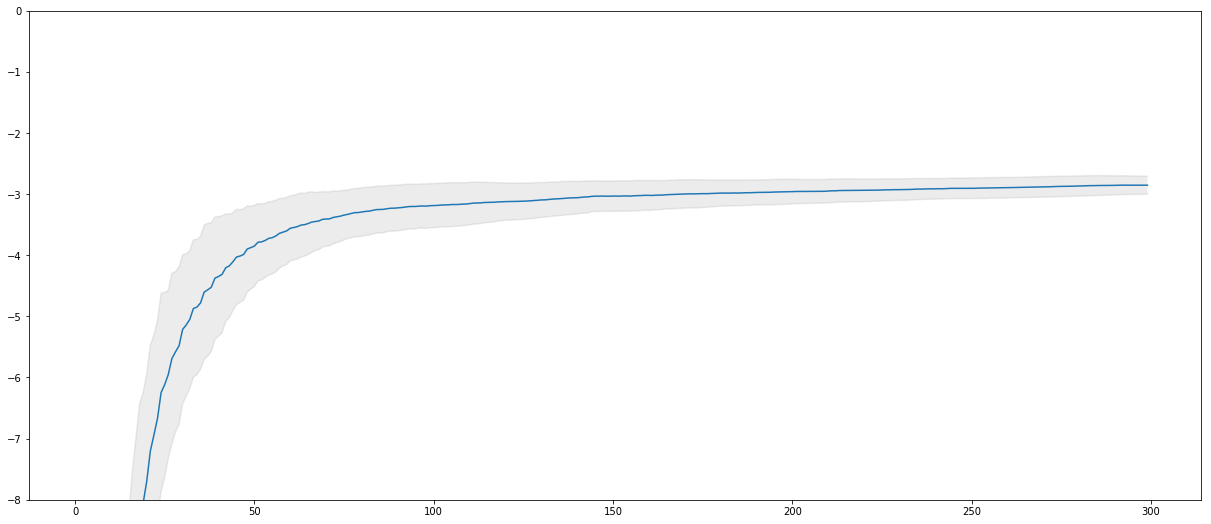

In [83]:
plt.figure(figsize=(21,9))
plt.plot(range(300),np.mean(ll_sgld,0))
plt.plot(range(n_samples),upper,'blue',alpha=0.15)
plt.plot(range(n_samples),lower,'blue', alpha=0.15)
plt.fill_between(range(n_samples),lower, upper, facecolor='blue', alpha=0.15, interpolate=True)
plt.ylim(-8,0)

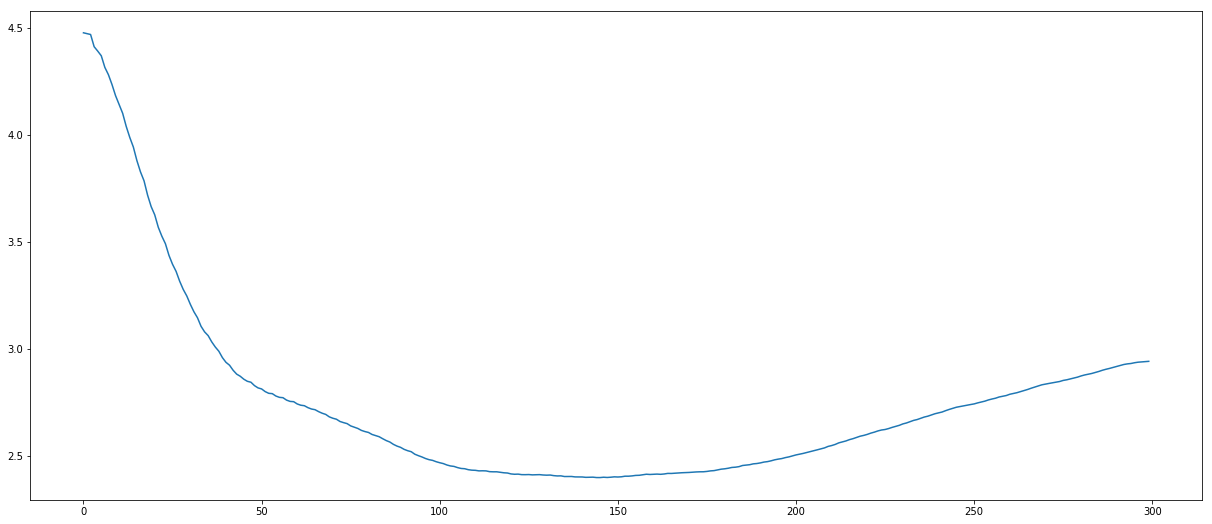

In [39]:
plt.figure(figsize=(21,9))
plt.plot(range(300),test_rmse)

## pSGLD

In [6]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import psgld 

import model




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



lambda_ = 1.
lr =3e-4
alpha = 0.99


batch_size = 32
dataset_size= 456

n_chains = 10
n_samples = 300





losses_psgld = []
ll_psgld = np.zeros((n_chains, n_samples))
rmse_psgld = np.zeros((n_chains, n_samples))


for i in range(n_chains):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = psgld.optim.psgld(network, lr, alpha, lambda_, batch_size, dataset_size)
    evaluate = evaluation(test_loader, n_samples, X_train_mean, X_train_std, y_train_mean, y_train_std)
    
    t = 1
    n = 0
    for epoch in range(2500):

        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)

            network.zero_grad()
            output = network(x)
            loss = 0.5 * criterion(output, y)
            loss.backward()
            optim.step()

            losses_psgld.append(loss)

            running_loss += loss * batch_size / dataset_size
            prediction = output.data.max(1)[1]
            accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


            if (t >= 300) & (t % 100 == 0) & (n < n_samples):
                rmse, ll, predictions = evaluate.fn(network)

                ll_psgld[i, n] = ll
                rmse_psgld[i, n] = rmse

                n += 1


            t += 1.
        print("chain {:d} - epoch {:d} - loss: {:.4f}".format(i, epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 0 - loss: 9.9911
chain 0 - epoch 1 - loss: 5.6848
chain 0 - epoch 2 - loss: 4.6699
chain 0 - epoch 3 - loss: 4.2129
chain 0 - epoch 4 - loss: 4.0023
chain 0 - epoch 5 - loss: 3.9280
chain 0 - epoch 6 - loss: 3.8785
chain 0 - epoch 7 - loss: 3.8423
chain 0 - epoch 8 - loss: 3.7931
chain 0 - epoch 9 - loss: 3.7418
chain 0 - epoch 10 - loss: 3.6978
chain 0 - epoch 11 - loss: 3.6818
chain 0 - epoch 12 - loss: 3.6602
chain 0 - epoch 13 - loss: 3.6236
chain 0 - epoch 14 - loss: 3.5956
chain 0 - epoch 15 - loss: 3.5680
chain 0 - epoch 16 - loss: 3.5071
chain 0 - epoch 17 - loss: 3.4716
chain 0 - epoch 18 - loss: 3.4451
chain 0 - epoch 19 - loss: 3.4177
chain 0 - epoch 20 - loss: 3.4166
chain 0 - epoch 21 - loss: 3.3963
chain 0 - epoch 22 - loss: 3.3658


/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 23 - loss: 3.3212
chain 0 - epoch 24 - loss: 3.3006
chain 0 - epoch 25 - loss: 3.2838
chain 0 - epoch 26 - loss: 3.2339
chain 0 - epoch 27 - loss: 3.2249
chain 0 - epoch 28 - loss: 3.1840
chain 0 - epoch 29 - loss: 3.1745
chain 0 - epoch 30 - loss: 3.1323
chain 0 - epoch 31 - loss: 3.1015
chain 0 - epoch 32 - loss: 3.0769
chain 0 - epoch 33 - loss: 3.0718
chain 0 - epoch 34 - loss: 3.0314
chain 0 - epoch 35 - loss: 3.0364
chain 0 - epoch 36 - loss: 2.9924
chain 0 - epoch 37 - loss: 2.9357
chain 0 - epoch 38 - loss: 2.9621
chain 0 - epoch 39 - loss: 2.9293
chain 0 - epoch 40 - loss: 2.8925
chain 0 - epoch 41 - loss: 2.8838
chain 0 - epoch 42 - loss: 2.8548
chain 0 - epoch 43 - loss: 2.8160
chain 0 - epoch 44 - loss: 2.7712
chain 0 - epoch 45 - loss: 2.7314
chain 0 - epoch 46 - loss: 2.7159
chain 0 - epoch 47 - loss: 2.7112
chain 0 - epoch 48 - loss: 2.6988
chain 0 - epoch 49 - loss: 2.6369
chain 0 - epoch 50 - loss: 2.6133
chain 0 - epoch 51 - loss: 2.6192
chain 0 - epoc

chain 0 - epoch 266 - loss: 1.1120
chain 0 - epoch 267 - loss: 1.1017
chain 0 - epoch 268 - loss: 1.1236
chain 0 - epoch 269 - loss: 1.1116
chain 0 - epoch 270 - loss: 1.1053
chain 0 - epoch 271 - loss: 1.1073
chain 0 - epoch 272 - loss: 1.1230
chain 0 - epoch 273 - loss: 1.1148
chain 0 - epoch 274 - loss: 1.1227
chain 0 - epoch 275 - loss: 1.0859
chain 0 - epoch 276 - loss: 1.0945
chain 0 - epoch 277 - loss: 1.0863
chain 0 - epoch 278 - loss: 1.0993
chain 0 - epoch 279 - loss: 1.0608
chain 0 - epoch 280 - loss: 1.0460
chain 0 - epoch 281 - loss: 1.0332
chain 0 - epoch 282 - loss: 1.0651
chain 0 - epoch 283 - loss: 1.0517
chain 0 - epoch 284 - loss: 1.0353
chain 0 - epoch 285 - loss: 1.0649
chain 0 - epoch 286 - loss: 1.0790
chain 0 - epoch 287 - loss: 1.0751
chain 0 - epoch 288 - loss: 1.0705
chain 0 - epoch 289 - loss: 1.0889
chain 0 - epoch 290 - loss: 1.0861
chain 0 - epoch 291 - loss: 1.0765
chain 0 - epoch 292 - loss: 1.0829
chain 0 - epoch 293 - loss: 1.0867
chain 0 - epoch 294 

chain 0 - epoch 503 - loss: 0.8104
chain 0 - epoch 504 - loss: 0.8110
chain 0 - epoch 505 - loss: 0.8306
chain 0 - epoch 506 - loss: 0.8298
chain 0 - epoch 507 - loss: 0.8580
chain 0 - epoch 508 - loss: 0.8258
chain 0 - epoch 509 - loss: 0.8040
chain 0 - epoch 510 - loss: 0.7964
chain 0 - epoch 511 - loss: 0.8174
chain 0 - epoch 512 - loss: 0.8016
chain 0 - epoch 513 - loss: 0.7786
chain 0 - epoch 514 - loss: 0.7823
chain 0 - epoch 515 - loss: 0.8069
chain 0 - epoch 516 - loss: 0.8191
chain 0 - epoch 517 - loss: 0.7934
chain 0 - epoch 518 - loss: 0.7986
chain 0 - epoch 519 - loss: 0.7906
chain 0 - epoch 520 - loss: 0.7735
chain 0 - epoch 521 - loss: 0.7781
chain 0 - epoch 522 - loss: 0.7666
chain 0 - epoch 523 - loss: 0.7753
chain 0 - epoch 524 - loss: 0.7773
chain 0 - epoch 525 - loss: 0.8033
chain 0 - epoch 526 - loss: 0.7829
chain 0 - epoch 527 - loss: 0.7958
chain 0 - epoch 528 - loss: 0.8214
chain 0 - epoch 529 - loss: 0.8089
chain 0 - epoch 530 - loss: 0.8148
chain 0 - epoch 531 

chain 0 - epoch 740 - loss: 0.7269
chain 0 - epoch 741 - loss: 0.7462
chain 0 - epoch 742 - loss: 0.7185
chain 0 - epoch 743 - loss: 0.7140
chain 0 - epoch 744 - loss: 0.7245
chain 0 - epoch 745 - loss: 0.7434
chain 0 - epoch 746 - loss: 0.7674
chain 0 - epoch 747 - loss: 0.7530
chain 0 - epoch 748 - loss: 0.7830
chain 0 - epoch 749 - loss: 0.7702
chain 0 - epoch 750 - loss: 0.7414
chain 0 - epoch 751 - loss: 0.7277
chain 0 - epoch 752 - loss: 0.7351
chain 0 - epoch 753 - loss: 0.7408
chain 0 - epoch 754 - loss: 0.7404
chain 0 - epoch 755 - loss: 0.7308
chain 0 - epoch 756 - loss: 0.7297
chain 0 - epoch 757 - loss: 0.7292
chain 0 - epoch 758 - loss: 0.7192
chain 0 - epoch 759 - loss: 0.7173
chain 0 - epoch 760 - loss: 0.7171
chain 0 - epoch 761 - loss: 0.7259
chain 0 - epoch 762 - loss: 0.7229
chain 0 - epoch 763 - loss: 0.7117
chain 0 - epoch 764 - loss: 0.7239
chain 0 - epoch 765 - loss: 0.7143
chain 0 - epoch 766 - loss: 0.7177
chain 0 - epoch 767 - loss: 0.7355
chain 0 - epoch 768 

chain 0 - epoch 980 - loss: 0.6236
chain 0 - epoch 981 - loss: 0.6163
chain 0 - epoch 982 - loss: 0.6435
chain 0 - epoch 983 - loss: 0.6236
chain 0 - epoch 984 - loss: 0.6446
chain 0 - epoch 985 - loss: 0.6318
chain 0 - epoch 986 - loss: 0.6162
chain 0 - epoch 987 - loss: 0.6202
chain 0 - epoch 988 - loss: 0.6346
chain 0 - epoch 989 - loss: 0.6286
chain 0 - epoch 990 - loss: 0.6250
chain 0 - epoch 991 - loss: 0.6417
chain 0 - epoch 992 - loss: 0.6881
chain 0 - epoch 993 - loss: 0.6430
chain 0 - epoch 994 - loss: 0.6428
chain 0 - epoch 995 - loss: 0.6350
chain 0 - epoch 996 - loss: 0.6665
chain 0 - epoch 997 - loss: 0.6632
chain 0 - epoch 998 - loss: 0.6492
chain 0 - epoch 999 - loss: 0.6197
chain 0 - epoch 1000 - loss: 0.6388
chain 0 - epoch 1001 - loss: 0.6145
chain 0 - epoch 1002 - loss: 0.6427
chain 0 - epoch 1003 - loss: 0.6426
chain 0 - epoch 1004 - loss: 0.6384
chain 0 - epoch 1005 - loss: 0.6328
chain 0 - epoch 1006 - loss: 0.6265
chain 0 - epoch 1007 - loss: 0.6237
chain 0 - ep

chain 0 - epoch 1213 - loss: 0.6436
chain 0 - epoch 1214 - loss: 0.6070
chain 0 - epoch 1215 - loss: 0.5983
chain 0 - epoch 1216 - loss: 0.6375
chain 0 - epoch 1217 - loss: 0.6272
chain 0 - epoch 1218 - loss: 0.5981
chain 0 - epoch 1219 - loss: 0.5919
chain 0 - epoch 1220 - loss: 0.5989
chain 0 - epoch 1221 - loss: 0.6075
chain 0 - epoch 1222 - loss: 0.5986
chain 0 - epoch 1223 - loss: 0.6114
chain 0 - epoch 1224 - loss: 0.5999
chain 0 - epoch 1225 - loss: 0.6122
chain 0 - epoch 1226 - loss: 0.6205
chain 0 - epoch 1227 - loss: 0.6008
chain 0 - epoch 1228 - loss: 0.6189
chain 0 - epoch 1229 - loss: 0.5891
chain 0 - epoch 1230 - loss: 0.5687
chain 0 - epoch 1231 - loss: 0.5947
chain 0 - epoch 1232 - loss: 0.5865
chain 0 - epoch 1233 - loss: 0.5645
chain 0 - epoch 1234 - loss: 0.5980
chain 0 - epoch 1235 - loss: 0.5751
chain 0 - epoch 1236 - loss: 0.5623
chain 0 - epoch 1237 - loss: 0.5658
chain 0 - epoch 1238 - loss: 0.5796
chain 0 - epoch 1239 - loss: 0.5706
chain 0 - epoch 1240 - loss:

chain 0 - epoch 1445 - loss: 0.5766
chain 0 - epoch 1446 - loss: 0.5968
chain 0 - epoch 1447 - loss: 0.6350
chain 0 - epoch 1448 - loss: 0.6308
chain 0 - epoch 1449 - loss: 0.6264
chain 0 - epoch 1450 - loss: 0.6081
chain 0 - epoch 1451 - loss: 0.6098
chain 0 - epoch 1452 - loss: 0.6138
chain 0 - epoch 1453 - loss: 0.6269
chain 0 - epoch 1454 - loss: 0.6581
chain 0 - epoch 1455 - loss: 0.6512
chain 0 - epoch 1456 - loss: 0.5966
chain 0 - epoch 1457 - loss: 0.5807
chain 0 - epoch 1458 - loss: 0.5855
chain 0 - epoch 1459 - loss: 0.6215
chain 0 - epoch 1460 - loss: 0.6272
chain 0 - epoch 1461 - loss: 0.5971
chain 0 - epoch 1462 - loss: 0.5983
chain 0 - epoch 1463 - loss: 0.5927
chain 0 - epoch 1464 - loss: 0.5664
chain 0 - epoch 1465 - loss: 0.5844
chain 0 - epoch 1466 - loss: 0.6042
chain 0 - epoch 1467 - loss: 0.5968
chain 0 - epoch 1468 - loss: 0.6005
chain 0 - epoch 1469 - loss: 0.6189
chain 0 - epoch 1470 - loss: 0.5832
chain 0 - epoch 1471 - loss: 0.6195
chain 0 - epoch 1472 - loss:

chain 0 - epoch 1673 - loss: 0.5284
chain 0 - epoch 1674 - loss: 0.5430
chain 0 - epoch 1675 - loss: 0.5567
chain 0 - epoch 1676 - loss: 0.5441
chain 0 - epoch 1677 - loss: 0.5433
chain 0 - epoch 1678 - loss: 0.5294
chain 0 - epoch 1679 - loss: 0.5265
chain 0 - epoch 1680 - loss: 0.5393
chain 0 - epoch 1681 - loss: 0.5343
chain 0 - epoch 1682 - loss: 0.5581
chain 0 - epoch 1683 - loss: 0.5887
chain 0 - epoch 1684 - loss: 0.5323
chain 0 - epoch 1685 - loss: 0.5427
chain 0 - epoch 1686 - loss: 0.5227
chain 0 - epoch 1687 - loss: 0.5518
chain 0 - epoch 1688 - loss: 0.5412
chain 0 - epoch 1689 - loss: 0.5535
chain 0 - epoch 1690 - loss: 0.5390
chain 0 - epoch 1691 - loss: 0.5670
chain 0 - epoch 1692 - loss: 0.5714
chain 0 - epoch 1693 - loss: 0.5676
chain 0 - epoch 1694 - loss: 0.5560
chain 0 - epoch 1695 - loss: 0.6112
chain 0 - epoch 1696 - loss: 0.5986
chain 0 - epoch 1697 - loss: 0.6152
chain 0 - epoch 1698 - loss: 0.6189
chain 0 - epoch 1699 - loss: 0.5768
chain 0 - epoch 1700 - loss:

chain 0 - epoch 1901 - loss: 0.5714
chain 0 - epoch 1902 - loss: 0.5785
chain 0 - epoch 1903 - loss: 0.5681
chain 0 - epoch 1904 - loss: 0.5775
chain 0 - epoch 1905 - loss: 0.5481
chain 0 - epoch 1906 - loss: 0.5369
chain 0 - epoch 1907 - loss: 0.5614
chain 0 - epoch 1908 - loss: 0.5801
chain 0 - epoch 1909 - loss: 0.5652
chain 0 - epoch 1910 - loss: 0.5873
chain 0 - epoch 1911 - loss: 0.5628
chain 0 - epoch 1912 - loss: 0.5619
chain 0 - epoch 1913 - loss: 0.5572
chain 0 - epoch 1914 - loss: 0.5927
chain 0 - epoch 1915 - loss: 0.5906
chain 0 - epoch 1916 - loss: 0.6063
chain 0 - epoch 1917 - loss: 0.6123
chain 0 - epoch 1918 - loss: 0.6124
chain 0 - epoch 1919 - loss: 0.6269
chain 0 - epoch 1920 - loss: 0.5964
chain 0 - epoch 1921 - loss: 0.5938
chain 0 - epoch 1922 - loss: 0.5564
chain 0 - epoch 1923 - loss: 0.5595
chain 0 - epoch 1924 - loss: 0.5950
chain 0 - epoch 1925 - loss: 0.5678
chain 0 - epoch 1926 - loss: 0.5842
chain 0 - epoch 1927 - loss: 0.5837
chain 0 - epoch 1928 - loss:

chain 0 - epoch 2137 - loss: 0.5785
chain 0 - epoch 2138 - loss: 0.5472
chain 0 - epoch 2139 - loss: 0.5501
chain 0 - epoch 2140 - loss: 0.5469
chain 0 - epoch 2141 - loss: 0.5501
chain 0 - epoch 2142 - loss: 0.5486
chain 0 - epoch 2143 - loss: 0.5444
chain 0 - epoch 2144 - loss: 0.5534
chain 0 - epoch 2145 - loss: 0.5798
chain 0 - epoch 2146 - loss: 0.5454
chain 0 - epoch 2147 - loss: 0.5411
chain 0 - epoch 2148 - loss: 0.5163
chain 0 - epoch 2149 - loss: 0.5607
chain 0 - epoch 2150 - loss: 0.5392
chain 0 - epoch 2151 - loss: 0.5454
chain 0 - epoch 2152 - loss: 0.5353
chain 0 - epoch 2153 - loss: 0.5271
chain 0 - epoch 2154 - loss: 0.5349
chain 0 - epoch 2155 - loss: 0.5276
chain 0 - epoch 2156 - loss: 0.4967
chain 0 - epoch 2157 - loss: 0.5099
chain 0 - epoch 2158 - loss: 0.5319
chain 0 - epoch 2159 - loss: 0.5332
chain 0 - epoch 2160 - loss: 0.5004
chain 0 - epoch 2161 - loss: 0.5381
chain 0 - epoch 2162 - loss: 0.4895
chain 0 - epoch 2163 - loss: 0.5146
chain 0 - epoch 2164 - loss:

chain 0 - epoch 2369 - loss: 0.5627
chain 0 - epoch 2370 - loss: 0.5795
chain 0 - epoch 2371 - loss: 0.5389
chain 0 - epoch 2372 - loss: 0.5715
chain 0 - epoch 2373 - loss: 0.5401
chain 0 - epoch 2374 - loss: 0.5330
chain 0 - epoch 2375 - loss: 0.5384
chain 0 - epoch 2376 - loss: 0.5346
chain 0 - epoch 2377 - loss: 0.5425
chain 0 - epoch 2378 - loss: 0.5777
chain 0 - epoch 2379 - loss: 0.5885
chain 0 - epoch 2380 - loss: 0.5949
chain 0 - epoch 2381 - loss: 0.5870
chain 0 - epoch 2382 - loss: 0.6069
chain 0 - epoch 2383 - loss: 0.5683
chain 0 - epoch 2384 - loss: 0.5740
chain 0 - epoch 2385 - loss: 0.5628
chain 0 - epoch 2386 - loss: 0.5640
chain 0 - epoch 2387 - loss: 0.5514
chain 0 - epoch 2388 - loss: 0.5736
chain 0 - epoch 2389 - loss: 0.5499
chain 0 - epoch 2390 - loss: 0.5578
chain 0 - epoch 2391 - loss: 0.5745
chain 0 - epoch 2392 - loss: 0.6118
chain 0 - epoch 2393 - loss: 0.5928
chain 0 - epoch 2394 - loss: 0.5797
chain 0 - epoch 2395 - loss: 0.5697
chain 0 - epoch 2396 - loss:

chain 1 - epoch 110 - loss: 1.6347
chain 1 - epoch 111 - loss: 1.6431
chain 1 - epoch 112 - loss: 1.6141
chain 1 - epoch 113 - loss: 1.6160
chain 1 - epoch 114 - loss: 1.6103
chain 1 - epoch 115 - loss: 1.6269
chain 1 - epoch 116 - loss: 1.6184
chain 1 - epoch 117 - loss: 1.6245
chain 1 - epoch 118 - loss: 1.6279
chain 1 - epoch 119 - loss: 1.6219
chain 1 - epoch 120 - loss: 1.6300
chain 1 - epoch 121 - loss: 1.5833
chain 1 - epoch 122 - loss: 1.5772
chain 1 - epoch 123 - loss: 1.5444
chain 1 - epoch 124 - loss: 1.5377
chain 1 - epoch 125 - loss: 1.5289
chain 1 - epoch 126 - loss: 1.5354
chain 1 - epoch 127 - loss: 1.5269
chain 1 - epoch 128 - loss: 1.5425
chain 1 - epoch 129 - loss: 1.5199
chain 1 - epoch 130 - loss: 1.4962
chain 1 - epoch 131 - loss: 1.4815
chain 1 - epoch 132 - loss: 1.4682
chain 1 - epoch 133 - loss: 1.4728
chain 1 - epoch 134 - loss: 1.4618
chain 1 - epoch 135 - loss: 1.4521
chain 1 - epoch 136 - loss: 1.4420
chain 1 - epoch 137 - loss: 1.4624
chain 1 - epoch 138 

chain 1 - epoch 349 - loss: 1.0152
chain 1 - epoch 350 - loss: 1.0003
chain 1 - epoch 351 - loss: 0.9888
chain 1 - epoch 352 - loss: 1.0247
chain 1 - epoch 353 - loss: 0.9836
chain 1 - epoch 354 - loss: 1.0025
chain 1 - epoch 355 - loss: 0.9791
chain 1 - epoch 356 - loss: 1.0128
chain 1 - epoch 357 - loss: 0.9737
chain 1 - epoch 358 - loss: 0.9471
chain 1 - epoch 359 - loss: 0.9754
chain 1 - epoch 360 - loss: 0.9537
chain 1 - epoch 361 - loss: 0.9582
chain 1 - epoch 362 - loss: 0.9507
chain 1 - epoch 363 - loss: 0.9679
chain 1 - epoch 364 - loss: 0.9592
chain 1 - epoch 365 - loss: 0.9775
chain 1 - epoch 366 - loss: 0.9734
chain 1 - epoch 367 - loss: 0.9578
chain 1 - epoch 368 - loss: 0.9595
chain 1 - epoch 369 - loss: 0.9563
chain 1 - epoch 370 - loss: 0.9587
chain 1 - epoch 371 - loss: 0.9677
chain 1 - epoch 372 - loss: 0.9617
chain 1 - epoch 373 - loss: 0.9580
chain 1 - epoch 374 - loss: 0.9897
chain 1 - epoch 375 - loss: 0.9843
chain 1 - epoch 376 - loss: 0.9843
chain 1 - epoch 377 

chain 1 - epoch 586 - loss: 0.7477
chain 1 - epoch 587 - loss: 0.7628
chain 1 - epoch 588 - loss: 0.7695
chain 1 - epoch 589 - loss: 0.7673
chain 1 - epoch 590 - loss: 0.7876
chain 1 - epoch 591 - loss: 0.7871
chain 1 - epoch 592 - loss: 0.7916
chain 1 - epoch 593 - loss: 0.8025
chain 1 - epoch 594 - loss: 0.7965
chain 1 - epoch 595 - loss: 0.8043
chain 1 - epoch 596 - loss: 0.7744
chain 1 - epoch 597 - loss: 0.7602
chain 1 - epoch 598 - loss: 0.7634
chain 1 - epoch 599 - loss: 0.7677
chain 1 - epoch 600 - loss: 0.7612
chain 1 - epoch 601 - loss: 0.7575
chain 1 - epoch 602 - loss: 0.7452
chain 1 - epoch 603 - loss: 0.7450
chain 1 - epoch 604 - loss: 0.7751
chain 1 - epoch 605 - loss: 0.7645
chain 1 - epoch 606 - loss: 0.7858
chain 1 - epoch 607 - loss: 0.7789
chain 1 - epoch 608 - loss: 0.7628
chain 1 - epoch 609 - loss: 0.7325
chain 1 - epoch 610 - loss: 0.7391
chain 1 - epoch 611 - loss: 0.7477
chain 1 - epoch 612 - loss: 0.7438
chain 1 - epoch 613 - loss: 0.7287
chain 1 - epoch 614 

chain 1 - epoch 825 - loss: 0.6314
chain 1 - epoch 826 - loss: 0.6277
chain 1 - epoch 827 - loss: 0.6343
chain 1 - epoch 828 - loss: 0.6569
chain 1 - epoch 829 - loss: 0.6423
chain 1 - epoch 830 - loss: 0.6255
chain 1 - epoch 831 - loss: 0.6260
chain 1 - epoch 832 - loss: 0.5946
chain 1 - epoch 833 - loss: 0.6068
chain 1 - epoch 834 - loss: 0.6291
chain 1 - epoch 835 - loss: 0.6183
chain 1 - epoch 836 - loss: 0.5935
chain 1 - epoch 837 - loss: 0.6198
chain 1 - epoch 838 - loss: 0.6160
chain 1 - epoch 839 - loss: 0.5941
chain 1 - epoch 840 - loss: 0.5819
chain 1 - epoch 841 - loss: 0.5877
chain 1 - epoch 842 - loss: 0.5998
chain 1 - epoch 843 - loss: 0.5843
chain 1 - epoch 844 - loss: 0.6095
chain 1 - epoch 845 - loss: 0.6269
chain 1 - epoch 846 - loss: 0.6247
chain 1 - epoch 847 - loss: 0.5957
chain 1 - epoch 848 - loss: 0.6452
chain 1 - epoch 849 - loss: 0.6430
chain 1 - epoch 850 - loss: 0.6455
chain 1 - epoch 851 - loss: 0.6421
chain 1 - epoch 852 - loss: 0.6360
chain 1 - epoch 853 

chain 1 - epoch 1065 - loss: 0.5776
chain 1 - epoch 1066 - loss: 0.5812
chain 1 - epoch 1067 - loss: 0.5820
chain 1 - epoch 1068 - loss: 0.5623
chain 1 - epoch 1069 - loss: 0.5752
chain 1 - epoch 1070 - loss: 0.5768
chain 1 - epoch 1071 - loss: 0.5828
chain 1 - epoch 1072 - loss: 0.6117
chain 1 - epoch 1073 - loss: 0.5999
chain 1 - epoch 1074 - loss: 0.5964
chain 1 - epoch 1075 - loss: 0.6078
chain 1 - epoch 1076 - loss: 0.5787
chain 1 - epoch 1077 - loss: 0.5931
chain 1 - epoch 1078 - loss: 0.6209
chain 1 - epoch 1079 - loss: 0.6080
chain 1 - epoch 1080 - loss: 0.5969
chain 1 - epoch 1081 - loss: 0.5809
chain 1 - epoch 1082 - loss: 0.5711
chain 1 - epoch 1083 - loss: 0.5645
chain 1 - epoch 1084 - loss: 0.5516
chain 1 - epoch 1085 - loss: 0.5612
chain 1 - epoch 1086 - loss: 0.5653
chain 1 - epoch 1087 - loss: 0.5763
chain 1 - epoch 1088 - loss: 0.5666
chain 1 - epoch 1089 - loss: 0.5659
chain 1 - epoch 1090 - loss: 0.5794
chain 1 - epoch 1091 - loss: 0.5828
chain 1 - epoch 1092 - loss:

chain 1 - epoch 1296 - loss: 0.6248
chain 1 - epoch 1297 - loss: 0.5988
chain 1 - epoch 1298 - loss: 0.5790
chain 1 - epoch 1299 - loss: 0.5707
chain 1 - epoch 1300 - loss: 0.5504
chain 1 - epoch 1301 - loss: 0.5950
chain 1 - epoch 1302 - loss: 0.5871
chain 1 - epoch 1303 - loss: 0.5410
chain 1 - epoch 1304 - loss: 0.5532
chain 1 - epoch 1305 - loss: 0.5793
chain 1 - epoch 1306 - loss: 0.5885
chain 1 - epoch 1307 - loss: 0.5715
chain 1 - epoch 1308 - loss: 0.5946
chain 1 - epoch 1309 - loss: 0.5605
chain 1 - epoch 1310 - loss: 0.5984
chain 1 - epoch 1311 - loss: 0.5606
chain 1 - epoch 1312 - loss: 0.5663
chain 1 - epoch 1313 - loss: 0.5742
chain 1 - epoch 1314 - loss: 0.6040
chain 1 - epoch 1315 - loss: 0.5599
chain 1 - epoch 1316 - loss: 0.5730
chain 1 - epoch 1317 - loss: 0.5623
chain 1 - epoch 1318 - loss: 0.5555
chain 1 - epoch 1319 - loss: 0.5589
chain 1 - epoch 1320 - loss: 0.5624
chain 1 - epoch 1321 - loss: 0.5861
chain 1 - epoch 1322 - loss: 0.5675
chain 1 - epoch 1323 - loss:

chain 1 - epoch 1531 - loss: 0.5348
chain 1 - epoch 1532 - loss: 0.5140
chain 1 - epoch 1533 - loss: 0.4977
chain 1 - epoch 1534 - loss: 0.4856
chain 1 - epoch 1535 - loss: 0.5096
chain 1 - epoch 1536 - loss: 0.5088
chain 1 - epoch 1537 - loss: 0.5273
chain 1 - epoch 1538 - loss: 0.4850
chain 1 - epoch 1539 - loss: 0.5155
chain 1 - epoch 1540 - loss: 0.5106
chain 1 - epoch 1541 - loss: 0.5032
chain 1 - epoch 1542 - loss: 0.4968
chain 1 - epoch 1543 - loss: 0.5204
chain 1 - epoch 1544 - loss: 0.5516
chain 1 - epoch 1545 - loss: 0.4949
chain 1 - epoch 1546 - loss: 0.5114
chain 1 - epoch 1547 - loss: 0.5024
chain 1 - epoch 1548 - loss: 0.5094
chain 1 - epoch 1549 - loss: 0.5443
chain 1 - epoch 1550 - loss: 0.5217
chain 1 - epoch 1551 - loss: 0.5338
chain 1 - epoch 1552 - loss: 0.5276
chain 1 - epoch 1553 - loss: 0.5166
chain 1 - epoch 1554 - loss: 0.4761
chain 1 - epoch 1555 - loss: 0.4865
chain 1 - epoch 1556 - loss: 0.4872
chain 1 - epoch 1557 - loss: 0.4907
chain 1 - epoch 1558 - loss:

chain 1 - epoch 1763 - loss: 0.5437
chain 1 - epoch 1764 - loss: 0.5287
chain 1 - epoch 1765 - loss: 0.5625
chain 1 - epoch 1766 - loss: 0.5436
chain 1 - epoch 1767 - loss: 0.5707
chain 1 - epoch 1768 - loss: 0.5567
chain 1 - epoch 1769 - loss: 0.5865
chain 1 - epoch 1770 - loss: 0.5715
chain 1 - epoch 1771 - loss: 0.5426
chain 1 - epoch 1772 - loss: 0.5758
chain 1 - epoch 1773 - loss: 0.5733
chain 1 - epoch 1774 - loss: 0.5597
chain 1 - epoch 1775 - loss: 0.5616
chain 1 - epoch 1776 - loss: 0.5705
chain 1 - epoch 1777 - loss: 0.5746
chain 1 - epoch 1778 - loss: 0.5658
chain 1 - epoch 1779 - loss: 0.5696
chain 1 - epoch 1780 - loss: 0.5796
chain 1 - epoch 1781 - loss: 0.5693
chain 1 - epoch 1782 - loss: 0.5517
chain 1 - epoch 1783 - loss: 0.5663
chain 1 - epoch 1784 - loss: 0.5547
chain 1 - epoch 1785 - loss: 0.5473
chain 1 - epoch 1786 - loss: 0.5377
chain 1 - epoch 1787 - loss: 0.5452
chain 1 - epoch 1788 - loss: 0.5697
chain 1 - epoch 1789 - loss: 0.5643
chain 1 - epoch 1790 - loss:

chain 1 - epoch 1995 - loss: 0.5003
chain 1 - epoch 1996 - loss: 0.5410
chain 1 - epoch 1997 - loss: 0.5204
chain 1 - epoch 1998 - loss: 0.5166
chain 1 - epoch 1999 - loss: 0.5263
chain 1 - epoch 2000 - loss: 0.5204
chain 1 - epoch 2001 - loss: 0.5499
chain 1 - epoch 2002 - loss: 0.5388
chain 1 - epoch 2003 - loss: 0.5359
chain 1 - epoch 2004 - loss: 0.5421
chain 1 - epoch 2005 - loss: 0.5174
chain 1 - epoch 2006 - loss: 0.5117
chain 1 - epoch 2007 - loss: 0.5128
chain 1 - epoch 2008 - loss: 0.4911
chain 1 - epoch 2009 - loss: 0.5341
chain 1 - epoch 2010 - loss: 0.5019
chain 1 - epoch 2011 - loss: 0.5381
chain 1 - epoch 2012 - loss: 0.5439
chain 1 - epoch 2013 - loss: 0.5259
chain 1 - epoch 2014 - loss: 0.5099
chain 1 - epoch 2015 - loss: 0.5512
chain 1 - epoch 2016 - loss: 0.5302
chain 1 - epoch 2017 - loss: 0.5174
chain 1 - epoch 2018 - loss: 0.5169
chain 1 - epoch 2019 - loss: 0.5359
chain 1 - epoch 2020 - loss: 0.5190
chain 1 - epoch 2021 - loss: 0.5353
chain 1 - epoch 2022 - loss:

chain 1 - epoch 2232 - loss: 0.5287
chain 1 - epoch 2233 - loss: 0.5503
chain 1 - epoch 2234 - loss: 0.5644
chain 1 - epoch 2235 - loss: 0.5413
chain 1 - epoch 2236 - loss: 0.5601
chain 1 - epoch 2237 - loss: 0.5214
chain 1 - epoch 2238 - loss: 0.5239
chain 1 - epoch 2239 - loss: 0.5181
chain 1 - epoch 2240 - loss: 0.5384
chain 1 - epoch 2241 - loss: 0.5151
chain 1 - epoch 2242 - loss: 0.5039
chain 1 - epoch 2243 - loss: 0.5046
chain 1 - epoch 2244 - loss: 0.4920
chain 1 - epoch 2245 - loss: 0.4900
chain 1 - epoch 2246 - loss: 0.4948
chain 1 - epoch 2247 - loss: 0.4997
chain 1 - epoch 2248 - loss: 0.5107
chain 1 - epoch 2249 - loss: 0.4739
chain 1 - epoch 2250 - loss: 0.4994
chain 1 - epoch 2251 - loss: 0.5375
chain 1 - epoch 2252 - loss: 0.5195
chain 1 - epoch 2253 - loss: 0.4975
chain 1 - epoch 2254 - loss: 0.5078
chain 1 - epoch 2255 - loss: 0.5154
chain 1 - epoch 2256 - loss: 0.5163
chain 1 - epoch 2257 - loss: 0.5009
chain 1 - epoch 2258 - loss: 0.4898
chain 1 - epoch 2259 - loss:

chain 1 - epoch 2466 - loss: 0.5274
chain 1 - epoch 2467 - loss: 0.5037
chain 1 - epoch 2468 - loss: 0.5234
chain 1 - epoch 2469 - loss: 0.5183
chain 1 - epoch 2470 - loss: 0.5507
chain 1 - epoch 2471 - loss: 0.5495
chain 1 - epoch 2472 - loss: 0.5436
chain 1 - epoch 2473 - loss: 0.5203
chain 1 - epoch 2474 - loss: 0.5322
chain 1 - epoch 2475 - loss: 0.5378
chain 1 - epoch 2476 - loss: 0.5503
chain 1 - epoch 2477 - loss: 0.5386
chain 1 - epoch 2478 - loss: 0.5160
chain 1 - epoch 2479 - loss: 0.5526
chain 1 - epoch 2480 - loss: 0.5242
chain 1 - epoch 2481 - loss: 0.5285
chain 1 - epoch 2482 - loss: 0.5439
chain 1 - epoch 2483 - loss: 0.5751
chain 1 - epoch 2484 - loss: 0.5497
chain 1 - epoch 2485 - loss: 0.5325
chain 1 - epoch 2486 - loss: 0.5335
chain 1 - epoch 2487 - loss: 0.5399
chain 1 - epoch 2488 - loss: 0.5437
chain 1 - epoch 2489 - loss: 0.5626
chain 1 - epoch 2490 - loss: 0.5402
chain 1 - epoch 2491 - loss: 0.5380
chain 1 - epoch 2492 - loss: 0.5369
chain 1 - epoch 2493 - loss:

chain 2 - epoch 203 - loss: 1.1711
chain 2 - epoch 204 - loss: 1.1610
chain 2 - epoch 205 - loss: 1.1760
chain 2 - epoch 206 - loss: 1.1754
chain 2 - epoch 207 - loss: 1.1855
chain 2 - epoch 208 - loss: 1.1413
chain 2 - epoch 209 - loss: 1.1661
chain 2 - epoch 210 - loss: 1.1572
chain 2 - epoch 211 - loss: 1.1634
chain 2 - epoch 212 - loss: 1.1716
chain 2 - epoch 213 - loss: 1.1505
chain 2 - epoch 214 - loss: 1.1617
chain 2 - epoch 215 - loss: 1.1374
chain 2 - epoch 216 - loss: 1.1243
chain 2 - epoch 217 - loss: 1.1250
chain 2 - epoch 218 - loss: 1.1322
chain 2 - epoch 219 - loss: 1.1454
chain 2 - epoch 220 - loss: 1.1356
chain 2 - epoch 221 - loss: 1.1158
chain 2 - epoch 222 - loss: 1.0961
chain 2 - epoch 223 - loss: 1.1083
chain 2 - epoch 224 - loss: 1.1008
chain 2 - epoch 225 - loss: 1.0908
chain 2 - epoch 226 - loss: 1.1016
chain 2 - epoch 227 - loss: 1.1030
chain 2 - epoch 228 - loss: 1.1052
chain 2 - epoch 229 - loss: 1.1249
chain 2 - epoch 230 - loss: 1.1096
chain 2 - epoch 231 

chain 2 - epoch 445 - loss: 0.8248
chain 2 - epoch 446 - loss: 0.8512
chain 2 - epoch 447 - loss: 0.8339
chain 2 - epoch 448 - loss: 0.8559
chain 2 - epoch 449 - loss: 0.8640
chain 2 - epoch 450 - loss: 0.8698
chain 2 - epoch 451 - loss: 0.8610
chain 2 - epoch 452 - loss: 0.8546
chain 2 - epoch 453 - loss: 0.8478
chain 2 - epoch 454 - loss: 0.8535
chain 2 - epoch 455 - loss: 0.8280
chain 2 - epoch 456 - loss: 0.8688
chain 2 - epoch 457 - loss: 0.8518
chain 2 - epoch 458 - loss: 0.8553
chain 2 - epoch 459 - loss: 0.8488
chain 2 - epoch 460 - loss: 0.8467
chain 2 - epoch 461 - loss: 0.8474
chain 2 - epoch 462 - loss: 0.8412
chain 2 - epoch 463 - loss: 0.8367
chain 2 - epoch 464 - loss: 0.8714
chain 2 - epoch 465 - loss: 0.8694
chain 2 - epoch 466 - loss: 0.8597
chain 2 - epoch 467 - loss: 0.8642
chain 2 - epoch 468 - loss: 0.8552
chain 2 - epoch 469 - loss: 0.8636
chain 2 - epoch 470 - loss: 0.8352
chain 2 - epoch 471 - loss: 0.8295
chain 2 - epoch 472 - loss: 0.8364
chain 2 - epoch 473 

chain 2 - epoch 685 - loss: 0.7259
chain 2 - epoch 686 - loss: 0.6855
chain 2 - epoch 687 - loss: 0.7005
chain 2 - epoch 688 - loss: 0.7157
chain 2 - epoch 689 - loss: 0.7114
chain 2 - epoch 690 - loss: 0.7058
chain 2 - epoch 691 - loss: 0.7159
chain 2 - epoch 692 - loss: 0.7378
chain 2 - epoch 693 - loss: 0.7413
chain 2 - epoch 694 - loss: 0.7485
chain 2 - epoch 695 - loss: 0.7326
chain 2 - epoch 696 - loss: 0.7535
chain 2 - epoch 697 - loss: 0.7328
chain 2 - epoch 698 - loss: 0.7602
chain 2 - epoch 699 - loss: 0.7249
chain 2 - epoch 700 - loss: 0.7277
chain 2 - epoch 701 - loss: 0.7019
chain 2 - epoch 702 - loss: 0.7182
chain 2 - epoch 703 - loss: 0.7136
chain 2 - epoch 704 - loss: 0.7089
chain 2 - epoch 705 - loss: 0.6979
chain 2 - epoch 706 - loss: 0.7037
chain 2 - epoch 707 - loss: 0.7163
chain 2 - epoch 708 - loss: 0.7214
chain 2 - epoch 709 - loss: 0.7164
chain 2 - epoch 710 - loss: 0.6975
chain 2 - epoch 711 - loss: 0.6979
chain 2 - epoch 712 - loss: 0.6984
chain 2 - epoch 713 

chain 2 - epoch 923 - loss: 0.6431
chain 2 - epoch 924 - loss: 0.6701
chain 2 - epoch 925 - loss: 0.6627
chain 2 - epoch 926 - loss: 0.6498
chain 2 - epoch 927 - loss: 0.6734
chain 2 - epoch 928 - loss: 0.6869
chain 2 - epoch 929 - loss: 0.6606
chain 2 - epoch 930 - loss: 0.6718
chain 2 - epoch 931 - loss: 0.6689
chain 2 - epoch 932 - loss: 0.6601
chain 2 - epoch 933 - loss: 0.6558
chain 2 - epoch 934 - loss: 0.6631
chain 2 - epoch 935 - loss: 0.6467
chain 2 - epoch 936 - loss: 0.6456
chain 2 - epoch 937 - loss: 0.6169
chain 2 - epoch 938 - loss: 0.6650
chain 2 - epoch 939 - loss: 0.6746
chain 2 - epoch 940 - loss: 0.6669
chain 2 - epoch 941 - loss: 0.6843
chain 2 - epoch 942 - loss: 0.6637
chain 2 - epoch 943 - loss: 0.6712
chain 2 - epoch 944 - loss: 0.6971
chain 2 - epoch 945 - loss: 0.7011
chain 2 - epoch 946 - loss: 0.7117
chain 2 - epoch 947 - loss: 0.6987
chain 2 - epoch 948 - loss: 0.6836
chain 2 - epoch 949 - loss: 0.6967
chain 2 - epoch 950 - loss: 0.7021
chain 2 - epoch 951 

chain 2 - epoch 1155 - loss: 0.5983
chain 2 - epoch 1156 - loss: 0.6033
chain 2 - epoch 1157 - loss: 0.5983
chain 2 - epoch 1158 - loss: 0.6165
chain 2 - epoch 1159 - loss: 0.6317
chain 2 - epoch 1160 - loss: 0.6195
chain 2 - epoch 1161 - loss: 0.6321
chain 2 - epoch 1162 - loss: 0.6337
chain 2 - epoch 1163 - loss: 0.6212
chain 2 - epoch 1164 - loss: 0.6461
chain 2 - epoch 1165 - loss: 0.6611
chain 2 - epoch 1166 - loss: 0.6700
chain 2 - epoch 1167 - loss: 0.6605
chain 2 - epoch 1168 - loss: 0.6689
chain 2 - epoch 1169 - loss: 0.6517
chain 2 - epoch 1170 - loss: 0.6472
chain 2 - epoch 1171 - loss: 0.6208
chain 2 - epoch 1172 - loss: 0.6268
chain 2 - epoch 1173 - loss: 0.6270
chain 2 - epoch 1174 - loss: 0.6177
chain 2 - epoch 1175 - loss: 0.6067
chain 2 - epoch 1176 - loss: 0.6281
chain 2 - epoch 1177 - loss: 0.6442
chain 2 - epoch 1178 - loss: 0.6085
chain 2 - epoch 1179 - loss: 0.5771
chain 2 - epoch 1180 - loss: 0.6065
chain 2 - epoch 1181 - loss: 0.5709
chain 2 - epoch 1182 - loss:

chain 2 - epoch 1384 - loss: 0.5416
chain 2 - epoch 1385 - loss: 0.5388
chain 2 - epoch 1386 - loss: 0.5342
chain 2 - epoch 1387 - loss: 0.5559
chain 2 - epoch 1388 - loss: 0.5567
chain 2 - epoch 1389 - loss: 0.5633
chain 2 - epoch 1390 - loss: 0.5697
chain 2 - epoch 1391 - loss: 0.5542
chain 2 - epoch 1392 - loss: 0.5433
chain 2 - epoch 1393 - loss: 0.5785
chain 2 - epoch 1394 - loss: 0.6061
chain 2 - epoch 1395 - loss: 0.5710
chain 2 - epoch 1396 - loss: 0.5845
chain 2 - epoch 1397 - loss: 0.5765
chain 2 - epoch 1398 - loss: 0.5981
chain 2 - epoch 1399 - loss: 0.5588
chain 2 - epoch 1400 - loss: 0.5378
chain 2 - epoch 1401 - loss: 0.5730
chain 2 - epoch 1402 - loss: 0.5738
chain 2 - epoch 1403 - loss: 0.5418
chain 2 - epoch 1404 - loss: 0.5588
chain 2 - epoch 1405 - loss: 0.5591
chain 2 - epoch 1406 - loss: 0.5677
chain 2 - epoch 1407 - loss: 0.5642
chain 2 - epoch 1408 - loss: 0.5718
chain 2 - epoch 1409 - loss: 0.5556
chain 2 - epoch 1410 - loss: 0.5472
chain 2 - epoch 1411 - loss:

chain 2 - epoch 1614 - loss: 0.5945
chain 2 - epoch 1615 - loss: 0.5615
chain 2 - epoch 1616 - loss: 0.5563
chain 2 - epoch 1617 - loss: 0.5810
chain 2 - epoch 1618 - loss: 0.5816
chain 2 - epoch 1619 - loss: 0.5697
chain 2 - epoch 1620 - loss: 0.5684
chain 2 - epoch 1621 - loss: 0.5761
chain 2 - epoch 1622 - loss: 0.5816
chain 2 - epoch 1623 - loss: 0.5819
chain 2 - epoch 1624 - loss: 0.5862
chain 2 - epoch 1625 - loss: 0.5754
chain 2 - epoch 1626 - loss: 0.5689
chain 2 - epoch 1627 - loss: 0.5385
chain 2 - epoch 1628 - loss: 0.5530
chain 2 - epoch 1629 - loss: 0.5528
chain 2 - epoch 1630 - loss: 0.5608
chain 2 - epoch 1631 - loss: 0.5598
chain 2 - epoch 1632 - loss: 0.5768
chain 2 - epoch 1633 - loss: 0.5991
chain 2 - epoch 1634 - loss: 0.5907
chain 2 - epoch 1635 - loss: 0.5750
chain 2 - epoch 1636 - loss: 0.6028
chain 2 - epoch 1637 - loss: 0.5685
chain 2 - epoch 1638 - loss: 0.5385
chain 2 - epoch 1639 - loss: 0.5566
chain 2 - epoch 1640 - loss: 0.5500
chain 2 - epoch 1641 - loss:

chain 2 - epoch 1843 - loss: 0.5374
chain 2 - epoch 1844 - loss: 0.5293
chain 2 - epoch 1845 - loss: 0.5250
chain 2 - epoch 1846 - loss: 0.4709
chain 2 - epoch 1847 - loss: 0.4962
chain 2 - epoch 1848 - loss: 0.5039
chain 2 - epoch 1849 - loss: 0.5017
chain 2 - epoch 1850 - loss: 0.5000
chain 2 - epoch 1851 - loss: 0.5187
chain 2 - epoch 1852 - loss: 0.5072
chain 2 - epoch 1853 - loss: 0.5200
chain 2 - epoch 1854 - loss: 0.5074
chain 2 - epoch 1855 - loss: 0.5520
chain 2 - epoch 1856 - loss: 0.5324
chain 2 - epoch 1857 - loss: 0.5454
chain 2 - epoch 1858 - loss: 0.5523
chain 2 - epoch 1859 - loss: 0.5241
chain 2 - epoch 1860 - loss: 0.5278
chain 2 - epoch 1861 - loss: 0.5083
chain 2 - epoch 1862 - loss: 0.5411
chain 2 - epoch 1863 - loss: 0.5211
chain 2 - epoch 1864 - loss: 0.5066
chain 2 - epoch 1865 - loss: 0.5207
chain 2 - epoch 1866 - loss: 0.5068
chain 2 - epoch 1867 - loss: 0.5096
chain 2 - epoch 1868 - loss: 0.4963
chain 2 - epoch 1869 - loss: 0.5065
chain 2 - epoch 1870 - loss:

chain 2 - epoch 2072 - loss: 0.5300
chain 2 - epoch 2073 - loss: 0.5449
chain 2 - epoch 2074 - loss: 0.5315
chain 2 - epoch 2075 - loss: 0.5569
chain 2 - epoch 2076 - loss: 0.5406
chain 2 - epoch 2077 - loss: 0.5398
chain 2 - epoch 2078 - loss: 0.5620
chain 2 - epoch 2079 - loss: 0.5576
chain 2 - epoch 2080 - loss: 0.5827
chain 2 - epoch 2081 - loss: 0.5772
chain 2 - epoch 2082 - loss: 0.5658
chain 2 - epoch 2083 - loss: 0.5420
chain 2 - epoch 2084 - loss: 0.5093
chain 2 - epoch 2085 - loss: 0.5620
chain 2 - epoch 2086 - loss: 0.5796
chain 2 - epoch 2087 - loss: 0.5614
chain 2 - epoch 2088 - loss: 0.5595
chain 2 - epoch 2089 - loss: 0.5668
chain 2 - epoch 2090 - loss: 0.5545
chain 2 - epoch 2091 - loss: 0.5486
chain 2 - epoch 2092 - loss: 0.5427
chain 2 - epoch 2093 - loss: 0.5434
chain 2 - epoch 2094 - loss: 0.5452
chain 2 - epoch 2095 - loss: 0.5574
chain 2 - epoch 2096 - loss: 0.5860
chain 2 - epoch 2097 - loss: 0.5934
chain 2 - epoch 2098 - loss: 0.5834
chain 2 - epoch 2099 - loss:

chain 2 - epoch 2306 - loss: 0.5796
chain 2 - epoch 2307 - loss: 0.5660
chain 2 - epoch 2308 - loss: 0.5671
chain 2 - epoch 2309 - loss: 0.5459
chain 2 - epoch 2310 - loss: 0.5386
chain 2 - epoch 2311 - loss: 0.5551
chain 2 - epoch 2312 - loss: 0.5394
chain 2 - epoch 2313 - loss: 0.5307
chain 2 - epoch 2314 - loss: 0.5572
chain 2 - epoch 2315 - loss: 0.5632
chain 2 - epoch 2316 - loss: 0.5560
chain 2 - epoch 2317 - loss: 0.5694
chain 2 - epoch 2318 - loss: 0.5757
chain 2 - epoch 2319 - loss: 0.5536
chain 2 - epoch 2320 - loss: 0.5711
chain 2 - epoch 2321 - loss: 0.5976
chain 2 - epoch 2322 - loss: 0.5873
chain 2 - epoch 2323 - loss: 0.5779
chain 2 - epoch 2324 - loss: 0.5709
chain 2 - epoch 2325 - loss: 0.5637
chain 2 - epoch 2326 - loss: 0.5610
chain 2 - epoch 2327 - loss: 0.5665
chain 2 - epoch 2328 - loss: 0.5470
chain 2 - epoch 2329 - loss: 0.5203
chain 2 - epoch 2330 - loss: 0.5174
chain 2 - epoch 2331 - loss: 0.5083
chain 2 - epoch 2332 - loss: 0.4999
chain 2 - epoch 2333 - loss:

chain 3 - epoch 40 - loss: 2.7894
chain 3 - epoch 41 - loss: 2.7283
chain 3 - epoch 42 - loss: 2.6860
chain 3 - epoch 43 - loss: 2.6414
chain 3 - epoch 44 - loss: 2.5895
chain 3 - epoch 45 - loss: 2.5671
chain 3 - epoch 46 - loss: 2.5830
chain 3 - epoch 47 - loss: 2.5164
chain 3 - epoch 48 - loss: 2.5168
chain 3 - epoch 49 - loss: 2.5052
chain 3 - epoch 50 - loss: 2.4792
chain 3 - epoch 51 - loss: 2.4291
chain 3 - epoch 52 - loss: 2.4482
chain 3 - epoch 53 - loss: 2.4172
chain 3 - epoch 54 - loss: 2.3593
chain 3 - epoch 55 - loss: 2.3151
chain 3 - epoch 56 - loss: 2.3041
chain 3 - epoch 57 - loss: 2.3118
chain 3 - epoch 58 - loss: 2.2520
chain 3 - epoch 59 - loss: 2.2570
chain 3 - epoch 60 - loss: 2.2093
chain 3 - epoch 61 - loss: 2.2420
chain 3 - epoch 62 - loss: 2.1964
chain 3 - epoch 63 - loss: 2.1897
chain 3 - epoch 64 - loss: 2.1588
chain 3 - epoch 65 - loss: 2.1398
chain 3 - epoch 66 - loss: 2.1093
chain 3 - epoch 67 - loss: 2.0808
chain 3 - epoch 68 - loss: 2.0632
chain 3 - epoc

chain 3 - epoch 278 - loss: 1.0451
chain 3 - epoch 279 - loss: 1.0472
chain 3 - epoch 280 - loss: 1.0178
chain 3 - epoch 281 - loss: 1.0692
chain 3 - epoch 282 - loss: 1.0514
chain 3 - epoch 283 - loss: 1.0540
chain 3 - epoch 284 - loss: 1.0247
chain 3 - epoch 285 - loss: 1.0367
chain 3 - epoch 286 - loss: 1.0503
chain 3 - epoch 287 - loss: 1.0041
chain 3 - epoch 288 - loss: 1.0558
chain 3 - epoch 289 - loss: 1.0578
chain 3 - epoch 290 - loss: 1.0495
chain 3 - epoch 291 - loss: 1.0497
chain 3 - epoch 292 - loss: 1.0280
chain 3 - epoch 293 - loss: 1.0311
chain 3 - epoch 294 - loss: 1.0228
chain 3 - epoch 295 - loss: 1.0037
chain 3 - epoch 296 - loss: 1.0283
chain 3 - epoch 297 - loss: 1.0030
chain 3 - epoch 298 - loss: 1.0016
chain 3 - epoch 299 - loss: 0.9951
chain 3 - epoch 300 - loss: 1.0172
chain 3 - epoch 301 - loss: 1.0145
chain 3 - epoch 302 - loss: 1.0085
chain 3 - epoch 303 - loss: 1.0229
chain 3 - epoch 304 - loss: 1.0182
chain 3 - epoch 305 - loss: 1.0277
chain 3 - epoch 306 

chain 3 - epoch 518 - loss: 0.7208
chain 3 - epoch 519 - loss: 0.7385
chain 3 - epoch 520 - loss: 0.7559
chain 3 - epoch 521 - loss: 0.7668
chain 3 - epoch 522 - loss: 0.7403
chain 3 - epoch 523 - loss: 0.7670
chain 3 - epoch 524 - loss: 0.7468
chain 3 - epoch 525 - loss: 0.7596
chain 3 - epoch 526 - loss: 0.7801
chain 3 - epoch 527 - loss: 0.7442
chain 3 - epoch 528 - loss: 0.7476
chain 3 - epoch 529 - loss: 0.7658
chain 3 - epoch 530 - loss: 0.7603
chain 3 - epoch 531 - loss: 0.7624
chain 3 - epoch 532 - loss: 0.7328
chain 3 - epoch 533 - loss: 0.7445
chain 3 - epoch 534 - loss: 0.7446
chain 3 - epoch 535 - loss: 0.7165
chain 3 - epoch 536 - loss: 0.7165
chain 3 - epoch 537 - loss: 0.7323
chain 3 - epoch 538 - loss: 0.7412
chain 3 - epoch 539 - loss: 0.7157
chain 3 - epoch 540 - loss: 0.7343
chain 3 - epoch 541 - loss: 0.7379
chain 3 - epoch 542 - loss: 0.7299
chain 3 - epoch 543 - loss: 0.7906
chain 3 - epoch 544 - loss: 0.7517
chain 3 - epoch 545 - loss: 0.7736
chain 3 - epoch 546 

chain 3 - epoch 761 - loss: 0.6737
chain 3 - epoch 762 - loss: 0.6418
chain 3 - epoch 763 - loss: 0.6408
chain 3 - epoch 764 - loss: 0.6313
chain 3 - epoch 765 - loss: 0.6149
chain 3 - epoch 766 - loss: 0.6454
chain 3 - epoch 767 - loss: 0.6118
chain 3 - epoch 768 - loss: 0.6490
chain 3 - epoch 769 - loss: 0.6346
chain 3 - epoch 770 - loss: 0.6200
chain 3 - epoch 771 - loss: 0.6434
chain 3 - epoch 772 - loss: 0.6435
chain 3 - epoch 773 - loss: 0.6427
chain 3 - epoch 774 - loss: 0.6613
chain 3 - epoch 775 - loss: 0.6524
chain 3 - epoch 776 - loss: 0.6539
chain 3 - epoch 777 - loss: 0.6516
chain 3 - epoch 778 - loss: 0.6651
chain 3 - epoch 779 - loss: 0.6469
chain 3 - epoch 780 - loss: 0.6510
chain 3 - epoch 781 - loss: 0.6499
chain 3 - epoch 782 - loss: 0.6102
chain 3 - epoch 783 - loss: 0.6493
chain 3 - epoch 784 - loss: 0.6081
chain 3 - epoch 785 - loss: 0.6151
chain 3 - epoch 786 - loss: 0.6234
chain 3 - epoch 787 - loss: 0.6310
chain 3 - epoch 788 - loss: 0.6021
chain 3 - epoch 789 

chain 3 - epoch 1000 - loss: 0.6659
chain 3 - epoch 1001 - loss: 0.6458
chain 3 - epoch 1002 - loss: 0.6865
chain 3 - epoch 1003 - loss: 0.6549
chain 3 - epoch 1004 - loss: 0.6636
chain 3 - epoch 1005 - loss: 0.6343
chain 3 - epoch 1006 - loss: 0.6274
chain 3 - epoch 1007 - loss: 0.6285
chain 3 - epoch 1008 - loss: 0.6235
chain 3 - epoch 1009 - loss: 0.6613
chain 3 - epoch 1010 - loss: 0.6371
chain 3 - epoch 1011 - loss: 0.5892
chain 3 - epoch 1012 - loss: 0.6134
chain 3 - epoch 1013 - loss: 0.6443
chain 3 - epoch 1014 - loss: 0.6397
chain 3 - epoch 1015 - loss: 0.6544
chain 3 - epoch 1016 - loss: 0.6669
chain 3 - epoch 1017 - loss: 0.6483
chain 3 - epoch 1018 - loss: 0.6421
chain 3 - epoch 1019 - loss: 0.6525
chain 3 - epoch 1020 - loss: 0.6607
chain 3 - epoch 1021 - loss: 0.6661
chain 3 - epoch 1022 - loss: 0.6668
chain 3 - epoch 1023 - loss: 0.6573
chain 3 - epoch 1024 - loss: 0.6407
chain 3 - epoch 1025 - loss: 0.6620
chain 3 - epoch 1026 - loss: 0.6351
chain 3 - epoch 1027 - loss:

chain 3 - epoch 1236 - loss: 0.6238
chain 3 - epoch 1237 - loss: 0.6076
chain 3 - epoch 1238 - loss: 0.6162
chain 3 - epoch 1239 - loss: 0.6477
chain 3 - epoch 1240 - loss: 0.6618
chain 3 - epoch 1241 - loss: 0.6397
chain 3 - epoch 1242 - loss: 0.6262
chain 3 - epoch 1243 - loss: 0.6135
chain 3 - epoch 1244 - loss: 0.6041
chain 3 - epoch 1245 - loss: 0.5732
chain 3 - epoch 1246 - loss: 0.5765
chain 3 - epoch 1247 - loss: 0.5768
chain 3 - epoch 1248 - loss: 0.5671
chain 3 - epoch 1249 - loss: 0.5803
chain 3 - epoch 1250 - loss: 0.5802
chain 3 - epoch 1251 - loss: 0.6027
chain 3 - epoch 1252 - loss: 0.5679
chain 3 - epoch 1253 - loss: 0.5896
chain 3 - epoch 1254 - loss: 0.5916
chain 3 - epoch 1255 - loss: 0.5976
chain 3 - epoch 1256 - loss: 0.5913
chain 3 - epoch 1257 - loss: 0.5935
chain 3 - epoch 1258 - loss: 0.5785
chain 3 - epoch 1259 - loss: 0.5978
chain 3 - epoch 1260 - loss: 0.6065
chain 3 - epoch 1261 - loss: 0.5682
chain 3 - epoch 1262 - loss: 0.6038
chain 3 - epoch 1263 - loss:

chain 3 - epoch 1472 - loss: 0.5813
chain 3 - epoch 1473 - loss: 0.5918
chain 3 - epoch 1474 - loss: 0.6203
chain 3 - epoch 1475 - loss: 0.6274
chain 3 - epoch 1476 - loss: 0.6165
chain 3 - epoch 1477 - loss: 0.6071
chain 3 - epoch 1478 - loss: 0.6105
chain 3 - epoch 1479 - loss: 0.6194
chain 3 - epoch 1480 - loss: 0.6363
chain 3 - epoch 1481 - loss: 0.6427
chain 3 - epoch 1482 - loss: 0.6279
chain 3 - epoch 1483 - loss: 0.5869
chain 3 - epoch 1484 - loss: 0.6279
chain 3 - epoch 1485 - loss: 0.6180
chain 3 - epoch 1486 - loss: 0.6260
chain 3 - epoch 1487 - loss: 0.6243
chain 3 - epoch 1488 - loss: 0.6410
chain 3 - epoch 1489 - loss: 0.6200
chain 3 - epoch 1490 - loss: 0.6050
chain 3 - epoch 1491 - loss: 0.6187
chain 3 - epoch 1492 - loss: 0.6187
chain 3 - epoch 1493 - loss: 0.6388
chain 3 - epoch 1494 - loss: 0.6172
chain 3 - epoch 1495 - loss: 0.6072
chain 3 - epoch 1496 - loss: 0.6089
chain 3 - epoch 1497 - loss: 0.6211
chain 3 - epoch 1498 - loss: 0.6059
chain 3 - epoch 1499 - loss:

chain 3 - epoch 1705 - loss: 0.5935
chain 3 - epoch 1706 - loss: 0.5726
chain 3 - epoch 1707 - loss: 0.6010
chain 3 - epoch 1708 - loss: 0.5621
chain 3 - epoch 1709 - loss: 0.5780
chain 3 - epoch 1710 - loss: 0.5947
chain 3 - epoch 1711 - loss: 0.5904
chain 3 - epoch 1712 - loss: 0.5870
chain 3 - epoch 1713 - loss: 0.6052
chain 3 - epoch 1714 - loss: 0.6183
chain 3 - epoch 1715 - loss: 0.6149
chain 3 - epoch 1716 - loss: 0.6128
chain 3 - epoch 1717 - loss: 0.6170
chain 3 - epoch 1718 - loss: 0.5815
chain 3 - epoch 1719 - loss: 0.5879
chain 3 - epoch 1720 - loss: 0.5718
chain 3 - epoch 1721 - loss: 0.5683
chain 3 - epoch 1722 - loss: 0.5806
chain 3 - epoch 1723 - loss: 0.5816
chain 3 - epoch 1724 - loss: 0.5804
chain 3 - epoch 1725 - loss: 0.5403
chain 3 - epoch 1726 - loss: 0.5369
chain 3 - epoch 1727 - loss: 0.5722
chain 3 - epoch 1728 - loss: 0.5238
chain 3 - epoch 1729 - loss: 0.5443
chain 3 - epoch 1730 - loss: 0.5478
chain 3 - epoch 1731 - loss: 0.5527
chain 3 - epoch 1732 - loss:

chain 3 - epoch 1936 - loss: 0.6740
chain 3 - epoch 1937 - loss: 0.6778
chain 3 - epoch 1938 - loss: 0.7011
chain 3 - epoch 1939 - loss: 0.6827
chain 3 - epoch 1940 - loss: 0.6702
chain 3 - epoch 1941 - loss: 0.6650
chain 3 - epoch 1942 - loss: 0.7103
chain 3 - epoch 1943 - loss: 0.6980
chain 3 - epoch 1944 - loss: 0.6854
chain 3 - epoch 1945 - loss: 0.6397
chain 3 - epoch 1946 - loss: 0.6539
chain 3 - epoch 1947 - loss: 0.6415
chain 3 - epoch 1948 - loss: 0.6524
chain 3 - epoch 1949 - loss: 0.6746
chain 3 - epoch 1950 - loss: 0.6342
chain 3 - epoch 1951 - loss: 0.6310
chain 3 - epoch 1952 - loss: 0.6350
chain 3 - epoch 1953 - loss: 0.6359
chain 3 - epoch 1954 - loss: 0.6131
chain 3 - epoch 1955 - loss: 0.6099
chain 3 - epoch 1956 - loss: 0.6194
chain 3 - epoch 1957 - loss: 0.6489
chain 3 - epoch 1958 - loss: 0.6139
chain 3 - epoch 1959 - loss: 0.6298
chain 3 - epoch 1960 - loss: 0.6148
chain 3 - epoch 1961 - loss: 0.6267
chain 3 - epoch 1962 - loss: 0.5974
chain 3 - epoch 1963 - loss:

chain 3 - epoch 2166 - loss: 0.6061
chain 3 - epoch 2167 - loss: 0.5727
chain 3 - epoch 2168 - loss: 0.5806
chain 3 - epoch 2169 - loss: 0.6295
chain 3 - epoch 2170 - loss: 0.6208
chain 3 - epoch 2171 - loss: 0.6449
chain 3 - epoch 2172 - loss: 0.6338
chain 3 - epoch 2173 - loss: 0.6041
chain 3 - epoch 2174 - loss: 0.6403
chain 3 - epoch 2175 - loss: 0.6328
chain 3 - epoch 2176 - loss: 0.6067
chain 3 - epoch 2177 - loss: 0.6348
chain 3 - epoch 2178 - loss: 0.6047
chain 3 - epoch 2179 - loss: 0.6073
chain 3 - epoch 2180 - loss: 0.6312
chain 3 - epoch 2181 - loss: 0.6143
chain 3 - epoch 2182 - loss: 0.6008
chain 3 - epoch 2183 - loss: 0.6061
chain 3 - epoch 2184 - loss: 0.6023
chain 3 - epoch 2185 - loss: 0.5830
chain 3 - epoch 2186 - loss: 0.6206
chain 3 - epoch 2187 - loss: 0.5874
chain 3 - epoch 2188 - loss: 0.6208
chain 3 - epoch 2189 - loss: 0.5965
chain 3 - epoch 2190 - loss: 0.5865
chain 3 - epoch 2191 - loss: 0.5868
chain 3 - epoch 2192 - loss: 0.5728
chain 3 - epoch 2193 - loss:

chain 3 - epoch 2395 - loss: 0.6156
chain 3 - epoch 2396 - loss: 0.6078
chain 3 - epoch 2397 - loss: 0.5876
chain 3 - epoch 2398 - loss: 0.5936
chain 3 - epoch 2399 - loss: 0.6020
chain 3 - epoch 2400 - loss: 0.5876
chain 3 - epoch 2401 - loss: 0.6012
chain 3 - epoch 2402 - loss: 0.5960
chain 3 - epoch 2403 - loss: 0.6026
chain 3 - epoch 2404 - loss: 0.5906
chain 3 - epoch 2405 - loss: 0.5896
chain 3 - epoch 2406 - loss: 0.5899
chain 3 - epoch 2407 - loss: 0.6155
chain 3 - epoch 2408 - loss: 0.6118
chain 3 - epoch 2409 - loss: 0.6078
chain 3 - epoch 2410 - loss: 0.6178
chain 3 - epoch 2411 - loss: 0.5838
chain 3 - epoch 2412 - loss: 0.5587
chain 3 - epoch 2413 - loss: 0.5956
chain 3 - epoch 2414 - loss: 0.5741
chain 3 - epoch 2415 - loss: 0.5623
chain 3 - epoch 2416 - loss: 0.5596
chain 3 - epoch 2417 - loss: 0.5614
chain 3 - epoch 2418 - loss: 0.5683
chain 3 - epoch 2419 - loss: 0.5638
chain 3 - epoch 2420 - loss: 0.6009
chain 3 - epoch 2421 - loss: 0.5772
chain 3 - epoch 2422 - loss:

chain 4 - epoch 132 - loss: 1.3719
chain 4 - epoch 133 - loss: 1.3982
chain 4 - epoch 134 - loss: 1.3896
chain 4 - epoch 135 - loss: 1.3913
chain 4 - epoch 136 - loss: 1.3891
chain 4 - epoch 137 - loss: 1.4016
chain 4 - epoch 138 - loss: 1.4024
chain 4 - epoch 139 - loss: 1.3765
chain 4 - epoch 140 - loss: 1.3744
chain 4 - epoch 141 - loss: 1.3977
chain 4 - epoch 142 - loss: 1.3585
chain 4 - epoch 143 - loss: 1.3520
chain 4 - epoch 144 - loss: 1.3856
chain 4 - epoch 145 - loss: 1.3677
chain 4 - epoch 146 - loss: 1.3544
chain 4 - epoch 147 - loss: 1.3662
chain 4 - epoch 148 - loss: 1.3787
chain 4 - epoch 149 - loss: 1.3602
chain 4 - epoch 150 - loss: 1.3716
chain 4 - epoch 151 - loss: 1.3681
chain 4 - epoch 152 - loss: 1.3736
chain 4 - epoch 153 - loss: 1.3657
chain 4 - epoch 154 - loss: 1.3516
chain 4 - epoch 155 - loss: 1.3443
chain 4 - epoch 156 - loss: 1.3470
chain 4 - epoch 157 - loss: 1.3510
chain 4 - epoch 158 - loss: 1.3444
chain 4 - epoch 159 - loss: 1.3443
chain 4 - epoch 160 

chain 4 - epoch 368 - loss: 0.9927
chain 4 - epoch 369 - loss: 1.0094
chain 4 - epoch 370 - loss: 0.9975
chain 4 - epoch 371 - loss: 1.0007
chain 4 - epoch 372 - loss: 0.9869
chain 4 - epoch 373 - loss: 0.9912
chain 4 - epoch 374 - loss: 0.9994
chain 4 - epoch 375 - loss: 0.9712
chain 4 - epoch 376 - loss: 0.9743
chain 4 - epoch 377 - loss: 0.9939
chain 4 - epoch 378 - loss: 0.9833
chain 4 - epoch 379 - loss: 0.9819
chain 4 - epoch 380 - loss: 0.9428
chain 4 - epoch 381 - loss: 0.9468
chain 4 - epoch 382 - loss: 0.9629
chain 4 - epoch 383 - loss: 0.9600
chain 4 - epoch 384 - loss: 0.9407
chain 4 - epoch 385 - loss: 0.9581
chain 4 - epoch 386 - loss: 0.9672
chain 4 - epoch 387 - loss: 0.9602
chain 4 - epoch 388 - loss: 0.9232
chain 4 - epoch 389 - loss: 0.9529
chain 4 - epoch 390 - loss: 0.9322
chain 4 - epoch 391 - loss: 0.9165
chain 4 - epoch 392 - loss: 0.9107
chain 4 - epoch 393 - loss: 0.9180
chain 4 - epoch 394 - loss: 0.9135
chain 4 - epoch 395 - loss: 0.9009
chain 4 - epoch 396 

chain 4 - epoch 606 - loss: 0.7861
chain 4 - epoch 607 - loss: 0.7733
chain 4 - epoch 608 - loss: 0.7699
chain 4 - epoch 609 - loss: 0.7434
chain 4 - epoch 610 - loss: 0.7896
chain 4 - epoch 611 - loss: 0.7668
chain 4 - epoch 612 - loss: 0.7910
chain 4 - epoch 613 - loss: 0.7673
chain 4 - epoch 614 - loss: 0.7738
chain 4 - epoch 615 - loss: 0.7737
chain 4 - epoch 616 - loss: 0.7949
chain 4 - epoch 617 - loss: 0.7994
chain 4 - epoch 618 - loss: 0.7799
chain 4 - epoch 619 - loss: 0.8313
chain 4 - epoch 620 - loss: 0.8203
chain 4 - epoch 621 - loss: 0.8078
chain 4 - epoch 622 - loss: 0.8019
chain 4 - epoch 623 - loss: 0.7707
chain 4 - epoch 624 - loss: 0.8189
chain 4 - epoch 625 - loss: 0.8116
chain 4 - epoch 626 - loss: 0.8101
chain 4 - epoch 627 - loss: 0.7773
chain 4 - epoch 628 - loss: 0.8032
chain 4 - epoch 629 - loss: 0.7993
chain 4 - epoch 630 - loss: 0.8009
chain 4 - epoch 631 - loss: 0.8401
chain 4 - epoch 632 - loss: 0.8322
chain 4 - epoch 633 - loss: 0.8016
chain 4 - epoch 634 

chain 4 - epoch 844 - loss: 0.7534
chain 4 - epoch 845 - loss: 0.6967
chain 4 - epoch 846 - loss: 0.6681
chain 4 - epoch 847 - loss: 0.6771
chain 4 - epoch 848 - loss: 0.6828
chain 4 - epoch 849 - loss: 0.6855
chain 4 - epoch 850 - loss: 0.6947
chain 4 - epoch 851 - loss: 0.6690
chain 4 - epoch 852 - loss: 0.7065
chain 4 - epoch 853 - loss: 0.6960
chain 4 - epoch 854 - loss: 0.7036
chain 4 - epoch 855 - loss: 0.7070
chain 4 - epoch 856 - loss: 0.6870
chain 4 - epoch 857 - loss: 0.6801
chain 4 - epoch 858 - loss: 0.7003
chain 4 - epoch 859 - loss: 0.7140
chain 4 - epoch 860 - loss: 0.7412
chain 4 - epoch 861 - loss: 0.7295
chain 4 - epoch 862 - loss: 0.7193
chain 4 - epoch 863 - loss: 0.7103
chain 4 - epoch 864 - loss: 0.7018
chain 4 - epoch 865 - loss: 0.6850
chain 4 - epoch 866 - loss: 0.7061
chain 4 - epoch 867 - loss: 0.7031
chain 4 - epoch 868 - loss: 0.6770
chain 4 - epoch 869 - loss: 0.6899
chain 4 - epoch 870 - loss: 0.6652
chain 4 - epoch 871 - loss: 0.6926
chain 4 - epoch 872 

chain 4 - epoch 1076 - loss: 0.6088
chain 4 - epoch 1077 - loss: 0.6318
chain 4 - epoch 1078 - loss: 0.6269
chain 4 - epoch 1079 - loss: 0.5951
chain 4 - epoch 1080 - loss: 0.6160
chain 4 - epoch 1081 - loss: 0.5980
chain 4 - epoch 1082 - loss: 0.6173
chain 4 - epoch 1083 - loss: 0.5837
chain 4 - epoch 1084 - loss: 0.6420
chain 4 - epoch 1085 - loss: 0.6149
chain 4 - epoch 1086 - loss: 0.6402
chain 4 - epoch 1087 - loss: 0.6343
chain 4 - epoch 1088 - loss: 0.6424
chain 4 - epoch 1089 - loss: 0.6657
chain 4 - epoch 1090 - loss: 0.6195
chain 4 - epoch 1091 - loss: 0.6363
chain 4 - epoch 1092 - loss: 0.6180
chain 4 - epoch 1093 - loss: 0.6132
chain 4 - epoch 1094 - loss: 0.6029
chain 4 - epoch 1095 - loss: 0.6550
chain 4 - epoch 1096 - loss: 0.6347
chain 4 - epoch 1097 - loss: 0.6218
chain 4 - epoch 1098 - loss: 0.6094
chain 4 - epoch 1099 - loss: 0.6180
chain 4 - epoch 1100 - loss: 0.6363
chain 4 - epoch 1101 - loss: 0.6366
chain 4 - epoch 1102 - loss: 0.6271
chain 4 - epoch 1103 - loss:

chain 4 - epoch 1309 - loss: 0.5739
chain 4 - epoch 1310 - loss: 0.5951
chain 4 - epoch 1311 - loss: 0.5522
chain 4 - epoch 1312 - loss: 0.5829
chain 4 - epoch 1313 - loss: 0.5446
chain 4 - epoch 1314 - loss: 0.5560
chain 4 - epoch 1315 - loss: 0.5750
chain 4 - epoch 1316 - loss: 0.5635
chain 4 - epoch 1317 - loss: 0.5540
chain 4 - epoch 1318 - loss: 0.5650
chain 4 - epoch 1319 - loss: 0.5542
chain 4 - epoch 1320 - loss: 0.5860
chain 4 - epoch 1321 - loss: 0.6035
chain 4 - epoch 1322 - loss: 0.5971
chain 4 - epoch 1323 - loss: 0.5961
chain 4 - epoch 1324 - loss: 0.5937
chain 4 - epoch 1325 - loss: 0.6188
chain 4 - epoch 1326 - loss: 0.5861
chain 4 - epoch 1327 - loss: 0.5719
chain 4 - epoch 1328 - loss: 0.5738
chain 4 - epoch 1329 - loss: 0.5606
chain 4 - epoch 1330 - loss: 0.5783
chain 4 - epoch 1331 - loss: 0.5672
chain 4 - epoch 1332 - loss: 0.5729
chain 4 - epoch 1333 - loss: 0.5923
chain 4 - epoch 1334 - loss: 0.6195
chain 4 - epoch 1335 - loss: 0.5729
chain 4 - epoch 1336 - loss:

chain 4 - epoch 1540 - loss: 0.5435
chain 4 - epoch 1541 - loss: 0.5194
chain 4 - epoch 1542 - loss: 0.5338
chain 4 - epoch 1543 - loss: 0.5538
chain 4 - epoch 1544 - loss: 0.5408
chain 4 - epoch 1545 - loss: 0.5025
chain 4 - epoch 1546 - loss: 0.5296
chain 4 - epoch 1547 - loss: 0.5126
chain 4 - epoch 1548 - loss: 0.5159
chain 4 - epoch 1549 - loss: 0.5414
chain 4 - epoch 1550 - loss: 0.5514
chain 4 - epoch 1551 - loss: 0.5466
chain 4 - epoch 1552 - loss: 0.5494
chain 4 - epoch 1553 - loss: 0.5617
chain 4 - epoch 1554 - loss: 0.5567
chain 4 - epoch 1555 - loss: 0.5387
chain 4 - epoch 1556 - loss: 0.5117
chain 4 - epoch 1557 - loss: 0.5086
chain 4 - epoch 1558 - loss: 0.5151
chain 4 - epoch 1559 - loss: 0.5185
chain 4 - epoch 1560 - loss: 0.5576
chain 4 - epoch 1561 - loss: 0.5751
chain 4 - epoch 1562 - loss: 0.5521
chain 4 - epoch 1563 - loss: 0.5625
chain 4 - epoch 1564 - loss: 0.5785
chain 4 - epoch 1565 - loss: 0.5998
chain 4 - epoch 1566 - loss: 0.5984
chain 4 - epoch 1567 - loss:

chain 4 - epoch 1775 - loss: 0.6179
chain 4 - epoch 1776 - loss: 0.6428
chain 4 - epoch 1777 - loss: 0.6121
chain 4 - epoch 1778 - loss: 0.6396
chain 4 - epoch 1779 - loss: 0.6281
chain 4 - epoch 1780 - loss: 0.6007
chain 4 - epoch 1781 - loss: 0.6032
chain 4 - epoch 1782 - loss: 0.6030
chain 4 - epoch 1783 - loss: 0.5954
chain 4 - epoch 1784 - loss: 0.5846
chain 4 - epoch 1785 - loss: 0.6018
chain 4 - epoch 1786 - loss: 0.6210
chain 4 - epoch 1787 - loss: 0.5673
chain 4 - epoch 1788 - loss: 0.5894
chain 4 - epoch 1789 - loss: 0.5727
chain 4 - epoch 1790 - loss: 0.5896
chain 4 - epoch 1791 - loss: 0.5745
chain 4 - epoch 1792 - loss: 0.5629
chain 4 - epoch 1793 - loss: 0.5801
chain 4 - epoch 1794 - loss: 0.5820
chain 4 - epoch 1795 - loss: 0.5641
chain 4 - epoch 1796 - loss: 0.5268
chain 4 - epoch 1797 - loss: 0.5732
chain 4 - epoch 1798 - loss: 0.5684
chain 4 - epoch 1799 - loss: 0.5642
chain 4 - epoch 1800 - loss: 0.5530
chain 4 - epoch 1801 - loss: 0.5632
chain 4 - epoch 1802 - loss:

chain 4 - epoch 2008 - loss: 0.6005
chain 4 - epoch 2009 - loss: 0.5601
chain 4 - epoch 2010 - loss: 0.5642
chain 4 - epoch 2011 - loss: 0.5588
chain 4 - epoch 2012 - loss: 0.5617
chain 4 - epoch 2013 - loss: 0.5725
chain 4 - epoch 2014 - loss: 0.5873
chain 4 - epoch 2015 - loss: 0.5985
chain 4 - epoch 2016 - loss: 0.5933
chain 4 - epoch 2017 - loss: 0.5938
chain 4 - epoch 2018 - loss: 0.6253
chain 4 - epoch 2019 - loss: 0.5854
chain 4 - epoch 2020 - loss: 0.5907
chain 4 - epoch 2021 - loss: 0.5811
chain 4 - epoch 2022 - loss: 0.6356
chain 4 - epoch 2023 - loss: 0.6036
chain 4 - epoch 2024 - loss: 0.5822
chain 4 - epoch 2025 - loss: 0.5807
chain 4 - epoch 2026 - loss: 0.5720
chain 4 - epoch 2027 - loss: 0.5749
chain 4 - epoch 2028 - loss: 0.5611
chain 4 - epoch 2029 - loss: 0.5748
chain 4 - epoch 2030 - loss: 0.5717
chain 4 - epoch 2031 - loss: 0.5924
chain 4 - epoch 2032 - loss: 0.5698
chain 4 - epoch 2033 - loss: 0.5678
chain 4 - epoch 2034 - loss: 0.5716
chain 4 - epoch 2035 - loss:

chain 4 - epoch 2244 - loss: 0.5536
chain 4 - epoch 2245 - loss: 0.5518
chain 4 - epoch 2246 - loss: 0.5454
chain 4 - epoch 2247 - loss: 0.5582
chain 4 - epoch 2248 - loss: 0.5637
chain 4 - epoch 2249 - loss: 0.5316
chain 4 - epoch 2250 - loss: 0.5051
chain 4 - epoch 2251 - loss: 0.5454
chain 4 - epoch 2252 - loss: 0.5592
chain 4 - epoch 2253 - loss: 0.5475
chain 4 - epoch 2254 - loss: 0.6003
chain 4 - epoch 2255 - loss: 0.5666
chain 4 - epoch 2256 - loss: 0.5639
chain 4 - epoch 2257 - loss: 0.5486
chain 4 - epoch 2258 - loss: 0.5242
chain 4 - epoch 2259 - loss: 0.5333
chain 4 - epoch 2260 - loss: 0.5250
chain 4 - epoch 2261 - loss: 0.5279
chain 4 - epoch 2262 - loss: 0.5112
chain 4 - epoch 2263 - loss: 0.5541
chain 4 - epoch 2264 - loss: 0.5347
chain 4 - epoch 2265 - loss: 0.5547
chain 4 - epoch 2266 - loss: 0.5271
chain 4 - epoch 2267 - loss: 0.5204
chain 4 - epoch 2268 - loss: 0.5316
chain 4 - epoch 2269 - loss: 0.5093
chain 4 - epoch 2270 - loss: 0.5294
chain 4 - epoch 2271 - loss:

chain 4 - epoch 2482 - loss: 0.5363
chain 4 - epoch 2483 - loss: 0.5283
chain 4 - epoch 2484 - loss: 0.5581
chain 4 - epoch 2485 - loss: 0.5071
chain 4 - epoch 2486 - loss: 0.5118
chain 4 - epoch 2487 - loss: 0.5154
chain 4 - epoch 2488 - loss: 0.5364
chain 4 - epoch 2489 - loss: 0.5213
chain 4 - epoch 2490 - loss: 0.5206
chain 4 - epoch 2491 - loss: 0.5153
chain 4 - epoch 2492 - loss: 0.5351
chain 4 - epoch 2493 - loss: 0.5318
chain 4 - epoch 2494 - loss: 0.5191
chain 4 - epoch 2495 - loss: 0.5463
chain 4 - epoch 2496 - loss: 0.5080
chain 4 - epoch 2497 - loss: 0.5253
chain 4 - epoch 2498 - loss: 0.5022
chain 4 - epoch 2499 - loss: 0.5012
chain 5 - epoch 0 - loss: 8.3777
chain 5 - epoch 1 - loss: 5.4398
chain 5 - epoch 2 - loss: 4.8505
chain 5 - epoch 3 - loss: 4.5461
chain 5 - epoch 4 - loss: 4.4051
chain 5 - epoch 5 - loss: 4.2550
chain 5 - epoch 6 - loss: 4.1363
chain 5 - epoch 7 - loss: 4.0352
chain 5 - epoch 8 - loss: 3.9496
chain 5 - epoch 9 - loss: 3.9119
chain 5 - epoch 10 - l

chain 5 - epoch 223 - loss: 1.1326
chain 5 - epoch 224 - loss: 1.0751
chain 5 - epoch 225 - loss: 1.0749
chain 5 - epoch 226 - loss: 1.0961
chain 5 - epoch 227 - loss: 1.1095
chain 5 - epoch 228 - loss: 1.0810
chain 5 - epoch 229 - loss: 1.0950
chain 5 - epoch 230 - loss: 1.0892
chain 5 - epoch 231 - loss: 1.0934
chain 5 - epoch 232 - loss: 1.0943
chain 5 - epoch 233 - loss: 1.0969
chain 5 - epoch 234 - loss: 1.0951
chain 5 - epoch 235 - loss: 1.1209
chain 5 - epoch 236 - loss: 1.0900
chain 5 - epoch 237 - loss: 1.0851
chain 5 - epoch 238 - loss: 1.1039
chain 5 - epoch 239 - loss: 1.0950
chain 5 - epoch 240 - loss: 1.0948
chain 5 - epoch 241 - loss: 1.1421
chain 5 - epoch 242 - loss: 1.1325
chain 5 - epoch 243 - loss: 1.1446
chain 5 - epoch 244 - loss: 1.1097
chain 5 - epoch 245 - loss: 1.1379
chain 5 - epoch 246 - loss: 1.1252
chain 5 - epoch 247 - loss: 1.1058
chain 5 - epoch 248 - loss: 1.0992
chain 5 - epoch 249 - loss: 1.0655
chain 5 - epoch 250 - loss: 1.0751
chain 5 - epoch 251 

chain 5 - epoch 458 - loss: 0.8297
chain 5 - epoch 459 - loss: 0.8160
chain 5 - epoch 460 - loss: 0.8341
chain 5 - epoch 461 - loss: 0.8499
chain 5 - epoch 462 - loss: 0.8166
chain 5 - epoch 463 - loss: 0.8250
chain 5 - epoch 464 - loss: 0.8390
chain 5 - epoch 465 - loss: 0.8269
chain 5 - epoch 466 - loss: 0.8302
chain 5 - epoch 467 - loss: 0.8174
chain 5 - epoch 468 - loss: 0.8358
chain 5 - epoch 469 - loss: 0.8024
chain 5 - epoch 470 - loss: 0.8012
chain 5 - epoch 471 - loss: 0.7992
chain 5 - epoch 472 - loss: 0.8309
chain 5 - epoch 473 - loss: 0.8093
chain 5 - epoch 474 - loss: 0.8181
chain 5 - epoch 475 - loss: 0.8138
chain 5 - epoch 476 - loss: 0.8370
chain 5 - epoch 477 - loss: 0.8089
chain 5 - epoch 478 - loss: 0.7888
chain 5 - epoch 479 - loss: 0.7976
chain 5 - epoch 480 - loss: 0.7885
chain 5 - epoch 481 - loss: 0.7612
chain 5 - epoch 482 - loss: 0.7725
chain 5 - epoch 483 - loss: 0.7686
chain 5 - epoch 484 - loss: 0.8034
chain 5 - epoch 485 - loss: 0.8019
chain 5 - epoch 486 

chain 5 - epoch 697 - loss: 0.6750
chain 5 - epoch 698 - loss: 0.6524
chain 5 - epoch 699 - loss: 0.6293
chain 5 - epoch 700 - loss: 0.6320
chain 5 - epoch 701 - loss: 0.6192
chain 5 - epoch 702 - loss: 0.6184
chain 5 - epoch 703 - loss: 0.6365
chain 5 - epoch 704 - loss: 0.6274
chain 5 - epoch 705 - loss: 0.6401
chain 5 - epoch 706 - loss: 0.6471
chain 5 - epoch 707 - loss: 0.6341
chain 5 - epoch 708 - loss: 0.6731
chain 5 - epoch 709 - loss: 0.6598
chain 5 - epoch 710 - loss: 0.6446
chain 5 - epoch 711 - loss: 0.6540
chain 5 - epoch 712 - loss: 0.6661
chain 5 - epoch 713 - loss: 0.6382
chain 5 - epoch 714 - loss: 0.6418
chain 5 - epoch 715 - loss: 0.6518
chain 5 - epoch 716 - loss: 0.6574
chain 5 - epoch 717 - loss: 0.6494
chain 5 - epoch 718 - loss: 0.6704
chain 5 - epoch 719 - loss: 0.6487
chain 5 - epoch 720 - loss: 0.6322
chain 5 - epoch 721 - loss: 0.6482
chain 5 - epoch 722 - loss: 0.6438
chain 5 - epoch 723 - loss: 0.6150
chain 5 - epoch 724 - loss: 0.6313
chain 5 - epoch 725 

chain 5 - epoch 932 - loss: 0.6093
chain 5 - epoch 933 - loss: 0.6222
chain 5 - epoch 934 - loss: 0.5992
chain 5 - epoch 935 - loss: 0.6224
chain 5 - epoch 936 - loss: 0.6311
chain 5 - epoch 937 - loss: 0.5992
chain 5 - epoch 938 - loss: 0.6302
chain 5 - epoch 939 - loss: 0.6071
chain 5 - epoch 940 - loss: 0.6059
chain 5 - epoch 941 - loss: 0.6236
chain 5 - epoch 942 - loss: 0.6303
chain 5 - epoch 943 - loss: 0.5951
chain 5 - epoch 944 - loss: 0.5943
chain 5 - epoch 945 - loss: 0.6046
chain 5 - epoch 946 - loss: 0.6171
chain 5 - epoch 947 - loss: 0.6194
chain 5 - epoch 948 - loss: 0.6144
chain 5 - epoch 949 - loss: 0.6266
chain 5 - epoch 950 - loss: 0.6069
chain 5 - epoch 951 - loss: 0.6152
chain 5 - epoch 952 - loss: 0.5930
chain 5 - epoch 953 - loss: 0.6152
chain 5 - epoch 954 - loss: 0.6173
chain 5 - epoch 955 - loss: 0.5976
chain 5 - epoch 956 - loss: 0.5952
chain 5 - epoch 957 - loss: 0.5956
chain 5 - epoch 958 - loss: 0.6166
chain 5 - epoch 959 - loss: 0.6001
chain 5 - epoch 960 

chain 5 - epoch 1165 - loss: 0.5934
chain 5 - epoch 1166 - loss: 0.5753
chain 5 - epoch 1167 - loss: 0.5993
chain 5 - epoch 1168 - loss: 0.6304
chain 5 - epoch 1169 - loss: 0.5915
chain 5 - epoch 1170 - loss: 0.5857
chain 5 - epoch 1171 - loss: 0.6018
chain 5 - epoch 1172 - loss: 0.5951
chain 5 - epoch 1173 - loss: 0.5885
chain 5 - epoch 1174 - loss: 0.6089
chain 5 - epoch 1175 - loss: 0.5982
chain 5 - epoch 1176 - loss: 0.6050
chain 5 - epoch 1177 - loss: 0.5863
chain 5 - epoch 1178 - loss: 0.6139
chain 5 - epoch 1179 - loss: 0.5976
chain 5 - epoch 1180 - loss: 0.5956
chain 5 - epoch 1181 - loss: 0.6077
chain 5 - epoch 1182 - loss: 0.6284
chain 5 - epoch 1183 - loss: 0.5832
chain 5 - epoch 1184 - loss: 0.5788
chain 5 - epoch 1185 - loss: 0.5995
chain 5 - epoch 1186 - loss: 0.5857
chain 5 - epoch 1187 - loss: 0.5911
chain 5 - epoch 1188 - loss: 0.5907
chain 5 - epoch 1189 - loss: 0.5749
chain 5 - epoch 1190 - loss: 0.5910
chain 5 - epoch 1191 - loss: 0.5948
chain 5 - epoch 1192 - loss:

chain 5 - epoch 1399 - loss: 0.5525
chain 5 - epoch 1400 - loss: 0.5476
chain 5 - epoch 1401 - loss: 0.5241
chain 5 - epoch 1402 - loss: 0.5029
chain 5 - epoch 1403 - loss: 0.5380
chain 5 - epoch 1404 - loss: 0.5350
chain 5 - epoch 1405 - loss: 0.5490
chain 5 - epoch 1406 - loss: 0.5462
chain 5 - epoch 1407 - loss: 0.5433
chain 5 - epoch 1408 - loss: 0.5572
chain 5 - epoch 1409 - loss: 0.5443
chain 5 - epoch 1410 - loss: 0.5497
chain 5 - epoch 1411 - loss: 0.5743
chain 5 - epoch 1412 - loss: 0.5817
chain 5 - epoch 1413 - loss: 0.5427
chain 5 - epoch 1414 - loss: 0.5483
chain 5 - epoch 1415 - loss: 0.5405
chain 5 - epoch 1416 - loss: 0.5629
chain 5 - epoch 1417 - loss: 0.5727
chain 5 - epoch 1418 - loss: 0.5517
chain 5 - epoch 1419 - loss: 0.5751
chain 5 - epoch 1420 - loss: 0.5652
chain 5 - epoch 1421 - loss: 0.5818
chain 5 - epoch 1422 - loss: 0.5574
chain 5 - epoch 1423 - loss: 0.5746
chain 5 - epoch 1424 - loss: 0.5472
chain 5 - epoch 1425 - loss: 0.5840
chain 5 - epoch 1426 - loss:

chain 5 - epoch 1629 - loss: 0.6243
chain 5 - epoch 1630 - loss: 0.6294
chain 5 - epoch 1631 - loss: 0.6025
chain 5 - epoch 1632 - loss: 0.5882
chain 5 - epoch 1633 - loss: 0.6002
chain 5 - epoch 1634 - loss: 0.5878
chain 5 - epoch 1635 - loss: 0.5935
chain 5 - epoch 1636 - loss: 0.5977
chain 5 - epoch 1637 - loss: 0.6129
chain 5 - epoch 1638 - loss: 0.5581
chain 5 - epoch 1639 - loss: 0.5484
chain 5 - epoch 1640 - loss: 0.5890
chain 5 - epoch 1641 - loss: 0.5762
chain 5 - epoch 1642 - loss: 0.5832
chain 5 - epoch 1643 - loss: 0.5859
chain 5 - epoch 1644 - loss: 0.5786
chain 5 - epoch 1645 - loss: 0.6014
chain 5 - epoch 1646 - loss: 0.6327
chain 5 - epoch 1647 - loss: 0.5958
chain 5 - epoch 1648 - loss: 0.5917
chain 5 - epoch 1649 - loss: 0.6070
chain 5 - epoch 1650 - loss: 0.6044
chain 5 - epoch 1651 - loss: 0.6237
chain 5 - epoch 1652 - loss: 0.5818
chain 5 - epoch 1653 - loss: 0.5954
chain 5 - epoch 1654 - loss: 0.5741
chain 5 - epoch 1655 - loss: 0.6007
chain 5 - epoch 1656 - loss:

chain 5 - epoch 1866 - loss: 0.4966
chain 5 - epoch 1867 - loss: 0.5010
chain 5 - epoch 1868 - loss: 0.4996
chain 5 - epoch 1869 - loss: 0.4601
chain 5 - epoch 1870 - loss: 0.4906
chain 5 - epoch 1871 - loss: 0.4907
chain 5 - epoch 1872 - loss: 0.4466
chain 5 - epoch 1873 - loss: 0.4524
chain 5 - epoch 1874 - loss: 0.4774
chain 5 - epoch 1875 - loss: 0.4786
chain 5 - epoch 1876 - loss: 0.4744
chain 5 - epoch 1877 - loss: 0.4828
chain 5 - epoch 1878 - loss: 0.4872
chain 5 - epoch 1879 - loss: 0.5194
chain 5 - epoch 1880 - loss: 0.5114
chain 5 - epoch 1881 - loss: 0.4913
chain 5 - epoch 1882 - loss: 0.4938
chain 5 - epoch 1883 - loss: 0.4720
chain 5 - epoch 1884 - loss: 0.5277
chain 5 - epoch 1885 - loss: 0.5315
chain 5 - epoch 1886 - loss: 0.4735
chain 5 - epoch 1887 - loss: 0.5096
chain 5 - epoch 1888 - loss: 0.5132
chain 5 - epoch 1889 - loss: 0.5509
chain 5 - epoch 1890 - loss: 0.5457
chain 5 - epoch 1891 - loss: 0.5203
chain 5 - epoch 1892 - loss: 0.5292
chain 5 - epoch 1893 - loss:

chain 5 - epoch 2103 - loss: 0.5028
chain 5 - epoch 2104 - loss: 0.5086
chain 5 - epoch 2105 - loss: 0.5256
chain 5 - epoch 2106 - loss: 0.5635
chain 5 - epoch 2107 - loss: 0.5266
chain 5 - epoch 2108 - loss: 0.5147
chain 5 - epoch 2109 - loss: 0.5222
chain 5 - epoch 2110 - loss: 0.5035
chain 5 - epoch 2111 - loss: 0.5277
chain 5 - epoch 2112 - loss: 0.4929
chain 5 - epoch 2113 - loss: 0.5344
chain 5 - epoch 2114 - loss: 0.5432
chain 5 - epoch 2115 - loss: 0.5569
chain 5 - epoch 2116 - loss: 0.5217
chain 5 - epoch 2117 - loss: 0.5378
chain 5 - epoch 2118 - loss: 0.5453
chain 5 - epoch 2119 - loss: 0.5249
chain 5 - epoch 2120 - loss: 0.5065
chain 5 - epoch 2121 - loss: 0.5702
chain 5 - epoch 2122 - loss: 0.5311
chain 5 - epoch 2123 - loss: 0.5632
chain 5 - epoch 2124 - loss: 0.5436
chain 5 - epoch 2125 - loss: 0.5857
chain 5 - epoch 2126 - loss: 0.5630
chain 5 - epoch 2127 - loss: 0.5589
chain 5 - epoch 2128 - loss: 0.5888
chain 5 - epoch 2129 - loss: 0.5727
chain 5 - epoch 2130 - loss:

chain 5 - epoch 2333 - loss: 0.5386
chain 5 - epoch 2334 - loss: 0.5564
chain 5 - epoch 2335 - loss: 0.5332
chain 5 - epoch 2336 - loss: 0.5192
chain 5 - epoch 2337 - loss: 0.4917
chain 5 - epoch 2338 - loss: 0.4933
chain 5 - epoch 2339 - loss: 0.5181
chain 5 - epoch 2340 - loss: 0.5023
chain 5 - epoch 2341 - loss: 0.5384
chain 5 - epoch 2342 - loss: 0.5154
chain 5 - epoch 2343 - loss: 0.5005
chain 5 - epoch 2344 - loss: 0.5200
chain 5 - epoch 2345 - loss: 0.5085
chain 5 - epoch 2346 - loss: 0.5011
chain 5 - epoch 2347 - loss: 0.5259
chain 5 - epoch 2348 - loss: 0.5008
chain 5 - epoch 2349 - loss: 0.5497
chain 5 - epoch 2350 - loss: 0.5676
chain 5 - epoch 2351 - loss: 0.5748
chain 5 - epoch 2352 - loss: 0.5317
chain 5 - epoch 2353 - loss: 0.5237
chain 5 - epoch 2354 - loss: 0.5371
chain 5 - epoch 2355 - loss: 0.5389
chain 5 - epoch 2356 - loss: 0.5466
chain 5 - epoch 2357 - loss: 0.5738
chain 5 - epoch 2358 - loss: 0.5567
chain 5 - epoch 2359 - loss: 0.5475
chain 5 - epoch 2360 - loss:

chain 6 - epoch 67 - loss: 2.3103
chain 6 - epoch 68 - loss: 2.2836
chain 6 - epoch 69 - loss: 2.2480
chain 6 - epoch 70 - loss: 2.2572
chain 6 - epoch 71 - loss: 2.2027
chain 6 - epoch 72 - loss: 2.1513
chain 6 - epoch 73 - loss: 2.1283
chain 6 - epoch 74 - loss: 2.1168
chain 6 - epoch 75 - loss: 2.0572
chain 6 - epoch 76 - loss: 2.0336
chain 6 - epoch 77 - loss: 2.0238
chain 6 - epoch 78 - loss: 1.9970
chain 6 - epoch 79 - loss: 1.9765
chain 6 - epoch 80 - loss: 1.9510
chain 6 - epoch 81 - loss: 1.9524
chain 6 - epoch 82 - loss: 1.9295
chain 6 - epoch 83 - loss: 1.8913
chain 6 - epoch 84 - loss: 1.8749
chain 6 - epoch 85 - loss: 1.8297
chain 6 - epoch 86 - loss: 1.8405
chain 6 - epoch 87 - loss: 1.8010
chain 6 - epoch 88 - loss: 1.7960
chain 6 - epoch 89 - loss: 1.7899
chain 6 - epoch 90 - loss: 1.8059
chain 6 - epoch 91 - loss: 1.7972
chain 6 - epoch 92 - loss: 1.7786
chain 6 - epoch 93 - loss: 1.7993
chain 6 - epoch 94 - loss: 1.7512
chain 6 - epoch 95 - loss: 1.7269
chain 6 - epoc

chain 6 - epoch 303 - loss: 0.8841
chain 6 - epoch 304 - loss: 0.8727
chain 6 - epoch 305 - loss: 0.8984
chain 6 - epoch 306 - loss: 0.8654
chain 6 - epoch 307 - loss: 0.8421
chain 6 - epoch 308 - loss: 0.8688
chain 6 - epoch 309 - loss: 0.8665
chain 6 - epoch 310 - loss: 0.8803
chain 6 - epoch 311 - loss: 0.8795
chain 6 - epoch 312 - loss: 0.8628
chain 6 - epoch 313 - loss: 0.8417
chain 6 - epoch 314 - loss: 0.8503
chain 6 - epoch 315 - loss: 0.8429
chain 6 - epoch 316 - loss: 0.8490
chain 6 - epoch 317 - loss: 0.8435
chain 6 - epoch 318 - loss: 0.8473
chain 6 - epoch 319 - loss: 0.8600
chain 6 - epoch 320 - loss: 0.8480
chain 6 - epoch 321 - loss: 0.8475
chain 6 - epoch 322 - loss: 0.8484
chain 6 - epoch 323 - loss: 0.8580
chain 6 - epoch 324 - loss: 0.8646
chain 6 - epoch 325 - loss: 0.8809
chain 6 - epoch 326 - loss: 0.8584
chain 6 - epoch 327 - loss: 0.8495
chain 6 - epoch 328 - loss: 0.8628
chain 6 - epoch 329 - loss: 0.8515
chain 6 - epoch 330 - loss: 0.8601
chain 6 - epoch 331 

chain 6 - epoch 542 - loss: 0.7591
chain 6 - epoch 543 - loss: 0.7527
chain 6 - epoch 544 - loss: 0.7265
chain 6 - epoch 545 - loss: 0.7648
chain 6 - epoch 546 - loss: 0.7472
chain 6 - epoch 547 - loss: 0.7402
chain 6 - epoch 548 - loss: 0.7227
chain 6 - epoch 549 - loss: 0.7199
chain 6 - epoch 550 - loss: 0.7382
chain 6 - epoch 551 - loss: 0.7266
chain 6 - epoch 552 - loss: 0.7461
chain 6 - epoch 553 - loss: 0.7369
chain 6 - epoch 554 - loss: 0.7116
chain 6 - epoch 555 - loss: 0.6995
chain 6 - epoch 556 - loss: 0.7148
chain 6 - epoch 557 - loss: 0.7181
chain 6 - epoch 558 - loss: 0.7101
chain 6 - epoch 559 - loss: 0.7099
chain 6 - epoch 560 - loss: 0.7078
chain 6 - epoch 561 - loss: 0.6894
chain 6 - epoch 562 - loss: 0.7008
chain 6 - epoch 563 - loss: 0.7115
chain 6 - epoch 564 - loss: 0.7092
chain 6 - epoch 565 - loss: 0.7231
chain 6 - epoch 566 - loss: 0.7581
chain 6 - epoch 567 - loss: 0.7384
chain 6 - epoch 568 - loss: 0.7195
chain 6 - epoch 569 - loss: 0.7085
chain 6 - epoch 570 

chain 6 - epoch 781 - loss: 0.6305
chain 6 - epoch 782 - loss: 0.6508
chain 6 - epoch 783 - loss: 0.6290
chain 6 - epoch 784 - loss: 0.6165
chain 6 - epoch 785 - loss: 0.6227
chain 6 - epoch 786 - loss: 0.6345
chain 6 - epoch 787 - loss: 0.6072
chain 6 - epoch 788 - loss: 0.6469
chain 6 - epoch 789 - loss: 0.6196
chain 6 - epoch 790 - loss: 0.6184
chain 6 - epoch 791 - loss: 0.6048
chain 6 - epoch 792 - loss: 0.6307
chain 6 - epoch 793 - loss: 0.6236
chain 6 - epoch 794 - loss: 0.6529
chain 6 - epoch 795 - loss: 0.6193
chain 6 - epoch 796 - loss: 0.6222
chain 6 - epoch 797 - loss: 0.6206
chain 6 - epoch 798 - loss: 0.6363
chain 6 - epoch 799 - loss: 0.6427
chain 6 - epoch 800 - loss: 0.6785
chain 6 - epoch 801 - loss: 0.6643
chain 6 - epoch 802 - loss: 0.6323
chain 6 - epoch 803 - loss: 0.6581
chain 6 - epoch 804 - loss: 0.6581
chain 6 - epoch 805 - loss: 0.6524
chain 6 - epoch 806 - loss: 0.6450
chain 6 - epoch 807 - loss: 0.6536
chain 6 - epoch 808 - loss: 0.6283
chain 6 - epoch 809 

chain 6 - epoch 1016 - loss: 0.5700
chain 6 - epoch 1017 - loss: 0.5684
chain 6 - epoch 1018 - loss: 0.5926
chain 6 - epoch 1019 - loss: 0.6111
chain 6 - epoch 1020 - loss: 0.5843
chain 6 - epoch 1021 - loss: 0.5911
chain 6 - epoch 1022 - loss: 0.6262
chain 6 - epoch 1023 - loss: 0.6227
chain 6 - epoch 1024 - loss: 0.6561
chain 6 - epoch 1025 - loss: 0.6228
chain 6 - epoch 1026 - loss: 0.6229
chain 6 - epoch 1027 - loss: 0.6314
chain 6 - epoch 1028 - loss: 0.6040
chain 6 - epoch 1029 - loss: 0.6176
chain 6 - epoch 1030 - loss: 0.6168
chain 6 - epoch 1031 - loss: 0.5952
chain 6 - epoch 1032 - loss: 0.5913
chain 6 - epoch 1033 - loss: 0.5767
chain 6 - epoch 1034 - loss: 0.5859
chain 6 - epoch 1035 - loss: 0.5618
chain 6 - epoch 1036 - loss: 0.5970
chain 6 - epoch 1037 - loss: 0.5812
chain 6 - epoch 1038 - loss: 0.6012
chain 6 - epoch 1039 - loss: 0.5743
chain 6 - epoch 1040 - loss: 0.6002
chain 6 - epoch 1041 - loss: 0.6067
chain 6 - epoch 1042 - loss: 0.6126
chain 6 - epoch 1043 - loss:

chain 6 - epoch 1247 - loss: 0.5364
chain 6 - epoch 1248 - loss: 0.5527
chain 6 - epoch 1249 - loss: 0.5630
chain 6 - epoch 1250 - loss: 0.5815
chain 6 - epoch 1251 - loss: 0.5839
chain 6 - epoch 1252 - loss: 0.5657
chain 6 - epoch 1253 - loss: 0.5827
chain 6 - epoch 1254 - loss: 0.5542
chain 6 - epoch 1255 - loss: 0.5655
chain 6 - epoch 1256 - loss: 0.5456
chain 6 - epoch 1257 - loss: 0.5628
chain 6 - epoch 1258 - loss: 0.5628
chain 6 - epoch 1259 - loss: 0.5289
chain 6 - epoch 1260 - loss: 0.5535
chain 6 - epoch 1261 - loss: 0.5835
chain 6 - epoch 1262 - loss: 0.5827
chain 6 - epoch 1263 - loss: 0.5750
chain 6 - epoch 1264 - loss: 0.5750
chain 6 - epoch 1265 - loss: 0.5628
chain 6 - epoch 1266 - loss: 0.5869
chain 6 - epoch 1267 - loss: 0.5876
chain 6 - epoch 1268 - loss: 0.5986
chain 6 - epoch 1269 - loss: 0.5927
chain 6 - epoch 1270 - loss: 0.5851
chain 6 - epoch 1271 - loss: 0.5814
chain 6 - epoch 1272 - loss: 0.5889
chain 6 - epoch 1273 - loss: 0.5888
chain 6 - epoch 1274 - loss:

chain 6 - epoch 1479 - loss: 0.5786
chain 6 - epoch 1480 - loss: 0.5791
chain 6 - epoch 1481 - loss: 0.5627
chain 6 - epoch 1482 - loss: 0.5865
chain 6 - epoch 1483 - loss: 0.5836
chain 6 - epoch 1484 - loss: 0.5916
chain 6 - epoch 1485 - loss: 0.5697
chain 6 - epoch 1486 - loss: 0.5667
chain 6 - epoch 1487 - loss: 0.5822
chain 6 - epoch 1488 - loss: 0.5907
chain 6 - epoch 1489 - loss: 0.5740
chain 6 - epoch 1490 - loss: 0.5892
chain 6 - epoch 1491 - loss: 0.5912
chain 6 - epoch 1492 - loss: 0.5973
chain 6 - epoch 1493 - loss: 0.5879
chain 6 - epoch 1494 - loss: 0.5942
chain 6 - epoch 1495 - loss: 0.5564
chain 6 - epoch 1496 - loss: 0.5977
chain 6 - epoch 1497 - loss: 0.5790
chain 6 - epoch 1498 - loss: 0.5641
chain 6 - epoch 1499 - loss: 0.5979
chain 6 - epoch 1500 - loss: 0.5946
chain 6 - epoch 1501 - loss: 0.6057
chain 6 - epoch 1502 - loss: 0.5914
chain 6 - epoch 1503 - loss: 0.6039
chain 6 - epoch 1504 - loss: 0.6033
chain 6 - epoch 1505 - loss: 0.5964
chain 6 - epoch 1506 - loss:

chain 6 - epoch 1711 - loss: 0.6303
chain 6 - epoch 1712 - loss: 0.6319
chain 6 - epoch 1713 - loss: 0.6090
chain 6 - epoch 1714 - loss: 0.6093
chain 6 - epoch 1715 - loss: 0.6208
chain 6 - epoch 1716 - loss: 0.6356
chain 6 - epoch 1717 - loss: 0.6189
chain 6 - epoch 1718 - loss: 0.5949
chain 6 - epoch 1719 - loss: 0.6113
chain 6 - epoch 1720 - loss: 0.6134
chain 6 - epoch 1721 - loss: 0.5991
chain 6 - epoch 1722 - loss: 0.5971
chain 6 - epoch 1723 - loss: 0.5672
chain 6 - epoch 1724 - loss: 0.5629
chain 6 - epoch 1725 - loss: 0.5882
chain 6 - epoch 1726 - loss: 0.5741
chain 6 - epoch 1727 - loss: 0.5880
chain 6 - epoch 1728 - loss: 0.5383
chain 6 - epoch 1729 - loss: 0.5899
chain 6 - epoch 1730 - loss: 0.5729
chain 6 - epoch 1731 - loss: 0.5420
chain 6 - epoch 1732 - loss: 0.5534
chain 6 - epoch 1733 - loss: 0.5531
chain 6 - epoch 1734 - loss: 0.5769
chain 6 - epoch 1735 - loss: 0.5508
chain 6 - epoch 1736 - loss: 0.5764
chain 6 - epoch 1737 - loss: 0.5727
chain 6 - epoch 1738 - loss:

chain 6 - epoch 1939 - loss: 0.5616
chain 6 - epoch 1940 - loss: 0.5371
chain 6 - epoch 1941 - loss: 0.5673
chain 6 - epoch 1942 - loss: 0.5420
chain 6 - epoch 1943 - loss: 0.5814
chain 6 - epoch 1944 - loss: 0.5256
chain 6 - epoch 1945 - loss: 0.5497
chain 6 - epoch 1946 - loss: 0.5343
chain 6 - epoch 1947 - loss: 0.5401
chain 6 - epoch 1948 - loss: 0.5219
chain 6 - epoch 1949 - loss: 0.5464
chain 6 - epoch 1950 - loss: 0.5550
chain 6 - epoch 1951 - loss: 0.5507
chain 6 - epoch 1952 - loss: 0.5942
chain 6 - epoch 1953 - loss: 0.5765
chain 6 - epoch 1954 - loss: 0.5880
chain 6 - epoch 1955 - loss: 0.5739
chain 6 - epoch 1956 - loss: 0.5811
chain 6 - epoch 1957 - loss: 0.5598
chain 6 - epoch 1958 - loss: 0.5589
chain 6 - epoch 1959 - loss: 0.6151
chain 6 - epoch 1960 - loss: 0.5884
chain 6 - epoch 1961 - loss: 0.5704
chain 6 - epoch 1962 - loss: 0.5680
chain 6 - epoch 1963 - loss: 0.5722
chain 6 - epoch 1964 - loss: 0.5710
chain 6 - epoch 1965 - loss: 0.5889
chain 6 - epoch 1966 - loss:

chain 6 - epoch 2174 - loss: 0.5798
chain 6 - epoch 2175 - loss: 0.5455
chain 6 - epoch 2176 - loss: 0.5682
chain 6 - epoch 2177 - loss: 0.5669
chain 6 - epoch 2178 - loss: 0.5560
chain 6 - epoch 2179 - loss: 0.5291
chain 6 - epoch 2180 - loss: 0.5783
chain 6 - epoch 2181 - loss: 0.5673
chain 6 - epoch 2182 - loss: 0.5554
chain 6 - epoch 2183 - loss: 0.5484
chain 6 - epoch 2184 - loss: 0.5482
chain 6 - epoch 2185 - loss: 0.5305
chain 6 - epoch 2186 - loss: 0.5242
chain 6 - epoch 2187 - loss: 0.5384
chain 6 - epoch 2188 - loss: 0.5578
chain 6 - epoch 2189 - loss: 0.5416
chain 6 - epoch 2190 - loss: 0.5492
chain 6 - epoch 2191 - loss: 0.5423
chain 6 - epoch 2192 - loss: 0.5511
chain 6 - epoch 2193 - loss: 0.5422
chain 6 - epoch 2194 - loss: 0.5378
chain 6 - epoch 2195 - loss: 0.5628
chain 6 - epoch 2196 - loss: 0.5697
chain 6 - epoch 2197 - loss: 0.5484
chain 6 - epoch 2198 - loss: 0.5409
chain 6 - epoch 2199 - loss: 0.5503
chain 6 - epoch 2200 - loss: 0.5413
chain 6 - epoch 2201 - loss:

chain 6 - epoch 2405 - loss: 0.4886
chain 6 - epoch 2406 - loss: 0.5006
chain 6 - epoch 2407 - loss: 0.5254
chain 6 - epoch 2408 - loss: 0.4872
chain 6 - epoch 2409 - loss: 0.5149
chain 6 - epoch 2410 - loss: 0.5196
chain 6 - epoch 2411 - loss: 0.5247
chain 6 - epoch 2412 - loss: 0.5062
chain 6 - epoch 2413 - loss: 0.5217
chain 6 - epoch 2414 - loss: 0.4756
chain 6 - epoch 2415 - loss: 0.4813
chain 6 - epoch 2416 - loss: 0.4966
chain 6 - epoch 2417 - loss: 0.4952
chain 6 - epoch 2418 - loss: 0.5388
chain 6 - epoch 2419 - loss: 0.5004
chain 6 - epoch 2420 - loss: 0.4883
chain 6 - epoch 2421 - loss: 0.4950
chain 6 - epoch 2422 - loss: 0.5114
chain 6 - epoch 2423 - loss: 0.4877
chain 6 - epoch 2424 - loss: 0.4925
chain 6 - epoch 2425 - loss: 0.4942
chain 6 - epoch 2426 - loss: 0.4842
chain 6 - epoch 2427 - loss: 0.5196
chain 6 - epoch 2428 - loss: 0.4984
chain 6 - epoch 2429 - loss: 0.4904
chain 6 - epoch 2430 - loss: 0.5175
chain 6 - epoch 2431 - loss: 0.5070
chain 6 - epoch 2432 - loss:

chain 7 - epoch 145 - loss: 1.3125
chain 7 - epoch 146 - loss: 1.3099
chain 7 - epoch 147 - loss: 1.2763
chain 7 - epoch 148 - loss: 1.2693
chain 7 - epoch 149 - loss: 1.2503
chain 7 - epoch 150 - loss: 1.2615
chain 7 - epoch 151 - loss: 1.2591
chain 7 - epoch 152 - loss: 1.2656
chain 7 - epoch 153 - loss: 1.2547
chain 7 - epoch 154 - loss: 1.2514
chain 7 - epoch 155 - loss: 1.2477
chain 7 - epoch 156 - loss: 1.2334
chain 7 - epoch 157 - loss: 1.2468
chain 7 - epoch 158 - loss: 1.2101
chain 7 - epoch 159 - loss: 1.2266
chain 7 - epoch 160 - loss: 1.2068
chain 7 - epoch 161 - loss: 1.2184
chain 7 - epoch 162 - loss: 1.2295
chain 7 - epoch 163 - loss: 1.1969
chain 7 - epoch 164 - loss: 1.1993
chain 7 - epoch 165 - loss: 1.1832
chain 7 - epoch 166 - loss: 1.1951
chain 7 - epoch 167 - loss: 1.1786
chain 7 - epoch 168 - loss: 1.1796
chain 7 - epoch 169 - loss: 1.1786
chain 7 - epoch 170 - loss: 1.1792
chain 7 - epoch 171 - loss: 1.1804
chain 7 - epoch 172 - loss: 1.1808
chain 7 - epoch 173 

chain 7 - epoch 382 - loss: 0.9052
chain 7 - epoch 383 - loss: 0.9019
chain 7 - epoch 384 - loss: 0.9021
chain 7 - epoch 385 - loss: 0.8664
chain 7 - epoch 386 - loss: 0.8571
chain 7 - epoch 387 - loss: 0.8921
chain 7 - epoch 388 - loss: 0.8665
chain 7 - epoch 389 - loss: 0.8678
chain 7 - epoch 390 - loss: 0.8892
chain 7 - epoch 391 - loss: 0.8883
chain 7 - epoch 392 - loss: 0.9057
chain 7 - epoch 393 - loss: 0.8926
chain 7 - epoch 394 - loss: 0.9132
chain 7 - epoch 395 - loss: 0.8984
chain 7 - epoch 396 - loss: 0.8958
chain 7 - epoch 397 - loss: 0.9139
chain 7 - epoch 398 - loss: 0.8917
chain 7 - epoch 399 - loss: 0.8803
chain 7 - epoch 400 - loss: 0.8879
chain 7 - epoch 401 - loss: 0.8697
chain 7 - epoch 402 - loss: 0.8788
chain 7 - epoch 403 - loss: 0.8776
chain 7 - epoch 404 - loss: 0.9182
chain 7 - epoch 405 - loss: 0.8821
chain 7 - epoch 406 - loss: 0.8726
chain 7 - epoch 407 - loss: 0.8646
chain 7 - epoch 408 - loss: 0.8881
chain 7 - epoch 409 - loss: 0.8511
chain 7 - epoch 410 

chain 7 - epoch 619 - loss: 0.7138
chain 7 - epoch 620 - loss: 0.6996
chain 7 - epoch 621 - loss: 0.7074
chain 7 - epoch 622 - loss: 0.7149
chain 7 - epoch 623 - loss: 0.7209
chain 7 - epoch 624 - loss: 0.7041
chain 7 - epoch 625 - loss: 0.7299
chain 7 - epoch 626 - loss: 0.7363
chain 7 - epoch 627 - loss: 0.7406
chain 7 - epoch 628 - loss: 0.7390
chain 7 - epoch 629 - loss: 0.7336
chain 7 - epoch 630 - loss: 0.7485
chain 7 - epoch 631 - loss: 0.7315
chain 7 - epoch 632 - loss: 0.7325
chain 7 - epoch 633 - loss: 0.7266
chain 7 - epoch 634 - loss: 0.7260
chain 7 - epoch 635 - loss: 0.7155
chain 7 - epoch 636 - loss: 0.7125
chain 7 - epoch 637 - loss: 0.7389
chain 7 - epoch 638 - loss: 0.7319
chain 7 - epoch 639 - loss: 0.7077
chain 7 - epoch 640 - loss: 0.7091
chain 7 - epoch 641 - loss: 0.6993
chain 7 - epoch 642 - loss: 0.7066
chain 7 - epoch 643 - loss: 0.6875
chain 7 - epoch 644 - loss: 0.6880
chain 7 - epoch 645 - loss: 0.7047
chain 7 - epoch 646 - loss: 0.7019
chain 7 - epoch 647 

chain 7 - epoch 856 - loss: 0.6398
chain 7 - epoch 857 - loss: 0.6368
chain 7 - epoch 858 - loss: 0.6458
chain 7 - epoch 859 - loss: 0.6454
chain 7 - epoch 860 - loss: 0.6948
chain 7 - epoch 861 - loss: 0.6726
chain 7 - epoch 862 - loss: 0.6807
chain 7 - epoch 863 - loss: 0.6396
chain 7 - epoch 864 - loss: 0.6936
chain 7 - epoch 865 - loss: 0.6475
chain 7 - epoch 866 - loss: 0.6644
chain 7 - epoch 867 - loss: 0.6506
chain 7 - epoch 868 - loss: 0.6526
chain 7 - epoch 869 - loss: 0.6489
chain 7 - epoch 870 - loss: 0.6659
chain 7 - epoch 871 - loss: 0.6379
chain 7 - epoch 872 - loss: 0.6367
chain 7 - epoch 873 - loss: 0.6576
chain 7 - epoch 874 - loss: 0.6588
chain 7 - epoch 875 - loss: 0.6287
chain 7 - epoch 876 - loss: 0.6370
chain 7 - epoch 877 - loss: 0.6369
chain 7 - epoch 878 - loss: 0.6386
chain 7 - epoch 879 - loss: 0.6524
chain 7 - epoch 880 - loss: 0.6596
chain 7 - epoch 881 - loss: 0.6302
chain 7 - epoch 882 - loss: 0.6602
chain 7 - epoch 883 - loss: 0.6343
chain 7 - epoch 884 

chain 7 - epoch 1090 - loss: 0.5754
chain 7 - epoch 1091 - loss: 0.5522
chain 7 - epoch 1092 - loss: 0.5646
chain 7 - epoch 1093 - loss: 0.5850
chain 7 - epoch 1094 - loss: 0.5602
chain 7 - epoch 1095 - loss: 0.5963
chain 7 - epoch 1096 - loss: 0.6097
chain 7 - epoch 1097 - loss: 0.6231
chain 7 - epoch 1098 - loss: 0.5886
chain 7 - epoch 1099 - loss: 0.5940
chain 7 - epoch 1100 - loss: 0.6137
chain 7 - epoch 1101 - loss: 0.6213
chain 7 - epoch 1102 - loss: 0.5933
chain 7 - epoch 1103 - loss: 0.6253
chain 7 - epoch 1104 - loss: 0.6195
chain 7 - epoch 1105 - loss: 0.5934
chain 7 - epoch 1106 - loss: 0.6052
chain 7 - epoch 1107 - loss: 0.6231
chain 7 - epoch 1108 - loss: 0.5950
chain 7 - epoch 1109 - loss: 0.6175
chain 7 - epoch 1110 - loss: 0.5963
chain 7 - epoch 1111 - loss: 0.5857
chain 7 - epoch 1112 - loss: 0.5996
chain 7 - epoch 1113 - loss: 0.5816
chain 7 - epoch 1114 - loss: 0.5848
chain 7 - epoch 1115 - loss: 0.6017
chain 7 - epoch 1116 - loss: 0.5981
chain 7 - epoch 1117 - loss:

chain 7 - epoch 1325 - loss: 0.6039
chain 7 - epoch 1326 - loss: 0.6046
chain 7 - epoch 1327 - loss: 0.5526
chain 7 - epoch 1328 - loss: 0.5987
chain 7 - epoch 1329 - loss: 0.5490
chain 7 - epoch 1330 - loss: 0.5351
chain 7 - epoch 1331 - loss: 0.5656
chain 7 - epoch 1332 - loss: 0.5744
chain 7 - epoch 1333 - loss: 0.5521
chain 7 - epoch 1334 - loss: 0.5237
chain 7 - epoch 1335 - loss: 0.5329
chain 7 - epoch 1336 - loss: 0.5444
chain 7 - epoch 1337 - loss: 0.5564
chain 7 - epoch 1338 - loss: 0.5627
chain 7 - epoch 1339 - loss: 0.5513
chain 7 - epoch 1340 - loss: 0.5778
chain 7 - epoch 1341 - loss: 0.6212
chain 7 - epoch 1342 - loss: 0.5811
chain 7 - epoch 1343 - loss: 0.5636
chain 7 - epoch 1344 - loss: 0.5745
chain 7 - epoch 1345 - loss: 0.5577
chain 7 - epoch 1346 - loss: 0.5670
chain 7 - epoch 1347 - loss: 0.5968
chain 7 - epoch 1348 - loss: 0.5939
chain 7 - epoch 1349 - loss: 0.6211
chain 7 - epoch 1350 - loss: 0.5978
chain 7 - epoch 1351 - loss: 0.5696
chain 7 - epoch 1352 - loss:

chain 7 - epoch 1558 - loss: 0.6718
chain 7 - epoch 1559 - loss: 0.6646
chain 7 - epoch 1560 - loss: 0.6267
chain 7 - epoch 1561 - loss: 0.6405
chain 7 - epoch 1562 - loss: 0.6096
chain 7 - epoch 1563 - loss: 0.6402
chain 7 - epoch 1564 - loss: 0.6237
chain 7 - epoch 1565 - loss: 0.6621
chain 7 - epoch 1566 - loss: 0.6285
chain 7 - epoch 1567 - loss: 0.6572
chain 7 - epoch 1568 - loss: 0.6413
chain 7 - epoch 1569 - loss: 0.5944
chain 7 - epoch 1570 - loss: 0.5909
chain 7 - epoch 1571 - loss: 0.6306
chain 7 - epoch 1572 - loss: 0.6118
chain 7 - epoch 1573 - loss: 0.6237
chain 7 - epoch 1574 - loss: 0.5946
chain 7 - epoch 1575 - loss: 0.5858
chain 7 - epoch 1576 - loss: 0.5917
chain 7 - epoch 1577 - loss: 0.5833
chain 7 - epoch 1578 - loss: 0.6097
chain 7 - epoch 1579 - loss: 0.5932
chain 7 - epoch 1580 - loss: 0.5875
chain 7 - epoch 1581 - loss: 0.5881
chain 7 - epoch 1582 - loss: 0.6155
chain 7 - epoch 1583 - loss: 0.5967
chain 7 - epoch 1584 - loss: 0.6025
chain 7 - epoch 1585 - loss:

chain 7 - epoch 1792 - loss: 0.5767
chain 7 - epoch 1793 - loss: 0.5528
chain 7 - epoch 1794 - loss: 0.6114
chain 7 - epoch 1795 - loss: 0.6291
chain 7 - epoch 1796 - loss: 0.6038
chain 7 - epoch 1797 - loss: 0.5913
chain 7 - epoch 1798 - loss: 0.5956
chain 7 - epoch 1799 - loss: 0.5937
chain 7 - epoch 1800 - loss: 0.5901
chain 7 - epoch 1801 - loss: 0.6367
chain 7 - epoch 1802 - loss: 0.6323
chain 7 - epoch 1803 - loss: 0.5986
chain 7 - epoch 1804 - loss: 0.5997
chain 7 - epoch 1805 - loss: 0.6394
chain 7 - epoch 1806 - loss: 0.6195
chain 7 - epoch 1807 - loss: 0.6483
chain 7 - epoch 1808 - loss: 0.6188
chain 7 - epoch 1809 - loss: 0.6135
chain 7 - epoch 1810 - loss: 0.5759
chain 7 - epoch 1811 - loss: 0.5840
chain 7 - epoch 1812 - loss: 0.5783
chain 7 - epoch 1813 - loss: 0.5619
chain 7 - epoch 1814 - loss: 0.5743
chain 7 - epoch 1815 - loss: 0.5918
chain 7 - epoch 1816 - loss: 0.5533
chain 7 - epoch 1817 - loss: 0.5736
chain 7 - epoch 1818 - loss: 0.5538
chain 7 - epoch 1819 - loss:

chain 7 - epoch 2025 - loss: 0.5127
chain 7 - epoch 2026 - loss: 0.5657
chain 7 - epoch 2027 - loss: 0.5318
chain 7 - epoch 2028 - loss: 0.5506
chain 7 - epoch 2029 - loss: 0.5547
chain 7 - epoch 2030 - loss: 0.5267
chain 7 - epoch 2031 - loss: 0.5495
chain 7 - epoch 2032 - loss: 0.5444
chain 7 - epoch 2033 - loss: 0.5324
chain 7 - epoch 2034 - loss: 0.5080
chain 7 - epoch 2035 - loss: 0.5263
chain 7 - epoch 2036 - loss: 0.5243
chain 7 - epoch 2037 - loss: 0.5191
chain 7 - epoch 2038 - loss: 0.4919
chain 7 - epoch 2039 - loss: 0.4883
chain 7 - epoch 2040 - loss: 0.4982
chain 7 - epoch 2041 - loss: 0.4707
chain 7 - epoch 2042 - loss: 0.5096
chain 7 - epoch 2043 - loss: 0.5083
chain 7 - epoch 2044 - loss: 0.4944
chain 7 - epoch 2045 - loss: 0.4985
chain 7 - epoch 2046 - loss: 0.4963
chain 7 - epoch 2047 - loss: 0.5153
chain 7 - epoch 2048 - loss: 0.5076
chain 7 - epoch 2049 - loss: 0.5028
chain 7 - epoch 2050 - loss: 0.5101
chain 7 - epoch 2051 - loss: 0.4799
chain 7 - epoch 2052 - loss:

chain 7 - epoch 2263 - loss: 0.5489
chain 7 - epoch 2264 - loss: 0.5449
chain 7 - epoch 2265 - loss: 0.5201
chain 7 - epoch 2266 - loss: 0.5304
chain 7 - epoch 2267 - loss: 0.5500
chain 7 - epoch 2268 - loss: 0.5325
chain 7 - epoch 2269 - loss: 0.5362
chain 7 - epoch 2270 - loss: 0.5467
chain 7 - epoch 2271 - loss: 0.5549
chain 7 - epoch 2272 - loss: 0.5309
chain 7 - epoch 2273 - loss: 0.5587
chain 7 - epoch 2274 - loss: 0.5675
chain 7 - epoch 2275 - loss: 0.5645
chain 7 - epoch 2276 - loss: 0.5633
chain 7 - epoch 2277 - loss: 0.5709
chain 7 - epoch 2278 - loss: 0.5809
chain 7 - epoch 2279 - loss: 0.5550
chain 7 - epoch 2280 - loss: 0.5418
chain 7 - epoch 2281 - loss: 0.5334
chain 7 - epoch 2282 - loss: 0.5432
chain 7 - epoch 2283 - loss: 0.5216
chain 7 - epoch 2284 - loss: 0.5510
chain 7 - epoch 2285 - loss: 0.5726
chain 7 - epoch 2286 - loss: 0.5292
chain 7 - epoch 2287 - loss: 0.5537
chain 7 - epoch 2288 - loss: 0.5660
chain 7 - epoch 2289 - loss: 0.5691
chain 7 - epoch 2290 - loss:

chain 8 - epoch 0 - loss: 8.8187
chain 8 - epoch 1 - loss: 5.7405
chain 8 - epoch 2 - loss: 4.8922
chain 8 - epoch 3 - loss: 4.5398
chain 8 - epoch 4 - loss: 4.3535
chain 8 - epoch 5 - loss: 4.1983
chain 8 - epoch 6 - loss: 4.1423
chain 8 - epoch 7 - loss: 4.0551
chain 8 - epoch 8 - loss: 4.0306
chain 8 - epoch 9 - loss: 3.9860
chain 8 - epoch 10 - loss: 3.9398
chain 8 - epoch 11 - loss: 3.8925
chain 8 - epoch 12 - loss: 3.8548
chain 8 - epoch 13 - loss: 3.8361
chain 8 - epoch 14 - loss: 3.7601
chain 8 - epoch 15 - loss: 3.7184
chain 8 - epoch 16 - loss: 3.6933
chain 8 - epoch 17 - loss: 3.6345
chain 8 - epoch 18 - loss: 3.6152
chain 8 - epoch 19 - loss: 3.5878
chain 8 - epoch 20 - loss: 3.5502
chain 8 - epoch 21 - loss: 3.5060
chain 8 - epoch 22 - loss: 3.4886
chain 8 - epoch 23 - loss: 3.4388
chain 8 - epoch 24 - loss: 3.3953
chain 8 - epoch 25 - loss: 3.3474
chain 8 - epoch 26 - loss: 3.3071
chain 8 - epoch 27 - loss: 3.2850
chain 8 - epoch 28 - loss: 3.2820
chain 8 - epoch 29 - los

chain 8 - epoch 240 - loss: 1.0591
chain 8 - epoch 241 - loss: 1.0744
chain 8 - epoch 242 - loss: 1.0755
chain 8 - epoch 243 - loss: 1.0597
chain 8 - epoch 244 - loss: 1.0379
chain 8 - epoch 245 - loss: 1.0347
chain 8 - epoch 246 - loss: 1.0263
chain 8 - epoch 247 - loss: 1.0008
chain 8 - epoch 248 - loss: 1.0133
chain 8 - epoch 249 - loss: 1.0198
chain 8 - epoch 250 - loss: 1.0061
chain 8 - epoch 251 - loss: 1.0514
chain 8 - epoch 252 - loss: 1.0536
chain 8 - epoch 253 - loss: 1.0509
chain 8 - epoch 254 - loss: 1.0334
chain 8 - epoch 255 - loss: 1.0180
chain 8 - epoch 256 - loss: 1.0435
chain 8 - epoch 257 - loss: 1.0163
chain 8 - epoch 258 - loss: 1.0322
chain 8 - epoch 259 - loss: 1.0314
chain 8 - epoch 260 - loss: 1.0272
chain 8 - epoch 261 - loss: 1.0458
chain 8 - epoch 262 - loss: 1.0131
chain 8 - epoch 263 - loss: 1.0187
chain 8 - epoch 264 - loss: 1.0121
chain 8 - epoch 265 - loss: 1.0012
chain 8 - epoch 266 - loss: 1.0156
chain 8 - epoch 267 - loss: 0.9905
chain 8 - epoch 268 

chain 8 - epoch 478 - loss: 0.7605
chain 8 - epoch 479 - loss: 0.7591
chain 8 - epoch 480 - loss: 0.7563
chain 8 - epoch 481 - loss: 0.7525
chain 8 - epoch 482 - loss: 0.7706
chain 8 - epoch 483 - loss: 0.7824
chain 8 - epoch 484 - loss: 0.7850
chain 8 - epoch 485 - loss: 0.8043
chain 8 - epoch 486 - loss: 0.7990
chain 8 - epoch 487 - loss: 0.8045
chain 8 - epoch 488 - loss: 0.7919
chain 8 - epoch 489 - loss: 0.7752
chain 8 - epoch 490 - loss: 0.7803
chain 8 - epoch 491 - loss: 0.7876
chain 8 - epoch 492 - loss: 0.7883
chain 8 - epoch 493 - loss: 0.7633
chain 8 - epoch 494 - loss: 0.7577
chain 8 - epoch 495 - loss: 0.7577
chain 8 - epoch 496 - loss: 0.7373
chain 8 - epoch 497 - loss: 0.7223
chain 8 - epoch 498 - loss: 0.7460
chain 8 - epoch 499 - loss: 0.7303
chain 8 - epoch 500 - loss: 0.7345
chain 8 - epoch 501 - loss: 0.7437
chain 8 - epoch 502 - loss: 0.7384
chain 8 - epoch 503 - loss: 0.7450
chain 8 - epoch 504 - loss: 0.7390
chain 8 - epoch 505 - loss: 0.7485
chain 8 - epoch 506 

chain 8 - epoch 716 - loss: 0.7127
chain 8 - epoch 717 - loss: 0.6868
chain 8 - epoch 718 - loss: 0.7016
chain 8 - epoch 719 - loss: 0.7038
chain 8 - epoch 720 - loss: 0.6768
chain 8 - epoch 721 - loss: 0.6834
chain 8 - epoch 722 - loss: 0.7163
chain 8 - epoch 723 - loss: 0.7235
chain 8 - epoch 724 - loss: 0.6724
chain 8 - epoch 725 - loss: 0.7145
chain 8 - epoch 726 - loss: 0.7028
chain 8 - epoch 727 - loss: 0.7245
chain 8 - epoch 728 - loss: 0.7104
chain 8 - epoch 729 - loss: 0.7052
chain 8 - epoch 730 - loss: 0.6878
chain 8 - epoch 731 - loss: 0.7320
chain 8 - epoch 732 - loss: 0.6698
chain 8 - epoch 733 - loss: 0.6829
chain 8 - epoch 734 - loss: 0.6951
chain 8 - epoch 735 - loss: 0.6814
chain 8 - epoch 736 - loss: 0.6722
chain 8 - epoch 737 - loss: 0.6669
chain 8 - epoch 738 - loss: 0.6806
chain 8 - epoch 739 - loss: 0.6516
chain 8 - epoch 740 - loss: 0.6606
chain 8 - epoch 741 - loss: 0.6840
chain 8 - epoch 742 - loss: 0.6631
chain 8 - epoch 743 - loss: 0.6875
chain 8 - epoch 744 

chain 8 - epoch 951 - loss: 0.6441
chain 8 - epoch 952 - loss: 0.6637
chain 8 - epoch 953 - loss: 0.6589
chain 8 - epoch 954 - loss: 0.6530
chain 8 - epoch 955 - loss: 0.6362
chain 8 - epoch 956 - loss: 0.6713
chain 8 - epoch 957 - loss: 0.6806
chain 8 - epoch 958 - loss: 0.6841
chain 8 - epoch 959 - loss: 0.7031
chain 8 - epoch 960 - loss: 0.6692
chain 8 - epoch 961 - loss: 0.6414
chain 8 - epoch 962 - loss: 0.6258
chain 8 - epoch 963 - loss: 0.6375
chain 8 - epoch 964 - loss: 0.6454
chain 8 - epoch 965 - loss: 0.6641
chain 8 - epoch 966 - loss: 0.6642
chain 8 - epoch 967 - loss: 0.6654
chain 8 - epoch 968 - loss: 0.6807
chain 8 - epoch 969 - loss: 0.6795
chain 8 - epoch 970 - loss: 0.6622
chain 8 - epoch 971 - loss: 0.6606
chain 8 - epoch 972 - loss: 0.6350
chain 8 - epoch 973 - loss: 0.6782
chain 8 - epoch 974 - loss: 0.6784
chain 8 - epoch 975 - loss: 0.6710
chain 8 - epoch 976 - loss: 0.6743
chain 8 - epoch 977 - loss: 0.6563
chain 8 - epoch 978 - loss: 0.6615
chain 8 - epoch 979 

chain 8 - epoch 1184 - loss: 0.6940
chain 8 - epoch 1185 - loss: 0.6809
chain 8 - epoch 1186 - loss: 0.6658
chain 8 - epoch 1187 - loss: 0.6607
chain 8 - epoch 1188 - loss: 0.6583
chain 8 - epoch 1189 - loss: 0.6466
chain 8 - epoch 1190 - loss: 0.6484
chain 8 - epoch 1191 - loss: 0.6578
chain 8 - epoch 1192 - loss: 0.6415
chain 8 - epoch 1193 - loss: 0.6289
chain 8 - epoch 1194 - loss: 0.6179
chain 8 - epoch 1195 - loss: 0.6495
chain 8 - epoch 1196 - loss: 0.6637
chain 8 - epoch 1197 - loss: 0.6348
chain 8 - epoch 1198 - loss: 0.6389
chain 8 - epoch 1199 - loss: 0.6549
chain 8 - epoch 1200 - loss: 0.6260
chain 8 - epoch 1201 - loss: 0.6401
chain 8 - epoch 1202 - loss: 0.6439
chain 8 - epoch 1203 - loss: 0.6623
chain 8 - epoch 1204 - loss: 0.6483
chain 8 - epoch 1205 - loss: 0.6614
chain 8 - epoch 1206 - loss: 0.6558
chain 8 - epoch 1207 - loss: 0.6581
chain 8 - epoch 1208 - loss: 0.6734
chain 8 - epoch 1209 - loss: 0.6382
chain 8 - epoch 1210 - loss: 0.6732
chain 8 - epoch 1211 - loss:

chain 8 - epoch 1421 - loss: 0.6406
chain 8 - epoch 1422 - loss: 0.6530
chain 8 - epoch 1423 - loss: 0.6318
chain 8 - epoch 1424 - loss: 0.6254
chain 8 - epoch 1425 - loss: 0.6598
chain 8 - epoch 1426 - loss: 0.6687
chain 8 - epoch 1427 - loss: 0.6354
chain 8 - epoch 1428 - loss: 0.6589
chain 8 - epoch 1429 - loss: 0.6630
chain 8 - epoch 1430 - loss: 0.6592
chain 8 - epoch 1431 - loss: 0.6388
chain 8 - epoch 1432 - loss: 0.6451
chain 8 - epoch 1433 - loss: 0.6328
chain 8 - epoch 1434 - loss: 0.6163
chain 8 - epoch 1435 - loss: 0.6270
chain 8 - epoch 1436 - loss: 0.6471
chain 8 - epoch 1437 - loss: 0.6290
chain 8 - epoch 1438 - loss: 0.6226
chain 8 - epoch 1439 - loss: 0.6151
chain 8 - epoch 1440 - loss: 0.6086
chain 8 - epoch 1441 - loss: 0.6092
chain 8 - epoch 1442 - loss: 0.5993
chain 8 - epoch 1443 - loss: 0.6132
chain 8 - epoch 1444 - loss: 0.5885
chain 8 - epoch 1445 - loss: 0.5946
chain 8 - epoch 1446 - loss: 0.6168
chain 8 - epoch 1447 - loss: 0.6096
chain 8 - epoch 1448 - loss:

chain 8 - epoch 1653 - loss: 0.5814
chain 8 - epoch 1654 - loss: 0.6255
chain 8 - epoch 1655 - loss: 0.6153
chain 8 - epoch 1656 - loss: 0.5841
chain 8 - epoch 1657 - loss: 0.6049
chain 8 - epoch 1658 - loss: 0.6023
chain 8 - epoch 1659 - loss: 0.6205
chain 8 - epoch 1660 - loss: 0.6145
chain 8 - epoch 1661 - loss: 0.6084
chain 8 - epoch 1662 - loss: 0.5706
chain 8 - epoch 1663 - loss: 0.5607
chain 8 - epoch 1664 - loss: 0.5749
chain 8 - epoch 1665 - loss: 0.5608
chain 8 - epoch 1666 - loss: 0.5695
chain 8 - epoch 1667 - loss: 0.5786
chain 8 - epoch 1668 - loss: 0.5668
chain 8 - epoch 1669 - loss: 0.5420
chain 8 - epoch 1670 - loss: 0.5492
chain 8 - epoch 1671 - loss: 0.5667
chain 8 - epoch 1672 - loss: 0.5909
chain 8 - epoch 1673 - loss: 0.5882
chain 8 - epoch 1674 - loss: 0.5551
chain 8 - epoch 1675 - loss: 0.5656
chain 8 - epoch 1676 - loss: 0.5707
chain 8 - epoch 1677 - loss: 0.5684
chain 8 - epoch 1678 - loss: 0.5876
chain 8 - epoch 1679 - loss: 0.6016
chain 8 - epoch 1680 - loss:

chain 8 - epoch 1882 - loss: 0.5576
chain 8 - epoch 1883 - loss: 0.5294
chain 8 - epoch 1884 - loss: 0.5335
chain 8 - epoch 1885 - loss: 0.5344
chain 8 - epoch 1886 - loss: 0.5315
chain 8 - epoch 1887 - loss: 0.5660
chain 8 - epoch 1888 - loss: 0.5403
chain 8 - epoch 1889 - loss: 0.5543
chain 8 - epoch 1890 - loss: 0.5224
chain 8 - epoch 1891 - loss: 0.5783
chain 8 - epoch 1892 - loss: 0.5352
chain 8 - epoch 1893 - loss: 0.5375
chain 8 - epoch 1894 - loss: 0.5324
chain 8 - epoch 1895 - loss: 0.5462
chain 8 - epoch 1896 - loss: 0.5384
chain 8 - epoch 1897 - loss: 0.5761
chain 8 - epoch 1898 - loss: 0.5634
chain 8 - epoch 1899 - loss: 0.5734
chain 8 - epoch 1900 - loss: 0.5967
chain 8 - epoch 1901 - loss: 0.6061
chain 8 - epoch 1902 - loss: 0.5911
chain 8 - epoch 1903 - loss: 0.5735
chain 8 - epoch 1904 - loss: 0.5656
chain 8 - epoch 1905 - loss: 0.5755
chain 8 - epoch 1906 - loss: 0.5516
chain 8 - epoch 1907 - loss: 0.5758
chain 8 - epoch 1908 - loss: 0.5689
chain 8 - epoch 1909 - loss:

chain 8 - epoch 2112 - loss: 0.5972
chain 8 - epoch 2113 - loss: 0.5845
chain 8 - epoch 2114 - loss: 0.5849
chain 8 - epoch 2115 - loss: 0.5813
chain 8 - epoch 2116 - loss: 0.5657
chain 8 - epoch 2117 - loss: 0.5629
chain 8 - epoch 2118 - loss: 0.5787
chain 8 - epoch 2119 - loss: 0.5874
chain 8 - epoch 2120 - loss: 0.5850
chain 8 - epoch 2121 - loss: 0.5951
chain 8 - epoch 2122 - loss: 0.5550
chain 8 - epoch 2123 - loss: 0.5462
chain 8 - epoch 2124 - loss: 0.5543
chain 8 - epoch 2125 - loss: 0.5619
chain 8 - epoch 2126 - loss: 0.5899
chain 8 - epoch 2127 - loss: 0.6023
chain 8 - epoch 2128 - loss: 0.5808
chain 8 - epoch 2129 - loss: 0.5991
chain 8 - epoch 2130 - loss: 0.5717
chain 8 - epoch 2131 - loss: 0.5524
chain 8 - epoch 2132 - loss: 0.5720
chain 8 - epoch 2133 - loss: 0.5755
chain 8 - epoch 2134 - loss: 0.5506
chain 8 - epoch 2135 - loss: 0.5942
chain 8 - epoch 2136 - loss: 0.6110
chain 8 - epoch 2137 - loss: 0.5741
chain 8 - epoch 2138 - loss: 0.6111
chain 8 - epoch 2139 - loss:

chain 8 - epoch 2340 - loss: 0.6504
chain 8 - epoch 2341 - loss: 0.5922
chain 8 - epoch 2342 - loss: 0.5414
chain 8 - epoch 2343 - loss: 0.5795
chain 8 - epoch 2344 - loss: 0.5678
chain 8 - epoch 2345 - loss: 0.5702
chain 8 - epoch 2346 - loss: 0.5767
chain 8 - epoch 2347 - loss: 0.5717
chain 8 - epoch 2348 - loss: 0.5834
chain 8 - epoch 2349 - loss: 0.6015
chain 8 - epoch 2350 - loss: 0.5849
chain 8 - epoch 2351 - loss: 0.6321
chain 8 - epoch 2352 - loss: 0.5956
chain 8 - epoch 2353 - loss: 0.5803
chain 8 - epoch 2354 - loss: 0.5743
chain 8 - epoch 2355 - loss: 0.5704
chain 8 - epoch 2356 - loss: 0.5605
chain 8 - epoch 2357 - loss: 0.5780
chain 8 - epoch 2358 - loss: 0.5997
chain 8 - epoch 2359 - loss: 0.5819
chain 8 - epoch 2360 - loss: 0.5861
chain 8 - epoch 2361 - loss: 0.5506
chain 8 - epoch 2362 - loss: 0.5473
chain 8 - epoch 2363 - loss: 0.5401
chain 8 - epoch 2364 - loss: 0.5493
chain 8 - epoch 2365 - loss: 0.5541
chain 8 - epoch 2366 - loss: 0.5982
chain 8 - epoch 2367 - loss:

chain 9 - epoch 79 - loss: 1.9378
chain 9 - epoch 80 - loss: 1.9220
chain 9 - epoch 81 - loss: 1.9125
chain 9 - epoch 82 - loss: 1.8924
chain 9 - epoch 83 - loss: 1.8853
chain 9 - epoch 84 - loss: 1.8446
chain 9 - epoch 85 - loss: 1.8465
chain 9 - epoch 86 - loss: 1.8343
chain 9 - epoch 87 - loss: 1.8491
chain 9 - epoch 88 - loss: 1.8212
chain 9 - epoch 89 - loss: 1.8164
chain 9 - epoch 90 - loss: 1.8092
chain 9 - epoch 91 - loss: 1.8056
chain 9 - epoch 92 - loss: 1.7835
chain 9 - epoch 93 - loss: 1.7904
chain 9 - epoch 94 - loss: 1.7779
chain 9 - epoch 95 - loss: 1.7698
chain 9 - epoch 96 - loss: 1.7457
chain 9 - epoch 97 - loss: 1.7425
chain 9 - epoch 98 - loss: 1.7226
chain 9 - epoch 99 - loss: 1.6978
chain 9 - epoch 100 - loss: 1.6912
chain 9 - epoch 101 - loss: 1.6997
chain 9 - epoch 102 - loss: 1.7090
chain 9 - epoch 103 - loss: 1.6966
chain 9 - epoch 104 - loss: 1.6937
chain 9 - epoch 105 - loss: 1.6872
chain 9 - epoch 106 - loss: 1.7075
chain 9 - epoch 107 - loss: 1.7126
chain 

chain 9 - epoch 321 - loss: 1.0215
chain 9 - epoch 322 - loss: 1.0242
chain 9 - epoch 323 - loss: 1.0245
chain 9 - epoch 324 - loss: 0.9953
chain 9 - epoch 325 - loss: 1.0234
chain 9 - epoch 326 - loss: 1.0061
chain 9 - epoch 327 - loss: 0.9961
chain 9 - epoch 328 - loss: 0.9856
chain 9 - epoch 329 - loss: 0.9904
chain 9 - epoch 330 - loss: 0.9808
chain 9 - epoch 331 - loss: 0.9994
chain 9 - epoch 332 - loss: 1.0029
chain 9 - epoch 333 - loss: 1.0196
chain 9 - epoch 334 - loss: 1.0110
chain 9 - epoch 335 - loss: 0.9939
chain 9 - epoch 336 - loss: 1.0259
chain 9 - epoch 337 - loss: 0.9927
chain 9 - epoch 338 - loss: 0.9974
chain 9 - epoch 339 - loss: 1.0180
chain 9 - epoch 340 - loss: 1.0085
chain 9 - epoch 341 - loss: 1.0279
chain 9 - epoch 342 - loss: 1.0228
chain 9 - epoch 343 - loss: 1.0220
chain 9 - epoch 344 - loss: 0.9988
chain 9 - epoch 345 - loss: 0.9996
chain 9 - epoch 346 - loss: 1.0117
chain 9 - epoch 347 - loss: 0.9804
chain 9 - epoch 348 - loss: 0.9813
chain 9 - epoch 349 

chain 9 - epoch 557 - loss: 0.7758
chain 9 - epoch 558 - loss: 0.7935
chain 9 - epoch 559 - loss: 0.7701
chain 9 - epoch 560 - loss: 0.8054
chain 9 - epoch 561 - loss: 0.7946
chain 9 - epoch 562 - loss: 0.7808
chain 9 - epoch 563 - loss: 0.7892
chain 9 - epoch 564 - loss: 0.7985
chain 9 - epoch 565 - loss: 0.7831
chain 9 - epoch 566 - loss: 0.7785
chain 9 - epoch 567 - loss: 0.8170
chain 9 - epoch 568 - loss: 0.8047
chain 9 - epoch 569 - loss: 0.8024
chain 9 - epoch 570 - loss: 0.7789
chain 9 - epoch 571 - loss: 0.7850
chain 9 - epoch 572 - loss: 0.7629
chain 9 - epoch 573 - loss: 0.7753
chain 9 - epoch 574 - loss: 0.7648
chain 9 - epoch 575 - loss: 0.7474
chain 9 - epoch 576 - loss: 0.7950
chain 9 - epoch 577 - loss: 0.7790
chain 9 - epoch 578 - loss: 0.7513
chain 9 - epoch 579 - loss: 0.7579
chain 9 - epoch 580 - loss: 0.7552
chain 9 - epoch 581 - loss: 0.7562
chain 9 - epoch 582 - loss: 0.7908
chain 9 - epoch 583 - loss: 0.7753
chain 9 - epoch 584 - loss: 0.7863
chain 9 - epoch 585 

chain 9 - epoch 792 - loss: 0.6376
chain 9 - epoch 793 - loss: 0.6422
chain 9 - epoch 794 - loss: 0.6412
chain 9 - epoch 795 - loss: 0.6545
chain 9 - epoch 796 - loss: 0.6500
chain 9 - epoch 797 - loss: 0.6431
chain 9 - epoch 798 - loss: 0.6305
chain 9 - epoch 799 - loss: 0.6187
chain 9 - epoch 800 - loss: 0.6410
chain 9 - epoch 801 - loss: 0.6650
chain 9 - epoch 802 - loss: 0.6497
chain 9 - epoch 803 - loss: 0.6299
chain 9 - epoch 804 - loss: 0.6370
chain 9 - epoch 805 - loss: 0.6523
chain 9 - epoch 806 - loss: 0.6536
chain 9 - epoch 807 - loss: 0.6633
chain 9 - epoch 808 - loss: 0.6617
chain 9 - epoch 809 - loss: 0.6837
chain 9 - epoch 810 - loss: 0.6547
chain 9 - epoch 811 - loss: 0.6540
chain 9 - epoch 812 - loss: 0.6624
chain 9 - epoch 813 - loss: 0.6678
chain 9 - epoch 814 - loss: 0.6915
chain 9 - epoch 815 - loss: 0.6577
chain 9 - epoch 816 - loss: 0.6769
chain 9 - epoch 817 - loss: 0.6885
chain 9 - epoch 818 - loss: 0.7208
chain 9 - epoch 819 - loss: 0.7074
chain 9 - epoch 820 

chain 9 - epoch 1035 - loss: 0.6452
chain 9 - epoch 1036 - loss: 0.6348
chain 9 - epoch 1037 - loss: 0.6466
chain 9 - epoch 1038 - loss: 0.6734
chain 9 - epoch 1039 - loss: 0.6644
chain 9 - epoch 1040 - loss: 0.6976
chain 9 - epoch 1041 - loss: 0.6945
chain 9 - epoch 1042 - loss: 0.7265
chain 9 - epoch 1043 - loss: 0.6666
chain 9 - epoch 1044 - loss: 0.6769
chain 9 - epoch 1045 - loss: 0.6558
chain 9 - epoch 1046 - loss: 0.6472
chain 9 - epoch 1047 - loss: 0.6799
chain 9 - epoch 1048 - loss: 0.6498
chain 9 - epoch 1049 - loss: 0.6526
chain 9 - epoch 1050 - loss: 0.6557
chain 9 - epoch 1051 - loss: 0.6520
chain 9 - epoch 1052 - loss: 0.6340
chain 9 - epoch 1053 - loss: 0.6639
chain 9 - epoch 1054 - loss: 0.6502
chain 9 - epoch 1055 - loss: 0.6582
chain 9 - epoch 1056 - loss: 0.6434
chain 9 - epoch 1057 - loss: 0.6360
chain 9 - epoch 1058 - loss: 0.6352
chain 9 - epoch 1059 - loss: 0.6428
chain 9 - epoch 1060 - loss: 0.6100
chain 9 - epoch 1061 - loss: 0.6113
chain 9 - epoch 1062 - loss:

chain 9 - epoch 1270 - loss: 0.6488
chain 9 - epoch 1271 - loss: 0.6448
chain 9 - epoch 1272 - loss: 0.6591
chain 9 - epoch 1273 - loss: 0.6380
chain 9 - epoch 1274 - loss: 0.6140
chain 9 - epoch 1275 - loss: 0.6514
chain 9 - epoch 1276 - loss: 0.6660
chain 9 - epoch 1277 - loss: 0.6516
chain 9 - epoch 1278 - loss: 0.6643
chain 9 - epoch 1279 - loss: 0.6314
chain 9 - epoch 1280 - loss: 0.6330
chain 9 - epoch 1281 - loss: 0.6298
chain 9 - epoch 1282 - loss: 0.6307
chain 9 - epoch 1283 - loss: 0.6375
chain 9 - epoch 1284 - loss: 0.6202
chain 9 - epoch 1285 - loss: 0.6071
chain 9 - epoch 1286 - loss: 0.6194
chain 9 - epoch 1287 - loss: 0.6212
chain 9 - epoch 1288 - loss: 0.6195
chain 9 - epoch 1289 - loss: 0.6158
chain 9 - epoch 1290 - loss: 0.6104
chain 9 - epoch 1291 - loss: 0.6246
chain 9 - epoch 1292 - loss: 0.5954
chain 9 - epoch 1293 - loss: 0.6117
chain 9 - epoch 1294 - loss: 0.6427
chain 9 - epoch 1295 - loss: 0.6364
chain 9 - epoch 1296 - loss: 0.6614
chain 9 - epoch 1297 - loss:

chain 9 - epoch 1499 - loss: 0.5683
chain 9 - epoch 1500 - loss: 0.5777
chain 9 - epoch 1501 - loss: 0.5910
chain 9 - epoch 1502 - loss: 0.5778
chain 9 - epoch 1503 - loss: 0.5696
chain 9 - epoch 1504 - loss: 0.5790
chain 9 - epoch 1505 - loss: 0.6084
chain 9 - epoch 1506 - loss: 0.5777
chain 9 - epoch 1507 - loss: 0.6035
chain 9 - epoch 1508 - loss: 0.6014
chain 9 - epoch 1509 - loss: 0.5838
chain 9 - epoch 1510 - loss: 0.5787
chain 9 - epoch 1511 - loss: 0.5953
chain 9 - epoch 1512 - loss: 0.5911
chain 9 - epoch 1513 - loss: 0.6092
chain 9 - epoch 1514 - loss: 0.6287
chain 9 - epoch 1515 - loss: 0.6107
chain 9 - epoch 1516 - loss: 0.6088
chain 9 - epoch 1517 - loss: 0.6034
chain 9 - epoch 1518 - loss: 0.5889
chain 9 - epoch 1519 - loss: 0.5613
chain 9 - epoch 1520 - loss: 0.5915
chain 9 - epoch 1521 - loss: 0.5802
chain 9 - epoch 1522 - loss: 0.5614
chain 9 - epoch 1523 - loss: 0.5787
chain 9 - epoch 1524 - loss: 0.6061
chain 9 - epoch 1525 - loss: 0.6148
chain 9 - epoch 1526 - loss:

chain 9 - epoch 1732 - loss: 0.5991
chain 9 - epoch 1733 - loss: 0.6111
chain 9 - epoch 1734 - loss: 0.5940
chain 9 - epoch 1735 - loss: 0.5828
chain 9 - epoch 1736 - loss: 0.6150
chain 9 - epoch 1737 - loss: 0.6275
chain 9 - epoch 1738 - loss: 0.5981
chain 9 - epoch 1739 - loss: 0.6392
chain 9 - epoch 1740 - loss: 0.6169
chain 9 - epoch 1741 - loss: 0.6290
chain 9 - epoch 1742 - loss: 0.6411
chain 9 - epoch 1743 - loss: 0.6307
chain 9 - epoch 1744 - loss: 0.6424
chain 9 - epoch 1745 - loss: 0.6346
chain 9 - epoch 1746 - loss: 0.6668
chain 9 - epoch 1747 - loss: 0.6432
chain 9 - epoch 1748 - loss: 0.6319
chain 9 - epoch 1749 - loss: 0.5964
chain 9 - epoch 1750 - loss: 0.6067
chain 9 - epoch 1751 - loss: 0.6175
chain 9 - epoch 1752 - loss: 0.6088
chain 9 - epoch 1753 - loss: 0.6726
chain 9 - epoch 1754 - loss: 0.6280
chain 9 - epoch 1755 - loss: 0.6027
chain 9 - epoch 1756 - loss: 0.5794
chain 9 - epoch 1757 - loss: 0.6057
chain 9 - epoch 1758 - loss: 0.6181
chain 9 - epoch 1759 - loss:

chain 9 - epoch 1962 - loss: 0.5511
chain 9 - epoch 1963 - loss: 0.5515
chain 9 - epoch 1964 - loss: 0.5693
chain 9 - epoch 1965 - loss: 0.5406
chain 9 - epoch 1966 - loss: 0.5194
chain 9 - epoch 1967 - loss: 0.5499
chain 9 - epoch 1968 - loss: 0.5370
chain 9 - epoch 1969 - loss: 0.5738
chain 9 - epoch 1970 - loss: 0.5375
chain 9 - epoch 1971 - loss: 0.5540
chain 9 - epoch 1972 - loss: 0.5633
chain 9 - epoch 1973 - loss: 0.5478
chain 9 - epoch 1974 - loss: 0.5392
chain 9 - epoch 1975 - loss: 0.5443
chain 9 - epoch 1976 - loss: 0.5609
chain 9 - epoch 1977 - loss: 0.5393
chain 9 - epoch 1978 - loss: 0.6051
chain 9 - epoch 1979 - loss: 0.5576
chain 9 - epoch 1980 - loss: 0.5846
chain 9 - epoch 1981 - loss: 0.5648
chain 9 - epoch 1982 - loss: 0.5807
chain 9 - epoch 1983 - loss: 0.5700
chain 9 - epoch 1984 - loss: 0.5349
chain 9 - epoch 1985 - loss: 0.5684
chain 9 - epoch 1986 - loss: 0.5519
chain 9 - epoch 1987 - loss: 0.5526
chain 9 - epoch 1988 - loss: 0.5790
chain 9 - epoch 1989 - loss:

chain 9 - epoch 2200 - loss: 0.5431
chain 9 - epoch 2201 - loss: 0.5557
chain 9 - epoch 2202 - loss: 0.5708
chain 9 - epoch 2203 - loss: 0.5850
chain 9 - epoch 2204 - loss: 0.6354
chain 9 - epoch 2205 - loss: 0.6348
chain 9 - epoch 2206 - loss: 0.5814
chain 9 - epoch 2207 - loss: 0.5752
chain 9 - epoch 2208 - loss: 0.5756
chain 9 - epoch 2209 - loss: 0.5604
chain 9 - epoch 2210 - loss: 0.5389
chain 9 - epoch 2211 - loss: 0.5715
chain 9 - epoch 2212 - loss: 0.5743
chain 9 - epoch 2213 - loss: 0.5621
chain 9 - epoch 2214 - loss: 0.6015
chain 9 - epoch 2215 - loss: 0.6017
chain 9 - epoch 2216 - loss: 0.5828
chain 9 - epoch 2217 - loss: 0.5996
chain 9 - epoch 2218 - loss: 0.5132
chain 9 - epoch 2219 - loss: 0.5503
chain 9 - epoch 2220 - loss: 0.5674
chain 9 - epoch 2221 - loss: 0.5534
chain 9 - epoch 2222 - loss: 0.5463
chain 9 - epoch 2223 - loss: 0.5517
chain 9 - epoch 2224 - loss: 0.5675
chain 9 - epoch 2225 - loss: 0.5835
chain 9 - epoch 2226 - loss: 0.5858
chain 9 - epoch 2227 - loss:

chain 9 - epoch 2428 - loss: 0.5913
chain 9 - epoch 2429 - loss: 0.5837
chain 9 - epoch 2430 - loss: 0.5982
chain 9 - epoch 2431 - loss: 0.6068
chain 9 - epoch 2432 - loss: 0.6044
chain 9 - epoch 2433 - loss: 0.5735
chain 9 - epoch 2434 - loss: 0.6317
chain 9 - epoch 2435 - loss: 0.6144
chain 9 - epoch 2436 - loss: 0.6592
chain 9 - epoch 2437 - loss: 0.6627
chain 9 - epoch 2438 - loss: 0.6214
chain 9 - epoch 2439 - loss: 0.6301
chain 9 - epoch 2440 - loss: 0.6317
chain 9 - epoch 2441 - loss: 0.6116
chain 9 - epoch 2442 - loss: 0.6290
chain 9 - epoch 2443 - loss: 0.6210
chain 9 - epoch 2444 - loss: 0.6241
chain 9 - epoch 2445 - loss: 0.5842
chain 9 - epoch 2446 - loss: 0.5968
chain 9 - epoch 2447 - loss: 0.6127
chain 9 - epoch 2448 - loss: 0.5698
chain 9 - epoch 2449 - loss: 0.5928
chain 9 - epoch 2450 - loss: 0.6091
chain 9 - epoch 2451 - loss: 0.6040
chain 9 - epoch 2452 - loss: 0.5937
chain 9 - epoch 2453 - loss: 0.6263
chain 9 - epoch 2454 - loss: 0.6274
chain 9 - epoch 2455 - loss:

In [7]:
ll_mean = np.mean(ll_psgld[:,-1])
ll_std = np.std(ll_psgld[:,-1])
print(ll_mean, ll_std)

-3.54922239780426 0.321965137129446


In [8]:
ll_mean_running = np.mean(ll_psgld, 0)
ll_std_running = np.std(ll_psgld, 0)
upper = ll_mean_running + ll_std_running
lower = ll_mean_running - ll_std_running

(-8, 0)

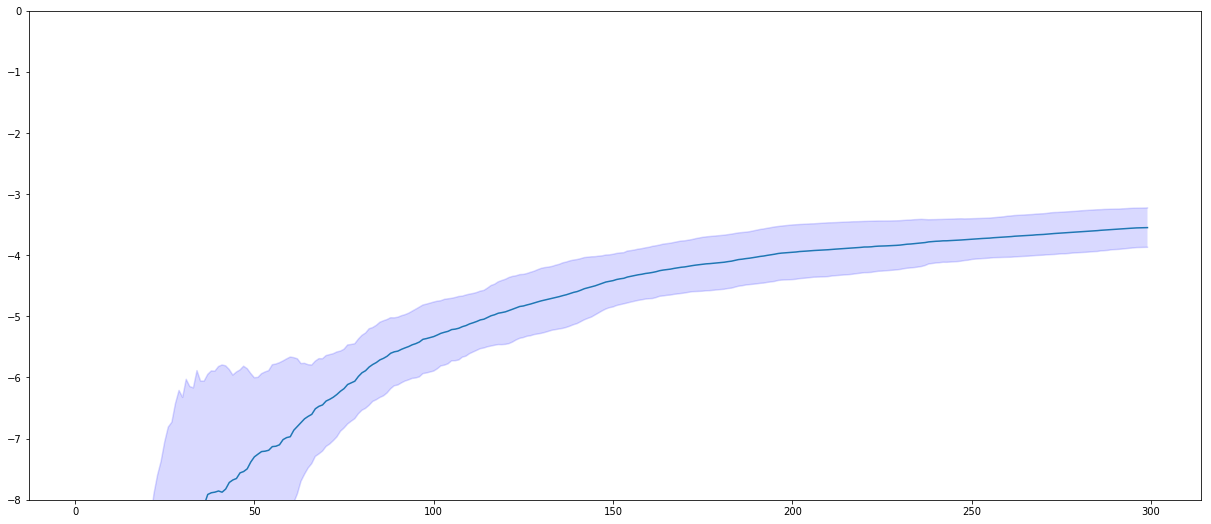

In [9]:
plt.figure(figsize=(21,9))
plt.plot(range(n_samples),np.mean(ll_psgld,0))
plt.plot(range(n_samples),upper,'blue',alpha=0.15)
plt.plot(range(n_samples),lower,'blue', alpha=0.15)
plt.fill_between(range(n_samples),lower, upper, facecolor='blue', alpha=0.15,interpolate=True)
plt.ylim(-8,0)

In [42]:
log_lik_psgld[-1]

tensor(-2.5281)

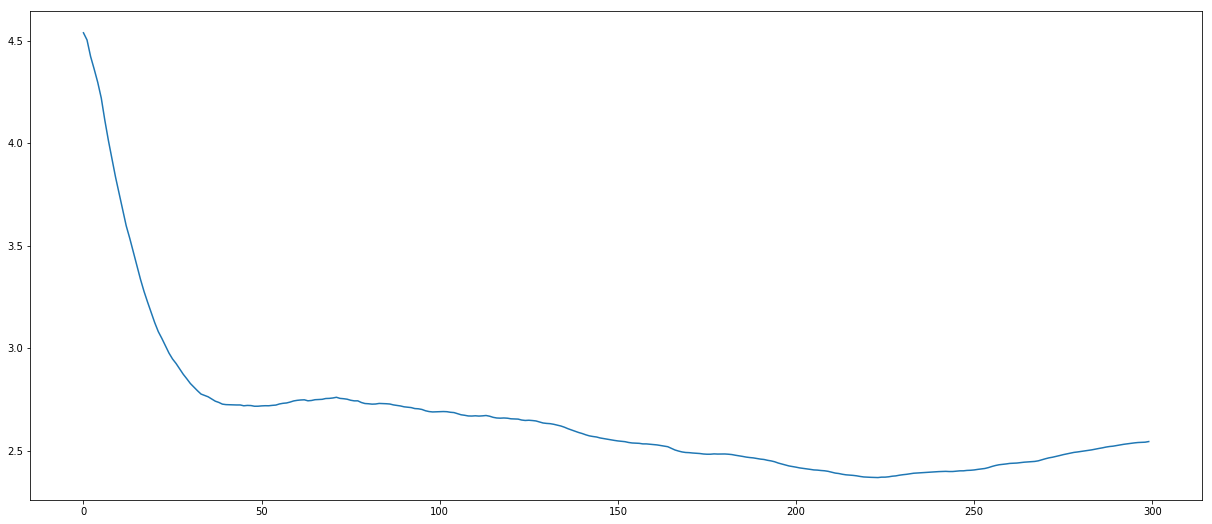

In [44]:
plt.figure(figsize=(21,9))
plt.plot(range(300),test_rmse)

## K-SGFS

In [11]:
import torch
#import torchvision
import os

from itertools import chain
from torch import nn
#from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgfs



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


batch_size = 32
dataset_size=456


n_chains = 10
n_samples = 300

ll_ksgfs = np.zeros((n_chains, n_samples))
rmse_ksgfs = np.zeros((n_chains, n_samples))


losses_ksgfs = []

for i in range(n_chains):
    network = Model()
    criterion = nn.MSELoss(size_average=False)

    optim = ksgfs.optim.KSGFS(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon= 0.2, l2=1e-3, invert_every=1)
    evaluate = evaluation(test_loader, n_samples, X_train_mean, X_train_std, y_train_mean, y_train_std)
    t = 1
    n = 0
    for epoch in range(2500):

        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)

            optim.update_curvature(x)

            network.zero_grad()
            output = network(x)
            loss = 0.5 * criterion(output, y)
            loss.backward()
            optim.step()


            losses_ksgfs.append(loss)
            running_loss += loss * batch_size / dataset_size
            prediction = output.data.max(1)[1]
            accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size

            if (t >= 300) & (t % 100 == 0) & (n < n_samples):
                rmse, ll, predictions = evaluate.fn(network)

                ll_ksgfs[i, n] = ll
                rmse_ksgfs[i, n] = rmse

                n += 1

            t += 1.
        print("chain {:d} - epoch {:d} - loss: {:.4f}".format(i, epoch, running_loss))

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 0 - loss: 13.8378
chain 0 - epoch 1 - loss: 6.4616
chain 0 - epoch 2 - loss: 5.3819
chain 0 - epoch 3 - loss: 5.9367
chain 0 - epoch 4 - loss: 6.3384
chain 0 - epoch 5 - loss: 5.9117
chain 0 - epoch 6 - loss: 4.6962
chain 0 - epoch 7 - loss: 4.5484
chain 0 - epoch 8 - loss: 6.4301
chain 0 - epoch 9 - loss: 3.6698
chain 0 - epoch 10 - loss: 4.1045
chain 0 - epoch 11 - loss: 5.3946
chain 0 - epoch 12 - loss: 4.5625
chain 0 - epoch 13 - loss: 3.4463
chain 0 - epoch 14 - loss: 5.1890
chain 0 - epoch 15 - loss: 4.4073
chain 0 - epoch 16 - loss: 2.7949
chain 0 - epoch 17 - loss: 4.5077
chain 0 - epoch 18 - loss: 4.9323
chain 0 - epoch 19 - loss: 5.8326


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 20 - loss: 4.1036
chain 0 - epoch 21 - loss: 2.6556
chain 0 - epoch 22 - loss: 5.2538
chain 0 - epoch 23 - loss: 2.2539
chain 0 - epoch 24 - loss: 2.7115
chain 0 - epoch 25 - loss: 2.1617
chain 0 - epoch 26 - loss: 4.2656
chain 0 - epoch 27 - loss: 5.3570
chain 0 - epoch 28 - loss: 2.4136
chain 0 - epoch 29 - loss: 5.1715
chain 0 - epoch 30 - loss: 2.1805
chain 0 - epoch 31 - loss: 2.6113
chain 0 - epoch 32 - loss: 1.6301
chain 0 - epoch 33 - loss: 8.2088
chain 0 - epoch 34 - loss: 3.2163
chain 0 - epoch 35 - loss: 3.3660
chain 0 - epoch 36 - loss: 3.1796
chain 0 - epoch 37 - loss: 3.1817
chain 0 - epoch 38 - loss: 2.6687
chain 0 - epoch 39 - loss: 3.7177
chain 0 - epoch 40 - loss: 1.7988
chain 0 - epoch 41 - loss: 2.1138
chain 0 - epoch 42 - loss: 1.7190
chain 0 - epoch 43 - loss: 4.3054
chain 0 - epoch 44 - loss: 4.6217
chain 0 - epoch 45 - loss: 2.9823
chain 0 - epoch 46 - loss: 2.0770
chain 0 - epoch 47 - loss: 2.6787
chain 0 - epoch 48 - loss: 3.8706
chain 0 - epoc

chain 0 - epoch 258 - loss: 2.9869
chain 0 - epoch 259 - loss: 2.5830
chain 0 - epoch 260 - loss: 2.9549
chain 0 - epoch 261 - loss: 2.8001
chain 0 - epoch 262 - loss: 2.8209
chain 0 - epoch 263 - loss: 3.1308
chain 0 - epoch 264 - loss: 2.6102
chain 0 - epoch 265 - loss: 2.5683
chain 0 - epoch 266 - loss: 2.4013
chain 0 - epoch 267 - loss: 2.3163
chain 0 - epoch 268 - loss: 5.6276
chain 0 - epoch 269 - loss: 2.8151
chain 0 - epoch 270 - loss: 3.3191
chain 0 - epoch 271 - loss: 2.5205
chain 0 - epoch 272 - loss: 4.7112
chain 0 - epoch 273 - loss: 2.9923
chain 0 - epoch 274 - loss: 2.8201
chain 0 - epoch 275 - loss: 3.4136
chain 0 - epoch 276 - loss: 4.8255
chain 0 - epoch 277 - loss: 2.6128
chain 0 - epoch 278 - loss: 2.6523
chain 0 - epoch 279 - loss: 2.3643
chain 0 - epoch 280 - loss: 2.1671
chain 0 - epoch 281 - loss: 3.1261
chain 0 - epoch 282 - loss: 2.3296
chain 0 - epoch 283 - loss: 2.5097
chain 0 - epoch 284 - loss: 3.3298
chain 0 - epoch 285 - loss: 3.2263
chain 0 - epoch 286 

chain 0 - epoch 494 - loss: 2.5362
chain 0 - epoch 495 - loss: 1.7676
chain 0 - epoch 496 - loss: 2.1650
chain 0 - epoch 497 - loss: 2.0151
chain 0 - epoch 498 - loss: 4.0180
chain 0 - epoch 499 - loss: 1.9361
chain 0 - epoch 500 - loss: 1.9375
chain 0 - epoch 501 - loss: 1.9849
chain 0 - epoch 502 - loss: 2.6665
chain 0 - epoch 503 - loss: 2.4649
chain 0 - epoch 504 - loss: 1.9635
chain 0 - epoch 505 - loss: 2.1043
chain 0 - epoch 506 - loss: 1.8721
chain 0 - epoch 507 - loss: 3.4140
chain 0 - epoch 508 - loss: 2.2661
chain 0 - epoch 509 - loss: 1.6794
chain 0 - epoch 510 - loss: 3.7607
chain 0 - epoch 511 - loss: 1.9386
chain 0 - epoch 512 - loss: 2.1590
chain 0 - epoch 513 - loss: 3.9590
chain 0 - epoch 514 - loss: 2.1105
chain 0 - epoch 515 - loss: 1.8229
chain 0 - epoch 516 - loss: 2.7157
chain 0 - epoch 517 - loss: 2.9286
chain 0 - epoch 518 - loss: 2.3940
chain 0 - epoch 519 - loss: 1.8838
chain 0 - epoch 520 - loss: 2.7241
chain 0 - epoch 521 - loss: 2.0173
chain 0 - epoch 522 

chain 0 - epoch 729 - loss: 2.1078
chain 0 - epoch 730 - loss: 2.9036
chain 0 - epoch 731 - loss: 2.1817
chain 0 - epoch 732 - loss: 1.9977
chain 0 - epoch 733 - loss: 2.3824
chain 0 - epoch 734 - loss: 1.9534
chain 0 - epoch 735 - loss: 2.5802
chain 0 - epoch 736 - loss: 8.7878
chain 0 - epoch 737 - loss: 2.2767
chain 0 - epoch 738 - loss: 2.8707
chain 0 - epoch 739 - loss: 3.6544
chain 0 - epoch 740 - loss: 2.6678
chain 0 - epoch 741 - loss: 2.1976
chain 0 - epoch 742 - loss: 2.1381
chain 0 - epoch 743 - loss: 2.4067
chain 0 - epoch 744 - loss: 2.1542
chain 0 - epoch 745 - loss: 2.4311
chain 0 - epoch 746 - loss: 2.0994
chain 0 - epoch 747 - loss: 2.5531
chain 0 - epoch 748 - loss: 3.2393
chain 0 - epoch 749 - loss: 2.7295
chain 0 - epoch 750 - loss: 3.5973
chain 0 - epoch 751 - loss: 2.4631
chain 0 - epoch 752 - loss: 3.2747
chain 0 - epoch 753 - loss: 1.8658
chain 0 - epoch 754 - loss: 3.7878
chain 0 - epoch 755 - loss: 2.2463
chain 0 - epoch 756 - loss: 3.2030
chain 0 - epoch 757 

chain 0 - epoch 964 - loss: 3.2606
chain 0 - epoch 965 - loss: 5.2426
chain 0 - epoch 966 - loss: 2.7743
chain 0 - epoch 967 - loss: 2.4590
chain 0 - epoch 968 - loss: 2.9472
chain 0 - epoch 969 - loss: 2.3992
chain 0 - epoch 970 - loss: 3.0485
chain 0 - epoch 971 - loss: 2.1481
chain 0 - epoch 972 - loss: 2.2659
chain 0 - epoch 973 - loss: 3.8621
chain 0 - epoch 974 - loss: 1.9465
chain 0 - epoch 975 - loss: 1.9509
chain 0 - epoch 976 - loss: 5.5556
chain 0 - epoch 977 - loss: 2.7914
chain 0 - epoch 978 - loss: 2.9937
chain 0 - epoch 979 - loss: 2.9266
chain 0 - epoch 980 - loss: 2.0402
chain 0 - epoch 981 - loss: 3.2761
chain 0 - epoch 982 - loss: 4.7911
chain 0 - epoch 983 - loss: 2.4165
chain 0 - epoch 984 - loss: 3.0445
chain 0 - epoch 985 - loss: 3.6948
chain 0 - epoch 986 - loss: 3.1729
chain 0 - epoch 987 - loss: 2.4320
chain 0 - epoch 988 - loss: 2.0563
chain 0 - epoch 989 - loss: 4.1619
chain 0 - epoch 990 - loss: 2.5156
chain 0 - epoch 991 - loss: 2.2471
chain 0 - epoch 992 

chain 0 - epoch 1193 - loss: 2.6749
chain 0 - epoch 1194 - loss: 1.7094
chain 0 - epoch 1195 - loss: 3.0610
chain 0 - epoch 1196 - loss: 2.3059
chain 0 - epoch 1197 - loss: 2.1678
chain 0 - epoch 1198 - loss: 2.1016
chain 0 - epoch 1199 - loss: 2.6311
chain 0 - epoch 1200 - loss: 2.1071
chain 0 - epoch 1201 - loss: 1.9447
chain 0 - epoch 1202 - loss: 2.5174
chain 0 - epoch 1203 - loss: 2.8877
chain 0 - epoch 1204 - loss: 2.6922
chain 0 - epoch 1205 - loss: 3.8884
chain 0 - epoch 1206 - loss: 2.2126
chain 0 - epoch 1207 - loss: 3.5150
chain 0 - epoch 1208 - loss: 2.2725
chain 0 - epoch 1209 - loss: 2.2686
chain 0 - epoch 1210 - loss: 2.4676
chain 0 - epoch 1211 - loss: 2.5287
chain 0 - epoch 1212 - loss: 3.8699
chain 0 - epoch 1213 - loss: 2.8134
chain 0 - epoch 1214 - loss: 2.3458
chain 0 - epoch 1215 - loss: 3.3223
chain 0 - epoch 1216 - loss: 2.1751
chain 0 - epoch 1217 - loss: 2.1838
chain 0 - epoch 1218 - loss: 2.1319
chain 0 - epoch 1219 - loss: 3.0816
chain 0 - epoch 1220 - loss:

chain 0 - epoch 1421 - loss: 4.2723
chain 0 - epoch 1422 - loss: 2.5840
chain 0 - epoch 1423 - loss: 2.4319
chain 0 - epoch 1424 - loss: 2.2960
chain 0 - epoch 1425 - loss: 2.7779
chain 0 - epoch 1426 - loss: 1.9819
chain 0 - epoch 1427 - loss: 3.1216
chain 0 - epoch 1428 - loss: 2.9071
chain 0 - epoch 1429 - loss: 1.9310
chain 0 - epoch 1430 - loss: 2.4272
chain 0 - epoch 1431 - loss: 3.3200
chain 0 - epoch 1432 - loss: 2.9401
chain 0 - epoch 1433 - loss: 1.8573
chain 0 - epoch 1434 - loss: 2.4705
chain 0 - epoch 1435 - loss: 3.3708
chain 0 - epoch 1436 - loss: 3.1033
chain 0 - epoch 1437 - loss: 1.9545
chain 0 - epoch 1438 - loss: 2.1223
chain 0 - epoch 1439 - loss: 2.6419
chain 0 - epoch 1440 - loss: 2.5573
chain 0 - epoch 1441 - loss: 3.1348
chain 0 - epoch 1442 - loss: 2.5319
chain 0 - epoch 1443 - loss: 1.7279
chain 0 - epoch 1444 - loss: 3.6258
chain 0 - epoch 1445 - loss: 2.8928
chain 0 - epoch 1446 - loss: 1.8376
chain 0 - epoch 1447 - loss: 1.8761
chain 0 - epoch 1448 - loss:

chain 0 - epoch 1649 - loss: 2.2675
chain 0 - epoch 1650 - loss: 2.3280
chain 0 - epoch 1651 - loss: 3.2870
chain 0 - epoch 1652 - loss: 5.6786
chain 0 - epoch 1653 - loss: 4.8755
chain 0 - epoch 1654 - loss: 1.8787
chain 0 - epoch 1655 - loss: 2.3366
chain 0 - epoch 1656 - loss: 1.8832
chain 0 - epoch 1657 - loss: 2.3889
chain 0 - epoch 1658 - loss: 2.3142
chain 0 - epoch 1659 - loss: 1.9434
chain 0 - epoch 1660 - loss: 2.4487
chain 0 - epoch 1661 - loss: 2.4972
chain 0 - epoch 1662 - loss: 1.6978
chain 0 - epoch 1663 - loss: 1.7816
chain 0 - epoch 1664 - loss: 1.9211
chain 0 - epoch 1665 - loss: 2.5930
chain 0 - epoch 1666 - loss: 2.6710
chain 0 - epoch 1667 - loss: 1.8016
chain 0 - epoch 1668 - loss: 2.5292
chain 0 - epoch 1669 - loss: 1.9986
chain 0 - epoch 1670 - loss: 1.7272
chain 0 - epoch 1671 - loss: 3.8490
chain 0 - epoch 1672 - loss: 2.9040
chain 0 - epoch 1673 - loss: 2.3985
chain 0 - epoch 1674 - loss: 2.0342
chain 0 - epoch 1675 - loss: 1.8198
chain 0 - epoch 1676 - loss:

chain 0 - epoch 1877 - loss: 2.3908
chain 0 - epoch 1878 - loss: 2.6982
chain 0 - epoch 1879 - loss: 2.7206
chain 0 - epoch 1880 - loss: 6.5063
chain 0 - epoch 1881 - loss: 2.7431
chain 0 - epoch 1882 - loss: 2.5566
chain 0 - epoch 1883 - loss: 3.5277
chain 0 - epoch 1884 - loss: 2.5346
chain 0 - epoch 1885 - loss: 4.3986
chain 0 - epoch 1886 - loss: 2.1374
chain 0 - epoch 1887 - loss: 1.8301
chain 0 - epoch 1888 - loss: 2.9495
chain 0 - epoch 1889 - loss: 2.8790
chain 0 - epoch 1890 - loss: 6.8882
chain 0 - epoch 1891 - loss: 1.8862
chain 0 - epoch 1892 - loss: 3.5198
chain 0 - epoch 1893 - loss: 1.7989
chain 0 - epoch 1894 - loss: 3.3919
chain 0 - epoch 1895 - loss: 2.0326
chain 0 - epoch 1896 - loss: 2.3487
chain 0 - epoch 1897 - loss: 1.9272
chain 0 - epoch 1898 - loss: 2.0719
chain 0 - epoch 1899 - loss: 2.1950
chain 0 - epoch 1900 - loss: 2.6698
chain 0 - epoch 1901 - loss: 3.5835
chain 0 - epoch 1902 - loss: 3.9269
chain 0 - epoch 1903 - loss: 2.2566
chain 0 - epoch 1904 - loss:

chain 0 - epoch 2105 - loss: 3.4635
chain 0 - epoch 2106 - loss: 2.3924
chain 0 - epoch 2107 - loss: 2.8899
chain 0 - epoch 2108 - loss: 2.6484
chain 0 - epoch 2109 - loss: 2.9197
chain 0 - epoch 2110 - loss: 1.9501
chain 0 - epoch 2111 - loss: 3.0613
chain 0 - epoch 2112 - loss: 3.3810
chain 0 - epoch 2113 - loss: 2.3155
chain 0 - epoch 2114 - loss: 2.4722
chain 0 - epoch 2115 - loss: 3.2787
chain 0 - epoch 2116 - loss: 2.2750
chain 0 - epoch 2117 - loss: 2.7281
chain 0 - epoch 2118 - loss: 2.8011
chain 0 - epoch 2119 - loss: 2.0402
chain 0 - epoch 2120 - loss: 2.2764
chain 0 - epoch 2121 - loss: 2.8049
chain 0 - epoch 2122 - loss: 2.6373
chain 0 - epoch 2123 - loss: 2.6230
chain 0 - epoch 2124 - loss: 3.0150
chain 0 - epoch 2125 - loss: 3.1307
chain 0 - epoch 2126 - loss: 2.1576
chain 0 - epoch 2127 - loss: 2.0390
chain 0 - epoch 2128 - loss: 2.2998
chain 0 - epoch 2129 - loss: 2.3573
chain 0 - epoch 2130 - loss: 2.2442
chain 0 - epoch 2131 - loss: 2.4462
chain 0 - epoch 2132 - loss:

chain 0 - epoch 2333 - loss: 2.4077
chain 0 - epoch 2334 - loss: 2.5677
chain 0 - epoch 2335 - loss: 2.4659
chain 0 - epoch 2336 - loss: 2.3788
chain 0 - epoch 2337 - loss: 1.9559
chain 0 - epoch 2338 - loss: 2.7542
chain 0 - epoch 2339 - loss: 3.0242
chain 0 - epoch 2340 - loss: 2.4168
chain 0 - epoch 2341 - loss: 2.0027
chain 0 - epoch 2342 - loss: 2.7659
chain 0 - epoch 2343 - loss: 2.2809
chain 0 - epoch 2344 - loss: 2.0267
chain 0 - epoch 2345 - loss: 1.6502
chain 0 - epoch 2346 - loss: 3.3209
chain 0 - epoch 2347 - loss: 2.0914
chain 0 - epoch 2348 - loss: 3.0375
chain 0 - epoch 2349 - loss: 2.2375
chain 0 - epoch 2350 - loss: 2.5936
chain 0 - epoch 2351 - loss: 2.3286
chain 0 - epoch 2352 - loss: 1.8246
chain 0 - epoch 2353 - loss: 2.2995
chain 0 - epoch 2354 - loss: 2.4360
chain 0 - epoch 2355 - loss: 4.0947
chain 0 - epoch 2356 - loss: 2.7048
chain 0 - epoch 2357 - loss: 1.7137
chain 0 - epoch 2358 - loss: 2.6477
chain 0 - epoch 2359 - loss: 2.0061
chain 0 - epoch 2360 - loss:

chain 1 - epoch 66 - loss: 7.1302
chain 1 - epoch 67 - loss: 6.5995
chain 1 - epoch 68 - loss: 2.8740
chain 1 - epoch 69 - loss: 2.6920
chain 1 - epoch 70 - loss: 3.8725
chain 1 - epoch 71 - loss: 3.1218
chain 1 - epoch 72 - loss: 4.9158
chain 1 - epoch 73 - loss: 3.7500
chain 1 - epoch 74 - loss: 3.1907
chain 1 - epoch 75 - loss: 3.0723
chain 1 - epoch 76 - loss: 5.8617
chain 1 - epoch 77 - loss: 4.1016
chain 1 - epoch 78 - loss: 5.4258
chain 1 - epoch 79 - loss: 3.3076
chain 1 - epoch 80 - loss: 3.9394
chain 1 - epoch 81 - loss: 5.0647
chain 1 - epoch 82 - loss: 2.8050
chain 1 - epoch 83 - loss: 3.1815
chain 1 - epoch 84 - loss: 7.1955
chain 1 - epoch 85 - loss: 2.7649
chain 1 - epoch 86 - loss: 2.2360
chain 1 - epoch 87 - loss: 3.9448
chain 1 - epoch 88 - loss: 3.8555
chain 1 - epoch 89 - loss: 3.3789
chain 1 - epoch 90 - loss: 2.6349
chain 1 - epoch 91 - loss: 3.2722
chain 1 - epoch 92 - loss: 6.4551
chain 1 - epoch 93 - loss: 2.7304
chain 1 - epoch 94 - loss: 4.9682
chain 1 - epoc

chain 1 - epoch 302 - loss: 2.1228
chain 1 - epoch 303 - loss: 3.1163
chain 1 - epoch 304 - loss: 2.8433
chain 1 - epoch 305 - loss: 2.7501
chain 1 - epoch 306 - loss: 1.8745
chain 1 - epoch 307 - loss: 2.7198
chain 1 - epoch 308 - loss: 2.2936
chain 1 - epoch 309 - loss: 1.6342
chain 1 - epoch 310 - loss: 3.5235
chain 1 - epoch 311 - loss: 2.3184
chain 1 - epoch 312 - loss: 2.1786
chain 1 - epoch 313 - loss: 2.1756
chain 1 - epoch 314 - loss: 4.3859
chain 1 - epoch 315 - loss: 2.3120
chain 1 - epoch 316 - loss: 2.9237
chain 1 - epoch 317 - loss: 2.6911
chain 1 - epoch 318 - loss: 2.7674
chain 1 - epoch 319 - loss: 2.5137
chain 1 - epoch 320 - loss: 1.8571
chain 1 - epoch 321 - loss: 2.2708
chain 1 - epoch 322 - loss: 2.5847
chain 1 - epoch 323 - loss: 2.2422
chain 1 - epoch 324 - loss: 1.9174
chain 1 - epoch 325 - loss: 4.0807
chain 1 - epoch 326 - loss: 3.8084
chain 1 - epoch 327 - loss: 2.6585
chain 1 - epoch 328 - loss: 3.1691
chain 1 - epoch 329 - loss: 2.7871
chain 1 - epoch 330 

chain 1 - epoch 538 - loss: 2.7213
chain 1 - epoch 539 - loss: 1.9576
chain 1 - epoch 540 - loss: 2.4241
chain 1 - epoch 541 - loss: 4.5484
chain 1 - epoch 542 - loss: 2.7516
chain 1 - epoch 543 - loss: 2.6804
chain 1 - epoch 544 - loss: 2.6481
chain 1 - epoch 545 - loss: 2.3636
chain 1 - epoch 546 - loss: 1.8555
chain 1 - epoch 547 - loss: 2.3943
chain 1 - epoch 548 - loss: 2.4472
chain 1 - epoch 549 - loss: 4.1287
chain 1 - epoch 550 - loss: 6.5841
chain 1 - epoch 551 - loss: 4.1626
chain 1 - epoch 552 - loss: 3.8079
chain 1 - epoch 553 - loss: 4.7736
chain 1 - epoch 554 - loss: 3.5082
chain 1 - epoch 555 - loss: 2.0769
chain 1 - epoch 556 - loss: 2.4851
chain 1 - epoch 557 - loss: 2.0479
chain 1 - epoch 558 - loss: 3.3122
chain 1 - epoch 559 - loss: 1.9345
chain 1 - epoch 560 - loss: 1.7400
chain 1 - epoch 561 - loss: 1.5726
chain 1 - epoch 562 - loss: 2.3991
chain 1 - epoch 563 - loss: 1.7203
chain 1 - epoch 564 - loss: 3.8167
chain 1 - epoch 565 - loss: 1.9880
chain 1 - epoch 566 

chain 1 - epoch 774 - loss: 2.2931
chain 1 - epoch 775 - loss: 2.9190
chain 1 - epoch 776 - loss: 2.4926
chain 1 - epoch 777 - loss: 1.7974
chain 1 - epoch 778 - loss: 2.1211
chain 1 - epoch 779 - loss: 2.2745
chain 1 - epoch 780 - loss: 1.8509
chain 1 - epoch 781 - loss: 7.0786
chain 1 - epoch 782 - loss: 6.5451
chain 1 - epoch 783 - loss: 2.7009
chain 1 - epoch 784 - loss: 2.4404
chain 1 - epoch 785 - loss: 4.7910
chain 1 - epoch 786 - loss: 4.1136
chain 1 - epoch 787 - loss: 1.6543
chain 1 - epoch 788 - loss: 2.4627
chain 1 - epoch 789 - loss: 3.7392
chain 1 - epoch 790 - loss: 3.0654
chain 1 - epoch 791 - loss: 3.4376
chain 1 - epoch 792 - loss: 2.5934
chain 1 - epoch 793 - loss: 1.7718
chain 1 - epoch 794 - loss: 2.9265
chain 1 - epoch 795 - loss: 1.9408
chain 1 - epoch 796 - loss: 2.3248
chain 1 - epoch 797 - loss: 1.7883
chain 1 - epoch 798 - loss: 3.1679
chain 1 - epoch 799 - loss: 3.6549
chain 1 - epoch 800 - loss: 2.0791
chain 1 - epoch 801 - loss: 2.5145
chain 1 - epoch 802 

chain 1 - epoch 1009 - loss: 1.7076
chain 1 - epoch 1010 - loss: 4.3800
chain 1 - epoch 1011 - loss: 4.3600
chain 1 - epoch 1012 - loss: 2.4317
chain 1 - epoch 1013 - loss: 4.6463
chain 1 - epoch 1014 - loss: 2.3115
chain 1 - epoch 1015 - loss: 3.7243
chain 1 - epoch 1016 - loss: 2.5665
chain 1 - epoch 1017 - loss: 2.4254
chain 1 - epoch 1018 - loss: 2.1568
chain 1 - epoch 1019 - loss: 2.7605
chain 1 - epoch 1020 - loss: 3.0536
chain 1 - epoch 1021 - loss: 1.7368
chain 1 - epoch 1022 - loss: 1.9176
chain 1 - epoch 1023 - loss: 2.4105
chain 1 - epoch 1024 - loss: 5.4201
chain 1 - epoch 1025 - loss: 2.8185
chain 1 - epoch 1026 - loss: 3.4978
chain 1 - epoch 1027 - loss: 3.0954
chain 1 - epoch 1028 - loss: 3.4169
chain 1 - epoch 1029 - loss: 1.9044
chain 1 - epoch 1030 - loss: 2.0093
chain 1 - epoch 1031 - loss: 2.4920
chain 1 - epoch 1032 - loss: 1.7082
chain 1 - epoch 1033 - loss: 1.8781
chain 1 - epoch 1034 - loss: 2.5585
chain 1 - epoch 1035 - loss: 3.8046
chain 1 - epoch 1036 - loss:

chain 1 - epoch 1237 - loss: 2.4999
chain 1 - epoch 1238 - loss: 2.0213
chain 1 - epoch 1239 - loss: 1.7652
chain 1 - epoch 1240 - loss: 1.6310
chain 1 - epoch 1241 - loss: 2.8659
chain 1 - epoch 1242 - loss: 2.9522
chain 1 - epoch 1243 - loss: 3.0241
chain 1 - epoch 1244 - loss: 2.0497
chain 1 - epoch 1245 - loss: 2.2932
chain 1 - epoch 1246 - loss: 2.7817
chain 1 - epoch 1247 - loss: 2.6221
chain 1 - epoch 1248 - loss: 4.8493
chain 1 - epoch 1249 - loss: 1.9575
chain 1 - epoch 1250 - loss: 1.9797
chain 1 - epoch 1251 - loss: 5.6134
chain 1 - epoch 1252 - loss: 2.3015
chain 1 - epoch 1253 - loss: 4.2479
chain 1 - epoch 1254 - loss: 2.1644
chain 1 - epoch 1255 - loss: 3.8700
chain 1 - epoch 1256 - loss: 2.7582
chain 1 - epoch 1257 - loss: 2.5102
chain 1 - epoch 1258 - loss: 2.3078
chain 1 - epoch 1259 - loss: 1.6959
chain 1 - epoch 1260 - loss: 2.6813
chain 1 - epoch 1261 - loss: 2.4558
chain 1 - epoch 1262 - loss: 4.6202
chain 1 - epoch 1263 - loss: 2.3259
chain 1 - epoch 1264 - loss:

chain 1 - epoch 1465 - loss: 2.7122
chain 1 - epoch 1466 - loss: 3.2978
chain 1 - epoch 1467 - loss: 2.3308
chain 1 - epoch 1468 - loss: 3.9037
chain 1 - epoch 1469 - loss: 2.4588
chain 1 - epoch 1470 - loss: 1.7317
chain 1 - epoch 1471 - loss: 2.8912
chain 1 - epoch 1472 - loss: 2.8879
chain 1 - epoch 1473 - loss: 3.2222
chain 1 - epoch 1474 - loss: 2.3134
chain 1 - epoch 1475 - loss: 6.4877
chain 1 - epoch 1476 - loss: 2.7778
chain 1 - epoch 1477 - loss: 2.5780
chain 1 - epoch 1478 - loss: 3.7459
chain 1 - epoch 1479 - loss: 2.2510
chain 1 - epoch 1480 - loss: 2.7660
chain 1 - epoch 1481 - loss: 2.2202
chain 1 - epoch 1482 - loss: 4.8373
chain 1 - epoch 1483 - loss: 2.6560
chain 1 - epoch 1484 - loss: 1.9205
chain 1 - epoch 1485 - loss: 2.4759
chain 1 - epoch 1486 - loss: 2.6668
chain 1 - epoch 1487 - loss: 2.0992
chain 1 - epoch 1488 - loss: 2.0347
chain 1 - epoch 1489 - loss: 3.4625
chain 1 - epoch 1490 - loss: 5.4543
chain 1 - epoch 1491 - loss: 2.6288
chain 1 - epoch 1492 - loss:

chain 1 - epoch 1693 - loss: 1.6319
chain 1 - epoch 1694 - loss: 6.8211
chain 1 - epoch 1695 - loss: 1.9154
chain 1 - epoch 1696 - loss: 1.8825
chain 1 - epoch 1697 - loss: 1.9726
chain 1 - epoch 1698 - loss: 1.6307
chain 1 - epoch 1699 - loss: 1.8535
chain 1 - epoch 1700 - loss: 2.3355
chain 1 - epoch 1701 - loss: 1.8321
chain 1 - epoch 1702 - loss: 2.8462
chain 1 - epoch 1703 - loss: 2.0483
chain 1 - epoch 1704 - loss: 1.7266
chain 1 - epoch 1705 - loss: 1.9245
chain 1 - epoch 1706 - loss: 2.3611
chain 1 - epoch 1707 - loss: 1.9142
chain 1 - epoch 1708 - loss: 2.2104
chain 1 - epoch 1709 - loss: 3.4032
chain 1 - epoch 1710 - loss: 2.1708
chain 1 - epoch 1711 - loss: 5.4736
chain 1 - epoch 1712 - loss: 4.7024
chain 1 - epoch 1713 - loss: 2.0950
chain 1 - epoch 1714 - loss: 1.8820
chain 1 - epoch 1715 - loss: 2.2886
chain 1 - epoch 1716 - loss: 2.0726
chain 1 - epoch 1717 - loss: 1.6732
chain 1 - epoch 1718 - loss: 2.0707
chain 1 - epoch 1719 - loss: 3.1381
chain 1 - epoch 1720 - loss:

chain 1 - epoch 1921 - loss: 4.5845
chain 1 - epoch 1922 - loss: 1.8471
chain 1 - epoch 1923 - loss: 1.8022
chain 1 - epoch 1924 - loss: 1.6017
chain 1 - epoch 1925 - loss: 2.0062
chain 1 - epoch 1926 - loss: 1.9455
chain 1 - epoch 1927 - loss: 5.6303
chain 1 - epoch 1928 - loss: 3.6623
chain 1 - epoch 1929 - loss: 1.7940
chain 1 - epoch 1930 - loss: 2.0485
chain 1 - epoch 1931 - loss: 2.0174
chain 1 - epoch 1932 - loss: 4.6703
chain 1 - epoch 1933 - loss: 1.7055
chain 1 - epoch 1934 - loss: 2.3103
chain 1 - epoch 1935 - loss: 2.2167
chain 1 - epoch 1936 - loss: 1.8989
chain 1 - epoch 1937 - loss: 1.8245
chain 1 - epoch 1938 - loss: 2.0955
chain 1 - epoch 1939 - loss: 4.3589
chain 1 - epoch 1940 - loss: 2.4680
chain 1 - epoch 1941 - loss: 1.7027
chain 1 - epoch 1942 - loss: 1.8441
chain 1 - epoch 1943 - loss: 2.2733
chain 1 - epoch 1944 - loss: 2.4144
chain 1 - epoch 1945 - loss: 2.0780
chain 1 - epoch 1946 - loss: 4.6973
chain 1 - epoch 1947 - loss: 1.9267
chain 1 - epoch 1948 - loss:

chain 1 - epoch 2149 - loss: 2.6709
chain 1 - epoch 2150 - loss: 2.0115
chain 1 - epoch 2151 - loss: 2.0999
chain 1 - epoch 2152 - loss: 2.1976
chain 1 - epoch 2153 - loss: 4.9145
chain 1 - epoch 2154 - loss: 2.2505
chain 1 - epoch 2155 - loss: 3.6328
chain 1 - epoch 2156 - loss: 2.8993
chain 1 - epoch 2157 - loss: 1.8940
chain 1 - epoch 2158 - loss: 1.7155
chain 1 - epoch 2159 - loss: 3.0519
chain 1 - epoch 2160 - loss: 1.7998
chain 1 - epoch 2161 - loss: 2.5200
chain 1 - epoch 2162 - loss: 1.7055
chain 1 - epoch 2163 - loss: 2.6194
chain 1 - epoch 2164 - loss: 6.2824
chain 1 - epoch 2165 - loss: 2.0092
chain 1 - epoch 2166 - loss: 2.4764
chain 1 - epoch 2167 - loss: 1.7724
chain 1 - epoch 2168 - loss: 2.5653
chain 1 - epoch 2169 - loss: 6.1424
chain 1 - epoch 2170 - loss: 2.4123
chain 1 - epoch 2171 - loss: 3.2558
chain 1 - epoch 2172 - loss: 2.5498
chain 1 - epoch 2173 - loss: 3.1438
chain 1 - epoch 2174 - loss: 2.1306
chain 1 - epoch 2175 - loss: 3.4783
chain 1 - epoch 2176 - loss:

chain 1 - epoch 2377 - loss: 2.5174
chain 1 - epoch 2378 - loss: 2.1236
chain 1 - epoch 2379 - loss: 2.7054
chain 1 - epoch 2380 - loss: 3.0992
chain 1 - epoch 2381 - loss: 2.7465
chain 1 - epoch 2382 - loss: 2.2803
chain 1 - epoch 2383 - loss: 2.1596
chain 1 - epoch 2384 - loss: 2.7416
chain 1 - epoch 2385 - loss: 2.6673
chain 1 - epoch 2386 - loss: 1.7719
chain 1 - epoch 2387 - loss: 1.9474
chain 1 - epoch 2388 - loss: 1.9564
chain 1 - epoch 2389 - loss: 1.6914
chain 1 - epoch 2390 - loss: 2.7107
chain 1 - epoch 2391 - loss: 5.9176
chain 1 - epoch 2392 - loss: 1.8361
chain 1 - epoch 2393 - loss: 2.7659
chain 1 - epoch 2394 - loss: 1.9854
chain 1 - epoch 2395 - loss: 3.2857
chain 1 - epoch 2396 - loss: 3.0968
chain 1 - epoch 2397 - loss: 3.1778
chain 1 - epoch 2398 - loss: 2.4619
chain 1 - epoch 2399 - loss: 4.4624
chain 1 - epoch 2400 - loss: 2.4131
chain 1 - epoch 2401 - loss: 2.3221
chain 1 - epoch 2402 - loss: 2.7300
chain 1 - epoch 2403 - loss: 2.7918
chain 1 - epoch 2404 - loss:

chain 2 - epoch 111 - loss: 3.7816
chain 2 - epoch 112 - loss: 2.1637
chain 2 - epoch 113 - loss: 1.9827
chain 2 - epoch 114 - loss: 3.3633
chain 2 - epoch 115 - loss: 2.0901
chain 2 - epoch 116 - loss: 3.2463
chain 2 - epoch 117 - loss: 2.6308
chain 2 - epoch 118 - loss: 2.8284
chain 2 - epoch 119 - loss: 2.4099
chain 2 - epoch 120 - loss: 2.5299
chain 2 - epoch 121 - loss: 2.3928
chain 2 - epoch 122 - loss: 2.3445
chain 2 - epoch 123 - loss: 2.1021
chain 2 - epoch 124 - loss: 3.0880
chain 2 - epoch 125 - loss: 3.5539
chain 2 - epoch 126 - loss: 2.5442
chain 2 - epoch 127 - loss: 2.3327
chain 2 - epoch 128 - loss: 2.5168
chain 2 - epoch 129 - loss: 4.5002
chain 2 - epoch 130 - loss: 3.3507
chain 2 - epoch 131 - loss: 3.0122
chain 2 - epoch 132 - loss: 2.3849
chain 2 - epoch 133 - loss: 2.0485
chain 2 - epoch 134 - loss: 2.5997
chain 2 - epoch 135 - loss: 2.0991
chain 2 - epoch 136 - loss: 3.2708
chain 2 - epoch 137 - loss: 1.9693
chain 2 - epoch 138 - loss: 1.8144
chain 2 - epoch 139 

chain 2 - epoch 347 - loss: 3.1984
chain 2 - epoch 348 - loss: 1.8482
chain 2 - epoch 349 - loss: 2.5142
chain 2 - epoch 350 - loss: 2.6068
chain 2 - epoch 351 - loss: 3.1083
chain 2 - epoch 352 - loss: 2.3083
chain 2 - epoch 353 - loss: 2.2791
chain 2 - epoch 354 - loss: 3.1380
chain 2 - epoch 355 - loss: 2.7268
chain 2 - epoch 356 - loss: 2.6956
chain 2 - epoch 357 - loss: 2.8961
chain 2 - epoch 358 - loss: 2.0611
chain 2 - epoch 359 - loss: 2.4093
chain 2 - epoch 360 - loss: 3.1667
chain 2 - epoch 361 - loss: 2.8376
chain 2 - epoch 362 - loss: 3.0121
chain 2 - epoch 363 - loss: 2.2687
chain 2 - epoch 364 - loss: 2.3226
chain 2 - epoch 365 - loss: 1.8360
chain 2 - epoch 366 - loss: 3.6197
chain 2 - epoch 367 - loss: 3.0313
chain 2 - epoch 368 - loss: 2.6287
chain 2 - epoch 369 - loss: 3.0241
chain 2 - epoch 370 - loss: 2.9029
chain 2 - epoch 371 - loss: 2.3263
chain 2 - epoch 372 - loss: 2.5295
chain 2 - epoch 373 - loss: 2.8069
chain 2 - epoch 374 - loss: 2.1257
chain 2 - epoch 375 

chain 2 - epoch 582 - loss: 3.6633
chain 2 - epoch 583 - loss: 4.3402
chain 2 - epoch 584 - loss: 3.1500
chain 2 - epoch 585 - loss: 1.8759
chain 2 - epoch 586 - loss: 2.6596
chain 2 - epoch 587 - loss: 2.0671
chain 2 - epoch 588 - loss: 2.6354
chain 2 - epoch 589 - loss: 3.0785
chain 2 - epoch 590 - loss: 2.2758
chain 2 - epoch 591 - loss: 4.1531
chain 2 - epoch 592 - loss: 2.9431
chain 2 - epoch 593 - loss: 2.8615
chain 2 - epoch 594 - loss: 3.6680
chain 2 - epoch 595 - loss: 2.7521
chain 2 - epoch 596 - loss: 4.4833
chain 2 - epoch 597 - loss: 2.1536
chain 2 - epoch 598 - loss: 1.8364
chain 2 - epoch 599 - loss: 2.9290
chain 2 - epoch 600 - loss: 1.8764
chain 2 - epoch 601 - loss: 3.0664
chain 2 - epoch 602 - loss: 2.9634
chain 2 - epoch 603 - loss: 4.0433
chain 2 - epoch 604 - loss: 3.6160
chain 2 - epoch 605 - loss: 2.6954
chain 2 - epoch 606 - loss: 3.7199
chain 2 - epoch 607 - loss: 4.1379
chain 2 - epoch 608 - loss: 3.0489
chain 2 - epoch 609 - loss: 3.0642
chain 2 - epoch 610 

chain 2 - epoch 817 - loss: 6.7775
chain 2 - epoch 818 - loss: 2.3689
chain 2 - epoch 819 - loss: 3.3463
chain 2 - epoch 820 - loss: 2.5300
chain 2 - epoch 821 - loss: 2.5308
chain 2 - epoch 822 - loss: 3.4355
chain 2 - epoch 823 - loss: 2.4594
chain 2 - epoch 824 - loss: 1.6661
chain 2 - epoch 825 - loss: 2.4057
chain 2 - epoch 826 - loss: 2.4148
chain 2 - epoch 827 - loss: 2.0104
chain 2 - epoch 828 - loss: 2.4575
chain 2 - epoch 829 - loss: 2.9755
chain 2 - epoch 830 - loss: 2.9400
chain 2 - epoch 831 - loss: 1.9838
chain 2 - epoch 832 - loss: 1.9671
chain 2 - epoch 833 - loss: 2.6800
chain 2 - epoch 834 - loss: 2.7414
chain 2 - epoch 835 - loss: 2.0487
chain 2 - epoch 836 - loss: 2.5103
chain 2 - epoch 837 - loss: 4.3620
chain 2 - epoch 838 - loss: 2.2944
chain 2 - epoch 839 - loss: 1.8866
chain 2 - epoch 840 - loss: 2.4273
chain 2 - epoch 841 - loss: 1.9694
chain 2 - epoch 842 - loss: 5.2839
chain 2 - epoch 843 - loss: 2.2282
chain 2 - epoch 844 - loss: 2.6907
chain 2 - epoch 845 

chain 2 - epoch 1050 - loss: 2.7787
chain 2 - epoch 1051 - loss: 3.3598
chain 2 - epoch 1052 - loss: 2.3161
chain 2 - epoch 1053 - loss: 2.9861
chain 2 - epoch 1054 - loss: 1.8857
chain 2 - epoch 1055 - loss: 2.9748
chain 2 - epoch 1056 - loss: 2.2321
chain 2 - epoch 1057 - loss: 2.1865
chain 2 - epoch 1058 - loss: 4.8138
chain 2 - epoch 1059 - loss: 3.3520
chain 2 - epoch 1060 - loss: 2.4142
chain 2 - epoch 1061 - loss: 1.9746
chain 2 - epoch 1062 - loss: 2.1476
chain 2 - epoch 1063 - loss: 2.2957
chain 2 - epoch 1064 - loss: 2.3230
chain 2 - epoch 1065 - loss: 2.2492
chain 2 - epoch 1066 - loss: 2.8780
chain 2 - epoch 1067 - loss: 1.7824
chain 2 - epoch 1068 - loss: 2.2681
chain 2 - epoch 1069 - loss: 1.9756
chain 2 - epoch 1070 - loss: 3.3491
chain 2 - epoch 1071 - loss: 1.8369
chain 2 - epoch 1072 - loss: 1.9874
chain 2 - epoch 1073 - loss: 1.9479
chain 2 - epoch 1074 - loss: 3.0841
chain 2 - epoch 1075 - loss: 2.5180
chain 2 - epoch 1076 - loss: 2.2989
chain 2 - epoch 1077 - loss:

chain 2 - epoch 1278 - loss: 3.1025
chain 2 - epoch 1279 - loss: 2.3593
chain 2 - epoch 1280 - loss: 4.8038
chain 2 - epoch 1281 - loss: 2.3968
chain 2 - epoch 1282 - loss: 3.4798
chain 2 - epoch 1283 - loss: 2.4733
chain 2 - epoch 1284 - loss: 2.7799
chain 2 - epoch 1285 - loss: 4.2052
chain 2 - epoch 1286 - loss: 2.2041
chain 2 - epoch 1287 - loss: 3.2636
chain 2 - epoch 1288 - loss: 2.2589
chain 2 - epoch 1289 - loss: 4.1628
chain 2 - epoch 1290 - loss: 2.0935
chain 2 - epoch 1291 - loss: 2.7702
chain 2 - epoch 1292 - loss: 3.6097
chain 2 - epoch 1293 - loss: 2.8654
chain 2 - epoch 1294 - loss: 4.3136
chain 2 - epoch 1295 - loss: 3.3203
chain 2 - epoch 1296 - loss: 2.6571
chain 2 - epoch 1297 - loss: 4.0422
chain 2 - epoch 1298 - loss: 3.5307
chain 2 - epoch 1299 - loss: 3.3478
chain 2 - epoch 1300 - loss: 2.4843
chain 2 - epoch 1301 - loss: 3.5322
chain 2 - epoch 1302 - loss: 2.8376
chain 2 - epoch 1303 - loss: 2.6479
chain 2 - epoch 1304 - loss: 2.8292
chain 2 - epoch 1305 - loss:

chain 2 - epoch 1507 - loss: 3.2075
chain 2 - epoch 1508 - loss: 3.8787
chain 2 - epoch 1509 - loss: 2.1314
chain 2 - epoch 1510 - loss: 2.0475
chain 2 - epoch 1511 - loss: 4.7453
chain 2 - epoch 1512 - loss: 2.5302
chain 2 - epoch 1513 - loss: 2.4683
chain 2 - epoch 1514 - loss: 2.4523
chain 2 - epoch 1515 - loss: 2.0944
chain 2 - epoch 1516 - loss: 3.8972
chain 2 - epoch 1517 - loss: 1.8470
chain 2 - epoch 1518 - loss: 4.1813
chain 2 - epoch 1519 - loss: 2.3602
chain 2 - epoch 1520 - loss: 2.1495
chain 2 - epoch 1521 - loss: 2.1141
chain 2 - epoch 1522 - loss: 2.3021
chain 2 - epoch 1523 - loss: 2.8168
chain 2 - epoch 1524 - loss: 2.3796
chain 2 - epoch 1525 - loss: 2.9003
chain 2 - epoch 1526 - loss: 2.3690
chain 2 - epoch 1527 - loss: 2.5288
chain 2 - epoch 1528 - loss: 3.5661
chain 2 - epoch 1529 - loss: 1.9938
chain 2 - epoch 1530 - loss: 2.6605
chain 2 - epoch 1531 - loss: 3.0639
chain 2 - epoch 1532 - loss: 2.2841
chain 2 - epoch 1533 - loss: 3.4749
chain 2 - epoch 1534 - loss:

chain 2 - epoch 1735 - loss: 2.8701
chain 2 - epoch 1736 - loss: 1.7663
chain 2 - epoch 1737 - loss: 2.7290
chain 2 - epoch 1738 - loss: 2.5640
chain 2 - epoch 1739 - loss: 2.0896
chain 2 - epoch 1740 - loss: 2.2903
chain 2 - epoch 1741 - loss: 3.1859
chain 2 - epoch 1742 - loss: 2.5598
chain 2 - epoch 1743 - loss: 1.9883
chain 2 - epoch 1744 - loss: 4.5078
chain 2 - epoch 1745 - loss: 2.0028
chain 2 - epoch 1746 - loss: 2.6353
chain 2 - epoch 1747 - loss: 3.2811
chain 2 - epoch 1748 - loss: 1.8457
chain 2 - epoch 1749 - loss: 2.4552
chain 2 - epoch 1750 - loss: 2.2193
chain 2 - epoch 1751 - loss: 2.5215
chain 2 - epoch 1752 - loss: 3.2684
chain 2 - epoch 1753 - loss: 1.6925
chain 2 - epoch 1754 - loss: 4.5775
chain 2 - epoch 1755 - loss: 1.8611
chain 2 - epoch 1756 - loss: 2.5375
chain 2 - epoch 1757 - loss: 2.0358
chain 2 - epoch 1758 - loss: 2.4306
chain 2 - epoch 1759 - loss: 2.4862
chain 2 - epoch 1760 - loss: 2.8295
chain 2 - epoch 1761 - loss: 2.2474
chain 2 - epoch 1762 - loss:

chain 2 - epoch 1964 - loss: 3.4112
chain 2 - epoch 1965 - loss: 2.5018
chain 2 - epoch 1966 - loss: 1.9101
chain 2 - epoch 1967 - loss: 2.9662
chain 2 - epoch 1968 - loss: 2.3149
chain 2 - epoch 1969 - loss: 4.2001
chain 2 - epoch 1970 - loss: 3.7921
chain 2 - epoch 1971 - loss: 2.7616
chain 2 - epoch 1972 - loss: 2.7931
chain 2 - epoch 1973 - loss: 2.0221
chain 2 - epoch 1974 - loss: 4.0089
chain 2 - epoch 1975 - loss: 2.4733
chain 2 - epoch 1976 - loss: 2.0372
chain 2 - epoch 1977 - loss: 1.7804
chain 2 - epoch 1978 - loss: 5.6499
chain 2 - epoch 1979 - loss: 4.2617
chain 2 - epoch 1980 - loss: 8.3357
chain 2 - epoch 1981 - loss: 2.6644
chain 2 - epoch 1982 - loss: 1.9608
chain 2 - epoch 1983 - loss: 5.4985
chain 2 - epoch 1984 - loss: 2.0864
chain 2 - epoch 1985 - loss: 2.1139
chain 2 - epoch 1986 - loss: 2.0121
chain 2 - epoch 1987 - loss: 2.4822
chain 2 - epoch 1988 - loss: 4.4200
chain 2 - epoch 1989 - loss: 2.0683
chain 2 - epoch 1990 - loss: 1.9032
chain 2 - epoch 1991 - loss:

chain 2 - epoch 2192 - loss: 2.0092
chain 2 - epoch 2193 - loss: 3.4754
chain 2 - epoch 2194 - loss: 2.4277
chain 2 - epoch 2195 - loss: 2.6427
chain 2 - epoch 2196 - loss: 6.4566
chain 2 - epoch 2197 - loss: 2.8510
chain 2 - epoch 2198 - loss: 3.0266
chain 2 - epoch 2199 - loss: 2.6379
chain 2 - epoch 2200 - loss: 2.3661
chain 2 - epoch 2201 - loss: 2.5284
chain 2 - epoch 2202 - loss: 2.9002
chain 2 - epoch 2203 - loss: 2.3251
chain 2 - epoch 2204 - loss: 2.4358
chain 2 - epoch 2205 - loss: 3.0800
chain 2 - epoch 2206 - loss: 2.6014
chain 2 - epoch 2207 - loss: 1.9791
chain 2 - epoch 2208 - loss: 4.3809
chain 2 - epoch 2209 - loss: 3.0162
chain 2 - epoch 2210 - loss: 5.0002
chain 2 - epoch 2211 - loss: 2.4984
chain 2 - epoch 2212 - loss: 2.7975
chain 2 - epoch 2213 - loss: 2.6490
chain 2 - epoch 2214 - loss: 2.0887
chain 2 - epoch 2215 - loss: 4.2123
chain 2 - epoch 2216 - loss: 2.1132
chain 2 - epoch 2217 - loss: 2.3682
chain 2 - epoch 2218 - loss: 3.6289
chain 2 - epoch 2219 - loss:

chain 2 - epoch 2420 - loss: 7.4108
chain 2 - epoch 2421 - loss: 3.2719
chain 2 - epoch 2422 - loss: 4.9779
chain 2 - epoch 2423 - loss: 2.0776
chain 2 - epoch 2424 - loss: 2.0884
chain 2 - epoch 2425 - loss: 2.2556
chain 2 - epoch 2426 - loss: 4.3219
chain 2 - epoch 2427 - loss: 3.6577
chain 2 - epoch 2428 - loss: 2.1700
chain 2 - epoch 2429 - loss: 1.7811
chain 2 - epoch 2430 - loss: 5.2528
chain 2 - epoch 2431 - loss: 2.4168
chain 2 - epoch 2432 - loss: 3.7793
chain 2 - epoch 2433 - loss: 3.9305
chain 2 - epoch 2434 - loss: 2.8995
chain 2 - epoch 2435 - loss: 2.3918
chain 2 - epoch 2436 - loss: 2.4162
chain 2 - epoch 2437 - loss: 2.0747
chain 2 - epoch 2438 - loss: 2.8226
chain 2 - epoch 2439 - loss: 1.8384
chain 2 - epoch 2440 - loss: 2.7284
chain 2 - epoch 2441 - loss: 2.2521
chain 2 - epoch 2442 - loss: 2.6482
chain 2 - epoch 2443 - loss: 2.2673
chain 2 - epoch 2444 - loss: 4.0895
chain 2 - epoch 2445 - loss: 1.8046
chain 2 - epoch 2446 - loss: 2.7728
chain 2 - epoch 2447 - loss:

chain 3 - epoch 156 - loss: 2.8880
chain 3 - epoch 157 - loss: 2.1375
chain 3 - epoch 158 - loss: 2.9920
chain 3 - epoch 159 - loss: 1.8601
chain 3 - epoch 160 - loss: 6.1475
chain 3 - epoch 161 - loss: 3.1400
chain 3 - epoch 162 - loss: 2.8447
chain 3 - epoch 163 - loss: 5.3124
chain 3 - epoch 164 - loss: 2.7716
chain 3 - epoch 165 - loss: 2.2362
chain 3 - epoch 166 - loss: 2.6274
chain 3 - epoch 167 - loss: 2.1399
chain 3 - epoch 168 - loss: 4.2745
chain 3 - epoch 169 - loss: 2.5639
chain 3 - epoch 170 - loss: 1.8972
chain 3 - epoch 171 - loss: 2.9550
chain 3 - epoch 172 - loss: 2.2657
chain 3 - epoch 173 - loss: 3.6291
chain 3 - epoch 174 - loss: 2.2743
chain 3 - epoch 175 - loss: 2.7186
chain 3 - epoch 176 - loss: 2.3143
chain 3 - epoch 177 - loss: 2.8790
chain 3 - epoch 178 - loss: 2.1932
chain 3 - epoch 179 - loss: 7.2248
chain 3 - epoch 180 - loss: 2.3535
chain 3 - epoch 181 - loss: 2.4791
chain 3 - epoch 182 - loss: 2.4301
chain 3 - epoch 183 - loss: 2.2777
chain 3 - epoch 184 

chain 3 - epoch 391 - loss: 2.6756
chain 3 - epoch 392 - loss: 2.4707
chain 3 - epoch 393 - loss: 3.5855
chain 3 - epoch 394 - loss: 3.6072
chain 3 - epoch 395 - loss: 2.8861
chain 3 - epoch 396 - loss: 2.5113
chain 3 - epoch 397 - loss: 3.3369
chain 3 - epoch 398 - loss: 2.2366
chain 3 - epoch 399 - loss: 2.5797
chain 3 - epoch 400 - loss: 3.4809
chain 3 - epoch 401 - loss: 2.2803
chain 3 - epoch 402 - loss: 2.5183
chain 3 - epoch 403 - loss: 3.1293
chain 3 - epoch 404 - loss: 2.5633
chain 3 - epoch 405 - loss: 2.8707
chain 3 - epoch 406 - loss: 3.2333
chain 3 - epoch 407 - loss: 2.9804
chain 3 - epoch 408 - loss: 2.1292
chain 3 - epoch 409 - loss: 2.9998
chain 3 - epoch 410 - loss: 3.6142
chain 3 - epoch 411 - loss: 2.3182
chain 3 - epoch 412 - loss: 3.0684
chain 3 - epoch 413 - loss: 1.9747
chain 3 - epoch 414 - loss: 4.4166
chain 3 - epoch 415 - loss: 2.4807
chain 3 - epoch 416 - loss: 3.7079
chain 3 - epoch 417 - loss: 2.4014
chain 3 - epoch 418 - loss: 3.2885
chain 3 - epoch 419 

chain 3 - epoch 626 - loss: 3.4056
chain 3 - epoch 627 - loss: 3.0387
chain 3 - epoch 628 - loss: 3.1358
chain 3 - epoch 629 - loss: 5.7243
chain 3 - epoch 630 - loss: 3.1302
chain 3 - epoch 631 - loss: 2.7000
chain 3 - epoch 632 - loss: 3.2807
chain 3 - epoch 633 - loss: 3.5108
chain 3 - epoch 634 - loss: 4.0623
chain 3 - epoch 635 - loss: 3.3171
chain 3 - epoch 636 - loss: 3.2723
chain 3 - epoch 637 - loss: 2.9096
chain 3 - epoch 638 - loss: 2.7048
chain 3 - epoch 639 - loss: 4.0477
chain 3 - epoch 640 - loss: 3.4443
chain 3 - epoch 641 - loss: 4.3660
chain 3 - epoch 642 - loss: 3.0907
chain 3 - epoch 643 - loss: 2.9927
chain 3 - epoch 644 - loss: 3.0224
chain 3 - epoch 645 - loss: 2.3434
chain 3 - epoch 646 - loss: 3.1673
chain 3 - epoch 647 - loss: 3.4532
chain 3 - epoch 648 - loss: 3.5500
chain 3 - epoch 649 - loss: 3.4794
chain 3 - epoch 650 - loss: 3.2383
chain 3 - epoch 651 - loss: 2.6409
chain 3 - epoch 652 - loss: 2.4198
chain 3 - epoch 653 - loss: 2.7864
chain 3 - epoch 654 

chain 3 - epoch 861 - loss: 1.9246
chain 3 - epoch 862 - loss: 2.1712
chain 3 - epoch 863 - loss: 3.2526
chain 3 - epoch 864 - loss: 2.6179
chain 3 - epoch 865 - loss: 1.9556
chain 3 - epoch 866 - loss: 1.9791
chain 3 - epoch 867 - loss: 2.7570
chain 3 - epoch 868 - loss: 2.7712
chain 3 - epoch 869 - loss: 2.4094
chain 3 - epoch 870 - loss: 2.8616
chain 3 - epoch 871 - loss: 2.0402
chain 3 - epoch 872 - loss: 3.0329
chain 3 - epoch 873 - loss: 2.0564
chain 3 - epoch 874 - loss: 4.7905
chain 3 - epoch 875 - loss: 1.9450
chain 3 - epoch 876 - loss: 2.3011
chain 3 - epoch 877 - loss: 1.9620
chain 3 - epoch 878 - loss: 3.0105
chain 3 - epoch 879 - loss: 2.6994
chain 3 - epoch 880 - loss: 2.4002
chain 3 - epoch 881 - loss: 3.0777
chain 3 - epoch 882 - loss: 2.9592
chain 3 - epoch 883 - loss: 3.8490
chain 3 - epoch 884 - loss: 2.2137
chain 3 - epoch 885 - loss: 2.8956
chain 3 - epoch 886 - loss: 2.4939
chain 3 - epoch 887 - loss: 2.5523
chain 3 - epoch 888 - loss: 2.9002
chain 3 - epoch 889 

chain 3 - epoch 1093 - loss: 3.0804
chain 3 - epoch 1094 - loss: 1.8881
chain 3 - epoch 1095 - loss: 3.9221
chain 3 - epoch 1096 - loss: 2.9184
chain 3 - epoch 1097 - loss: 2.5163
chain 3 - epoch 1098 - loss: 3.2811
chain 3 - epoch 1099 - loss: 4.2721
chain 3 - epoch 1100 - loss: 2.1222
chain 3 - epoch 1101 - loss: 4.0766
chain 3 - epoch 1102 - loss: 5.8444
chain 3 - epoch 1103 - loss: 4.4514
chain 3 - epoch 1104 - loss: 2.6464
chain 3 - epoch 1105 - loss: 3.0833
chain 3 - epoch 1106 - loss: 2.1471
chain 3 - epoch 1107 - loss: 3.4345
chain 3 - epoch 1108 - loss: 2.7633
chain 3 - epoch 1109 - loss: 2.2192
chain 3 - epoch 1110 - loss: 2.8163
chain 3 - epoch 1111 - loss: 2.5369
chain 3 - epoch 1112 - loss: 2.4800
chain 3 - epoch 1113 - loss: 2.0575
chain 3 - epoch 1114 - loss: 2.1324
chain 3 - epoch 1115 - loss: 2.5450
chain 3 - epoch 1116 - loss: 2.5091
chain 3 - epoch 1117 - loss: 2.1515
chain 3 - epoch 1118 - loss: 2.0773
chain 3 - epoch 1119 - loss: 3.6415
chain 3 - epoch 1120 - loss:

chain 3 - epoch 1321 - loss: 2.1119
chain 3 - epoch 1322 - loss: 5.0360
chain 3 - epoch 1323 - loss: 2.3901
chain 3 - epoch 1324 - loss: 6.8035
chain 3 - epoch 1325 - loss: 2.3913
chain 3 - epoch 1326 - loss: 2.4616
chain 3 - epoch 1327 - loss: 2.8948
chain 3 - epoch 1328 - loss: 3.0808
chain 3 - epoch 1329 - loss: 2.8560
chain 3 - epoch 1330 - loss: 3.2964
chain 3 - epoch 1331 - loss: 2.1281
chain 3 - epoch 1332 - loss: 2.1945
chain 3 - epoch 1333 - loss: 1.9627
chain 3 - epoch 1334 - loss: 2.1538
chain 3 - epoch 1335 - loss: 2.2021
chain 3 - epoch 1336 - loss: 2.5502
chain 3 - epoch 1337 - loss: 1.8218
chain 3 - epoch 1338 - loss: 2.6248
chain 3 - epoch 1339 - loss: 2.7929
chain 3 - epoch 1340 - loss: 2.0193
chain 3 - epoch 1341 - loss: 4.8773
chain 3 - epoch 1342 - loss: 3.0207
chain 3 - epoch 1343 - loss: 2.4127
chain 3 - epoch 1344 - loss: 2.1937
chain 3 - epoch 1345 - loss: 2.1054
chain 3 - epoch 1346 - loss: 3.1000
chain 3 - epoch 1347 - loss: 1.9752
chain 3 - epoch 1348 - loss:

chain 3 - epoch 1549 - loss: 2.4871
chain 3 - epoch 1550 - loss: 2.9142
chain 3 - epoch 1551 - loss: 3.0929
chain 3 - epoch 1552 - loss: 3.9599
chain 3 - epoch 1553 - loss: 2.4514
chain 3 - epoch 1554 - loss: 2.1258
chain 3 - epoch 1555 - loss: 2.6405
chain 3 - epoch 1556 - loss: 4.5010
chain 3 - epoch 1557 - loss: 2.3139
chain 3 - epoch 1558 - loss: 2.7573
chain 3 - epoch 1559 - loss: 2.0644
chain 3 - epoch 1560 - loss: 2.8640
chain 3 - epoch 1561 - loss: 1.6866
chain 3 - epoch 1562 - loss: 2.4166
chain 3 - epoch 1563 - loss: 2.0962
chain 3 - epoch 1564 - loss: 3.0413
chain 3 - epoch 1565 - loss: 2.9990
chain 3 - epoch 1566 - loss: 1.9612
chain 3 - epoch 1567 - loss: 2.3733
chain 3 - epoch 1568 - loss: 2.3674
chain 3 - epoch 1569 - loss: 5.5008
chain 3 - epoch 1570 - loss: 2.8047
chain 3 - epoch 1571 - loss: 3.3256
chain 3 - epoch 1572 - loss: 2.9562
chain 3 - epoch 1573 - loss: 2.2622
chain 3 - epoch 1574 - loss: 2.3373
chain 3 - epoch 1575 - loss: 2.7554
chain 3 - epoch 1576 - loss:

chain 3 - epoch 1778 - loss: 2.2908
chain 3 - epoch 1779 - loss: 2.7322
chain 3 - epoch 1780 - loss: 2.8245
chain 3 - epoch 1781 - loss: 1.6725
chain 3 - epoch 1782 - loss: 3.4214
chain 3 - epoch 1783 - loss: 2.3024
chain 3 - epoch 1784 - loss: 3.5568
chain 3 - epoch 1785 - loss: 1.8367
chain 3 - epoch 1786 - loss: 2.5532
chain 3 - epoch 1787 - loss: 1.7265
chain 3 - epoch 1788 - loss: 2.6345
chain 3 - epoch 1789 - loss: 2.1907
chain 3 - epoch 1790 - loss: 3.7952
chain 3 - epoch 1791 - loss: 2.5682
chain 3 - epoch 1792 - loss: 2.2497
chain 3 - epoch 1793 - loss: 2.4582
chain 3 - epoch 1794 - loss: 2.1135
chain 3 - epoch 1795 - loss: 5.0598
chain 3 - epoch 1796 - loss: 1.9256
chain 3 - epoch 1797 - loss: 2.0203
chain 3 - epoch 1798 - loss: 2.1966
chain 3 - epoch 1799 - loss: 2.5020
chain 3 - epoch 1800 - loss: 2.2650
chain 3 - epoch 1801 - loss: 2.0558
chain 3 - epoch 1802 - loss: 3.0797
chain 3 - epoch 1803 - loss: 2.0885
chain 3 - epoch 1804 - loss: 3.0927
chain 3 - epoch 1805 - loss:

chain 3 - epoch 2007 - loss: 4.4862
chain 3 - epoch 2008 - loss: 2.1347
chain 3 - epoch 2009 - loss: 1.7574
chain 3 - epoch 2010 - loss: 3.3643
chain 3 - epoch 2011 - loss: 2.3199
chain 3 - epoch 2012 - loss: 2.6980
chain 3 - epoch 2013 - loss: 3.4749
chain 3 - epoch 2014 - loss: 2.2804
chain 3 - epoch 2015 - loss: 4.4986
chain 3 - epoch 2016 - loss: 2.5297
chain 3 - epoch 2017 - loss: 2.5497
chain 3 - epoch 2018 - loss: 2.6020
chain 3 - epoch 2019 - loss: 2.1797
chain 3 - epoch 2020 - loss: 5.0064
chain 3 - epoch 2021 - loss: 4.2933
chain 3 - epoch 2022 - loss: 2.7480
chain 3 - epoch 2023 - loss: 3.0168
chain 3 - epoch 2024 - loss: 1.9474
chain 3 - epoch 2025 - loss: 2.1500
chain 3 - epoch 2026 - loss: 5.0329
chain 3 - epoch 2027 - loss: 2.8799
chain 3 - epoch 2028 - loss: 3.2070
chain 3 - epoch 2029 - loss: 2.3099
chain 3 - epoch 2030 - loss: 2.4940
chain 3 - epoch 2031 - loss: 3.8041
chain 3 - epoch 2032 - loss: 2.6024
chain 3 - epoch 2033 - loss: 2.1978
chain 3 - epoch 2034 - loss:

chain 3 - epoch 2235 - loss: 4.5116
chain 3 - epoch 2236 - loss: 2.5328
chain 3 - epoch 2237 - loss: 1.9449
chain 3 - epoch 2238 - loss: 3.8513
chain 3 - epoch 2239 - loss: 2.8087
chain 3 - epoch 2240 - loss: 1.8803
chain 3 - epoch 2241 - loss: 7.0407
chain 3 - epoch 2242 - loss: 3.8600
chain 3 - epoch 2243 - loss: 2.3559
chain 3 - epoch 2244 - loss: 2.0334
chain 3 - epoch 2245 - loss: 2.8034
chain 3 - epoch 2246 - loss: 7.9281
chain 3 - epoch 2247 - loss: 2.2440
chain 3 - epoch 2248 - loss: 1.8424
chain 3 - epoch 2249 - loss: 1.8653
chain 3 - epoch 2250 - loss: 1.9765
chain 3 - epoch 2251 - loss: 1.8001
chain 3 - epoch 2252 - loss: 3.8856
chain 3 - epoch 2253 - loss: 2.1804
chain 3 - epoch 2254 - loss: 2.9931
chain 3 - epoch 2255 - loss: 3.3916
chain 3 - epoch 2256 - loss: 3.9040
chain 3 - epoch 2257 - loss: 2.2776
chain 3 - epoch 2258 - loss: 2.7094
chain 3 - epoch 2259 - loss: 2.1076
chain 3 - epoch 2260 - loss: 2.4673
chain 3 - epoch 2261 - loss: 3.0460
chain 3 - epoch 2262 - loss:

chain 3 - epoch 2463 - loss: 2.1558
chain 3 - epoch 2464 - loss: 3.2476
chain 3 - epoch 2465 - loss: 2.6196
chain 3 - epoch 2466 - loss: 5.4898
chain 3 - epoch 2467 - loss: 2.2939
chain 3 - epoch 2468 - loss: 2.1618
chain 3 - epoch 2469 - loss: 2.4576
chain 3 - epoch 2470 - loss: 1.6910
chain 3 - epoch 2471 - loss: 2.3067
chain 3 - epoch 2472 - loss: 2.1094
chain 3 - epoch 2473 - loss: 4.4309
chain 3 - epoch 2474 - loss: 2.6101
chain 3 - epoch 2475 - loss: 4.0336
chain 3 - epoch 2476 - loss: 3.0732
chain 3 - epoch 2477 - loss: 2.9075
chain 3 - epoch 2478 - loss: 2.4243
chain 3 - epoch 2479 - loss: 1.9794
chain 3 - epoch 2480 - loss: 2.2903
chain 3 - epoch 2481 - loss: 2.0053
chain 3 - epoch 2482 - loss: 2.6933
chain 3 - epoch 2483 - loss: 2.4550
chain 3 - epoch 2484 - loss: 3.1232
chain 3 - epoch 2485 - loss: 2.9879
chain 3 - epoch 2486 - loss: 4.4092
chain 3 - epoch 2487 - loss: 3.0046
chain 3 - epoch 2488 - loss: 4.5912
chain 3 - epoch 2489 - loss: 2.8631
chain 3 - epoch 2490 - loss:

chain 4 - epoch 201 - loss: 2.7309
chain 4 - epoch 202 - loss: 2.6828
chain 4 - epoch 203 - loss: 3.2377
chain 4 - epoch 204 - loss: 2.7424
chain 4 - epoch 205 - loss: 3.1379
chain 4 - epoch 206 - loss: 2.3006
chain 4 - epoch 207 - loss: 2.5020
chain 4 - epoch 208 - loss: 2.0567
chain 4 - epoch 209 - loss: 3.1179
chain 4 - epoch 210 - loss: 3.9789
chain 4 - epoch 211 - loss: 3.6419
chain 4 - epoch 212 - loss: 2.6805
chain 4 - epoch 213 - loss: 2.0735
chain 4 - epoch 214 - loss: 3.1401
chain 4 - epoch 215 - loss: 3.0730
chain 4 - epoch 216 - loss: 6.0473
chain 4 - epoch 217 - loss: 2.5303
chain 4 - epoch 218 - loss: 2.8077
chain 4 - epoch 219 - loss: 3.1511
chain 4 - epoch 220 - loss: 1.8923
chain 4 - epoch 221 - loss: 2.6768
chain 4 - epoch 222 - loss: 5.9399
chain 4 - epoch 223 - loss: 2.5052
chain 4 - epoch 224 - loss: 2.7289
chain 4 - epoch 225 - loss: 6.8296
chain 4 - epoch 226 - loss: 2.5168
chain 4 - epoch 227 - loss: 3.7972
chain 4 - epoch 228 - loss: 1.8356
chain 4 - epoch 229 

chain 4 - epoch 436 - loss: 1.6050
chain 4 - epoch 437 - loss: 2.2809
chain 4 - epoch 438 - loss: 3.5527
chain 4 - epoch 439 - loss: 2.1717
chain 4 - epoch 440 - loss: 2.5541
chain 4 - epoch 441 - loss: 2.7213
chain 4 - epoch 442 - loss: 2.6440
chain 4 - epoch 443 - loss: 2.0051
chain 4 - epoch 444 - loss: 2.1651
chain 4 - epoch 445 - loss: 1.9172
chain 4 - epoch 446 - loss: 2.1486
chain 4 - epoch 447 - loss: 2.7432
chain 4 - epoch 448 - loss: 1.6813
chain 4 - epoch 449 - loss: 2.2683
chain 4 - epoch 450 - loss: 1.5963
chain 4 - epoch 451 - loss: 2.1858
chain 4 - epoch 452 - loss: 3.4154
chain 4 - epoch 453 - loss: 2.0854
chain 4 - epoch 454 - loss: 2.7415
chain 4 - epoch 455 - loss: 4.5415
chain 4 - epoch 456 - loss: 2.4880
chain 4 - epoch 457 - loss: 1.8597
chain 4 - epoch 458 - loss: 4.0856
chain 4 - epoch 459 - loss: 2.3852
chain 4 - epoch 460 - loss: 1.7155
chain 4 - epoch 461 - loss: 1.9301
chain 4 - epoch 462 - loss: 2.8613
chain 4 - epoch 463 - loss: 2.1921
chain 4 - epoch 464 

chain 4 - epoch 672 - loss: 2.9911
chain 4 - epoch 673 - loss: 2.0350
chain 4 - epoch 674 - loss: 2.1960
chain 4 - epoch 675 - loss: 3.2425
chain 4 - epoch 676 - loss: 2.1939
chain 4 - epoch 677 - loss: 3.0482
chain 4 - epoch 678 - loss: 3.0934
chain 4 - epoch 679 - loss: 2.8449
chain 4 - epoch 680 - loss: 3.2899
chain 4 - epoch 681 - loss: 1.7632
chain 4 - epoch 682 - loss: 5.8786
chain 4 - epoch 683 - loss: 2.5096
chain 4 - epoch 684 - loss: 2.2819
chain 4 - epoch 685 - loss: 1.8766
chain 4 - epoch 686 - loss: 1.8564
chain 4 - epoch 687 - loss: 2.0405
chain 4 - epoch 688 - loss: 3.7621
chain 4 - epoch 689 - loss: 2.3854
chain 4 - epoch 690 - loss: 2.2022
chain 4 - epoch 691 - loss: 2.5408
chain 4 - epoch 692 - loss: 1.7883
chain 4 - epoch 693 - loss: 2.0843
chain 4 - epoch 694 - loss: 2.0507
chain 4 - epoch 695 - loss: 2.2500
chain 4 - epoch 696 - loss: 2.5277
chain 4 - epoch 697 - loss: 2.8556
chain 4 - epoch 698 - loss: 2.7160
chain 4 - epoch 699 - loss: 2.0185
chain 4 - epoch 700 

chain 4 - epoch 907 - loss: 2.2749
chain 4 - epoch 908 - loss: 3.6081
chain 4 - epoch 909 - loss: 2.3027
chain 4 - epoch 910 - loss: 3.2380
chain 4 - epoch 911 - loss: 2.3605
chain 4 - epoch 912 - loss: 3.8645
chain 4 - epoch 913 - loss: 2.6100
chain 4 - epoch 914 - loss: 3.2816
chain 4 - epoch 915 - loss: 1.9433
chain 4 - epoch 916 - loss: 2.1201
chain 4 - epoch 917 - loss: 2.1311
chain 4 - epoch 918 - loss: 3.2390
chain 4 - epoch 919 - loss: 2.6658
chain 4 - epoch 920 - loss: 4.2945
chain 4 - epoch 921 - loss: 3.1167
chain 4 - epoch 922 - loss: 2.6070
chain 4 - epoch 923 - loss: 2.1358
chain 4 - epoch 924 - loss: 2.9888
chain 4 - epoch 925 - loss: 3.6778
chain 4 - epoch 926 - loss: 2.1044
chain 4 - epoch 927 - loss: 2.2334
chain 4 - epoch 928 - loss: 2.0713
chain 4 - epoch 929 - loss: 2.9623
chain 4 - epoch 930 - loss: 2.1555
chain 4 - epoch 931 - loss: 1.7763
chain 4 - epoch 932 - loss: 3.9939
chain 4 - epoch 933 - loss: 1.8151
chain 4 - epoch 934 - loss: 2.7559
chain 4 - epoch 935 

chain 4 - epoch 1138 - loss: 2.9606
chain 4 - epoch 1139 - loss: 3.0970
chain 4 - epoch 1140 - loss: 3.4560
chain 4 - epoch 1141 - loss: 3.0610
chain 4 - epoch 1142 - loss: 3.7579
chain 4 - epoch 1143 - loss: 2.2057
chain 4 - epoch 1144 - loss: 1.9361
chain 4 - epoch 1145 - loss: 2.9492
chain 4 - epoch 1146 - loss: 2.4234
chain 4 - epoch 1147 - loss: 2.3883
chain 4 - epoch 1148 - loss: 1.7932
chain 4 - epoch 1149 - loss: 3.7393
chain 4 - epoch 1150 - loss: 1.8316
chain 4 - epoch 1151 - loss: 1.9998
chain 4 - epoch 1152 - loss: 1.8736
chain 4 - epoch 1153 - loss: 2.0469
chain 4 - epoch 1154 - loss: 3.3881
chain 4 - epoch 1155 - loss: 3.0986
chain 4 - epoch 1156 - loss: 2.2598
chain 4 - epoch 1157 - loss: 3.1356
chain 4 - epoch 1158 - loss: 3.2455
chain 4 - epoch 1159 - loss: 2.5378
chain 4 - epoch 1160 - loss: 2.9454
chain 4 - epoch 1161 - loss: 3.5651
chain 4 - epoch 1162 - loss: 2.1202
chain 4 - epoch 1163 - loss: 1.8378
chain 4 - epoch 1164 - loss: 1.6941
chain 4 - epoch 1165 - loss:

chain 4 - epoch 1367 - loss: 1.7411
chain 4 - epoch 1368 - loss: 3.4287
chain 4 - epoch 1369 - loss: 2.3502
chain 4 - epoch 1370 - loss: 3.6783
chain 4 - epoch 1371 - loss: 2.1049
chain 4 - epoch 1372 - loss: 2.5177
chain 4 - epoch 1373 - loss: 2.6663
chain 4 - epoch 1374 - loss: 3.4169
chain 4 - epoch 1375 - loss: 2.7011
chain 4 - epoch 1376 - loss: 1.7795
chain 4 - epoch 1377 - loss: 2.8246
chain 4 - epoch 1378 - loss: 9.3489
chain 4 - epoch 1379 - loss: 2.5038
chain 4 - epoch 1380 - loss: 2.2026
chain 4 - epoch 1381 - loss: 2.9351
chain 4 - epoch 1382 - loss: 2.7236
chain 4 - epoch 1383 - loss: 4.4887
chain 4 - epoch 1384 - loss: 1.9770
chain 4 - epoch 1385 - loss: 3.0563
chain 4 - epoch 1386 - loss: 3.0430
chain 4 - epoch 1387 - loss: 1.9657
chain 4 - epoch 1388 - loss: 5.2222
chain 4 - epoch 1389 - loss: 2.0996
chain 4 - epoch 1390 - loss: 2.3446
chain 4 - epoch 1391 - loss: 2.7363
chain 4 - epoch 1392 - loss: 3.0603
chain 4 - epoch 1393 - loss: 3.6560
chain 4 - epoch 1394 - loss:

chain 4 - epoch 1595 - loss: 3.1382
chain 4 - epoch 1596 - loss: 2.4941
chain 4 - epoch 1597 - loss: 2.3620
chain 4 - epoch 1598 - loss: 4.6736
chain 4 - epoch 1599 - loss: 3.3092
chain 4 - epoch 1600 - loss: 2.9310
chain 4 - epoch 1601 - loss: 2.3134
chain 4 - epoch 1602 - loss: 2.5718
chain 4 - epoch 1603 - loss: 5.0174
chain 4 - epoch 1604 - loss: 2.6828
chain 4 - epoch 1605 - loss: 2.5621
chain 4 - epoch 1606 - loss: 1.8213
chain 4 - epoch 1607 - loss: 5.2810
chain 4 - epoch 1608 - loss: 3.8468
chain 4 - epoch 1609 - loss: 2.6767
chain 4 - epoch 1610 - loss: 3.5652
chain 4 - epoch 1611 - loss: 2.2203
chain 4 - epoch 1612 - loss: 2.6196
chain 4 - epoch 1613 - loss: 2.6966
chain 4 - epoch 1614 - loss: 2.7210
chain 4 - epoch 1615 - loss: 2.9569
chain 4 - epoch 1616 - loss: 1.8999
chain 4 - epoch 1617 - loss: 3.0312
chain 4 - epoch 1618 - loss: 5.1369
chain 4 - epoch 1619 - loss: 1.9367
chain 4 - epoch 1620 - loss: 2.0213
chain 4 - epoch 1621 - loss: 2.8827
chain 4 - epoch 1622 - loss:

chain 4 - epoch 1823 - loss: 2.0281
chain 4 - epoch 1824 - loss: 3.7581
chain 4 - epoch 1825 - loss: 2.1071
chain 4 - epoch 1826 - loss: 2.2658
chain 4 - epoch 1827 - loss: 4.2834
chain 4 - epoch 1828 - loss: 2.3140
chain 4 - epoch 1829 - loss: 1.9000
chain 4 - epoch 1830 - loss: 2.1214
chain 4 - epoch 1831 - loss: 2.4146
chain 4 - epoch 1832 - loss: 2.3442
chain 4 - epoch 1833 - loss: 2.7150
chain 4 - epoch 1834 - loss: 2.3401
chain 4 - epoch 1835 - loss: 2.9466
chain 4 - epoch 1836 - loss: 3.1849
chain 4 - epoch 1837 - loss: 3.2013
chain 4 - epoch 1838 - loss: 3.9890
chain 4 - epoch 1839 - loss: 4.1094
chain 4 - epoch 1840 - loss: 2.2768
chain 4 - epoch 1841 - loss: 2.4245
chain 4 - epoch 1842 - loss: 2.1615
chain 4 - epoch 1843 - loss: 3.1540
chain 4 - epoch 1844 - loss: 2.9632
chain 4 - epoch 1845 - loss: 3.8247
chain 4 - epoch 1846 - loss: 2.6796
chain 4 - epoch 1847 - loss: 2.1375
chain 4 - epoch 1848 - loss: 2.0200
chain 4 - epoch 1849 - loss: 4.0534
chain 4 - epoch 1850 - loss:

chain 4 - epoch 2051 - loss: 2.1050
chain 4 - epoch 2052 - loss: 1.9451
chain 4 - epoch 2053 - loss: 2.1327
chain 4 - epoch 2054 - loss: 1.7714
chain 4 - epoch 2055 - loss: 3.5927
chain 4 - epoch 2056 - loss: 2.2188
chain 4 - epoch 2057 - loss: 2.4576
chain 4 - epoch 2058 - loss: 1.9810
chain 4 - epoch 2059 - loss: 2.9195
chain 4 - epoch 2060 - loss: 2.6991
chain 4 - epoch 2061 - loss: 1.8315
chain 4 - epoch 2062 - loss: 1.9772
chain 4 - epoch 2063 - loss: 3.4776
chain 4 - epoch 2064 - loss: 2.1974
chain 4 - epoch 2065 - loss: 2.7290
chain 4 - epoch 2066 - loss: 1.9434
chain 4 - epoch 2067 - loss: 3.0489
chain 4 - epoch 2068 - loss: 3.3717
chain 4 - epoch 2069 - loss: 2.1817
chain 4 - epoch 2070 - loss: 1.8839
chain 4 - epoch 2071 - loss: 2.3759
chain 4 - epoch 2072 - loss: 1.8557
chain 4 - epoch 2073 - loss: 2.3572
chain 4 - epoch 2074 - loss: 2.1646
chain 4 - epoch 2075 - loss: 2.4594
chain 4 - epoch 2076 - loss: 3.3717
chain 4 - epoch 2077 - loss: 2.4665
chain 4 - epoch 2078 - loss:

chain 4 - epoch 2279 - loss: 2.2533
chain 4 - epoch 2280 - loss: 2.2252
chain 4 - epoch 2281 - loss: 4.1498
chain 4 - epoch 2282 - loss: 2.4531
chain 4 - epoch 2283 - loss: 2.9031
chain 4 - epoch 2284 - loss: 6.3959
chain 4 - epoch 2285 - loss: 3.4148
chain 4 - epoch 2286 - loss: 4.9565
chain 4 - epoch 2287 - loss: 2.0602
chain 4 - epoch 2288 - loss: 3.5171
chain 4 - epoch 2289 - loss: 4.4764
chain 4 - epoch 2290 - loss: 2.2090
chain 4 - epoch 2291 - loss: 2.7222
chain 4 - epoch 2292 - loss: 3.8357
chain 4 - epoch 2293 - loss: 2.1239
chain 4 - epoch 2294 - loss: 7.5021
chain 4 - epoch 2295 - loss: 2.5189
chain 4 - epoch 2296 - loss: 3.6557
chain 4 - epoch 2297 - loss: 1.9911
chain 4 - epoch 2298 - loss: 2.6616
chain 4 - epoch 2299 - loss: 2.8604
chain 4 - epoch 2300 - loss: 2.5771
chain 4 - epoch 2301 - loss: 6.5818
chain 4 - epoch 2302 - loss: 1.8781
chain 4 - epoch 2303 - loss: 2.2345
chain 4 - epoch 2304 - loss: 3.3391
chain 4 - epoch 2305 - loss: 2.8459
chain 4 - epoch 2306 - loss:

chain 5 - epoch 8 - loss: 4.4804
chain 5 - epoch 9 - loss: 3.4411
chain 5 - epoch 10 - loss: 4.5663
chain 5 - epoch 11 - loss: 6.2695
chain 5 - epoch 12 - loss: 5.4079
chain 5 - epoch 13 - loss: 4.3778
chain 5 - epoch 14 - loss: 3.9519
chain 5 - epoch 15 - loss: 3.5147
chain 5 - epoch 16 - loss: 4.4805
chain 5 - epoch 17 - loss: 5.3344
chain 5 - epoch 18 - loss: 5.3051
chain 5 - epoch 19 - loss: 2.9913
chain 5 - epoch 20 - loss: 4.2542
chain 5 - epoch 21 - loss: 4.1184
chain 5 - epoch 22 - loss: 3.4178
chain 5 - epoch 23 - loss: 4.6388
chain 5 - epoch 24 - loss: 3.7390
chain 5 - epoch 25 - loss: 5.8211
chain 5 - epoch 26 - loss: 3.0444
chain 5 - epoch 27 - loss: 4.9810
chain 5 - epoch 28 - loss: 6.2566
chain 5 - epoch 29 - loss: 4.5496
chain 5 - epoch 30 - loss: 2.7964
chain 5 - epoch 31 - loss: 5.0545
chain 5 - epoch 32 - loss: 2.9166
chain 5 - epoch 33 - loss: 2.5381
chain 5 - epoch 34 - loss: 2.3080
chain 5 - epoch 35 - loss: 2.3409
chain 5 - epoch 36 - loss: 4.1690
chain 5 - epoch 

chain 5 - epoch 245 - loss: 3.7321
chain 5 - epoch 246 - loss: 3.8843
chain 5 - epoch 247 - loss: 2.4163
chain 5 - epoch 248 - loss: 5.9040
chain 5 - epoch 249 - loss: 3.0266
chain 5 - epoch 250 - loss: 2.7490
chain 5 - epoch 251 - loss: 6.0345
chain 5 - epoch 252 - loss: 2.4177
chain 5 - epoch 253 - loss: 2.3244
chain 5 - epoch 254 - loss: 3.5722
chain 5 - epoch 255 - loss: 1.8114
chain 5 - epoch 256 - loss: 3.4316
chain 5 - epoch 257 - loss: 2.6935
chain 5 - epoch 258 - loss: 2.5101
chain 5 - epoch 259 - loss: 5.4117
chain 5 - epoch 260 - loss: 3.0124
chain 5 - epoch 261 - loss: 3.4974
chain 5 - epoch 262 - loss: 2.6837
chain 5 - epoch 263 - loss: 3.8378
chain 5 - epoch 264 - loss: 3.4269
chain 5 - epoch 265 - loss: 5.6779
chain 5 - epoch 266 - loss: 4.1269
chain 5 - epoch 267 - loss: 3.3394
chain 5 - epoch 268 - loss: 5.4051
chain 5 - epoch 269 - loss: 3.4418
chain 5 - epoch 270 - loss: 1.7395
chain 5 - epoch 271 - loss: 3.6033
chain 5 - epoch 272 - loss: 2.8108
chain 5 - epoch 273 

chain 5 - epoch 481 - loss: 2.5630
chain 5 - epoch 482 - loss: 2.9693
chain 5 - epoch 483 - loss: 2.4360
chain 5 - epoch 484 - loss: 2.4549
chain 5 - epoch 485 - loss: 2.6031
chain 5 - epoch 486 - loss: 1.8921
chain 5 - epoch 487 - loss: 5.0307
chain 5 - epoch 488 - loss: 3.1144
chain 5 - epoch 489 - loss: 2.3590
chain 5 - epoch 490 - loss: 2.3441
chain 5 - epoch 491 - loss: 4.4979
chain 5 - epoch 492 - loss: 2.1854
chain 5 - epoch 493 - loss: 4.8188
chain 5 - epoch 494 - loss: 3.6072
chain 5 - epoch 495 - loss: 2.6564
chain 5 - epoch 496 - loss: 2.4218
chain 5 - epoch 497 - loss: 2.5190
chain 5 - epoch 498 - loss: 2.2972
chain 5 - epoch 499 - loss: 2.6815
chain 5 - epoch 500 - loss: 3.8895
chain 5 - epoch 501 - loss: 4.8320
chain 5 - epoch 502 - loss: 3.7185
chain 5 - epoch 503 - loss: 3.8484
chain 5 - epoch 504 - loss: 2.3163
chain 5 - epoch 505 - loss: 3.0609
chain 5 - epoch 506 - loss: 2.1102
chain 5 - epoch 507 - loss: 2.1214
chain 5 - epoch 508 - loss: 5.1286
chain 5 - epoch 509 

chain 5 - epoch 716 - loss: 3.9804
chain 5 - epoch 717 - loss: 1.9966
chain 5 - epoch 718 - loss: 1.9692
chain 5 - epoch 719 - loss: 2.4141
chain 5 - epoch 720 - loss: 3.3155
chain 5 - epoch 721 - loss: 2.3470
chain 5 - epoch 722 - loss: 2.5553
chain 5 - epoch 723 - loss: 2.8786
chain 5 - epoch 724 - loss: 2.0459
chain 5 - epoch 725 - loss: 2.6918
chain 5 - epoch 726 - loss: 4.3792
chain 5 - epoch 727 - loss: 5.5834
chain 5 - epoch 728 - loss: 2.1390
chain 5 - epoch 729 - loss: 1.9537
chain 5 - epoch 730 - loss: 2.0578
chain 5 - epoch 731 - loss: 3.7890
chain 5 - epoch 732 - loss: 1.7568
chain 5 - epoch 733 - loss: 2.1484
chain 5 - epoch 734 - loss: 3.3456
chain 5 - epoch 735 - loss: 2.0934
chain 5 - epoch 736 - loss: 1.8614
chain 5 - epoch 737 - loss: 2.9590
chain 5 - epoch 738 - loss: 2.6923
chain 5 - epoch 739 - loss: 2.1401
chain 5 - epoch 740 - loss: 3.5751
chain 5 - epoch 741 - loss: 3.2472
chain 5 - epoch 742 - loss: 2.5452
chain 5 - epoch 743 - loss: 2.2256
chain 5 - epoch 744 

chain 5 - epoch 951 - loss: 2.6156
chain 5 - epoch 952 - loss: 2.5231
chain 5 - epoch 953 - loss: 2.0362
chain 5 - epoch 954 - loss: 2.5754
chain 5 - epoch 955 - loss: 1.9645
chain 5 - epoch 956 - loss: 2.1901
chain 5 - epoch 957 - loss: 1.8423
chain 5 - epoch 958 - loss: 2.4706
chain 5 - epoch 959 - loss: 2.1142
chain 5 - epoch 960 - loss: 3.8804
chain 5 - epoch 961 - loss: 2.1686
chain 5 - epoch 962 - loss: 3.4916
chain 5 - epoch 963 - loss: 2.4047
chain 5 - epoch 964 - loss: 2.8621
chain 5 - epoch 965 - loss: 1.7754
chain 5 - epoch 966 - loss: 2.3993
chain 5 - epoch 967 - loss: 2.9218
chain 5 - epoch 968 - loss: 1.8039
chain 5 - epoch 969 - loss: 2.2700
chain 5 - epoch 970 - loss: 1.6988
chain 5 - epoch 971 - loss: 3.4297
chain 5 - epoch 972 - loss: 2.3685
chain 5 - epoch 973 - loss: 2.6638
chain 5 - epoch 974 - loss: 2.9705
chain 5 - epoch 975 - loss: 2.5086
chain 5 - epoch 976 - loss: 3.0839
chain 5 - epoch 977 - loss: 2.0035
chain 5 - epoch 978 - loss: 2.8863
chain 5 - epoch 979 

chain 5 - epoch 1180 - loss: 2.3281
chain 5 - epoch 1181 - loss: 2.6499
chain 5 - epoch 1182 - loss: 4.1751
chain 5 - epoch 1183 - loss: 2.1644
chain 5 - epoch 1184 - loss: 2.5623
chain 5 - epoch 1185 - loss: 4.7499
chain 5 - epoch 1186 - loss: 2.1654
chain 5 - epoch 1187 - loss: 1.7707
chain 5 - epoch 1188 - loss: 2.0960
chain 5 - epoch 1189 - loss: 2.2466
chain 5 - epoch 1190 - loss: 5.7238
chain 5 - epoch 1191 - loss: 2.7054
chain 5 - epoch 1192 - loss: 3.9191
chain 5 - epoch 1193 - loss: 3.8589
chain 5 - epoch 1194 - loss: 2.2272
chain 5 - epoch 1195 - loss: 2.3711
chain 5 - epoch 1196 - loss: 2.1186
chain 5 - epoch 1197 - loss: 3.0996
chain 5 - epoch 1198 - loss: 1.9504
chain 5 - epoch 1199 - loss: 1.9260
chain 5 - epoch 1200 - loss: 1.6501
chain 5 - epoch 1201 - loss: 5.3728
chain 5 - epoch 1202 - loss: 2.5069
chain 5 - epoch 1203 - loss: 2.0850
chain 5 - epoch 1204 - loss: 3.6004
chain 5 - epoch 1205 - loss: 2.8344
chain 5 - epoch 1206 - loss: 2.4317
chain 5 - epoch 1207 - loss:

chain 5 - epoch 1409 - loss: 2.7454
chain 5 - epoch 1410 - loss: 2.7530
chain 5 - epoch 1411 - loss: 3.1778
chain 5 - epoch 1412 - loss: 6.0526
chain 5 - epoch 1413 - loss: 2.5487
chain 5 - epoch 1414 - loss: 4.7118
chain 5 - epoch 1415 - loss: 2.1364
chain 5 - epoch 1416 - loss: 2.6472
chain 5 - epoch 1417 - loss: 3.1019
chain 5 - epoch 1418 - loss: 2.7304
chain 5 - epoch 1419 - loss: 2.5662
chain 5 - epoch 1420 - loss: 2.2436
chain 5 - epoch 1421 - loss: 2.3666
chain 5 - epoch 1422 - loss: 3.2616
chain 5 - epoch 1423 - loss: 5.7012
chain 5 - epoch 1424 - loss: 2.0714
chain 5 - epoch 1425 - loss: 2.2609
chain 5 - epoch 1426 - loss: 5.5026
chain 5 - epoch 1427 - loss: 2.3048
chain 5 - epoch 1428 - loss: 2.5352
chain 5 - epoch 1429 - loss: 2.5530
chain 5 - epoch 1430 - loss: 7.6417
chain 5 - epoch 1431 - loss: 2.4443
chain 5 - epoch 1432 - loss: 2.1123
chain 5 - epoch 1433 - loss: 3.7679
chain 5 - epoch 1434 - loss: 2.0239
chain 5 - epoch 1435 - loss: 3.1135
chain 5 - epoch 1436 - loss:

chain 5 - epoch 1637 - loss: 2.4870
chain 5 - epoch 1638 - loss: 4.8637
chain 5 - epoch 1639 - loss: 2.8301
chain 5 - epoch 1640 - loss: 3.0431
chain 5 - epoch 1641 - loss: 2.1396
chain 5 - epoch 1642 - loss: 4.5223
chain 5 - epoch 1643 - loss: 1.8926
chain 5 - epoch 1644 - loss: 1.7223
chain 5 - epoch 1645 - loss: 2.0296
chain 5 - epoch 1646 - loss: 3.8836
chain 5 - epoch 1647 - loss: 2.3279
chain 5 - epoch 1648 - loss: 2.3669
chain 5 - epoch 1649 - loss: 2.2508
chain 5 - epoch 1650 - loss: 2.5123
chain 5 - epoch 1651 - loss: 2.5003
chain 5 - epoch 1652 - loss: 1.9787
chain 5 - epoch 1653 - loss: 2.2831
chain 5 - epoch 1654 - loss: 2.9547
chain 5 - epoch 1655 - loss: 2.6153
chain 5 - epoch 1656 - loss: 4.0148
chain 5 - epoch 1657 - loss: 2.8364
chain 5 - epoch 1658 - loss: 2.6329
chain 5 - epoch 1659 - loss: 2.9219
chain 5 - epoch 1660 - loss: 6.9761
chain 5 - epoch 1661 - loss: 2.0745
chain 5 - epoch 1662 - loss: 2.0359
chain 5 - epoch 1663 - loss: 2.3982
chain 5 - epoch 1664 - loss:

chain 5 - epoch 1866 - loss: 2.6257
chain 5 - epoch 1867 - loss: 2.6808
chain 5 - epoch 1868 - loss: 1.4873
chain 5 - epoch 1869 - loss: 2.8362
chain 5 - epoch 1870 - loss: 1.9653
chain 5 - epoch 1871 - loss: 3.5008
chain 5 - epoch 1872 - loss: 2.0001
chain 5 - epoch 1873 - loss: 4.5305
chain 5 - epoch 1874 - loss: 2.3509
chain 5 - epoch 1875 - loss: 2.0757
chain 5 - epoch 1876 - loss: 1.9183
chain 5 - epoch 1877 - loss: 1.9029
chain 5 - epoch 1878 - loss: 2.8443
chain 5 - epoch 1879 - loss: 3.4505
chain 5 - epoch 1880 - loss: 1.8884
chain 5 - epoch 1881 - loss: 3.1757
chain 5 - epoch 1882 - loss: 3.2084
chain 5 - epoch 1883 - loss: 1.8992
chain 5 - epoch 1884 - loss: 1.9753
chain 5 - epoch 1885 - loss: 2.7231
chain 5 - epoch 1886 - loss: 1.8250
chain 5 - epoch 1887 - loss: 3.3112
chain 5 - epoch 1888 - loss: 3.8819
chain 5 - epoch 1889 - loss: 2.4936
chain 5 - epoch 1890 - loss: 3.3188
chain 5 - epoch 1891 - loss: 1.7445
chain 5 - epoch 1892 - loss: 1.9019
chain 5 - epoch 1893 - loss:

chain 5 - epoch 2095 - loss: 2.8245
chain 5 - epoch 2096 - loss: 3.5738
chain 5 - epoch 2097 - loss: 3.4560
chain 5 - epoch 2098 - loss: 2.1070
chain 5 - epoch 2099 - loss: 2.0225
chain 5 - epoch 2100 - loss: 2.7531
chain 5 - epoch 2101 - loss: 2.1695
chain 5 - epoch 2102 - loss: 4.1968
chain 5 - epoch 2103 - loss: 2.2067
chain 5 - epoch 2104 - loss: 2.7519
chain 5 - epoch 2105 - loss: 1.8120
chain 5 - epoch 2106 - loss: 7.3856
chain 5 - epoch 2107 - loss: 3.0717
chain 5 - epoch 2108 - loss: 2.2764
chain 5 - epoch 2109 - loss: 2.5404
chain 5 - epoch 2110 - loss: 2.9113
chain 5 - epoch 2111 - loss: 1.9180
chain 5 - epoch 2112 - loss: 4.7799
chain 5 - epoch 2113 - loss: 2.0704
chain 5 - epoch 2114 - loss: 1.9120
chain 5 - epoch 2115 - loss: 3.4891
chain 5 - epoch 2116 - loss: 1.8579
chain 5 - epoch 2117 - loss: 3.4045
chain 5 - epoch 2118 - loss: 4.0947
chain 5 - epoch 2119 - loss: 2.3079
chain 5 - epoch 2120 - loss: 2.1840
chain 5 - epoch 2121 - loss: 3.3128
chain 5 - epoch 2122 - loss:

chain 5 - epoch 2324 - loss: 2.8718
chain 5 - epoch 2325 - loss: 3.9685
chain 5 - epoch 2326 - loss: 2.0622
chain 5 - epoch 2327 - loss: 3.0300
chain 5 - epoch 2328 - loss: 3.4915
chain 5 - epoch 2329 - loss: 2.4616
chain 5 - epoch 2330 - loss: 3.1285
chain 5 - epoch 2331 - loss: 3.0821
chain 5 - epoch 2332 - loss: 2.2930
chain 5 - epoch 2333 - loss: 2.1531
chain 5 - epoch 2334 - loss: 1.9234
chain 5 - epoch 2335 - loss: 2.1374
chain 5 - epoch 2336 - loss: 2.2636
chain 5 - epoch 2337 - loss: 3.4864
chain 5 - epoch 2338 - loss: 6.1120
chain 5 - epoch 2339 - loss: 2.8538
chain 5 - epoch 2340 - loss: 4.3796
chain 5 - epoch 2341 - loss: 1.6326
chain 5 - epoch 2342 - loss: 2.1141
chain 5 - epoch 2343 - loss: 2.9980
chain 5 - epoch 2344 - loss: 2.6027
chain 5 - epoch 2345 - loss: 4.7403
chain 5 - epoch 2346 - loss: 1.8556
chain 5 - epoch 2347 - loss: 6.8772
chain 5 - epoch 2348 - loss: 2.1665
chain 5 - epoch 2349 - loss: 3.3200
chain 5 - epoch 2350 - loss: 3.1155
chain 5 - epoch 2351 - loss:

chain 6 - epoch 55 - loss: 3.9569
chain 6 - epoch 56 - loss: 4.1399
chain 6 - epoch 57 - loss: 2.6399
chain 6 - epoch 58 - loss: 3.1498
chain 6 - epoch 59 - loss: 3.8065
chain 6 - epoch 60 - loss: 3.6541
chain 6 - epoch 61 - loss: 5.0024
chain 6 - epoch 62 - loss: 4.1498
chain 6 - epoch 63 - loss: 3.4927
chain 6 - epoch 64 - loss: 3.2558
chain 6 - epoch 65 - loss: 2.8631
chain 6 - epoch 66 - loss: 4.1197
chain 6 - epoch 67 - loss: 3.9296
chain 6 - epoch 68 - loss: 2.8534
chain 6 - epoch 69 - loss: 2.5868
chain 6 - epoch 70 - loss: 3.6875
chain 6 - epoch 71 - loss: 3.1495
chain 6 - epoch 72 - loss: 4.3738
chain 6 - epoch 73 - loss: 2.9468
chain 6 - epoch 74 - loss: 3.7684
chain 6 - epoch 75 - loss: 2.9606
chain 6 - epoch 76 - loss: 2.7556
chain 6 - epoch 77 - loss: 3.1089
chain 6 - epoch 78 - loss: 3.4923
chain 6 - epoch 79 - loss: 15.5025
chain 6 - epoch 80 - loss: 4.1326
chain 6 - epoch 81 - loss: 3.3564
chain 6 - epoch 82 - loss: 3.4884
chain 6 - epoch 83 - loss: 3.9250
chain 6 - epo

chain 6 - epoch 291 - loss: 4.3014
chain 6 - epoch 292 - loss: 2.1646
chain 6 - epoch 293 - loss: 6.6436
chain 6 - epoch 294 - loss: 2.6454
chain 6 - epoch 295 - loss: 1.9266
chain 6 - epoch 296 - loss: 3.4497
chain 6 - epoch 297 - loss: 6.0511
chain 6 - epoch 298 - loss: 2.3102
chain 6 - epoch 299 - loss: 2.3062
chain 6 - epoch 300 - loss: 3.4212
chain 6 - epoch 301 - loss: 3.3791
chain 6 - epoch 302 - loss: 2.5915
chain 6 - epoch 303 - loss: 3.6360
chain 6 - epoch 304 - loss: 2.8417
chain 6 - epoch 305 - loss: 2.8525
chain 6 - epoch 306 - loss: 2.0325
chain 6 - epoch 307 - loss: 6.0950
chain 6 - epoch 308 - loss: 2.3486
chain 6 - epoch 309 - loss: 1.8681
chain 6 - epoch 310 - loss: 2.3160
chain 6 - epoch 311 - loss: 3.6050
chain 6 - epoch 312 - loss: 3.5156
chain 6 - epoch 313 - loss: 4.0824
chain 6 - epoch 314 - loss: 2.0027
chain 6 - epoch 315 - loss: 3.0835
chain 6 - epoch 316 - loss: 3.0885
chain 6 - epoch 317 - loss: 2.5354
chain 6 - epoch 318 - loss: 2.9362
chain 6 - epoch 319 

chain 6 - epoch 526 - loss: 2.4515
chain 6 - epoch 527 - loss: 2.5226
chain 6 - epoch 528 - loss: 5.3156
chain 6 - epoch 529 - loss: 2.4837
chain 6 - epoch 530 - loss: 2.2570
chain 6 - epoch 531 - loss: 2.8796
chain 6 - epoch 532 - loss: 1.7812
chain 6 - epoch 533 - loss: 2.9431
chain 6 - epoch 534 - loss: 2.1992
chain 6 - epoch 535 - loss: 2.3819
chain 6 - epoch 536 - loss: 4.1466
chain 6 - epoch 537 - loss: 2.6120
chain 6 - epoch 538 - loss: 3.8428
chain 6 - epoch 539 - loss: 2.1921
chain 6 - epoch 540 - loss: 2.3334
chain 6 - epoch 541 - loss: 2.5541
chain 6 - epoch 542 - loss: 4.2609
chain 6 - epoch 543 - loss: 3.5866
chain 6 - epoch 544 - loss: 2.9204
chain 6 - epoch 545 - loss: 4.6647
chain 6 - epoch 546 - loss: 2.7581
chain 6 - epoch 547 - loss: 2.7701
chain 6 - epoch 548 - loss: 1.9086
chain 6 - epoch 549 - loss: 3.6902
chain 6 - epoch 550 - loss: 2.2355
chain 6 - epoch 551 - loss: 2.5437
chain 6 - epoch 552 - loss: 2.9122
chain 6 - epoch 553 - loss: 3.8884
chain 6 - epoch 554 

chain 6 - epoch 761 - loss: 2.5712
chain 6 - epoch 762 - loss: 1.8581
chain 6 - epoch 763 - loss: 2.0025
chain 6 - epoch 764 - loss: 2.8790
chain 6 - epoch 765 - loss: 2.3963
chain 6 - epoch 766 - loss: 2.0259
chain 6 - epoch 767 - loss: 2.7651
chain 6 - epoch 768 - loss: 4.5561
chain 6 - epoch 769 - loss: 4.0852
chain 6 - epoch 770 - loss: 2.5806
chain 6 - epoch 771 - loss: 1.9540
chain 6 - epoch 772 - loss: 1.9262
chain 6 - epoch 773 - loss: 2.8050
chain 6 - epoch 774 - loss: 8.6201
chain 6 - epoch 775 - loss: 2.3308
chain 6 - epoch 776 - loss: 2.6010
chain 6 - epoch 777 - loss: 3.8057
chain 6 - epoch 778 - loss: 2.6721
chain 6 - epoch 779 - loss: 2.2633
chain 6 - epoch 780 - loss: 1.9269
chain 6 - epoch 781 - loss: 2.9564
chain 6 - epoch 782 - loss: 2.2744
chain 6 - epoch 783 - loss: 1.9695
chain 6 - epoch 784 - loss: 2.6423
chain 6 - epoch 785 - loss: 3.6441
chain 6 - epoch 786 - loss: 2.6614
chain 6 - epoch 787 - loss: 2.8792
chain 6 - epoch 788 - loss: 3.2218
chain 6 - epoch 789 

chain 6 - epoch 996 - loss: 2.6673
chain 6 - epoch 997 - loss: 2.5164
chain 6 - epoch 998 - loss: 3.7945
chain 6 - epoch 999 - loss: 2.1234
chain 6 - epoch 1000 - loss: 2.0163
chain 6 - epoch 1001 - loss: 2.4468
chain 6 - epoch 1002 - loss: 4.1446
chain 6 - epoch 1003 - loss: 1.8536
chain 6 - epoch 1004 - loss: 2.0684
chain 6 - epoch 1005 - loss: 2.1598
chain 6 - epoch 1006 - loss: 2.3436
chain 6 - epoch 1007 - loss: 2.1398
chain 6 - epoch 1008 - loss: 3.9416
chain 6 - epoch 1009 - loss: 4.6618
chain 6 - epoch 1010 - loss: 2.4385
chain 6 - epoch 1011 - loss: 1.9592
chain 6 - epoch 1012 - loss: 2.6752
chain 6 - epoch 1013 - loss: 3.1501
chain 6 - epoch 1014 - loss: 2.7598
chain 6 - epoch 1015 - loss: 2.1150
chain 6 - epoch 1016 - loss: 4.1857
chain 6 - epoch 1017 - loss: 2.8307
chain 6 - epoch 1018 - loss: 2.1342
chain 6 - epoch 1019 - loss: 2.3522
chain 6 - epoch 1020 - loss: 3.0823
chain 6 - epoch 1021 - loss: 2.6036
chain 6 - epoch 1022 - loss: 4.4261
chain 6 - epoch 1023 - loss: 2.5

chain 6 - epoch 1224 - loss: 2.0234
chain 6 - epoch 1225 - loss: 3.2466
chain 6 - epoch 1226 - loss: 1.9356
chain 6 - epoch 1227 - loss: 4.1903
chain 6 - epoch 1228 - loss: 2.5691
chain 6 - epoch 1229 - loss: 2.2373
chain 6 - epoch 1230 - loss: 2.8410
chain 6 - epoch 1231 - loss: 2.1706
chain 6 - epoch 1232 - loss: 2.1660
chain 6 - epoch 1233 - loss: 2.6797
chain 6 - epoch 1234 - loss: 5.7681
chain 6 - epoch 1235 - loss: 2.9970
chain 6 - epoch 1236 - loss: 2.7391
chain 6 - epoch 1237 - loss: 1.8162
chain 6 - epoch 1238 - loss: 5.1792
chain 6 - epoch 1239 - loss: 3.4362
chain 6 - epoch 1240 - loss: 2.1745
chain 6 - epoch 1241 - loss: 4.6938
chain 6 - epoch 1242 - loss: 2.0380
chain 6 - epoch 1243 - loss: 4.0022
chain 6 - epoch 1244 - loss: 2.0769
chain 6 - epoch 1245 - loss: 2.0409
chain 6 - epoch 1246 - loss: 1.8147
chain 6 - epoch 1247 - loss: 3.1873
chain 6 - epoch 1248 - loss: 2.9750
chain 6 - epoch 1249 - loss: 2.4349
chain 6 - epoch 1250 - loss: 4.2524
chain 6 - epoch 1251 - loss:

chain 6 - epoch 1452 - loss: 3.7889
chain 6 - epoch 1453 - loss: 2.5907
chain 6 - epoch 1454 - loss: 1.6655
chain 6 - epoch 1455 - loss: 2.0017
chain 6 - epoch 1456 - loss: 2.7362
chain 6 - epoch 1457 - loss: 2.9175
chain 6 - epoch 1458 - loss: 2.0680
chain 6 - epoch 1459 - loss: 1.7499
chain 6 - epoch 1460 - loss: 5.9758
chain 6 - epoch 1461 - loss: 1.9470
chain 6 - epoch 1462 - loss: 2.3178
chain 6 - epoch 1463 - loss: 2.3028
chain 6 - epoch 1464 - loss: 2.0944
chain 6 - epoch 1465 - loss: 4.8629
chain 6 - epoch 1466 - loss: 1.9541
chain 6 - epoch 1467 - loss: 3.2116
chain 6 - epoch 1468 - loss: 3.1044
chain 6 - epoch 1469 - loss: 2.2230
chain 6 - epoch 1470 - loss: 2.7752
chain 6 - epoch 1471 - loss: 3.2835
chain 6 - epoch 1472 - loss: 3.9922
chain 6 - epoch 1473 - loss: 2.3394
chain 6 - epoch 1474 - loss: 3.9347
chain 6 - epoch 1475 - loss: 5.4971
chain 6 - epoch 1476 - loss: 2.3230
chain 6 - epoch 1477 - loss: 3.2108
chain 6 - epoch 1478 - loss: 3.7313
chain 6 - epoch 1479 - loss:

chain 6 - epoch 1681 - loss: 2.3613
chain 6 - epoch 1682 - loss: 3.3041
chain 6 - epoch 1683 - loss: 2.7495
chain 6 - epoch 1684 - loss: 3.3306
chain 6 - epoch 1685 - loss: 3.0474
chain 6 - epoch 1686 - loss: 2.2955
chain 6 - epoch 1687 - loss: 3.3427
chain 6 - epoch 1688 - loss: 3.0298
chain 6 - epoch 1689 - loss: 1.8633
chain 6 - epoch 1690 - loss: 2.1307
chain 6 - epoch 1691 - loss: 3.2825
chain 6 - epoch 1692 - loss: 2.3723
chain 6 - epoch 1693 - loss: 2.5695
chain 6 - epoch 1694 - loss: 3.4208
chain 6 - epoch 1695 - loss: 4.2980
chain 6 - epoch 1696 - loss: 5.2462
chain 6 - epoch 1697 - loss: 2.4198
chain 6 - epoch 1698 - loss: 3.3307
chain 6 - epoch 1699 - loss: 3.0884
chain 6 - epoch 1700 - loss: 3.6534
chain 6 - epoch 1701 - loss: 2.8834
chain 6 - epoch 1702 - loss: 1.8851
chain 6 - epoch 1703 - loss: 4.1494
chain 6 - epoch 1704 - loss: 1.6706
chain 6 - epoch 1705 - loss: 2.8921
chain 6 - epoch 1706 - loss: 2.7077
chain 6 - epoch 1707 - loss: 1.9959
chain 6 - epoch 1708 - loss:

chain 6 - epoch 1910 - loss: 3.6639
chain 6 - epoch 1911 - loss: 4.8763
chain 6 - epoch 1912 - loss: 2.7714
chain 6 - epoch 1913 - loss: 1.8296
chain 6 - epoch 1914 - loss: 2.4898
chain 6 - epoch 1915 - loss: 1.9908
chain 6 - epoch 1916 - loss: 3.0980
chain 6 - epoch 1917 - loss: 2.4284
chain 6 - epoch 1918 - loss: 2.3789
chain 6 - epoch 1919 - loss: 3.3428
chain 6 - epoch 1920 - loss: 1.8485
chain 6 - epoch 1921 - loss: 3.4988
chain 6 - epoch 1922 - loss: 1.8604
chain 6 - epoch 1923 - loss: 2.1378
chain 6 - epoch 1924 - loss: 3.8352
chain 6 - epoch 1925 - loss: 3.0126
chain 6 - epoch 1926 - loss: 3.5231
chain 6 - epoch 1927 - loss: 2.3042
chain 6 - epoch 1928 - loss: 2.6399
chain 6 - epoch 1929 - loss: 2.7163
chain 6 - epoch 1930 - loss: 2.7131
chain 6 - epoch 1931 - loss: 4.1695
chain 6 - epoch 1932 - loss: 2.7500
chain 6 - epoch 1933 - loss: 2.2291
chain 6 - epoch 1934 - loss: 3.2734
chain 6 - epoch 1935 - loss: 4.3090
chain 6 - epoch 1936 - loss: 1.7446
chain 6 - epoch 1937 - loss:

chain 6 - epoch 2139 - loss: 4.0308
chain 6 - epoch 2140 - loss: 1.9412
chain 6 - epoch 2141 - loss: 2.0399
chain 6 - epoch 2142 - loss: 1.8442
chain 6 - epoch 2143 - loss: 1.8612
chain 6 - epoch 2144 - loss: 2.8851
chain 6 - epoch 2145 - loss: 2.3010
chain 6 - epoch 2146 - loss: 1.7486
chain 6 - epoch 2147 - loss: 3.5593
chain 6 - epoch 2148 - loss: 3.6528
chain 6 - epoch 2149 - loss: 1.9045
chain 6 - epoch 2150 - loss: 2.2640
chain 6 - epoch 2151 - loss: 1.9838
chain 6 - epoch 2152 - loss: 4.3412
chain 6 - epoch 2153 - loss: 3.2242
chain 6 - epoch 2154 - loss: 2.1469
chain 6 - epoch 2155 - loss: 2.3909
chain 6 - epoch 2156 - loss: 2.1921
chain 6 - epoch 2157 - loss: 2.6903
chain 6 - epoch 2158 - loss: 2.8090
chain 6 - epoch 2159 - loss: 2.7107
chain 6 - epoch 2160 - loss: 3.3744
chain 6 - epoch 2161 - loss: 2.8891
chain 6 - epoch 2162 - loss: 2.7147
chain 6 - epoch 2163 - loss: 2.0142
chain 6 - epoch 2164 - loss: 2.2874
chain 6 - epoch 2165 - loss: 1.9403
chain 6 - epoch 2166 - loss:

chain 6 - epoch 2368 - loss: 1.9520
chain 6 - epoch 2369 - loss: 1.5158
chain 6 - epoch 2370 - loss: 1.7867
chain 6 - epoch 2371 - loss: 1.8599
chain 6 - epoch 2372 - loss: 2.8199
chain 6 - epoch 2373 - loss: 4.3524
chain 6 - epoch 2374 - loss: 3.8767
chain 6 - epoch 2375 - loss: 1.9092
chain 6 - epoch 2376 - loss: 2.8581
chain 6 - epoch 2377 - loss: 5.0354
chain 6 - epoch 2378 - loss: 2.1401
chain 6 - epoch 2379 - loss: 2.2097
chain 6 - epoch 2380 - loss: 2.3003
chain 6 - epoch 2381 - loss: 1.6504
chain 6 - epoch 2382 - loss: 1.9248
chain 6 - epoch 2383 - loss: 2.0113
chain 6 - epoch 2384 - loss: 1.9511
chain 6 - epoch 2385 - loss: 2.3837
chain 6 - epoch 2386 - loss: 1.6743
chain 6 - epoch 2387 - loss: 4.5820
chain 6 - epoch 2388 - loss: 1.7996
chain 6 - epoch 2389 - loss: 1.7090
chain 6 - epoch 2390 - loss: 2.0677
chain 6 - epoch 2391 - loss: 1.8896
chain 6 - epoch 2392 - loss: 2.0119
chain 6 - epoch 2393 - loss: 3.0752
chain 6 - epoch 2394 - loss: 2.5924
chain 6 - epoch 2395 - loss:

chain 7 - epoch 103 - loss: 3.3714
chain 7 - epoch 104 - loss: 2.9090
chain 7 - epoch 105 - loss: 2.9139
chain 7 - epoch 106 - loss: 2.1967
chain 7 - epoch 107 - loss: 1.6863
chain 7 - epoch 108 - loss: 2.7520
chain 7 - epoch 109 - loss: 2.2286
chain 7 - epoch 110 - loss: 2.4977
chain 7 - epoch 111 - loss: 2.0396
chain 7 - epoch 112 - loss: 2.0840
chain 7 - epoch 113 - loss: 4.9970
chain 7 - epoch 114 - loss: 2.0365
chain 7 - epoch 115 - loss: 1.8250
chain 7 - epoch 116 - loss: 1.6125
chain 7 - epoch 117 - loss: 2.1529
chain 7 - epoch 118 - loss: 2.1088
chain 7 - epoch 119 - loss: 3.5498
chain 7 - epoch 120 - loss: 3.2585
chain 7 - epoch 121 - loss: 2.4569
chain 7 - epoch 122 - loss: 1.8857
chain 7 - epoch 123 - loss: 1.9775
chain 7 - epoch 124 - loss: 2.4118
chain 7 - epoch 125 - loss: 3.6434
chain 7 - epoch 126 - loss: 3.0919
chain 7 - epoch 127 - loss: 3.1231
chain 7 - epoch 128 - loss: 3.0351
chain 7 - epoch 129 - loss: 2.2405
chain 7 - epoch 130 - loss: 2.6756
chain 7 - epoch 131 

chain 7 - epoch 338 - loss: 2.1806
chain 7 - epoch 339 - loss: 2.0868
chain 7 - epoch 340 - loss: 3.3986
chain 7 - epoch 341 - loss: 2.5837
chain 7 - epoch 342 - loss: 2.4758
chain 7 - epoch 343 - loss: 4.5693
chain 7 - epoch 344 - loss: 2.9831
chain 7 - epoch 345 - loss: 2.6014
chain 7 - epoch 346 - loss: 2.5870
chain 7 - epoch 347 - loss: 2.4612
chain 7 - epoch 348 - loss: 3.3540
chain 7 - epoch 349 - loss: 1.8862
chain 7 - epoch 350 - loss: 2.0064
chain 7 - epoch 351 - loss: 3.8515
chain 7 - epoch 352 - loss: 1.8770
chain 7 - epoch 353 - loss: 2.0101
chain 7 - epoch 354 - loss: 3.5269
chain 7 - epoch 355 - loss: 2.3425
chain 7 - epoch 356 - loss: 3.1722
chain 7 - epoch 357 - loss: 3.1319
chain 7 - epoch 358 - loss: 3.7030
chain 7 - epoch 359 - loss: 2.6172
chain 7 - epoch 360 - loss: 2.9425
chain 7 - epoch 361 - loss: 1.8002
chain 7 - epoch 362 - loss: 1.9817
chain 7 - epoch 363 - loss: 2.4221
chain 7 - epoch 364 - loss: 2.5811
chain 7 - epoch 365 - loss: 1.9845
chain 7 - epoch 366 

chain 7 - epoch 574 - loss: 3.0538
chain 7 - epoch 575 - loss: 2.3380
chain 7 - epoch 576 - loss: 2.0692
chain 7 - epoch 577 - loss: 2.2879
chain 7 - epoch 578 - loss: 2.4563
chain 7 - epoch 579 - loss: 5.5340
chain 7 - epoch 580 - loss: 1.9065
chain 7 - epoch 581 - loss: 2.2484
chain 7 - epoch 582 - loss: 2.5295
chain 7 - epoch 583 - loss: 3.3298
chain 7 - epoch 584 - loss: 2.2463
chain 7 - epoch 585 - loss: 2.7666
chain 7 - epoch 586 - loss: 4.3886
chain 7 - epoch 587 - loss: 1.9514
chain 7 - epoch 588 - loss: 2.0522
chain 7 - epoch 589 - loss: 2.1236
chain 7 - epoch 590 - loss: 1.7565
chain 7 - epoch 591 - loss: 2.5775
chain 7 - epoch 592 - loss: 2.9978
chain 7 - epoch 593 - loss: 2.2351
chain 7 - epoch 594 - loss: 2.0813
chain 7 - epoch 595 - loss: 2.4609
chain 7 - epoch 596 - loss: 2.5102
chain 7 - epoch 597 - loss: 3.1759
chain 7 - epoch 598 - loss: 2.4601
chain 7 - epoch 599 - loss: 2.0246
chain 7 - epoch 600 - loss: 2.3766
chain 7 - epoch 601 - loss: 2.4877
chain 7 - epoch 602 

chain 7 - epoch 810 - loss: 2.2579
chain 7 - epoch 811 - loss: 2.1046
chain 7 - epoch 812 - loss: 2.3453
chain 7 - epoch 813 - loss: 2.5970
chain 7 - epoch 814 - loss: 3.0355
chain 7 - epoch 815 - loss: 3.1774
chain 7 - epoch 816 - loss: 2.0458
chain 7 - epoch 817 - loss: 2.6355
chain 7 - epoch 818 - loss: 2.3470
chain 7 - epoch 819 - loss: 3.3766
chain 7 - epoch 820 - loss: 3.1414
chain 7 - epoch 821 - loss: 4.7705
chain 7 - epoch 822 - loss: 2.2806
chain 7 - epoch 823 - loss: 2.3316
chain 7 - epoch 824 - loss: 3.8838
chain 7 - epoch 825 - loss: 2.1238
chain 7 - epoch 826 - loss: 2.0622
chain 7 - epoch 827 - loss: 1.8524
chain 7 - epoch 828 - loss: 2.7756
chain 7 - epoch 829 - loss: 1.9576
chain 7 - epoch 830 - loss: 6.7895
chain 7 - epoch 831 - loss: 2.6979
chain 7 - epoch 832 - loss: 2.0781
chain 7 - epoch 833 - loss: 3.4096
chain 7 - epoch 834 - loss: 3.3148
chain 7 - epoch 835 - loss: 2.0230
chain 7 - epoch 836 - loss: 2.0966
chain 7 - epoch 837 - loss: 1.8489
chain 7 - epoch 838 

chain 7 - epoch 1043 - loss: 4.7111
chain 7 - epoch 1044 - loss: 2.1024
chain 7 - epoch 1045 - loss: 2.3561
chain 7 - epoch 1046 - loss: 2.9834
chain 7 - epoch 1047 - loss: 1.7809
chain 7 - epoch 1048 - loss: 2.1546
chain 7 - epoch 1049 - loss: 3.4713
chain 7 - epoch 1050 - loss: 2.1013
chain 7 - epoch 1051 - loss: 2.8967
chain 7 - epoch 1052 - loss: 4.7864
chain 7 - epoch 1053 - loss: 3.2277
chain 7 - epoch 1054 - loss: 2.0858
chain 7 - epoch 1055 - loss: 2.2819
chain 7 - epoch 1056 - loss: 2.3525
chain 7 - epoch 1057 - loss: 2.6153
chain 7 - epoch 1058 - loss: 1.8679
chain 7 - epoch 1059 - loss: 4.4066
chain 7 - epoch 1060 - loss: 5.5218
chain 7 - epoch 1061 - loss: 6.6659
chain 7 - epoch 1062 - loss: 3.1392
chain 7 - epoch 1063 - loss: 2.5276
chain 7 - epoch 1064 - loss: 1.9469
chain 7 - epoch 1065 - loss: 2.9437
chain 7 - epoch 1066 - loss: 4.2172
chain 7 - epoch 1067 - loss: 5.3868
chain 7 - epoch 1068 - loss: 5.4087
chain 7 - epoch 1069 - loss: 2.5583
chain 7 - epoch 1070 - loss:

chain 7 - epoch 1271 - loss: 3.3948
chain 7 - epoch 1272 - loss: 2.3056
chain 7 - epoch 1273 - loss: 2.3412
chain 7 - epoch 1274 - loss: 3.6668
chain 7 - epoch 1275 - loss: 2.0871
chain 7 - epoch 1276 - loss: 2.7887
chain 7 - epoch 1277 - loss: 4.0150
chain 7 - epoch 1278 - loss: 2.2797
chain 7 - epoch 1279 - loss: 2.3932
chain 7 - epoch 1280 - loss: 4.0677
chain 7 - epoch 1281 - loss: 3.9656
chain 7 - epoch 1282 - loss: 3.5722
chain 7 - epoch 1283 - loss: 2.3823
chain 7 - epoch 1284 - loss: 2.8046
chain 7 - epoch 1285 - loss: 2.0121
chain 7 - epoch 1286 - loss: 6.4457
chain 7 - epoch 1287 - loss: 4.1881
chain 7 - epoch 1288 - loss: 2.6890
chain 7 - epoch 1289 - loss: 2.8965
chain 7 - epoch 1290 - loss: 2.8836
chain 7 - epoch 1291 - loss: 3.8011
chain 7 - epoch 1292 - loss: 5.7305
chain 7 - epoch 1293 - loss: 3.2539
chain 7 - epoch 1294 - loss: 2.4843
chain 7 - epoch 1295 - loss: 2.6274
chain 7 - epoch 1296 - loss: 5.8494
chain 7 - epoch 1297 - loss: 5.7753
chain 7 - epoch 1298 - loss:

chain 7 - epoch 1499 - loss: 2.2589
chain 7 - epoch 1500 - loss: 2.6106
chain 7 - epoch 1501 - loss: 4.7190
chain 7 - epoch 1502 - loss: 3.8134
chain 7 - epoch 1503 - loss: 3.6405
chain 7 - epoch 1504 - loss: 2.0176
chain 7 - epoch 1505 - loss: 4.3453
chain 7 - epoch 1506 - loss: 2.2991
chain 7 - epoch 1507 - loss: 2.3298
chain 7 - epoch 1508 - loss: 2.7446
chain 7 - epoch 1509 - loss: 2.8912
chain 7 - epoch 1510 - loss: 2.4077
chain 7 - epoch 1511 - loss: 5.1507
chain 7 - epoch 1512 - loss: 2.2062
chain 7 - epoch 1513 - loss: 3.6049
chain 7 - epoch 1514 - loss: 3.5460
chain 7 - epoch 1515 - loss: 4.8481
chain 7 - epoch 1516 - loss: 3.7199
chain 7 - epoch 1517 - loss: 1.9170
chain 7 - epoch 1518 - loss: 3.1602
chain 7 - epoch 1519 - loss: 2.2226
chain 7 - epoch 1520 - loss: 4.5320
chain 7 - epoch 1521 - loss: 2.4012
chain 7 - epoch 1522 - loss: 2.0499
chain 7 - epoch 1523 - loss: 5.8554
chain 7 - epoch 1524 - loss: 2.1564
chain 7 - epoch 1525 - loss: 2.1486
chain 7 - epoch 1526 - loss:

chain 7 - epoch 1728 - loss: 2.2841
chain 7 - epoch 1729 - loss: 2.0225
chain 7 - epoch 1730 - loss: 2.4837
chain 7 - epoch 1731 - loss: 2.4048
chain 7 - epoch 1732 - loss: 2.4394
chain 7 - epoch 1733 - loss: 1.8395
chain 7 - epoch 1734 - loss: 3.3064
chain 7 - epoch 1735 - loss: 2.4193
chain 7 - epoch 1736 - loss: 2.1990
chain 7 - epoch 1737 - loss: 4.0407
chain 7 - epoch 1738 - loss: 3.4783
chain 7 - epoch 1739 - loss: 2.2573
chain 7 - epoch 1740 - loss: 4.5566
chain 7 - epoch 1741 - loss: 2.0972
chain 7 - epoch 1742 - loss: 3.2493
chain 7 - epoch 1743 - loss: 4.0076
chain 7 - epoch 1744 - loss: 3.9073
chain 7 - epoch 1745 - loss: 3.1353
chain 7 - epoch 1746 - loss: 2.6230
chain 7 - epoch 1747 - loss: 2.5524
chain 7 - epoch 1748 - loss: 2.9421
chain 7 - epoch 1749 - loss: 2.0817
chain 7 - epoch 1750 - loss: 3.8594
chain 7 - epoch 1751 - loss: 2.3050
chain 7 - epoch 1752 - loss: 3.7280
chain 7 - epoch 1753 - loss: 2.1411
chain 7 - epoch 1754 - loss: 2.9473
chain 7 - epoch 1755 - loss:

chain 7 - epoch 1956 - loss: 2.5001
chain 7 - epoch 1957 - loss: 2.3252
chain 7 - epoch 1958 - loss: 1.9781
chain 7 - epoch 1959 - loss: 2.0177
chain 7 - epoch 1960 - loss: 2.5969
chain 7 - epoch 1961 - loss: 2.0838
chain 7 - epoch 1962 - loss: 2.2903
chain 7 - epoch 1963 - loss: 3.7229
chain 7 - epoch 1964 - loss: 2.8466
chain 7 - epoch 1965 - loss: 3.7711
chain 7 - epoch 1966 - loss: 1.8674
chain 7 - epoch 1967 - loss: 3.1829
chain 7 - epoch 1968 - loss: 2.0625
chain 7 - epoch 1969 - loss: 3.4509
chain 7 - epoch 1970 - loss: 2.4440
chain 7 - epoch 1971 - loss: 2.3807
chain 7 - epoch 1972 - loss: 2.1438
chain 7 - epoch 1973 - loss: 1.8687
chain 7 - epoch 1974 - loss: 4.4479
chain 7 - epoch 1975 - loss: 1.9673
chain 7 - epoch 1976 - loss: 1.8358
chain 7 - epoch 1977 - loss: 1.9085
chain 7 - epoch 1978 - loss: 1.7900
chain 7 - epoch 1979 - loss: 4.0199
chain 7 - epoch 1980 - loss: 2.5030
chain 7 - epoch 1981 - loss: 2.2315
chain 7 - epoch 1982 - loss: 2.4390
chain 7 - epoch 1983 - loss:

chain 7 - epoch 2185 - loss: 2.1492
chain 7 - epoch 2186 - loss: 2.4825
chain 7 - epoch 2187 - loss: 2.1103
chain 7 - epoch 2188 - loss: 2.0689
chain 7 - epoch 2189 - loss: 2.6514
chain 7 - epoch 2190 - loss: 2.4512
chain 7 - epoch 2191 - loss: 3.1370
chain 7 - epoch 2192 - loss: 2.7447
chain 7 - epoch 2193 - loss: 2.1739
chain 7 - epoch 2194 - loss: 2.2332
chain 7 - epoch 2195 - loss: 3.3540
chain 7 - epoch 2196 - loss: 1.9174
chain 7 - epoch 2197 - loss: 2.1036
chain 7 - epoch 2198 - loss: 3.3789
chain 7 - epoch 2199 - loss: 3.6058
chain 7 - epoch 2200 - loss: 2.9908
chain 7 - epoch 2201 - loss: 2.5361
chain 7 - epoch 2202 - loss: 2.7424
chain 7 - epoch 2203 - loss: 2.7710
chain 7 - epoch 2204 - loss: 1.9799
chain 7 - epoch 2205 - loss: 2.3492
chain 7 - epoch 2206 - loss: 4.0646
chain 7 - epoch 2207 - loss: 4.0935
chain 7 - epoch 2208 - loss: 1.9266
chain 7 - epoch 2209 - loss: 2.2910
chain 7 - epoch 2210 - loss: 2.2900
chain 7 - epoch 2211 - loss: 2.3711
chain 7 - epoch 2212 - loss:

chain 7 - epoch 2413 - loss: 2.1629
chain 7 - epoch 2414 - loss: 2.1197
chain 7 - epoch 2415 - loss: 2.9216
chain 7 - epoch 2416 - loss: 3.5732
chain 7 - epoch 2417 - loss: 2.6344
chain 7 - epoch 2418 - loss: 2.6746
chain 7 - epoch 2419 - loss: 2.7890
chain 7 - epoch 2420 - loss: 3.2058
chain 7 - epoch 2421 - loss: 1.6633
chain 7 - epoch 2422 - loss: 2.0660
chain 7 - epoch 2423 - loss: 2.3034
chain 7 - epoch 2424 - loss: 3.4412
chain 7 - epoch 2425 - loss: 2.1397
chain 7 - epoch 2426 - loss: 2.8583
chain 7 - epoch 2427 - loss: 3.3060
chain 7 - epoch 2428 - loss: 2.2290
chain 7 - epoch 2429 - loss: 1.9322
chain 7 - epoch 2430 - loss: 2.4004
chain 7 - epoch 2431 - loss: 2.3427
chain 7 - epoch 2432 - loss: 1.6876
chain 7 - epoch 2433 - loss: 2.6214
chain 7 - epoch 2434 - loss: 2.6345
chain 7 - epoch 2435 - loss: 3.5932
chain 7 - epoch 2436 - loss: 3.7314
chain 7 - epoch 2437 - loss: 3.2165
chain 7 - epoch 2438 - loss: 2.1945
chain 7 - epoch 2439 - loss: 2.5810
chain 7 - epoch 2440 - loss:

chain 8 - epoch 148 - loss: 2.7871
chain 8 - epoch 149 - loss: 2.2704
chain 8 - epoch 150 - loss: 5.8649
chain 8 - epoch 151 - loss: 3.5832
chain 8 - epoch 152 - loss: 2.8591
chain 8 - epoch 153 - loss: 2.2449
chain 8 - epoch 154 - loss: 3.5618
chain 8 - epoch 155 - loss: 2.5685
chain 8 - epoch 156 - loss: 3.6423
chain 8 - epoch 157 - loss: 3.7902
chain 8 - epoch 158 - loss: 3.1399
chain 8 - epoch 159 - loss: 3.2603
chain 8 - epoch 160 - loss: 2.3826
chain 8 - epoch 161 - loss: 3.1441
chain 8 - epoch 162 - loss: 3.1367
chain 8 - epoch 163 - loss: 4.1127
chain 8 - epoch 164 - loss: 2.1179
chain 8 - epoch 165 - loss: 2.5618
chain 8 - epoch 166 - loss: 2.8583
chain 8 - epoch 167 - loss: 1.8896
chain 8 - epoch 168 - loss: 2.0804
chain 8 - epoch 169 - loss: 3.4152
chain 8 - epoch 170 - loss: 2.5039
chain 8 - epoch 171 - loss: 2.5871
chain 8 - epoch 172 - loss: 3.7533
chain 8 - epoch 173 - loss: 2.2418
chain 8 - epoch 174 - loss: 2.6708
chain 8 - epoch 175 - loss: 2.8578
chain 8 - epoch 176 

chain 8 - epoch 384 - loss: 3.1478
chain 8 - epoch 385 - loss: 2.8594
chain 8 - epoch 386 - loss: 3.3940
chain 8 - epoch 387 - loss: 2.3844
chain 8 - epoch 388 - loss: 2.4362
chain 8 - epoch 389 - loss: 2.5745
chain 8 - epoch 390 - loss: 1.8065
chain 8 - epoch 391 - loss: 3.6078
chain 8 - epoch 392 - loss: 6.3552
chain 8 - epoch 393 - loss: 2.1518
chain 8 - epoch 394 - loss: 2.1054
chain 8 - epoch 395 - loss: 2.0320
chain 8 - epoch 396 - loss: 2.2342
chain 8 - epoch 397 - loss: 3.5641
chain 8 - epoch 398 - loss: 2.3778
chain 8 - epoch 399 - loss: 1.9876
chain 8 - epoch 400 - loss: 2.8514
chain 8 - epoch 401 - loss: 2.6170
chain 8 - epoch 402 - loss: 2.5303
chain 8 - epoch 403 - loss: 2.3303
chain 8 - epoch 404 - loss: 3.0495
chain 8 - epoch 405 - loss: 3.2202
chain 8 - epoch 406 - loss: 3.0181
chain 8 - epoch 407 - loss: 2.9344
chain 8 - epoch 408 - loss: 2.0292
chain 8 - epoch 409 - loss: 2.7785
chain 8 - epoch 410 - loss: 1.9508
chain 8 - epoch 411 - loss: 3.8444
chain 8 - epoch 412 

chain 8 - epoch 619 - loss: 2.4090
chain 8 - epoch 620 - loss: 3.3402
chain 8 - epoch 621 - loss: 2.4733
chain 8 - epoch 622 - loss: 3.9690
chain 8 - epoch 623 - loss: 5.3733
chain 8 - epoch 624 - loss: 3.0407
chain 8 - epoch 625 - loss: 3.0257
chain 8 - epoch 626 - loss: 3.8153
chain 8 - epoch 627 - loss: 3.1495
chain 8 - epoch 628 - loss: 2.8509
chain 8 - epoch 629 - loss: 4.2428
chain 8 - epoch 630 - loss: 2.7286
chain 8 - epoch 631 - loss: 3.2089
chain 8 - epoch 632 - loss: 1.8547
chain 8 - epoch 633 - loss: 2.0772
chain 8 - epoch 634 - loss: 2.2130
chain 8 - epoch 635 - loss: 2.3474
chain 8 - epoch 636 - loss: 3.5362
chain 8 - epoch 637 - loss: 2.2442
chain 8 - epoch 638 - loss: 2.2770
chain 8 - epoch 639 - loss: 3.7168
chain 8 - epoch 640 - loss: 4.0974
chain 8 - epoch 641 - loss: 2.0331
chain 8 - epoch 642 - loss: 4.2656
chain 8 - epoch 643 - loss: 4.1394
chain 8 - epoch 644 - loss: 2.4285
chain 8 - epoch 645 - loss: 3.3063
chain 8 - epoch 646 - loss: 2.2689
chain 8 - epoch 647 

chain 8 - epoch 855 - loss: 3.1108
chain 8 - epoch 856 - loss: 3.3466
chain 8 - epoch 857 - loss: 2.4281
chain 8 - epoch 858 - loss: 2.5516
chain 8 - epoch 859 - loss: 2.5606
chain 8 - epoch 860 - loss: 3.5679
chain 8 - epoch 861 - loss: 1.9576
chain 8 - epoch 862 - loss: 1.7527
chain 8 - epoch 863 - loss: 1.9391
chain 8 - epoch 864 - loss: 1.8596
chain 8 - epoch 865 - loss: 2.4170
chain 8 - epoch 866 - loss: 2.6582
chain 8 - epoch 867 - loss: 1.9673
chain 8 - epoch 868 - loss: 3.1401
chain 8 - epoch 869 - loss: 1.8129
chain 8 - epoch 870 - loss: 5.5109
chain 8 - epoch 871 - loss: 2.5930
chain 8 - epoch 872 - loss: 2.3414
chain 8 - epoch 873 - loss: 2.1345
chain 8 - epoch 874 - loss: 3.2254
chain 8 - epoch 875 - loss: 2.1462
chain 8 - epoch 876 - loss: 5.8494
chain 8 - epoch 877 - loss: 3.9283
chain 8 - epoch 878 - loss: 3.5914
chain 8 - epoch 879 - loss: 1.7685
chain 8 - epoch 880 - loss: 4.9727
chain 8 - epoch 881 - loss: 1.8930
chain 8 - epoch 882 - loss: 2.6573
chain 8 - epoch 883 

chain 8 - epoch 1087 - loss: 2.5097
chain 8 - epoch 1088 - loss: 2.1601
chain 8 - epoch 1089 - loss: 5.5572
chain 8 - epoch 1090 - loss: 2.7793
chain 8 - epoch 1091 - loss: 1.9622
chain 8 - epoch 1092 - loss: 3.0063
chain 8 - epoch 1093 - loss: 6.1208
chain 8 - epoch 1094 - loss: 2.1600
chain 8 - epoch 1095 - loss: 3.3199
chain 8 - epoch 1096 - loss: 2.3896
chain 8 - epoch 1097 - loss: 1.9848
chain 8 - epoch 1098 - loss: 2.4634
chain 8 - epoch 1099 - loss: 2.3302
chain 8 - epoch 1100 - loss: 3.2118
chain 8 - epoch 1101 - loss: 3.0327
chain 8 - epoch 1102 - loss: 1.9266
chain 8 - epoch 1103 - loss: 2.9748
chain 8 - epoch 1104 - loss: 2.3680
chain 8 - epoch 1105 - loss: 5.5606
chain 8 - epoch 1106 - loss: 2.9951
chain 8 - epoch 1107 - loss: 2.0220
chain 8 - epoch 1108 - loss: 1.9810
chain 8 - epoch 1109 - loss: 1.8792
chain 8 - epoch 1110 - loss: 2.3826
chain 8 - epoch 1111 - loss: 1.8018
chain 8 - epoch 1112 - loss: 4.8961
chain 8 - epoch 1113 - loss: 3.3822
chain 8 - epoch 1114 - loss:

chain 8 - epoch 1315 - loss: 2.7280
chain 8 - epoch 1316 - loss: 3.0290
chain 8 - epoch 1317 - loss: 1.7279
chain 8 - epoch 1318 - loss: 1.8292
chain 8 - epoch 1319 - loss: 4.2098
chain 8 - epoch 1320 - loss: 2.4506
chain 8 - epoch 1321 - loss: 2.2306
chain 8 - epoch 1322 - loss: 1.8417
chain 8 - epoch 1323 - loss: 2.4732
chain 8 - epoch 1324 - loss: 2.2809
chain 8 - epoch 1325 - loss: 4.3582
chain 8 - epoch 1326 - loss: 3.6659
chain 8 - epoch 1327 - loss: 3.1837
chain 8 - epoch 1328 - loss: 2.4522
chain 8 - epoch 1329 - loss: 1.8631
chain 8 - epoch 1330 - loss: 2.0297
chain 8 - epoch 1331 - loss: 3.3376
chain 8 - epoch 1332 - loss: 3.6734
chain 8 - epoch 1333 - loss: 2.5255
chain 8 - epoch 1334 - loss: 2.3693
chain 8 - epoch 1335 - loss: 2.1748
chain 8 - epoch 1336 - loss: 2.6354
chain 8 - epoch 1337 - loss: 1.8234
chain 8 - epoch 1338 - loss: 3.1539
chain 8 - epoch 1339 - loss: 3.1911
chain 8 - epoch 1340 - loss: 2.4734
chain 8 - epoch 1341 - loss: 2.0332
chain 8 - epoch 1342 - loss:

chain 8 - epoch 1543 - loss: 3.6517
chain 8 - epoch 1544 - loss: 2.6256
chain 8 - epoch 1545 - loss: 3.3920
chain 8 - epoch 1546 - loss: 2.2630
chain 8 - epoch 1547 - loss: 2.7114
chain 8 - epoch 1548 - loss: 2.1538
chain 8 - epoch 1549 - loss: 1.7730
chain 8 - epoch 1550 - loss: 5.5939
chain 8 - epoch 1551 - loss: 2.2878
chain 8 - epoch 1552 - loss: 3.3932
chain 8 - epoch 1553 - loss: 3.2250
chain 8 - epoch 1554 - loss: 2.6061
chain 8 - epoch 1555 - loss: 3.8511
chain 8 - epoch 1556 - loss: 2.1393
chain 8 - epoch 1557 - loss: 2.1279
chain 8 - epoch 1558 - loss: 1.9316
chain 8 - epoch 1559 - loss: 3.2242
chain 8 - epoch 1560 - loss: 2.2532
chain 8 - epoch 1561 - loss: 2.1381
chain 8 - epoch 1562 - loss: 1.9917
chain 8 - epoch 1563 - loss: 3.2372
chain 8 - epoch 1564 - loss: 3.9775
chain 8 - epoch 1565 - loss: 2.6169
chain 8 - epoch 1566 - loss: 3.5204
chain 8 - epoch 1567 - loss: 2.3695
chain 8 - epoch 1568 - loss: 2.3595
chain 8 - epoch 1569 - loss: 2.2556
chain 8 - epoch 1570 - loss:

chain 8 - epoch 1771 - loss: 2.6712
chain 8 - epoch 1772 - loss: 1.9309
chain 8 - epoch 1773 - loss: 2.2488
chain 8 - epoch 1774 - loss: 3.7597
chain 8 - epoch 1775 - loss: 3.3660
chain 8 - epoch 1776 - loss: 2.1689
chain 8 - epoch 1777 - loss: 3.7575
chain 8 - epoch 1778 - loss: 2.5598
chain 8 - epoch 1779 - loss: 2.2487
chain 8 - epoch 1780 - loss: 2.1823
chain 8 - epoch 1781 - loss: 4.0915
chain 8 - epoch 1782 - loss: 2.6846
chain 8 - epoch 1783 - loss: 2.7062
chain 8 - epoch 1784 - loss: 2.6494
chain 8 - epoch 1785 - loss: 3.0815
chain 8 - epoch 1786 - loss: 2.5164
chain 8 - epoch 1787 - loss: 2.0384
chain 8 - epoch 1788 - loss: 2.6459
chain 8 - epoch 1789 - loss: 2.5183
chain 8 - epoch 1790 - loss: 2.9250
chain 8 - epoch 1791 - loss: 5.6107
chain 8 - epoch 1792 - loss: 3.1568
chain 8 - epoch 1793 - loss: 2.7746
chain 8 - epoch 1794 - loss: 3.0683
chain 8 - epoch 1795 - loss: 2.6075
chain 8 - epoch 1796 - loss: 4.8410
chain 8 - epoch 1797 - loss: 2.1429
chain 8 - epoch 1798 - loss:

chain 8 - epoch 1999 - loss: 2.3372
chain 8 - epoch 2000 - loss: 3.7188
chain 8 - epoch 2001 - loss: 2.1217
chain 8 - epoch 2002 - loss: 2.2181
chain 8 - epoch 2003 - loss: 3.0068
chain 8 - epoch 2004 - loss: 2.7359
chain 8 - epoch 2005 - loss: 2.1245
chain 8 - epoch 2006 - loss: 4.0802
chain 8 - epoch 2007 - loss: 2.6900
chain 8 - epoch 2008 - loss: 2.7980
chain 8 - epoch 2009 - loss: 3.6282
chain 8 - epoch 2010 - loss: 3.5892
chain 8 - epoch 2011 - loss: 1.9629
chain 8 - epoch 2012 - loss: 3.2872
chain 8 - epoch 2013 - loss: 2.3711
chain 8 - epoch 2014 - loss: 1.8551
chain 8 - epoch 2015 - loss: 2.1413
chain 8 - epoch 2016 - loss: 4.3014
chain 8 - epoch 2017 - loss: 3.1629
chain 8 - epoch 2018 - loss: 1.9922
chain 8 - epoch 2019 - loss: 2.4783
chain 8 - epoch 2020 - loss: 2.2468
chain 8 - epoch 2021 - loss: 2.3828
chain 8 - epoch 2022 - loss: 3.4850
chain 8 - epoch 2023 - loss: 1.9751
chain 8 - epoch 2024 - loss: 1.7570
chain 8 - epoch 2025 - loss: 6.6741
chain 8 - epoch 2026 - loss:

chain 8 - epoch 2227 - loss: 3.4590
chain 8 - epoch 2228 - loss: 2.2972
chain 8 - epoch 2229 - loss: 2.2697
chain 8 - epoch 2230 - loss: 4.0301
chain 8 - epoch 2231 - loss: 1.6171
chain 8 - epoch 2232 - loss: 2.6813
chain 8 - epoch 2233 - loss: 2.1370
chain 8 - epoch 2234 - loss: 2.9499
chain 8 - epoch 2235 - loss: 2.4133
chain 8 - epoch 2236 - loss: 2.4109
chain 8 - epoch 2237 - loss: 3.7002
chain 8 - epoch 2238 - loss: 2.1214
chain 8 - epoch 2239 - loss: 2.4150
chain 8 - epoch 2240 - loss: 2.3900
chain 8 - epoch 2241 - loss: 3.3487
chain 8 - epoch 2242 - loss: 2.3045
chain 8 - epoch 2243 - loss: 5.1700
chain 8 - epoch 2244 - loss: 2.3635
chain 8 - epoch 2245 - loss: 2.4807
chain 8 - epoch 2246 - loss: 2.7471
chain 8 - epoch 2247 - loss: 2.2019
chain 8 - epoch 2248 - loss: 2.9665
chain 8 - epoch 2249 - loss: 1.9929
chain 8 - epoch 2250 - loss: 2.1086
chain 8 - epoch 2251 - loss: 3.2118
chain 8 - epoch 2252 - loss: 1.8895
chain 8 - epoch 2253 - loss: 9.2478
chain 8 - epoch 2254 - loss:

chain 8 - epoch 2455 - loss: 3.7437
chain 8 - epoch 2456 - loss: 1.9384
chain 8 - epoch 2457 - loss: 2.6376
chain 8 - epoch 2458 - loss: 5.0317
chain 8 - epoch 2459 - loss: 2.0887
chain 8 - epoch 2460 - loss: 1.8319
chain 8 - epoch 2461 - loss: 2.1301
chain 8 - epoch 2462 - loss: 2.8182
chain 8 - epoch 2463 - loss: 3.2185
chain 8 - epoch 2464 - loss: 2.3599
chain 8 - epoch 2465 - loss: 2.2532
chain 8 - epoch 2466 - loss: 2.7123
chain 8 - epoch 2467 - loss: 2.9484
chain 8 - epoch 2468 - loss: 2.1293
chain 8 - epoch 2469 - loss: 3.8619
chain 8 - epoch 2470 - loss: 2.6202
chain 8 - epoch 2471 - loss: 3.0167
chain 8 - epoch 2472 - loss: 2.3128
chain 8 - epoch 2473 - loss: 2.5525
chain 8 - epoch 2474 - loss: 2.9155
chain 8 - epoch 2475 - loss: 2.4410
chain 8 - epoch 2476 - loss: 3.0368
chain 8 - epoch 2477 - loss: 1.8908
chain 8 - epoch 2478 - loss: 4.2615
chain 8 - epoch 2479 - loss: 2.0448
chain 8 - epoch 2480 - loss: 3.6810
chain 8 - epoch 2481 - loss: 3.5322
chain 8 - epoch 2482 - loss:

chain 9 - epoch 191 - loss: 3.9025
chain 9 - epoch 192 - loss: 3.2177
chain 9 - epoch 193 - loss: 3.4400
chain 9 - epoch 194 - loss: 3.5219
chain 9 - epoch 195 - loss: 3.8887
chain 9 - epoch 196 - loss: 3.7262
chain 9 - epoch 197 - loss: 3.1465
chain 9 - epoch 198 - loss: 5.1944
chain 9 - epoch 199 - loss: 4.1031
chain 9 - epoch 200 - loss: 4.2723
chain 9 - epoch 201 - loss: 4.0669
chain 9 - epoch 202 - loss: 2.6293
chain 9 - epoch 203 - loss: 3.4744
chain 9 - epoch 204 - loss: 3.1118
chain 9 - epoch 205 - loss: 7.2986
chain 9 - epoch 206 - loss: 2.7030
chain 9 - epoch 207 - loss: 3.2741
chain 9 - epoch 208 - loss: 6.1223
chain 9 - epoch 209 - loss: 5.1500
chain 9 - epoch 210 - loss: 4.2185
chain 9 - epoch 211 - loss: 3.0071
chain 9 - epoch 212 - loss: 2.2216
chain 9 - epoch 213 - loss: 2.8772
chain 9 - epoch 214 - loss: 3.4599
chain 9 - epoch 215 - loss: 4.2480
chain 9 - epoch 216 - loss: 3.5699
chain 9 - epoch 217 - loss: 3.6157
chain 9 - epoch 218 - loss: 3.0043
chain 9 - epoch 219 

chain 9 - epoch 427 - loss: 3.2944
chain 9 - epoch 428 - loss: 2.8306
chain 9 - epoch 429 - loss: 1.9374
chain 9 - epoch 430 - loss: 2.5090
chain 9 - epoch 431 - loss: 2.4121
chain 9 - epoch 432 - loss: 2.8847
chain 9 - epoch 433 - loss: 3.2156
chain 9 - epoch 434 - loss: 3.9007
chain 9 - epoch 435 - loss: 2.6879
chain 9 - epoch 436 - loss: 2.7021
chain 9 - epoch 437 - loss: 4.1265
chain 9 - epoch 438 - loss: 2.5563
chain 9 - epoch 439 - loss: 3.1474
chain 9 - epoch 440 - loss: 2.1271
chain 9 - epoch 441 - loss: 3.0898
chain 9 - epoch 442 - loss: 1.5977
chain 9 - epoch 443 - loss: 2.0750
chain 9 - epoch 444 - loss: 2.8325
chain 9 - epoch 445 - loss: 3.0025
chain 9 - epoch 446 - loss: 3.0661
chain 9 - epoch 447 - loss: 2.3858
chain 9 - epoch 448 - loss: 2.1331
chain 9 - epoch 449 - loss: 3.7340
chain 9 - epoch 450 - loss: 2.9901
chain 9 - epoch 451 - loss: 2.2086
chain 9 - epoch 452 - loss: 2.5591
chain 9 - epoch 453 - loss: 2.2188
chain 9 - epoch 454 - loss: 3.4354
chain 9 - epoch 455 

chain 9 - epoch 663 - loss: 2.4479
chain 9 - epoch 664 - loss: 2.3347
chain 9 - epoch 665 - loss: 3.0395
chain 9 - epoch 666 - loss: 2.4253
chain 9 - epoch 667 - loss: 4.4970
chain 9 - epoch 668 - loss: 2.5399
chain 9 - epoch 669 - loss: 5.3296
chain 9 - epoch 670 - loss: 2.2005
chain 9 - epoch 671 - loss: 2.4680
chain 9 - epoch 672 - loss: 2.5970
chain 9 - epoch 673 - loss: 4.9414
chain 9 - epoch 674 - loss: 2.8411
chain 9 - epoch 675 - loss: 2.5403
chain 9 - epoch 676 - loss: 2.2405
chain 9 - epoch 677 - loss: 2.2170
chain 9 - epoch 678 - loss: 1.9588
chain 9 - epoch 679 - loss: 2.1322
chain 9 - epoch 680 - loss: 1.8688
chain 9 - epoch 681 - loss: 1.9301
chain 9 - epoch 682 - loss: 4.7841
chain 9 - epoch 683 - loss: 2.1906
chain 9 - epoch 684 - loss: 2.3279
chain 9 - epoch 685 - loss: 2.0265
chain 9 - epoch 686 - loss: 2.5727
chain 9 - epoch 687 - loss: 2.9824
chain 9 - epoch 688 - loss: 2.3779
chain 9 - epoch 689 - loss: 1.7458
chain 9 - epoch 690 - loss: 2.3192
chain 9 - epoch 691 

chain 9 - epoch 898 - loss: 2.5583
chain 9 - epoch 899 - loss: 3.9659
chain 9 - epoch 900 - loss: 3.0970
chain 9 - epoch 901 - loss: 2.2417
chain 9 - epoch 902 - loss: 3.8405
chain 9 - epoch 903 - loss: 2.0679
chain 9 - epoch 904 - loss: 3.0272
chain 9 - epoch 905 - loss: 2.3410
chain 9 - epoch 906 - loss: 2.1966
chain 9 - epoch 907 - loss: 2.0542
chain 9 - epoch 908 - loss: 2.5498
chain 9 - epoch 909 - loss: 2.2635
chain 9 - epoch 910 - loss: 2.0397
chain 9 - epoch 911 - loss: 3.3258
chain 9 - epoch 912 - loss: 2.9607
chain 9 - epoch 913 - loss: 2.5744
chain 9 - epoch 914 - loss: 1.9973
chain 9 - epoch 915 - loss: 1.8499
chain 9 - epoch 916 - loss: 3.3918
chain 9 - epoch 917 - loss: 1.9090
chain 9 - epoch 918 - loss: 1.8171
chain 9 - epoch 919 - loss: 2.2644
chain 9 - epoch 920 - loss: 1.8267
chain 9 - epoch 921 - loss: 2.7555
chain 9 - epoch 922 - loss: 2.5074
chain 9 - epoch 923 - loss: 2.0594
chain 9 - epoch 924 - loss: 2.3439
chain 9 - epoch 925 - loss: 2.0537
chain 9 - epoch 926 

chain 9 - epoch 1129 - loss: 3.3585
chain 9 - epoch 1130 - loss: 2.2415
chain 9 - epoch 1131 - loss: 2.1200
chain 9 - epoch 1132 - loss: 3.6425
chain 9 - epoch 1133 - loss: 3.7699
chain 9 - epoch 1134 - loss: 2.1769
chain 9 - epoch 1135 - loss: 2.4894
chain 9 - epoch 1136 - loss: 1.6535
chain 9 - epoch 1137 - loss: 2.5129
chain 9 - epoch 1138 - loss: 2.9515
chain 9 - epoch 1139 - loss: 2.3643
chain 9 - epoch 1140 - loss: 2.6064
chain 9 - epoch 1141 - loss: 5.7697
chain 9 - epoch 1142 - loss: 1.8258
chain 9 - epoch 1143 - loss: 1.8458
chain 9 - epoch 1144 - loss: 1.7426
chain 9 - epoch 1145 - loss: 2.7381
chain 9 - epoch 1146 - loss: 2.4185
chain 9 - epoch 1147 - loss: 4.7210
chain 9 - epoch 1148 - loss: 2.1072
chain 9 - epoch 1149 - loss: 1.8948
chain 9 - epoch 1150 - loss: 2.4569
chain 9 - epoch 1151 - loss: 2.9323
chain 9 - epoch 1152 - loss: 4.6063
chain 9 - epoch 1153 - loss: 2.4524
chain 9 - epoch 1154 - loss: 2.0663
chain 9 - epoch 1155 - loss: 2.7987
chain 9 - epoch 1156 - loss:

chain 9 - epoch 1358 - loss: 2.5627
chain 9 - epoch 1359 - loss: 3.5661
chain 9 - epoch 1360 - loss: 2.3992
chain 9 - epoch 1361 - loss: 2.4736
chain 9 - epoch 1362 - loss: 2.0774
chain 9 - epoch 1363 - loss: 4.6697
chain 9 - epoch 1364 - loss: 2.6658
chain 9 - epoch 1365 - loss: 2.5730
chain 9 - epoch 1366 - loss: 2.1275
chain 9 - epoch 1367 - loss: 3.2718
chain 9 - epoch 1368 - loss: 2.1374
chain 9 - epoch 1369 - loss: 2.7632
chain 9 - epoch 1370 - loss: 2.1330
chain 9 - epoch 1371 - loss: 1.9493
chain 9 - epoch 1372 - loss: 2.2466
chain 9 - epoch 1373 - loss: 1.7626
chain 9 - epoch 1374 - loss: 1.7380
chain 9 - epoch 1375 - loss: 1.9023
chain 9 - epoch 1376 - loss: 3.4552
chain 9 - epoch 1377 - loss: 4.4391
chain 9 - epoch 1378 - loss: 1.8917
chain 9 - epoch 1379 - loss: 2.1878
chain 9 - epoch 1380 - loss: 1.8985
chain 9 - epoch 1381 - loss: 4.1236
chain 9 - epoch 1382 - loss: 2.0357
chain 9 - epoch 1383 - loss: 2.2119
chain 9 - epoch 1384 - loss: 3.1994
chain 9 - epoch 1385 - loss:

chain 9 - epoch 1586 - loss: 2.7124
chain 9 - epoch 1587 - loss: 2.8137
chain 9 - epoch 1588 - loss: 3.2027
chain 9 - epoch 1589 - loss: 4.2423
chain 9 - epoch 1590 - loss: 2.4270
chain 9 - epoch 1591 - loss: 2.4219
chain 9 - epoch 1592 - loss: 4.5120
chain 9 - epoch 1593 - loss: 2.1727
chain 9 - epoch 1594 - loss: 1.8891
chain 9 - epoch 1595 - loss: 3.8268
chain 9 - epoch 1596 - loss: 1.9314
chain 9 - epoch 1597 - loss: 3.1583
chain 9 - epoch 1598 - loss: 2.9778
chain 9 - epoch 1599 - loss: 2.1691
chain 9 - epoch 1600 - loss: 2.8692
chain 9 - epoch 1601 - loss: 3.2331
chain 9 - epoch 1602 - loss: 2.8121
chain 9 - epoch 1603 - loss: 2.1913
chain 9 - epoch 1604 - loss: 2.5906
chain 9 - epoch 1605 - loss: 2.2334
chain 9 - epoch 1606 - loss: 3.4548
chain 9 - epoch 1607 - loss: 2.4097
chain 9 - epoch 1608 - loss: 3.1632
chain 9 - epoch 1609 - loss: 3.5985
chain 9 - epoch 1610 - loss: 1.7278
chain 9 - epoch 1611 - loss: 2.1078
chain 9 - epoch 1612 - loss: 3.3754
chain 9 - epoch 1613 - loss:

chain 9 - epoch 1814 - loss: 4.8311
chain 9 - epoch 1815 - loss: 2.8572
chain 9 - epoch 1816 - loss: 2.7597
chain 9 - epoch 1817 - loss: 2.0898
chain 9 - epoch 1818 - loss: 1.9327
chain 9 - epoch 1819 - loss: 2.1190
chain 9 - epoch 1820 - loss: 2.9052
chain 9 - epoch 1821 - loss: 1.9403
chain 9 - epoch 1822 - loss: 2.7960
chain 9 - epoch 1823 - loss: 3.0700
chain 9 - epoch 1824 - loss: 2.6204
chain 9 - epoch 1825 - loss: 5.1309
chain 9 - epoch 1826 - loss: 1.9535
chain 9 - epoch 1827 - loss: 2.3311
chain 9 - epoch 1828 - loss: 2.6503
chain 9 - epoch 1829 - loss: 2.1892
chain 9 - epoch 1830 - loss: 4.1289
chain 9 - epoch 1831 - loss: 3.1916
chain 9 - epoch 1832 - loss: 3.4876
chain 9 - epoch 1833 - loss: 3.4129
chain 9 - epoch 1834 - loss: 2.8577
chain 9 - epoch 1835 - loss: 2.4405
chain 9 - epoch 1836 - loss: 2.7024
chain 9 - epoch 1837 - loss: 6.0232
chain 9 - epoch 1838 - loss: 4.1725
chain 9 - epoch 1839 - loss: 2.1088
chain 9 - epoch 1840 - loss: 3.8872
chain 9 - epoch 1841 - loss:

chain 9 - epoch 2043 - loss: 2.8787
chain 9 - epoch 2044 - loss: 5.5526
chain 9 - epoch 2045 - loss: 3.0260
chain 9 - epoch 2046 - loss: 2.3248
chain 9 - epoch 2047 - loss: 3.4473
chain 9 - epoch 2048 - loss: 3.8191
chain 9 - epoch 2049 - loss: 1.9713
chain 9 - epoch 2050 - loss: 2.0087
chain 9 - epoch 2051 - loss: 2.4273
chain 9 - epoch 2052 - loss: 4.6890
chain 9 - epoch 2053 - loss: 2.6556
chain 9 - epoch 2054 - loss: 3.7546
chain 9 - epoch 2055 - loss: 3.4999
chain 9 - epoch 2056 - loss: 2.9301
chain 9 - epoch 2057 - loss: 3.3590
chain 9 - epoch 2058 - loss: 2.7523
chain 9 - epoch 2059 - loss: 1.7950
chain 9 - epoch 2060 - loss: 3.2993
chain 9 - epoch 2061 - loss: 2.0208
chain 9 - epoch 2062 - loss: 2.0479
chain 9 - epoch 2063 - loss: 3.9584
chain 9 - epoch 2064 - loss: 2.6436
chain 9 - epoch 2065 - loss: 2.5998
chain 9 - epoch 2066 - loss: 3.2305
chain 9 - epoch 2067 - loss: 2.5694
chain 9 - epoch 2068 - loss: 2.5682
chain 9 - epoch 2069 - loss: 2.5766
chain 9 - epoch 2070 - loss:

chain 9 - epoch 2272 - loss: 2.1220
chain 9 - epoch 2273 - loss: 3.3829
chain 9 - epoch 2274 - loss: 1.9235
chain 9 - epoch 2275 - loss: 2.3021
chain 9 - epoch 2276 - loss: 2.3910
chain 9 - epoch 2277 - loss: 2.9119
chain 9 - epoch 2278 - loss: 4.1366
chain 9 - epoch 2279 - loss: 3.0596
chain 9 - epoch 2280 - loss: 1.8949
chain 9 - epoch 2281 - loss: 3.1541
chain 9 - epoch 2282 - loss: 2.6424
chain 9 - epoch 2283 - loss: 2.2579
chain 9 - epoch 2284 - loss: 2.7442
chain 9 - epoch 2285 - loss: 2.1156
chain 9 - epoch 2286 - loss: 2.5966
chain 9 - epoch 2287 - loss: 3.8000
chain 9 - epoch 2288 - loss: 2.1384
chain 9 - epoch 2289 - loss: 2.3126
chain 9 - epoch 2290 - loss: 2.9973
chain 9 - epoch 2291 - loss: 2.4159
chain 9 - epoch 2292 - loss: 3.4468
chain 9 - epoch 2293 - loss: 2.0645
chain 9 - epoch 2294 - loss: 3.5773
chain 9 - epoch 2295 - loss: 2.3787
chain 9 - epoch 2296 - loss: 2.9915
chain 9 - epoch 2297 - loss: 2.9338
chain 9 - epoch 2298 - loss: 2.2734
chain 9 - epoch 2299 - loss:

In [46]:
log_lik_ksgfs[-1]

tensor(-2.3406)

In [47]:
gelman_rubin(predictions)

tensor(1.0136)

In [ ]:
ess(predictions[:,1:])

In [48]:
np.max(log_lik_ksgfs[3:])

-2.339214

In [12]:
ll_mean = np.mean(ll_ksgfs[:,-1])
ll_std = np.std(ll_ksgfs[:,-1])
print(ll_mean, ll_std)

-2.3240952491760254 0.03602292913042259


In [13]:
ll_mean_running = np.mean(ll_ksgfs, 0)
ll_std_running = np.std(ll_ksgfs, 0)
upper = ll_mean_running + ll_std_running
lower = ll_mean_running - ll_std_running

In [ ]:
ll_mean_running

(-8, 0)

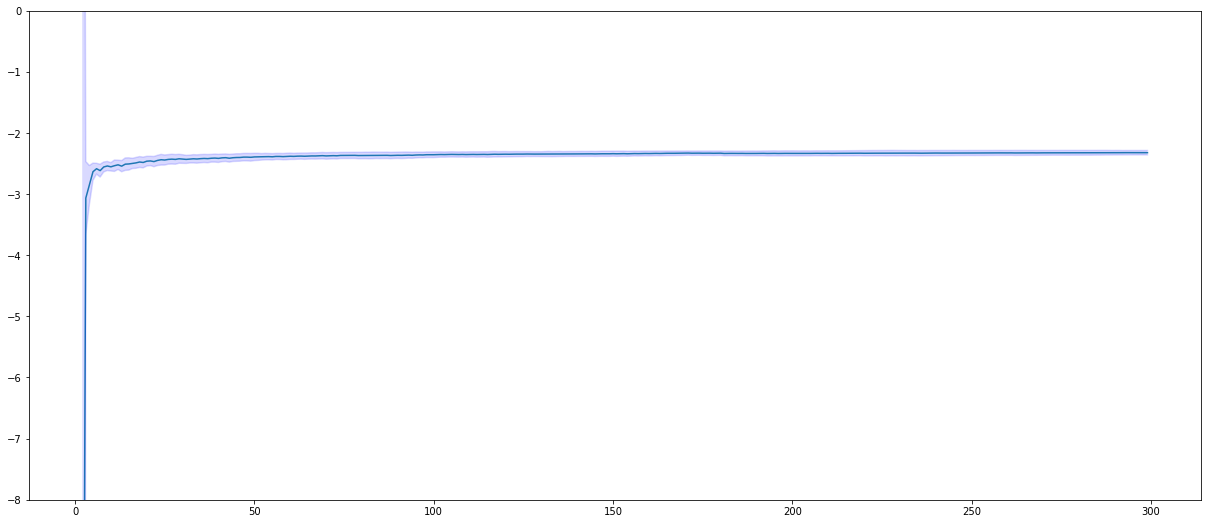

In [14]:
plt.figure(figsize=(21,9))
plt.plot(range(n_samples),np.mean(ll_ksgfs,0))
plt.plot(range(n_samples),upper,'blue',alpha=0.15)
plt.plot(range(n_samples),lower,'blue', alpha=0.15)
plt.fill_between(range(n_samples),lower, upper, facecolor='blue', alpha=0.15,interpolate=True)
plt.ylim(-8,0)

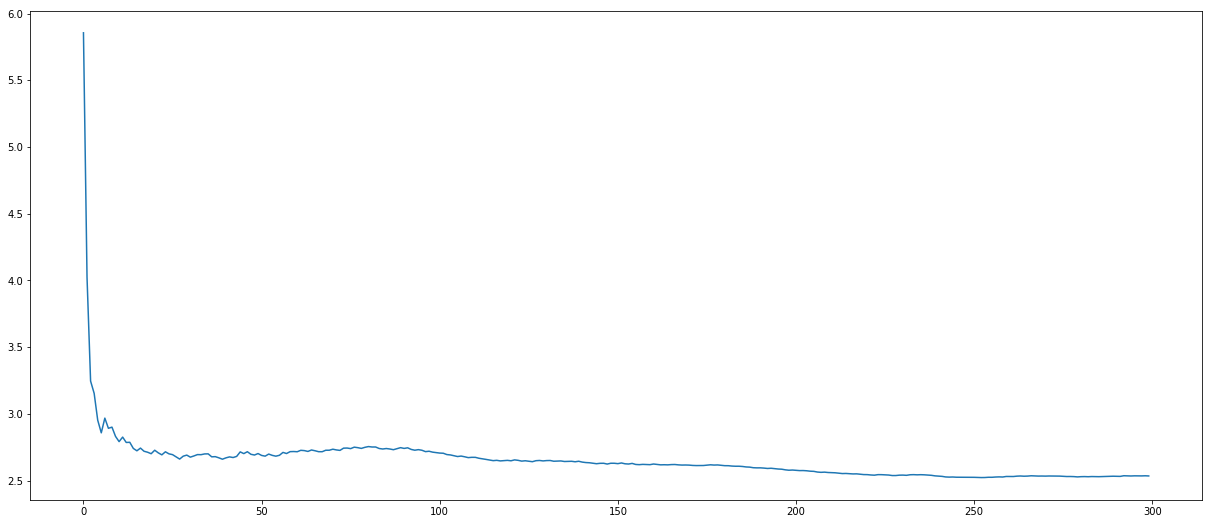

In [50]:
plt.figure(figsize=(21,9))
plt.plot(range(300), test_rmse)

## K-SGLD

In [6]:
import torch
#import torchvision
import os

from itertools import chain
from torch import nn
#from torchvision import transforms
import torch.nn.functional as F
import numpy as np
#from numpy.random import RandomState

import ksgld



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


batch_size = 32
dataset_size=456

n_chains = 10
n_samples = 300


ll_ksgld = np.zeros((n_chains, n_samples))
rmse_ksgld = np.zeros((n_chains, n_samples))






losses_ksgld = []
for i in range(n_chains):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    #eps=5e-2

    optim = ksgld.optim.KSGLD(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon=5e-6, l2=1e-3, invert_every=1)
    evaluate = evaluation(test_loader, n_samples, X_train_mean, X_train_std, y_train_mean, y_train_std)

    t = 1.
    n = 0
    

    for epoch in range(2500):
        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)

            optim.update_curvature(x)

            network.zero_grad()
            output = network(x)
            loss = 0.5 * criterion(output, y)
            loss.backward()
            optim.step()

            losses_ksgld.append(loss)
            running_loss += loss * batch_size / dataset_size

            if (t >= 300) & (t % 100 == 0) & (n < n_samples):
                rmse, ll, predictions = evaluate.fn(network)

                ll_ksgld[i, n] = ll
                rmse_ksgld[i, n] = rmse

                n += 1

            t += 1.


        print("chain {:d} - epoch {:d} - loss: {:.4f} ".format(i, epoch, running_loss))

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 0 - loss: 16.6652 
chain 0 - epoch 1 - loss: 16.2222 
chain 0 - epoch 2 - loss: 17.0376 
chain 0 - epoch 3 - loss: 16.3490 
chain 0 - epoch 4 - loss: 15.1785 
chain 0 - epoch 5 - loss: 15.6027 
chain 0 - epoch 6 - loss: 16.7416 
chain 0 - epoch 7 - loss: 18.1121 
chain 0 - epoch 8 - loss: 18.6324 
chain 0 - epoch 9 - loss: 18.1973 
chain 0 - epoch 10 - loss: 16.5866 
chain 0 - epoch 11 - loss: 16.3043 
chain 0 - epoch 12 - loss: 14.1198 
chain 0 - epoch 13 - loss: 13.3338 
chain 0 - epoch 14 - loss: 12.1864 
chain 0 - epoch 15 - loss: 12.4095 
chain 0 - epoch 16 - loss: 12.4419 
chain 0 - epoch 17 - loss: 12.3960 
chain 0 - epoch 18 - loss: 12.9712 


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 19 - loss: 13.1436 
chain 0 - epoch 20 - loss: 13.2235 
chain 0 - epoch 21 - loss: 13.4995 
chain 0 - epoch 22 - loss: 13.3721 
chain 0 - epoch 23 - loss: 13.9025 
chain 0 - epoch 24 - loss: 14.6453 
chain 0 - epoch 25 - loss: 15.9387 
chain 0 - epoch 26 - loss: 13.3298 
chain 0 - epoch 27 - loss: 13.2443 
chain 0 - epoch 28 - loss: 12.7121 
chain 0 - epoch 29 - loss: 11.8134 
chain 0 - epoch 30 - loss: 11.4589 
chain 0 - epoch 31 - loss: 11.9498 
chain 0 - epoch 32 - loss: 12.3799 
chain 0 - epoch 33 - loss: 12.6080 
chain 0 - epoch 34 - loss: 13.2675 
chain 0 - epoch 35 - loss: 12.4192 
chain 0 - epoch 36 - loss: 10.9913 
chain 0 - epoch 37 - loss: 9.5152 
chain 0 - epoch 38 - loss: 9.3943 
chain 0 - epoch 39 - loss: 8.6339 
chain 0 - epoch 40 - loss: 8.3571 
chain 0 - epoch 41 - loss: 8.2759 
chain 0 - epoch 42 - loss: 8.0122 
chain 0 - epoch 43 - loss: 7.9642 
chain 0 - epoch 44 - loss: 7.5515 
chain 0 - epoch 45 - loss: 7.9612 
chain 0 - epoch 46 - loss: 7.9612 
ch

chain 0 - epoch 250 - loss: 5.4448 
chain 0 - epoch 251 - loss: 5.7741 
chain 0 - epoch 252 - loss: 6.3464 
chain 0 - epoch 253 - loss: 6.2035 
chain 0 - epoch 254 - loss: 6.3842 
chain 0 - epoch 255 - loss: 6.8694 
chain 0 - epoch 256 - loss: 7.1847 
chain 0 - epoch 257 - loss: 7.4583 
chain 0 - epoch 258 - loss: 9.2027 
chain 0 - epoch 259 - loss: 9.9454 
chain 0 - epoch 260 - loss: 9.4111 
chain 0 - epoch 261 - loss: 9.3860 
chain 0 - epoch 262 - loss: 8.6278 
chain 0 - epoch 263 - loss: 8.3209 
chain 0 - epoch 264 - loss: 7.4913 
chain 0 - epoch 265 - loss: 6.7899 
chain 0 - epoch 266 - loss: 6.7329 
chain 0 - epoch 267 - loss: 7.7098 
chain 0 - epoch 268 - loss: 8.7569 
chain 0 - epoch 269 - loss: 8.5332 
chain 0 - epoch 270 - loss: 8.3550 
chain 0 - epoch 271 - loss: 8.0243 
chain 0 - epoch 272 - loss: 7.9625 
chain 0 - epoch 273 - loss: 8.0083 
chain 0 - epoch 274 - loss: 9.0819 
chain 0 - epoch 275 - loss: 9.9071 
chain 0 - epoch 276 - loss: 9.3866 
chain 0 - epoch 277 - loss: 

chain 0 - epoch 478 - loss: 5.0640 
chain 0 - epoch 479 - loss: 4.6808 
chain 0 - epoch 480 - loss: 4.7436 
chain 0 - epoch 481 - loss: 4.8905 
chain 0 - epoch 482 - loss: 5.0209 
chain 0 - epoch 483 - loss: 4.6415 
chain 0 - epoch 484 - loss: 4.7430 
chain 0 - epoch 485 - loss: 5.2003 
chain 0 - epoch 486 - loss: 4.8801 
chain 0 - epoch 487 - loss: 4.9039 
chain 0 - epoch 488 - loss: 4.7412 
chain 0 - epoch 489 - loss: 4.7406 
chain 0 - epoch 490 - loss: 4.8929 
chain 0 - epoch 491 - loss: 4.8739 
chain 0 - epoch 492 - loss: 4.9351 
chain 0 - epoch 493 - loss: 5.2115 
chain 0 - epoch 494 - loss: 5.2375 
chain 0 - epoch 495 - loss: 5.1450 
chain 0 - epoch 496 - loss: 5.5322 
chain 0 - epoch 497 - loss: 4.5994 
chain 0 - epoch 498 - loss: 4.7204 
chain 0 - epoch 499 - loss: 5.3221 
chain 0 - epoch 500 - loss: 5.2347 
chain 0 - epoch 501 - loss: 5.4579 
chain 0 - epoch 502 - loss: 5.7024 
chain 0 - epoch 503 - loss: 5.5320 
chain 0 - epoch 504 - loss: 6.3656 
chain 0 - epoch 505 - loss: 

chain 0 - epoch 705 - loss: 33.1066 
chain 0 - epoch 706 - loss: 38.4921 
chain 0 - epoch 707 - loss: 48.4401 
chain 0 - epoch 708 - loss: 36.6020 
chain 0 - epoch 709 - loss: 32.4637 
chain 0 - epoch 710 - loss: 28.6910 
chain 0 - epoch 711 - loss: 30.4148 
chain 0 - epoch 712 - loss: 20.4431 
chain 0 - epoch 713 - loss: 23.4841 
chain 0 - epoch 714 - loss: 23.5981 
chain 0 - epoch 715 - loss: 21.5633 
chain 0 - epoch 716 - loss: 27.6351 
chain 0 - epoch 717 - loss: 28.2390 
chain 0 - epoch 718 - loss: 17.9334 
chain 0 - epoch 719 - loss: 10.9147 
chain 0 - epoch 720 - loss: 7.3044 
chain 0 - epoch 721 - loss: 7.4871 
chain 0 - epoch 722 - loss: 8.0039 
chain 0 - epoch 723 - loss: 9.5590 
chain 0 - epoch 724 - loss: 11.0444 
chain 0 - epoch 725 - loss: 10.6321 
chain 0 - epoch 726 - loss: 9.0836 
chain 0 - epoch 727 - loss: 8.0534 
chain 0 - epoch 728 - loss: 7.3506 
chain 0 - epoch 729 - loss: 7.6430 
chain 0 - epoch 730 - loss: 14.1390 
chain 0 - epoch 731 - loss: 10.2582 
chain 0 -

chain 0 - epoch 931 - loss: 5.3834 
chain 0 - epoch 932 - loss: 5.6082 
chain 0 - epoch 933 - loss: 5.0580 
chain 0 - epoch 934 - loss: 4.8119 
chain 0 - epoch 935 - loss: 5.1555 
chain 0 - epoch 936 - loss: 5.0947 
chain 0 - epoch 937 - loss: 4.9249 
chain 0 - epoch 938 - loss: 5.0114 
chain 0 - epoch 939 - loss: 6.1440 
chain 0 - epoch 940 - loss: 7.2517 
chain 0 - epoch 941 - loss: 6.8099 
chain 0 - epoch 942 - loss: 6.7418 
chain 0 - epoch 943 - loss: 6.0454 
chain 0 - epoch 944 - loss: 7.0406 
chain 0 - epoch 945 - loss: 10.1133 
chain 0 - epoch 946 - loss: 7.5025 
chain 0 - epoch 947 - loss: 7.8075 
chain 0 - epoch 948 - loss: 8.0850 
chain 0 - epoch 949 - loss: 10.8182 
chain 0 - epoch 950 - loss: 11.4559 
chain 0 - epoch 951 - loss: 11.8631 
chain 0 - epoch 952 - loss: 8.5910 
chain 0 - epoch 953 - loss: 10.0482 
chain 0 - epoch 954 - loss: 8.9129 
chain 0 - epoch 955 - loss: 7.5871 
chain 0 - epoch 956 - loss: 6.8966 
chain 0 - epoch 957 - loss: 7.0597 
chain 0 - epoch 958 - l

chain 0 - epoch 1155 - loss: 4.3675 
chain 0 - epoch 1156 - loss: 4.7690 
chain 0 - epoch 1157 - loss: 4.7561 
chain 0 - epoch 1158 - loss: 6.5059 
chain 0 - epoch 1159 - loss: 7.1859 
chain 0 - epoch 1160 - loss: 7.4426 
chain 0 - epoch 1161 - loss: 7.9936 
chain 0 - epoch 1162 - loss: 8.0441 
chain 0 - epoch 1163 - loss: 8.3084 
chain 0 - epoch 1164 - loss: 8.4594 
chain 0 - epoch 1165 - loss: 7.0353 
chain 0 - epoch 1166 - loss: 7.1634 
chain 0 - epoch 1167 - loss: 8.9005 
chain 0 - epoch 1168 - loss: 11.7023 
chain 0 - epoch 1169 - loss: 17.4202 
chain 0 - epoch 1170 - loss: 20.9317 
chain 0 - epoch 1171 - loss: 25.2158 
chain 0 - epoch 1172 - loss: 19.7098 
chain 0 - epoch 1173 - loss: 19.4196 
chain 0 - epoch 1174 - loss: 20.1060 
chain 0 - epoch 1175 - loss: 15.3102 
chain 0 - epoch 1176 - loss: 16.1382 
chain 0 - epoch 1177 - loss: 13.5791 
chain 0 - epoch 1178 - loss: 12.0976 
chain 0 - epoch 1179 - loss: 13.6824 
chain 0 - epoch 1180 - loss: 17.5144 
chain 0 - epoch 1181 - lo

chain 0 - epoch 1377 - loss: 10.3146 
chain 0 - epoch 1378 - loss: 8.8500 
chain 0 - epoch 1379 - loss: 12.7265 
chain 0 - epoch 1380 - loss: 16.3533 
chain 0 - epoch 1381 - loss: 21.2867 
chain 0 - epoch 1382 - loss: 20.6042 
chain 0 - epoch 1383 - loss: 19.9463 
chain 0 - epoch 1384 - loss: 18.5954 
chain 0 - epoch 1385 - loss: 14.0478 
chain 0 - epoch 1386 - loss: 12.0536 
chain 0 - epoch 1387 - loss: 10.4781 
chain 0 - epoch 1388 - loss: 11.5508 
chain 0 - epoch 1389 - loss: 8.9477 
chain 0 - epoch 1390 - loss: 10.6803 
chain 0 - epoch 1391 - loss: 10.1836 
chain 0 - epoch 1392 - loss: 10.9350 
chain 0 - epoch 1393 - loss: 13.3978 
chain 0 - epoch 1394 - loss: 10.5126 
chain 0 - epoch 1395 - loss: 11.4486 
chain 0 - epoch 1396 - loss: 9.0840 
chain 0 - epoch 1397 - loss: 5.2269 
chain 0 - epoch 1398 - loss: 5.3593 
chain 0 - epoch 1399 - loss: 5.7081 
chain 0 - epoch 1400 - loss: 5.1606 
chain 0 - epoch 1401 - loss: 4.6996 
chain 0 - epoch 1402 - loss: 4.8802 
chain 0 - epoch 1403 

chain 0 - epoch 1597 - loss: 41.2339 
chain 0 - epoch 1598 - loss: 30.5078 
chain 0 - epoch 1599 - loss: 29.4300 
chain 0 - epoch 1600 - loss: 31.5141 
chain 0 - epoch 1601 - loss: 25.1250 
chain 0 - epoch 1602 - loss: 17.8715 
chain 0 - epoch 1603 - loss: 13.8205 
chain 0 - epoch 1604 - loss: 12.2735 
chain 0 - epoch 1605 - loss: 12.2815 
chain 0 - epoch 1606 - loss: 18.1746 
chain 0 - epoch 1607 - loss: 16.5047 
chain 0 - epoch 1608 - loss: 22.4389 
chain 0 - epoch 1609 - loss: 25.1698 
chain 0 - epoch 1610 - loss: 34.3231 
chain 0 - epoch 1611 - loss: 27.2702 
chain 0 - epoch 1612 - loss: 24.2884 
chain 0 - epoch 1613 - loss: 21.8385 
chain 0 - epoch 1614 - loss: 17.7333 
chain 0 - epoch 1615 - loss: 12.5113 
chain 0 - epoch 1616 - loss: 10.8473 
chain 0 - epoch 1617 - loss: 14.8945 
chain 0 - epoch 1618 - loss: 7.3224 
chain 0 - epoch 1619 - loss: 5.8449 
chain 0 - epoch 1620 - loss: 5.2456 
chain 0 - epoch 1621 - loss: 5.2464 
chain 0 - epoch 1622 - loss: 5.0946 
chain 0 - epoch 1

chain 0 - epoch 1816 - loss: 10.0301 
chain 0 - epoch 1817 - loss: 8.3323 
chain 0 - epoch 1818 - loss: 8.1563 
chain 0 - epoch 1819 - loss: 4.7570 
chain 0 - epoch 1820 - loss: 5.1688 
chain 0 - epoch 1821 - loss: 4.8443 
chain 0 - epoch 1822 - loss: 7.7072 
chain 0 - epoch 1823 - loss: 8.0630 
chain 0 - epoch 1824 - loss: 8.7251 
chain 0 - epoch 1825 - loss: 5.6084 
chain 0 - epoch 1826 - loss: 5.8806 
chain 0 - epoch 1827 - loss: 8.6989 
chain 0 - epoch 1828 - loss: 9.9884 
chain 0 - epoch 1829 - loss: 12.2568 
chain 0 - epoch 1830 - loss: 9.7986 
chain 0 - epoch 1831 - loss: 9.7484 
chain 0 - epoch 1832 - loss: 14.7343 
chain 0 - epoch 1833 - loss: 9.9562 
chain 0 - epoch 1834 - loss: 9.9071 
chain 0 - epoch 1835 - loss: 12.9665 
chain 0 - epoch 1836 - loss: 11.6371 
chain 0 - epoch 1837 - loss: 9.0330 
chain 0 - epoch 1838 - loss: 11.7103 
chain 0 - epoch 1839 - loss: 11.8268 
chain 0 - epoch 1840 - loss: 13.7565 
chain 0 - epoch 1841 - loss: 15.6230 
chain 0 - epoch 1842 - loss: 

chain 0 - epoch 2035 - loss: 12.7920 
chain 0 - epoch 2036 - loss: 16.3606 
chain 0 - epoch 2037 - loss: 13.2792 
chain 0 - epoch 2038 - loss: 13.8426 
chain 0 - epoch 2039 - loss: 10.5943 
chain 0 - epoch 2040 - loss: 9.7117 
chain 0 - epoch 2041 - loss: 14.1813 
chain 0 - epoch 2042 - loss: 16.3167 
chain 0 - epoch 2043 - loss: 13.6999 
chain 0 - epoch 2044 - loss: 10.3831 
chain 0 - epoch 2045 - loss: 7.9610 
chain 0 - epoch 2046 - loss: 6.6529 
chain 0 - epoch 2047 - loss: 6.4984 
chain 0 - epoch 2048 - loss: 5.8660 
chain 0 - epoch 2049 - loss: 5.8176 
chain 0 - epoch 2050 - loss: 6.0612 
chain 0 - epoch 2051 - loss: 5.9648 
chain 0 - epoch 2052 - loss: 6.1234 
chain 0 - epoch 2053 - loss: 6.9734 
chain 0 - epoch 2054 - loss: 7.1582 
chain 0 - epoch 2055 - loss: 6.7885 
chain 0 - epoch 2056 - loss: 8.4043 
chain 0 - epoch 2057 - loss: 12.9209 
chain 0 - epoch 2058 - loss: 14.8803 
chain 0 - epoch 2059 - loss: 14.6832 
chain 0 - epoch 2060 - loss: 22.7957 
chain 0 - epoch 2061 - lo

chain 0 - epoch 2256 - loss: 5.6543 
chain 0 - epoch 2257 - loss: 5.9430 
chain 0 - epoch 2258 - loss: 7.9042 
chain 0 - epoch 2259 - loss: 8.9046 
chain 0 - epoch 2260 - loss: 6.9460 
chain 0 - epoch 2261 - loss: 6.0180 
chain 0 - epoch 2262 - loss: 6.7188 
chain 0 - epoch 2263 - loss: 8.0292 
chain 0 - epoch 2264 - loss: 6.8091 
chain 0 - epoch 2265 - loss: 6.3565 
chain 0 - epoch 2266 - loss: 7.2218 
chain 0 - epoch 2267 - loss: 10.4013 
chain 0 - epoch 2268 - loss: 13.0930 
chain 0 - epoch 2269 - loss: 17.5937 
chain 0 - epoch 2270 - loss: 27.0641 
chain 0 - epoch 2271 - loss: 24.7436 
chain 0 - epoch 2272 - loss: 23.4030 
chain 0 - epoch 2273 - loss: 14.2322 
chain 0 - epoch 2274 - loss: 11.7966 
chain 0 - epoch 2275 - loss: 7.6106 
chain 0 - epoch 2276 - loss: 6.1894 
chain 0 - epoch 2277 - loss: 5.6670 
chain 0 - epoch 2278 - loss: 5.0402 
chain 0 - epoch 2279 - loss: 5.1903 
chain 0 - epoch 2280 - loss: 5.1309 
chain 0 - epoch 2281 - loss: 4.8500 
chain 0 - epoch 2282 - loss: 4

chain 0 - epoch 2477 - loss: 6.2463 
chain 0 - epoch 2478 - loss: 4.9993 
chain 0 - epoch 2479 - loss: 5.7882 
chain 0 - epoch 2480 - loss: 5.4670 
chain 0 - epoch 2481 - loss: 6.7513 
chain 0 - epoch 2482 - loss: 11.0995 
chain 0 - epoch 2483 - loss: 9.7235 
chain 0 - epoch 2484 - loss: 5.4540 
chain 0 - epoch 2485 - loss: 5.8611 
chain 0 - epoch 2486 - loss: 6.1762 
chain 0 - epoch 2487 - loss: 7.3245 
chain 0 - epoch 2488 - loss: 10.9211 
chain 0 - epoch 2489 - loss: 10.8457 
chain 0 - epoch 2490 - loss: 5.8020 
chain 0 - epoch 2491 - loss: 3.9028 
chain 0 - epoch 2492 - loss: 3.8220 
chain 0 - epoch 2493 - loss: 3.7798 
chain 0 - epoch 2494 - loss: 3.5721 
chain 0 - epoch 2495 - loss: 4.1072 
chain 0 - epoch 2496 - loss: 4.0173 
chain 0 - epoch 2497 - loss: 5.3910 
chain 0 - epoch 2498 - loss: 6.0560 
chain 0 - epoch 2499 - loss: 4.7950 
chain 1 - epoch 0 - loss: 17.6762 
chain 1 - epoch 1 - loss: 17.5814 
chain 1 - epoch 2 - loss: 17.2380 
chain 1 - epoch 3 - loss: 16.8968 
chain 

chain 1 - epoch 206 - loss: 6.5862 
chain 1 - epoch 207 - loss: 6.9099 
chain 1 - epoch 208 - loss: 6.2229 
chain 1 - epoch 209 - loss: 5.7449 
chain 1 - epoch 210 - loss: 5.6383 
chain 1 - epoch 211 - loss: 5.5831 
chain 1 - epoch 212 - loss: 5.5895 
chain 1 - epoch 213 - loss: 5.6054 
chain 1 - epoch 214 - loss: 5.6572 
chain 1 - epoch 215 - loss: 5.9340 
chain 1 - epoch 216 - loss: 5.6768 
chain 1 - epoch 217 - loss: 6.0344 
chain 1 - epoch 218 - loss: 5.9498 
chain 1 - epoch 219 - loss: 5.8863 
chain 1 - epoch 220 - loss: 6.3341 
chain 1 - epoch 221 - loss: 6.5414 
chain 1 - epoch 222 - loss: 5.9736 
chain 1 - epoch 223 - loss: 5.9253 
chain 1 - epoch 224 - loss: 5.6781 
chain 1 - epoch 225 - loss: 5.8206 
chain 1 - epoch 226 - loss: 6.0486 
chain 1 - epoch 227 - loss: 6.3471 
chain 1 - epoch 228 - loss: 5.9753 
chain 1 - epoch 229 - loss: 5.8456 
chain 1 - epoch 230 - loss: 5.4514 
chain 1 - epoch 231 - loss: 5.4842 
chain 1 - epoch 232 - loss: 5.6966 
chain 1 - epoch 233 - loss: 

chain 1 - epoch 433 - loss: 6.7913 
chain 1 - epoch 434 - loss: 5.4908 
chain 1 - epoch 435 - loss: 5.5769 
chain 1 - epoch 436 - loss: 5.4666 
chain 1 - epoch 437 - loss: 4.7203 
chain 1 - epoch 438 - loss: 4.7893 
chain 1 - epoch 439 - loss: 4.7592 
chain 1 - epoch 440 - loss: 4.7404 
chain 1 - epoch 441 - loss: 4.7437 
chain 1 - epoch 442 - loss: 4.9158 
chain 1 - epoch 443 - loss: 4.9548 
chain 1 - epoch 444 - loss: 4.7763 
chain 1 - epoch 445 - loss: 4.7907 
chain 1 - epoch 446 - loss: 4.9238 
chain 1 - epoch 447 - loss: 5.2063 
chain 1 - epoch 448 - loss: 4.7850 
chain 1 - epoch 449 - loss: 4.8477 
chain 1 - epoch 450 - loss: 5.1717 
chain 1 - epoch 451 - loss: 5.2562 
chain 1 - epoch 452 - loss: 5.0417 
chain 1 - epoch 453 - loss: 4.7578 
chain 1 - epoch 454 - loss: 4.7652 
chain 1 - epoch 455 - loss: 4.7003 
chain 1 - epoch 456 - loss: 4.9919 
chain 1 - epoch 457 - loss: 5.0344 
chain 1 - epoch 458 - loss: 5.2630 
chain 1 - epoch 459 - loss: 5.7803 
chain 1 - epoch 460 - loss: 

chain 1 - epoch 660 - loss: 6.0288 
chain 1 - epoch 661 - loss: 5.5359 
chain 1 - epoch 662 - loss: 5.2759 
chain 1 - epoch 663 - loss: 4.9966 
chain 1 - epoch 664 - loss: 4.6538 
chain 1 - epoch 665 - loss: 4.6322 
chain 1 - epoch 666 - loss: 5.3211 
chain 1 - epoch 667 - loss: 4.8424 
chain 1 - epoch 668 - loss: 4.5731 
chain 1 - epoch 669 - loss: 4.9180 
chain 1 - epoch 670 - loss: 5.5020 
chain 1 - epoch 671 - loss: 6.4092 
chain 1 - epoch 672 - loss: 7.0581 
chain 1 - epoch 673 - loss: 8.7780 
chain 1 - epoch 674 - loss: 6.7774 
chain 1 - epoch 675 - loss: 5.9813 
chain 1 - epoch 676 - loss: 5.7063 
chain 1 - epoch 677 - loss: 5.5453 
chain 1 - epoch 678 - loss: 5.5161 
chain 1 - epoch 679 - loss: 5.8189 
chain 1 - epoch 680 - loss: 5.8911 
chain 1 - epoch 681 - loss: 6.4240 
chain 1 - epoch 682 - loss: 5.6972 
chain 1 - epoch 683 - loss: 6.9865 
chain 1 - epoch 684 - loss: 10.0435 
chain 1 - epoch 685 - loss: 12.4265 
chain 1 - epoch 686 - loss: 12.1074 
chain 1 - epoch 687 - los

chain 1 - epoch 887 - loss: 17.2325 
chain 1 - epoch 888 - loss: 18.6395 
chain 1 - epoch 889 - loss: 16.9634 
chain 1 - epoch 890 - loss: 15.6613 
chain 1 - epoch 891 - loss: 14.9677 
chain 1 - epoch 892 - loss: 12.9793 
chain 1 - epoch 893 - loss: 13.0250 
chain 1 - epoch 894 - loss: 12.2336 
chain 1 - epoch 895 - loss: 11.1770 
chain 1 - epoch 896 - loss: 10.9676 
chain 1 - epoch 897 - loss: 8.3824 
chain 1 - epoch 898 - loss: 8.5114 
chain 1 - epoch 899 - loss: 7.6377 
chain 1 - epoch 900 - loss: 6.6328 
chain 1 - epoch 901 - loss: 6.2297 
chain 1 - epoch 902 - loss: 6.0557 
chain 1 - epoch 903 - loss: 6.3953 
chain 1 - epoch 904 - loss: 6.5026 
chain 1 - epoch 905 - loss: 6.2564 
chain 1 - epoch 906 - loss: 6.5146 
chain 1 - epoch 907 - loss: 6.5818 
chain 1 - epoch 908 - loss: 6.0699 
chain 1 - epoch 909 - loss: 5.9942 
chain 1 - epoch 910 - loss: 6.1039 
chain 1 - epoch 911 - loss: 6.8473 
chain 1 - epoch 912 - loss: 7.1147 
chain 1 - epoch 913 - loss: 7.1640 
chain 1 - epoch 91

chain 1 - epoch 1113 - loss: 6.7884 
chain 1 - epoch 1114 - loss: 6.7144 
chain 1 - epoch 1115 - loss: 6.3617 
chain 1 - epoch 1116 - loss: 5.7973 
chain 1 - epoch 1117 - loss: 5.7185 
chain 1 - epoch 1118 - loss: 5.5858 
chain 1 - epoch 1119 - loss: 5.6427 
chain 1 - epoch 1120 - loss: 5.4844 
chain 1 - epoch 1121 - loss: 5.4085 
chain 1 - epoch 1122 - loss: 5.7780 
chain 1 - epoch 1123 - loss: 5.6137 
chain 1 - epoch 1124 - loss: 5.3722 
chain 1 - epoch 1125 - loss: 5.2294 
chain 1 - epoch 1126 - loss: 5.5540 
chain 1 - epoch 1127 - loss: 5.7874 
chain 1 - epoch 1128 - loss: 6.0635 
chain 1 - epoch 1129 - loss: 5.5753 
chain 1 - epoch 1130 - loss: 4.9999 
chain 1 - epoch 1131 - loss: 4.8319 
chain 1 - epoch 1132 - loss: 4.4818 
chain 1 - epoch 1133 - loss: 4.9183 
chain 1 - epoch 1134 - loss: 5.5054 
chain 1 - epoch 1135 - loss: 6.0475 
chain 1 - epoch 1136 - loss: 5.5119 
chain 1 - epoch 1137 - loss: 5.2491 
chain 1 - epoch 1138 - loss: 5.6762 
chain 1 - epoch 1139 - loss: 5.6813 
c

chain 1 - epoch 1336 - loss: 6.4147 
chain 1 - epoch 1337 - loss: 6.5983 
chain 1 - epoch 1338 - loss: 6.3417 
chain 1 - epoch 1339 - loss: 6.6861 
chain 1 - epoch 1340 - loss: 7.3474 
chain 1 - epoch 1341 - loss: 8.3200 
chain 1 - epoch 1342 - loss: 8.4450 
chain 1 - epoch 1343 - loss: 7.3934 
chain 1 - epoch 1344 - loss: 6.2766 
chain 1 - epoch 1345 - loss: 6.1049 
chain 1 - epoch 1346 - loss: 6.7926 
chain 1 - epoch 1347 - loss: 6.1580 
chain 1 - epoch 1348 - loss: 5.8877 
chain 1 - epoch 1349 - loss: 5.0462 
chain 1 - epoch 1350 - loss: 4.7337 
chain 1 - epoch 1351 - loss: 5.0700 
chain 1 - epoch 1352 - loss: 4.6961 
chain 1 - epoch 1353 - loss: 5.5328 
chain 1 - epoch 1354 - loss: 5.5094 
chain 1 - epoch 1355 - loss: 5.1628 
chain 1 - epoch 1356 - loss: 6.0315 
chain 1 - epoch 1357 - loss: 7.5642 
chain 1 - epoch 1358 - loss: 7.5137 
chain 1 - epoch 1359 - loss: 6.8376 
chain 1 - epoch 1360 - loss: 7.1954 
chain 1 - epoch 1361 - loss: 6.0443 
chain 1 - epoch 1362 - loss: 5.4915 
c

chain 1 - epoch 1559 - loss: 4.1836 
chain 1 - epoch 1560 - loss: 4.2713 
chain 1 - epoch 1561 - loss: 4.3299 
chain 1 - epoch 1562 - loss: 4.7648 
chain 1 - epoch 1563 - loss: 4.7889 
chain 1 - epoch 1564 - loss: 5.3470 
chain 1 - epoch 1565 - loss: 6.3757 
chain 1 - epoch 1566 - loss: 5.3663 
chain 1 - epoch 1567 - loss: 6.2950 
chain 1 - epoch 1568 - loss: 5.8445 
chain 1 - epoch 1569 - loss: 5.7447 
chain 1 - epoch 1570 - loss: 6.1875 
chain 1 - epoch 1571 - loss: 6.0168 
chain 1 - epoch 1572 - loss: 5.5632 
chain 1 - epoch 1573 - loss: 5.5793 
chain 1 - epoch 1574 - loss: 4.9682 
chain 1 - epoch 1575 - loss: 4.8098 
chain 1 - epoch 1576 - loss: 4.1674 
chain 1 - epoch 1577 - loss: 4.2906 
chain 1 - epoch 1578 - loss: 5.5299 
chain 1 - epoch 1579 - loss: 4.5803 
chain 1 - epoch 1580 - loss: 4.5409 
chain 1 - epoch 1581 - loss: 4.1515 
chain 1 - epoch 1582 - loss: 4.6377 
chain 1 - epoch 1583 - loss: 4.3135 
chain 1 - epoch 1584 - loss: 4.0122 
chain 1 - epoch 1585 - loss: 4.6568 
c

chain 1 - epoch 1779 - loss: 8.8867 
chain 1 - epoch 1780 - loss: 7.4673 
chain 1 - epoch 1781 - loss: 6.6541 
chain 1 - epoch 1782 - loss: 5.8889 
chain 1 - epoch 1783 - loss: 5.9528 
chain 1 - epoch 1784 - loss: 6.6180 
chain 1 - epoch 1785 - loss: 6.5625 
chain 1 - epoch 1786 - loss: 7.2398 
chain 1 - epoch 1787 - loss: 6.3653 
chain 1 - epoch 1788 - loss: 5.8408 
chain 1 - epoch 1789 - loss: 5.5388 
chain 1 - epoch 1790 - loss: 5.8800 
chain 1 - epoch 1791 - loss: 5.4695 
chain 1 - epoch 1792 - loss: 4.8290 
chain 1 - epoch 1793 - loss: 4.7361 
chain 1 - epoch 1794 - loss: 4.4669 
chain 1 - epoch 1795 - loss: 4.5394 
chain 1 - epoch 1796 - loss: 4.5441 
chain 1 - epoch 1797 - loss: 4.5265 
chain 1 - epoch 1798 - loss: 4.5146 
chain 1 - epoch 1799 - loss: 4.6803 
chain 1 - epoch 1800 - loss: 4.4166 
chain 1 - epoch 1801 - loss: 4.6761 
chain 1 - epoch 1802 - loss: 5.4176 
chain 1 - epoch 1803 - loss: 4.8998 
chain 1 - epoch 1804 - loss: 4.4369 
chain 1 - epoch 1805 - loss: 4.3852 
c

chain 1 - epoch 2002 - loss: 3.6823 
chain 1 - epoch 2003 - loss: 3.5259 
chain 1 - epoch 2004 - loss: 3.5688 
chain 1 - epoch 2005 - loss: 3.6502 
chain 1 - epoch 2006 - loss: 4.0490 
chain 1 - epoch 2007 - loss: 5.4485 
chain 1 - epoch 2008 - loss: 5.2427 
chain 1 - epoch 2009 - loss: 4.8339 
chain 1 - epoch 2010 - loss: 4.4791 
chain 1 - epoch 2011 - loss: 4.3754 
chain 1 - epoch 2012 - loss: 4.2783 
chain 1 - epoch 2013 - loss: 4.3096 
chain 1 - epoch 2014 - loss: 4.3771 
chain 1 - epoch 2015 - loss: 4.1727 
chain 1 - epoch 2016 - loss: 4.5557 
chain 1 - epoch 2017 - loss: 5.8570 
chain 1 - epoch 2018 - loss: 5.8535 
chain 1 - epoch 2019 - loss: 5.0093 
chain 1 - epoch 2020 - loss: 4.6020 
chain 1 - epoch 2021 - loss: 4.6247 
chain 1 - epoch 2022 - loss: 5.3241 
chain 1 - epoch 2023 - loss: 6.0796 
chain 1 - epoch 2024 - loss: 5.1828 
chain 1 - epoch 2025 - loss: 5.4076 
chain 1 - epoch 2026 - loss: 5.2824 
chain 1 - epoch 2027 - loss: 5.1663 
chain 1 - epoch 2028 - loss: 4.8759 
c

chain 1 - epoch 2224 - loss: 4.6809 
chain 1 - epoch 2225 - loss: 5.4808 
chain 1 - epoch 2226 - loss: 5.3174 
chain 1 - epoch 2227 - loss: 5.1165 
chain 1 - epoch 2228 - loss: 5.2060 
chain 1 - epoch 2229 - loss: 5.4072 
chain 1 - epoch 2230 - loss: 6.4071 
chain 1 - epoch 2231 - loss: 7.3753 
chain 1 - epoch 2232 - loss: 7.4758 
chain 1 - epoch 2233 - loss: 6.7038 
chain 1 - epoch 2234 - loss: 6.5730 
chain 1 - epoch 2235 - loss: 6.4103 
chain 1 - epoch 2236 - loss: 7.7706 
chain 1 - epoch 2237 - loss: 7.9000 
chain 1 - epoch 2238 - loss: 7.8088 
chain 1 - epoch 2239 - loss: 7.3639 
chain 1 - epoch 2240 - loss: 6.9604 
chain 1 - epoch 2241 - loss: 7.4035 
chain 1 - epoch 2242 - loss: 7.0034 
chain 1 - epoch 2243 - loss: 6.5511 
chain 1 - epoch 2244 - loss: 6.5358 
chain 1 - epoch 2245 - loss: 6.2104 
chain 1 - epoch 2246 - loss: 6.7777 
chain 1 - epoch 2247 - loss: 6.3355 
chain 1 - epoch 2248 - loss: 6.5656 
chain 1 - epoch 2249 - loss: 7.0701 
chain 1 - epoch 2250 - loss: 6.8963 
c

chain 1 - epoch 2445 - loss: 9.0288 
chain 1 - epoch 2446 - loss: 10.0283 
chain 1 - epoch 2447 - loss: 9.5405 
chain 1 - epoch 2448 - loss: 10.1595 
chain 1 - epoch 2449 - loss: 11.8063 
chain 1 - epoch 2450 - loss: 11.2638 
chain 1 - epoch 2451 - loss: 9.7522 
chain 1 - epoch 2452 - loss: 9.2785 
chain 1 - epoch 2453 - loss: 7.6970 
chain 1 - epoch 2454 - loss: 6.0437 
chain 1 - epoch 2455 - loss: 5.4698 
chain 1 - epoch 2456 - loss: 4.6161 
chain 1 - epoch 2457 - loss: 4.6204 
chain 1 - epoch 2458 - loss: 5.3297 
chain 1 - epoch 2459 - loss: 6.5643 
chain 1 - epoch 2460 - loss: 5.5084 
chain 1 - epoch 2461 - loss: 4.7703 
chain 1 - epoch 2462 - loss: 5.1266 
chain 1 - epoch 2463 - loss: 5.4249 
chain 1 - epoch 2464 - loss: 6.1700 
chain 1 - epoch 2465 - loss: 5.5445 
chain 1 - epoch 2466 - loss: 4.9733 
chain 1 - epoch 2467 - loss: 5.8327 
chain 1 - epoch 2468 - loss: 4.9888 
chain 1 - epoch 2469 - loss: 4.9051 
chain 1 - epoch 2470 - loss: 5.4275 
chain 1 - epoch 2471 - loss: 5.491

chain 2 - epoch 174 - loss: 4.9815 
chain 2 - epoch 175 - loss: 4.8427 
chain 2 - epoch 176 - loss: 4.9057 
chain 2 - epoch 177 - loss: 5.7329 
chain 2 - epoch 178 - loss: 6.1515 
chain 2 - epoch 179 - loss: 6.5417 
chain 2 - epoch 180 - loss: 6.2825 
chain 2 - epoch 181 - loss: 6.4717 
chain 2 - epoch 182 - loss: 5.9698 
chain 2 - epoch 183 - loss: 5.1771 
chain 2 - epoch 184 - loss: 5.2357 
chain 2 - epoch 185 - loss: 5.2243 
chain 2 - epoch 186 - loss: 5.6064 
chain 2 - epoch 187 - loss: 5.8168 
chain 2 - epoch 188 - loss: 5.6975 
chain 2 - epoch 189 - loss: 5.5371 
chain 2 - epoch 190 - loss: 6.5533 
chain 2 - epoch 191 - loss: 5.9327 
chain 2 - epoch 192 - loss: 5.0671 
chain 2 - epoch 193 - loss: 4.6213 
chain 2 - epoch 194 - loss: 4.5042 
chain 2 - epoch 195 - loss: 4.5795 
chain 2 - epoch 196 - loss: 4.6160 
chain 2 - epoch 197 - loss: 4.5179 
chain 2 - epoch 198 - loss: 4.6514 
chain 2 - epoch 199 - loss: 4.4728 
chain 2 - epoch 200 - loss: 4.5676 
chain 2 - epoch 201 - loss: 

chain 2 - epoch 402 - loss: 4.8792 
chain 2 - epoch 403 - loss: 4.8326 
chain 2 - epoch 404 - loss: 4.9918 
chain 2 - epoch 405 - loss: 5.0299 
chain 2 - epoch 406 - loss: 4.9390 
chain 2 - epoch 407 - loss: 4.8212 
chain 2 - epoch 408 - loss: 5.0343 
chain 2 - epoch 409 - loss: 4.9157 
chain 2 - epoch 410 - loss: 4.9089 
chain 2 - epoch 411 - loss: 5.2320 
chain 2 - epoch 412 - loss: 5.4342 
chain 2 - epoch 413 - loss: 5.2304 
chain 2 - epoch 414 - loss: 5.0811 
chain 2 - epoch 415 - loss: 5.1585 
chain 2 - epoch 416 - loss: 5.2846 
chain 2 - epoch 417 - loss: 5.1345 
chain 2 - epoch 418 - loss: 5.3946 
chain 2 - epoch 419 - loss: 5.4765 
chain 2 - epoch 420 - loss: 5.4438 
chain 2 - epoch 421 - loss: 5.7224 
chain 2 - epoch 422 - loss: 6.0607 
chain 2 - epoch 423 - loss: 6.1369 
chain 2 - epoch 424 - loss: 6.0968 
chain 2 - epoch 425 - loss: 6.4593 
chain 2 - epoch 426 - loss: 6.1595 
chain 2 - epoch 427 - loss: 5.4122 
chain 2 - epoch 428 - loss: 5.3869 
chain 2 - epoch 429 - loss: 

chain 2 - epoch 630 - loss: 5.0106 
chain 2 - epoch 631 - loss: 5.0646 
chain 2 - epoch 632 - loss: 5.0126 
chain 2 - epoch 633 - loss: 4.9004 
chain 2 - epoch 634 - loss: 4.7111 
chain 2 - epoch 635 - loss: 4.9256 
chain 2 - epoch 636 - loss: 4.7309 
chain 2 - epoch 637 - loss: 4.7685 
chain 2 - epoch 638 - loss: 4.8556 
chain 2 - epoch 639 - loss: 4.8349 
chain 2 - epoch 640 - loss: 4.5509 
chain 2 - epoch 641 - loss: 4.6887 
chain 2 - epoch 642 - loss: 4.9974 
chain 2 - epoch 643 - loss: 5.1866 
chain 2 - epoch 644 - loss: 4.9844 
chain 2 - epoch 645 - loss: 5.7749 
chain 2 - epoch 646 - loss: 5.8868 
chain 2 - epoch 647 - loss: 5.7016 
chain 2 - epoch 648 - loss: 6.2533 
chain 2 - epoch 649 - loss: 6.5568 
chain 2 - epoch 650 - loss: 6.1412 
chain 2 - epoch 651 - loss: 5.9840 
chain 2 - epoch 652 - loss: 5.3226 
chain 2 - epoch 653 - loss: 5.5704 
chain 2 - epoch 654 - loss: 4.9277 
chain 2 - epoch 655 - loss: 4.7887 
chain 2 - epoch 656 - loss: 4.7545 
chain 2 - epoch 657 - loss: 

chain 2 - epoch 858 - loss: 4.8629 
chain 2 - epoch 859 - loss: 5.0760 
chain 2 - epoch 860 - loss: 5.1028 
chain 2 - epoch 861 - loss: 6.9719 
chain 2 - epoch 862 - loss: 7.4602 
chain 2 - epoch 863 - loss: 8.8576 
chain 2 - epoch 864 - loss: 8.8323 
chain 2 - epoch 865 - loss: 7.0831 
chain 2 - epoch 866 - loss: 6.5386 
chain 2 - epoch 867 - loss: 8.0403 
chain 2 - epoch 868 - loss: 6.4457 
chain 2 - epoch 869 - loss: 5.8845 
chain 2 - epoch 870 - loss: 5.3945 
chain 2 - epoch 871 - loss: 6.0465 
chain 2 - epoch 872 - loss: 5.9132 
chain 2 - epoch 873 - loss: 6.0083 
chain 2 - epoch 874 - loss: 5.8103 
chain 2 - epoch 875 - loss: 5.9148 
chain 2 - epoch 876 - loss: 5.6112 
chain 2 - epoch 877 - loss: 5.1800 
chain 2 - epoch 878 - loss: 5.2716 
chain 2 - epoch 879 - loss: 5.2072 
chain 2 - epoch 880 - loss: 5.9498 
chain 2 - epoch 881 - loss: 6.0453 
chain 2 - epoch 882 - loss: 7.1466 
chain 2 - epoch 883 - loss: 7.9371 
chain 2 - epoch 884 - loss: 7.3103 
chain 2 - epoch 885 - loss: 

chain 2 - epoch 1084 - loss: 9.0394 
chain 2 - epoch 1085 - loss: 10.3758 
chain 2 - epoch 1086 - loss: 10.6958 
chain 2 - epoch 1087 - loss: 9.9112 
chain 2 - epoch 1088 - loss: 9.5822 
chain 2 - epoch 1089 - loss: 9.1180 
chain 2 - epoch 1090 - loss: 8.1421 
chain 2 - epoch 1091 - loss: 8.3662 
chain 2 - epoch 1092 - loss: 7.3959 
chain 2 - epoch 1093 - loss: 7.3180 
chain 2 - epoch 1094 - loss: 6.4700 
chain 2 - epoch 1095 - loss: 5.6939 
chain 2 - epoch 1096 - loss: 5.3254 
chain 2 - epoch 1097 - loss: 5.4502 
chain 2 - epoch 1098 - loss: 5.2780 
chain 2 - epoch 1099 - loss: 5.1118 
chain 2 - epoch 1100 - loss: 5.1265 
chain 2 - epoch 1101 - loss: 4.7733 
chain 2 - epoch 1102 - loss: 4.2303 
chain 2 - epoch 1103 - loss: 4.1368 
chain 2 - epoch 1104 - loss: 4.2157 
chain 2 - epoch 1105 - loss: 4.1199 
chain 2 - epoch 1106 - loss: 4.3552 
chain 2 - epoch 1107 - loss: 4.9573 
chain 2 - epoch 1108 - loss: 5.8218 
chain 2 - epoch 1109 - loss: 5.7770 
chain 2 - epoch 1110 - loss: 5.9169 

chain 2 - epoch 1307 - loss: 4.3508 
chain 2 - epoch 1308 - loss: 4.3411 
chain 2 - epoch 1309 - loss: 4.8005 
chain 2 - epoch 1310 - loss: 4.3579 
chain 2 - epoch 1311 - loss: 5.0698 
chain 2 - epoch 1312 - loss: 5.2085 
chain 2 - epoch 1313 - loss: 5.6236 
chain 2 - epoch 1314 - loss: 4.5921 
chain 2 - epoch 1315 - loss: 4.7990 
chain 2 - epoch 1316 - loss: 5.4897 
chain 2 - epoch 1317 - loss: 5.1532 
chain 2 - epoch 1318 - loss: 5.2565 
chain 2 - epoch 1319 - loss: 4.9210 
chain 2 - epoch 1320 - loss: 5.6320 
chain 2 - epoch 1321 - loss: 6.9322 
chain 2 - epoch 1322 - loss: 5.9381 
chain 2 - epoch 1323 - loss: 5.3375 
chain 2 - epoch 1324 - loss: 5.2871 
chain 2 - epoch 1325 - loss: 5.6048 
chain 2 - epoch 1326 - loss: 6.6775 
chain 2 - epoch 1327 - loss: 6.4658 
chain 2 - epoch 1328 - loss: 7.6847 
chain 2 - epoch 1329 - loss: 8.7326 
chain 2 - epoch 1330 - loss: 7.9217 
chain 2 - epoch 1331 - loss: 7.1023 
chain 2 - epoch 1332 - loss: 8.2556 
chain 2 - epoch 1333 - loss: 9.7040 
c

chain 2 - epoch 1527 - loss: 9.1767 
chain 2 - epoch 1528 - loss: 10.7881 
chain 2 - epoch 1529 - loss: 9.5492 
chain 2 - epoch 1530 - loss: 7.8801 
chain 2 - epoch 1531 - loss: 6.9157 
chain 2 - epoch 1532 - loss: 5.7978 
chain 2 - epoch 1533 - loss: 6.3341 
chain 2 - epoch 1534 - loss: 5.6962 
chain 2 - epoch 1535 - loss: 4.3009 
chain 2 - epoch 1536 - loss: 5.6055 
chain 2 - epoch 1537 - loss: 4.9781 
chain 2 - epoch 1538 - loss: 5.0873 
chain 2 - epoch 1539 - loss: 6.2510 
chain 2 - epoch 1540 - loss: 6.0094 
chain 2 - epoch 1541 - loss: 5.9977 
chain 2 - epoch 1542 - loss: 4.9073 
chain 2 - epoch 1543 - loss: 4.6468 
chain 2 - epoch 1544 - loss: 4.3002 
chain 2 - epoch 1545 - loss: 4.4902 
chain 2 - epoch 1546 - loss: 4.2403 
chain 2 - epoch 1547 - loss: 4.2201 
chain 2 - epoch 1548 - loss: 3.7833 
chain 2 - epoch 1549 - loss: 4.0369 
chain 2 - epoch 1550 - loss: 3.8976 
chain 2 - epoch 1551 - loss: 4.4645 
chain 2 - epoch 1552 - loss: 5.5306 
chain 2 - epoch 1553 - loss: 5.6899 


chain 2 - epoch 1747 - loss: 7.4360 
chain 2 - epoch 1748 - loss: 7.2075 
chain 2 - epoch 1749 - loss: 8.1130 
chain 2 - epoch 1750 - loss: 8.8875 
chain 2 - epoch 1751 - loss: 6.6935 
chain 2 - epoch 1752 - loss: 6.1815 
chain 2 - epoch 1753 - loss: 5.8256 
chain 2 - epoch 1754 - loss: 4.6674 
chain 2 - epoch 1755 - loss: 4.9468 
chain 2 - epoch 1756 - loss: 4.8773 
chain 2 - epoch 1757 - loss: 5.0971 
chain 2 - epoch 1758 - loss: 5.1641 
chain 2 - epoch 1759 - loss: 4.7487 
chain 2 - epoch 1760 - loss: 5.0230 
chain 2 - epoch 1761 - loss: 4.8914 
chain 2 - epoch 1762 - loss: 4.3108 
chain 2 - epoch 1763 - loss: 4.5913 
chain 2 - epoch 1764 - loss: 4.9638 
chain 2 - epoch 1765 - loss: 5.5692 
chain 2 - epoch 1766 - loss: 6.6910 
chain 2 - epoch 1767 - loss: 6.7992 
chain 2 - epoch 1768 - loss: 4.7369 
chain 2 - epoch 1769 - loss: 4.7894 
chain 2 - epoch 1770 - loss: 4.5576 
chain 2 - epoch 1771 - loss: 3.9396 
chain 2 - epoch 1772 - loss: 3.9140 
chain 2 - epoch 1773 - loss: 3.7842 
c

chain 2 - epoch 1968 - loss: 6.7548 
chain 2 - epoch 1969 - loss: 6.5760 
chain 2 - epoch 1970 - loss: 7.6051 
chain 2 - epoch 1971 - loss: 6.5481 
chain 2 - epoch 1972 - loss: 6.3606 
chain 2 - epoch 1973 - loss: 5.7840 
chain 2 - epoch 1974 - loss: 6.7017 
chain 2 - epoch 1975 - loss: 6.1333 
chain 2 - epoch 1976 - loss: 5.5183 
chain 2 - epoch 1977 - loss: 4.7522 
chain 2 - epoch 1978 - loss: 5.0609 
chain 2 - epoch 1979 - loss: 4.5466 
chain 2 - epoch 1980 - loss: 4.2977 
chain 2 - epoch 1981 - loss: 4.1104 
chain 2 - epoch 1982 - loss: 3.9744 
chain 2 - epoch 1983 - loss: 4.2084 
chain 2 - epoch 1984 - loss: 4.2741 
chain 2 - epoch 1985 - loss: 4.9934 
chain 2 - epoch 1986 - loss: 5.5884 
chain 2 - epoch 1987 - loss: 5.3356 
chain 2 - epoch 1988 - loss: 4.8332 
chain 2 - epoch 1989 - loss: 4.0291 
chain 2 - epoch 1990 - loss: 3.7346 
chain 2 - epoch 1991 - loss: 4.1195 
chain 2 - epoch 1992 - loss: 4.2892 
chain 2 - epoch 1993 - loss: 4.1623 
chain 2 - epoch 1994 - loss: 4.4099 
c

chain 2 - epoch 2189 - loss: 5.9428 
chain 2 - epoch 2190 - loss: 6.5059 
chain 2 - epoch 2191 - loss: 6.3619 
chain 2 - epoch 2192 - loss: 5.4212 
chain 2 - epoch 2193 - loss: 5.7831 
chain 2 - epoch 2194 - loss: 5.1098 
chain 2 - epoch 2195 - loss: 5.3003 
chain 2 - epoch 2196 - loss: 4.6089 
chain 2 - epoch 2197 - loss: 4.7954 
chain 2 - epoch 2198 - loss: 5.4330 
chain 2 - epoch 2199 - loss: 4.7378 
chain 2 - epoch 2200 - loss: 5.5479 
chain 2 - epoch 2201 - loss: 5.4873 
chain 2 - epoch 2202 - loss: 5.1944 
chain 2 - epoch 2203 - loss: 4.9560 
chain 2 - epoch 2204 - loss: 4.3704 
chain 2 - epoch 2205 - loss: 4.3383 
chain 2 - epoch 2206 - loss: 4.6762 
chain 2 - epoch 2207 - loss: 4.3807 
chain 2 - epoch 2208 - loss: 5.0058 
chain 2 - epoch 2209 - loss: 5.3598 
chain 2 - epoch 2210 - loss: 4.8369 
chain 2 - epoch 2211 - loss: 5.2392 
chain 2 - epoch 2212 - loss: 5.6383 
chain 2 - epoch 2213 - loss: 5.4254 
chain 2 - epoch 2214 - loss: 5.0440 
chain 2 - epoch 2215 - loss: 4.7314 
c

chain 2 - epoch 2411 - loss: 6.3639 
chain 2 - epoch 2412 - loss: 8.8518 
chain 2 - epoch 2413 - loss: 12.6962 
chain 2 - epoch 2414 - loss: 18.1305 
chain 2 - epoch 2415 - loss: 16.6109 
chain 2 - epoch 2416 - loss: 16.0839 
chain 2 - epoch 2417 - loss: 12.6283 
chain 2 - epoch 2418 - loss: 10.7403 
chain 2 - epoch 2419 - loss: 10.0701 
chain 2 - epoch 2420 - loss: 8.5232 
chain 2 - epoch 2421 - loss: 7.2335 
chain 2 - epoch 2422 - loss: 6.8325 
chain 2 - epoch 2423 - loss: 6.1476 
chain 2 - epoch 2424 - loss: 5.9384 
chain 2 - epoch 2425 - loss: 6.5184 
chain 2 - epoch 2426 - loss: 8.0905 
chain 2 - epoch 2427 - loss: 11.5429 
chain 2 - epoch 2428 - loss: 13.6942 
chain 2 - epoch 2429 - loss: 16.5997 
chain 2 - epoch 2430 - loss: 18.4747 
chain 2 - epoch 2431 - loss: 15.5327 
chain 2 - epoch 2432 - loss: 11.3924 
chain 2 - epoch 2433 - loss: 10.0454 
chain 2 - epoch 2434 - loss: 8.8807 
chain 2 - epoch 2435 - loss: 9.2424 
chain 2 - epoch 2436 - loss: 12.4405 
chain 2 - epoch 2437 - 

chain 3 - epoch 138 - loss: 6.7007 
chain 3 - epoch 139 - loss: 6.8359 
chain 3 - epoch 140 - loss: 7.0356 
chain 3 - epoch 141 - loss: 7.1244 
chain 3 - epoch 142 - loss: 6.8704 
chain 3 - epoch 143 - loss: 5.8824 
chain 3 - epoch 144 - loss: 6.6298 
chain 3 - epoch 145 - loss: 7.0635 
chain 3 - epoch 146 - loss: 7.0186 
chain 3 - epoch 147 - loss: 7.6592 
chain 3 - epoch 148 - loss: 7.0175 
chain 3 - epoch 149 - loss: 7.0521 
chain 3 - epoch 150 - loss: 6.3668 
chain 3 - epoch 151 - loss: 5.7595 
chain 3 - epoch 152 - loss: 5.5199 
chain 3 - epoch 153 - loss: 5.9097 
chain 3 - epoch 154 - loss: 5.7166 
chain 3 - epoch 155 - loss: 5.7786 
chain 3 - epoch 156 - loss: 6.2931 
chain 3 - epoch 157 - loss: 5.3770 
chain 3 - epoch 158 - loss: 5.4114 
chain 3 - epoch 159 - loss: 5.3398 
chain 3 - epoch 160 - loss: 5.1383 
chain 3 - epoch 161 - loss: 4.9893 
chain 3 - epoch 162 - loss: 5.4735 
chain 3 - epoch 163 - loss: 5.8293 
chain 3 - epoch 164 - loss: 5.9374 
chain 3 - epoch 165 - loss: 

chain 3 - epoch 366 - loss: 5.2590 
chain 3 - epoch 367 - loss: 5.3799 
chain 3 - epoch 368 - loss: 6.1690 
chain 3 - epoch 369 - loss: 5.2319 
chain 3 - epoch 370 - loss: 5.0182 
chain 3 - epoch 371 - loss: 4.6967 
chain 3 - epoch 372 - loss: 4.7466 
chain 3 - epoch 373 - loss: 4.7236 
chain 3 - epoch 374 - loss: 4.8984 
chain 3 - epoch 375 - loss: 5.7775 
chain 3 - epoch 376 - loss: 5.8455 
chain 3 - epoch 377 - loss: 5.4964 
chain 3 - epoch 378 - loss: 5.0072 
chain 3 - epoch 379 - loss: 4.7176 
chain 3 - epoch 380 - loss: 4.8210 
chain 3 - epoch 381 - loss: 5.3174 
chain 3 - epoch 382 - loss: 5.3533 
chain 3 - epoch 383 - loss: 7.0069 
chain 3 - epoch 384 - loss: 7.9769 
chain 3 - epoch 385 - loss: 8.3496 
chain 3 - epoch 386 - loss: 6.5953 
chain 3 - epoch 387 - loss: 6.8632 
chain 3 - epoch 388 - loss: 7.7357 
chain 3 - epoch 389 - loss: 6.6622 
chain 3 - epoch 390 - loss: 6.2368 
chain 3 - epoch 391 - loss: 7.7934 
chain 3 - epoch 392 - loss: 8.3939 
chain 3 - epoch 393 - loss: 

chain 3 - epoch 593 - loss: 7.3920 
chain 3 - epoch 594 - loss: 6.1846 
chain 3 - epoch 595 - loss: 6.5811 
chain 3 - epoch 596 - loss: 7.9495 
chain 3 - epoch 597 - loss: 8.6220 
chain 3 - epoch 598 - loss: 9.3018 
chain 3 - epoch 599 - loss: 8.0524 
chain 3 - epoch 600 - loss: 9.1619 
chain 3 - epoch 601 - loss: 10.0106 
chain 3 - epoch 602 - loss: 10.4001 
chain 3 - epoch 603 - loss: 9.1593 
chain 3 - epoch 604 - loss: 8.1703 
chain 3 - epoch 605 - loss: 7.0332 
chain 3 - epoch 606 - loss: 7.5813 
chain 3 - epoch 607 - loss: 6.3911 
chain 3 - epoch 608 - loss: 5.7551 
chain 3 - epoch 609 - loss: 5.5527 
chain 3 - epoch 610 - loss: 5.8374 
chain 3 - epoch 611 - loss: 7.3874 
chain 3 - epoch 612 - loss: 6.0136 
chain 3 - epoch 613 - loss: 5.7215 
chain 3 - epoch 614 - loss: 5.1350 
chain 3 - epoch 615 - loss: 5.0460 
chain 3 - epoch 616 - loss: 4.4586 
chain 3 - epoch 617 - loss: 4.2799 
chain 3 - epoch 618 - loss: 4.2508 
chain 3 - epoch 619 - loss: 4.2918 
chain 3 - epoch 620 - loss

chain 3 - epoch 821 - loss: 5.8108 
chain 3 - epoch 822 - loss: 5.4853 
chain 3 - epoch 823 - loss: 4.6950 
chain 3 - epoch 824 - loss: 4.3973 
chain 3 - epoch 825 - loss: 4.7162 
chain 3 - epoch 826 - loss: 4.4994 
chain 3 - epoch 827 - loss: 4.8195 
chain 3 - epoch 828 - loss: 4.8502 
chain 3 - epoch 829 - loss: 5.0170 
chain 3 - epoch 830 - loss: 5.4468 
chain 3 - epoch 831 - loss: 6.2690 
chain 3 - epoch 832 - loss: 6.4515 
chain 3 - epoch 833 - loss: 6.1022 
chain 3 - epoch 834 - loss: 6.0728 
chain 3 - epoch 835 - loss: 5.8921 
chain 3 - epoch 836 - loss: 5.9642 
chain 3 - epoch 837 - loss: 5.5332 
chain 3 - epoch 838 - loss: 4.8811 
chain 3 - epoch 839 - loss: 4.9720 
chain 3 - epoch 840 - loss: 4.9903 
chain 3 - epoch 841 - loss: 5.2934 
chain 3 - epoch 842 - loss: 5.7557 
chain 3 - epoch 843 - loss: 5.7072 
chain 3 - epoch 844 - loss: 5.4361 
chain 3 - epoch 845 - loss: 5.5429 
chain 3 - epoch 846 - loss: 5.0981 
chain 3 - epoch 847 - loss: 4.9963 
chain 3 - epoch 848 - loss: 

chain 3 - epoch 1048 - loss: 4.0673 
chain 3 - epoch 1049 - loss: 4.1338 
chain 3 - epoch 1050 - loss: 4.3248 
chain 3 - epoch 1051 - loss: 4.9894 
chain 3 - epoch 1052 - loss: 5.0426 
chain 3 - epoch 1053 - loss: 5.3972 
chain 3 - epoch 1054 - loss: 5.5306 
chain 3 - epoch 1055 - loss: 6.2968 
chain 3 - epoch 1056 - loss: 7.2230 
chain 3 - epoch 1057 - loss: 6.7112 
chain 3 - epoch 1058 - loss: 5.7123 
chain 3 - epoch 1059 - loss: 6.0150 
chain 3 - epoch 1060 - loss: 5.7396 
chain 3 - epoch 1061 - loss: 5.0688 
chain 3 - epoch 1062 - loss: 4.9706 
chain 3 - epoch 1063 - loss: 4.4867 
chain 3 - epoch 1064 - loss: 4.3628 
chain 3 - epoch 1065 - loss: 4.8920 
chain 3 - epoch 1066 - loss: 4.6931 
chain 3 - epoch 1067 - loss: 4.4496 
chain 3 - epoch 1068 - loss: 4.2818 
chain 3 - epoch 1069 - loss: 4.4447 
chain 3 - epoch 1070 - loss: 4.7456 
chain 3 - epoch 1071 - loss: 5.1030 
chain 3 - epoch 1072 - loss: 5.8365 
chain 3 - epoch 1073 - loss: 6.5746 
chain 3 - epoch 1074 - loss: 7.9429 
c

chain 3 - epoch 1269 - loss: 5.2197 
chain 3 - epoch 1270 - loss: 6.2544 
chain 3 - epoch 1271 - loss: 5.2574 
chain 3 - epoch 1272 - loss: 6.4469 
chain 3 - epoch 1273 - loss: 6.4754 
chain 3 - epoch 1274 - loss: 6.2883 
chain 3 - epoch 1275 - loss: 7.6226 
chain 3 - epoch 1276 - loss: 6.2677 
chain 3 - epoch 1277 - loss: 5.9830 
chain 3 - epoch 1278 - loss: 6.4929 
chain 3 - epoch 1279 - loss: 7.1680 
chain 3 - epoch 1280 - loss: 6.9604 
chain 3 - epoch 1281 - loss: 6.7462 
chain 3 - epoch 1282 - loss: 5.4060 
chain 3 - epoch 1283 - loss: 4.3731 
chain 3 - epoch 1284 - loss: 5.2679 
chain 3 - epoch 1285 - loss: 7.9408 
chain 3 - epoch 1286 - loss: 6.2568 
chain 3 - epoch 1287 - loss: 5.1267 
chain 3 - epoch 1288 - loss: 5.9790 
chain 3 - epoch 1289 - loss: 5.4280 
chain 3 - epoch 1290 - loss: 4.7390 
chain 3 - epoch 1291 - loss: 4.6061 
chain 3 - epoch 1292 - loss: 4.7942 
chain 3 - epoch 1293 - loss: 4.8966 
chain 3 - epoch 1294 - loss: 4.5915 
chain 3 - epoch 1295 - loss: 5.0307 
c

chain 3 - epoch 1490 - loss: 18.0107 
chain 3 - epoch 1491 - loss: 15.9995 
chain 3 - epoch 1492 - loss: 8.7273 
chain 3 - epoch 1493 - loss: 6.0911 
chain 3 - epoch 1494 - loss: 4.5773 
chain 3 - epoch 1495 - loss: 4.8950 
chain 3 - epoch 1496 - loss: 4.6033 
chain 3 - epoch 1497 - loss: 4.1926 
chain 3 - epoch 1498 - loss: 4.1645 
chain 3 - epoch 1499 - loss: 3.7812 
chain 3 - epoch 1500 - loss: 3.8807 
chain 3 - epoch 1501 - loss: 4.0562 
chain 3 - epoch 1502 - loss: 3.9953 
chain 3 - epoch 1503 - loss: 3.8903 
chain 3 - epoch 1504 - loss: 3.5025 
chain 3 - epoch 1505 - loss: 3.8813 
chain 3 - epoch 1506 - loss: 4.3467 
chain 3 - epoch 1507 - loss: 6.4509 
chain 3 - epoch 1508 - loss: 12.6272 
chain 3 - epoch 1509 - loss: 12.9143 
chain 3 - epoch 1510 - loss: 10.2435 
chain 3 - epoch 1511 - loss: 7.0227 
chain 3 - epoch 1512 - loss: 7.8188 
chain 3 - epoch 1513 - loss: 7.4683 
chain 3 - epoch 1514 - loss: 7.8161 
chain 3 - epoch 1515 - loss: 8.8138 
chain 3 - epoch 1516 - loss: 9.72

chain 3 - epoch 1711 - loss: 10.8432 
chain 3 - epoch 1712 - loss: 11.7556 
chain 3 - epoch 1713 - loss: 13.5006 
chain 3 - epoch 1714 - loss: 7.2233 
chain 3 - epoch 1715 - loss: 4.6032 
chain 3 - epoch 1716 - loss: 4.7167 
chain 3 - epoch 1717 - loss: 4.7048 
chain 3 - epoch 1718 - loss: 5.0263 
chain 3 - epoch 1719 - loss: 5.5795 
chain 3 - epoch 1720 - loss: 5.8706 
chain 3 - epoch 1721 - loss: 5.7330 
chain 3 - epoch 1722 - loss: 4.6743 
chain 3 - epoch 1723 - loss: 5.5129 
chain 3 - epoch 1724 - loss: 5.3142 
chain 3 - epoch 1725 - loss: 4.3885 
chain 3 - epoch 1726 - loss: 4.4332 
chain 3 - epoch 1727 - loss: 4.7300 
chain 3 - epoch 1728 - loss: 4.6831 
chain 3 - epoch 1729 - loss: 5.0798 
chain 3 - epoch 1730 - loss: 4.7596 
chain 3 - epoch 1731 - loss: 4.8385 
chain 3 - epoch 1732 - loss: 5.4477 
chain 3 - epoch 1733 - loss: 9.1150 
chain 3 - epoch 1734 - loss: 10.6429 
chain 3 - epoch 1735 - loss: 9.5771 
chain 3 - epoch 1736 - loss: 9.2640 
chain 3 - epoch 1737 - loss: 7.117

chain 3 - epoch 1931 - loss: 4.1598 
chain 3 - epoch 1932 - loss: 5.1010 
chain 3 - epoch 1933 - loss: 5.9357 
chain 3 - epoch 1934 - loss: 5.7536 
chain 3 - epoch 1935 - loss: 9.2761 
chain 3 - epoch 1936 - loss: 14.6910 
chain 3 - epoch 1937 - loss: 15.1351 
chain 3 - epoch 1938 - loss: 22.1503 
chain 3 - epoch 1939 - loss: 19.8882 
chain 3 - epoch 1940 - loss: 19.5990 
chain 3 - epoch 1941 - loss: 14.8381 
chain 3 - epoch 1942 - loss: 9.2399 
chain 3 - epoch 1943 - loss: 8.0579 
chain 3 - epoch 1944 - loss: 12.6349 
chain 3 - epoch 1945 - loss: 16.7662 
chain 3 - epoch 1946 - loss: 12.9446 
chain 3 - epoch 1947 - loss: 13.7934 
chain 3 - epoch 1948 - loss: 13.0409 
chain 3 - epoch 1949 - loss: 10.3869 
chain 3 - epoch 1950 - loss: 10.4233 
chain 3 - epoch 1951 - loss: 13.1770 
chain 3 - epoch 1952 - loss: 13.3272 
chain 3 - epoch 1953 - loss: 9.6128 
chain 3 - epoch 1954 - loss: 9.5168 
chain 3 - epoch 1955 - loss: 9.5694 
chain 3 - epoch 1956 - loss: 12.3454 
chain 3 - epoch 1957 -

chain 3 - epoch 2151 - loss: 26.0933 
chain 3 - epoch 2152 - loss: 18.2125 
chain 3 - epoch 2153 - loss: 10.2900 
chain 3 - epoch 2154 - loss: 13.2049 
chain 3 - epoch 2155 - loss: 12.5486 
chain 3 - epoch 2156 - loss: 13.6210 
chain 3 - epoch 2157 - loss: 19.8583 
chain 3 - epoch 2158 - loss: 21.4665 
chain 3 - epoch 2159 - loss: 18.2628 
chain 3 - epoch 2160 - loss: 24.2374 
chain 3 - epoch 2161 - loss: 20.3950 
chain 3 - epoch 2162 - loss: 17.3094 
chain 3 - epoch 2163 - loss: 20.0625 
chain 3 - epoch 2164 - loss: 20.5740 
chain 3 - epoch 2165 - loss: 22.3999 
chain 3 - epoch 2166 - loss: 13.0640 
chain 3 - epoch 2167 - loss: 17.0568 
chain 3 - epoch 2168 - loss: 16.7268 
chain 3 - epoch 2169 - loss: 15.3570 
chain 3 - epoch 2170 - loss: 8.1368 
chain 3 - epoch 2171 - loss: 8.9045 
chain 3 - epoch 2172 - loss: 9.8918 
chain 3 - epoch 2173 - loss: 15.1601 
chain 3 - epoch 2174 - loss: 11.2751 
chain 3 - epoch 2175 - loss: 9.0682 
chain 3 - epoch 2176 - loss: 7.5709 
chain 3 - epoch 2

chain 3 - epoch 2370 - loss: 19.4930 
chain 3 - epoch 2371 - loss: 26.4007 
chain 3 - epoch 2372 - loss: 28.4844 
chain 3 - epoch 2373 - loss: 43.0000 
chain 3 - epoch 2374 - loss: 41.0801 
chain 3 - epoch 2375 - loss: 35.4150 
chain 3 - epoch 2376 - loss: 22.4502 
chain 3 - epoch 2377 - loss: 22.5409 
chain 3 - epoch 2378 - loss: 19.7808 
chain 3 - epoch 2379 - loss: 17.8475 
chain 3 - epoch 2380 - loss: 14.8479 
chain 3 - epoch 2381 - loss: 14.7157 
chain 3 - epoch 2382 - loss: 11.0335 
chain 3 - epoch 2383 - loss: 11.1114 
chain 3 - epoch 2384 - loss: 13.4227 
chain 3 - epoch 2385 - loss: 10.8195 
chain 3 - epoch 2386 - loss: 12.9173 
chain 3 - epoch 2387 - loss: 12.7167 
chain 3 - epoch 2388 - loss: 15.1551 
chain 3 - epoch 2389 - loss: 27.5175 
chain 3 - epoch 2390 - loss: 16.0292 
chain 3 - epoch 2391 - loss: 15.3314 
chain 3 - epoch 2392 - loss: 19.2198 
chain 3 - epoch 2393 - loss: 17.7443 
chain 3 - epoch 2394 - loss: 14.2536 
chain 3 - epoch 2395 - loss: 9.0178 
chain 3 - epo

chain 4 - epoch 95 - loss: 5.6784 
chain 4 - epoch 96 - loss: 5.4350 
chain 4 - epoch 97 - loss: 5.0498 
chain 4 - epoch 98 - loss: 5.1357 
chain 4 - epoch 99 - loss: 5.1698 
chain 4 - epoch 100 - loss: 5.3934 
chain 4 - epoch 101 - loss: 5.0984 
chain 4 - epoch 102 - loss: 5.0595 
chain 4 - epoch 103 - loss: 5.2690 
chain 4 - epoch 104 - loss: 5.4264 
chain 4 - epoch 105 - loss: 5.1918 
chain 4 - epoch 106 - loss: 5.0947 
chain 4 - epoch 107 - loss: 5.2129 
chain 4 - epoch 108 - loss: 5.0947 
chain 4 - epoch 109 - loss: 5.0733 
chain 4 - epoch 110 - loss: 4.9922 
chain 4 - epoch 111 - loss: 5.2501 
chain 4 - epoch 112 - loss: 5.7631 
chain 4 - epoch 113 - loss: 6.3197 
chain 4 - epoch 114 - loss: 6.5781 
chain 4 - epoch 115 - loss: 7.8546 
chain 4 - epoch 116 - loss: 8.1406 
chain 4 - epoch 117 - loss: 8.0566 
chain 4 - epoch 118 - loss: 7.5382 
chain 4 - epoch 119 - loss: 7.1153 
chain 4 - epoch 120 - loss: 6.7489 
chain 4 - epoch 121 - loss: 6.2174 
chain 4 - epoch 122 - loss: 6.008

chain 4 - epoch 324 - loss: 11.2510 
chain 4 - epoch 325 - loss: 9.8625 
chain 4 - epoch 326 - loss: 10.0088 
chain 4 - epoch 327 - loss: 10.7390 
chain 4 - epoch 328 - loss: 8.8450 
chain 4 - epoch 329 - loss: 8.4134 
chain 4 - epoch 330 - loss: 7.7869 
chain 4 - epoch 331 - loss: 5.9261 
chain 4 - epoch 332 - loss: 4.8111 
chain 4 - epoch 333 - loss: 4.6672 
chain 4 - epoch 334 - loss: 4.8949 
chain 4 - epoch 335 - loss: 5.4934 
chain 4 - epoch 336 - loss: 5.0318 
chain 4 - epoch 337 - loss: 5.4392 
chain 4 - epoch 338 - loss: 5.8257 
chain 4 - epoch 339 - loss: 5.9388 
chain 4 - epoch 340 - loss: 5.8565 
chain 4 - epoch 341 - loss: 5.5049 
chain 4 - epoch 342 - loss: 5.2957 
chain 4 - epoch 343 - loss: 5.3283 
chain 4 - epoch 344 - loss: 5.6936 
chain 4 - epoch 345 - loss: 4.7982 
chain 4 - epoch 346 - loss: 4.8525 
chain 4 - epoch 347 - loss: 5.0845 
chain 4 - epoch 348 - loss: 5.1596 
chain 4 - epoch 349 - loss: 5.0790 
chain 4 - epoch 350 - loss: 5.0507 
chain 4 - epoch 351 - los

chain 4 - epoch 552 - loss: 4.9287 
chain 4 - epoch 553 - loss: 5.2653 
chain 4 - epoch 554 - loss: 6.4742 
chain 4 - epoch 555 - loss: 5.5282 
chain 4 - epoch 556 - loss: 5.1418 
chain 4 - epoch 557 - loss: 5.1285 
chain 4 - epoch 558 - loss: 4.8805 
chain 4 - epoch 559 - loss: 4.6723 
chain 4 - epoch 560 - loss: 4.7163 
chain 4 - epoch 561 - loss: 4.4419 
chain 4 - epoch 562 - loss: 4.4842 
chain 4 - epoch 563 - loss: 5.3559 
chain 4 - epoch 564 - loss: 4.8216 
chain 4 - epoch 565 - loss: 5.2301 
chain 4 - epoch 566 - loss: 5.7314 
chain 4 - epoch 567 - loss: 6.5396 
chain 4 - epoch 568 - loss: 5.9898 
chain 4 - epoch 569 - loss: 4.7927 
chain 4 - epoch 570 - loss: 4.8145 
chain 4 - epoch 571 - loss: 4.6663 
chain 4 - epoch 572 - loss: 4.4936 
chain 4 - epoch 573 - loss: 4.8108 
chain 4 - epoch 574 - loss: 4.9467 
chain 4 - epoch 575 - loss: 4.6391 
chain 4 - epoch 576 - loss: 4.5756 
chain 4 - epoch 577 - loss: 4.3710 
chain 4 - epoch 578 - loss: 4.2692 
chain 4 - epoch 579 - loss: 

chain 4 - epoch 780 - loss: 5.0106 
chain 4 - epoch 781 - loss: 5.2438 
chain 4 - epoch 782 - loss: 5.4689 
chain 4 - epoch 783 - loss: 5.7172 
chain 4 - epoch 784 - loss: 5.8299 
chain 4 - epoch 785 - loss: 6.1722 
chain 4 - epoch 786 - loss: 5.5215 
chain 4 - epoch 787 - loss: 4.9697 
chain 4 - epoch 788 - loss: 4.6229 
chain 4 - epoch 789 - loss: 5.0576 
chain 4 - epoch 790 - loss: 4.6471 
chain 4 - epoch 791 - loss: 4.8966 
chain 4 - epoch 792 - loss: 5.2994 
chain 4 - epoch 793 - loss: 4.9952 
chain 4 - epoch 794 - loss: 5.1227 
chain 4 - epoch 795 - loss: 6.1948 
chain 4 - epoch 796 - loss: 7.3907 
chain 4 - epoch 797 - loss: 7.3557 
chain 4 - epoch 798 - loss: 6.3680 
chain 4 - epoch 799 - loss: 6.8061 
chain 4 - epoch 800 - loss: 5.2987 
chain 4 - epoch 801 - loss: 4.8468 
chain 4 - epoch 802 - loss: 4.6101 
chain 4 - epoch 803 - loss: 4.3596 
chain 4 - epoch 804 - loss: 4.4290 
chain 4 - epoch 805 - loss: 4.5101 
chain 4 - epoch 806 - loss: 4.5303 
chain 4 - epoch 807 - loss: 

chain 4 - epoch 1006 - loss: 12.0071 
chain 4 - epoch 1007 - loss: 12.0735 
chain 4 - epoch 1008 - loss: 11.3446 
chain 4 - epoch 1009 - loss: 9.9765 
chain 4 - epoch 1010 - loss: 11.0046 
chain 4 - epoch 1011 - loss: 9.1547 
chain 4 - epoch 1012 - loss: 9.0503 
chain 4 - epoch 1013 - loss: 8.6875 
chain 4 - epoch 1014 - loss: 8.4942 
chain 4 - epoch 1015 - loss: 7.3533 
chain 4 - epoch 1016 - loss: 6.7175 
chain 4 - epoch 1017 - loss: 6.7752 
chain 4 - epoch 1018 - loss: 6.6795 
chain 4 - epoch 1019 - loss: 6.7947 
chain 4 - epoch 1020 - loss: 7.0651 
chain 4 - epoch 1021 - loss: 7.0988 
chain 4 - epoch 1022 - loss: 6.7638 
chain 4 - epoch 1023 - loss: 6.0559 
chain 4 - epoch 1024 - loss: 6.3441 
chain 4 - epoch 1025 - loss: 5.8705 
chain 4 - epoch 1026 - loss: 5.8441 
chain 4 - epoch 1027 - loss: 5.7863 
chain 4 - epoch 1028 - loss: 6.1420 
chain 4 - epoch 1029 - loss: 6.4641 
chain 4 - epoch 1030 - loss: 6.4761 
chain 4 - epoch 1031 - loss: 6.4245 
chain 4 - epoch 1032 - loss: 6.254

chain 4 - epoch 1227 - loss: 12.5220 
chain 4 - epoch 1228 - loss: 14.5581 
chain 4 - epoch 1229 - loss: 17.4754 
chain 4 - epoch 1230 - loss: 18.5023 
chain 4 - epoch 1231 - loss: 17.1773 
chain 4 - epoch 1232 - loss: 14.2113 
chain 4 - epoch 1233 - loss: 13.3778 
chain 4 - epoch 1234 - loss: 14.0786 
chain 4 - epoch 1235 - loss: 12.6450 
chain 4 - epoch 1236 - loss: 12.3676 
chain 4 - epoch 1237 - loss: 7.5712 
chain 4 - epoch 1238 - loss: 8.9780 
chain 4 - epoch 1239 - loss: 9.0851 
chain 4 - epoch 1240 - loss: 10.8758 
chain 4 - epoch 1241 - loss: 10.5001 
chain 4 - epoch 1242 - loss: 7.4300 
chain 4 - epoch 1243 - loss: 6.3925 
chain 4 - epoch 1244 - loss: 6.4709 
chain 4 - epoch 1245 - loss: 6.3533 
chain 4 - epoch 1246 - loss: 5.4900 
chain 4 - epoch 1247 - loss: 5.7016 
chain 4 - epoch 1248 - loss: 5.2498 
chain 4 - epoch 1249 - loss: 5.1154 
chain 4 - epoch 1250 - loss: 5.1328 
chain 4 - epoch 1251 - loss: 5.3545 
chain 4 - epoch 1252 - loss: 5.0226 
chain 4 - epoch 1253 - los

chain 4 - epoch 1448 - loss: 6.4386 
chain 4 - epoch 1449 - loss: 5.7661 
chain 4 - epoch 1450 - loss: 6.0399 
chain 4 - epoch 1451 - loss: 6.3506 
chain 4 - epoch 1452 - loss: 6.9174 
chain 4 - epoch 1453 - loss: 8.7312 
chain 4 - epoch 1454 - loss: 11.6727 
chain 4 - epoch 1455 - loss: 10.3476 
chain 4 - epoch 1456 - loss: 11.4449 
chain 4 - epoch 1457 - loss: 14.9880 
chain 4 - epoch 1458 - loss: 13.9272 
chain 4 - epoch 1459 - loss: 12.3999 
chain 4 - epoch 1460 - loss: 9.9427 
chain 4 - epoch 1461 - loss: 13.8756 
chain 4 - epoch 1462 - loss: 14.4381 
chain 4 - epoch 1463 - loss: 12.3408 
chain 4 - epoch 1464 - loss: 10.4846 
chain 4 - epoch 1465 - loss: 7.0195 
chain 4 - epoch 1466 - loss: 5.0595 
chain 4 - epoch 1467 - loss: 4.9355 
chain 4 - epoch 1468 - loss: 4.3936 
chain 4 - epoch 1469 - loss: 4.9576 
chain 4 - epoch 1470 - loss: 6.0141 
chain 4 - epoch 1471 - loss: 7.7815 
chain 4 - epoch 1472 - loss: 5.3474 
chain 4 - epoch 1473 - loss: 4.9048 
chain 4 - epoch 1474 - loss:

chain 4 - epoch 1669 - loss: 5.5945 
chain 4 - epoch 1670 - loss: 5.5234 
chain 4 - epoch 1671 - loss: 5.3517 
chain 4 - epoch 1672 - loss: 5.4348 
chain 4 - epoch 1673 - loss: 4.8259 
chain 4 - epoch 1674 - loss: 4.3269 
chain 4 - epoch 1675 - loss: 4.4534 
chain 4 - epoch 1676 - loss: 4.4167 
chain 4 - epoch 1677 - loss: 4.4110 
chain 4 - epoch 1678 - loss: 4.9482 
chain 4 - epoch 1679 - loss: 5.1153 
chain 4 - epoch 1680 - loss: 5.3610 
chain 4 - epoch 1681 - loss: 5.0882 
chain 4 - epoch 1682 - loss: 4.8730 
chain 4 - epoch 1683 - loss: 4.5968 
chain 4 - epoch 1684 - loss: 4.9339 
chain 4 - epoch 1685 - loss: 5.1481 
chain 4 - epoch 1686 - loss: 4.9716 
chain 4 - epoch 1687 - loss: 5.4981 
chain 4 - epoch 1688 - loss: 5.0922 
chain 4 - epoch 1689 - loss: 4.7091 
chain 4 - epoch 1690 - loss: 4.3640 
chain 4 - epoch 1691 - loss: 4.3135 
chain 4 - epoch 1692 - loss: 4.4464 
chain 4 - epoch 1693 - loss: 4.5338 
chain 4 - epoch 1694 - loss: 4.7652 
chain 4 - epoch 1695 - loss: 4.6852 
c

chain 4 - epoch 1890 - loss: 15.9064 
chain 4 - epoch 1891 - loss: 10.8723 
chain 4 - epoch 1892 - loss: 16.0847 
chain 4 - epoch 1893 - loss: 20.2297 
chain 4 - epoch 1894 - loss: 15.0659 
chain 4 - epoch 1895 - loss: 9.1585 
chain 4 - epoch 1896 - loss: 7.2840 
chain 4 - epoch 1897 - loss: 5.6147 
chain 4 - epoch 1898 - loss: 6.1170 
chain 4 - epoch 1899 - loss: 6.9519 
chain 4 - epoch 1900 - loss: 6.5292 
chain 4 - epoch 1901 - loss: 6.2750 
chain 4 - epoch 1902 - loss: 8.1475 
chain 4 - epoch 1903 - loss: 9.2012 
chain 4 - epoch 1904 - loss: 13.0040 
chain 4 - epoch 1905 - loss: 11.0717 
chain 4 - epoch 1906 - loss: 7.3821 
chain 4 - epoch 1907 - loss: 4.6871 
chain 4 - epoch 1908 - loss: 3.5120 
chain 4 - epoch 1909 - loss: 3.6414 
chain 4 - epoch 1910 - loss: 4.3856 
chain 4 - epoch 1911 - loss: 4.1571 
chain 4 - epoch 1912 - loss: 6.4306 
chain 4 - epoch 1913 - loss: 5.9609 
chain 4 - epoch 1914 - loss: 3.7923 
chain 4 - epoch 1915 - loss: 3.8872 
chain 4 - epoch 1916 - loss: 4.

chain 4 - epoch 2112 - loss: 5.3803 
chain 4 - epoch 2113 - loss: 5.6508 
chain 4 - epoch 2114 - loss: 5.9348 
chain 4 - epoch 2115 - loss: 6.7103 
chain 4 - epoch 2116 - loss: 8.2447 
chain 4 - epoch 2117 - loss: 10.3320 
chain 4 - epoch 2118 - loss: 9.6316 
chain 4 - epoch 2119 - loss: 9.4025 
chain 4 - epoch 2120 - loss: 11.8841 
chain 4 - epoch 2121 - loss: 16.6179 
chain 4 - epoch 2122 - loss: 17.1073 
chain 4 - epoch 2123 - loss: 18.9124 
chain 4 - epoch 2124 - loss: 17.9237 
chain 4 - epoch 2125 - loss: 20.4122 
chain 4 - epoch 2126 - loss: 16.7355 
chain 4 - epoch 2127 - loss: 13.4953 
chain 4 - epoch 2128 - loss: 18.0881 
chain 4 - epoch 2129 - loss: 17.4095 
chain 4 - epoch 2130 - loss: 18.5585 
chain 4 - epoch 2131 - loss: 21.6142 
chain 4 - epoch 2132 - loss: 18.6140 
chain 4 - epoch 2133 - loss: 16.5471 
chain 4 - epoch 2134 - loss: 18.1860 
chain 4 - epoch 2135 - loss: 15.2882 
chain 4 - epoch 2136 - loss: 14.4178 
chain 4 - epoch 2137 - loss: 10.8023 
chain 4 - epoch 213

chain 4 - epoch 2333 - loss: 8.0173 
chain 4 - epoch 2334 - loss: 8.9462 
chain 4 - epoch 2335 - loss: 7.9958 
chain 4 - epoch 2336 - loss: 5.8475 
chain 4 - epoch 2337 - loss: 5.1696 
chain 4 - epoch 2338 - loss: 4.2243 
chain 4 - epoch 2339 - loss: 4.4440 
chain 4 - epoch 2340 - loss: 4.8734 
chain 4 - epoch 2341 - loss: 4.4661 
chain 4 - epoch 2342 - loss: 4.0062 
chain 4 - epoch 2343 - loss: 4.3001 
chain 4 - epoch 2344 - loss: 5.3829 
chain 4 - epoch 2345 - loss: 6.1769 
chain 4 - epoch 2346 - loss: 4.4680 
chain 4 - epoch 2347 - loss: 4.2918 
chain 4 - epoch 2348 - loss: 4.6274 
chain 4 - epoch 2349 - loss: 4.3830 
chain 4 - epoch 2350 - loss: 4.4495 
chain 4 - epoch 2351 - loss: 4.5727 
chain 4 - epoch 2352 - loss: 4.6043 
chain 4 - epoch 2353 - loss: 4.4738 
chain 4 - epoch 2354 - loss: 4.9203 
chain 4 - epoch 2355 - loss: 4.2685 
chain 4 - epoch 2356 - loss: 6.8367 
chain 4 - epoch 2357 - loss: 7.5584 
chain 4 - epoch 2358 - loss: 6.6592 
chain 4 - epoch 2359 - loss: 5.6663 
c

chain 5 - epoch 56 - loss: 9.1916 
chain 5 - epoch 57 - loss: 8.7565 
chain 5 - epoch 58 - loss: 8.8633 
chain 5 - epoch 59 - loss: 8.9179 
chain 5 - epoch 60 - loss: 8.5084 
chain 5 - epoch 61 - loss: 7.5751 
chain 5 - epoch 62 - loss: 7.2787 
chain 5 - epoch 63 - loss: 6.7717 
chain 5 - epoch 64 - loss: 6.6388 
chain 5 - epoch 65 - loss: 6.3966 
chain 5 - epoch 66 - loss: 6.5034 
chain 5 - epoch 67 - loss: 6.6927 
chain 5 - epoch 68 - loss: 6.6313 
chain 5 - epoch 69 - loss: 6.2846 
chain 5 - epoch 70 - loss: 6.0052 
chain 5 - epoch 71 - loss: 5.9905 
chain 5 - epoch 72 - loss: 6.0724 
chain 5 - epoch 73 - loss: 6.2683 
chain 5 - epoch 74 - loss: 6.7376 
chain 5 - epoch 75 - loss: 6.6513 
chain 5 - epoch 76 - loss: 6.5936 
chain 5 - epoch 77 - loss: 6.6172 
chain 5 - epoch 78 - loss: 6.1835 
chain 5 - epoch 79 - loss: 6.1644 
chain 5 - epoch 80 - loss: 6.4223 
chain 5 - epoch 81 - loss: 6.1446 
chain 5 - epoch 82 - loss: 5.8394 
chain 5 - epoch 83 - loss: 5.7497 
chain 5 - epoch 84 -

chain 5 - epoch 285 - loss: 5.0915 
chain 5 - epoch 286 - loss: 5.3931 
chain 5 - epoch 287 - loss: 5.2867 
chain 5 - epoch 288 - loss: 5.1650 
chain 5 - epoch 289 - loss: 5.7850 
chain 5 - epoch 290 - loss: 5.8190 
chain 5 - epoch 291 - loss: 5.7551 
chain 5 - epoch 292 - loss: 5.2908 
chain 5 - epoch 293 - loss: 5.2890 
chain 5 - epoch 294 - loss: 5.2472 
chain 5 - epoch 295 - loss: 4.8466 
chain 5 - epoch 296 - loss: 5.1139 
chain 5 - epoch 297 - loss: 4.7795 
chain 5 - epoch 298 - loss: 4.7103 
chain 5 - epoch 299 - loss: 4.6070 
chain 5 - epoch 300 - loss: 4.4284 
chain 5 - epoch 301 - loss: 4.5070 
chain 5 - epoch 302 - loss: 4.5599 
chain 5 - epoch 303 - loss: 4.7724 
chain 5 - epoch 304 - loss: 4.8877 
chain 5 - epoch 305 - loss: 4.9613 
chain 5 - epoch 306 - loss: 4.8940 
chain 5 - epoch 307 - loss: 5.0412 
chain 5 - epoch 308 - loss: 4.8350 
chain 5 - epoch 309 - loss: 5.0406 
chain 5 - epoch 310 - loss: 5.0785 
chain 5 - epoch 311 - loss: 4.9494 
chain 5 - epoch 312 - loss: 

chain 5 - epoch 513 - loss: 5.4136 
chain 5 - epoch 514 - loss: 5.4019 
chain 5 - epoch 515 - loss: 4.6985 
chain 5 - epoch 516 - loss: 4.6844 
chain 5 - epoch 517 - loss: 4.7817 
chain 5 - epoch 518 - loss: 4.7479 
chain 5 - epoch 519 - loss: 4.8659 
chain 5 - epoch 520 - loss: 4.8315 
chain 5 - epoch 521 - loss: 5.6067 
chain 5 - epoch 522 - loss: 5.8285 
chain 5 - epoch 523 - loss: 6.9583 
chain 5 - epoch 524 - loss: 9.0374 
chain 5 - epoch 525 - loss: 6.9997 
chain 5 - epoch 526 - loss: 6.9842 
chain 5 - epoch 527 - loss: 5.9510 
chain 5 - epoch 528 - loss: 5.4239 
chain 5 - epoch 529 - loss: 5.1149 
chain 5 - epoch 530 - loss: 5.1080 
chain 5 - epoch 531 - loss: 5.1484 
chain 5 - epoch 532 - loss: 4.8038 
chain 5 - epoch 533 - loss: 4.8560 
chain 5 - epoch 534 - loss: 4.7020 
chain 5 - epoch 535 - loss: 4.6839 
chain 5 - epoch 536 - loss: 4.6718 
chain 5 - epoch 537 - loss: 4.6790 
chain 5 - epoch 538 - loss: 4.7192 
chain 5 - epoch 539 - loss: 4.6581 
chain 5 - epoch 540 - loss: 

chain 5 - epoch 741 - loss: 8.3135 
chain 5 - epoch 742 - loss: 9.6052 
chain 5 - epoch 743 - loss: 9.3460 
chain 5 - epoch 744 - loss: 7.0849 
chain 5 - epoch 745 - loss: 5.5683 
chain 5 - epoch 746 - loss: 5.1783 
chain 5 - epoch 747 - loss: 4.9971 
chain 5 - epoch 748 - loss: 5.3480 
chain 5 - epoch 749 - loss: 4.9624 
chain 5 - epoch 750 - loss: 5.3673 
chain 5 - epoch 751 - loss: 5.1654 
chain 5 - epoch 752 - loss: 5.2503 
chain 5 - epoch 753 - loss: 5.8021 
chain 5 - epoch 754 - loss: 8.3789 
chain 5 - epoch 755 - loss: 8.8707 
chain 5 - epoch 756 - loss: 10.0972 
chain 5 - epoch 757 - loss: 8.2739 
chain 5 - epoch 758 - loss: 8.4854 
chain 5 - epoch 759 - loss: 10.8988 
chain 5 - epoch 760 - loss: 11.4905 
chain 5 - epoch 761 - loss: 9.5861 
chain 5 - epoch 762 - loss: 6.8394 
chain 5 - epoch 763 - loss: 6.3864 
chain 5 - epoch 764 - loss: 6.1177 
chain 5 - epoch 765 - loss: 5.1745 
chain 5 - epoch 766 - loss: 5.0649 
chain 5 - epoch 767 - loss: 5.3424 
chain 5 - epoch 768 - los

chain 5 - epoch 969 - loss: 4.2884 
chain 5 - epoch 970 - loss: 4.3721 
chain 5 - epoch 971 - loss: 5.6965 
chain 5 - epoch 972 - loss: 6.1244 
chain 5 - epoch 973 - loss: 5.1292 
chain 5 - epoch 974 - loss: 4.9307 
chain 5 - epoch 975 - loss: 4.7772 
chain 5 - epoch 976 - loss: 4.7300 
chain 5 - epoch 977 - loss: 4.6721 
chain 5 - epoch 978 - loss: 5.3043 
chain 5 - epoch 979 - loss: 5.3023 
chain 5 - epoch 980 - loss: 4.9175 
chain 5 - epoch 981 - loss: 5.2031 
chain 5 - epoch 982 - loss: 5.1496 
chain 5 - epoch 983 - loss: 5.4701 
chain 5 - epoch 984 - loss: 5.3528 
chain 5 - epoch 985 - loss: 5.7513 
chain 5 - epoch 986 - loss: 4.6745 
chain 5 - epoch 987 - loss: 4.3453 
chain 5 - epoch 988 - loss: 4.8170 
chain 5 - epoch 989 - loss: 5.1459 
chain 5 - epoch 990 - loss: 5.8321 
chain 5 - epoch 991 - loss: 5.4523 
chain 5 - epoch 992 - loss: 5.2286 
chain 5 - epoch 993 - loss: 6.2865 
chain 5 - epoch 994 - loss: 5.8905 
chain 5 - epoch 995 - loss: 5.5089 
chain 5 - epoch 996 - loss: 

chain 5 - epoch 1191 - loss: 18.7369 
chain 5 - epoch 1192 - loss: 25.8477 
chain 5 - epoch 1193 - loss: 28.4081 
chain 5 - epoch 1194 - loss: 23.6749 
chain 5 - epoch 1195 - loss: 21.5640 
chain 5 - epoch 1196 - loss: 18.1828 
chain 5 - epoch 1197 - loss: 21.7002 
chain 5 - epoch 1198 - loss: 28.7301 
chain 5 - epoch 1199 - loss: 31.8049 
chain 5 - epoch 1200 - loss: 30.7809 
chain 5 - epoch 1201 - loss: 23.7459 
chain 5 - epoch 1202 - loss: 19.6367 
chain 5 - epoch 1203 - loss: 17.0505 
chain 5 - epoch 1204 - loss: 19.2096 
chain 5 - epoch 1205 - loss: 19.6085 
chain 5 - epoch 1206 - loss: 18.8258 
chain 5 - epoch 1207 - loss: 20.7188 
chain 5 - epoch 1208 - loss: 9.9475 
chain 5 - epoch 1209 - loss: 10.6113 
chain 5 - epoch 1210 - loss: 9.3360 
chain 5 - epoch 1211 - loss: 10.5368 
chain 5 - epoch 1212 - loss: 10.8954 
chain 5 - epoch 1213 - loss: 7.9139 
chain 5 - epoch 1214 - loss: 6.7477 
chain 5 - epoch 1215 - loss: 6.4042 
chain 5 - epoch 1216 - loss: 7.0556 
chain 5 - epoch 12

chain 5 - epoch 1412 - loss: 10.8439 
chain 5 - epoch 1413 - loss: 11.0209 
chain 5 - epoch 1414 - loss: 10.7091 
chain 5 - epoch 1415 - loss: 9.1074 
chain 5 - epoch 1416 - loss: 9.6945 
chain 5 - epoch 1417 - loss: 9.6691 
chain 5 - epoch 1418 - loss: 7.7438 
chain 5 - epoch 1419 - loss: 6.6637 
chain 5 - epoch 1420 - loss: 6.1590 
chain 5 - epoch 1421 - loss: 5.3866 
chain 5 - epoch 1422 - loss: 5.2937 
chain 5 - epoch 1423 - loss: 6.7862 
chain 5 - epoch 1424 - loss: 7.4589 
chain 5 - epoch 1425 - loss: 7.4746 
chain 5 - epoch 1426 - loss: 7.3603 
chain 5 - epoch 1427 - loss: 6.6420 
chain 5 - epoch 1428 - loss: 7.6761 
chain 5 - epoch 1429 - loss: 8.0850 
chain 5 - epoch 1430 - loss: 7.3890 
chain 5 - epoch 1431 - loss: 6.4181 
chain 5 - epoch 1432 - loss: 6.7252 
chain 5 - epoch 1433 - loss: 7.1763 
chain 5 - epoch 1434 - loss: 6.3762 
chain 5 - epoch 1435 - loss: 6.6932 
chain 5 - epoch 1436 - loss: 7.6268 
chain 5 - epoch 1437 - loss: 6.7059 
chain 5 - epoch 1438 - loss: 6.6245

chain 5 - epoch 1633 - loss: 6.1162 
chain 5 - epoch 1634 - loss: 5.7085 
chain 5 - epoch 1635 - loss: 5.6060 
chain 5 - epoch 1636 - loss: 5.7646 
chain 5 - epoch 1637 - loss: 6.1571 
chain 5 - epoch 1638 - loss: 8.3500 
chain 5 - epoch 1639 - loss: 7.3094 
chain 5 - epoch 1640 - loss: 6.9766 
chain 5 - epoch 1641 - loss: 8.2323 
chain 5 - epoch 1642 - loss: 8.5529 
chain 5 - epoch 1643 - loss: 8.7369 
chain 5 - epoch 1644 - loss: 6.8751 
chain 5 - epoch 1645 - loss: 5.7753 
chain 5 - epoch 1646 - loss: 5.9892 
chain 5 - epoch 1647 - loss: 4.1034 
chain 5 - epoch 1648 - loss: 4.2530 
chain 5 - epoch 1649 - loss: 4.5414 
chain 5 - epoch 1650 - loss: 5.0746 
chain 5 - epoch 1651 - loss: 3.9806 
chain 5 - epoch 1652 - loss: 3.8978 
chain 5 - epoch 1653 - loss: 3.7984 
chain 5 - epoch 1654 - loss: 4.0164 
chain 5 - epoch 1655 - loss: 3.7807 
chain 5 - epoch 1656 - loss: 3.6026 
chain 5 - epoch 1657 - loss: 4.4228 
chain 5 - epoch 1658 - loss: 4.3643 
chain 5 - epoch 1659 - loss: 3.6742 
c

chain 5 - epoch 1855 - loss: 30.3248 
chain 5 - epoch 1856 - loss: 32.3064 
chain 5 - epoch 1857 - loss: 31.9584 
chain 5 - epoch 1858 - loss: 33.0369 
chain 5 - epoch 1859 - loss: 31.3164 
chain 5 - epoch 1860 - loss: 22.0624 
chain 5 - epoch 1861 - loss: 22.0030 
chain 5 - epoch 1862 - loss: 15.8839 
chain 5 - epoch 1863 - loss: 13.3444 
chain 5 - epoch 1864 - loss: 6.8002 
chain 5 - epoch 1865 - loss: 5.2210 
chain 5 - epoch 1866 - loss: 4.7976 
chain 5 - epoch 1867 - loss: 4.7432 
chain 5 - epoch 1868 - loss: 5.0251 
chain 5 - epoch 1869 - loss: 5.2957 
chain 5 - epoch 1870 - loss: 8.3991 
chain 5 - epoch 1871 - loss: 10.7601 
chain 5 - epoch 1872 - loss: 10.2115 
chain 5 - epoch 1873 - loss: 13.0493 
chain 5 - epoch 1874 - loss: 17.2723 
chain 5 - epoch 1875 - loss: 13.5189 
chain 5 - epoch 1876 - loss: 11.9576 
chain 5 - epoch 1877 - loss: 8.8889 
chain 5 - epoch 1878 - loss: 8.7397 
chain 5 - epoch 1879 - loss: 7.9930 
chain 5 - epoch 1880 - loss: 6.0710 
chain 5 - epoch 1881 - 

chain 5 - epoch 2074 - loss: 9.5518 
chain 5 - epoch 2075 - loss: 11.3012 
chain 5 - epoch 2076 - loss: 8.1228 
chain 5 - epoch 2077 - loss: 8.2509 
chain 5 - epoch 2078 - loss: 7.3869 
chain 5 - epoch 2079 - loss: 8.4677 
chain 5 - epoch 2080 - loss: 5.9299 
chain 5 - epoch 2081 - loss: 6.0424 
chain 5 - epoch 2082 - loss: 5.5978 
chain 5 - epoch 2083 - loss: 9.2482 
chain 5 - epoch 2084 - loss: 6.7000 
chain 5 - epoch 2085 - loss: 5.7053 
chain 5 - epoch 2086 - loss: 6.2540 
chain 5 - epoch 2087 - loss: 6.0467 
chain 5 - epoch 2088 - loss: 5.1578 
chain 5 - epoch 2089 - loss: 5.6698 
chain 5 - epoch 2090 - loss: 8.7268 
chain 5 - epoch 2091 - loss: 12.4936 
chain 5 - epoch 2092 - loss: 11.7605 
chain 5 - epoch 2093 - loss: 10.5365 
chain 5 - epoch 2094 - loss: 7.2141 
chain 5 - epoch 2095 - loss: 9.4838 
chain 5 - epoch 2096 - loss: 9.5603 
chain 5 - epoch 2097 - loss: 10.4781 
chain 5 - epoch 2098 - loss: 6.7245 
chain 5 - epoch 2099 - loss: 6.9504 
chain 5 - epoch 2100 - loss: 10.8

chain 5 - epoch 2294 - loss: 5.7496 
chain 5 - epoch 2295 - loss: 5.2791 
chain 5 - epoch 2296 - loss: 4.8699 
chain 5 - epoch 2297 - loss: 4.6588 
chain 5 - epoch 2298 - loss: 5.0094 
chain 5 - epoch 2299 - loss: 5.6223 
chain 5 - epoch 2300 - loss: 5.0310 
chain 5 - epoch 2301 - loss: 5.1943 
chain 5 - epoch 2302 - loss: 4.9550 
chain 5 - epoch 2303 - loss: 4.8608 
chain 5 - epoch 2304 - loss: 4.6683 
chain 5 - epoch 2305 - loss: 5.1621 
chain 5 - epoch 2306 - loss: 7.5478 
chain 5 - epoch 2307 - loss: 9.3275 
chain 5 - epoch 2308 - loss: 8.6877 
chain 5 - epoch 2309 - loss: 6.4399 
chain 5 - epoch 2310 - loss: 8.8208 
chain 5 - epoch 2311 - loss: 10.2318 
chain 5 - epoch 2312 - loss: 7.0537 
chain 5 - epoch 2313 - loss: 5.8570 
chain 5 - epoch 2314 - loss: 6.5208 
chain 5 - epoch 2315 - loss: 6.1810 
chain 5 - epoch 2316 - loss: 5.8206 
chain 5 - epoch 2317 - loss: 7.8358 
chain 5 - epoch 2318 - loss: 8.3301 
chain 5 - epoch 2319 - loss: 8.5255 
chain 5 - epoch 2320 - loss: 9.7409 


chain 6 - epoch 15 - loss: 14.4943 
chain 6 - epoch 16 - loss: 14.4619 
chain 6 - epoch 17 - loss: 14.5380 
chain 6 - epoch 18 - loss: 14.1218 
chain 6 - epoch 19 - loss: 13.8352 
chain 6 - epoch 20 - loss: 13.7818 
chain 6 - epoch 21 - loss: 13.3427 
chain 6 - epoch 22 - loss: 13.4078 
chain 6 - epoch 23 - loss: 12.8756 
chain 6 - epoch 24 - loss: 12.7193 
chain 6 - epoch 25 - loss: 12.5135 
chain 6 - epoch 26 - loss: 11.9445 
chain 6 - epoch 27 - loss: 11.5020 
chain 6 - epoch 28 - loss: 11.3354 
chain 6 - epoch 29 - loss: 11.6023 
chain 6 - epoch 30 - loss: 11.5579 
chain 6 - epoch 31 - loss: 10.9493 
chain 6 - epoch 32 - loss: 10.4832 
chain 6 - epoch 33 - loss: 10.7646 
chain 6 - epoch 34 - loss: 10.7897 
chain 6 - epoch 35 - loss: 10.4658 
chain 6 - epoch 36 - loss: 10.8106 
chain 6 - epoch 37 - loss: 10.9184 
chain 6 - epoch 38 - loss: 11.1946 
chain 6 - epoch 39 - loss: 11.4991 
chain 6 - epoch 40 - loss: 12.1783 
chain 6 - epoch 41 - loss: 12.1939 
chain 6 - epoch 42 - loss: 1

chain 6 - epoch 245 - loss: 5.3264 
chain 6 - epoch 246 - loss: 5.1680 
chain 6 - epoch 247 - loss: 5.1222 
chain 6 - epoch 248 - loss: 4.9784 
chain 6 - epoch 249 - loss: 4.9408 
chain 6 - epoch 250 - loss: 4.9637 
chain 6 - epoch 251 - loss: 5.0723 
chain 6 - epoch 252 - loss: 5.2279 
chain 6 - epoch 253 - loss: 5.3893 
chain 6 - epoch 254 - loss: 5.2514 
chain 6 - epoch 255 - loss: 5.4801 
chain 6 - epoch 256 - loss: 5.2296 
chain 6 - epoch 257 - loss: 5.2976 
chain 6 - epoch 258 - loss: 6.0570 
chain 6 - epoch 259 - loss: 5.3682 
chain 6 - epoch 260 - loss: 5.3935 
chain 6 - epoch 261 - loss: 5.3611 
chain 6 - epoch 262 - loss: 5.5028 
chain 6 - epoch 263 - loss: 6.2379 
chain 6 - epoch 264 - loss: 6.5713 
chain 6 - epoch 265 - loss: 6.2829 
chain 6 - epoch 266 - loss: 6.8897 
chain 6 - epoch 267 - loss: 6.2948 
chain 6 - epoch 268 - loss: 6.6766 
chain 6 - epoch 269 - loss: 7.4868 
chain 6 - epoch 270 - loss: 7.4628 
chain 6 - epoch 271 - loss: 7.3299 
chain 6 - epoch 272 - loss: 

chain 6 - epoch 473 - loss: 4.3398 
chain 6 - epoch 474 - loss: 4.3602 
chain 6 - epoch 475 - loss: 4.2963 
chain 6 - epoch 476 - loss: 4.5222 
chain 6 - epoch 477 - loss: 4.3470 
chain 6 - epoch 478 - loss: 4.2437 
chain 6 - epoch 479 - loss: 4.2165 
chain 6 - epoch 480 - loss: 4.2548 
chain 6 - epoch 481 - loss: 4.2583 
chain 6 - epoch 482 - loss: 4.3389 
chain 6 - epoch 483 - loss: 4.3524 
chain 6 - epoch 484 - loss: 4.4710 
chain 6 - epoch 485 - loss: 4.6934 
chain 6 - epoch 486 - loss: 4.7681 
chain 6 - epoch 487 - loss: 4.6250 
chain 6 - epoch 488 - loss: 5.1760 
chain 6 - epoch 489 - loss: 5.0796 
chain 6 - epoch 490 - loss: 5.5873 
chain 6 - epoch 491 - loss: 5.1073 
chain 6 - epoch 492 - loss: 4.7861 
chain 6 - epoch 493 - loss: 4.3780 
chain 6 - epoch 494 - loss: 4.4455 
chain 6 - epoch 495 - loss: 4.3294 
chain 6 - epoch 496 - loss: 4.2557 
chain 6 - epoch 497 - loss: 4.3261 
chain 6 - epoch 498 - loss: 4.5192 
chain 6 - epoch 499 - loss: 4.4422 
chain 6 - epoch 500 - loss: 

chain 6 - epoch 702 - loss: 4.6361 
chain 6 - epoch 703 - loss: 4.5442 
chain 6 - epoch 704 - loss: 4.4590 
chain 6 - epoch 705 - loss: 4.7014 
chain 6 - epoch 706 - loss: 5.0694 
chain 6 - epoch 707 - loss: 4.9654 
chain 6 - epoch 708 - loss: 4.5482 
chain 6 - epoch 709 - loss: 4.3102 
chain 6 - epoch 710 - loss: 4.4189 
chain 6 - epoch 711 - loss: 4.9595 
chain 6 - epoch 712 - loss: 4.6104 
chain 6 - epoch 713 - loss: 4.4872 
chain 6 - epoch 714 - loss: 4.2783 
chain 6 - epoch 715 - loss: 4.4692 
chain 6 - epoch 716 - loss: 4.3293 
chain 6 - epoch 717 - loss: 4.5682 
chain 6 - epoch 718 - loss: 4.7292 
chain 6 - epoch 719 - loss: 5.2252 
chain 6 - epoch 720 - loss: 5.3475 
chain 6 - epoch 721 - loss: 5.7503 
chain 6 - epoch 722 - loss: 6.4774 
chain 6 - epoch 723 - loss: 6.7356 
chain 6 - epoch 724 - loss: 5.6483 
chain 6 - epoch 725 - loss: 5.8736 
chain 6 - epoch 726 - loss: 5.3628 
chain 6 - epoch 727 - loss: 5.1115 
chain 6 - epoch 728 - loss: 4.8848 
chain 6 - epoch 729 - loss: 

chain 6 - epoch 930 - loss: 4.7668 
chain 6 - epoch 931 - loss: 5.5933 
chain 6 - epoch 932 - loss: 6.1781 
chain 6 - epoch 933 - loss: 6.8594 
chain 6 - epoch 934 - loss: 5.7055 
chain 6 - epoch 935 - loss: 5.4415 
chain 6 - epoch 936 - loss: 6.3533 
chain 6 - epoch 937 - loss: 6.7741 
chain 6 - epoch 938 - loss: 6.5551 
chain 6 - epoch 939 - loss: 8.1273 
chain 6 - epoch 940 - loss: 6.2534 
chain 6 - epoch 941 - loss: 5.6527 
chain 6 - epoch 942 - loss: 5.2911 
chain 6 - epoch 943 - loss: 4.9921 
chain 6 - epoch 944 - loss: 5.1267 
chain 6 - epoch 945 - loss: 5.4341 
chain 6 - epoch 946 - loss: 5.3457 
chain 6 - epoch 947 - loss: 6.1350 
chain 6 - epoch 948 - loss: 6.9592 
chain 6 - epoch 949 - loss: 6.3258 
chain 6 - epoch 950 - loss: 8.0882 
chain 6 - epoch 951 - loss: 8.5453 
chain 6 - epoch 952 - loss: 8.6178 
chain 6 - epoch 953 - loss: 8.7596 
chain 6 - epoch 954 - loss: 10.4221 
chain 6 - epoch 955 - loss: 9.7584 
chain 6 - epoch 956 - loss: 10.5529 
chain 6 - epoch 957 - loss

chain 6 - epoch 1154 - loss: 5.3245 
chain 6 - epoch 1155 - loss: 4.3632 
chain 6 - epoch 1156 - loss: 4.5454 
chain 6 - epoch 1157 - loss: 4.4545 
chain 6 - epoch 1158 - loss: 4.2605 
chain 6 - epoch 1159 - loss: 4.7748 
chain 6 - epoch 1160 - loss: 4.3485 
chain 6 - epoch 1161 - loss: 4.2512 
chain 6 - epoch 1162 - loss: 4.4927 
chain 6 - epoch 1163 - loss: 5.0626 
chain 6 - epoch 1164 - loss: 5.3966 
chain 6 - epoch 1165 - loss: 6.8425 
chain 6 - epoch 1166 - loss: 5.7962 
chain 6 - epoch 1167 - loss: 5.8256 
chain 6 - epoch 1168 - loss: 7.0624 
chain 6 - epoch 1169 - loss: 6.0275 
chain 6 - epoch 1170 - loss: 5.3218 
chain 6 - epoch 1171 - loss: 5.8170 
chain 6 - epoch 1172 - loss: 5.9115 
chain 6 - epoch 1173 - loss: 5.6514 
chain 6 - epoch 1174 - loss: 5.4142 
chain 6 - epoch 1175 - loss: 5.3285 
chain 6 - epoch 1176 - loss: 4.6280 
chain 6 - epoch 1177 - loss: 4.2998 
chain 6 - epoch 1178 - loss: 4.3872 
chain 6 - epoch 1179 - loss: 4.6123 
chain 6 - epoch 1180 - loss: 4.5141 
c

chain 6 - epoch 1375 - loss: 7.2174 
chain 6 - epoch 1376 - loss: 6.3245 
chain 6 - epoch 1377 - loss: 6.1994 
chain 6 - epoch 1378 - loss: 9.1950 
chain 6 - epoch 1379 - loss: 11.2869 
chain 6 - epoch 1380 - loss: 12.5663 
chain 6 - epoch 1381 - loss: 10.3647 
chain 6 - epoch 1382 - loss: 8.7780 
chain 6 - epoch 1383 - loss: 7.5623 
chain 6 - epoch 1384 - loss: 7.0835 
chain 6 - epoch 1385 - loss: 4.6545 
chain 6 - epoch 1386 - loss: 7.9962 
chain 6 - epoch 1387 - loss: 9.3411 
chain 6 - epoch 1388 - loss: 8.5958 
chain 6 - epoch 1389 - loss: 9.0652 
chain 6 - epoch 1390 - loss: 10.9492 
chain 6 - epoch 1391 - loss: 8.9691 
chain 6 - epoch 1392 - loss: 6.3089 
chain 6 - epoch 1393 - loss: 6.7161 
chain 6 - epoch 1394 - loss: 6.1726 
chain 6 - epoch 1395 - loss: 5.9273 
chain 6 - epoch 1396 - loss: 4.9880 
chain 6 - epoch 1397 - loss: 4.4926 
chain 6 - epoch 1398 - loss: 4.3987 
chain 6 - epoch 1399 - loss: 4.5180 
chain 6 - epoch 1400 - loss: 4.4738 
chain 6 - epoch 1401 - loss: 4.165

chain 6 - epoch 1597 - loss: 5.8864 
chain 6 - epoch 1598 - loss: 5.9518 
chain 6 - epoch 1599 - loss: 6.7657 
chain 6 - epoch 1600 - loss: 5.9166 
chain 6 - epoch 1601 - loss: 5.5527 
chain 6 - epoch 1602 - loss: 6.0911 
chain 6 - epoch 1603 - loss: 8.1838 
chain 6 - epoch 1604 - loss: 10.5366 
chain 6 - epoch 1605 - loss: 12.8709 
chain 6 - epoch 1606 - loss: 10.4126 
chain 6 - epoch 1607 - loss: 10.0572 
chain 6 - epoch 1608 - loss: 10.3448 
chain 6 - epoch 1609 - loss: 12.7358 
chain 6 - epoch 1610 - loss: 10.1928 
chain 6 - epoch 1611 - loss: 12.5277 
chain 6 - epoch 1612 - loss: 11.1322 
chain 6 - epoch 1613 - loss: 6.4981 
chain 6 - epoch 1614 - loss: 5.1856 
chain 6 - epoch 1615 - loss: 4.8564 
chain 6 - epoch 1616 - loss: 4.8990 
chain 6 - epoch 1617 - loss: 4.7365 
chain 6 - epoch 1618 - loss: 4.8698 
chain 6 - epoch 1619 - loss: 5.0624 
chain 6 - epoch 1620 - loss: 5.5336 
chain 6 - epoch 1621 - loss: 5.5870 
chain 6 - epoch 1622 - loss: 5.4442 
chain 6 - epoch 1623 - loss: 

chain 6 - epoch 1818 - loss: 20.1717 
chain 6 - epoch 1819 - loss: 20.8507 
chain 6 - epoch 1820 - loss: 18.5524 
chain 6 - epoch 1821 - loss: 16.1307 
chain 6 - epoch 1822 - loss: 13.0548 
chain 6 - epoch 1823 - loss: 11.0403 
chain 6 - epoch 1824 - loss: 7.8631 
chain 6 - epoch 1825 - loss: 6.1971 
chain 6 - epoch 1826 - loss: 9.6907 
chain 6 - epoch 1827 - loss: 7.9709 
chain 6 - epoch 1828 - loss: 8.6433 
chain 6 - epoch 1829 - loss: 8.2737 
chain 6 - epoch 1830 - loss: 11.0444 
chain 6 - epoch 1831 - loss: 14.0663 
chain 6 - epoch 1832 - loss: 19.6548 
chain 6 - epoch 1833 - loss: 19.9696 
chain 6 - epoch 1834 - loss: 21.5136 
chain 6 - epoch 1835 - loss: 17.9255 
chain 6 - epoch 1836 - loss: 13.9611 
chain 6 - epoch 1837 - loss: 15.8695 
chain 6 - epoch 1838 - loss: 20.0770 
chain 6 - epoch 1839 - loss: 25.5809 
chain 6 - epoch 1840 - loss: 34.2436 
chain 6 - epoch 1841 - loss: 34.3093 
chain 6 - epoch 1842 - loss: 31.3048 
chain 6 - epoch 1843 - loss: 28.5238 
chain 6 - epoch 18

chain 6 - epoch 2036 - loss: 13.9304 
chain 6 - epoch 2037 - loss: 12.8694 
chain 6 - epoch 2038 - loss: 13.2613 
chain 6 - epoch 2039 - loss: 14.8738 
chain 6 - epoch 2040 - loss: 11.8076 
chain 6 - epoch 2041 - loss: 10.9479 
chain 6 - epoch 2042 - loss: 9.4159 
chain 6 - epoch 2043 - loss: 6.3968 
chain 6 - epoch 2044 - loss: 5.8638 
chain 6 - epoch 2045 - loss: 5.2470 
chain 6 - epoch 2046 - loss: 5.5426 
chain 6 - epoch 2047 - loss: 5.5075 
chain 6 - epoch 2048 - loss: 7.5901 
chain 6 - epoch 2049 - loss: 7.3700 
chain 6 - epoch 2050 - loss: 6.2351 
chain 6 - epoch 2051 - loss: 6.3542 
chain 6 - epoch 2052 - loss: 7.5552 
chain 6 - epoch 2053 - loss: 8.4191 
chain 6 - epoch 2054 - loss: 8.7618 
chain 6 - epoch 2055 - loss: 10.2632 
chain 6 - epoch 2056 - loss: 8.5887 
chain 6 - epoch 2057 - loss: 8.3540 
chain 6 - epoch 2058 - loss: 8.1198 
chain 6 - epoch 2059 - loss: 6.2125 
chain 6 - epoch 2060 - loss: 5.8296 
chain 6 - epoch 2061 - loss: 5.0674 
chain 6 - epoch 2062 - loss: 5.

chain 6 - epoch 2258 - loss: 4.0468 
chain 6 - epoch 2259 - loss: 4.1982 
chain 6 - epoch 2260 - loss: 4.1376 
chain 6 - epoch 2261 - loss: 4.0267 
chain 6 - epoch 2262 - loss: 4.5598 
chain 6 - epoch 2263 - loss: 6.8491 
chain 6 - epoch 2264 - loss: 6.4754 
chain 6 - epoch 2265 - loss: 7.6955 
chain 6 - epoch 2266 - loss: 8.8340 
chain 6 - epoch 2267 - loss: 10.4610 
chain 6 - epoch 2268 - loss: 13.1835 
chain 6 - epoch 2269 - loss: 14.5943 
chain 6 - epoch 2270 - loss: 13.2571 
chain 6 - epoch 2271 - loss: 12.8765 
chain 6 - epoch 2272 - loss: 18.5527 
chain 6 - epoch 2273 - loss: 24.1481 
chain 6 - epoch 2274 - loss: 14.4832 
chain 6 - epoch 2275 - loss: 7.8665 
chain 6 - epoch 2276 - loss: 8.6601 
chain 6 - epoch 2277 - loss: 9.7305 
chain 6 - epoch 2278 - loss: 10.8770 
chain 6 - epoch 2279 - loss: 12.1926 
chain 6 - epoch 2280 - loss: 13.4047 
chain 6 - epoch 2281 - loss: 15.0957 
chain 6 - epoch 2282 - loss: 10.0869 
chain 6 - epoch 2283 - loss: 10.6771 
chain 6 - epoch 2284 - l

chain 6 - epoch 2477 - loss: 4.8496 
chain 6 - epoch 2478 - loss: 3.9227 
chain 6 - epoch 2479 - loss: 4.5301 
chain 6 - epoch 2480 - loss: 5.4489 
chain 6 - epoch 2481 - loss: 4.9270 
chain 6 - epoch 2482 - loss: 7.7210 
chain 6 - epoch 2483 - loss: 6.7033 
chain 6 - epoch 2484 - loss: 7.4769 
chain 6 - epoch 2485 - loss: 7.6233 
chain 6 - epoch 2486 - loss: 4.4300 
chain 6 - epoch 2487 - loss: 4.8145 
chain 6 - epoch 2488 - loss: 6.0650 
chain 6 - epoch 2489 - loss: 5.1876 
chain 6 - epoch 2490 - loss: 6.7807 
chain 6 - epoch 2491 - loss: 11.5873 
chain 6 - epoch 2492 - loss: 9.7028 
chain 6 - epoch 2493 - loss: 10.5624 
chain 6 - epoch 2494 - loss: 9.4789 
chain 6 - epoch 2495 - loss: 11.2155 
chain 6 - epoch 2496 - loss: 17.3609 
chain 6 - epoch 2497 - loss: 26.1254 
chain 6 - epoch 2498 - loss: 22.2113 
chain 6 - epoch 2499 - loss: 20.9765 
chain 7 - epoch 0 - loss: 17.4700 
chain 7 - epoch 1 - loss: 17.5965 
chain 7 - epoch 2 - loss: 16.8760 
chain 7 - epoch 3 - loss: 16.0320 
ch

chain 7 - epoch 208 - loss: 7.3978 
chain 7 - epoch 209 - loss: 7.3994 
chain 7 - epoch 210 - loss: 6.2969 
chain 7 - epoch 211 - loss: 7.3515 
chain 7 - epoch 212 - loss: 8.8703 
chain 7 - epoch 213 - loss: 11.3194 
chain 7 - epoch 214 - loss: 14.7261 
chain 7 - epoch 215 - loss: 15.5691 
chain 7 - epoch 216 - loss: 14.4038 
chain 7 - epoch 217 - loss: 10.3928 
chain 7 - epoch 218 - loss: 10.4336 
chain 7 - epoch 219 - loss: 10.2844 
chain 7 - epoch 220 - loss: 10.4996 
chain 7 - epoch 221 - loss: 10.3907 
chain 7 - epoch 222 - loss: 9.4536 
chain 7 - epoch 223 - loss: 10.5435 
chain 7 - epoch 224 - loss: 9.7182 
chain 7 - epoch 225 - loss: 9.3904 
chain 7 - epoch 226 - loss: 10.1282 
chain 7 - epoch 227 - loss: 9.3701 
chain 7 - epoch 228 - loss: 7.6726 
chain 7 - epoch 229 - loss: 9.0129 
chain 7 - epoch 230 - loss: 9.1059 
chain 7 - epoch 231 - loss: 8.9186 
chain 7 - epoch 232 - loss: 8.1775 
chain 7 - epoch 233 - loss: 9.6255 
chain 7 - epoch 234 - loss: 13.2152 
chain 7 - epoch 

chain 7 - epoch 435 - loss: 8.2540 
chain 7 - epoch 436 - loss: 8.2455 
chain 7 - epoch 437 - loss: 8.1453 
chain 7 - epoch 438 - loss: 6.5518 
chain 7 - epoch 439 - loss: 5.7873 
chain 7 - epoch 440 - loss: 5.2193 
chain 7 - epoch 441 - loss: 4.9787 
chain 7 - epoch 442 - loss: 5.4229 
chain 7 - epoch 443 - loss: 4.7789 
chain 7 - epoch 444 - loss: 4.8735 
chain 7 - epoch 445 - loss: 4.5645 
chain 7 - epoch 446 - loss: 4.5951 
chain 7 - epoch 447 - loss: 4.8402 
chain 7 - epoch 448 - loss: 4.7000 
chain 7 - epoch 449 - loss: 4.6109 
chain 7 - epoch 450 - loss: 4.8423 
chain 7 - epoch 451 - loss: 4.8609 
chain 7 - epoch 452 - loss: 4.7676 
chain 7 - epoch 453 - loss: 4.8761 
chain 7 - epoch 454 - loss: 4.9090 
chain 7 - epoch 455 - loss: 4.9699 
chain 7 - epoch 456 - loss: 5.0352 
chain 7 - epoch 457 - loss: 4.9681 
chain 7 - epoch 458 - loss: 5.7251 
chain 7 - epoch 459 - loss: 5.8073 
chain 7 - epoch 460 - loss: 5.8773 
chain 7 - epoch 461 - loss: 5.2251 
chain 7 - epoch 462 - loss: 

chain 7 - epoch 663 - loss: 34.7964 
chain 7 - epoch 664 - loss: 34.3088 
chain 7 - epoch 665 - loss: 33.6583 
chain 7 - epoch 666 - loss: 28.8076 
chain 7 - epoch 667 - loss: 21.4811 
chain 7 - epoch 668 - loss: 18.2136 
chain 7 - epoch 669 - loss: 19.8195 
chain 7 - epoch 670 - loss: 18.4769 
chain 7 - epoch 671 - loss: 25.5977 
chain 7 - epoch 672 - loss: 31.4533 
chain 7 - epoch 673 - loss: 36.4249 
chain 7 - epoch 674 - loss: 27.8521 
chain 7 - epoch 675 - loss: 23.1122 
chain 7 - epoch 676 - loss: 22.5491 
chain 7 - epoch 677 - loss: 17.1310 
chain 7 - epoch 678 - loss: 9.6243 
chain 7 - epoch 679 - loss: 7.9924 
chain 7 - epoch 680 - loss: 8.9609 
chain 7 - epoch 681 - loss: 9.9240 
chain 7 - epoch 682 - loss: 9.8947 
chain 7 - epoch 683 - loss: 8.6584 
chain 7 - epoch 684 - loss: 8.2868 
chain 7 - epoch 685 - loss: 9.4855 
chain 7 - epoch 686 - loss: 12.8233 
chain 7 - epoch 687 - loss: 9.7674 
chain 7 - epoch 688 - loss: 7.2572 
chain 7 - epoch 689 - loss: 5.8147 
chain 7 - ep

chain 7 - epoch 890 - loss: 7.8623 
chain 7 - epoch 891 - loss: 7.8451 
chain 7 - epoch 892 - loss: 10.9787 
chain 7 - epoch 893 - loss: 10.6631 
chain 7 - epoch 894 - loss: 10.5631 
chain 7 - epoch 895 - loss: 10.3181 
chain 7 - epoch 896 - loss: 9.7788 
chain 7 - epoch 897 - loss: 7.9822 
chain 7 - epoch 898 - loss: 6.5316 
chain 7 - epoch 899 - loss: 5.4851 
chain 7 - epoch 900 - loss: 4.5482 
chain 7 - epoch 901 - loss: 4.0319 
chain 7 - epoch 902 - loss: 4.2749 
chain 7 - epoch 903 - loss: 4.6255 
chain 7 - epoch 904 - loss: 5.0018 
chain 7 - epoch 905 - loss: 5.0433 
chain 7 - epoch 906 - loss: 5.8420 
chain 7 - epoch 907 - loss: 7.0769 
chain 7 - epoch 908 - loss: 6.9074 
chain 7 - epoch 909 - loss: 7.5978 
chain 7 - epoch 910 - loss: 7.3909 
chain 7 - epoch 911 - loss: 8.1458 
chain 7 - epoch 912 - loss: 8.0940 
chain 7 - epoch 913 - loss: 7.9024 
chain 7 - epoch 914 - loss: 7.0317 
chain 7 - epoch 915 - loss: 7.1449 
chain 7 - epoch 916 - loss: 6.6171 
chain 7 - epoch 917 - lo

chain 7 - epoch 1114 - loss: 6.8546 
chain 7 - epoch 1115 - loss: 5.5239 
chain 7 - epoch 1116 - loss: 4.9208 
chain 7 - epoch 1117 - loss: 3.9973 
chain 7 - epoch 1118 - loss: 3.9790 
chain 7 - epoch 1119 - loss: 5.1385 
chain 7 - epoch 1120 - loss: 4.2168 
chain 7 - epoch 1121 - loss: 3.9488 
chain 7 - epoch 1122 - loss: 4.4575 
chain 7 - epoch 1123 - loss: 4.3138 
chain 7 - epoch 1124 - loss: 4.4244 
chain 7 - epoch 1125 - loss: 4.4451 
chain 7 - epoch 1126 - loss: 6.5663 
chain 7 - epoch 1127 - loss: 8.5800 
chain 7 - epoch 1128 - loss: 10.2681 
chain 7 - epoch 1129 - loss: 13.3576 
chain 7 - epoch 1130 - loss: 12.2429 
chain 7 - epoch 1131 - loss: 13.7879 
chain 7 - epoch 1132 - loss: 15.5716 
chain 7 - epoch 1133 - loss: 11.8552 
chain 7 - epoch 1134 - loss: 9.7465 
chain 7 - epoch 1135 - loss: 8.0210 
chain 7 - epoch 1136 - loss: 9.1020 
chain 7 - epoch 1137 - loss: 9.5031 
chain 7 - epoch 1138 - loss: 10.1105 
chain 7 - epoch 1139 - loss: 9.3610 
chain 7 - epoch 1140 - loss: 7.

chain 7 - epoch 1335 - loss: 5.4885 
chain 7 - epoch 1336 - loss: 6.3497 
chain 7 - epoch 1337 - loss: 6.9900 
chain 7 - epoch 1338 - loss: 7.7750 
chain 7 - epoch 1339 - loss: 5.2138 
chain 7 - epoch 1340 - loss: 5.4222 
chain 7 - epoch 1341 - loss: 5.2171 
chain 7 - epoch 1342 - loss: 5.4154 
chain 7 - epoch 1343 - loss: 7.2596 
chain 7 - epoch 1344 - loss: 5.6091 
chain 7 - epoch 1345 - loss: 6.3010 
chain 7 - epoch 1346 - loss: 6.4347 
chain 7 - epoch 1347 - loss: 6.7346 
chain 7 - epoch 1348 - loss: 5.5787 
chain 7 - epoch 1349 - loss: 4.3600 
chain 7 - epoch 1350 - loss: 4.2036 
chain 7 - epoch 1351 - loss: 4.7024 
chain 7 - epoch 1352 - loss: 6.0054 
chain 7 - epoch 1353 - loss: 8.9434 
chain 7 - epoch 1354 - loss: 9.2026 
chain 7 - epoch 1355 - loss: 6.7847 
chain 7 - epoch 1356 - loss: 6.8423 
chain 7 - epoch 1357 - loss: 6.2162 
chain 7 - epoch 1358 - loss: 7.4269 
chain 7 - epoch 1359 - loss: 7.6006 
chain 7 - epoch 1360 - loss: 7.0315 
chain 7 - epoch 1361 - loss: 7.5861 
c

chain 7 - epoch 1556 - loss: 6.6038 
chain 7 - epoch 1557 - loss: 12.1249 
chain 7 - epoch 1558 - loss: 17.1337 
chain 7 - epoch 1559 - loss: 12.2590 
chain 7 - epoch 1560 - loss: 14.1319 
chain 7 - epoch 1561 - loss: 14.3569 
chain 7 - epoch 1562 - loss: 11.2412 
chain 7 - epoch 1563 - loss: 8.7507 
chain 7 - epoch 1564 - loss: 7.4584 
chain 7 - epoch 1565 - loss: 5.1045 
chain 7 - epoch 1566 - loss: 6.6417 
chain 7 - epoch 1567 - loss: 8.5609 
chain 7 - epoch 1568 - loss: 11.8151 
chain 7 - epoch 1569 - loss: 28.2286 
chain 7 - epoch 1570 - loss: 30.2437 
chain 7 - epoch 1571 - loss: 21.0939 
chain 7 - epoch 1572 - loss: 14.8133 
chain 7 - epoch 1573 - loss: 19.0954 
chain 7 - epoch 1574 - loss: 22.1610 
chain 7 - epoch 1575 - loss: 22.0513 
chain 7 - epoch 1576 - loss: 30.8137 
chain 7 - epoch 1577 - loss: 36.3078 
chain 7 - epoch 1578 - loss: 20.7482 
chain 7 - epoch 1579 - loss: 16.3010 
chain 7 - epoch 1580 - loss: 18.9824 
chain 7 - epoch 1581 - loss: 11.3851 
chain 7 - epoch 15

chain 7 - epoch 1776 - loss: 7.8104 
chain 7 - epoch 1777 - loss: 9.3684 
chain 7 - epoch 1778 - loss: 10.2623 
chain 7 - epoch 1779 - loss: 10.5599 
chain 7 - epoch 1780 - loss: 12.3455 
chain 7 - epoch 1781 - loss: 13.9233 
chain 7 - epoch 1782 - loss: 14.5415 
chain 7 - epoch 1783 - loss: 17.4468 
chain 7 - epoch 1784 - loss: 19.8415 
chain 7 - epoch 1785 - loss: 18.4466 
chain 7 - epoch 1786 - loss: 18.2731 
chain 7 - epoch 1787 - loss: 14.6141 
chain 7 - epoch 1788 - loss: 14.7666 
chain 7 - epoch 1789 - loss: 9.5265 
chain 7 - epoch 1790 - loss: 11.2192 
chain 7 - epoch 1791 - loss: 15.0306 
chain 7 - epoch 1792 - loss: 13.0000 
chain 7 - epoch 1793 - loss: 9.4038 
chain 7 - epoch 1794 - loss: 12.4354 
chain 7 - epoch 1795 - loss: 13.1459 
chain 7 - epoch 1796 - loss: 11.6623 
chain 7 - epoch 1797 - loss: 10.4896 
chain 7 - epoch 1798 - loss: 11.0048 
chain 7 - epoch 1799 - loss: 10.5262 
chain 7 - epoch 1800 - loss: 8.1731 
chain 7 - epoch 1801 - loss: 8.2169 
chain 7 - epoch 18

chain 7 - epoch 1997 - loss: 12.6785 
chain 7 - epoch 1998 - loss: 19.9957 
chain 7 - epoch 1999 - loss: 20.8593 
chain 7 - epoch 2000 - loss: 19.4023 
chain 7 - epoch 2001 - loss: 18.2892 
chain 7 - epoch 2002 - loss: 15.8411 
chain 7 - epoch 2003 - loss: 14.5383 
chain 7 - epoch 2004 - loss: 13.8244 
chain 7 - epoch 2005 - loss: 15.4728 
chain 7 - epoch 2006 - loss: 12.3637 
chain 7 - epoch 2007 - loss: 9.9137 
chain 7 - epoch 2008 - loss: 5.6920 
chain 7 - epoch 2009 - loss: 5.7803 
chain 7 - epoch 2010 - loss: 5.4967 
chain 7 - epoch 2011 - loss: 5.6507 
chain 7 - epoch 2012 - loss: 6.9263 
chain 7 - epoch 2013 - loss: 5.7925 
chain 7 - epoch 2014 - loss: 7.9459 
chain 7 - epoch 2015 - loss: 7.3663 
chain 7 - epoch 2016 - loss: 5.4724 
chain 7 - epoch 2017 - loss: 4.4483 
chain 7 - epoch 2018 - loss: 4.4628 
chain 7 - epoch 2019 - loss: 3.8309 
chain 7 - epoch 2020 - loss: 3.9343 
chain 7 - epoch 2021 - loss: 4.1524 
chain 7 - epoch 2022 - loss: 4.8561 
chain 7 - epoch 2023 - loss:

chain 7 - epoch 2218 - loss: 4.2568 
chain 7 - epoch 2219 - loss: 4.4917 
chain 7 - epoch 2220 - loss: 4.7776 
chain 7 - epoch 2221 - loss: 3.7713 
chain 7 - epoch 2222 - loss: 3.7850 
chain 7 - epoch 2223 - loss: 3.8498 
chain 7 - epoch 2224 - loss: 3.9097 
chain 7 - epoch 2225 - loss: 4.1796 
chain 7 - epoch 2226 - loss: 3.6364 
chain 7 - epoch 2227 - loss: 3.4313 
chain 7 - epoch 2228 - loss: 3.5523 
chain 7 - epoch 2229 - loss: 3.4313 
chain 7 - epoch 2230 - loss: 3.5467 
chain 7 - epoch 2231 - loss: 3.6469 
chain 7 - epoch 2232 - loss: 3.9520 
chain 7 - epoch 2233 - loss: 3.9758 
chain 7 - epoch 2234 - loss: 3.5542 
chain 7 - epoch 2235 - loss: 4.3848 
chain 7 - epoch 2236 - loss: 6.4601 
chain 7 - epoch 2237 - loss: 5.4999 
chain 7 - epoch 2238 - loss: 4.8990 
chain 7 - epoch 2239 - loss: 5.1715 
chain 7 - epoch 2240 - loss: 3.9475 
chain 7 - epoch 2241 - loss: 3.8301 
chain 7 - epoch 2242 - loss: 3.6762 
chain 7 - epoch 2243 - loss: 3.7202 
chain 7 - epoch 2244 - loss: 3.8714 
c

chain 7 - epoch 2439 - loss: 19.3055 
chain 7 - epoch 2440 - loss: 22.0445 
chain 7 - epoch 2441 - loss: 17.8327 
chain 7 - epoch 2442 - loss: 15.2635 
chain 7 - epoch 2443 - loss: 20.6029 
chain 7 - epoch 2444 - loss: 19.9477 
chain 7 - epoch 2445 - loss: 19.2347 
chain 7 - epoch 2446 - loss: 16.8056 
chain 7 - epoch 2447 - loss: 15.1875 
chain 7 - epoch 2448 - loss: 24.4604 
chain 7 - epoch 2449 - loss: 22.0550 
chain 7 - epoch 2450 - loss: 19.8395 
chain 7 - epoch 2451 - loss: 20.5624 
chain 7 - epoch 2452 - loss: 13.4949 
chain 7 - epoch 2453 - loss: 15.2717 
chain 7 - epoch 2454 - loss: 10.9300 
chain 7 - epoch 2455 - loss: 5.6866 
chain 7 - epoch 2456 - loss: 6.9392 
chain 7 - epoch 2457 - loss: 7.0975 
chain 7 - epoch 2458 - loss: 6.0427 
chain 7 - epoch 2459 - loss: 5.4413 
chain 7 - epoch 2460 - loss: 8.5805 
chain 7 - epoch 2461 - loss: 12.4976 
chain 7 - epoch 2462 - loss: 13.9531 
chain 7 - epoch 2463 - loss: 11.5668 
chain 7 - epoch 2464 - loss: 11.6950 
chain 7 - epoch 24

chain 8 - epoch 167 - loss: 5.1120 
chain 8 - epoch 168 - loss: 4.7796 
chain 8 - epoch 169 - loss: 4.6802 
chain 8 - epoch 170 - loss: 4.5780 
chain 8 - epoch 171 - loss: 5.2146 
chain 8 - epoch 172 - loss: 6.0352 
chain 8 - epoch 173 - loss: 5.7021 
chain 8 - epoch 174 - loss: 5.4418 
chain 8 - epoch 175 - loss: 5.0447 
chain 8 - epoch 176 - loss: 4.8449 
chain 8 - epoch 177 - loss: 4.7573 
chain 8 - epoch 178 - loss: 4.8216 
chain 8 - epoch 179 - loss: 5.0298 
chain 8 - epoch 180 - loss: 4.9392 
chain 8 - epoch 181 - loss: 4.8051 
chain 8 - epoch 182 - loss: 4.6494 
chain 8 - epoch 183 - loss: 4.8016 
chain 8 - epoch 184 - loss: 5.0226 
chain 8 - epoch 185 - loss: 4.9404 
chain 8 - epoch 186 - loss: 4.8568 
chain 8 - epoch 187 - loss: 4.6366 
chain 8 - epoch 188 - loss: 4.7416 
chain 8 - epoch 189 - loss: 4.6229 
chain 8 - epoch 190 - loss: 4.6206 
chain 8 - epoch 191 - loss: 4.6130 
chain 8 - epoch 192 - loss: 4.6122 
chain 8 - epoch 193 - loss: 4.6286 
chain 8 - epoch 194 - loss: 

chain 8 - epoch 395 - loss: 15.6591 
chain 8 - epoch 396 - loss: 13.7440 
chain 8 - epoch 397 - loss: 12.6169 
chain 8 - epoch 398 - loss: 13.7009 
chain 8 - epoch 399 - loss: 11.8401 
chain 8 - epoch 400 - loss: 10.9374 
chain 8 - epoch 401 - loss: 11.8732 
chain 8 - epoch 402 - loss: 10.6795 
chain 8 - epoch 403 - loss: 9.7606 
chain 8 - epoch 404 - loss: 8.4898 
chain 8 - epoch 405 - loss: 6.3742 
chain 8 - epoch 406 - loss: 5.8473 
chain 8 - epoch 407 - loss: 5.4008 
chain 8 - epoch 408 - loss: 4.6310 
chain 8 - epoch 409 - loss: 4.7753 
chain 8 - epoch 410 - loss: 5.1705 
chain 8 - epoch 411 - loss: 4.9036 
chain 8 - epoch 412 - loss: 4.5246 
chain 8 - epoch 413 - loss: 5.1573 
chain 8 - epoch 414 - loss: 5.0719 
chain 8 - epoch 415 - loss: 4.7689 
chain 8 - epoch 416 - loss: 4.4246 
chain 8 - epoch 417 - loss: 4.4053 
chain 8 - epoch 418 - loss: 4.2752 
chain 8 - epoch 419 - loss: 4.3193 
chain 8 - epoch 420 - loss: 4.4303 
chain 8 - epoch 421 - loss: 4.6165 
chain 8 - epoch 422 

chain 8 - epoch 623 - loss: 6.6140 
chain 8 - epoch 624 - loss: 6.7419 
chain 8 - epoch 625 - loss: 5.4344 
chain 8 - epoch 626 - loss: 6.5929 
chain 8 - epoch 627 - loss: 7.7999 
chain 8 - epoch 628 - loss: 6.7760 
chain 8 - epoch 629 - loss: 5.6986 
chain 8 - epoch 630 - loss: 5.1970 
chain 8 - epoch 631 - loss: 5.3074 
chain 8 - epoch 632 - loss: 6.9667 
chain 8 - epoch 633 - loss: 6.3982 
chain 8 - epoch 634 - loss: 6.2559 
chain 8 - epoch 635 - loss: 6.8985 
chain 8 - epoch 636 - loss: 6.7137 
chain 8 - epoch 637 - loss: 8.5079 
chain 8 - epoch 638 - loss: 8.6922 
chain 8 - epoch 639 - loss: 8.0314 
chain 8 - epoch 640 - loss: 7.7252 
chain 8 - epoch 641 - loss: 6.1870 
chain 8 - epoch 642 - loss: 5.1415 
chain 8 - epoch 643 - loss: 6.4662 
chain 8 - epoch 644 - loss: 6.4034 
chain 8 - epoch 645 - loss: 7.7763 
chain 8 - epoch 646 - loss: 8.0488 
chain 8 - epoch 647 - loss: 7.4483 
chain 8 - epoch 648 - loss: 8.3838 
chain 8 - epoch 649 - loss: 10.0032 
chain 8 - epoch 650 - loss:

chain 8 - epoch 852 - loss: 5.3040 
chain 8 - epoch 853 - loss: 5.0423 
chain 8 - epoch 854 - loss: 4.9943 
chain 8 - epoch 855 - loss: 4.9540 
chain 8 - epoch 856 - loss: 5.0981 
chain 8 - epoch 857 - loss: 4.7584 
chain 8 - epoch 858 - loss: 4.5784 
chain 8 - epoch 859 - loss: 4.4509 
chain 8 - epoch 860 - loss: 4.1960 
chain 8 - epoch 861 - loss: 4.2375 
chain 8 - epoch 862 - loss: 4.3082 
chain 8 - epoch 863 - loss: 4.8510 
chain 8 - epoch 864 - loss: 4.6604 
chain 8 - epoch 865 - loss: 4.1326 
chain 8 - epoch 866 - loss: 4.2194 
chain 8 - epoch 867 - loss: 4.2686 
chain 8 - epoch 868 - loss: 4.5466 
chain 8 - epoch 869 - loss: 5.2677 
chain 8 - epoch 870 - loss: 5.4631 
chain 8 - epoch 871 - loss: 5.8414 
chain 8 - epoch 872 - loss: 6.6810 
chain 8 - epoch 873 - loss: 7.1811 
chain 8 - epoch 874 - loss: 8.3555 
chain 8 - epoch 875 - loss: 8.8236 
chain 8 - epoch 876 - loss: 7.0189 
chain 8 - epoch 877 - loss: 6.2252 
chain 8 - epoch 878 - loss: 7.2100 
chain 8 - epoch 879 - loss: 

chain 8 - epoch 1077 - loss: 5.5329 
chain 8 - epoch 1078 - loss: 4.3825 
chain 8 - epoch 1079 - loss: 4.5506 
chain 8 - epoch 1080 - loss: 7.0110 
chain 8 - epoch 1081 - loss: 6.4886 
chain 8 - epoch 1082 - loss: 6.4786 
chain 8 - epoch 1083 - loss: 4.7798 
chain 8 - epoch 1084 - loss: 5.1896 
chain 8 - epoch 1085 - loss: 5.0582 
chain 8 - epoch 1086 - loss: 5.1654 
chain 8 - epoch 1087 - loss: 4.6451 
chain 8 - epoch 1088 - loss: 4.9928 
chain 8 - epoch 1089 - loss: 4.6492 
chain 8 - epoch 1090 - loss: 4.5993 
chain 8 - epoch 1091 - loss: 4.8975 
chain 8 - epoch 1092 - loss: 5.7487 
chain 8 - epoch 1093 - loss: 5.9796 
chain 8 - epoch 1094 - loss: 6.1600 
chain 8 - epoch 1095 - loss: 6.7469 
chain 8 - epoch 1096 - loss: 8.3162 
chain 8 - epoch 1097 - loss: 5.4797 
chain 8 - epoch 1098 - loss: 5.8447 
chain 8 - epoch 1099 - loss: 7.1321 
chain 8 - epoch 1100 - loss: 6.8066 
chain 8 - epoch 1101 - loss: 4.5447 
chain 8 - epoch 1102 - loss: 4.4400 
chain 8 - epoch 1103 - loss: 4.5683 
c

chain 8 - epoch 1297 - loss: 20.5724 
chain 8 - epoch 1298 - loss: 18.0255 
chain 8 - epoch 1299 - loss: 18.7332 
chain 8 - epoch 1300 - loss: 16.0248 
chain 8 - epoch 1301 - loss: 17.4273 
chain 8 - epoch 1302 - loss: 12.7854 
chain 8 - epoch 1303 - loss: 10.1914 
chain 8 - epoch 1304 - loss: 6.7015 
chain 8 - epoch 1305 - loss: 4.8466 
chain 8 - epoch 1306 - loss: 5.0042 
chain 8 - epoch 1307 - loss: 4.2726 
chain 8 - epoch 1308 - loss: 4.2041 
chain 8 - epoch 1309 - loss: 4.2616 
chain 8 - epoch 1310 - loss: 4.0109 
chain 8 - epoch 1311 - loss: 4.0105 
chain 8 - epoch 1312 - loss: 4.2034 
chain 8 - epoch 1313 - loss: 4.1608 
chain 8 - epoch 1314 - loss: 4.1608 
chain 8 - epoch 1315 - loss: 4.1805 
chain 8 - epoch 1316 - loss: 4.3518 
chain 8 - epoch 1317 - loss: 4.6127 
chain 8 - epoch 1318 - loss: 4.5631 
chain 8 - epoch 1319 - loss: 4.7104 
chain 8 - epoch 1320 - loss: 5.3746 
chain 8 - epoch 1321 - loss: 7.2055 
chain 8 - epoch 1322 - loss: 14.7141 
chain 8 - epoch 1323 - loss: 1

chain 8 - epoch 1518 - loss: 4.3753 
chain 8 - epoch 1519 - loss: 5.4082 
chain 8 - epoch 1520 - loss: 5.0365 
chain 8 - epoch 1521 - loss: 4.5303 
chain 8 - epoch 1522 - loss: 4.4957 
chain 8 - epoch 1523 - loss: 4.2160 
chain 8 - epoch 1524 - loss: 4.2945 
chain 8 - epoch 1525 - loss: 6.2640 
chain 8 - epoch 1526 - loss: 9.0684 
chain 8 - epoch 1527 - loss: 8.9728 
chain 8 - epoch 1528 - loss: 11.7643 
chain 8 - epoch 1529 - loss: 12.6797 
chain 8 - epoch 1530 - loss: 15.2363 
chain 8 - epoch 1531 - loss: 10.2009 
chain 8 - epoch 1532 - loss: 9.6116 
chain 8 - epoch 1533 - loss: 4.8573 
chain 8 - epoch 1534 - loss: 8.0127 
chain 8 - epoch 1535 - loss: 8.2627 
chain 8 - epoch 1536 - loss: 8.8394 
chain 8 - epoch 1537 - loss: 10.6351 
chain 8 - epoch 1538 - loss: 8.7813 
chain 8 - epoch 1539 - loss: 5.1122 
chain 8 - epoch 1540 - loss: 4.4395 
chain 8 - epoch 1541 - loss: 5.7878 
chain 8 - epoch 1542 - loss: 7.9050 
chain 8 - epoch 1543 - loss: 5.7049 
chain 8 - epoch 1544 - loss: 3.92

chain 8 - epoch 1737 - loss: 4.6415 
chain 8 - epoch 1738 - loss: 5.0568 
chain 8 - epoch 1739 - loss: 4.0647 
chain 8 - epoch 1740 - loss: 4.3585 
chain 8 - epoch 1741 - loss: 5.7225 
chain 8 - epoch 1742 - loss: 5.4446 
chain 8 - epoch 1743 - loss: 6.1849 
chain 8 - epoch 1744 - loss: 6.2728 
chain 8 - epoch 1745 - loss: 6.6214 
chain 8 - epoch 1746 - loss: 8.2046 
chain 8 - epoch 1747 - loss: 8.6243 
chain 8 - epoch 1748 - loss: 9.6999 
chain 8 - epoch 1749 - loss: 9.1618 
chain 8 - epoch 1750 - loss: 9.1272 
chain 8 - epoch 1751 - loss: 10.9653 
chain 8 - epoch 1752 - loss: 9.5620 
chain 8 - epoch 1753 - loss: 10.0932 
chain 8 - epoch 1754 - loss: 10.0380 
chain 8 - epoch 1755 - loss: 12.2751 
chain 8 - epoch 1756 - loss: 10.6760 
chain 8 - epoch 1757 - loss: 11.2668 
chain 8 - epoch 1758 - loss: 10.1544 
chain 8 - epoch 1759 - loss: 9.5711 
chain 8 - epoch 1760 - loss: 11.3467 
chain 8 - epoch 1761 - loss: 9.2942 
chain 8 - epoch 1762 - loss: 9.8545 
chain 8 - epoch 1763 - loss: 7

chain 8 - epoch 1958 - loss: 6.8384 
chain 8 - epoch 1959 - loss: 5.0826 
chain 8 - epoch 1960 - loss: 3.8335 
chain 8 - epoch 1961 - loss: 3.6195 
chain 8 - epoch 1962 - loss: 3.5308 
chain 8 - epoch 1963 - loss: 3.6539 
chain 8 - epoch 1964 - loss: 3.5663 
chain 8 - epoch 1965 - loss: 4.2507 
chain 8 - epoch 1966 - loss: 4.6900 
chain 8 - epoch 1967 - loss: 5.5907 
chain 8 - epoch 1968 - loss: 5.1317 
chain 8 - epoch 1969 - loss: 5.8723 
chain 8 - epoch 1970 - loss: 4.9702 
chain 8 - epoch 1971 - loss: 4.9975 
chain 8 - epoch 1972 - loss: 4.3352 
chain 8 - epoch 1973 - loss: 4.5022 
chain 8 - epoch 1974 - loss: 5.2102 
chain 8 - epoch 1975 - loss: 6.1773 
chain 8 - epoch 1976 - loss: 5.9768 
chain 8 - epoch 1977 - loss: 6.2738 
chain 8 - epoch 1978 - loss: 6.0024 
chain 8 - epoch 1979 - loss: 4.7997 
chain 8 - epoch 1980 - loss: 5.1176 
chain 8 - epoch 1981 - loss: 5.1005 
chain 8 - epoch 1982 - loss: 4.9553 
chain 8 - epoch 1983 - loss: 5.6166 
chain 8 - epoch 1984 - loss: 7.1401 
c

chain 8 - epoch 2181 - loss: 9.0716 
chain 8 - epoch 2182 - loss: 7.8239 
chain 8 - epoch 2183 - loss: 4.8808 
chain 8 - epoch 2184 - loss: 4.9853 
chain 8 - epoch 2185 - loss: 4.0452 
chain 8 - epoch 2186 - loss: 5.2659 
chain 8 - epoch 2187 - loss: 5.0901 
chain 8 - epoch 2188 - loss: 4.8818 
chain 8 - epoch 2189 - loss: 5.5672 
chain 8 - epoch 2190 - loss: 3.7245 
chain 8 - epoch 2191 - loss: 5.1002 
chain 8 - epoch 2192 - loss: 4.3889 
chain 8 - epoch 2193 - loss: 4.5408 
chain 8 - epoch 2194 - loss: 5.5053 
chain 8 - epoch 2195 - loss: 5.5445 
chain 8 - epoch 2196 - loss: 6.1401 
chain 8 - epoch 2197 - loss: 6.1168 
chain 8 - epoch 2198 - loss: 7.3135 
chain 8 - epoch 2199 - loss: 10.8807 
chain 8 - epoch 2200 - loss: 13.3484 
chain 8 - epoch 2201 - loss: 12.1397 
chain 8 - epoch 2202 - loss: 11.9291 
chain 8 - epoch 2203 - loss: 11.1107 
chain 8 - epoch 2204 - loss: 12.1521 
chain 8 - epoch 2205 - loss: 14.9517 
chain 8 - epoch 2206 - loss: 13.1026 
chain 8 - epoch 2207 - loss: 1

chain 8 - epoch 2400 - loss: 7.2251 
chain 8 - epoch 2401 - loss: 6.3012 
chain 8 - epoch 2402 - loss: 7.0153 
chain 8 - epoch 2403 - loss: 4.8553 
chain 8 - epoch 2404 - loss: 3.8111 
chain 8 - epoch 2405 - loss: 4.6015 
chain 8 - epoch 2406 - loss: 5.6171 
chain 8 - epoch 2407 - loss: 5.0681 
chain 8 - epoch 2408 - loss: 5.8999 
chain 8 - epoch 2409 - loss: 5.4328 
chain 8 - epoch 2410 - loss: 5.5128 
chain 8 - epoch 2411 - loss: 5.0086 
chain 8 - epoch 2412 - loss: 6.7771 
chain 8 - epoch 2413 - loss: 7.7968 
chain 8 - epoch 2414 - loss: 9.2443 
chain 8 - epoch 2415 - loss: 7.9436 
chain 8 - epoch 2416 - loss: 10.2720 
chain 8 - epoch 2417 - loss: 14.7506 
chain 8 - epoch 2418 - loss: 13.0448 
chain 8 - epoch 2419 - loss: 10.1313 
chain 8 - epoch 2420 - loss: 6.6963 
chain 8 - epoch 2421 - loss: 5.9418 
chain 8 - epoch 2422 - loss: 6.4042 
chain 8 - epoch 2423 - loss: 7.5932 
chain 8 - epoch 2424 - loss: 6.9278 
chain 8 - epoch 2425 - loss: 6.3228 
chain 8 - epoch 2426 - loss: 7.668

chain 9 - epoch 128 - loss: 5.7441 
chain 9 - epoch 129 - loss: 5.9309 
chain 9 - epoch 130 - loss: 5.4581 
chain 9 - epoch 131 - loss: 5.0121 
chain 9 - epoch 132 - loss: 5.0458 
chain 9 - epoch 133 - loss: 5.7383 
chain 9 - epoch 134 - loss: 5.6584 
chain 9 - epoch 135 - loss: 5.2617 
chain 9 - epoch 136 - loss: 5.3892 
chain 9 - epoch 137 - loss: 5.4773 
chain 9 - epoch 138 - loss: 5.4493 
chain 9 - epoch 139 - loss: 5.0716 
chain 9 - epoch 140 - loss: 4.7430 
chain 9 - epoch 141 - loss: 4.7378 
chain 9 - epoch 142 - loss: 4.9069 
chain 9 - epoch 143 - loss: 4.9835 
chain 9 - epoch 144 - loss: 5.0159 
chain 9 - epoch 145 - loss: 5.1828 
chain 9 - epoch 146 - loss: 5.5844 
chain 9 - epoch 147 - loss: 5.7028 
chain 9 - epoch 148 - loss: 5.8875 
chain 9 - epoch 149 - loss: 5.2661 
chain 9 - epoch 150 - loss: 4.9567 
chain 9 - epoch 151 - loss: 5.0490 
chain 9 - epoch 152 - loss: 4.9155 
chain 9 - epoch 153 - loss: 5.0323 
chain 9 - epoch 154 - loss: 5.0541 
chain 9 - epoch 155 - loss: 

chain 9 - epoch 356 - loss: 5.0547 
chain 9 - epoch 357 - loss: 5.2090 
chain 9 - epoch 358 - loss: 5.1239 
chain 9 - epoch 359 - loss: 4.9512 
chain 9 - epoch 360 - loss: 5.1857 
chain 9 - epoch 361 - loss: 6.8443 
chain 9 - epoch 362 - loss: 7.4664 
chain 9 - epoch 363 - loss: 6.7313 
chain 9 - epoch 364 - loss: 5.0079 
chain 9 - epoch 365 - loss: 4.4235 
chain 9 - epoch 366 - loss: 4.5595 
chain 9 - epoch 367 - loss: 4.4864 
chain 9 - epoch 368 - loss: 4.5089 
chain 9 - epoch 369 - loss: 4.4784 
chain 9 - epoch 370 - loss: 4.4834 
chain 9 - epoch 371 - loss: 4.6495 
chain 9 - epoch 372 - loss: 4.6206 
chain 9 - epoch 373 - loss: 5.1062 
chain 9 - epoch 374 - loss: 5.1972 
chain 9 - epoch 375 - loss: 4.5207 
chain 9 - epoch 376 - loss: 4.4871 
chain 9 - epoch 377 - loss: 4.2608 
chain 9 - epoch 378 - loss: 4.3839 
chain 9 - epoch 379 - loss: 4.5028 
chain 9 - epoch 380 - loss: 4.3536 
chain 9 - epoch 381 - loss: 4.2504 
chain 9 - epoch 382 - loss: 4.2264 
chain 9 - epoch 383 - loss: 

chain 9 - epoch 584 - loss: 5.8044 
chain 9 - epoch 585 - loss: 6.0174 
chain 9 - epoch 586 - loss: 6.3326 
chain 9 - epoch 587 - loss: 6.0275 
chain 9 - epoch 588 - loss: 6.3607 
chain 9 - epoch 589 - loss: 6.5248 
chain 9 - epoch 590 - loss: 6.0051 
chain 9 - epoch 591 - loss: 6.2780 
chain 9 - epoch 592 - loss: 5.4887 
chain 9 - epoch 593 - loss: 4.4873 
chain 9 - epoch 594 - loss: 4.2153 
chain 9 - epoch 595 - loss: 4.0332 
chain 9 - epoch 596 - loss: 4.1844 
chain 9 - epoch 597 - loss: 4.2454 
chain 9 - epoch 598 - loss: 4.5102 
chain 9 - epoch 599 - loss: 5.0724 
chain 9 - epoch 600 - loss: 5.4633 
chain 9 - epoch 601 - loss: 5.5966 
chain 9 - epoch 602 - loss: 5.5397 
chain 9 - epoch 603 - loss: 6.1002 
chain 9 - epoch 604 - loss: 6.9104 
chain 9 - epoch 605 - loss: 5.9816 
chain 9 - epoch 606 - loss: 7.1856 
chain 9 - epoch 607 - loss: 7.3579 
chain 9 - epoch 608 - loss: 6.9181 
chain 9 - epoch 609 - loss: 7.8129 
chain 9 - epoch 610 - loss: 7.6503 
chain 9 - epoch 611 - loss: 

chain 9 - epoch 812 - loss: 4.1612 
chain 9 - epoch 813 - loss: 4.3080 
chain 9 - epoch 814 - loss: 4.1710 
chain 9 - epoch 815 - loss: 4.2394 
chain 9 - epoch 816 - loss: 4.2966 
chain 9 - epoch 817 - loss: 4.5792 
chain 9 - epoch 818 - loss: 4.2875 
chain 9 - epoch 819 - loss: 4.2848 
chain 9 - epoch 820 - loss: 4.3400 
chain 9 - epoch 821 - loss: 4.1948 
chain 9 - epoch 822 - loss: 4.1181 
chain 9 - epoch 823 - loss: 4.5477 
chain 9 - epoch 824 - loss: 4.5346 
chain 9 - epoch 825 - loss: 4.2844 
chain 9 - epoch 826 - loss: 4.2682 
chain 9 - epoch 827 - loss: 4.3556 
chain 9 - epoch 828 - loss: 4.2448 
chain 9 - epoch 829 - loss: 4.1462 
chain 9 - epoch 830 - loss: 4.3526 
chain 9 - epoch 831 - loss: 4.2478 
chain 9 - epoch 832 - loss: 4.1990 
chain 9 - epoch 833 - loss: 4.6517 
chain 9 - epoch 834 - loss: 5.4988 
chain 9 - epoch 835 - loss: 5.4770 
chain 9 - epoch 836 - loss: 5.0958 
chain 9 - epoch 837 - loss: 5.3607 
chain 9 - epoch 838 - loss: 6.3857 
chain 9 - epoch 839 - loss: 

chain 9 - epoch 1038 - loss: 4.0205 
chain 9 - epoch 1039 - loss: 4.3098 
chain 9 - epoch 1040 - loss: 4.9797 
chain 9 - epoch 1041 - loss: 5.4819 
chain 9 - epoch 1042 - loss: 6.3082 
chain 9 - epoch 1043 - loss: 8.3791 
chain 9 - epoch 1044 - loss: 8.0135 
chain 9 - epoch 1045 - loss: 6.8839 
chain 9 - epoch 1046 - loss: 8.1148 
chain 9 - epoch 1047 - loss: 8.2231 
chain 9 - epoch 1048 - loss: 7.4858 
chain 9 - epoch 1049 - loss: 6.4216 
chain 9 - epoch 1050 - loss: 6.0653 
chain 9 - epoch 1051 - loss: 4.8136 
chain 9 - epoch 1052 - loss: 5.0506 
chain 9 - epoch 1053 - loss: 4.9891 
chain 9 - epoch 1054 - loss: 4.6802 
chain 9 - epoch 1055 - loss: 4.6355 
chain 9 - epoch 1056 - loss: 4.6065 
chain 9 - epoch 1057 - loss: 4.6838 
chain 9 - epoch 1058 - loss: 4.8802 
chain 9 - epoch 1059 - loss: 4.6182 
chain 9 - epoch 1060 - loss: 4.2477 
chain 9 - epoch 1061 - loss: 5.2537 
chain 9 - epoch 1062 - loss: 5.2675 
chain 9 - epoch 1063 - loss: 4.4677 
chain 9 - epoch 1064 - loss: 4.4607 
c

chain 9 - epoch 1260 - loss: 7.0844 
chain 9 - epoch 1261 - loss: 7.5584 
chain 9 - epoch 1262 - loss: 7.2013 
chain 9 - epoch 1263 - loss: 9.1902 
chain 9 - epoch 1264 - loss: 11.6316 
chain 9 - epoch 1265 - loss: 13.2864 
chain 9 - epoch 1266 - loss: 15.0372 
chain 9 - epoch 1267 - loss: 14.7524 
chain 9 - epoch 1268 - loss: 15.4052 
chain 9 - epoch 1269 - loss: 15.0086 
chain 9 - epoch 1270 - loss: 16.4987 
chain 9 - epoch 1271 - loss: 27.4215 
chain 9 - epoch 1272 - loss: 27.6264 
chain 9 - epoch 1273 - loss: 23.5052 
chain 9 - epoch 1274 - loss: 18.0020 
chain 9 - epoch 1275 - loss: 16.0291 
chain 9 - epoch 1276 - loss: 15.4248 
chain 9 - epoch 1277 - loss: 14.0949 
chain 9 - epoch 1278 - loss: 11.5571 
chain 9 - epoch 1279 - loss: 10.3106 
chain 9 - epoch 1280 - loss: 12.0167 
chain 9 - epoch 1281 - loss: 13.0972 
chain 9 - epoch 1282 - loss: 11.2813 
chain 9 - epoch 1283 - loss: 10.0173 
chain 9 - epoch 1284 - loss: 11.1136 
chain 9 - epoch 1285 - loss: 12.8197 
chain 9 - epoch 

chain 9 - epoch 1482 - loss: 5.6176 
chain 9 - epoch 1483 - loss: 5.8683 
chain 9 - epoch 1484 - loss: 6.0117 
chain 9 - epoch 1485 - loss: 5.9900 
chain 9 - epoch 1486 - loss: 6.5934 
chain 9 - epoch 1487 - loss: 6.8675 
chain 9 - epoch 1488 - loss: 6.6466 
chain 9 - epoch 1489 - loss: 5.9719 
chain 9 - epoch 1490 - loss: 6.2956 
chain 9 - epoch 1491 - loss: 6.3517 
chain 9 - epoch 1492 - loss: 6.1230 
chain 9 - epoch 1493 - loss: 6.5788 
chain 9 - epoch 1494 - loss: 7.7053 
chain 9 - epoch 1495 - loss: 7.6266 
chain 9 - epoch 1496 - loss: 8.2321 
chain 9 - epoch 1497 - loss: 7.9165 
chain 9 - epoch 1498 - loss: 7.6049 
chain 9 - epoch 1499 - loss: 7.1544 
chain 9 - epoch 1500 - loss: 7.5115 
chain 9 - epoch 1501 - loss: 7.4681 
chain 9 - epoch 1502 - loss: 6.7583 
chain 9 - epoch 1503 - loss: 6.1428 
chain 9 - epoch 1504 - loss: 6.3027 
chain 9 - epoch 1505 - loss: 5.9688 
chain 9 - epoch 1506 - loss: 6.1943 
chain 9 - epoch 1507 - loss: 6.2741 
chain 9 - epoch 1508 - loss: 6.2321 
c

chain 9 - epoch 1704 - loss: 5.3168 
chain 9 - epoch 1705 - loss: 5.2469 
chain 9 - epoch 1706 - loss: 5.3287 
chain 9 - epoch 1707 - loss: 4.9783 
chain 9 - epoch 1708 - loss: 4.8820 
chain 9 - epoch 1709 - loss: 4.8440 
chain 9 - epoch 1710 - loss: 5.4849 
chain 9 - epoch 1711 - loss: 5.2088 
chain 9 - epoch 1712 - loss: 4.9049 
chain 9 - epoch 1713 - loss: 4.8129 
chain 9 - epoch 1714 - loss: 4.4464 
chain 9 - epoch 1715 - loss: 4.5040 
chain 9 - epoch 1716 - loss: 4.4936 
chain 9 - epoch 1717 - loss: 4.6524 
chain 9 - epoch 1718 - loss: 4.6705 
chain 9 - epoch 1719 - loss: 4.9887 
chain 9 - epoch 1720 - loss: 5.4585 
chain 9 - epoch 1721 - loss: 5.4311 
chain 9 - epoch 1722 - loss: 4.8151 
chain 9 - epoch 1723 - loss: 4.9288 
chain 9 - epoch 1724 - loss: 4.4934 
chain 9 - epoch 1725 - loss: 4.5620 
chain 9 - epoch 1726 - loss: 4.4008 
chain 9 - epoch 1727 - loss: 4.3444 
chain 9 - epoch 1728 - loss: 4.3450 
chain 9 - epoch 1729 - loss: 4.1495 
chain 9 - epoch 1730 - loss: 4.0774 
c

chain 9 - epoch 1927 - loss: 5.7177 
chain 9 - epoch 1928 - loss: 6.7638 
chain 9 - epoch 1929 - loss: 7.3894 
chain 9 - epoch 1930 - loss: 6.6443 
chain 9 - epoch 1931 - loss: 6.1088 
chain 9 - epoch 1932 - loss: 7.1359 
chain 9 - epoch 1933 - loss: 7.9355 
chain 9 - epoch 1934 - loss: 7.9146 
chain 9 - epoch 1935 - loss: 6.8902 
chain 9 - epoch 1936 - loss: 6.4130 
chain 9 - epoch 1937 - loss: 5.5230 
chain 9 - epoch 1938 - loss: 5.8282 
chain 9 - epoch 1939 - loss: 4.9864 
chain 9 - epoch 1940 - loss: 4.9630 
chain 9 - epoch 1941 - loss: 5.3008 
chain 9 - epoch 1942 - loss: 5.2446 
chain 9 - epoch 1943 - loss: 4.4774 
chain 9 - epoch 1944 - loss: 4.5807 
chain 9 - epoch 1945 - loss: 5.4293 
chain 9 - epoch 1946 - loss: 6.5985 
chain 9 - epoch 1947 - loss: 5.2176 
chain 9 - epoch 1948 - loss: 4.6343 
chain 9 - epoch 1949 - loss: 4.5219 
chain 9 - epoch 1950 - loss: 6.0838 
chain 9 - epoch 1951 - loss: 5.4455 
chain 9 - epoch 1952 - loss: 5.2250 
chain 9 - epoch 1953 - loss: 7.6448 
c

chain 9 - epoch 2148 - loss: 3.8488 
chain 9 - epoch 2149 - loss: 3.9043 
chain 9 - epoch 2150 - loss: 4.1600 
chain 9 - epoch 2151 - loss: 4.7983 
chain 9 - epoch 2152 - loss: 6.2556 
chain 9 - epoch 2153 - loss: 6.7333 
chain 9 - epoch 2154 - loss: 6.6105 
chain 9 - epoch 2155 - loss: 6.2819 
chain 9 - epoch 2156 - loss: 5.2914 
chain 9 - epoch 2157 - loss: 4.9115 
chain 9 - epoch 2158 - loss: 5.6621 
chain 9 - epoch 2159 - loss: 5.9223 
chain 9 - epoch 2160 - loss: 5.3151 
chain 9 - epoch 2161 - loss: 5.2176 
chain 9 - epoch 2162 - loss: 5.4626 
chain 9 - epoch 2163 - loss: 5.0464 
chain 9 - epoch 2164 - loss: 5.2281 
chain 9 - epoch 2165 - loss: 5.9619 
chain 9 - epoch 2166 - loss: 6.0741 
chain 9 - epoch 2167 - loss: 5.8808 
chain 9 - epoch 2168 - loss: 7.0145 
chain 9 - epoch 2169 - loss: 7.0852 
chain 9 - epoch 2170 - loss: 7.9163 
chain 9 - epoch 2171 - loss: 7.6282 
chain 9 - epoch 2172 - loss: 6.2274 
chain 9 - epoch 2173 - loss: 6.0747 
chain 9 - epoch 2174 - loss: 5.4438 
c

chain 9 - epoch 2369 - loss: 7.6173 
chain 9 - epoch 2370 - loss: 8.9510 
chain 9 - epoch 2371 - loss: 9.7474 
chain 9 - epoch 2372 - loss: 7.2748 
chain 9 - epoch 2373 - loss: 7.0033 
chain 9 - epoch 2374 - loss: 6.7352 
chain 9 - epoch 2375 - loss: 6.3839 
chain 9 - epoch 2376 - loss: 5.2040 
chain 9 - epoch 2377 - loss: 4.7627 
chain 9 - epoch 2378 - loss: 4.7196 
chain 9 - epoch 2379 - loss: 5.4371 
chain 9 - epoch 2380 - loss: 5.8255 
chain 9 - epoch 2381 - loss: 6.1636 
chain 9 - epoch 2382 - loss: 6.6409 
chain 9 - epoch 2383 - loss: 6.2157 
chain 9 - epoch 2384 - loss: 5.7795 
chain 9 - epoch 2385 - loss: 5.1537 
chain 9 - epoch 2386 - loss: 4.3930 
chain 9 - epoch 2387 - loss: 4.1426 
chain 9 - epoch 2388 - loss: 4.7527 
chain 9 - epoch 2389 - loss: 4.8661 
chain 9 - epoch 2390 - loss: 4.8520 
chain 9 - epoch 2391 - loss: 4.6397 
chain 9 - epoch 2392 - loss: 4.9706 
chain 9 - epoch 2393 - loss: 5.5550 
chain 9 - epoch 2394 - loss: 6.0995 
chain 9 - epoch 2395 - loss: 6.0795 
c

In [7]:
ll_mean = np.mean(ll_ksgld[:,-1])
ll_std = np.std(ll_ksgld[:,-1])
print(ll_mean, ll_std)

-3.0486520767211913 0.21127632086697642


In [8]:
ll_mean_running = np.mean(ll_ksgld, 0)
ll_std_running = np.std(ll_ksgld, 0)
upper = ll_mean_running + ll_std_running
lower = ll_mean_running - ll_std_running

(-8, 0)

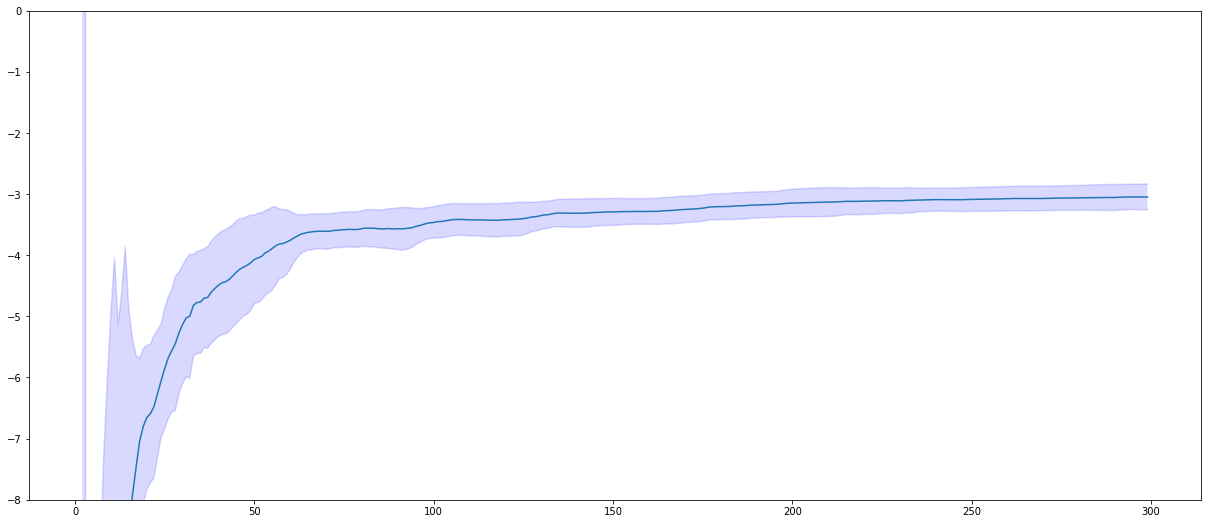

In [11]:
plt.figure(figsize=(21,9))
plt.plot(range(n_samples),np.mean(ll_ksgld,0))
plt.plot(range(n_samples),upper,'blue',alpha=0.15)
plt.plot(range(n_samples),lower,'blue', alpha=0.15)
plt.fill_between(range(n_samples),lower, upper, facecolor='blue', alpha=0.15,interpolate=True)
plt.ylim(-8,0)

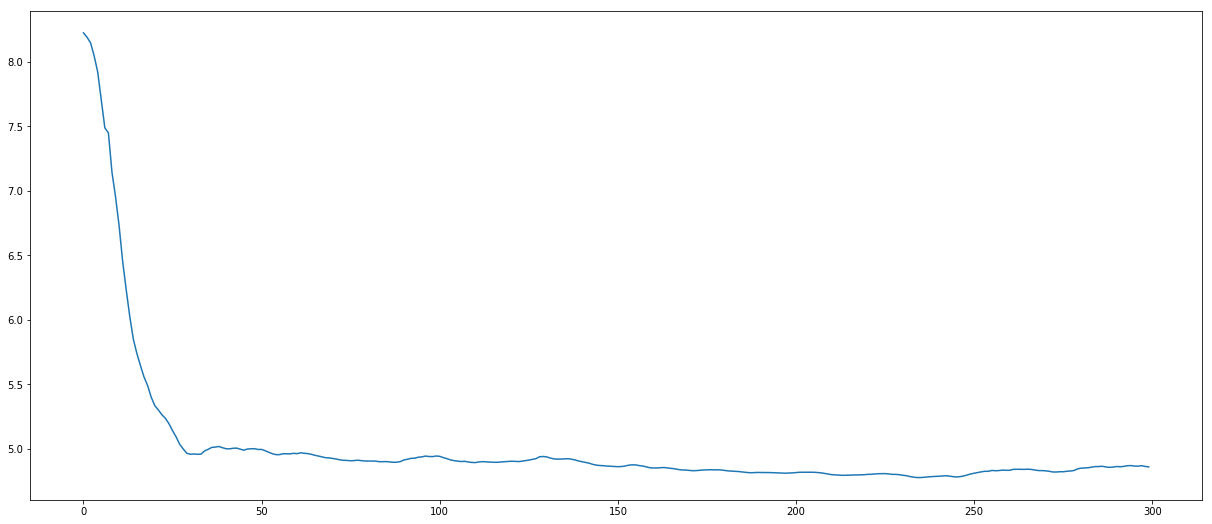

In [54]:
plt.figure(figsize=(21,9))
plt.plot(range(300),test_rmse)

# Simulated Datasets

## Cubic

20 data points simulated as follows:

- x sampled from $\mathcal{U}(-4,4)$
- y sampled from $\mathcal{N}(x^3,3^2)$

In [2]:
x, _ = torch.empty(20,1).uniform_(-4,4).sort(0)
y = torch.normal(x**3,3)
grid = np.linspace(-6,6,400).reshape(-1,1)
y_true = grid ** 3

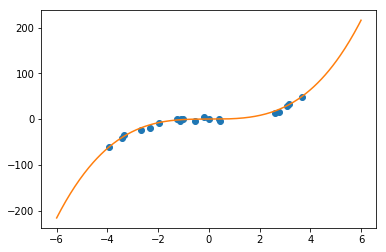

In [3]:
plt.plot(x.numpy(),y.numpy(),'o')
plt.plot(grid,y_true)

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
                      nn.Linear(1, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 1, bias=True)
                    ).to(device)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

In [15]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import sgd

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1.
lr = 1e-4


batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=False)

optim = sgd.optim.sgd(network, lr, lambda_, dataset_size)


#test_rmse = []
#log_lik_sgld = []


x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(20000):

    running_loss = 0
    
    network.zero_grad()
    output = network(x)
    loss = criterion(output, y)
    loss.backward()
    optim.step()




    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))
    
with torch.autograd.no_grad():
    prediction_sgd = network(x_test)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 13815.7002
Epoch 1 - loss: 12537.4785
Epoch 2 - loss: 11039.0859
Epoch 3 - loss: 9149.9795
Epoch 4 - loss: 6988.7407
Epoch 5 - loss: 5103.7158
Epoch 6 - loss: 4140.3457
Epoch 7 - loss: 3903.2798
Epoch 8 - loss: 3802.3481
Epoch 9 - loss: 3713.2585
Epoch 10 - loss: 3632.3132
Epoch 11 - loss: 3555.7754
Epoch 12 - loss: 3483.5972
Epoch 13 - loss: 3415.1597
Epoch 14 - loss: 3345.7407
Epoch 15 - loss: 3278.0559
Epoch 16 - loss: 3209.4182
Epoch 17 - loss: 3139.9561
Epoch 18 - loss: 3070.9626
Epoch 19 - loss: 2999.8765
Epoch 20 - loss: 2925.7119
Epoch 21 - loss: 2847.4460
Epoch 22 - loss: 2763.6384
Epoch 23 - loss: 2675.3286
Epoch 24 - loss: 2583.7129
Epoch 25 - loss: 2494.2957
Epoch 26 - loss: 2404.9553
Epoch 27 - loss: 2317.4377
Epoch 28 - loss: 2225.7791
Epoch 29 - loss: 2130.6548
Epoch 30 - loss: 2039.2834
Epoch 31 - loss: 1949.5140
Epoch 32 - loss: 1860.2927
Epoch 33 - loss: 1774.0750
Epoch 34 - loss: 1690.3132
Epoch 35 - loss: 1608.2363
Epoch 36 - loss: 1528.2228
Epoch 37

Epoch 316 - loss: 224.0576
Epoch 317 - loss: 227.4908
Epoch 318 - loss: 231.5988
Epoch 319 - loss: 240.6949
Epoch 320 - loss: 250.8854
Epoch 321 - loss: 270.2279
Epoch 322 - loss: 288.9532
Epoch 323 - loss: 320.5820
Epoch 324 - loss: 343.5149
Epoch 325 - loss: 379.0620
Epoch 326 - loss: 382.2075
Epoch 327 - loss: 400.7404
Epoch 328 - loss: 363.4669
Epoch 329 - loss: 360.2231
Epoch 330 - loss: 315.9264
Epoch 331 - loss: 306.7938
Epoch 332 - loss: 277.5379
Epoch 333 - loss: 272.0096
Epoch 334 - loss: 257.1060
Epoch 335 - loss: 254.6530
Epoch 336 - loss: 246.3973
Epoch 337 - loss: 246.4261
Epoch 338 - loss: 241.1748
Epoch 339 - loss: 242.1849
Epoch 340 - loss: 238.8899
Epoch 341 - loss: 240.3357
Epoch 342 - loss: 238.0670
Epoch 343 - loss: 240.0544
Epoch 344 - loss: 239.4008
Epoch 345 - loss: 243.3721
Epoch 346 - loss: 243.7339
Epoch 347 - loss: 251.1072
Epoch 348 - loss: 253.4677
Epoch 349 - loss: 264.4644
Epoch 350 - loss: 268.4818
Epoch 351 - loss: 285.6267
Epoch 352 - loss: 291.1536
E

Epoch 679 - loss: 312.5023
Epoch 680 - loss: 282.4361
Epoch 681 - loss: 272.3868
Epoch 682 - loss: 247.7445
Epoch 683 - loss: 240.5104
Epoch 684 - loss: 225.5024
Epoch 685 - loss: 220.6423
Epoch 686 - loss: 212.3261
Epoch 687 - loss: 211.0973
Epoch 688 - loss: 207.0925
Epoch 689 - loss: 207.7192
Epoch 690 - loss: 206.2050
Epoch 691 - loss: 209.5207
Epoch 692 - loss: 210.1533
Epoch 693 - loss: 216.1169
Epoch 694 - loss: 218.5334
Epoch 695 - loss: 226.7334
Epoch 696 - loss: 230.5182
Epoch 697 - loss: 242.0251
Epoch 698 - loss: 246.6704
Epoch 699 - loss: 262.4821
Epoch 700 - loss: 265.4324
Epoch 701 - loss: 285.2278
Epoch 702 - loss: 290.7418
Epoch 703 - loss: 315.0949
Epoch 704 - loss: 315.5093
Epoch 705 - loss: 341.4466
Epoch 706 - loss: 331.2319
Epoch 707 - loss: 355.4586
Epoch 708 - loss: 332.5767
Epoch 709 - loss: 348.0276
Epoch 710 - loss: 316.1884
Epoch 711 - loss: 319.0816
Epoch 712 - loss: 287.7361
Epoch 713 - loss: 283.6953
Epoch 714 - loss: 258.8922
Epoch 715 - loss: 253.1960
E

Epoch 1051 - loss: 269.2867
Epoch 1052 - loss: 251.6656
Epoch 1053 - loss: 252.1218
Epoch 1054 - loss: 237.7834
Epoch 1055 - loss: 237.7534
Epoch 1056 - loss: 226.0392
Epoch 1057 - loss: 225.7762
Epoch 1058 - loss: 216.8035
Epoch 1059 - loss: 216.5938
Epoch 1060 - loss: 210.4917
Epoch 1061 - loss: 211.5441
Epoch 1062 - loss: 207.4851
Epoch 1063 - loss: 209.3815
Epoch 1064 - loss: 206.9973
Epoch 1065 - loss: 210.9841
Epoch 1066 - loss: 210.5555
Epoch 1067 - loss: 215.4700
Epoch 1068 - loss: 216.1795
Epoch 1069 - loss: 223.7625
Epoch 1070 - loss: 226.3736
Epoch 1071 - loss: 237.3248
Epoch 1072 - loss: 243.2546
Epoch 1073 - loss: 257.5787
Epoch 1074 - loss: 264.9692
Epoch 1075 - loss: 279.5301
Epoch 1076 - loss: 284.1374
Epoch 1077 - loss: 292.9387
Epoch 1078 - loss: 293.8543
Epoch 1079 - loss: 295.1424
Epoch 1080 - loss: 293.2004
Epoch 1081 - loss: 286.0751
Epoch 1082 - loss: 278.8382
Epoch 1083 - loss: 268.3210
Epoch 1084 - loss: 259.8938
Epoch 1085 - loss: 247.1564
Epoch 1086 - loss: 2

Epoch 1412 - loss: 219.2935
Epoch 1413 - loss: 221.9903
Epoch 1414 - loss: 218.6620
Epoch 1415 - loss: 216.4443
Epoch 1416 - loss: 210.8374
Epoch 1417 - loss: 208.1267
Epoch 1418 - loss: 203.2884
Epoch 1419 - loss: 200.6601
Epoch 1420 - loss: 196.4894
Epoch 1421 - loss: 194.7518
Epoch 1422 - loss: 191.4712
Epoch 1423 - loss: 190.2253
Epoch 1424 - loss: 188.7687
Epoch 1425 - loss: 189.9949
Epoch 1426 - loss: 189.8776
Epoch 1427 - loss: 191.2880
Epoch 1428 - loss: 192.0524
Epoch 1429 - loss: 195.8499
Epoch 1430 - loss: 197.4620
Epoch 1431 - loss: 201.6488
Epoch 1432 - loss: 204.5730
Epoch 1433 - loss: 208.5905
Epoch 1434 - loss: 210.8745
Epoch 1435 - loss: 215.2227
Epoch 1436 - loss: 216.6095
Epoch 1437 - loss: 219.3216
Epoch 1438 - loss: 217.9865
Epoch 1439 - loss: 220.1531
Epoch 1440 - loss: 216.8766
Epoch 1441 - loss: 219.4951
Epoch 1442 - loss: 215.1678
Epoch 1443 - loss: 213.7872
Epoch 1444 - loss: 209.0037
Epoch 1445 - loss: 206.7818
Epoch 1446 - loss: 202.6230
Epoch 1447 - loss: 1

Epoch 1784 - loss: 188.6672
Epoch 1785 - loss: 188.4667
Epoch 1786 - loss: 189.9846
Epoch 1787 - loss: 190.3654
Epoch 1788 - loss: 192.8983
Epoch 1789 - loss: 194.1539
Epoch 1790 - loss: 195.3087
Epoch 1791 - loss: 196.5644
Epoch 1792 - loss: 198.6935
Epoch 1793 - loss: 197.8005
Epoch 1794 - loss: 199.0339
Epoch 1795 - loss: 199.4333
Epoch 1796 - loss: 199.8034
Epoch 1797 - loss: 197.5173
Epoch 1798 - loss: 196.3070
Epoch 1799 - loss: 194.2189
Epoch 1800 - loss: 193.1502
Epoch 1801 - loss: 190.1958
Epoch 1802 - loss: 189.3306
Epoch 1803 - loss: 187.0105
Epoch 1804 - loss: 186.3836
Epoch 1805 - loss: 184.9611
Epoch 1806 - loss: 185.6429
Epoch 1807 - loss: 185.0725
Epoch 1808 - loss: 186.1206
Epoch 1809 - loss: 186.5848
Epoch 1810 - loss: 187.9429
Epoch 1811 - loss: 187.3684
Epoch 1812 - loss: 189.5934
Epoch 1813 - loss: 191.3839
Epoch 1814 - loss: 193.3686
Epoch 1815 - loss: 193.9841
Epoch 1816 - loss: 195.3466
Epoch 1817 - loss: 193.8173
Epoch 1818 - loss: 193.6367
Epoch 1819 - loss: 1

Epoch 2198 - loss: 191.8986
Epoch 2199 - loss: 201.7875
Epoch 2200 - loss: 202.8500
Epoch 2201 - loss: 210.7261
Epoch 2202 - loss: 207.3221
Epoch 2203 - loss: 210.6142
Epoch 2204 - loss: 202.2090
Epoch 2205 - loss: 206.4989
Epoch 2206 - loss: 198.2072
Epoch 2207 - loss: 205.2947
Epoch 2208 - loss: 198.5795
Epoch 2209 - loss: 207.9125
Epoch 2210 - loss: 203.0898
Epoch 2211 - loss: 214.7316
Epoch 2212 - loss: 210.3403
Epoch 2213 - loss: 223.1006
Epoch 2214 - loss: 214.6216
Epoch 2215 - loss: 227.1368
Epoch 2216 - loss: 216.7559
Epoch 2217 - loss: 227.0093
Epoch 2218 - loss: 214.0017
Epoch 2219 - loss: 223.0914
Epoch 2220 - loss: 212.4453
Epoch 2221 - loss: 223.4770
Epoch 2222 - loss: 220.0081
Epoch 2223 - loss: 242.4978
Epoch 2224 - loss: 247.7960
Epoch 2225 - loss: 279.0714
Epoch 2226 - loss: 284.2312
Epoch 2227 - loss: 292.4731
Epoch 2228 - loss: 267.0657
Epoch 2229 - loss: 240.9997
Epoch 2230 - loss: 202.2846
Epoch 2231 - loss: 179.3923
Epoch 2232 - loss: 160.4966
Epoch 2233 - loss: 1

Epoch 2594 - loss: 155.5825
Epoch 2595 - loss: 148.2939
Epoch 2596 - loss: 148.5208
Epoch 2597 - loss: 143.5689
Epoch 2598 - loss: 147.0359
Epoch 2599 - loss: 144.9186
Epoch 2600 - loss: 151.6369
Epoch 2601 - loss: 149.9731
Epoch 2602 - loss: 159.9891
Epoch 2603 - loss: 162.4534
Epoch 2604 - loss: 177.9223
Epoch 2605 - loss: 181.8373
Epoch 2606 - loss: 201.5142
Epoch 2607 - loss: 199.8061
Epoch 2608 - loss: 212.0177
Epoch 2609 - loss: 192.2216
Epoch 2610 - loss: 191.0770
Epoch 2611 - loss: 170.6457
Epoch 2612 - loss: 166.2008
Epoch 2613 - loss: 155.4025
Epoch 2614 - loss: 154.0488
Epoch 2615 - loss: 148.1091
Epoch 2616 - loss: 150.4289
Epoch 2617 - loss: 145.8414
Epoch 2618 - loss: 149.4321
Epoch 2619 - loss: 147.3683
Epoch 2620 - loss: 153.5284
Epoch 2621 - loss: 152.2814
Epoch 2622 - loss: 161.6081
Epoch 2623 - loss: 163.2666
Epoch 2624 - loss: 178.3018
Epoch 2625 - loss: 182.1940
Epoch 2626 - loss: 203.4808
Epoch 2627 - loss: 198.9092
Epoch 2628 - loss: 211.9401
Epoch 2629 - loss: 1

Epoch 2952 - loss: 158.3654
Epoch 2953 - loss: 155.8547
Epoch 2954 - loss: 169.2551
Epoch 2955 - loss: 169.3812
Epoch 2956 - loss: 187.9606
Epoch 2957 - loss: 174.3993
Epoch 2958 - loss: 182.2472
Epoch 2959 - loss: 166.2419
Epoch 2960 - loss: 167.3599
Epoch 2961 - loss: 154.4622
Epoch 2962 - loss: 154.5017
Epoch 2963 - loss: 145.2221
Epoch 2964 - loss: 146.2731
Epoch 2965 - loss: 140.2123
Epoch 2966 - loss: 143.2604
Epoch 2967 - loss: 138.8942
Epoch 2968 - loss: 146.4482
Epoch 2969 - loss: 144.9142
Epoch 2970 - loss: 154.9136
Epoch 2971 - loss: 154.8828
Epoch 2972 - loss: 171.6227
Epoch 2973 - loss: 169.8634
Epoch 2974 - loss: 188.7893
Epoch 2975 - loss: 179.1799
Epoch 2976 - loss: 188.6776
Epoch 2977 - loss: 177.8810
Epoch 2978 - loss: 181.1307
Epoch 2979 - loss: 170.8082
Epoch 2980 - loss: 175.5665
Epoch 2981 - loss: 158.9971
Epoch 2982 - loss: 157.0464
Epoch 2983 - loss: 145.0832
Epoch 2984 - loss: 145.0329
Epoch 2985 - loss: 138.6250
Epoch 2986 - loss: 140.9022
Epoch 2987 - loss: 1

Epoch 3325 - loss: 160.7633
Epoch 3326 - loss: 158.8777
Epoch 3327 - loss: 146.5068
Epoch 3328 - loss: 143.5397
Epoch 3329 - loss: 135.6478
Epoch 3330 - loss: 136.5242
Epoch 3331 - loss: 131.8410
Epoch 3332 - loss: 137.2354
Epoch 3333 - loss: 135.6246
Epoch 3334 - loss: 147.3103
Epoch 3335 - loss: 152.2003
Epoch 3336 - loss: 172.6587
Epoch 3337 - loss: 177.0927
Epoch 3338 - loss: 201.1366
Epoch 3339 - loss: 199.5205
Epoch 3340 - loss: 221.4680
Epoch 3341 - loss: 220.0010
Epoch 3342 - loss: 234.2782
Epoch 3343 - loss: 215.8918
Epoch 3344 - loss: 220.6553
Epoch 3345 - loss: 197.5595
Epoch 3346 - loss: 196.0821
Epoch 3347 - loss: 171.0523
Epoch 3348 - loss: 167.1856
Epoch 3349 - loss: 150.7278
Epoch 3350 - loss: 147.0406
Epoch 3351 - loss: 136.9746
Epoch 3352 - loss: 136.4235
Epoch 3353 - loss: 131.9961
Epoch 3354 - loss: 134.6010
Epoch 3355 - loss: 133.7959
Epoch 3356 - loss: 140.4235
Epoch 3357 - loss: 141.1874
Epoch 3358 - loss: 153.8834
Epoch 3359 - loss: 155.9503
Epoch 3360 - loss: 1

Epoch 3711 - loss: 162.3398
Epoch 3712 - loss: 167.7801
Epoch 3713 - loss: 159.6755
Epoch 3714 - loss: 163.9170
Epoch 3715 - loss: 151.7731
Epoch 3716 - loss: 153.5452
Epoch 3717 - loss: 142.3060
Epoch 3718 - loss: 142.6417
Epoch 3719 - loss: 135.2436
Epoch 3720 - loss: 138.3798
Epoch 3721 - loss: 133.6007
Epoch 3722 - loss: 140.1211
Epoch 3723 - loss: 136.9006
Epoch 3724 - loss: 145.8805
Epoch 3725 - loss: 141.1635
Epoch 3726 - loss: 149.8296
Epoch 3727 - loss: 144.6464
Epoch 3728 - loss: 154.7645
Epoch 3729 - loss: 146.9263
Epoch 3730 - loss: 154.3526
Epoch 3731 - loss: 145.5930
Epoch 3732 - loss: 151.5671
Epoch 3733 - loss: 143.5885
Epoch 3734 - loss: 148.5825
Epoch 3735 - loss: 143.0512
Epoch 3736 - loss: 148.9146
Epoch 3737 - loss: 142.7068
Epoch 3738 - loss: 147.6236
Epoch 3739 - loss: 140.3531
Epoch 3740 - loss: 146.4768
Epoch 3741 - loss: 140.4514
Epoch 3742 - loss: 145.1856
Epoch 3743 - loss: 138.9467
Epoch 3744 - loss: 143.7143
Epoch 3745 - loss: 137.4935
Epoch 3746 - loss: 1

Epoch 4091 - loss: 124.6250
Epoch 4092 - loss: 125.6575
Epoch 4093 - loss: 122.4720
Epoch 4094 - loss: 125.5507
Epoch 4095 - loss: 123.6851
Epoch 4096 - loss: 128.2440
Epoch 4097 - loss: 127.6336
Epoch 4098 - loss: 137.9193
Epoch 4099 - loss: 137.2667
Epoch 4100 - loss: 151.6635
Epoch 4101 - loss: 148.6157
Epoch 4102 - loss: 164.5841
Epoch 4103 - loss: 158.2904
Epoch 4104 - loss: 170.5472
Epoch 4105 - loss: 163.4414
Epoch 4106 - loss: 172.4511
Epoch 4107 - loss: 163.1536
Epoch 4108 - loss: 169.3732
Epoch 4109 - loss: 162.1935
Epoch 4110 - loss: 170.3085
Epoch 4111 - loss: 158.7718
Epoch 4112 - loss: 164.4658
Epoch 4113 - loss: 144.7506
Epoch 4114 - loss: 142.8283
Epoch 4115 - loss: 134.0711
Epoch 4116 - loss: 133.6812
Epoch 4117 - loss: 127.8137
Epoch 4118 - loss: 130.4402
Epoch 4119 - loss: 126.6981
Epoch 4120 - loss: 130.8855
Epoch 4121 - loss: 128.3852
Epoch 4122 - loss: 133.6021
Epoch 4123 - loss: 132.1707
Epoch 4124 - loss: 143.2871
Epoch 4125 - loss: 141.3680
Epoch 4126 - loss: 1

Epoch 4414 - loss: 128.8468
Epoch 4415 - loss: 126.9421
Epoch 4416 - loss: 135.1193
Epoch 4417 - loss: 133.2321
Epoch 4418 - loss: 140.2793
Epoch 4419 - loss: 138.1937
Epoch 4420 - loss: 148.5842
Epoch 4421 - loss: 144.2420
Epoch 4422 - loss: 149.6370
Epoch 4423 - loss: 142.5125
Epoch 4424 - loss: 143.4458
Epoch 4425 - loss: 135.9416
Epoch 4426 - loss: 134.0104
Epoch 4427 - loss: 128.5105
Epoch 4428 - loss: 127.5617
Epoch 4429 - loss: 124.0416
Epoch 4430 - loss: 124.7650
Epoch 4431 - loss: 123.2005
Epoch 4432 - loss: 125.9427
Epoch 4433 - loss: 125.0464
Epoch 4434 - loss: 129.8248
Epoch 4435 - loss: 130.0775
Epoch 4436 - loss: 138.6838
Epoch 4437 - loss: 139.1154
Epoch 4438 - loss: 150.3974
Epoch 4439 - loss: 148.2224
Epoch 4440 - loss: 159.3664
Epoch 4441 - loss: 149.2467
Epoch 4442 - loss: 150.3174
Epoch 4443 - loss: 139.8038
Epoch 4444 - loss: 135.9310
Epoch 4445 - loss: 128.8207
Epoch 4446 - loss: 127.3540
Epoch 4447 - loss: 122.5124
Epoch 4448 - loss: 123.6131
Epoch 4449 - loss: 1

Epoch 4785 - loss: 142.1730
Epoch 4786 - loss: 143.2945
Epoch 4787 - loss: 133.1511
Epoch 4788 - loss: 135.1697
Epoch 4789 - loss: 128.5436
Epoch 4790 - loss: 130.6602
Epoch 4791 - loss: 126.5269
Epoch 4792 - loss: 128.3253
Epoch 4793 - loss: 125.4124
Epoch 4794 - loss: 131.0519
Epoch 4795 - loss: 128.7323
Epoch 4796 - loss: 137.3064
Epoch 4797 - loss: 134.9809
Epoch 4798 - loss: 147.2465
Epoch 4799 - loss: 141.2581
Epoch 4800 - loss: 152.8325
Epoch 4801 - loss: 141.8823
Epoch 4802 - loss: 148.1790
Epoch 4803 - loss: 139.9158
Epoch 4804 - loss: 143.1461
Epoch 4805 - loss: 134.6072
Epoch 4806 - loss: 136.5701
Epoch 4807 - loss: 128.6449
Epoch 4808 - loss: 129.8399
Epoch 4809 - loss: 124.0989
Epoch 4810 - loss: 123.9830
Epoch 4811 - loss: 120.1719
Epoch 4812 - loss: 122.5312
Epoch 4813 - loss: 119.7453
Epoch 4814 - loss: 122.3370
Epoch 4815 - loss: 120.3942
Epoch 4816 - loss: 124.6998
Epoch 4817 - loss: 123.7319
Epoch 4818 - loss: 131.2294
Epoch 4819 - loss: 130.0782
Epoch 4820 - loss: 1

Epoch 5169 - loss: 148.9972
Epoch 5170 - loss: 157.1152
Epoch 5171 - loss: 148.8573
Epoch 5172 - loss: 156.5537
Epoch 5173 - loss: 146.3199
Epoch 5174 - loss: 153.1482
Epoch 5175 - loss: 141.2946
Epoch 5176 - loss: 144.4384
Epoch 5177 - loss: 135.0145
Epoch 5178 - loss: 138.7592
Epoch 5179 - loss: 130.1450
Epoch 5180 - loss: 129.1452
Epoch 5181 - loss: 122.8882
Epoch 5182 - loss: 121.8035
Epoch 5183 - loss: 118.0970
Epoch 5184 - loss: 119.7080
Epoch 5185 - loss: 117.1062
Epoch 5186 - loss: 120.2050
Epoch 5187 - loss: 118.4386
Epoch 5188 - loss: 121.5835
Epoch 5189 - loss: 120.6116
Epoch 5190 - loss: 127.0231
Epoch 5191 - loss: 126.3207
Epoch 5192 - loss: 135.0054
Epoch 5193 - loss: 133.7024
Epoch 5194 - loss: 145.1564
Epoch 5195 - loss: 140.5668
Epoch 5196 - loss: 146.2127
Epoch 5197 - loss: 139.5625
Epoch 5198 - loss: 140.7377
Epoch 5199 - loss: 132.8787
Epoch 5200 - loss: 129.8002
Epoch 5201 - loss: 124.3762
Epoch 5202 - loss: 122.3894
Epoch 5203 - loss: 119.1981
Epoch 5204 - loss: 1

Epoch 5518 - loss: 124.6681
Epoch 5519 - loss: 124.7626
Epoch 5520 - loss: 134.4378
Epoch 5521 - loss: 133.5211
Epoch 5522 - loss: 146.2529
Epoch 5523 - loss: 142.8907
Epoch 5524 - loss: 153.3339
Epoch 5525 - loss: 142.9148
Epoch 5526 - loss: 145.5860
Epoch 5527 - loss: 135.2734
Epoch 5528 - loss: 134.8524
Epoch 5529 - loss: 126.0296
Epoch 5530 - loss: 123.8441
Epoch 5531 - loss: 118.4024
Epoch 5532 - loss: 117.3025
Epoch 5533 - loss: 114.2826
Epoch 5534 - loss: 114.6749
Epoch 5535 - loss: 113.0519
Epoch 5536 - loss: 117.4421
Epoch 5537 - loss: 116.5502
Epoch 5538 - loss: 122.1494
Epoch 5539 - loss: 121.8717
Epoch 5540 - loss: 132.4734
Epoch 5541 - loss: 132.0018
Epoch 5542 - loss: 147.0201
Epoch 5543 - loss: 148.0942
Epoch 5544 - loss: 166.1911
Epoch 5545 - loss: 160.1548
Epoch 5546 - loss: 175.2506
Epoch 5547 - loss: 162.2551
Epoch 5548 - loss: 168.5619
Epoch 5549 - loss: 155.0388
Epoch 5550 - loss: 159.0252
Epoch 5551 - loss: 138.7408
Epoch 5552 - loss: 135.6125
Epoch 5553 - loss: 1

Epoch 5875 - loss: 153.1476
Epoch 5876 - loss: 168.9846
Epoch 5877 - loss: 154.4705
Epoch 5878 - loss: 162.7749
Epoch 5879 - loss: 143.6881
Epoch 5880 - loss: 141.8902
Epoch 5881 - loss: 129.5169
Epoch 5882 - loss: 128.2709
Epoch 5883 - loss: 124.5280
Epoch 5884 - loss: 126.8194
Epoch 5885 - loss: 124.3375
Epoch 5886 - loss: 126.9694
Epoch 5887 - loss: 125.1097
Epoch 5888 - loss: 131.1780
Epoch 5889 - loss: 129.7445
Epoch 5890 - loss: 138.9267
Epoch 5891 - loss: 138.2474
Epoch 5892 - loss: 150.9338
Epoch 5893 - loss: 140.6468
Epoch 5894 - loss: 150.3477
Epoch 5895 - loss: 139.2926
Epoch 5896 - loss: 145.6315
Epoch 5897 - loss: 137.4716
Epoch 5898 - loss: 145.8662
Epoch 5899 - loss: 135.8295
Epoch 5900 - loss: 138.0580
Epoch 5901 - loss: 129.6473
Epoch 5902 - loss: 130.4806
Epoch 5903 - loss: 122.7360
Epoch 5904 - loss: 121.9347
Epoch 5905 - loss: 116.9857
Epoch 5906 - loss: 116.6681
Epoch 5907 - loss: 113.5680
Epoch 5908 - loss: 114.0414
Epoch 5909 - loss: 112.1087
Epoch 5910 - loss: 1

Epoch 6248 - loss: 131.8889
Epoch 6249 - loss: 127.1146
Epoch 6250 - loss: 130.3734
Epoch 6251 - loss: 126.3023
Epoch 6252 - loss: 131.8865
Epoch 6253 - loss: 128.1322
Epoch 6254 - loss: 135.8303
Epoch 6255 - loss: 132.2605
Epoch 6256 - loss: 140.9256
Epoch 6257 - loss: 133.7943
Epoch 6258 - loss: 139.3640
Epoch 6259 - loss: 134.3941
Epoch 6260 - loss: 143.5163
Epoch 6261 - loss: 133.9451
Epoch 6262 - loss: 137.8929
Epoch 6263 - loss: 132.2437
Epoch 6264 - loss: 137.6464
Epoch 6265 - loss: 131.1901
Epoch 6266 - loss: 133.9414
Epoch 6267 - loss: 126.8904
Epoch 6268 - loss: 130.2870
Epoch 6269 - loss: 123.9538
Epoch 6270 - loss: 125.5566
Epoch 6271 - loss: 120.1642
Epoch 6272 - loss: 122.0639
Epoch 6273 - loss: 117.5570
Epoch 6274 - loss: 118.6430
Epoch 6275 - loss: 115.2551
Epoch 6276 - loss: 116.1540
Epoch 6277 - loss: 113.7637
Epoch 6278 - loss: 115.2859
Epoch 6279 - loss: 113.6042
Epoch 6280 - loss: 116.3159
Epoch 6281 - loss: 115.2124
Epoch 6282 - loss: 120.3489
Epoch 6283 - loss: 1

Epoch 6634 - loss: 126.9242
Epoch 6635 - loss: 123.1668
Epoch 6636 - loss: 125.4480
Epoch 6637 - loss: 122.4684
Epoch 6638 - loss: 127.8165
Epoch 6639 - loss: 125.3159
Epoch 6640 - loss: 130.2499
Epoch 6641 - loss: 128.1084
Epoch 6642 - loss: 136.5043
Epoch 6643 - loss: 134.1665
Epoch 6644 - loss: 144.9392
Epoch 6645 - loss: 136.6650
Epoch 6646 - loss: 143.1149
Epoch 6647 - loss: 138.3497
Epoch 6648 - loss: 149.7018
Epoch 6649 - loss: 138.9582
Epoch 6650 - loss: 144.5515
Epoch 6651 - loss: 136.4288
Epoch 6652 - loss: 142.3148
Epoch 6653 - loss: 133.2442
Epoch 6654 - loss: 135.0518
Epoch 6655 - loss: 125.3903
Epoch 6656 - loss: 125.2567
Epoch 6657 - loss: 117.8591
Epoch 6658 - loss: 116.9467
Epoch 6659 - loss: 112.7130
Epoch 6660 - loss: 112.0131
Epoch 6661 - loss: 109.3428
Epoch 6662 - loss: 109.4703
Epoch 6663 - loss: 108.5344
Epoch 6664 - loss: 109.5793
Epoch 6665 - loss: 109.3367
Epoch 6666 - loss: 112.0777
Epoch 6667 - loss: 112.2801
Epoch 6668 - loss: 117.3286
Epoch 6669 - loss: 1

Epoch 7016 - loss: 142.5818
Epoch 7017 - loss: 143.2017
Epoch 7018 - loss: 155.4340
Epoch 7019 - loss: 148.0366
Epoch 7020 - loss: 161.5728
Epoch 7021 - loss: 156.7572
Epoch 7022 - loss: 168.1484
Epoch 7023 - loss: 155.2002
Epoch 7024 - loss: 159.5759
Epoch 7025 - loss: 146.1610
Epoch 7026 - loss: 148.6469
Epoch 7027 - loss: 137.1042
Epoch 7028 - loss: 138.1084
Epoch 7029 - loss: 129.9649
Epoch 7030 - loss: 132.3696
Epoch 7031 - loss: 125.4571
Epoch 7032 - loss: 126.5449
Epoch 7033 - loss: 122.5220
Epoch 7034 - loss: 125.1754
Epoch 7035 - loss: 121.2249
Epoch 7036 - loss: 123.5894
Epoch 7037 - loss: 120.3773
Epoch 7038 - loss: 125.1741
Epoch 7039 - loss: 121.5974
Epoch 7040 - loss: 125.6681
Epoch 7041 - loss: 121.9764
Epoch 7042 - loss: 127.5183
Epoch 7043 - loss: 123.2076
Epoch 7044 - loss: 127.6255
Epoch 7045 - loss: 122.8121
Epoch 7046 - loss: 126.0054
Epoch 7047 - loss: 120.9063
Epoch 7048 - loss: 122.5225
Epoch 7049 - loss: 117.7853
Epoch 7050 - loss: 118.8921
Epoch 7051 - loss: 1

Epoch 7396 - loss: 131.3618
Epoch 7397 - loss: 128.8485
Epoch 7398 - loss: 136.2126
Epoch 7399 - loss: 132.5356
Epoch 7400 - loss: 141.6853
Epoch 7401 - loss: 137.6075
Epoch 7402 - loss: 148.4429
Epoch 7403 - loss: 142.1455
Epoch 7404 - loss: 151.7351
Epoch 7405 - loss: 144.7390
Epoch 7406 - loss: 153.0587
Epoch 7407 - loss: 142.3609
Epoch 7408 - loss: 147.8597
Epoch 7409 - loss: 135.6550
Epoch 7410 - loss: 136.6429
Epoch 7411 - loss: 124.6610
Epoch 7412 - loss: 122.7834
Epoch 7413 - loss: 115.1794
Epoch 7414 - loss: 112.5908
Epoch 7415 - loss: 108.5188
Epoch 7416 - loss: 107.4410
Epoch 7417 - loss: 106.0401
Epoch 7418 - loss: 105.8808
Epoch 7419 - loss: 105.2899
Epoch 7420 - loss: 105.8751
Epoch 7421 - loss: 105.9453
Epoch 7422 - loss: 107.6674
Epoch 7423 - loss: 108.0192
Epoch 7424 - loss: 110.5450
Epoch 7425 - loss: 111.4953
Epoch 7426 - loss: 116.1546
Epoch 7427 - loss: 117.0068
Epoch 7428 - loss: 123.7446
Epoch 7429 - loss: 122.5767
Epoch 7430 - loss: 129.9477
Epoch 7431 - loss: 1

Epoch 7744 - loss: 126.0875
Epoch 7745 - loss: 123.8219
Epoch 7746 - loss: 126.9381
Epoch 7747 - loss: 122.5661
Epoch 7748 - loss: 123.4684
Epoch 7749 - loss: 119.1803
Epoch 7750 - loss: 119.2526
Epoch 7751 - loss: 115.1235
Epoch 7752 - loss: 114.9730
Epoch 7753 - loss: 112.2541
Epoch 7754 - loss: 112.2734
Epoch 7755 - loss: 110.9145
Epoch 7756 - loss: 111.4518
Epoch 7757 - loss: 110.5586
Epoch 7758 - loss: 111.4092
Epoch 7759 - loss: 110.9751
Epoch 7760 - loss: 112.1340
Epoch 7761 - loss: 112.0600
Epoch 7762 - loss: 114.1291
Epoch 7763 - loss: 113.7450
Epoch 7764 - loss: 116.0546
Epoch 7765 - loss: 115.5822
Epoch 7766 - loss: 117.9023
Epoch 7767 - loss: 117.9318
Epoch 7768 - loss: 121.4010
Epoch 7769 - loss: 121.2313
Epoch 7770 - loss: 124.4288
Epoch 7771 - loss: 122.8501
Epoch 7772 - loss: 125.8969
Epoch 7773 - loss: 122.7625
Epoch 7774 - loss: 124.4176
Epoch 7775 - loss: 120.8873
Epoch 7776 - loss: 122.2865
Epoch 7777 - loss: 117.5760
Epoch 7778 - loss: 117.8645
Epoch 7779 - loss: 1

Epoch 8100 - loss: 109.7124
Epoch 8101 - loss: 109.1317
Epoch 8102 - loss: 111.5604
Epoch 8103 - loss: 110.7036
Epoch 8104 - loss: 113.5095
Epoch 8105 - loss: 112.5332
Epoch 8106 - loss: 116.3612
Epoch 8107 - loss: 115.0842
Epoch 8108 - loss: 119.6838
Epoch 8109 - loss: 117.9622
Epoch 8110 - loss: 125.8458
Epoch 8111 - loss: 123.9270
Epoch 8112 - loss: 134.3459
Epoch 8113 - loss: 131.5168
Epoch 8114 - loss: 144.6596
Epoch 8115 - loss: 142.7652
Epoch 8116 - loss: 157.2531
Epoch 8117 - loss: 152.7581
Epoch 8118 - loss: 167.1725
Epoch 8119 - loss: 155.4981
Epoch 8120 - loss: 160.2750
Epoch 8121 - loss: 148.9161
Epoch 8122 - loss: 151.7593
Epoch 8123 - loss: 143.4389
Epoch 8124 - loss: 144.9429
Epoch 8125 - loss: 137.8820
Epoch 8126 - loss: 138.2276
Epoch 8127 - loss: 135.2648
Epoch 8128 - loss: 137.1804
Epoch 8129 - loss: 133.3920
Epoch 8130 - loss: 139.0791
Epoch 8131 - loss: 134.6906
Epoch 8132 - loss: 137.8304
Epoch 8133 - loss: 133.4973
Epoch 8134 - loss: 138.2336
Epoch 8135 - loss: 1

Epoch 8439 - loss: 137.5467
Epoch 8440 - loss: 132.8179
Epoch 8441 - loss: 139.2418
Epoch 8442 - loss: 134.0652
Epoch 8443 - loss: 140.5666
Epoch 8444 - loss: 133.1576
Epoch 8445 - loss: 137.2707
Epoch 8446 - loss: 131.7429
Epoch 8447 - loss: 137.2800
Epoch 8448 - loss: 132.1209
Epoch 8449 - loss: 138.0002
Epoch 8450 - loss: 132.4721
Epoch 8451 - loss: 138.4560
Epoch 8452 - loss: 132.4669
Epoch 8453 - loss: 138.5267
Epoch 8454 - loss: 132.6446
Epoch 8455 - loss: 138.6758
Epoch 8456 - loss: 131.9148
Epoch 8457 - loss: 136.0487
Epoch 8458 - loss: 129.5658
Epoch 8459 - loss: 135.0454
Epoch 8460 - loss: 126.5525
Epoch 8461 - loss: 127.9313
Epoch 8462 - loss: 119.8062
Epoch 8463 - loss: 120.1903
Epoch 8464 - loss: 113.8572
Epoch 8465 - loss: 112.6698
Epoch 8466 - loss: 109.2284
Epoch 8467 - loss: 108.7579
Epoch 8468 - loss: 106.7027
Epoch 8469 - loss: 106.7796
Epoch 8470 - loss: 105.5033
Epoch 8471 - loss: 106.0833
Epoch 8472 - loss: 105.5760
Epoch 8473 - loss: 106.7605
Epoch 8474 - loss: 1

Epoch 8750 - loss: 106.3566
Epoch 8751 - loss: 106.3129
Epoch 8752 - loss: 105.2486
Epoch 8753 - loss: 105.8240
Epoch 8754 - loss: 105.1904
Epoch 8755 - loss: 106.4245
Epoch 8756 - loss: 106.3784
Epoch 8757 - loss: 108.0826
Epoch 8758 - loss: 108.2126
Epoch 8759 - loss: 110.4188
Epoch 8760 - loss: 110.3747
Epoch 8761 - loss: 113.3982
Epoch 8762 - loss: 112.9349
Epoch 8763 - loss: 116.2980
Epoch 8764 - loss: 114.8897
Epoch 8765 - loss: 117.2452
Epoch 8766 - loss: 116.4030
Epoch 8767 - loss: 118.8923
Epoch 8768 - loss: 117.1282
Epoch 8769 - loss: 119.0126
Epoch 8770 - loss: 116.4480
Epoch 8771 - loss: 117.5071
Epoch 8772 - loss: 114.7904
Epoch 8773 - loss: 115.0925
Epoch 8774 - loss: 112.0381
Epoch 8775 - loss: 112.0144
Epoch 8776 - loss: 109.8177
Epoch 8777 - loss: 109.8620
Epoch 8778 - loss: 108.1193
Epoch 8779 - loss: 108.2528
Epoch 8780 - loss: 107.1419
Epoch 8781 - loss: 107.5910
Epoch 8782 - loss: 106.9810
Epoch 8783 - loss: 107.8384
Epoch 8784 - loss: 107.4024
Epoch 8785 - loss: 1

Epoch 9115 - loss: 106.5648
Epoch 9116 - loss: 105.8455
Epoch 9117 - loss: 106.4780
Epoch 9118 - loss: 106.0400
Epoch 9119 - loss: 106.9305
Epoch 9120 - loss: 107.0968
Epoch 9121 - loss: 108.6224
Epoch 9122 - loss: 108.2968
Epoch 9123 - loss: 110.2689
Epoch 9124 - loss: 109.8097
Epoch 9125 - loss: 112.4145
Epoch 9126 - loss: 112.3427
Epoch 9127 - loss: 115.6456
Epoch 9128 - loss: 114.5134
Epoch 9129 - loss: 117.6258
Epoch 9130 - loss: 115.6881
Epoch 9131 - loss: 117.6651
Epoch 9132 - loss: 114.1721
Epoch 9133 - loss: 115.9171
Epoch 9134 - loss: 111.9983
Epoch 9135 - loss: 112.5448
Epoch 9136 - loss: 108.7584
Epoch 9137 - loss: 109.0415
Epoch 9138 - loss: 106.4940
Epoch 9139 - loss: 106.6325
Epoch 9140 - loss: 104.9779
Epoch 9141 - loss: 105.2383
Epoch 9142 - loss: 103.9325
Epoch 9143 - loss: 104.8029
Epoch 9144 - loss: 103.8522
Epoch 9145 - loss: 105.4867
Epoch 9146 - loss: 104.6806
Epoch 9147 - loss: 107.3164
Epoch 9148 - loss: 106.5539
Epoch 9149 - loss: 109.4978
Epoch 9150 - loss: 1

Epoch 9479 - loss: 104.1671
Epoch 9480 - loss: 104.2026
Epoch 9481 - loss: 105.4292
Epoch 9482 - loss: 105.1840
Epoch 9483 - loss: 106.7019
Epoch 9484 - loss: 106.2680
Epoch 9485 - loss: 108.3609
Epoch 9486 - loss: 108.0350
Epoch 9487 - loss: 111.0468
Epoch 9488 - loss: 110.7717
Epoch 9489 - loss: 116.0533
Epoch 9490 - loss: 114.4368
Epoch 9491 - loss: 118.5799
Epoch 9492 - loss: 116.3635
Epoch 9493 - loss: 122.7144
Epoch 9494 - loss: 119.6156
Epoch 9495 - loss: 128.7551
Epoch 9496 - loss: 126.5498
Epoch 9497 - loss: 138.8373
Epoch 9498 - loss: 139.1945
Epoch 9499 - loss: 155.1470
Epoch 9500 - loss: 153.0938
Epoch 9501 - loss: 169.2665
Epoch 9502 - loss: 168.0974
Epoch 9503 - loss: 185.8963
Epoch 9504 - loss: 176.1663
Epoch 9505 - loss: 190.1009
Epoch 9506 - loss: 175.9415
Epoch 9507 - loss: 178.0591
Epoch 9508 - loss: 162.4951
Epoch 9509 - loss: 156.7102
Epoch 9510 - loss: 144.5829
Epoch 9511 - loss: 138.1015
Epoch 9512 - loss: 128.4723
Epoch 9513 - loss: 123.9038
Epoch 9514 - loss: 1

Epoch 9853 - loss: 141.6812
Epoch 9854 - loss: 136.6923
Epoch 9855 - loss: 146.9659
Epoch 9856 - loss: 134.7212
Epoch 9857 - loss: 145.1587
Epoch 9858 - loss: 132.3386
Epoch 9859 - loss: 134.2246
Epoch 9860 - loss: 124.0793
Epoch 9861 - loss: 125.5897
Epoch 9862 - loss: 121.7970
Epoch 9863 - loss: 126.3907
Epoch 9864 - loss: 122.5356
Epoch 9865 - loss: 128.7167
Epoch 9866 - loss: 121.5384
Epoch 9867 - loss: 123.1931
Epoch 9868 - loss: 120.9809
Epoch 9869 - loss: 128.7258
Epoch 9870 - loss: 121.6242
Epoch 9871 - loss: 124.0037
Epoch 9872 - loss: 120.9425
Epoch 9873 - loss: 123.3454
Epoch 9874 - loss: 119.6950
Epoch 9875 - loss: 127.3946
Epoch 9876 - loss: 124.2283
Epoch 9877 - loss: 133.2402
Epoch 9878 - loss: 129.2490
Epoch 9879 - loss: 138.9970
Epoch 9880 - loss: 133.3615
Epoch 9881 - loss: 142.9766
Epoch 9882 - loss: 130.7326
Epoch 9883 - loss: 132.2844
Epoch 9884 - loss: 124.4239
Epoch 9885 - loss: 129.0686
Epoch 9886 - loss: 121.0186
Epoch 9887 - loss: 123.9188
Epoch 9888 - loss: 1

Epoch 10239 - loss: 112.6909
Epoch 10240 - loss: 112.5794
Epoch 10241 - loss: 118.8234
Epoch 10242 - loss: 115.9547
Epoch 10243 - loss: 120.1761
Epoch 10244 - loss: 115.2963
Epoch 10245 - loss: 116.4656
Epoch 10246 - loss: 111.6949
Epoch 10247 - loss: 111.4711
Epoch 10248 - loss: 106.5956
Epoch 10249 - loss: 105.7361
Epoch 10250 - loss: 102.9162
Epoch 10251 - loss: 102.2990
Epoch 10252 - loss: 100.3486
Epoch 10253 - loss: 100.4309
Epoch 10254 - loss: 99.6656
Epoch 10255 - loss: 100.0747
Epoch 10256 - loss: 99.6976
Epoch 10257 - loss: 100.3055
Epoch 10258 - loss: 100.1333
Epoch 10259 - loss: 101.0362
Epoch 10260 - loss: 101.3638
Epoch 10261 - loss: 102.6389
Epoch 10262 - loss: 102.9027
Epoch 10263 - loss: 104.5698
Epoch 10264 - loss: 104.6216
Epoch 10265 - loss: 106.5270
Epoch 10266 - loss: 106.2617
Epoch 10267 - loss: 108.0599
Epoch 10268 - loss: 107.7898
Epoch 10269 - loss: 109.5251
Epoch 10270 - loss: 109.0085
Epoch 10271 - loss: 110.6404
Epoch 10272 - loss: 110.1437
Epoch 10273 - lo

Epoch 10618 - loss: 95.8896
Epoch 10619 - loss: 95.8758
Epoch 10620 - loss: 97.4133
Epoch 10621 - loss: 97.8120
Epoch 10622 - loss: 99.7263
Epoch 10623 - loss: 99.8761
Epoch 10624 - loss: 101.9553
Epoch 10625 - loss: 102.4977
Epoch 10626 - loss: 106.0066
Epoch 10627 - loss: 105.6547
Epoch 10628 - loss: 108.1977
Epoch 10629 - loss: 106.7764
Epoch 10630 - loss: 109.5110
Epoch 10631 - loss: 107.7832
Epoch 10632 - loss: 109.2694
Epoch 10633 - loss: 107.6910
Epoch 10634 - loss: 108.6075
Epoch 10635 - loss: 106.2877
Epoch 10636 - loss: 106.5390
Epoch 10637 - loss: 104.6868
Epoch 10638 - loss: 105.0135
Epoch 10639 - loss: 102.7542
Epoch 10640 - loss: 102.8548
Epoch 10641 - loss: 101.2704
Epoch 10642 - loss: 101.4486
Epoch 10643 - loss: 100.2307
Epoch 10644 - loss: 100.4085
Epoch 10645 - loss: 99.7132
Epoch 10646 - loss: 99.9666
Epoch 10647 - loss: 99.4084
Epoch 10648 - loss: 99.8920
Epoch 10649 - loss: 99.4434
Epoch 10650 - loss: 100.1296
Epoch 10651 - loss: 99.4776
Epoch 10652 - loss: 100.50

Epoch 10982 - loss: 105.5698
Epoch 10983 - loss: 101.1065
Epoch 10984 - loss: 102.0219
Epoch 10985 - loss: 98.7752
Epoch 10986 - loss: 98.8658
Epoch 10987 - loss: 96.6997
Epoch 10988 - loss: 97.7330
Epoch 10989 - loss: 95.8665
Epoch 10990 - loss: 98.0635
Epoch 10991 - loss: 96.6950
Epoch 10992 - loss: 97.8906
Epoch 10993 - loss: 96.8070
Epoch 10994 - loss: 99.6425
Epoch 10995 - loss: 98.8830
Epoch 10996 - loss: 102.3452
Epoch 10997 - loss: 101.6267
Epoch 10998 - loss: 108.9575
Epoch 10999 - loss: 108.1885
Epoch 11000 - loss: 117.7660
Epoch 11001 - loss: 118.5066
Epoch 11002 - loss: 131.3502
Epoch 11003 - loss: 133.5547
Epoch 11004 - loss: 148.6739
Epoch 11005 - loss: 142.2696
Epoch 11006 - loss: 159.0667
Epoch 11007 - loss: 148.4345
Epoch 11008 - loss: 164.4593
Epoch 11009 - loss: 150.2778
Epoch 11010 - loss: 152.8834
Epoch 11011 - loss: 138.9123
Epoch 11012 - loss: 138.9846
Epoch 11013 - loss: 127.9824
Epoch 11014 - loss: 127.2950
Epoch 11015 - loss: 120.4700
Epoch 11016 - loss: 119.3

Epoch 11347 - loss: 101.1326
Epoch 11348 - loss: 101.2394
Epoch 11349 - loss: 99.1747
Epoch 11350 - loss: 98.9632
Epoch 11351 - loss: 96.9423
Epoch 11352 - loss: 97.0481
Epoch 11353 - loss: 95.8851
Epoch 11354 - loss: 96.0532
Epoch 11355 - loss: 95.3961
Epoch 11356 - loss: 95.8079
Epoch 11357 - loss: 95.3385
Epoch 11358 - loss: 95.8178
Epoch 11359 - loss: 95.3582
Epoch 11360 - loss: 95.8483
Epoch 11361 - loss: 95.5231
Epoch 11362 - loss: 96.1841
Epoch 11363 - loss: 95.4504
Epoch 11364 - loss: 96.2519
Epoch 11365 - loss: 96.3697
Epoch 11366 - loss: 98.1250
Epoch 11367 - loss: 98.4187
Epoch 11368 - loss: 100.8163
Epoch 11369 - loss: 100.7136
Epoch 11370 - loss: 103.7788
Epoch 11371 - loss: 103.2787
Epoch 11372 - loss: 107.1091
Epoch 11373 - loss: 105.2021
Epoch 11374 - loss: 107.9227
Epoch 11375 - loss: 105.3824
Epoch 11376 - loss: 109.4474
Epoch 11377 - loss: 105.7296
Epoch 11378 - loss: 110.2643
Epoch 11379 - loss: 106.6455
Epoch 11380 - loss: 109.9176
Epoch 11381 - loss: 106.3145
Epoc

Epoch 11701 - loss: 138.4373
Epoch 11702 - loss: 127.6456
Epoch 11703 - loss: 130.1477
Epoch 11704 - loss: 120.3935
Epoch 11705 - loss: 121.9530
Epoch 11706 - loss: 116.4506
Epoch 11707 - loss: 121.9035
Epoch 11708 - loss: 115.9784
Epoch 11709 - loss: 121.0218
Epoch 11710 - loss: 115.0827
Epoch 11711 - loss: 120.4868
Epoch 11712 - loss: 114.6984
Epoch 11713 - loss: 119.8324
Epoch 11714 - loss: 113.5082
Epoch 11715 - loss: 116.8777
Epoch 11716 - loss: 112.6668
Epoch 11717 - loss: 116.2290
Epoch 11718 - loss: 112.5698
Epoch 11719 - loss: 116.6803
Epoch 11720 - loss: 112.9244
Epoch 11721 - loss: 119.6538
Epoch 11722 - loss: 115.5494
Epoch 11723 - loss: 123.3703
Epoch 11724 - loss: 117.9627
Epoch 11725 - loss: 125.4033
Epoch 11726 - loss: 120.0814
Epoch 11727 - loss: 127.4728
Epoch 11728 - loss: 121.6176
Epoch 11729 - loss: 129.4870
Epoch 11730 - loss: 121.6846
Epoch 11731 - loss: 127.7003
Epoch 11732 - loss: 118.9075
Epoch 11733 - loss: 124.1330
Epoch 11734 - loss: 117.0699
Epoch 11735 - 

Epoch 12039 - loss: 99.8392
Epoch 12040 - loss: 98.0200
Epoch 12041 - loss: 98.0562
Epoch 12042 - loss: 96.5036
Epoch 12043 - loss: 96.3213
Epoch 12044 - loss: 95.3610
Epoch 12045 - loss: 95.4071
Epoch 12046 - loss: 94.9014
Epoch 12047 - loss: 94.9548
Epoch 12048 - loss: 94.1299
Epoch 12049 - loss: 94.4835
Epoch 12050 - loss: 94.1616
Epoch 12051 - loss: 94.4973
Epoch 12052 - loss: 94.5262
Epoch 12053 - loss: 95.1996
Epoch 12054 - loss: 95.1757
Epoch 12055 - loss: 95.7994
Epoch 12056 - loss: 96.2802
Epoch 12057 - loss: 96.8829
Epoch 12058 - loss: 96.9452
Epoch 12059 - loss: 98.1722
Epoch 12060 - loss: 98.6875
Epoch 12061 - loss: 100.2449
Epoch 12062 - loss: 100.8469
Epoch 12063 - loss: 102.2871
Epoch 12064 - loss: 103.3017
Epoch 12065 - loss: 105.4096
Epoch 12066 - loss: 105.9188
Epoch 12067 - loss: 108.3072
Epoch 12068 - loss: 107.6308
Epoch 12069 - loss: 108.8486
Epoch 12070 - loss: 107.1117
Epoch 12071 - loss: 107.9072
Epoch 12072 - loss: 104.9908
Epoch 12073 - loss: 104.4552
Epoch 1

Epoch 12356 - loss: 109.3385
Epoch 12357 - loss: 103.0810
Epoch 12358 - loss: 102.5982
Epoch 12359 - loss: 98.0502
Epoch 12360 - loss: 97.2627
Epoch 12361 - loss: 93.5385
Epoch 12362 - loss: 93.1646
Epoch 12363 - loss: 90.3787
Epoch 12364 - loss: 90.0278
Epoch 12365 - loss: 88.3596
Epoch 12366 - loss: 88.7391
Epoch 12367 - loss: 87.5193
Epoch 12368 - loss: 88.0941
Epoch 12369 - loss: 87.6582
Epoch 12370 - loss: 88.3743
Epoch 12371 - loss: 88.4773
Epoch 12372 - loss: 89.3885
Epoch 12373 - loss: 89.5512
Epoch 12374 - loss: 90.7141
Epoch 12375 - loss: 91.1842
Epoch 12376 - loss: 92.9173
Epoch 12377 - loss: 93.0143
Epoch 12378 - loss: 95.4897
Epoch 12379 - loss: 95.1770
Epoch 12380 - loss: 98.3925
Epoch 12381 - loss: 97.7830
Epoch 12382 - loss: 100.3539
Epoch 12383 - loss: 99.4543
Epoch 12384 - loss: 102.1412
Epoch 12385 - loss: 99.4318
Epoch 12386 - loss: 100.2562
Epoch 12387 - loss: 97.9485
Epoch 12388 - loss: 98.3550
Epoch 12389 - loss: 95.8696
Epoch 12390 - loss: 95.7803
Epoch 12391 - 

Epoch 12685 - loss: 98.2723
Epoch 12686 - loss: 100.2149
Epoch 12687 - loss: 96.2199
Epoch 12688 - loss: 101.0381
Epoch 12689 - loss: 97.3405
Epoch 12690 - loss: 101.4975
Epoch 12691 - loss: 98.5202
Epoch 12692 - loss: 99.8230
Epoch 12693 - loss: 96.8035
Epoch 12694 - loss: 102.7959
Epoch 12695 - loss: 100.7284
Epoch 12696 - loss: 106.5559
Epoch 12697 - loss: 104.1542
Epoch 12698 - loss: 110.5635
Epoch 12699 - loss: 107.5810
Epoch 12700 - loss: 112.9655
Epoch 12701 - loss: 110.2036
Epoch 12702 - loss: 119.5846
Epoch 12703 - loss: 115.9063
Epoch 12704 - loss: 126.2521
Epoch 12705 - loss: 121.5868
Epoch 12706 - loss: 131.7645
Epoch 12707 - loss: 125.9464
Epoch 12708 - loss: 135.3619
Epoch 12709 - loss: 128.2770
Epoch 12710 - loss: 135.6929
Epoch 12711 - loss: 127.2378
Epoch 12712 - loss: 133.2846
Epoch 12713 - loss: 125.3738
Epoch 12714 - loss: 129.8613
Epoch 12715 - loss: 122.6057
Epoch 12716 - loss: 125.6292
Epoch 12717 - loss: 119.9579
Epoch 12718 - loss: 122.2499
Epoch 12719 - loss: 

Epoch 13059 - loss: 91.4067
Epoch 13060 - loss: 91.4392
Epoch 13061 - loss: 91.1988
Epoch 13062 - loss: 91.2849
Epoch 13063 - loss: 90.5635
Epoch 13064 - loss: 90.7795
Epoch 13065 - loss: 90.8643
Epoch 13066 - loss: 91.4668
Epoch 13067 - loss: 91.1783
Epoch 13068 - loss: 91.4337
Epoch 13069 - loss: 90.9738
Epoch 13070 - loss: 91.7308
Epoch 13071 - loss: 92.2889
Epoch 13072 - loss: 93.6694
Epoch 13073 - loss: 94.0361
Epoch 13074 - loss: 94.8717
Epoch 13075 - loss: 95.4701
Epoch 13076 - loss: 97.0618
Epoch 13077 - loss: 96.8165
Epoch 13078 - loss: 98.1612
Epoch 13079 - loss: 97.7104
Epoch 13080 - loss: 99.4555
Epoch 13081 - loss: 99.3372
Epoch 13082 - loss: 101.0422
Epoch 13083 - loss: 100.0239
Epoch 13084 - loss: 100.5911
Epoch 13085 - loss: 98.2758
Epoch 13086 - loss: 98.4810
Epoch 13087 - loss: 96.0419
Epoch 13088 - loss: 95.9192
Epoch 13089 - loss: 93.3512
Epoch 13090 - loss: 92.6430
Epoch 13091 - loss: 90.5094
Epoch 13092 - loss: 90.1226
Epoch 13093 - loss: 87.7373
Epoch 13094 - los

Epoch 13427 - loss: 95.2756
Epoch 13428 - loss: 98.3654
Epoch 13429 - loss: 98.1403
Epoch 13430 - loss: 102.2136
Epoch 13431 - loss: 102.6069
Epoch 13432 - loss: 107.1579
Epoch 13433 - loss: 107.1626
Epoch 13434 - loss: 110.5719
Epoch 13435 - loss: 109.3367
Epoch 13436 - loss: 113.0786
Epoch 13437 - loss: 111.6762
Epoch 13438 - loss: 114.3065
Epoch 13439 - loss: 112.0274
Epoch 13440 - loss: 112.6628
Epoch 13441 - loss: 109.4545
Epoch 13442 - loss: 109.4606
Epoch 13443 - loss: 106.7825
Epoch 13444 - loss: 105.8003
Epoch 13445 - loss: 102.9728
Epoch 13446 - loss: 101.9858
Epoch 13447 - loss: 99.9623
Epoch 13448 - loss: 99.1641
Epoch 13449 - loss: 97.8066
Epoch 13450 - loss: 97.3197
Epoch 13451 - loss: 96.2179
Epoch 13452 - loss: 95.8225
Epoch 13453 - loss: 94.8503
Epoch 13454 - loss: 95.2778
Epoch 13455 - loss: 94.9847
Epoch 13456 - loss: 95.4043
Epoch 13457 - loss: 95.4923
Epoch 13458 - loss: 96.1732
Epoch 13459 - loss: 95.7947
Epoch 13460 - loss: 96.5441
Epoch 13461 - loss: 96.7505
Epo

Epoch 13795 - loss: 93.6774
Epoch 13796 - loss: 98.0300
Epoch 13797 - loss: 95.9726
Epoch 13798 - loss: 103.0840
Epoch 13799 - loss: 100.7549
Epoch 13800 - loss: 110.1667
Epoch 13801 - loss: 108.8260
Epoch 13802 - loss: 120.7854
Epoch 13803 - loss: 119.5350
Epoch 13804 - loss: 133.8490
Epoch 13805 - loss: 129.8575
Epoch 13806 - loss: 145.8331
Epoch 13807 - loss: 139.5820
Epoch 13808 - loss: 150.3257
Epoch 13809 - loss: 141.0373
Epoch 13810 - loss: 147.4325
Epoch 13811 - loss: 137.0568
Epoch 13812 - loss: 140.0391
Epoch 13813 - loss: 128.9685
Epoch 13814 - loss: 129.8048
Epoch 13815 - loss: 121.4254
Epoch 13816 - loss: 121.9212
Epoch 13817 - loss: 114.3765
Epoch 13818 - loss: 114.7616
Epoch 13819 - loss: 108.2300
Epoch 13820 - loss: 109.8172
Epoch 13821 - loss: 106.3000
Epoch 13822 - loss: 107.7146
Epoch 13823 - loss: 104.8051
Epoch 13824 - loss: 109.6412
Epoch 13825 - loss: 106.2953
Epoch 13826 - loss: 112.2768
Epoch 13827 - loss: 108.1553
Epoch 13828 - loss: 114.2677
Epoch 13829 - los

Epoch 14155 - loss: 109.5926
Epoch 14156 - loss: 114.5931
Epoch 14157 - loss: 108.1425
Epoch 14158 - loss: 116.3286
Epoch 14159 - loss: 107.8242
Epoch 14160 - loss: 113.4508
Epoch 14161 - loss: 107.1088
Epoch 14162 - loss: 115.9894
Epoch 14163 - loss: 108.0602
Epoch 14164 - loss: 114.0088
Epoch 14165 - loss: 107.4126
Epoch 14166 - loss: 112.2696
Epoch 14167 - loss: 106.1471
Epoch 14168 - loss: 110.9028
Epoch 14169 - loss: 104.9359
Epoch 14170 - loss: 112.2802
Epoch 14171 - loss: 105.9591
Epoch 14172 - loss: 113.4657
Epoch 14173 - loss: 107.5493
Epoch 14174 - loss: 116.3680
Epoch 14175 - loss: 109.2983
Epoch 14176 - loss: 117.8273
Epoch 14177 - loss: 110.2346
Epoch 14178 - loss: 119.2946
Epoch 14179 - loss: 111.3205
Epoch 14180 - loss: 119.0062
Epoch 14181 - loss: 109.9548
Epoch 14182 - loss: 117.6972
Epoch 14183 - loss: 108.8350
Epoch 14184 - loss: 111.9202
Epoch 14185 - loss: 103.4305
Epoch 14186 - loss: 103.4546
Epoch 14187 - loss: 96.3384
Epoch 14188 - loss: 94.8109
Epoch 14189 - lo

Epoch 14498 - loss: 78.9203
Epoch 14499 - loss: 78.8704
Epoch 14500 - loss: 79.5731
Epoch 14501 - loss: 79.8377
Epoch 14502 - loss: 80.9415
Epoch 14503 - loss: 81.6829
Epoch 14504 - loss: 83.9225
Epoch 14505 - loss: 84.9380
Epoch 14506 - loss: 88.0845
Epoch 14507 - loss: 88.5318
Epoch 14508 - loss: 92.5008
Epoch 14509 - loss: 91.7282
Epoch 14510 - loss: 94.6227
Epoch 14511 - loss: 92.7346
Epoch 14512 - loss: 93.6864
Epoch 14513 - loss: 91.0159
Epoch 14514 - loss: 91.2960
Epoch 14515 - loss: 88.3318
Epoch 14516 - loss: 88.0838
Epoch 14517 - loss: 86.0157
Epoch 14518 - loss: 85.9263
Epoch 14519 - loss: 84.4309
Epoch 14520 - loss: 84.4680
Epoch 14521 - loss: 83.5491
Epoch 14522 - loss: 83.9784
Epoch 14523 - loss: 83.4061
Epoch 14524 - loss: 83.8982
Epoch 14525 - loss: 83.8002
Epoch 14526 - loss: 84.4228
Epoch 14527 - loss: 84.4061
Epoch 14528 - loss: 85.8400
Epoch 14529 - loss: 86.5158
Epoch 14530 - loss: 88.6405
Epoch 14531 - loss: 89.4973
Epoch 14532 - loss: 91.3988
Epoch 14533 - loss: 

Epoch 14877 - loss: 137.3321
Epoch 14878 - loss: 146.0222
Epoch 14879 - loss: 136.5315
Epoch 14880 - loss: 142.4379
Epoch 14881 - loss: 131.2355
Epoch 14882 - loss: 134.0799
Epoch 14883 - loss: 124.5733
Epoch 14884 - loss: 125.8209
Epoch 14885 - loss: 117.5896
Epoch 14886 - loss: 119.3489
Epoch 14887 - loss: 112.6702
Epoch 14888 - loss: 115.5473
Epoch 14889 - loss: 109.3246
Epoch 14890 - loss: 112.7166
Epoch 14891 - loss: 107.6127
Epoch 14892 - loss: 111.1398
Epoch 14893 - loss: 105.6827
Epoch 14894 - loss: 110.8485
Epoch 14895 - loss: 105.1329
Epoch 14896 - loss: 109.7915
Epoch 14897 - loss: 104.1650
Epoch 14898 - loss: 110.0171
Epoch 14899 - loss: 104.5725
Epoch 14900 - loss: 110.5403
Epoch 14901 - loss: 104.9184
Epoch 14902 - loss: 111.1983
Epoch 14903 - loss: 104.6852
Epoch 14904 - loss: 111.9360
Epoch 14905 - loss: 104.9563
Epoch 14906 - loss: 107.6025
Epoch 14907 - loss: 100.5291
Epoch 14908 - loss: 103.2510
Epoch 14909 - loss: 96.7140
Epoch 14910 - loss: 99.2976
Epoch 14911 - lo

Epoch 15235 - loss: 79.2999
Epoch 15236 - loss: 79.2692
Epoch 15237 - loss: 78.8073
Epoch 15238 - loss: 79.1078
Epoch 15239 - loss: 78.9704
Epoch 15240 - loss: 79.7486
Epoch 15241 - loss: 79.9640
Epoch 15242 - loss: 80.8192
Epoch 15243 - loss: 80.9850
Epoch 15244 - loss: 82.2177
Epoch 15245 - loss: 82.6903
Epoch 15246 - loss: 84.2512
Epoch 15247 - loss: 85.3780
Epoch 15248 - loss: 87.4424
Epoch 15249 - loss: 88.2994
Epoch 15250 - loss: 90.6873
Epoch 15251 - loss: 90.0522
Epoch 15252 - loss: 93.4541
Epoch 15253 - loss: 94.0054
Epoch 15254 - loss: 97.5166
Epoch 15255 - loss: 97.6360
Epoch 15256 - loss: 101.5963
Epoch 15257 - loss: 100.8199
Epoch 15258 - loss: 103.6416
Epoch 15259 - loss: 102.2097
Epoch 15260 - loss: 104.4317
Epoch 15261 - loss: 103.1380
Epoch 15262 - loss: 104.0756
Epoch 15263 - loss: 101.1109
Epoch 15264 - loss: 101.9398
Epoch 15265 - loss: 99.7637
Epoch 15266 - loss: 99.3621
Epoch 15267 - loss: 96.5021
Epoch 15268 - loss: 95.8253
Epoch 15269 - loss: 93.5847
Epoch 15270

Epoch 15599 - loss: 79.3738
Epoch 15600 - loss: 83.0186
Epoch 15601 - loss: 82.2661
Epoch 15602 - loss: 86.8079
Epoch 15603 - loss: 85.9405
Epoch 15604 - loss: 92.2017
Epoch 15605 - loss: 91.3824
Epoch 15606 - loss: 101.1379
Epoch 15607 - loss: 100.8472
Epoch 15608 - loss: 112.8728
Epoch 15609 - loss: 112.6197
Epoch 15610 - loss: 127.0762
Epoch 15611 - loss: 125.6841
Epoch 15612 - loss: 141.7057
Epoch 15613 - loss: 132.9420
Epoch 15614 - loss: 148.4106
Epoch 15615 - loss: 135.6846
Epoch 15616 - loss: 148.8498
Epoch 15617 - loss: 133.4161
Epoch 15618 - loss: 137.8430
Epoch 15619 - loss: 123.4680
Epoch 15620 - loss: 126.4854
Epoch 15621 - loss: 116.4526
Epoch 15622 - loss: 120.0612
Epoch 15623 - loss: 114.8910
Epoch 15624 - loss: 116.9989
Epoch 15625 - loss: 111.9956
Epoch 15626 - loss: 118.1858
Epoch 15627 - loss: 112.8400
Epoch 15628 - loss: 119.7832
Epoch 15629 - loss: 114.5855
Epoch 15630 - loss: 121.3944
Epoch 15631 - loss: 115.6271
Epoch 15632 - loss: 123.7133
Epoch 15633 - loss: 1

Epoch 15947 - loss: 104.9590
Epoch 15948 - loss: 111.0864
Epoch 15949 - loss: 103.1320
Epoch 15950 - loss: 107.1754
Epoch 15951 - loss: 99.3390
Epoch 15952 - loss: 101.7696
Epoch 15953 - loss: 94.8498
Epoch 15954 - loss: 96.0137
Epoch 15955 - loss: 89.6662
Epoch 15956 - loss: 87.2747
Epoch 15957 - loss: 82.7377
Epoch 15958 - loss: 81.3999
Epoch 15959 - loss: 78.6678
Epoch 15960 - loss: 77.8859
Epoch 15961 - loss: 76.3645
Epoch 15962 - loss: 76.0644
Epoch 15963 - loss: 75.2207
Epoch 15964 - loss: 75.1493
Epoch 15965 - loss: 74.6397
Epoch 15966 - loss: 74.9031
Epoch 15967 - loss: 74.7337
Epoch 15968 - loss: 75.3980
Epoch 15969 - loss: 75.5606
Epoch 15970 - loss: 76.3411
Epoch 15971 - loss: 76.6036
Epoch 15972 - loss: 78.3656
Epoch 15973 - loss: 78.7446
Epoch 15974 - loss: 80.4129
Epoch 15975 - loss: 81.3455
Epoch 15976 - loss: 83.6521
Epoch 15977 - loss: 84.3512
Epoch 15978 - loss: 87.2733
Epoch 15979 - loss: 86.8332
Epoch 15980 - loss: 89.2235
Epoch 15981 - loss: 88.2678
Epoch 15982 - l

Epoch 16305 - loss: 86.7152
Epoch 16306 - loss: 89.7877
Epoch 16307 - loss: 88.7663
Epoch 16308 - loss: 90.8180
Epoch 16309 - loss: 87.8548
Epoch 16310 - loss: 88.0475
Epoch 16311 - loss: 84.9103
Epoch 16312 - loss: 84.3917
Epoch 16313 - loss: 81.8062
Epoch 16314 - loss: 81.3039
Epoch 16315 - loss: 79.4315
Epoch 16316 - loss: 79.0413
Epoch 16317 - loss: 77.7601
Epoch 16318 - loss: 77.6144
Epoch 16319 - loss: 76.7491
Epoch 16320 - loss: 76.8574
Epoch 16321 - loss: 76.6378
Epoch 16322 - loss: 77.1027
Epoch 16323 - loss: 76.6526
Epoch 16324 - loss: 77.4232
Epoch 16325 - loss: 77.2688
Epoch 16326 - loss: 78.1959
Epoch 16327 - loss: 78.3551
Epoch 16328 - loss: 79.8011
Epoch 16329 - loss: 80.2274
Epoch 16330 - loss: 82.4958
Epoch 16331 - loss: 82.5686
Epoch 16332 - loss: 86.1559
Epoch 16333 - loss: 86.0077
Epoch 16334 - loss: 88.2498
Epoch 16335 - loss: 87.7879
Epoch 16336 - loss: 90.6474
Epoch 16337 - loss: 89.5854
Epoch 16338 - loss: 91.2050
Epoch 16339 - loss: 89.1269
Epoch 16340 - loss: 

Epoch 16647 - loss: 75.3704
Epoch 16648 - loss: 75.8699
Epoch 16649 - loss: 75.6610
Epoch 16650 - loss: 76.3955
Epoch 16651 - loss: 76.7346
Epoch 16652 - loss: 78.0365
Epoch 16653 - loss: 78.1592
Epoch 16654 - loss: 79.6769
Epoch 16655 - loss: 80.1791
Epoch 16656 - loss: 82.4518
Epoch 16657 - loss: 82.8190
Epoch 16658 - loss: 86.5943
Epoch 16659 - loss: 86.6693
Epoch 16660 - loss: 89.3590
Epoch 16661 - loss: 88.1087
Epoch 16662 - loss: 89.2530
Epoch 16663 - loss: 87.4229
Epoch 16664 - loss: 88.0023
Epoch 16665 - loss: 86.6277
Epoch 16666 - loss: 87.2044
Epoch 16667 - loss: 85.3587
Epoch 16668 - loss: 85.3251
Epoch 16669 - loss: 84.5632
Epoch 16670 - loss: 84.9184
Epoch 16671 - loss: 84.4389
Epoch 16672 - loss: 84.5704
Epoch 16673 - loss: 84.6682
Epoch 16674 - loss: 85.1650
Epoch 16675 - loss: 85.7675
Epoch 16676 - loss: 86.3738
Epoch 16677 - loss: 85.8169
Epoch 16678 - loss: 86.1267
Epoch 16679 - loss: 86.7206
Epoch 16680 - loss: 87.2642
Epoch 16681 - loss: 87.9167
Epoch 16682 - loss: 

Epoch 17015 - loss: 107.8634
Epoch 17016 - loss: 118.5478
Epoch 17017 - loss: 109.1090
Epoch 17018 - loss: 116.4817
Epoch 17019 - loss: 112.0247
Epoch 17020 - loss: 122.6121
Epoch 17021 - loss: 114.4632
Epoch 17022 - loss: 125.2133
Epoch 17023 - loss: 116.5630
Epoch 17024 - loss: 124.7693
Epoch 17025 - loss: 115.4179
Epoch 17026 - loss: 121.7075
Epoch 17027 - loss: 112.8343
Epoch 17028 - loss: 119.9778
Epoch 17029 - loss: 112.0251
Epoch 17030 - loss: 117.2126
Epoch 17031 - loss: 110.5958
Epoch 17032 - loss: 117.7673
Epoch 17033 - loss: 113.0773
Epoch 17034 - loss: 119.6515
Epoch 17035 - loss: 115.1555
Epoch 17036 - loss: 123.9937
Epoch 17037 - loss: 119.2539
Epoch 17038 - loss: 129.6003
Epoch 17039 - loss: 123.4619
Epoch 17040 - loss: 130.2968
Epoch 17041 - loss: 123.2661
Epoch 17042 - loss: 132.6478
Epoch 17043 - loss: 124.0025
Epoch 17044 - loss: 133.2635
Epoch 17045 - loss: 122.5541
Epoch 17046 - loss: 126.1269
Epoch 17047 - loss: 116.9126
Epoch 17048 - loss: 124.1301
Epoch 17049 - 

Epoch 17381 - loss: 113.4511
Epoch 17382 - loss: 119.5288
Epoch 17383 - loss: 108.6749
Epoch 17384 - loss: 114.1931
Epoch 17385 - loss: 102.7970
Epoch 17386 - loss: 107.3260
Epoch 17387 - loss: 97.4612
Epoch 17388 - loss: 95.6778
Epoch 17389 - loss: 88.3651
Epoch 17390 - loss: 88.5175
Epoch 17391 - loss: 82.9878
Epoch 17392 - loss: 80.8656
Epoch 17393 - loss: 77.5167
Epoch 17394 - loss: 76.4866
Epoch 17395 - loss: 74.7140
Epoch 17396 - loss: 74.4880
Epoch 17397 - loss: 73.5203
Epoch 17398 - loss: 73.6008
Epoch 17399 - loss: 73.0601
Epoch 17400 - loss: 73.3362
Epoch 17401 - loss: 73.1855
Epoch 17402 - loss: 74.0846
Epoch 17403 - loss: 74.1964
Epoch 17404 - loss: 75.1620
Epoch 17405 - loss: 75.6320
Epoch 17406 - loss: 77.6888
Epoch 17407 - loss: 78.4543
Epoch 17408 - loss: 81.0410
Epoch 17409 - loss: 82.1711
Epoch 17410 - loss: 85.2878
Epoch 17411 - loss: 85.5968
Epoch 17412 - loss: 88.2141
Epoch 17413 - loss: 88.1443
Epoch 17414 - loss: 90.5763
Epoch 17415 - loss: 88.7474
Epoch 17416 - 

Epoch 17751 - loss: 83.0758
Epoch 17752 - loss: 83.2983
Epoch 17753 - loss: 81.9397
Epoch 17754 - loss: 82.3886
Epoch 17755 - loss: 82.0473
Epoch 17756 - loss: 82.6120
Epoch 17757 - loss: 82.0355
Epoch 17758 - loss: 83.0389
Epoch 17759 - loss: 83.9066
Epoch 17760 - loss: 85.9210
Epoch 17761 - loss: 85.4868
Epoch 17762 - loss: 87.2087
Epoch 17763 - loss: 88.3779
Epoch 17764 - loss: 90.8612
Epoch 17765 - loss: 89.7650
Epoch 17766 - loss: 92.0379
Epoch 17767 - loss: 92.6452
Epoch 17768 - loss: 96.0682
Epoch 17769 - loss: 94.2726
Epoch 17770 - loss: 96.5092
Epoch 17771 - loss: 95.6250
Epoch 17772 - loss: 98.0685
Epoch 17773 - loss: 94.6686
Epoch 17774 - loss: 95.7254
Epoch 17775 - loss: 93.5007
Epoch 17776 - loss: 94.3490
Epoch 17777 - loss: 90.8186
Epoch 17778 - loss: 90.3999
Epoch 17779 - loss: 86.4722
Epoch 17780 - loss: 85.9080
Epoch 17781 - loss: 82.6800
Epoch 17782 - loss: 81.6814
Epoch 17783 - loss: 79.4682
Epoch 17784 - loss: 78.8606
Epoch 17785 - loss: 77.0505
Epoch 17786 - loss: 

Epoch 18111 - loss: 114.7827
Epoch 18112 - loss: 126.3519
Epoch 18113 - loss: 117.6349
Epoch 18114 - loss: 128.6478
Epoch 18115 - loss: 119.4784
Epoch 18116 - loss: 130.1896
Epoch 18117 - loss: 120.7450
Epoch 18118 - loss: 131.0167
Epoch 18119 - loss: 121.3292
Epoch 18120 - loss: 129.0905
Epoch 18121 - loss: 121.0531
Epoch 18122 - loss: 130.1180
Epoch 18123 - loss: 120.8994
Epoch 18124 - loss: 128.3228
Epoch 18125 - loss: 120.2942
Epoch 18126 - loss: 126.2422
Epoch 18127 - loss: 117.5847
Epoch 18128 - loss: 125.4630
Epoch 18129 - loss: 116.9776
Epoch 18130 - loss: 124.3999
Epoch 18131 - loss: 116.4621
Epoch 18132 - loss: 123.8668
Epoch 18133 - loss: 116.2702
Epoch 18134 - loss: 122.3839
Epoch 18135 - loss: 115.0206
Epoch 18136 - loss: 122.4510
Epoch 18137 - loss: 113.8182
Epoch 18138 - loss: 117.5118
Epoch 18139 - loss: 108.4735
Epoch 18140 - loss: 114.7964
Epoch 18141 - loss: 106.5425
Epoch 18142 - loss: 109.0521
Epoch 18143 - loss: 101.3476
Epoch 18144 - loss: 101.2682
Epoch 18145 - 

Epoch 18440 - loss: 135.1520
Epoch 18441 - loss: 125.2220
Epoch 18442 - loss: 134.7564
Epoch 18443 - loss: 125.3531
Epoch 18444 - loss: 131.4528
Epoch 18445 - loss: 120.3257
Epoch 18446 - loss: 128.4855
Epoch 18447 - loss: 116.5780
Epoch 18448 - loss: 122.6680
Epoch 18449 - loss: 111.1165
Epoch 18450 - loss: 117.1365
Epoch 18451 - loss: 105.9482
Epoch 18452 - loss: 105.8996
Epoch 18453 - loss: 96.3812
Epoch 18454 - loss: 96.2397
Epoch 18455 - loss: 87.8156
Epoch 18456 - loss: 84.7174
Epoch 18457 - loss: 79.3848
Epoch 18458 - loss: 77.7546
Epoch 18459 - loss: 74.8203
Epoch 18460 - loss: 74.0680
Epoch 18461 - loss: 72.5911
Epoch 18462 - loss: 72.3526
Epoch 18463 - loss: 71.6787
Epoch 18464 - loss: 71.9831
Epoch 18465 - loss: 71.8262
Epoch 18466 - loss: 72.4962
Epoch 18467 - loss: 72.8046
Epoch 18468 - loss: 74.1643
Epoch 18469 - loss: 74.7291
Epoch 18470 - loss: 76.7850
Epoch 18471 - loss: 77.5880
Epoch 18472 - loss: 80.2187
Epoch 18473 - loss: 80.9494
Epoch 18474 - loss: 84.1184
Epoch 1

Epoch 18824 - loss: 77.5861
Epoch 18825 - loss: 76.4829
Epoch 18826 - loss: 76.6917
Epoch 18827 - loss: 76.2880
Epoch 18828 - loss: 77.0760
Epoch 18829 - loss: 76.3793
Epoch 18830 - loss: 77.0281
Epoch 18831 - loss: 76.7900
Epoch 18832 - loss: 79.4480
Epoch 18833 - loss: 78.9292
Epoch 18834 - loss: 82.7330
Epoch 18835 - loss: 81.5464
Epoch 18836 - loss: 83.1421
Epoch 18837 - loss: 81.8338
Epoch 18838 - loss: 84.9120
Epoch 18839 - loss: 82.6146
Epoch 18840 - loss: 84.0723
Epoch 18841 - loss: 80.6422
Epoch 18842 - loss: 81.0348
Epoch 18843 - loss: 77.7315
Epoch 18844 - loss: 77.3397
Epoch 18845 - loss: 74.5369
Epoch 18846 - loss: 74.1847
Epoch 18847 - loss: 72.3927
Epoch 18848 - loss: 72.2567
Epoch 18849 - loss: 71.1726
Epoch 18850 - loss: 71.2510
Epoch 18851 - loss: 70.6054
Epoch 18852 - loss: 71.0111
Epoch 18853 - loss: 70.6638
Epoch 18854 - loss: 71.4102
Epoch 18855 - loss: 71.0988
Epoch 18856 - loss: 71.9688
Epoch 18857 - loss: 71.8928
Epoch 18858 - loss: 72.7894
Epoch 18859 - loss: 

Epoch 19241 - loss: 71.4528
Epoch 19242 - loss: 71.4901
Epoch 19243 - loss: 72.6729
Epoch 19244 - loss: 72.7780
Epoch 19245 - loss: 74.5821
Epoch 19246 - loss: 75.1121
Epoch 19247 - loss: 77.8635
Epoch 19248 - loss: 78.5782
Epoch 19249 - loss: 83.6033
Epoch 19250 - loss: 83.2354
Epoch 19251 - loss: 90.2308
Epoch 19252 - loss: 87.9008
Epoch 19253 - loss: 92.7198
Epoch 19254 - loss: 89.2296
Epoch 19255 - loss: 93.2236
Epoch 19256 - loss: 87.8537
Epoch 19257 - loss: 91.4878
Epoch 19258 - loss: 86.1942
Epoch 19259 - loss: 87.3529
Epoch 19260 - loss: 81.5987
Epoch 19261 - loss: 81.4400
Epoch 19262 - loss: 77.2759
Epoch 19263 - loss: 78.3619
Epoch 19264 - loss: 75.7452
Epoch 19265 - loss: 76.8716
Epoch 19266 - loss: 75.1974
Epoch 19267 - loss: 77.9685
Epoch 19268 - loss: 76.8646
Epoch 19269 - loss: 78.6132
Epoch 19270 - loss: 77.4698
Epoch 19271 - loss: 80.1044
Epoch 19272 - loss: 79.7735
Epoch 19273 - loss: 85.8185
Epoch 19274 - loss: 85.0832
Epoch 19275 - loss: 91.1095
Epoch 19276 - loss: 

Epoch 19589 - loss: 89.7152
Epoch 19590 - loss: 84.6400
Epoch 19591 - loss: 85.8135
Epoch 19592 - loss: 80.7588
Epoch 19593 - loss: 82.4587
Epoch 19594 - loss: 78.4733
Epoch 19595 - loss: 79.2503
Epoch 19596 - loss: 76.1504
Epoch 19597 - loss: 77.5081
Epoch 19598 - loss: 75.1469
Epoch 19599 - loss: 76.0085
Epoch 19600 - loss: 74.1713
Epoch 19601 - loss: 74.5271
Epoch 19602 - loss: 73.4772
Epoch 19603 - loss: 74.5097
Epoch 19604 - loss: 73.7383
Epoch 19605 - loss: 76.2182
Epoch 19606 - loss: 75.4633
Epoch 19607 - loss: 79.2725
Epoch 19608 - loss: 78.5599
Epoch 19609 - loss: 82.4389
Epoch 19610 - loss: 81.3503
Epoch 19611 - loss: 85.9964
Epoch 19612 - loss: 84.0141
Epoch 19613 - loss: 89.2389
Epoch 19614 - loss: 86.3766
Epoch 19615 - loss: 90.6524
Epoch 19616 - loss: 86.6983
Epoch 19617 - loss: 92.4255
Epoch 19618 - loss: 88.5244
Epoch 19619 - loss: 93.4922
Epoch 19620 - loss: 89.0123
Epoch 19621 - loss: 92.7766
Epoch 19622 - loss: 87.7625
Epoch 19623 - loss: 91.7567
Epoch 19624 - loss: 

Epoch 19951 - loss: 79.3973
Epoch 19952 - loss: 78.3938
Epoch 19953 - loss: 78.9432
Epoch 19954 - loss: 77.9252
Epoch 19955 - loss: 78.4672
Epoch 19956 - loss: 77.1330
Epoch 19957 - loss: 77.5991
Epoch 19958 - loss: 76.4735
Epoch 19959 - loss: 77.2810
Epoch 19960 - loss: 76.1625
Epoch 19961 - loss: 76.7616
Epoch 19962 - loss: 76.2114
Epoch 19963 - loss: 77.0924
Epoch 19964 - loss: 76.3217
Epoch 19965 - loss: 77.2079
Epoch 19966 - loss: 76.2565
Epoch 19967 - loss: 77.0964
Epoch 19968 - loss: 76.6533
Epoch 19969 - loss: 77.6655
Epoch 19970 - loss: 76.5823
Epoch 19971 - loss: 77.5945
Epoch 19972 - loss: 76.8374
Epoch 19973 - loss: 78.4025
Epoch 19974 - loss: 77.8303
Epoch 19975 - loss: 79.3733
Epoch 19976 - loss: 78.4465
Epoch 19977 - loss: 80.2432
Epoch 19978 - loss: 78.4699
Epoch 19979 - loss: 80.8173
Epoch 19980 - loss: 78.4979
Epoch 19981 - loss: 79.6328
Epoch 19982 - loss: 76.4776
Epoch 19983 - loss: 76.2446
Epoch 19984 - loss: 73.5075
Epoch 19985 - loss: 73.2390
Epoch 19986 - loss: 

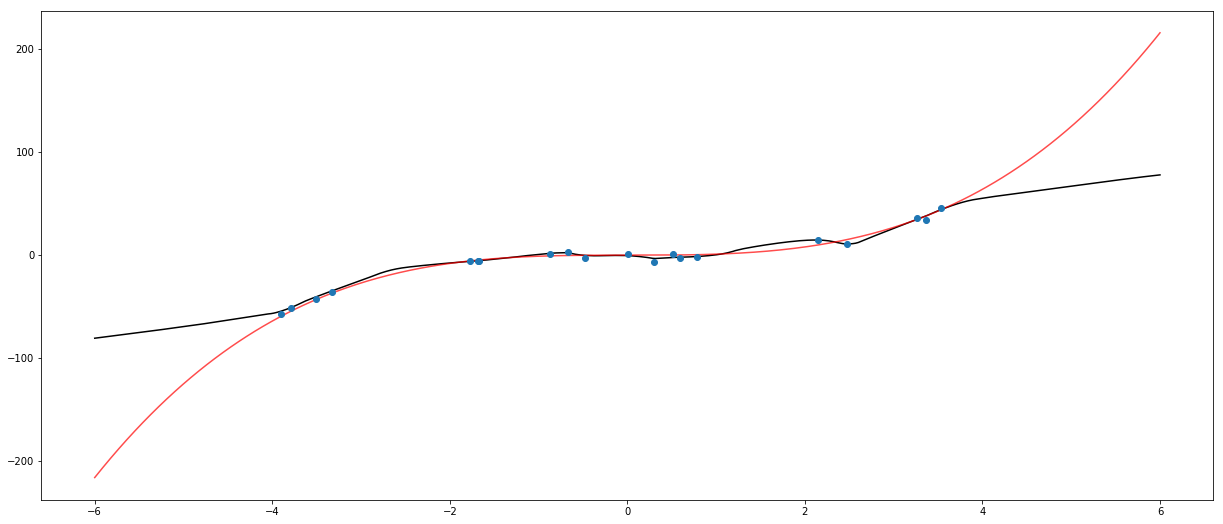

In [16]:
plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(prediction_sgd.detach().numpy(),1),'black')
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')



### SGLD

In [42]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import sgld

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1.
lr = 1e-6


batch_size = 20
dataset_size = 20

network = Model()
criterion = nn.MSELoss(size_average=False)

# optim = sgld.optim.sgld(network, lr, lambda_, dataset_size)
optim = sgld.optim.sgld(network, lr, lambda_, batch_size, dataset_size)

losses_sgld = []
#test_rmse = []
#log_lik_sgld = []
predictions = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(10000):

    running_loss = 0
    
    network.zero_grad()
    output = network(x)
    loss = (1/(2*9)) * criterion(output, y)
    loss.backward()
    optim.step()

    losses_sgld.append(loss)


    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 300) & (t % 100 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions = torch.cat((predictions, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 564.8061
Epoch 1 - loss: 563.8796
Epoch 2 - loss: 563.4936
Epoch 3 - loss: 562.8026
Epoch 4 - loss: 562.1648
Epoch 5 - loss: 561.4957
Epoch 6 - loss: 560.8564
Epoch 7 - loss: 559.9852
Epoch 8 - loss: 559.3077
Epoch 9 - loss: 558.8832
Epoch 10 - loss: 558.1946
Epoch 11 - loss: 557.4103
Epoch 12 - loss: 556.8066
Epoch 13 - loss: 556.0516
Epoch 14 - loss: 555.6833
Epoch 15 - loss: 555.2160
Epoch 16 - loss: 554.7535
Epoch 17 - loss: 554.0993
Epoch 18 - loss: 553.1769
Epoch 19 - loss: 552.7032
Epoch 20 - loss: 552.4731
Epoch 21 - loss: 551.9243
Epoch 22 - loss: 551.3805
Epoch 23 - loss: 550.7962
Epoch 24 - loss: 550.1673
Epoch 25 - loss: 549.6800
Epoch 26 - loss: 549.2381
Epoch 27 - loss: 548.9089
Epoch 28 - loss: 548.1799
Epoch 29 - loss: 547.5352
Epoch 30 - loss: 547.0123
Epoch 31 - loss: 546.3365
Epoch 32 - loss: 545.8326
Epoch 33 - loss: 545.4177
Epoch 34 - loss: 544.8005
Epoch 35 - loss: 544.1151
Epoch 36 - loss: 543.4160
Epoch 37 - loss: 542.9419
Epoch 38 - loss: 542.0

Epoch 348 - loss: 265.6144
Epoch 349 - loss: 265.0319
Epoch 350 - loss: 264.7436
Epoch 351 - loss: 264.3484
Epoch 352 - loss: 264.0225
Epoch 353 - loss: 263.8834
Epoch 354 - loss: 263.5262
Epoch 355 - loss: 263.2151
Epoch 356 - loss: 262.8067
Epoch 357 - loss: 262.3981
Epoch 358 - loss: 262.1064
Epoch 359 - loss: 261.8431
Epoch 360 - loss: 261.5388
Epoch 361 - loss: 261.0737
Epoch 362 - loss: 260.5247
Epoch 363 - loss: 260.3655
Epoch 364 - loss: 260.1398
Epoch 365 - loss: 259.6687
Epoch 366 - loss: 259.2332
Epoch 367 - loss: 258.7661
Epoch 368 - loss: 258.3998
Epoch 369 - loss: 257.9360
Epoch 370 - loss: 257.6200
Epoch 371 - loss: 257.3151
Epoch 372 - loss: 256.8958
Epoch 373 - loss: 256.6705
Epoch 374 - loss: 256.3306
Epoch 375 - loss: 255.9103
Epoch 376 - loss: 255.6267
Epoch 377 - loss: 255.4181
Epoch 378 - loss: 255.0118
Epoch 379 - loss: 254.5980
Epoch 380 - loss: 254.2346
Epoch 381 - loss: 253.8598
Epoch 382 - loss: 253.6740
Epoch 383 - loss: 253.4597
Epoch 384 - loss: 253.2144
E

Epoch 669 - loss: 212.9804
Epoch 670 - loss: 213.0259
Epoch 671 - loss: 212.9333
Epoch 672 - loss: 212.9089
Epoch 673 - loss: 212.7850
Epoch 674 - loss: 212.6800
Epoch 675 - loss: 212.4778
Epoch 676 - loss: 212.3002
Epoch 677 - loss: 212.2181
Epoch 678 - loss: 212.0606
Epoch 679 - loss: 212.0085
Epoch 680 - loss: 211.8173
Epoch 681 - loss: 211.7159
Epoch 682 - loss: 211.6032
Epoch 683 - loss: 211.3869
Epoch 684 - loss: 211.1975
Epoch 685 - loss: 211.0126
Epoch 686 - loss: 210.8451
Epoch 687 - loss: 210.6937
Epoch 688 - loss: 210.5387
Epoch 689 - loss: 210.4737
Epoch 690 - loss: 210.4278
Epoch 691 - loss: 210.3558
Epoch 692 - loss: 210.2190
Epoch 693 - loss: 210.1129
Epoch 694 - loss: 210.1050
Epoch 695 - loss: 210.0689
Epoch 696 - loss: 209.8862
Epoch 697 - loss: 209.9144
Epoch 698 - loss: 209.8638
Epoch 699 - loss: 209.7702
Epoch 700 - loss: 209.5486
Epoch 701 - loss: 209.5064
Epoch 702 - loss: 209.2358
Epoch 703 - loss: 209.0689
Epoch 704 - loss: 209.0183
Epoch 705 - loss: 208.8523
E

Epoch 1041 - loss: 172.6786
Epoch 1042 - loss: 172.5504
Epoch 1043 - loss: 172.5051
Epoch 1044 - loss: 172.4018
Epoch 1045 - loss: 172.2859
Epoch 1046 - loss: 172.1320
Epoch 1047 - loss: 172.0614
Epoch 1048 - loss: 171.9249
Epoch 1049 - loss: 171.8558
Epoch 1050 - loss: 171.7102
Epoch 1051 - loss: 171.5282
Epoch 1052 - loss: 171.5391
Epoch 1053 - loss: 171.3484
Epoch 1054 - loss: 171.3250
Epoch 1055 - loss: 171.0903
Epoch 1056 - loss: 171.1347
Epoch 1057 - loss: 171.1873
Epoch 1058 - loss: 171.0924
Epoch 1059 - loss: 170.9864
Epoch 1060 - loss: 170.8534
Epoch 1061 - loss: 170.8181
Epoch 1062 - loss: 170.6669
Epoch 1063 - loss: 170.5139
Epoch 1064 - loss: 170.4410
Epoch 1065 - loss: 170.2588
Epoch 1066 - loss: 170.1332
Epoch 1067 - loss: 169.9909
Epoch 1068 - loss: 169.7596
Epoch 1069 - loss: 169.7617
Epoch 1070 - loss: 169.5539
Epoch 1071 - loss: 169.4334
Epoch 1072 - loss: 169.1513
Epoch 1073 - loss: 168.9230
Epoch 1074 - loss: 168.6900
Epoch 1075 - loss: 168.6262
Epoch 1076 - loss: 1

Epoch 1342 - loss: 134.9072
Epoch 1343 - loss: 134.7370
Epoch 1344 - loss: 134.5536
Epoch 1345 - loss: 134.3029
Epoch 1346 - loss: 134.2035
Epoch 1347 - loss: 134.1399
Epoch 1348 - loss: 133.9046
Epoch 1349 - loss: 133.7946
Epoch 1350 - loss: 133.7741
Epoch 1351 - loss: 133.6522
Epoch 1352 - loss: 133.5428
Epoch 1353 - loss: 133.3263
Epoch 1354 - loss: 133.2230
Epoch 1355 - loss: 133.0515
Epoch 1356 - loss: 132.9054
Epoch 1357 - loss: 132.6373
Epoch 1358 - loss: 132.5368
Epoch 1359 - loss: 132.2775
Epoch 1360 - loss: 132.2610
Epoch 1361 - loss: 132.0436
Epoch 1362 - loss: 131.9718
Epoch 1363 - loss: 131.7188
Epoch 1364 - loss: 131.5639
Epoch 1365 - loss: 131.3656
Epoch 1366 - loss: 131.2848
Epoch 1367 - loss: 131.2354
Epoch 1368 - loss: 131.1447
Epoch 1369 - loss: 131.0246
Epoch 1370 - loss: 130.9460
Epoch 1371 - loss: 130.7950
Epoch 1372 - loss: 130.6303
Epoch 1373 - loss: 130.4536
Epoch 1374 - loss: 130.1552
Epoch 1375 - loss: 129.9914
Epoch 1376 - loss: 129.9899
Epoch 1377 - loss: 1

Epoch 1714 - loss: 80.2304
Epoch 1715 - loss: 79.9763
Epoch 1716 - loss: 80.0165
Epoch 1717 - loss: 79.8452
Epoch 1718 - loss: 79.5791
Epoch 1719 - loss: 79.4969
Epoch 1720 - loss: 79.3427
Epoch 1721 - loss: 79.2454
Epoch 1722 - loss: 79.0909
Epoch 1723 - loss: 79.0260
Epoch 1724 - loss: 78.7331
Epoch 1725 - loss: 78.5884
Epoch 1726 - loss: 78.3989
Epoch 1727 - loss: 78.2229
Epoch 1728 - loss: 78.1164
Epoch 1729 - loss: 78.0340
Epoch 1730 - loss: 77.8309
Epoch 1731 - loss: 77.7765
Epoch 1732 - loss: 77.5345
Epoch 1733 - loss: 77.6420
Epoch 1734 - loss: 77.4880
Epoch 1735 - loss: 77.4239
Epoch 1736 - loss: 77.3651
Epoch 1737 - loss: 77.3086
Epoch 1738 - loss: 77.2728
Epoch 1739 - loss: 77.1591
Epoch 1740 - loss: 77.1357
Epoch 1741 - loss: 76.8847
Epoch 1742 - loss: 76.6653
Epoch 1743 - loss: 76.4453
Epoch 1744 - loss: 76.3087
Epoch 1745 - loss: 76.0167
Epoch 1746 - loss: 75.8327
Epoch 1747 - loss: 75.7270
Epoch 1748 - loss: 75.6147
Epoch 1749 - loss: 75.4705
Epoch 1750 - loss: 75.3385
E

Epoch 2099 - loss: 41.0610
Epoch 2100 - loss: 41.0751
Epoch 2101 - loss: 40.9845
Epoch 2102 - loss: 40.8994
Epoch 2103 - loss: 40.8939
Epoch 2104 - loss: 40.8002
Epoch 2105 - loss: 40.8169
Epoch 2106 - loss: 40.6587
Epoch 2107 - loss: 40.6459
Epoch 2108 - loss: 40.5661
Epoch 2109 - loss: 40.5222
Epoch 2110 - loss: 40.3572
Epoch 2111 - loss: 40.3365
Epoch 2112 - loss: 40.3181
Epoch 2113 - loss: 40.2727
Epoch 2114 - loss: 40.3363
Epoch 2115 - loss: 40.3395
Epoch 2116 - loss: 40.2344
Epoch 2117 - loss: 40.0634
Epoch 2118 - loss: 39.9266
Epoch 2119 - loss: 39.8823
Epoch 2120 - loss: 39.7770
Epoch 2121 - loss: 39.7766
Epoch 2122 - loss: 39.7352
Epoch 2123 - loss: 39.7063
Epoch 2124 - loss: 39.6523
Epoch 2125 - loss: 39.6123
Epoch 2126 - loss: 39.4997
Epoch 2127 - loss: 39.3599
Epoch 2128 - loss: 39.2433
Epoch 2129 - loss: 39.1209
Epoch 2130 - loss: 38.9790
Epoch 2131 - loss: 38.8515
Epoch 2132 - loss: 38.7532
Epoch 2133 - loss: 38.7206
Epoch 2134 - loss: 38.6818
Epoch 2135 - loss: 38.5803
E

Epoch 2483 - loss: 24.2868
Epoch 2484 - loss: 24.2553
Epoch 2485 - loss: 24.2807
Epoch 2486 - loss: 24.1617
Epoch 2487 - loss: 24.1179
Epoch 2488 - loss: 24.1332
Epoch 2489 - loss: 24.0467
Epoch 2490 - loss: 23.9984
Epoch 2491 - loss: 23.9757
Epoch 2492 - loss: 23.9296
Epoch 2493 - loss: 23.8876
Epoch 2494 - loss: 23.9556
Epoch 2495 - loss: 23.8585
Epoch 2496 - loss: 23.8607
Epoch 2497 - loss: 23.8110
Epoch 2498 - loss: 23.7515
Epoch 2499 - loss: 23.7541
Epoch 2500 - loss: 23.7227
Epoch 2501 - loss: 23.6805
Epoch 2502 - loss: 23.6766
Epoch 2503 - loss: 23.6047
Epoch 2504 - loss: 23.5786
Epoch 2505 - loss: 23.5348
Epoch 2506 - loss: 23.5000
Epoch 2507 - loss: 23.4927
Epoch 2508 - loss: 23.4715
Epoch 2509 - loss: 23.3899
Epoch 2510 - loss: 23.3584
Epoch 2511 - loss: 23.3203
Epoch 2512 - loss: 23.3316
Epoch 2513 - loss: 23.3404
Epoch 2514 - loss: 23.2742
Epoch 2515 - loss: 23.2383
Epoch 2516 - loss: 23.2055
Epoch 2517 - loss: 23.1034
Epoch 2518 - loss: 23.0956
Epoch 2519 - loss: 23.0691
E

Epoch 2812 - loss: 16.7225
Epoch 2813 - loss: 16.7702
Epoch 2814 - loss: 16.7540
Epoch 2815 - loss: 16.7522
Epoch 2816 - loss: 16.7399
Epoch 2817 - loss: 16.7068
Epoch 2818 - loss: 16.6539
Epoch 2819 - loss: 16.6499
Epoch 2820 - loss: 16.6481
Epoch 2821 - loss: 16.6191
Epoch 2822 - loss: 16.6700
Epoch 2823 - loss: 16.6196
Epoch 2824 - loss: 16.5914
Epoch 2825 - loss: 16.5405
Epoch 2826 - loss: 16.5528
Epoch 2827 - loss: 16.5183
Epoch 2828 - loss: 16.5098
Epoch 2829 - loss: 16.4646
Epoch 2830 - loss: 16.4971
Epoch 2831 - loss: 16.5096
Epoch 2832 - loss: 16.5059
Epoch 2833 - loss: 16.5085
Epoch 2834 - loss: 16.4844
Epoch 2835 - loss: 16.4973
Epoch 2836 - loss: 16.5095
Epoch 2837 - loss: 16.5155
Epoch 2838 - loss: 16.4937
Epoch 2839 - loss: 16.4532
Epoch 2840 - loss: 16.4826
Epoch 2841 - loss: 16.4651
Epoch 2842 - loss: 16.4736
Epoch 2843 - loss: 16.4193
Epoch 2844 - loss: 16.4248
Epoch 2845 - loss: 16.4299
Epoch 2846 - loss: 16.4054
Epoch 2847 - loss: 16.4079
Epoch 2848 - loss: 16.4541
E

Epoch 3126 - loss: 14.2344
Epoch 3127 - loss: 14.1938
Epoch 3128 - loss: 14.1795
Epoch 3129 - loss: 14.1739
Epoch 3130 - loss: 14.0947
Epoch 3131 - loss: 14.1013
Epoch 3132 - loss: 14.0876
Epoch 3133 - loss: 14.0890
Epoch 3134 - loss: 14.0694
Epoch 3135 - loss: 14.0955
Epoch 3136 - loss: 14.0720
Epoch 3137 - loss: 14.1199
Epoch 3138 - loss: 14.1417
Epoch 3139 - loss: 14.1343
Epoch 3140 - loss: 14.1435
Epoch 3141 - loss: 14.1710
Epoch 3142 - loss: 14.1633
Epoch 3143 - loss: 14.1590
Epoch 3144 - loss: 14.1731
Epoch 3145 - loss: 14.1200
Epoch 3146 - loss: 14.0719
Epoch 3147 - loss: 14.0751
Epoch 3148 - loss: 14.0484
Epoch 3149 - loss: 14.0426
Epoch 3150 - loss: 14.0444
Epoch 3151 - loss: 14.0270
Epoch 3152 - loss: 13.9911
Epoch 3153 - loss: 13.9432
Epoch 3154 - loss: 13.9465
Epoch 3155 - loss: 13.9281
Epoch 3156 - loss: 13.9280
Epoch 3157 - loss: 13.9034
Epoch 3158 - loss: 13.8760
Epoch 3159 - loss: 13.8563
Epoch 3160 - loss: 13.8577
Epoch 3161 - loss: 13.8575
Epoch 3162 - loss: 13.8357
E

Epoch 3449 - loss: 12.6098
Epoch 3450 - loss: 12.5979
Epoch 3451 - loss: 12.6203
Epoch 3452 - loss: 12.6586
Epoch 3453 - loss: 12.6806
Epoch 3454 - loss: 12.6737
Epoch 3455 - loss: 12.6433
Epoch 3456 - loss: 12.6787
Epoch 3457 - loss: 12.6582
Epoch 3458 - loss: 12.6453
Epoch 3459 - loss: 12.6636
Epoch 3460 - loss: 12.6750
Epoch 3461 - loss: 12.6534
Epoch 3462 - loss: 12.6134
Epoch 3463 - loss: 12.5982
Epoch 3464 - loss: 12.6259
Epoch 3465 - loss: 12.6377
Epoch 3466 - loss: 12.6322
Epoch 3467 - loss: 12.6676
Epoch 3468 - loss: 12.6383
Epoch 3469 - loss: 12.6076
Epoch 3470 - loss: 12.5823
Epoch 3471 - loss: 12.5824
Epoch 3472 - loss: 12.5589
Epoch 3473 - loss: 12.5280
Epoch 3474 - loss: 12.4936
Epoch 3475 - loss: 12.4672
Epoch 3476 - loss: 12.4616
Epoch 3477 - loss: 12.4548
Epoch 3478 - loss: 12.4472
Epoch 3479 - loss: 12.4454
Epoch 3480 - loss: 12.4475
Epoch 3481 - loss: 12.4396
Epoch 3482 - loss: 12.4625
Epoch 3483 - loss: 12.4462
Epoch 3484 - loss: 12.4160
Epoch 3485 - loss: 12.4232
E

Epoch 3799 - loss: 11.7036
Epoch 3800 - loss: 11.7158
Epoch 3801 - loss: 11.6943
Epoch 3802 - loss: 11.6927
Epoch 3803 - loss: 11.7286
Epoch 3804 - loss: 11.7000
Epoch 3805 - loss: 11.6681
Epoch 3806 - loss: 11.6593
Epoch 3807 - loss: 11.6725
Epoch 3808 - loss: 11.6889
Epoch 3809 - loss: 11.6815
Epoch 3810 - loss: 11.6773
Epoch 3811 - loss: 11.6509
Epoch 3812 - loss: 11.6767
Epoch 3813 - loss: 11.6725
Epoch 3814 - loss: 11.6758
Epoch 3815 - loss: 11.6507
Epoch 3816 - loss: 11.6676
Epoch 3817 - loss: 11.6727
Epoch 3818 - loss: 11.6804
Epoch 3819 - loss: 11.6643
Epoch 3820 - loss: 11.6721
Epoch 3821 - loss: 11.6698
Epoch 3822 - loss: 11.6419
Epoch 3823 - loss: 11.6549
Epoch 3824 - loss: 11.6307
Epoch 3825 - loss: 11.6169
Epoch 3826 - loss: 11.6201
Epoch 3827 - loss: 11.6520
Epoch 3828 - loss: 11.6428
Epoch 3829 - loss: 11.6333
Epoch 3830 - loss: 11.6189
Epoch 3831 - loss: 11.6196
Epoch 3832 - loss: 11.6100
Epoch 3833 - loss: 11.6143
Epoch 3834 - loss: 11.6208
Epoch 3835 - loss: 11.5994
E

Epoch 4159 - loss: 11.3539
Epoch 4160 - loss: 11.3701
Epoch 4161 - loss: 11.3779
Epoch 4162 - loss: 11.4021
Epoch 4163 - loss: 11.3537
Epoch 4164 - loss: 11.3964
Epoch 4165 - loss: 11.4014
Epoch 4166 - loss: 11.4088
Epoch 4167 - loss: 11.4052
Epoch 4168 - loss: 11.3916
Epoch 4169 - loss: 11.3949
Epoch 4170 - loss: 11.4135
Epoch 4171 - loss: 11.4305
Epoch 4172 - loss: 11.4108
Epoch 4173 - loss: 11.4312
Epoch 4174 - loss: 11.4461
Epoch 4175 - loss: 11.4290
Epoch 4176 - loss: 11.4450
Epoch 4177 - loss: 11.4431
Epoch 4178 - loss: 11.4440
Epoch 4179 - loss: 11.5056
Epoch 4180 - loss: 11.5212
Epoch 4181 - loss: 11.5554
Epoch 4182 - loss: 11.5403
Epoch 4183 - loss: 11.5194
Epoch 4184 - loss: 11.5356
Epoch 4185 - loss: 11.5010
Epoch 4186 - loss: 11.4941
Epoch 4187 - loss: 11.5022
Epoch 4188 - loss: 11.4976
Epoch 4189 - loss: 11.4878
Epoch 4190 - loss: 11.4799
Epoch 4191 - loss: 11.4668
Epoch 4192 - loss: 11.4593
Epoch 4193 - loss: 11.4389
Epoch 4194 - loss: 11.4203
Epoch 4195 - loss: 11.4086
E

Epoch 4465 - loss: 11.1287
Epoch 4466 - loss: 11.1230
Epoch 4467 - loss: 11.1079
Epoch 4468 - loss: 11.1113
Epoch 4469 - loss: 11.1150
Epoch 4470 - loss: 11.0945
Epoch 4471 - loss: 11.0881
Epoch 4472 - loss: 11.0898
Epoch 4473 - loss: 11.0663
Epoch 4474 - loss: 11.0594
Epoch 4475 - loss: 11.0823
Epoch 4476 - loss: 11.0590
Epoch 4477 - loss: 11.0600
Epoch 4478 - loss: 11.0677
Epoch 4479 - loss: 11.0441
Epoch 4480 - loss: 11.0316
Epoch 4481 - loss: 11.0190
Epoch 4482 - loss: 11.0243
Epoch 4483 - loss: 11.0208
Epoch 4484 - loss: 11.0266
Epoch 4485 - loss: 11.0286
Epoch 4486 - loss: 11.0473
Epoch 4487 - loss: 11.0511
Epoch 4488 - loss: 11.0517
Epoch 4489 - loss: 11.0479
Epoch 4490 - loss: 11.0423
Epoch 4491 - loss: 11.0520
Epoch 4492 - loss: 11.0501
Epoch 4493 - loss: 11.0493
Epoch 4494 - loss: 11.0396
Epoch 4495 - loss: 11.0396
Epoch 4496 - loss: 11.0361
Epoch 4497 - loss: 11.0254
Epoch 4498 - loss: 11.0412
Epoch 4499 - loss: 11.0416
Epoch 4500 - loss: 11.0508
Epoch 4501 - loss: 11.0584
E

Epoch 4782 - loss: 10.7874
Epoch 4783 - loss: 10.7757
Epoch 4784 - loss: 10.7570
Epoch 4785 - loss: 10.7546
Epoch 4786 - loss: 10.7667
Epoch 4787 - loss: 10.7605
Epoch 4788 - loss: 10.7380
Epoch 4789 - loss: 10.7389
Epoch 4790 - loss: 10.7415
Epoch 4791 - loss: 10.7308
Epoch 4792 - loss: 10.7524
Epoch 4793 - loss: 10.7417
Epoch 4794 - loss: 10.7458
Epoch 4795 - loss: 10.7176
Epoch 4796 - loss: 10.7065
Epoch 4797 - loss: 10.7206
Epoch 4798 - loss: 10.7286
Epoch 4799 - loss: 10.7136
Epoch 4800 - loss: 10.7184
Epoch 4801 - loss: 10.7090
Epoch 4802 - loss: 10.6957
Epoch 4803 - loss: 10.6976
Epoch 4804 - loss: 10.6878
Epoch 4805 - loss: 10.6940
Epoch 4806 - loss: 10.6905
Epoch 4807 - loss: 10.6953
Epoch 4808 - loss: 10.7034
Epoch 4809 - loss: 10.7002
Epoch 4810 - loss: 10.7043
Epoch 4811 - loss: 10.7125
Epoch 4812 - loss: 10.7272
Epoch 4813 - loss: 10.7220
Epoch 4814 - loss: 10.7193
Epoch 4815 - loss: 10.7115
Epoch 4816 - loss: 10.7305
Epoch 4817 - loss: 10.7186
Epoch 4818 - loss: 10.7018
E

Epoch 5099 - loss: 10.5520
Epoch 5100 - loss: 10.5274
Epoch 5101 - loss: 10.5267
Epoch 5102 - loss: 10.5390
Epoch 5103 - loss: 10.5439
Epoch 5104 - loss: 10.5489
Epoch 5105 - loss: 10.5646
Epoch 5106 - loss: 10.5659
Epoch 5107 - loss: 10.5900
Epoch 5108 - loss: 10.5874
Epoch 5109 - loss: 10.6023
Epoch 5110 - loss: 10.5601
Epoch 5111 - loss: 10.5440
Epoch 5112 - loss: 10.5417
Epoch 5113 - loss: 10.5382
Epoch 5114 - loss: 10.5406
Epoch 5115 - loss: 10.5506
Epoch 5116 - loss: 10.5440
Epoch 5117 - loss: 10.5383
Epoch 5118 - loss: 10.5420
Epoch 5119 - loss: 10.5458
Epoch 5120 - loss: 10.5488
Epoch 5121 - loss: 10.5431
Epoch 5122 - loss: 10.5492
Epoch 5123 - loss: 10.5472
Epoch 5124 - loss: 10.5542
Epoch 5125 - loss: 10.5498
Epoch 5126 - loss: 10.5624
Epoch 5127 - loss: 10.5806
Epoch 5128 - loss: 10.5647
Epoch 5129 - loss: 10.5598
Epoch 5130 - loss: 10.5610
Epoch 5131 - loss: 10.5812
Epoch 5132 - loss: 10.5815
Epoch 5133 - loss: 10.6037
Epoch 5134 - loss: 10.6088
Epoch 5135 - loss: 10.6116
E

Epoch 5404 - loss: 10.4903
Epoch 5405 - loss: 10.4850
Epoch 5406 - loss: 10.4957
Epoch 5407 - loss: 10.5234
Epoch 5408 - loss: 10.5145
Epoch 5409 - loss: 10.5378
Epoch 5410 - loss: 10.5345
Epoch 5411 - loss: 10.5231
Epoch 5412 - loss: 10.5493
Epoch 5413 - loss: 10.5705
Epoch 5414 - loss: 10.5507
Epoch 5415 - loss: 10.5493
Epoch 5416 - loss: 10.5435
Epoch 5417 - loss: 10.5292
Epoch 5418 - loss: 10.5124
Epoch 5419 - loss: 10.5214
Epoch 5420 - loss: 10.5022
Epoch 5421 - loss: 10.4970
Epoch 5422 - loss: 10.5098
Epoch 5423 - loss: 10.4923
Epoch 5424 - loss: 10.4701
Epoch 5425 - loss: 10.4655
Epoch 5426 - loss: 10.4655
Epoch 5427 - loss: 10.4689
Epoch 5428 - loss: 10.4763
Epoch 5429 - loss: 10.4677
Epoch 5430 - loss: 10.4738
Epoch 5431 - loss: 10.4604
Epoch 5432 - loss: 10.4444
Epoch 5433 - loss: 10.4530
Epoch 5434 - loss: 10.4532
Epoch 5435 - loss: 10.4481
Epoch 5436 - loss: 10.4471
Epoch 5437 - loss: 10.4529
Epoch 5438 - loss: 10.4440
Epoch 5439 - loss: 10.4363
Epoch 5440 - loss: 10.4363
E

Epoch 5725 - loss: 10.2017
Epoch 5726 - loss: 10.2080
Epoch 5727 - loss: 10.2080
Epoch 5728 - loss: 10.2201
Epoch 5729 - loss: 10.2126
Epoch 5730 - loss: 10.1918
Epoch 5731 - loss: 10.1918
Epoch 5732 - loss: 10.1991
Epoch 5733 - loss: 10.1987
Epoch 5734 - loss: 10.1919
Epoch 5735 - loss: 10.1886
Epoch 5736 - loss: 10.1867
Epoch 5737 - loss: 10.1910
Epoch 5738 - loss: 10.1906
Epoch 5739 - loss: 10.1911
Epoch 5740 - loss: 10.1984
Epoch 5741 - loss: 10.1968
Epoch 5742 - loss: 10.1968
Epoch 5743 - loss: 10.1979
Epoch 5744 - loss: 10.2047
Epoch 5745 - loss: 10.2109
Epoch 5746 - loss: 10.2155
Epoch 5747 - loss: 10.1986
Epoch 5748 - loss: 10.1876
Epoch 5749 - loss: 10.1777
Epoch 5750 - loss: 10.1815
Epoch 5751 - loss: 10.1756
Epoch 5752 - loss: 10.1754
Epoch 5753 - loss: 10.1705
Epoch 5754 - loss: 10.1677
Epoch 5755 - loss: 10.1747
Epoch 5756 - loss: 10.2035
Epoch 5757 - loss: 10.2228
Epoch 5758 - loss: 10.2425
Epoch 5759 - loss: 10.2371
Epoch 5760 - loss: 10.2414
Epoch 5761 - loss: 10.2591
E

Epoch 6036 - loss: 10.2188
Epoch 6037 - loss: 10.2208
Epoch 6038 - loss: 10.2219
Epoch 6039 - loss: 10.2204
Epoch 6040 - loss: 10.2125
Epoch 6041 - loss: 10.2122
Epoch 6042 - loss: 10.2038
Epoch 6043 - loss: 10.2044
Epoch 6044 - loss: 10.1902
Epoch 6045 - loss: 10.2044
Epoch 6046 - loss: 10.2091
Epoch 6047 - loss: 10.1905
Epoch 6048 - loss: 10.1737
Epoch 6049 - loss: 10.1663
Epoch 6050 - loss: 10.1516
Epoch 6051 - loss: 10.1332
Epoch 6052 - loss: 10.1387
Epoch 6053 - loss: 10.1327
Epoch 6054 - loss: 10.1169
Epoch 6055 - loss: 10.1151
Epoch 6056 - loss: 10.1338
Epoch 6057 - loss: 10.1545
Epoch 6058 - loss: 10.1360
Epoch 6059 - loss: 10.1432
Epoch 6060 - loss: 10.1474
Epoch 6061 - loss: 10.1508
Epoch 6062 - loss: 10.1518
Epoch 6063 - loss: 10.1330
Epoch 6064 - loss: 10.1307
Epoch 6065 - loss: 10.1348
Epoch 6066 - loss: 10.1048
Epoch 6067 - loss: 10.1038
Epoch 6068 - loss: 10.1123
Epoch 6069 - loss: 10.1262
Epoch 6070 - loss: 10.1401
Epoch 6071 - loss: 10.1343
Epoch 6072 - loss: 10.1403
E

Epoch 6394 - loss: 10.2305
Epoch 6395 - loss: 10.2461
Epoch 6396 - loss: 10.2397
Epoch 6397 - loss: 10.2358
Epoch 6398 - loss: 10.2237
Epoch 6399 - loss: 10.2355
Epoch 6400 - loss: 10.2397
Epoch 6401 - loss: 10.2501
Epoch 6402 - loss: 10.2564
Epoch 6403 - loss: 10.2723
Epoch 6404 - loss: 10.2707
Epoch 6405 - loss: 10.2565
Epoch 6406 - loss: 10.2557
Epoch 6407 - loss: 10.2443
Epoch 6408 - loss: 10.2505
Epoch 6409 - loss: 10.2585
Epoch 6410 - loss: 10.2621
Epoch 6411 - loss: 10.2828
Epoch 6412 - loss: 10.2833
Epoch 6413 - loss: 10.3074
Epoch 6414 - loss: 10.3076
Epoch 6415 - loss: 10.2914
Epoch 6416 - loss: 10.2899
Epoch 6417 - loss: 10.2923
Epoch 6418 - loss: 10.2676
Epoch 6419 - loss: 10.2709
Epoch 6420 - loss: 10.2640
Epoch 6421 - loss: 10.2661
Epoch 6422 - loss: 10.2737
Epoch 6423 - loss: 10.2784
Epoch 6424 - loss: 10.2793
Epoch 6425 - loss: 10.2834
Epoch 6426 - loss: 10.2920
Epoch 6427 - loss: 10.3040
Epoch 6428 - loss: 10.2913
Epoch 6429 - loss: 10.2867
Epoch 6430 - loss: 10.2996
E

Epoch 6710 - loss: 10.2601
Epoch 6711 - loss: 10.2914
Epoch 6712 - loss: 10.2645
Epoch 6713 - loss: 10.2458
Epoch 6714 - loss: 10.2604
Epoch 6715 - loss: 10.2450
Epoch 6716 - loss: 10.2205
Epoch 6717 - loss: 10.2517
Epoch 6718 - loss: 10.2537
Epoch 6719 - loss: 10.2501
Epoch 6720 - loss: 10.2646
Epoch 6721 - loss: 10.3351
Epoch 6722 - loss: 10.3144
Epoch 6723 - loss: 10.3054
Epoch 6724 - loss: 10.2778
Epoch 6725 - loss: 10.2710
Epoch 6726 - loss: 10.2383
Epoch 6727 - loss: 10.2263
Epoch 6728 - loss: 10.2400
Epoch 6729 - loss: 10.2255
Epoch 6730 - loss: 10.2165
Epoch 6731 - loss: 10.2109
Epoch 6732 - loss: 10.2045
Epoch 6733 - loss: 10.1993
Epoch 6734 - loss: 10.1975
Epoch 6735 - loss: 10.2012
Epoch 6736 - loss: 10.1826
Epoch 6737 - loss: 10.1860
Epoch 6738 - loss: 10.1772
Epoch 6739 - loss: 10.1994
Epoch 6740 - loss: 10.2018
Epoch 6741 - loss: 10.1921
Epoch 6742 - loss: 10.1951
Epoch 6743 - loss: 10.1980
Epoch 6744 - loss: 10.1960
Epoch 6745 - loss: 10.1969
Epoch 6746 - loss: 10.1811
E

Epoch 7043 - loss: 10.3164
Epoch 7044 - loss: 10.3089
Epoch 7045 - loss: 10.3071
Epoch 7046 - loss: 10.3116
Epoch 7047 - loss: 10.3246
Epoch 7048 - loss: 10.3367
Epoch 7049 - loss: 10.3504
Epoch 7050 - loss: 10.3399
Epoch 7051 - loss: 10.3214
Epoch 7052 - loss: 10.3352
Epoch 7053 - loss: 10.3371
Epoch 7054 - loss: 10.3314
Epoch 7055 - loss: 10.3478
Epoch 7056 - loss: 10.3332
Epoch 7057 - loss: 10.3283
Epoch 7058 - loss: 10.3239
Epoch 7059 - loss: 10.3210
Epoch 7060 - loss: 10.3253
Epoch 7061 - loss: 10.3427
Epoch 7062 - loss: 10.3302
Epoch 7063 - loss: 10.3149
Epoch 7064 - loss: 10.3202
Epoch 7065 - loss: 10.3151
Epoch 7066 - loss: 10.3143
Epoch 7067 - loss: 10.3116
Epoch 7068 - loss: 10.2996
Epoch 7069 - loss: 10.3097
Epoch 7070 - loss: 10.3141
Epoch 7071 - loss: 10.2984
Epoch 7072 - loss: 10.2946
Epoch 7073 - loss: 10.2988
Epoch 7074 - loss: 10.2922
Epoch 7075 - loss: 10.2763
Epoch 7076 - loss: 10.2813
Epoch 7077 - loss: 10.2861
Epoch 7078 - loss: 10.2855
Epoch 7079 - loss: 10.2898
E

Epoch 7367 - loss: 10.2096
Epoch 7368 - loss: 10.2199
Epoch 7369 - loss: 10.2298
Epoch 7370 - loss: 10.2415
Epoch 7371 - loss: 10.2194
Epoch 7372 - loss: 10.2027
Epoch 7373 - loss: 10.1965
Epoch 7374 - loss: 10.1880
Epoch 7375 - loss: 10.1778
Epoch 7376 - loss: 10.1762
Epoch 7377 - loss: 10.1948
Epoch 7378 - loss: 10.2186
Epoch 7379 - loss: 10.1992
Epoch 7380 - loss: 10.1919
Epoch 7381 - loss: 10.1761
Epoch 7382 - loss: 10.1787
Epoch 7383 - loss: 10.1646
Epoch 7384 - loss: 10.1579
Epoch 7385 - loss: 10.1746
Epoch 7386 - loss: 10.1666
Epoch 7387 - loss: 10.1635
Epoch 7388 - loss: 10.1667
Epoch 7389 - loss: 10.1899
Epoch 7390 - loss: 10.1858
Epoch 7391 - loss: 10.1893
Epoch 7392 - loss: 10.1776
Epoch 7393 - loss: 10.1843
Epoch 7394 - loss: 10.1875
Epoch 7395 - loss: 10.1819
Epoch 7396 - loss: 10.1886
Epoch 7397 - loss: 10.1921
Epoch 7398 - loss: 10.1907
Epoch 7399 - loss: 10.1872
Epoch 7400 - loss: 10.1761
Epoch 7401 - loss: 10.1744
Epoch 7402 - loss: 10.1734
Epoch 7403 - loss: 10.1734
E

Epoch 7689 - loss: 10.2484
Epoch 7690 - loss: 10.2988
Epoch 7691 - loss: 10.3148
Epoch 7692 - loss: 10.3105
Epoch 7693 - loss: 10.3190
Epoch 7694 - loss: 10.3658
Epoch 7695 - loss: 10.3236
Epoch 7696 - loss: 10.3312
Epoch 7697 - loss: 10.3272
Epoch 7698 - loss: 10.3636
Epoch 7699 - loss: 10.2911
Epoch 7700 - loss: 10.2492
Epoch 7701 - loss: 10.2087
Epoch 7702 - loss: 10.1820
Epoch 7703 - loss: 10.1702
Epoch 7704 - loss: 10.1866
Epoch 7705 - loss: 10.1579
Epoch 7706 - loss: 10.1829
Epoch 7707 - loss: 10.1662
Epoch 7708 - loss: 10.1251
Epoch 7709 - loss: 10.1243
Epoch 7710 - loss: 10.1232
Epoch 7711 - loss: 10.1326
Epoch 7712 - loss: 10.1352
Epoch 7713 - loss: 10.1422
Epoch 7714 - loss: 10.1451
Epoch 7715 - loss: 10.1455
Epoch 7716 - loss: 10.1554
Epoch 7717 - loss: 10.1342
Epoch 7718 - loss: 10.1402
Epoch 7719 - loss: 10.1374
Epoch 7720 - loss: 10.1230
Epoch 7721 - loss: 10.1190
Epoch 7722 - loss: 10.1191
Epoch 7723 - loss: 10.1282
Epoch 7724 - loss: 10.1336
Epoch 7725 - loss: 10.1261
E

Epoch 8052 - loss: 10.0212
Epoch 8053 - loss: 10.0214
Epoch 8054 - loss: 10.0277
Epoch 8055 - loss: 10.0251
Epoch 8056 - loss: 10.0295
Epoch 8057 - loss: 10.0292
Epoch 8058 - loss: 10.0325
Epoch 8059 - loss: 10.0359
Epoch 8060 - loss: 10.0360
Epoch 8061 - loss: 10.0406
Epoch 8062 - loss: 10.0410
Epoch 8063 - loss: 10.0334
Epoch 8064 - loss: 10.0338
Epoch 8065 - loss: 10.0455
Epoch 8066 - loss: 10.0318
Epoch 8067 - loss: 10.0347
Epoch 8068 - loss: 10.0339
Epoch 8069 - loss: 10.0327
Epoch 8070 - loss: 10.0458
Epoch 8071 - loss: 10.0429
Epoch 8072 - loss: 10.0486
Epoch 8073 - loss: 10.0397
Epoch 8074 - loss: 10.0339
Epoch 8075 - loss: 10.0290
Epoch 8076 - loss: 10.0328
Epoch 8077 - loss: 10.0326
Epoch 8078 - loss: 10.0369
Epoch 8079 - loss: 10.0353
Epoch 8080 - loss: 10.0400
Epoch 8081 - loss: 10.0313
Epoch 8082 - loss: 10.0282
Epoch 8083 - loss: 10.0306
Epoch 8084 - loss: 10.0319
Epoch 8085 - loss: 10.0361
Epoch 8086 - loss: 10.0257
Epoch 8087 - loss: 10.0237
Epoch 8088 - loss: 10.0180
E

Epoch 8361 - loss: 10.0738
Epoch 8362 - loss: 10.0633
Epoch 8363 - loss: 10.0704
Epoch 8364 - loss: 10.0407
Epoch 8365 - loss: 10.0530
Epoch 8366 - loss: 10.0524
Epoch 8367 - loss: 10.0211
Epoch 8368 - loss: 10.0018
Epoch 8369 - loss: 10.0006
Epoch 8370 - loss: 10.0065
Epoch 8371 - loss: 10.0062
Epoch 8372 - loss: 9.9982
Epoch 8373 - loss: 10.0035
Epoch 8374 - loss: 10.0185
Epoch 8375 - loss: 10.0120
Epoch 8376 - loss: 10.0235
Epoch 8377 - loss: 10.0103
Epoch 8378 - loss: 9.9984
Epoch 8379 - loss: 10.0007
Epoch 8380 - loss: 9.9938
Epoch 8381 - loss: 10.0063
Epoch 8382 - loss: 10.0053
Epoch 8383 - loss: 10.0116
Epoch 8384 - loss: 10.0198
Epoch 8385 - loss: 10.0188
Epoch 8386 - loss: 10.0315
Epoch 8387 - loss: 10.0257
Epoch 8388 - loss: 10.0297
Epoch 8389 - loss: 10.0248
Epoch 8390 - loss: 10.0202
Epoch 8391 - loss: 10.0256
Epoch 8392 - loss: 10.0229
Epoch 8393 - loss: 10.0473
Epoch 8394 - loss: 10.0505
Epoch 8395 - loss: 10.0539
Epoch 8396 - loss: 10.0321
Epoch 8397 - loss: 10.0485
Epoc

Epoch 8740 - loss: 10.0808
Epoch 8741 - loss: 10.0821
Epoch 8742 - loss: 10.0857
Epoch 8743 - loss: 10.0838
Epoch 8744 - loss: 10.0911
Epoch 8745 - loss: 10.0986
Epoch 8746 - loss: 10.1043
Epoch 8747 - loss: 10.1199
Epoch 8748 - loss: 10.1113
Epoch 8749 - loss: 10.1055
Epoch 8750 - loss: 10.0972
Epoch 8751 - loss: 10.0872
Epoch 8752 - loss: 10.1014
Epoch 8753 - loss: 10.1092
Epoch 8754 - loss: 10.1159
Epoch 8755 - loss: 10.1177
Epoch 8756 - loss: 10.1210
Epoch 8757 - loss: 10.1132
Epoch 8758 - loss: 10.1156
Epoch 8759 - loss: 10.1174
Epoch 8760 - loss: 10.1085
Epoch 8761 - loss: 10.1159
Epoch 8762 - loss: 10.1103
Epoch 8763 - loss: 10.1026
Epoch 8764 - loss: 10.1111
Epoch 8765 - loss: 10.1233
Epoch 8766 - loss: 10.1276
Epoch 8767 - loss: 10.1345
Epoch 8768 - loss: 10.1496
Epoch 8769 - loss: 10.1404
Epoch 8770 - loss: 10.1372
Epoch 8771 - loss: 10.1206
Epoch 8772 - loss: 10.1229
Epoch 8773 - loss: 10.1096
Epoch 8774 - loss: 10.1207
Epoch 8775 - loss: 10.0932
Epoch 8776 - loss: 10.0854
E

Epoch 9075 - loss: 10.1263
Epoch 9076 - loss: 10.1607
Epoch 9077 - loss: 10.1819
Epoch 9078 - loss: 10.1815
Epoch 9079 - loss: 10.1901
Epoch 9080 - loss: 10.2076
Epoch 9081 - loss: 10.1954
Epoch 9082 - loss: 10.2057
Epoch 9083 - loss: 10.1821
Epoch 9084 - loss: 10.1320
Epoch 9085 - loss: 10.1378
Epoch 9086 - loss: 10.1483
Epoch 9087 - loss: 10.1477
Epoch 9088 - loss: 10.1483
Epoch 9089 - loss: 10.1477
Epoch 9090 - loss: 10.1690
Epoch 9091 - loss: 10.1688
Epoch 9092 - loss: 10.1613
Epoch 9093 - loss: 10.1435
Epoch 9094 - loss: 10.1676
Epoch 9095 - loss: 10.1846
Epoch 9096 - loss: 10.1341
Epoch 9097 - loss: 10.1288
Epoch 9098 - loss: 10.1319
Epoch 9099 - loss: 10.1322
Epoch 9100 - loss: 10.1278
Epoch 9101 - loss: 10.1140
Epoch 9102 - loss: 10.1165
Epoch 9103 - loss: 10.1171
Epoch 9104 - loss: 10.1205
Epoch 9105 - loss: 10.1172
Epoch 9106 - loss: 10.1113
Epoch 9107 - loss: 10.1144
Epoch 9108 - loss: 10.1138
Epoch 9109 - loss: 10.1328
Epoch 9110 - loss: 10.1203
Epoch 9111 - loss: 10.1220
E

Epoch 9380 - loss: 10.0880
Epoch 9381 - loss: 10.0726
Epoch 9382 - loss: 10.0810
Epoch 9383 - loss: 10.0876
Epoch 9384 - loss: 10.0766
Epoch 9385 - loss: 10.0909
Epoch 9386 - loss: 10.0922
Epoch 9387 - loss: 10.0842
Epoch 9388 - loss: 10.0778
Epoch 9389 - loss: 10.0621
Epoch 9390 - loss: 10.0544
Epoch 9391 - loss: 10.0599
Epoch 9392 - loss: 10.0632
Epoch 9393 - loss: 10.0556
Epoch 9394 - loss: 10.0473
Epoch 9395 - loss: 10.0345
Epoch 9396 - loss: 10.0332
Epoch 9397 - loss: 10.0348
Epoch 9398 - loss: 10.0195
Epoch 9399 - loss: 10.0403
Epoch 9400 - loss: 10.0440
Epoch 9401 - loss: 10.0328
Epoch 9402 - loss: 10.0269
Epoch 9403 - loss: 10.0232
Epoch 9404 - loss: 10.0501
Epoch 9405 - loss: 10.0593
Epoch 9406 - loss: 10.0823
Epoch 9407 - loss: 10.0631
Epoch 9408 - loss: 10.0729
Epoch 9409 - loss: 10.0856
Epoch 9410 - loss: 10.0820
Epoch 9411 - loss: 10.0855
Epoch 9412 - loss: 10.0954
Epoch 9413 - loss: 10.1085
Epoch 9414 - loss: 10.0684
Epoch 9415 - loss: 10.0802
Epoch 9416 - loss: 10.0946
E

Epoch 9709 - loss: 9.9911
Epoch 9710 - loss: 9.9873
Epoch 9711 - loss: 9.9816
Epoch 9712 - loss: 9.9809
Epoch 9713 - loss: 9.9758
Epoch 9714 - loss: 9.9779
Epoch 9715 - loss: 9.9868
Epoch 9716 - loss: 9.9868
Epoch 9717 - loss: 9.9793
Epoch 9718 - loss: 9.9960
Epoch 9719 - loss: 9.9977
Epoch 9720 - loss: 9.9913
Epoch 9721 - loss: 9.9849
Epoch 9722 - loss: 9.9770
Epoch 9723 - loss: 9.9759
Epoch 9724 - loss: 9.9731
Epoch 9725 - loss: 9.9816
Epoch 9726 - loss: 9.9868
Epoch 9727 - loss: 9.9785
Epoch 9728 - loss: 9.9842
Epoch 9729 - loss: 9.9718
Epoch 9730 - loss: 9.9798
Epoch 9731 - loss: 9.9816
Epoch 9732 - loss: 9.9811
Epoch 9733 - loss: 9.9686
Epoch 9734 - loss: 9.9703
Epoch 9735 - loss: 9.9597
Epoch 9736 - loss: 9.9745
Epoch 9737 - loss: 9.9944
Epoch 9738 - loss: 9.9735
Epoch 9739 - loss: 9.9819
Epoch 9740 - loss: 9.9840
Epoch 9741 - loss: 9.9807
Epoch 9742 - loss: 9.9591
Epoch 9743 - loss: 9.9504
Epoch 9744 - loss: 9.9468
Epoch 9745 - loss: 9.9531
Epoch 9746 - loss: 9.9482
Epoch 9747 -

(-90, 90)

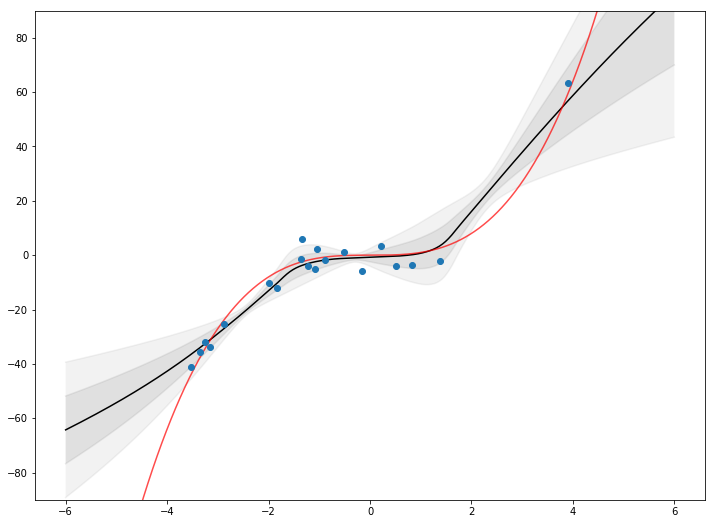

In [43]:
upper1 = np.mean(predictions[:,1:].detach().numpy(),1) + np.std(predictions[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions[:,1:].detach().numpy(),1) + 2 * np.std(predictions[:,1:].detach().numpy(),1)
upper3 = np.mean(predictions[:,1:].detach().numpy(),1) + 3 * np.std(predictions[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions[:,1:].detach().numpy(),1) - np.std(predictions[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions[:,1:].detach().numpy(),1) - 2 * np.std(predictions[:,1:].detach().numpy(),1)
lower3 = np.mean(predictions[:,1:].detach().numpy(),1) - 3 * np.std(predictions[:,1:].detach().numpy(),1)


plt.figure(figsize=(12,9))
plt.plot(grid,np.mean(predictions[:,1:].detach().numpy(),1),'black')
# plt.plot(grid,upper3,'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.15)
plt.plot(grid,lower2,'gray',alpha=0.1)
# plt.plot(grid,lower3,'black')
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-90,90)

### pSGLD

In [44]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import psgld




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1.
lr = 1e-12
alpha = 0.99


batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=False)

optim = psgld.optim.psgld(network, lr, lambda_, alpha, batch_size, dataset_size)


predictions_psgld = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(10000):

    running_loss = 0

    
    network.zero_grad()
    output = network(x)
    loss = (1./(2*9))*criterion(output, y)
    loss.backward()
    optim.step()



    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 300) & (t % 100 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions_psgld = torch.cat((predictions_psgld, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 560.3252
Epoch 1 - loss: 511.5685
Epoch 2 - loss: 465.0114
Epoch 3 - loss: 415.5981
Epoch 4 - loss: 354.5988
Epoch 5 - loss: 306.7764
Epoch 6 - loss: 273.5796
Epoch 7 - loss: 255.2815
Epoch 8 - loss: 246.0257
Epoch 9 - loss: 239.4917
Epoch 10 - loss: 233.0852
Epoch 11 - loss: 226.2796
Epoch 12 - loss: 219.5571
Epoch 13 - loss: 212.5530
Epoch 14 - loss: 206.2424
Epoch 15 - loss: 200.4163
Epoch 16 - loss: 195.2528
Epoch 17 - loss: 188.9823
Epoch 18 - loss: 182.6789
Epoch 19 - loss: 176.7659
Epoch 20 - loss: 168.5546
Epoch 21 - loss: 160.8895
Epoch 22 - loss: 153.9246
Epoch 23 - loss: 147.7682
Epoch 24 - loss: 140.6297
Epoch 25 - loss: 133.0058
Epoch 26 - loss: 125.3371
Epoch 27 - loss: 117.3988
Epoch 28 - loss: 109.7228
Epoch 29 - loss: 102.5331
Epoch 30 - loss: 94.6704
Epoch 31 - loss: 85.4019
Epoch 32 - loss: 78.2327
Epoch 33 - loss: 73.1363
Epoch 34 - loss: 67.9774
Epoch 35 - loss: 62.2144
Epoch 36 - loss: 56.3801
Epoch 37 - loss: 52.4531
Epoch 38 - loss: 50.2853
Epoch

Epoch 339 - loss: 10.1604
Epoch 340 - loss: 10.0263
Epoch 341 - loss: 9.8400
Epoch 342 - loss: 9.9446
Epoch 343 - loss: 9.8632
Epoch 344 - loss: 10.0252
Epoch 345 - loss: 10.1183
Epoch 346 - loss: 10.2012
Epoch 347 - loss: 11.8495
Epoch 348 - loss: 10.8749
Epoch 349 - loss: 11.0854
Epoch 350 - loss: 10.7669
Epoch 351 - loss: 11.9978
Epoch 352 - loss: 12.7264
Epoch 353 - loss: 13.5636
Epoch 354 - loss: 14.0598
Epoch 355 - loss: 14.3691
Epoch 356 - loss: 13.7463
Epoch 357 - loss: 12.1955
Epoch 358 - loss: 12.1283
Epoch 359 - loss: 11.8832
Epoch 360 - loss: 12.1263
Epoch 361 - loss: 13.2939
Epoch 362 - loss: 13.6486
Epoch 363 - loss: 16.1919
Epoch 364 - loss: 12.8552
Epoch 365 - loss: 12.7033
Epoch 366 - loss: 13.2352
Epoch 367 - loss: 15.7953
Epoch 368 - loss: 16.3663
Epoch 369 - loss: 14.8975
Epoch 370 - loss: 15.2729
Epoch 371 - loss: 15.7090
Epoch 372 - loss: 14.7993
Epoch 373 - loss: 14.5152
Epoch 374 - loss: 14.2966
Epoch 375 - loss: 15.4956
Epoch 376 - loss: 15.0116
Epoch 377 - los

Epoch 684 - loss: 12.0114
Epoch 685 - loss: 12.6757
Epoch 686 - loss: 13.2149
Epoch 687 - loss: 15.9573
Epoch 688 - loss: 22.6477
Epoch 689 - loss: 27.2736
Epoch 690 - loss: 45.2936
Epoch 691 - loss: 42.9476
Epoch 692 - loss: 65.2480
Epoch 693 - loss: 37.1144
Epoch 694 - loss: 41.7900
Epoch 695 - loss: 29.9058
Epoch 696 - loss: 27.1532
Epoch 697 - loss: 16.4663
Epoch 698 - loss: 16.3902
Epoch 699 - loss: 12.5805
Epoch 700 - loss: 12.1289
Epoch 701 - loss: 11.5424
Epoch 702 - loss: 11.2112
Epoch 703 - loss: 10.7066
Epoch 704 - loss: 10.2443
Epoch 705 - loss: 9.9531
Epoch 706 - loss: 10.4888
Epoch 707 - loss: 10.3323
Epoch 708 - loss: 10.7148
Epoch 709 - loss: 10.0368
Epoch 710 - loss: 10.1881
Epoch 711 - loss: 9.9487
Epoch 712 - loss: 10.2251
Epoch 713 - loss: 10.1155
Epoch 714 - loss: 9.9736
Epoch 715 - loss: 10.3941
Epoch 716 - loss: 10.1776
Epoch 717 - loss: 10.6566
Epoch 718 - loss: 10.6602
Epoch 719 - loss: 10.3989
Epoch 720 - loss: 10.0820
Epoch 721 - loss: 11.1124
Epoch 722 - los

Epoch 1051 - loss: 11.6498
Epoch 1052 - loss: 10.5217
Epoch 1053 - loss: 10.4177
Epoch 1054 - loss: 9.9318
Epoch 1055 - loss: 9.9928
Epoch 1056 - loss: 9.9280
Epoch 1057 - loss: 9.9391
Epoch 1058 - loss: 10.6390
Epoch 1059 - loss: 10.7117
Epoch 1060 - loss: 12.0261
Epoch 1061 - loss: 13.9087
Epoch 1062 - loss: 15.9779
Epoch 1063 - loss: 17.0707
Epoch 1064 - loss: 19.9128
Epoch 1065 - loss: 22.5929
Epoch 1066 - loss: 27.7890
Epoch 1067 - loss: 21.3486
Epoch 1068 - loss: 23.9128
Epoch 1069 - loss: 18.8098
Epoch 1070 - loss: 18.1132
Epoch 1071 - loss: 15.9165
Epoch 1072 - loss: 17.3763
Epoch 1073 - loss: 21.3302
Epoch 1074 - loss: 23.6819
Epoch 1075 - loss: 21.4062
Epoch 1076 - loss: 23.4454
Epoch 1077 - loss: 21.9451
Epoch 1078 - loss: 23.2568
Epoch 1079 - loss: 19.7418
Epoch 1080 - loss: 19.3986
Epoch 1081 - loss: 17.8409
Epoch 1082 - loss: 17.8443
Epoch 1083 - loss: 18.2909
Epoch 1084 - loss: 17.8880
Epoch 1085 - loss: 19.2384
Epoch 1086 - loss: 22.1813
Epoch 1087 - loss: 24.8822
Epoch

Epoch 1383 - loss: 14.1476
Epoch 1384 - loss: 15.3530
Epoch 1385 - loss: 15.0707
Epoch 1386 - loss: 18.4568
Epoch 1387 - loss: 16.4049
Epoch 1388 - loss: 17.3718
Epoch 1389 - loss: 17.8869
Epoch 1390 - loss: 19.9334
Epoch 1391 - loss: 15.7617
Epoch 1392 - loss: 18.3085
Epoch 1393 - loss: 17.3710
Epoch 1394 - loss: 20.9428
Epoch 1395 - loss: 19.5684
Epoch 1396 - loss: 21.0182
Epoch 1397 - loss: 16.7100
Epoch 1398 - loss: 17.5546
Epoch 1399 - loss: 17.6544
Epoch 1400 - loss: 17.5670
Epoch 1401 - loss: 23.9740
Epoch 1402 - loss: 29.0616
Epoch 1403 - loss: 22.6932
Epoch 1404 - loss: 22.1824
Epoch 1405 - loss: 15.9796
Epoch 1406 - loss: 16.0323
Epoch 1407 - loss: 15.4778
Epoch 1408 - loss: 16.1722
Epoch 1409 - loss: 13.6383
Epoch 1410 - loss: 14.4200
Epoch 1411 - loss: 12.0180
Epoch 1412 - loss: 12.7569
Epoch 1413 - loss: 11.7756
Epoch 1414 - loss: 11.8358
Epoch 1415 - loss: 11.7354
Epoch 1416 - loss: 12.4554
Epoch 1417 - loss: 12.0738
Epoch 1418 - loss: 11.9834
Epoch 1419 - loss: 11.2545
E

Epoch 1761 - loss: 17.1939
Epoch 1762 - loss: 14.2863
Epoch 1763 - loss: 15.3260
Epoch 1764 - loss: 12.8308
Epoch 1765 - loss: 11.5162
Epoch 1766 - loss: 11.4464
Epoch 1767 - loss: 11.6327
Epoch 1768 - loss: 11.3203
Epoch 1769 - loss: 11.9276
Epoch 1770 - loss: 11.7547
Epoch 1771 - loss: 13.8224
Epoch 1772 - loss: 13.4231
Epoch 1773 - loss: 14.0674
Epoch 1774 - loss: 12.6455
Epoch 1775 - loss: 13.1719
Epoch 1776 - loss: 12.7617
Epoch 1777 - loss: 10.6121
Epoch 1778 - loss: 10.1013
Epoch 1779 - loss: 9.4012
Epoch 1780 - loss: 9.9654
Epoch 1781 - loss: 12.7327
Epoch 1782 - loss: 12.2927
Epoch 1783 - loss: 15.5330
Epoch 1784 - loss: 16.7065
Epoch 1785 - loss: 20.5657
Epoch 1786 - loss: 20.1364
Epoch 1787 - loss: 25.4248
Epoch 1788 - loss: 20.7384
Epoch 1789 - loss: 20.5041
Epoch 1790 - loss: 17.9871
Epoch 1791 - loss: 20.1722
Epoch 1792 - loss: 16.1273
Epoch 1793 - loss: 21.7762
Epoch 1794 - loss: 15.1918
Epoch 1795 - loss: 16.5766
Epoch 1796 - loss: 14.7253
Epoch 1797 - loss: 20.4037
Epo

Epoch 2083 - loss: 9.2301
Epoch 2084 - loss: 9.6674
Epoch 2085 - loss: 9.6114
Epoch 2086 - loss: 10.2657
Epoch 2087 - loss: 11.5032
Epoch 2088 - loss: 10.4867
Epoch 2089 - loss: 11.4549
Epoch 2090 - loss: 10.4737
Epoch 2091 - loss: 11.5655
Epoch 2092 - loss: 12.0140
Epoch 2093 - loss: 11.9872
Epoch 2094 - loss: 13.6252
Epoch 2095 - loss: 16.3702
Epoch 2096 - loss: 15.4806
Epoch 2097 - loss: 18.8326
Epoch 2098 - loss: 13.9308
Epoch 2099 - loss: 14.7668
Epoch 2100 - loss: 12.8963
Epoch 2101 - loss: 14.9795
Epoch 2102 - loss: 13.3109
Epoch 2103 - loss: 15.0067
Epoch 2104 - loss: 15.5685
Epoch 2105 - loss: 17.7515
Epoch 2106 - loss: 16.9343
Epoch 2107 - loss: 21.6769
Epoch 2108 - loss: 15.7311
Epoch 2109 - loss: 20.2952
Epoch 2110 - loss: 20.3191
Epoch 2111 - loss: 24.2182
Epoch 2112 - loss: 18.4070
Epoch 2113 - loss: 17.5448
Epoch 2114 - loss: 14.0228
Epoch 2115 - loss: 12.7714
Epoch 2116 - loss: 12.0624
Epoch 2117 - loss: 12.1882
Epoch 2118 - loss: 11.7694
Epoch 2119 - loss: 11.8996
Epoc

Epoch 2401 - loss: 10.0393
Epoch 2402 - loss: 9.7663
Epoch 2403 - loss: 10.2715
Epoch 2404 - loss: 10.1647
Epoch 2405 - loss: 13.2224
Epoch 2406 - loss: 12.0631
Epoch 2407 - loss: 13.2361
Epoch 2408 - loss: 13.8287
Epoch 2409 - loss: 17.1932
Epoch 2410 - loss: 14.4331
Epoch 2411 - loss: 16.5876
Epoch 2412 - loss: 11.9629
Epoch 2413 - loss: 10.7643
Epoch 2414 - loss: 9.7035
Epoch 2415 - loss: 10.0025
Epoch 2416 - loss: 10.2603
Epoch 2417 - loss: 10.4701
Epoch 2418 - loss: 9.7641
Epoch 2419 - loss: 9.2245
Epoch 2420 - loss: 10.1034
Epoch 2421 - loss: 9.3917
Epoch 2422 - loss: 9.8991
Epoch 2423 - loss: 10.4846
Epoch 2424 - loss: 12.3426
Epoch 2425 - loss: 12.7477
Epoch 2426 - loss: 16.2762
Epoch 2427 - loss: 16.3591
Epoch 2428 - loss: 22.2816
Epoch 2429 - loss: 19.3251
Epoch 2430 - loss: 22.0913
Epoch 2431 - loss: 19.2066
Epoch 2432 - loss: 21.6495
Epoch 2433 - loss: 17.5431
Epoch 2434 - loss: 17.9376
Epoch 2435 - loss: 14.1723
Epoch 2436 - loss: 13.5322
Epoch 2437 - loss: 11.7623
Epoch 2

Epoch 2753 - loss: 10.3885
Epoch 2754 - loss: 9.0778
Epoch 2755 - loss: 9.2998
Epoch 2756 - loss: 9.5020
Epoch 2757 - loss: 8.9773
Epoch 2758 - loss: 8.9152
Epoch 2759 - loss: 9.0751
Epoch 2760 - loss: 9.4653
Epoch 2761 - loss: 9.3795
Epoch 2762 - loss: 9.6136
Epoch 2763 - loss: 10.1269
Epoch 2764 - loss: 10.2260
Epoch 2765 - loss: 11.5777
Epoch 2766 - loss: 13.0813
Epoch 2767 - loss: 14.8147
Epoch 2768 - loss: 17.3249
Epoch 2769 - loss: 18.0347
Epoch 2770 - loss: 19.5562
Epoch 2771 - loss: 17.0231
Epoch 2772 - loss: 18.0239
Epoch 2773 - loss: 11.4029
Epoch 2774 - loss: 11.7216
Epoch 2775 - loss: 10.9694
Epoch 2776 - loss: 10.8635
Epoch 2777 - loss: 9.8103
Epoch 2778 - loss: 9.3470
Epoch 2779 - loss: 9.1521
Epoch 2780 - loss: 9.5383
Epoch 2781 - loss: 10.5329
Epoch 2782 - loss: 9.4293
Epoch 2783 - loss: 9.1906
Epoch 2784 - loss: 9.5828
Epoch 2785 - loss: 9.7957
Epoch 2786 - loss: 10.4401
Epoch 2787 - loss: 11.0203
Epoch 2788 - loss: 12.7034
Epoch 2789 - loss: 14.5421
Epoch 2790 - loss:

Epoch 3132 - loss: 13.8085
Epoch 3133 - loss: 16.5603
Epoch 3134 - loss: 17.4149
Epoch 3135 - loss: 17.0688
Epoch 3136 - loss: 13.0360
Epoch 3137 - loss: 13.8554
Epoch 3138 - loss: 12.6799
Epoch 3139 - loss: 12.9006
Epoch 3140 - loss: 13.1440
Epoch 3141 - loss: 11.5173
Epoch 3142 - loss: 10.3812
Epoch 3143 - loss: 10.5816
Epoch 3144 - loss: 9.6934
Epoch 3145 - loss: 10.6686
Epoch 3146 - loss: 11.8014
Epoch 3147 - loss: 11.4510
Epoch 3148 - loss: 11.1177
Epoch 3149 - loss: 13.1768
Epoch 3150 - loss: 12.9630
Epoch 3151 - loss: 15.4085
Epoch 3152 - loss: 13.6957
Epoch 3153 - loss: 16.8357
Epoch 3154 - loss: 15.3769
Epoch 3155 - loss: 17.1091
Epoch 3156 - loss: 15.7965
Epoch 3157 - loss: 17.1196
Epoch 3158 - loss: 21.2943
Epoch 3159 - loss: 30.5075
Epoch 3160 - loss: 34.7090
Epoch 3161 - loss: 28.3070
Epoch 3162 - loss: 23.7838
Epoch 3163 - loss: 15.1335
Epoch 3164 - loss: 12.8833
Epoch 3165 - loss: 11.4236
Epoch 3166 - loss: 11.2285
Epoch 3167 - loss: 11.2982
Epoch 3168 - loss: 10.5122
Ep

Epoch 3447 - loss: 9.6456
Epoch 3448 - loss: 8.9174
Epoch 3449 - loss: 8.7414
Epoch 3450 - loss: 8.7309
Epoch 3451 - loss: 8.8163
Epoch 3452 - loss: 8.6129
Epoch 3453 - loss: 9.8286
Epoch 3454 - loss: 10.2520
Epoch 3455 - loss: 11.1916
Epoch 3456 - loss: 10.1865
Epoch 3457 - loss: 10.6895
Epoch 3458 - loss: 11.2008
Epoch 3459 - loss: 16.3891
Epoch 3460 - loss: 23.5026
Epoch 3461 - loss: 33.0618
Epoch 3462 - loss: 22.5418
Epoch 3463 - loss: 24.7048
Epoch 3464 - loss: 17.9453
Epoch 3465 - loss: 14.0045
Epoch 3466 - loss: 10.3365
Epoch 3467 - loss: 10.1460
Epoch 3468 - loss: 9.3317
Epoch 3469 - loss: 9.0797
Epoch 3470 - loss: 8.4229
Epoch 3471 - loss: 8.8149
Epoch 3472 - loss: 8.8069
Epoch 3473 - loss: 8.3918
Epoch 3474 - loss: 8.5757
Epoch 3475 - loss: 8.5064
Epoch 3476 - loss: 8.5344
Epoch 3477 - loss: 8.4348
Epoch 3478 - loss: 8.8109
Epoch 3479 - loss: 8.5785
Epoch 3480 - loss: 8.7923
Epoch 3481 - loss: 8.7485
Epoch 3482 - loss: 9.1288
Epoch 3483 - loss: 8.8312
Epoch 3484 - loss: 9.516

Epoch 3792 - loss: 17.8454
Epoch 3793 - loss: 17.0900
Epoch 3794 - loss: 18.7119
Epoch 3795 - loss: 14.9503
Epoch 3796 - loss: 14.2936
Epoch 3797 - loss: 13.7535
Epoch 3798 - loss: 15.3578
Epoch 3799 - loss: 14.9830
Epoch 3800 - loss: 17.6628
Epoch 3801 - loss: 19.2570
Epoch 3802 - loss: 20.5785
Epoch 3803 - loss: 20.3590
Epoch 3804 - loss: 19.4589
Epoch 3805 - loss: 16.4426
Epoch 3806 - loss: 12.7414
Epoch 3807 - loss: 10.5565
Epoch 3808 - loss: 8.8803
Epoch 3809 - loss: 10.2892
Epoch 3810 - loss: 9.6189
Epoch 3811 - loss: 10.0659
Epoch 3812 - loss: 10.7824
Epoch 3813 - loss: 10.8536
Epoch 3814 - loss: 9.8819
Epoch 3815 - loss: 9.1258
Epoch 3816 - loss: 9.0907
Epoch 3817 - loss: 8.5472
Epoch 3818 - loss: 10.0503
Epoch 3819 - loss: 9.1410
Epoch 3820 - loss: 10.7250
Epoch 3821 - loss: 11.9556
Epoch 3822 - loss: 13.0970
Epoch 3823 - loss: 14.4455
Epoch 3824 - loss: 11.5357
Epoch 3825 - loss: 12.1785
Epoch 3826 - loss: 13.9801
Epoch 3827 - loss: 15.4554
Epoch 3828 - loss: 18.9649
Epoch 38

Epoch 4159 - loss: 17.7235
Epoch 4160 - loss: 20.1161
Epoch 4161 - loss: 16.2117
Epoch 4162 - loss: 16.7872
Epoch 4163 - loss: 15.5004
Epoch 4164 - loss: 19.6054
Epoch 4165 - loss: 17.2467
Epoch 4166 - loss: 21.4748
Epoch 4167 - loss: 15.2677
Epoch 4168 - loss: 12.3431
Epoch 4169 - loss: 11.1023
Epoch 4170 - loss: 9.7491
Epoch 4171 - loss: 10.0816
Epoch 4172 - loss: 10.1239
Epoch 4173 - loss: 9.9265
Epoch 4174 - loss: 10.8693
Epoch 4175 - loss: 12.5041
Epoch 4176 - loss: 13.3627
Epoch 4177 - loss: 14.3539
Epoch 4178 - loss: 17.4801
Epoch 4179 - loss: 20.3360
Epoch 4180 - loss: 24.9322
Epoch 4181 - loss: 26.7412
Epoch 4182 - loss: 24.1685
Epoch 4183 - loss: 18.4546
Epoch 4184 - loss: 12.5193
Epoch 4185 - loss: 11.1384
Epoch 4186 - loss: 9.0481
Epoch 4187 - loss: 10.7430
Epoch 4188 - loss: 9.4929
Epoch 4189 - loss: 9.9586
Epoch 4190 - loss: 8.6933
Epoch 4191 - loss: 9.0823
Epoch 4192 - loss: 7.9574
Epoch 4193 - loss: 8.5377
Epoch 4194 - loss: 8.7838
Epoch 4195 - loss: 9.0427
Epoch 4196 -

Epoch 4540 - loss: 13.1973
Epoch 4541 - loss: 12.3703
Epoch 4542 - loss: 10.8297
Epoch 4543 - loss: 12.4947
Epoch 4544 - loss: 13.0150
Epoch 4545 - loss: 16.8918
Epoch 4546 - loss: 15.5866
Epoch 4547 - loss: 13.0643
Epoch 4548 - loss: 12.3368
Epoch 4549 - loss: 12.1497
Epoch 4550 - loss: 8.7531
Epoch 4551 - loss: 8.2384
Epoch 4552 - loss: 8.7171
Epoch 4553 - loss: 8.2258
Epoch 4554 - loss: 8.1298
Epoch 4555 - loss: 9.1670
Epoch 4556 - loss: 9.6065
Epoch 4557 - loss: 9.6750
Epoch 4558 - loss: 16.8128
Epoch 4559 - loss: 20.2719
Epoch 4560 - loss: 31.0297
Epoch 4561 - loss: 18.5817
Epoch 4562 - loss: 23.0853
Epoch 4563 - loss: 14.3069
Epoch 4564 - loss: 13.4560
Epoch 4565 - loss: 13.3760
Epoch 4566 - loss: 13.2683
Epoch 4567 - loss: 9.9766
Epoch 4568 - loss: 9.4762
Epoch 4569 - loss: 10.0349
Epoch 4570 - loss: 12.1867
Epoch 4571 - loss: 9.1440
Epoch 4572 - loss: 9.0108
Epoch 4573 - loss: 9.4541
Epoch 4574 - loss: 11.0702
Epoch 4575 - loss: 13.5906
Epoch 4576 - loss: 20.1895
Epoch 4577 - l

Epoch 4905 - loss: 7.8108
Epoch 4906 - loss: 10.6807
Epoch 4907 - loss: 10.9721
Epoch 4908 - loss: 11.6821
Epoch 4909 - loss: 11.8744
Epoch 4910 - loss: 15.4592
Epoch 4911 - loss: 14.8346
Epoch 4912 - loss: 18.3990
Epoch 4913 - loss: 23.0837
Epoch 4914 - loss: 29.5229
Epoch 4915 - loss: 36.5388
Epoch 4916 - loss: 30.3927
Epoch 4917 - loss: 29.0004
Epoch 4918 - loss: 12.3019
Epoch 4919 - loss: 10.4847
Epoch 4920 - loss: 7.9871
Epoch 4921 - loss: 7.9408
Epoch 4922 - loss: 7.5141
Epoch 4923 - loss: 7.6800
Epoch 4924 - loss: 8.5470
Epoch 4925 - loss: 9.9084
Epoch 4926 - loss: 9.6933
Epoch 4927 - loss: 10.4157
Epoch 4928 - loss: 10.5618
Epoch 4929 - loss: 10.1916
Epoch 4930 - loss: 12.2224
Epoch 4931 - loss: 11.7602
Epoch 4932 - loss: 13.4915
Epoch 4933 - loss: 12.4205
Epoch 4934 - loss: 13.3802
Epoch 4935 - loss: 14.1033
Epoch 4936 - loss: 15.6224
Epoch 4937 - loss: 20.0266
Epoch 4938 - loss: 22.1236
Epoch 4939 - loss: 31.8114
Epoch 4940 - loss: 17.0061
Epoch 4941 - loss: 24.9881
Epoch 494

Epoch 5248 - loss: 9.6864
Epoch 5249 - loss: 9.8661
Epoch 5250 - loss: 11.1448
Epoch 5251 - loss: 9.6576
Epoch 5252 - loss: 11.3672
Epoch 5253 - loss: 11.5313
Epoch 5254 - loss: 11.2098
Epoch 5255 - loss: 12.8937
Epoch 5256 - loss: 10.0562
Epoch 5257 - loss: 10.6562
Epoch 5258 - loss: 10.0138
Epoch 5259 - loss: 8.9965
Epoch 5260 - loss: 8.8952
Epoch 5261 - loss: 8.1489
Epoch 5262 - loss: 8.1619
Epoch 5263 - loss: 7.5908
Epoch 5264 - loss: 6.8639
Epoch 5265 - loss: 7.5297
Epoch 5266 - loss: 9.6599
Epoch 5267 - loss: 8.6788
Epoch 5268 - loss: 8.5262
Epoch 5269 - loss: 9.3716
Epoch 5270 - loss: 8.8608
Epoch 5271 - loss: 10.1146
Epoch 5272 - loss: 8.9729
Epoch 5273 - loss: 13.2410
Epoch 5274 - loss: 11.9435
Epoch 5275 - loss: 14.4303
Epoch 5276 - loss: 12.0766
Epoch 5277 - loss: 16.0798
Epoch 5278 - loss: 19.0245
Epoch 5279 - loss: 33.7193
Epoch 5280 - loss: 35.6685
Epoch 5281 - loss: 50.9080
Epoch 5282 - loss: 16.6798
Epoch 5283 - loss: 18.2838
Epoch 5284 - loss: 18.5283
Epoch 5285 - loss

Epoch 5618 - loss: 22.6237
Epoch 5619 - loss: 28.1625
Epoch 5620 - loss: 28.1438
Epoch 5621 - loss: 26.9844
Epoch 5622 - loss: 34.6923
Epoch 5623 - loss: 19.4725
Epoch 5624 - loss: 21.0586
Epoch 5625 - loss: 17.5542
Epoch 5626 - loss: 19.9894
Epoch 5627 - loss: 14.4409
Epoch 5628 - loss: 13.2156
Epoch 5629 - loss: 9.2573
Epoch 5630 - loss: 10.9118
Epoch 5631 - loss: 10.4696
Epoch 5632 - loss: 13.0739
Epoch 5633 - loss: 11.7371
Epoch 5634 - loss: 12.8775
Epoch 5635 - loss: 11.4335
Epoch 5636 - loss: 12.2073
Epoch 5637 - loss: 9.7908
Epoch 5638 - loss: 10.6941
Epoch 5639 - loss: 7.8506
Epoch 5640 - loss: 9.6242
Epoch 5641 - loss: 7.7361
Epoch 5642 - loss: 8.0793
Epoch 5643 - loss: 7.1539
Epoch 5644 - loss: 7.2668
Epoch 5645 - loss: 7.0155
Epoch 5646 - loss: 6.5284
Epoch 5647 - loss: 6.7455
Epoch 5648 - loss: 6.6733
Epoch 5649 - loss: 6.3817
Epoch 5650 - loss: 6.9996
Epoch 5651 - loss: 7.4751
Epoch 5652 - loss: 8.2543
Epoch 5653 - loss: 8.5042
Epoch 5654 - loss: 7.8832
Epoch 5655 - loss: 

Epoch 5986 - loss: 7.4086
Epoch 5987 - loss: 7.6881
Epoch 5988 - loss: 8.2745
Epoch 5989 - loss: 8.7953
Epoch 5990 - loss: 8.8690
Epoch 5991 - loss: 9.5095
Epoch 5992 - loss: 11.1984
Epoch 5993 - loss: 13.0959
Epoch 5994 - loss: 11.6408
Epoch 5995 - loss: 10.4476
Epoch 5996 - loss: 10.0166
Epoch 5997 - loss: 9.6711
Epoch 5998 - loss: 8.1390
Epoch 5999 - loss: 9.4825
Epoch 6000 - loss: 7.8981
Epoch 6001 - loss: 8.1696
Epoch 6002 - loss: 8.7236
Epoch 6003 - loss: 7.6480
Epoch 6004 - loss: 7.8029
Epoch 6005 - loss: 9.0699
Epoch 6006 - loss: 13.4959
Epoch 6007 - loss: 16.2066
Epoch 6008 - loss: 11.3293
Epoch 6009 - loss: 24.5637
Epoch 6010 - loss: 65.6202
Epoch 6011 - loss: 85.5751
Epoch 6012 - loss: 16.7907
Epoch 6013 - loss: 19.9617
Epoch 6014 - loss: 13.2724
Epoch 6015 - loss: 11.0450
Epoch 6016 - loss: 10.6790
Epoch 6017 - loss: 10.9798
Epoch 6018 - loss: 12.0018
Epoch 6019 - loss: 13.8152
Epoch 6020 - loss: 15.8123
Epoch 6021 - loss: 10.8346
Epoch 6022 - loss: 13.7353
Epoch 6023 - los

Epoch 6348 - loss: 7.1228
Epoch 6349 - loss: 8.8438
Epoch 6350 - loss: 8.7921
Epoch 6351 - loss: 10.5444
Epoch 6352 - loss: 8.9025
Epoch 6353 - loss: 9.8830
Epoch 6354 - loss: 10.4873
Epoch 6355 - loss: 11.6199
Epoch 6356 - loss: 10.5087
Epoch 6357 - loss: 13.5184
Epoch 6358 - loss: 11.2419
Epoch 6359 - loss: 13.3034
Epoch 6360 - loss: 13.2044
Epoch 6361 - loss: 17.9219
Epoch 6362 - loss: 14.6337
Epoch 6363 - loss: 20.5634
Epoch 6364 - loss: 21.7601
Epoch 6365 - loss: 31.8681
Epoch 6366 - loss: 39.5420
Epoch 6367 - loss: 51.7645
Epoch 6368 - loss: 48.0861
Epoch 6369 - loss: 40.3866
Epoch 6370 - loss: 27.4727
Epoch 6371 - loss: 17.0157
Epoch 6372 - loss: 12.3326
Epoch 6373 - loss: 13.8146
Epoch 6374 - loss: 12.7241
Epoch 6375 - loss: 12.1572
Epoch 6376 - loss: 14.3041
Epoch 6377 - loss: 17.1831
Epoch 6378 - loss: 16.1445
Epoch 6379 - loss: 14.7727
Epoch 6380 - loss: 19.0226
Epoch 6381 - loss: 15.1572
Epoch 6382 - loss: 16.7288
Epoch 6383 - loss: 18.9546
Epoch 6384 - loss: 27.2794
Epoch 

Epoch 6711 - loss: 19.5690
Epoch 6712 - loss: 13.4495
Epoch 6713 - loss: 17.3633
Epoch 6714 - loss: 13.6090
Epoch 6715 - loss: 17.0722
Epoch 6716 - loss: 13.5879
Epoch 6717 - loss: 13.3517
Epoch 6718 - loss: 12.8175
Epoch 6719 - loss: 14.7686
Epoch 6720 - loss: 12.2155
Epoch 6721 - loss: 12.8479
Epoch 6722 - loss: 11.6656
Epoch 6723 - loss: 12.5386
Epoch 6724 - loss: 9.1103
Epoch 6725 - loss: 9.8512
Epoch 6726 - loss: 10.6502
Epoch 6727 - loss: 11.5911
Epoch 6728 - loss: 14.6338
Epoch 6729 - loss: 22.5470
Epoch 6730 - loss: 24.1985
Epoch 6731 - loss: 18.9105
Epoch 6732 - loss: 21.7038
Epoch 6733 - loss: 21.7184
Epoch 6734 - loss: 20.0958
Epoch 6735 - loss: 19.7840
Epoch 6736 - loss: 17.0363
Epoch 6737 - loss: 12.2216
Epoch 6738 - loss: 10.0297
Epoch 6739 - loss: 9.9752
Epoch 6740 - loss: 6.7908
Epoch 6741 - loss: 7.1495
Epoch 6742 - loss: 7.2657
Epoch 6743 - loss: 7.5565
Epoch 6744 - loss: 7.0279
Epoch 6745 - loss: 7.9371
Epoch 6746 - loss: 6.8756
Epoch 6747 - loss: 7.4720
Epoch 6748 -

Epoch 7028 - loss: 11.0214
Epoch 7029 - loss: 10.9142
Epoch 7030 - loss: 10.5949
Epoch 7031 - loss: 11.1818
Epoch 7032 - loss: 10.6422
Epoch 7033 - loss: 11.1363
Epoch 7034 - loss: 13.1739
Epoch 7035 - loss: 10.6389
Epoch 7036 - loss: 9.9779
Epoch 7037 - loss: 8.5060
Epoch 7038 - loss: 8.9718
Epoch 7039 - loss: 8.1880
Epoch 7040 - loss: 10.1608
Epoch 7041 - loss: 10.2966
Epoch 7042 - loss: 11.3561
Epoch 7043 - loss: 11.4033
Epoch 7044 - loss: 15.3426
Epoch 7045 - loss: 13.5671
Epoch 7046 - loss: 17.0835
Epoch 7047 - loss: 11.9108
Epoch 7048 - loss: 12.7532
Epoch 7049 - loss: 11.6443
Epoch 7050 - loss: 12.9166
Epoch 7051 - loss: 11.9754
Epoch 7052 - loss: 16.0744
Epoch 7053 - loss: 16.1848
Epoch 7054 - loss: 17.7041
Epoch 7055 - loss: 15.8899
Epoch 7056 - loss: 14.7874
Epoch 7057 - loss: 12.2449
Epoch 7058 - loss: 15.2362
Epoch 7059 - loss: 13.6096
Epoch 7060 - loss: 15.2181
Epoch 7061 - loss: 14.9698
Epoch 7062 - loss: 11.1810
Epoch 7063 - loss: 9.5465
Epoch 7064 - loss: 7.5612
Epoch 7

Epoch 7347 - loss: 14.6368
Epoch 7348 - loss: 17.0632
Epoch 7349 - loss: 18.0459
Epoch 7350 - loss: 23.6804
Epoch 7351 - loss: 11.0973
Epoch 7352 - loss: 10.3292
Epoch 7353 - loss: 8.7539
Epoch 7354 - loss: 9.8434
Epoch 7355 - loss: 7.6850
Epoch 7356 - loss: 8.0209
Epoch 7357 - loss: 6.8396
Epoch 7358 - loss: 7.4670
Epoch 7359 - loss: 6.7681
Epoch 7360 - loss: 7.9041
Epoch 7361 - loss: 7.0284
Epoch 7362 - loss: 6.4126
Epoch 7363 - loss: 6.1332
Epoch 7364 - loss: 6.2670
Epoch 7365 - loss: 6.8434
Epoch 7366 - loss: 6.9265
Epoch 7367 - loss: 8.5652
Epoch 7368 - loss: 8.8414
Epoch 7369 - loss: 9.1838
Epoch 7370 - loss: 8.7601
Epoch 7371 - loss: 7.1652
Epoch 7372 - loss: 6.8421
Epoch 7373 - loss: 6.5835
Epoch 7374 - loss: 6.8166
Epoch 7375 - loss: 6.5930
Epoch 7376 - loss: 6.4075
Epoch 7377 - loss: 6.4933
Epoch 7378 - loss: 7.4810
Epoch 7379 - loss: 7.8708
Epoch 7380 - loss: 11.2492
Epoch 7381 - loss: 11.2263
Epoch 7382 - loss: 10.6697
Epoch 7383 - loss: 8.8630
Epoch 7384 - loss: 9.4246
Epo

Epoch 7664 - loss: 12.6363
Epoch 7665 - loss: 14.8711
Epoch 7666 - loss: 10.2180
Epoch 7667 - loss: 8.4215
Epoch 7668 - loss: 7.3068
Epoch 7669 - loss: 7.3711
Epoch 7670 - loss: 7.7760
Epoch 7671 - loss: 9.3916
Epoch 7672 - loss: 9.5059
Epoch 7673 - loss: 11.9057
Epoch 7674 - loss: 9.2029
Epoch 7675 - loss: 9.0519
Epoch 7676 - loss: 8.3558
Epoch 7677 - loss: 6.9071
Epoch 7678 - loss: 6.8632
Epoch 7679 - loss: 7.4591
Epoch 7680 - loss: 7.3793
Epoch 7681 - loss: 8.1845
Epoch 7682 - loss: 7.1560
Epoch 7683 - loss: 5.9492
Epoch 7684 - loss: 6.1324
Epoch 7685 - loss: 7.1744
Epoch 7686 - loss: 7.8616
Epoch 7687 - loss: 8.1642
Epoch 7688 - loss: 9.5308
Epoch 7689 - loss: 7.6114
Epoch 7690 - loss: 7.4021
Epoch 7691 - loss: 6.7270
Epoch 7692 - loss: 6.1949
Epoch 7693 - loss: 5.9869
Epoch 7694 - loss: 7.9947
Epoch 7695 - loss: 11.8792
Epoch 7696 - loss: 9.4104
Epoch 7697 - loss: 9.2552
Epoch 7698 - loss: 6.1892
Epoch 7699 - loss: 6.2887
Epoch 7700 - loss: 5.8830
Epoch 7701 - loss: 5.6630
Epoch 7

Epoch 8059 - loss: 6.4038
Epoch 8060 - loss: 6.5408
Epoch 8061 - loss: 6.9409
Epoch 8062 - loss: 6.2750
Epoch 8063 - loss: 7.2725
Epoch 8064 - loss: 7.5934
Epoch 8065 - loss: 11.0964
Epoch 8066 - loss: 16.7842
Epoch 8067 - loss: 25.2284
Epoch 8068 - loss: 27.7694
Epoch 8069 - loss: 49.6746
Epoch 8070 - loss: 33.7675
Epoch 8071 - loss: 32.5620
Epoch 8072 - loss: 18.6881
Epoch 8073 - loss: 16.0700
Epoch 8074 - loss: 11.1417
Epoch 8075 - loss: 11.2424
Epoch 8076 - loss: 8.7681
Epoch 8077 - loss: 7.8516
Epoch 8078 - loss: 8.1133
Epoch 8079 - loss: 7.6321
Epoch 8080 - loss: 7.1028
Epoch 8081 - loss: 7.9947
Epoch 8082 - loss: 8.6884
Epoch 8083 - loss: 8.0038
Epoch 8084 - loss: 7.7273
Epoch 8085 - loss: 7.1780
Epoch 8086 - loss: 7.7655
Epoch 8087 - loss: 6.4749
Epoch 8088 - loss: 6.8791
Epoch 8089 - loss: 7.6134
Epoch 8090 - loss: 8.9796
Epoch 8091 - loss: 6.7252
Epoch 8092 - loss: 6.2193
Epoch 8093 - loss: 6.0469
Epoch 8094 - loss: 6.4806
Epoch 8095 - loss: 5.7568
Epoch 8096 - loss: 5.4854
E

Epoch 8436 - loss: 10.2162
Epoch 8437 - loss: 7.8770
Epoch 8438 - loss: 7.4541
Epoch 8439 - loss: 7.2068
Epoch 8440 - loss: 8.1709
Epoch 8441 - loss: 7.1458
Epoch 8442 - loss: 7.6665
Epoch 8443 - loss: 9.3503
Epoch 8444 - loss: 9.3449
Epoch 8445 - loss: 11.0851
Epoch 8446 - loss: 11.5430
Epoch 8447 - loss: 10.9305
Epoch 8448 - loss: 10.0568
Epoch 8449 - loss: 13.0989
Epoch 8450 - loss: 9.5495
Epoch 8451 - loss: 9.7157
Epoch 8452 - loss: 11.3462
Epoch 8453 - loss: 8.2589
Epoch 8454 - loss: 9.2363
Epoch 8455 - loss: 8.4347
Epoch 8456 - loss: 8.0324
Epoch 8457 - loss: 8.5457
Epoch 8458 - loss: 10.2175
Epoch 8459 - loss: 9.9300
Epoch 8460 - loss: 10.0095
Epoch 8461 - loss: 9.7220
Epoch 8462 - loss: 6.9256
Epoch 8463 - loss: 6.6238
Epoch 8464 - loss: 6.2959
Epoch 8465 - loss: 6.2078
Epoch 8466 - loss: 6.5053
Epoch 8467 - loss: 7.4703
Epoch 8468 - loss: 8.1032
Epoch 8469 - loss: 6.8905
Epoch 8470 - loss: 6.9047
Epoch 8471 - loss: 6.2958
Epoch 8472 - loss: 6.1838
Epoch 8473 - loss: 5.9377
Epo

Epoch 8749 - loss: 7.6785
Epoch 8750 - loss: 7.9404
Epoch 8751 - loss: 7.0695
Epoch 8752 - loss: 6.7057
Epoch 8753 - loss: 6.2525
Epoch 8754 - loss: 6.6716
Epoch 8755 - loss: 6.6360
Epoch 8756 - loss: 6.6317
Epoch 8757 - loss: 6.8215
Epoch 8758 - loss: 7.5956
Epoch 8759 - loss: 7.2153
Epoch 8760 - loss: 7.5122
Epoch 8761 - loss: 8.9125
Epoch 8762 - loss: 8.5494
Epoch 8763 - loss: 8.7708
Epoch 8764 - loss: 8.7420
Epoch 8765 - loss: 14.7919
Epoch 8766 - loss: 11.0971
Epoch 8767 - loss: 13.1853
Epoch 8768 - loss: 10.6819
Epoch 8769 - loss: 12.6402
Epoch 8770 - loss: 10.7363
Epoch 8771 - loss: 13.5031
Epoch 8772 - loss: 12.0913
Epoch 8773 - loss: 13.8250
Epoch 8774 - loss: 9.2771
Epoch 8775 - loss: 8.3742
Epoch 8776 - loss: 7.6039
Epoch 8777 - loss: 6.9057
Epoch 8778 - loss: 7.5275
Epoch 8779 - loss: 8.3739
Epoch 8780 - loss: 7.8617
Epoch 8781 - loss: 7.8315
Epoch 8782 - loss: 8.6999
Epoch 8783 - loss: 8.1227
Epoch 8784 - loss: 7.3803
Epoch 8785 - loss: 6.7202
Epoch 8786 - loss: 6.7570
Epo

Epoch 9123 - loss: 7.2312
Epoch 9124 - loss: 6.4345
Epoch 9125 - loss: 6.0294
Epoch 9126 - loss: 7.0558
Epoch 9127 - loss: 6.4511
Epoch 9128 - loss: 6.9516
Epoch 9129 - loss: 6.3391
Epoch 9130 - loss: 6.8580
Epoch 9131 - loss: 7.1337
Epoch 9132 - loss: 6.9348
Epoch 9133 - loss: 9.3143
Epoch 9134 - loss: 11.0607
Epoch 9135 - loss: 9.2654
Epoch 9136 - loss: 10.1060
Epoch 9137 - loss: 9.5450
Epoch 9138 - loss: 10.8400
Epoch 9139 - loss: 9.6343
Epoch 9140 - loss: 13.3466
Epoch 9141 - loss: 12.9614
Epoch 9142 - loss: 11.2567
Epoch 9143 - loss: 10.8584
Epoch 9144 - loss: 12.2329
Epoch 9145 - loss: 10.8952
Epoch 9146 - loss: 12.6174
Epoch 9147 - loss: 14.4072
Epoch 9148 - loss: 12.8426
Epoch 9149 - loss: 15.4929
Epoch 9150 - loss: 15.6654
Epoch 9151 - loss: 20.6579
Epoch 9152 - loss: 18.7555
Epoch 9153 - loss: 20.7129
Epoch 9154 - loss: 22.3614
Epoch 9155 - loss: 23.4487
Epoch 9156 - loss: 21.5717
Epoch 9157 - loss: 19.9183
Epoch 9158 - loss: 13.0312
Epoch 9159 - loss: 14.6615
Epoch 9160 - lo

Epoch 9462 - loss: 16.4270
Epoch 9463 - loss: 14.2928
Epoch 9464 - loss: 19.4606
Epoch 9465 - loss: 9.2986
Epoch 9466 - loss: 9.6391
Epoch 9467 - loss: 7.7588
Epoch 9468 - loss: 9.3730
Epoch 9469 - loss: 7.0250
Epoch 9470 - loss: 7.6427
Epoch 9471 - loss: 8.2670
Epoch 9472 - loss: 8.7796
Epoch 9473 - loss: 7.5469
Epoch 9474 - loss: 8.6399
Epoch 9475 - loss: 9.0700
Epoch 9476 - loss: 10.0297
Epoch 9477 - loss: 7.0000
Epoch 9478 - loss: 8.1318
Epoch 9479 - loss: 11.0032
Epoch 9480 - loss: 18.1386
Epoch 9481 - loss: 12.8024
Epoch 9482 - loss: 15.2515
Epoch 9483 - loss: 12.4039
Epoch 9484 - loss: 11.9178
Epoch 9485 - loss: 12.4774
Epoch 9486 - loss: 18.8202
Epoch 9487 - loss: 8.0439
Epoch 9488 - loss: 9.4037
Epoch 9489 - loss: 8.5041
Epoch 9490 - loss: 7.1428
Epoch 9491 - loss: 6.5501
Epoch 9492 - loss: 7.1457
Epoch 9493 - loss: 6.7920
Epoch 9494 - loss: 7.5700
Epoch 9495 - loss: 10.4121
Epoch 9496 - loss: 13.9784
Epoch 9497 - loss: 14.4548
Epoch 9498 - loss: 20.8712
Epoch 9499 - loss: 15.

Epoch 9853 - loss: 12.2162
Epoch 9854 - loss: 17.7690
Epoch 9855 - loss: 9.9266
Epoch 9856 - loss: 10.3059
Epoch 9857 - loss: 10.4324
Epoch 9858 - loss: 13.5505
Epoch 9859 - loss: 15.3154
Epoch 9860 - loss: 19.4692
Epoch 9861 - loss: 23.0013
Epoch 9862 - loss: 24.3131
Epoch 9863 - loss: 26.1339
Epoch 9864 - loss: 15.9354
Epoch 9865 - loss: 13.5702
Epoch 9866 - loss: 13.1565
Epoch 9867 - loss: 13.6523
Epoch 9868 - loss: 14.0839
Epoch 9869 - loss: 14.3170
Epoch 9870 - loss: 13.6939
Epoch 9871 - loss: 11.7533
Epoch 9872 - loss: 9.1011
Epoch 9873 - loss: 9.5627
Epoch 9874 - loss: 7.7743
Epoch 9875 - loss: 7.5301
Epoch 9876 - loss: 6.7333
Epoch 9877 - loss: 7.7872
Epoch 9878 - loss: 7.5939
Epoch 9879 - loss: 7.8989
Epoch 9880 - loss: 9.8850
Epoch 9881 - loss: 10.9454
Epoch 9882 - loss: 11.0240
Epoch 9883 - loss: 14.5134
Epoch 9884 - loss: 7.7005
Epoch 9885 - loss: 6.8664
Epoch 9886 - loss: 7.7261
Epoch 9887 - loss: 7.8525
Epoch 9888 - loss: 7.7911
Epoch 9889 - loss: 6.6186
Epoch 9890 - loss

(-90, 90)

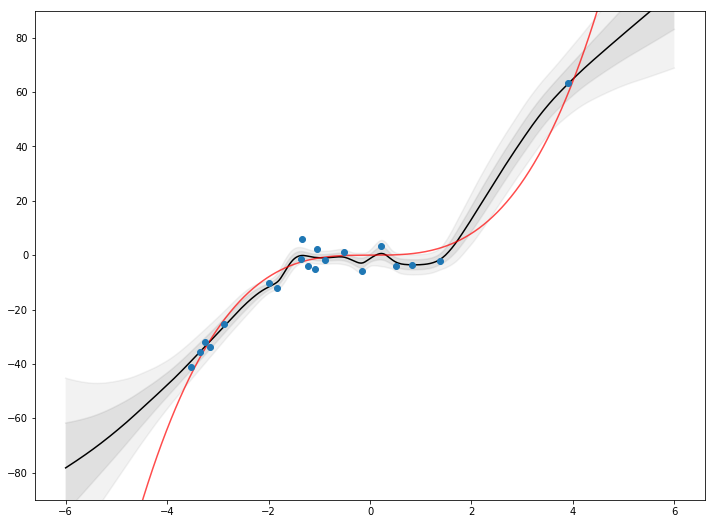

In [45]:
upper1 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) + np.std(predictions_psgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_psgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) - np.std(predictions_psgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_psgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(12,9))
plt.plot(grid,np.mean(predictions_psgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.12)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-90,90)

### KSGLD

In [5]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgld




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=False)

optim = ksgld.optim.KSGLD(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon=1e-3, l2=1e-3, invert_every=1)


predictions_ksgld = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(10000):

    running_loss = 0
    
    optim.update_curvature(x)
    
    network.zero_grad()
    output = network(x)
    loss = (1./(2*9))*criterion(output, y)
    loss.backward()
    optim.step()



    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 300) & (t % 100 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions_ksgld = torch.cat((predictions_ksgld, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 677.9935
Epoch 1 - loss: 673.8926
Epoch 2 - loss: 670.8531
Epoch 3 - loss: 666.3492
Epoch 4 - loss: 665.7020
Epoch 5 - loss: 663.6510
Epoch 6 - loss: 662.9261
Epoch 7 - loss: 661.6283
Epoch 8 - loss: 657.3062
Epoch 9 - loss: 654.6720
Epoch 10 - loss: 651.7152
Epoch 11 - loss: 650.7913
Epoch 12 - loss: 650.2913
Epoch 13 - loss: 644.4693
Epoch 14 - loss: 643.0742
Epoch 15 - loss: 642.4239
Epoch 16 - loss: 640.1488
Epoch 17 - loss: 637.4720
Epoch 18 - loss: 632.6611
Epoch 19 - loss: 622.9904
Epoch 20 - loss: 614.6371
Epoch 21 - loss: 609.0809
Epoch 22 - loss: 607.0901
Epoch 23 - loss: 607.8249
Epoch 24 - loss: 605.6168
Epoch 25 - loss: 603.7748
Epoch 26 - loss: 599.9969
Epoch 27 - loss: 597.3096
Epoch 28 - loss: 594.9734
Epoch 29 - loss: 591.9547
Epoch 30 - loss: 587.7148
Epoch 31 - loss: 580.1918
Epoch 32 - loss: 577.8207
Epoch 33 - loss: 574.5602
Epoch 34 - loss: 571.6829
Epoch 35 - loss: 567.1951
Epoch 36 - loss: 564.8186
Epoch 37 - loss: 557.9472
Epoch 38 - loss: 548.3

Epoch 320 - loss: 25.0075
Epoch 321 - loss: 24.7552
Epoch 322 - loss: 24.7248
Epoch 323 - loss: 24.2211
Epoch 324 - loss: 23.6421
Epoch 325 - loss: 23.4778
Epoch 326 - loss: 23.0009
Epoch 327 - loss: 24.3770
Epoch 328 - loss: 24.6820
Epoch 329 - loss: 25.6291
Epoch 330 - loss: 26.8010
Epoch 331 - loss: 26.6811
Epoch 332 - loss: 27.5433
Epoch 333 - loss: 26.7615
Epoch 334 - loss: 25.4720
Epoch 335 - loss: 25.0726
Epoch 336 - loss: 26.0286
Epoch 337 - loss: 24.2325
Epoch 338 - loss: 23.9307
Epoch 339 - loss: 24.5333
Epoch 340 - loss: 26.5009
Epoch 341 - loss: 27.7169
Epoch 342 - loss: 27.4042
Epoch 343 - loss: 29.3512
Epoch 344 - loss: 29.8261
Epoch 345 - loss: 33.5131
Epoch 346 - loss: 32.8694
Epoch 347 - loss: 30.8392
Epoch 348 - loss: 31.5625
Epoch 349 - loss: 30.9269
Epoch 350 - loss: 30.3996
Epoch 351 - loss: 29.6856
Epoch 352 - loss: 28.7323
Epoch 353 - loss: 26.9792
Epoch 354 - loss: 29.6388
Epoch 355 - loss: 28.4523
Epoch 356 - loss: 29.5393
Epoch 357 - loss: 26.9003
Epoch 358 - 

Epoch 637 - loss: 14.5901
Epoch 638 - loss: 13.7840
Epoch 639 - loss: 13.3750
Epoch 640 - loss: 14.1706
Epoch 641 - loss: 15.5621
Epoch 642 - loss: 16.3587
Epoch 643 - loss: 15.3233
Epoch 644 - loss: 14.0583
Epoch 645 - loss: 13.5226
Epoch 646 - loss: 13.7069
Epoch 647 - loss: 11.4008
Epoch 648 - loss: 10.9335
Epoch 649 - loss: 11.3662
Epoch 650 - loss: 10.6293
Epoch 651 - loss: 10.5497
Epoch 652 - loss: 11.2634
Epoch 653 - loss: 12.1255
Epoch 654 - loss: 12.2479
Epoch 655 - loss: 12.6802
Epoch 656 - loss: 13.3925
Epoch 657 - loss: 11.6310
Epoch 658 - loss: 10.6863
Epoch 659 - loss: 10.4865
Epoch 660 - loss: 10.8616
Epoch 661 - loss: 10.0441
Epoch 662 - loss: 10.1733
Epoch 663 - loss: 10.3088
Epoch 664 - loss: 10.4605
Epoch 665 - loss: 9.9836
Epoch 666 - loss: 10.3776
Epoch 667 - loss: 9.3892
Epoch 668 - loss: 8.4667
Epoch 669 - loss: 8.6979
Epoch 670 - loss: 8.5982
Epoch 671 - loss: 9.2679
Epoch 672 - loss: 10.2793
Epoch 673 - loss: 9.4448
Epoch 674 - loss: 9.2615
Epoch 675 - loss: 8.

Epoch 974 - loss: 9.2178
Epoch 975 - loss: 9.7934
Epoch 976 - loss: 8.9005
Epoch 977 - loss: 9.1884
Epoch 978 - loss: 10.2135
Epoch 979 - loss: 9.5983
Epoch 980 - loss: 8.7568
Epoch 981 - loss: 7.6728
Epoch 982 - loss: 8.9863
Epoch 983 - loss: 8.4857
Epoch 984 - loss: 8.4474
Epoch 985 - loss: 10.4912
Epoch 986 - loss: 11.6209
Epoch 987 - loss: 11.5979
Epoch 988 - loss: 12.3262
Epoch 989 - loss: 11.8954
Epoch 990 - loss: 12.2859
Epoch 991 - loss: 12.4141
Epoch 992 - loss: 13.9226
Epoch 993 - loss: 13.8220
Epoch 994 - loss: 9.9010
Epoch 995 - loss: 9.8445
Epoch 996 - loss: 10.3971
Epoch 997 - loss: 10.1938
Epoch 998 - loss: 11.1880
Epoch 999 - loss: 9.5349
Epoch 1000 - loss: 11.2632
Epoch 1001 - loss: 11.0638
Epoch 1002 - loss: 11.3511
Epoch 1003 - loss: 10.8792
Epoch 1004 - loss: 9.7514
Epoch 1005 - loss: 11.0763
Epoch 1006 - loss: 10.7266
Epoch 1007 - loss: 12.6549
Epoch 1008 - loss: 11.3274
Epoch 1009 - loss: 11.1321
Epoch 1010 - loss: 11.8670
Epoch 1011 - loss: 14.3050
Epoch 1012 - l

Epoch 1302 - loss: 9.6322
Epoch 1303 - loss: 9.3132
Epoch 1304 - loss: 9.5070
Epoch 1305 - loss: 8.3174
Epoch 1306 - loss: 7.5109
Epoch 1307 - loss: 7.3503
Epoch 1308 - loss: 9.1663
Epoch 1309 - loss: 10.1017
Epoch 1310 - loss: 8.8513
Epoch 1311 - loss: 9.1295
Epoch 1312 - loss: 9.4486
Epoch 1313 - loss: 8.1821
Epoch 1314 - loss: 4.3951
Epoch 1315 - loss: 6.3005
Epoch 1316 - loss: 6.8194
Epoch 1317 - loss: 7.2645
Epoch 1318 - loss: 9.0333
Epoch 1319 - loss: 9.6177
Epoch 1320 - loss: 10.7881
Epoch 1321 - loss: 10.6720
Epoch 1322 - loss: 11.0486
Epoch 1323 - loss: 11.0455
Epoch 1324 - loss: 10.9921
Epoch 1325 - loss: 5.6512
Epoch 1326 - loss: 7.1729
Epoch 1327 - loss: 10.6161
Epoch 1328 - loss: 9.8808
Epoch 1329 - loss: 10.2699
Epoch 1330 - loss: 12.6461
Epoch 1331 - loss: 13.3903
Epoch 1332 - loss: 13.7303
Epoch 1333 - loss: 12.7737
Epoch 1334 - loss: 9.8198
Epoch 1335 - loss: 6.1731
Epoch 1336 - loss: 7.2850
Epoch 1337 - loss: 6.4860
Epoch 1338 - loss: 6.4403
Epoch 1339 - loss: 6.7327


Epoch 1633 - loss: 23.8374
Epoch 1634 - loss: 21.4975
Epoch 1635 - loss: 16.4753
Epoch 1636 - loss: 17.1822
Epoch 1637 - loss: 13.7806
Epoch 1638 - loss: 10.7300
Epoch 1639 - loss: 10.0417
Epoch 1640 - loss: 8.0969
Epoch 1641 - loss: 8.5950
Epoch 1642 - loss: 7.6466
Epoch 1643 - loss: 8.3095
Epoch 1644 - loss: 8.8697
Epoch 1645 - loss: 10.4857
Epoch 1646 - loss: 12.3587
Epoch 1647 - loss: 13.1298
Epoch 1648 - loss: 16.1385
Epoch 1649 - loss: 14.5568
Epoch 1650 - loss: 12.1729
Epoch 1651 - loss: 12.6667
Epoch 1652 - loss: 20.0452
Epoch 1653 - loss: 24.2467
Epoch 1654 - loss: 28.8312
Epoch 1655 - loss: 25.6868
Epoch 1656 - loss: 20.5326
Epoch 1657 - loss: 22.5091
Epoch 1658 - loss: 19.8412
Epoch 1659 - loss: 16.6775
Epoch 1660 - loss: 12.1860
Epoch 1661 - loss: 12.3900
Epoch 1662 - loss: 12.1651
Epoch 1663 - loss: 10.4521
Epoch 1664 - loss: 12.3104
Epoch 1665 - loss: 13.6141
Epoch 1666 - loss: 16.3477
Epoch 1667 - loss: 16.1780
Epoch 1668 - loss: 16.9840
Epoch 1669 - loss: 19.2639
Epoch 

Epoch 1951 - loss: 5.2660
Epoch 1952 - loss: 6.7423
Epoch 1953 - loss: 6.6359
Epoch 1954 - loss: 6.1411
Epoch 1955 - loss: 6.6118
Epoch 1956 - loss: 9.9728
Epoch 1957 - loss: 11.6038
Epoch 1958 - loss: 15.3998
Epoch 1959 - loss: 16.7232
Epoch 1960 - loss: 16.5849
Epoch 1961 - loss: 13.6761
Epoch 1962 - loss: 13.2459
Epoch 1963 - loss: 14.3108
Epoch 1964 - loss: 14.9208
Epoch 1965 - loss: 16.4644
Epoch 1966 - loss: 19.6748
Epoch 1967 - loss: 16.4272
Epoch 1968 - loss: 9.0831
Epoch 1969 - loss: 10.5187
Epoch 1970 - loss: 9.4167
Epoch 1971 - loss: 13.2423
Epoch 1972 - loss: 13.9647
Epoch 1973 - loss: 13.2981
Epoch 1974 - loss: 11.3147
Epoch 1975 - loss: 9.5504
Epoch 1976 - loss: 8.1502
Epoch 1977 - loss: 9.1668
Epoch 1978 - loss: 9.7427
Epoch 1979 - loss: 8.2176
Epoch 1980 - loss: 10.1308
Epoch 1981 - loss: 11.8749
Epoch 1982 - loss: 12.1827
Epoch 1983 - loss: 13.0923
Epoch 1984 - loss: 14.2305
Epoch 1985 - loss: 13.7525
Epoch 1986 - loss: 13.4463
Epoch 1987 - loss: 12.8846
Epoch 1988 - l

Epoch 2269 - loss: 6.2508
Epoch 2270 - loss: 6.3465
Epoch 2271 - loss: 7.3667
Epoch 2272 - loss: 7.8782
Epoch 2273 - loss: 10.4380
Epoch 2274 - loss: 10.5073
Epoch 2275 - loss: 13.8926
Epoch 2276 - loss: 15.4631
Epoch 2277 - loss: 13.5691
Epoch 2278 - loss: 15.3931
Epoch 2279 - loss: 12.6547
Epoch 2280 - loss: 9.4498
Epoch 2281 - loss: 10.5618
Epoch 2282 - loss: 10.1457
Epoch 2283 - loss: 9.7895
Epoch 2284 - loss: 14.6273
Epoch 2285 - loss: 11.4498
Epoch 2286 - loss: 12.3058
Epoch 2287 - loss: 11.0965
Epoch 2288 - loss: 9.8328
Epoch 2289 - loss: 11.2379
Epoch 2290 - loss: 11.5328
Epoch 2291 - loss: 12.6145
Epoch 2292 - loss: 14.3636
Epoch 2293 - loss: 14.7650
Epoch 2294 - loss: 18.9095
Epoch 2295 - loss: 22.9119
Epoch 2296 - loss: 20.5753
Epoch 2297 - loss: 16.8095
Epoch 2298 - loss: 12.7852
Epoch 2299 - loss: 14.6865
Epoch 2300 - loss: 12.3425
Epoch 2301 - loss: 12.5175
Epoch 2302 - loss: 12.2701
Epoch 2303 - loss: 11.8354
Epoch 2304 - loss: 16.0235
Epoch 2305 - loss: 15.9121
Epoch 23

Epoch 2577 - loss: 8.9967
Epoch 2578 - loss: 8.9055
Epoch 2579 - loss: 9.5861
Epoch 2580 - loss: 11.5490
Epoch 2581 - loss: 9.1153
Epoch 2582 - loss: 10.1522
Epoch 2583 - loss: 9.0313
Epoch 2584 - loss: 8.0137
Epoch 2585 - loss: 7.3547
Epoch 2586 - loss: 7.3808
Epoch 2587 - loss: 8.1140
Epoch 2588 - loss: 7.5036
Epoch 2589 - loss: 8.2879
Epoch 2590 - loss: 7.2132
Epoch 2591 - loss: 5.5385
Epoch 2592 - loss: 7.9447
Epoch 2593 - loss: 7.3481
Epoch 2594 - loss: 8.5308
Epoch 2595 - loss: 10.5004
Epoch 2596 - loss: 9.3419
Epoch 2597 - loss: 11.8473
Epoch 2598 - loss: 10.9974
Epoch 2599 - loss: 13.7534
Epoch 2600 - loss: 14.0650
Epoch 2601 - loss: 17.4870
Epoch 2602 - loss: 16.0178
Epoch 2603 - loss: 14.4692
Epoch 2604 - loss: 17.9141
Epoch 2605 - loss: 16.3673
Epoch 2606 - loss: 12.3794
Epoch 2607 - loss: 9.7164
Epoch 2608 - loss: 10.5428
Epoch 2609 - loss: 8.6202
Epoch 2610 - loss: 8.2102
Epoch 2611 - loss: 7.2875
Epoch 2612 - loss: 6.6888
Epoch 2613 - loss: 7.1527
Epoch 2614 - loss: 8.473

Epoch 2904 - loss: 20.2163
Epoch 2905 - loss: 21.4408
Epoch 2906 - loss: 17.8012
Epoch 2907 - loss: 17.1050
Epoch 2908 - loss: 14.9283
Epoch 2909 - loss: 13.1853
Epoch 2910 - loss: 14.7027
Epoch 2911 - loss: 12.9648
Epoch 2912 - loss: 15.7152
Epoch 2913 - loss: 17.7758
Epoch 2914 - loss: 14.9050
Epoch 2915 - loss: 16.0451
Epoch 2916 - loss: 16.0109
Epoch 2917 - loss: 13.2941
Epoch 2918 - loss: 12.8069
Epoch 2919 - loss: 12.8555
Epoch 2920 - loss: 13.8588
Epoch 2921 - loss: 14.7968
Epoch 2922 - loss: 8.8983
Epoch 2923 - loss: 7.0155
Epoch 2924 - loss: 7.8733
Epoch 2925 - loss: 12.3433
Epoch 2926 - loss: 14.0305
Epoch 2927 - loss: 11.9813
Epoch 2928 - loss: 10.0901
Epoch 2929 - loss: 19.6726
Epoch 2930 - loss: 17.0728
Epoch 2931 - loss: 10.4298
Epoch 2932 - loss: 8.5102
Epoch 2933 - loss: 12.0169
Epoch 2934 - loss: 11.5687
Epoch 2935 - loss: 14.8106
Epoch 2936 - loss: 13.3385
Epoch 2937 - loss: 12.0224
Epoch 2938 - loss: 12.9059
Epoch 2939 - loss: 11.2043
Epoch 2940 - loss: 14.3335
Epoch

Epoch 3224 - loss: 20.3562
Epoch 3225 - loss: 19.2551
Epoch 3226 - loss: 13.6533
Epoch 3227 - loss: 15.2811
Epoch 3228 - loss: 15.8968
Epoch 3229 - loss: 16.9449
Epoch 3230 - loss: 18.2766
Epoch 3231 - loss: 16.4625
Epoch 3232 - loss: 14.8596
Epoch 3233 - loss: 13.9845
Epoch 3234 - loss: 15.9685
Epoch 3235 - loss: 12.6510
Epoch 3236 - loss: 13.3669
Epoch 3237 - loss: 16.0577
Epoch 3238 - loss: 14.4006
Epoch 3239 - loss: 15.9415
Epoch 3240 - loss: 11.1107
Epoch 3241 - loss: 11.1005
Epoch 3242 - loss: 11.9508
Epoch 3243 - loss: 10.0982
Epoch 3244 - loss: 8.3017
Epoch 3245 - loss: 10.4256
Epoch 3246 - loss: 10.3276
Epoch 3247 - loss: 11.9270
Epoch 3248 - loss: 13.4336
Epoch 3249 - loss: 13.0826
Epoch 3250 - loss: 10.7711
Epoch 3251 - loss: 10.6525
Epoch 3252 - loss: 6.5336
Epoch 3253 - loss: 6.0438
Epoch 3254 - loss: 5.1640
Epoch 3255 - loss: 5.2040
Epoch 3256 - loss: 6.6425
Epoch 3257 - loss: 9.4878
Epoch 3258 - loss: 9.0872
Epoch 3259 - loss: 9.7950
Epoch 3260 - loss: 10.2395
Epoch 3261

Epoch 3536 - loss: 7.0365
Epoch 3537 - loss: 8.1131
Epoch 3538 - loss: 8.9077
Epoch 3539 - loss: 8.9234
Epoch 3540 - loss: 7.5592
Epoch 3541 - loss: 7.2668
Epoch 3542 - loss: 4.4112
Epoch 3543 - loss: 3.3391
Epoch 3544 - loss: 6.3611
Epoch 3545 - loss: 7.3834
Epoch 3546 - loss: 8.8116
Epoch 3547 - loss: 7.7830
Epoch 3548 - loss: 8.9321
Epoch 3549 - loss: 7.5047
Epoch 3550 - loss: 7.4327
Epoch 3551 - loss: 5.9053
Epoch 3552 - loss: 4.5081
Epoch 3553 - loss: 7.1803
Epoch 3554 - loss: 8.2419
Epoch 3555 - loss: 9.8814
Epoch 3556 - loss: 9.6403
Epoch 3557 - loss: 6.6461
Epoch 3558 - loss: 7.0370
Epoch 3559 - loss: 7.0247
Epoch 3560 - loss: 8.3150
Epoch 3561 - loss: 10.1137
Epoch 3562 - loss: 10.2195
Epoch 3563 - loss: 10.1988
Epoch 3564 - loss: 9.6145
Epoch 3565 - loss: 7.5459
Epoch 3566 - loss: 6.9520
Epoch 3567 - loss: 5.9261
Epoch 3568 - loss: 7.5759
Epoch 3569 - loss: 7.1952
Epoch 3570 - loss: 7.3711
Epoch 3571 - loss: 5.9772
Epoch 3572 - loss: 7.3740
Epoch 3573 - loss: 7.1570
Epoch 357

Epoch 3856 - loss: 5.6541
Epoch 3857 - loss: 4.2097
Epoch 3858 - loss: 5.2722
Epoch 3859 - loss: 6.6501
Epoch 3860 - loss: 5.3119
Epoch 3861 - loss: 6.2331
Epoch 3862 - loss: 7.9505
Epoch 3863 - loss: 7.8366
Epoch 3864 - loss: 8.0048
Epoch 3865 - loss: 7.9198
Epoch 3866 - loss: 9.4428
Epoch 3867 - loss: 11.2409
Epoch 3868 - loss: 13.5967
Epoch 3869 - loss: 10.9216
Epoch 3870 - loss: 12.4878
Epoch 3871 - loss: 14.3245
Epoch 3872 - loss: 12.5864
Epoch 3873 - loss: 6.9111
Epoch 3874 - loss: 7.1191
Epoch 3875 - loss: 6.8473
Epoch 3876 - loss: 6.2692
Epoch 3877 - loss: 6.1321
Epoch 3878 - loss: 8.6394
Epoch 3879 - loss: 8.1011
Epoch 3880 - loss: 7.6796
Epoch 3881 - loss: 8.2789
Epoch 3882 - loss: 7.5729
Epoch 3883 - loss: 6.4092
Epoch 3884 - loss: 6.8877
Epoch 3885 - loss: 4.3785
Epoch 3886 - loss: 5.0666
Epoch 3887 - loss: 6.8542
Epoch 3888 - loss: 6.5621
Epoch 3889 - loss: 6.4881
Epoch 3890 - loss: 9.0631
Epoch 3891 - loss: 8.3579
Epoch 3892 - loss: 8.4396
Epoch 3893 - loss: 8.8221
Epoch 

Epoch 4174 - loss: 19.2925
Epoch 4175 - loss: 19.8513
Epoch 4176 - loss: 14.1450
Epoch 4177 - loss: 13.3839
Epoch 4178 - loss: 11.0344
Epoch 4179 - loss: 9.2643
Epoch 4180 - loss: 8.8991
Epoch 4181 - loss: 12.6505
Epoch 4182 - loss: 13.8860
Epoch 4183 - loss: 15.9414
Epoch 4184 - loss: 12.5598
Epoch 4185 - loss: 10.3535
Epoch 4186 - loss: 12.0402
Epoch 4187 - loss: 12.6188
Epoch 4188 - loss: 15.9987
Epoch 4189 - loss: 14.3393
Epoch 4190 - loss: 14.2333
Epoch 4191 - loss: 13.8716
Epoch 4192 - loss: 12.4070
Epoch 4193 - loss: 14.1729
Epoch 4194 - loss: 13.4147
Epoch 4195 - loss: 12.3224
Epoch 4196 - loss: 13.8178
Epoch 4197 - loss: 14.7381
Epoch 4198 - loss: 13.8711
Epoch 4199 - loss: 13.2086
Epoch 4200 - loss: 10.4784
Epoch 4201 - loss: 11.6702
Epoch 4202 - loss: 10.9753
Epoch 4203 - loss: 8.4013
Epoch 4204 - loss: 11.3321
Epoch 4205 - loss: 11.8155
Epoch 4206 - loss: 13.0850
Epoch 4207 - loss: 16.5279
Epoch 4208 - loss: 14.7054
Epoch 4209 - loss: 13.5704
Epoch 4210 - loss: 12.5457
Epoc

Epoch 4499 - loss: 15.1430
Epoch 4500 - loss: 17.1832
Epoch 4501 - loss: 16.1255
Epoch 4502 - loss: 13.6435
Epoch 4503 - loss: 13.1957
Epoch 4504 - loss: 13.8855
Epoch 4505 - loss: 12.2002
Epoch 4506 - loss: 13.4786
Epoch 4507 - loss: 13.2365
Epoch 4508 - loss: 16.3320
Epoch 4509 - loss: 13.6513
Epoch 4510 - loss: 14.9649
Epoch 4511 - loss: 14.3476
Epoch 4512 - loss: 9.6724
Epoch 4513 - loss: 10.7969
Epoch 4514 - loss: 11.9917
Epoch 4515 - loss: 9.7995
Epoch 4516 - loss: 10.1633
Epoch 4517 - loss: 9.8173
Epoch 4518 - loss: 8.2678
Epoch 4519 - loss: 8.8213
Epoch 4520 - loss: 11.8397
Epoch 4521 - loss: 10.4990
Epoch 4522 - loss: 9.3959
Epoch 4523 - loss: 10.2806
Epoch 4524 - loss: 9.7392
Epoch 4525 - loss: 9.7828
Epoch 4526 - loss: 10.1598
Epoch 4527 - loss: 9.2183
Epoch 4528 - loss: 9.5433
Epoch 4529 - loss: 10.6003
Epoch 4530 - loss: 11.7204
Epoch 4531 - loss: 11.5143
Epoch 4532 - loss: 14.2330
Epoch 4533 - loss: 9.3475
Epoch 4534 - loss: 5.9435
Epoch 4535 - loss: 5.5266
Epoch 4536 - l

Epoch 4824 - loss: 6.2483
Epoch 4825 - loss: 6.5072
Epoch 4826 - loss: 6.0429
Epoch 4827 - loss: 5.2152
Epoch 4828 - loss: 5.6784
Epoch 4829 - loss: 5.0941
Epoch 4830 - loss: 5.3806
Epoch 4831 - loss: 6.4240
Epoch 4832 - loss: 8.0259
Epoch 4833 - loss: 8.4076
Epoch 4834 - loss: 10.7907
Epoch 4835 - loss: 11.0738
Epoch 4836 - loss: 11.8570
Epoch 4837 - loss: 10.5533
Epoch 4838 - loss: 10.7424
Epoch 4839 - loss: 12.6958
Epoch 4840 - loss: 12.1987
Epoch 4841 - loss: 10.2927
Epoch 4842 - loss: 12.3702
Epoch 4843 - loss: 12.5638
Epoch 4844 - loss: 14.1374
Epoch 4845 - loss: 12.2958
Epoch 4846 - loss: 12.5002
Epoch 4847 - loss: 12.7918
Epoch 4848 - loss: 14.6817
Epoch 4849 - loss: 11.7475
Epoch 4850 - loss: 13.7480
Epoch 4851 - loss: 17.0439
Epoch 4852 - loss: 12.3364
Epoch 4853 - loss: 10.9413
Epoch 4854 - loss: 13.0807
Epoch 4855 - loss: 10.8727
Epoch 4856 - loss: 8.9164
Epoch 4857 - loss: 10.2919
Epoch 4858 - loss: 9.8136
Epoch 4859 - loss: 10.4014
Epoch 4860 - loss: 11.9739
Epoch 4861 - 

Epoch 5148 - loss: 8.3523
Epoch 5149 - loss: 8.6320
Epoch 5150 - loss: 9.6083
Epoch 5151 - loss: 9.7767
Epoch 5152 - loss: 11.2027
Epoch 5153 - loss: 12.4868
Epoch 5154 - loss: 10.4569
Epoch 5155 - loss: 11.4080
Epoch 5156 - loss: 10.1717
Epoch 5157 - loss: 8.3461
Epoch 5158 - loss: 7.7657
Epoch 5159 - loss: 6.5792
Epoch 5160 - loss: 5.8077
Epoch 5161 - loss: 3.9655
Epoch 5162 - loss: 4.4031
Epoch 5163 - loss: 5.8779
Epoch 5164 - loss: 5.7153
Epoch 5165 - loss: 7.8571
Epoch 5166 - loss: 10.0556
Epoch 5167 - loss: 6.4643
Epoch 5168 - loss: 6.8973
Epoch 5169 - loss: 6.0221
Epoch 5170 - loss: 8.2362
Epoch 5171 - loss: 10.4532
Epoch 5172 - loss: 12.1367
Epoch 5173 - loss: 9.7763
Epoch 5174 - loss: 7.9377
Epoch 5175 - loss: 8.0073
Epoch 5176 - loss: 7.0487
Epoch 5177 - loss: 6.6320
Epoch 5178 - loss: 6.7649
Epoch 5179 - loss: 9.6002
Epoch 5180 - loss: 10.4242
Epoch 5181 - loss: 10.9692
Epoch 5182 - loss: 14.1955
Epoch 5183 - loss: 10.7723
Epoch 5184 - loss: 12.5275
Epoch 5185 - loss: 16.074

Epoch 5471 - loss: 8.2246
Epoch 5472 - loss: 6.9629
Epoch 5473 - loss: 12.6626
Epoch 5474 - loss: 9.7356
Epoch 5475 - loss: 7.1947
Epoch 5476 - loss: 7.8547
Epoch 5477 - loss: 6.8385
Epoch 5478 - loss: 9.0541
Epoch 5479 - loss: 9.8302
Epoch 5480 - loss: 9.0864
Epoch 5481 - loss: 7.2682
Epoch 5482 - loss: 10.3270
Epoch 5483 - loss: 10.9490
Epoch 5484 - loss: 10.7190
Epoch 5485 - loss: 10.4341
Epoch 5486 - loss: 12.7651
Epoch 5487 - loss: 10.2610
Epoch 5488 - loss: 11.8664
Epoch 5489 - loss: 12.0242
Epoch 5490 - loss: 12.2520
Epoch 5491 - loss: 15.4614
Epoch 5492 - loss: 10.4252
Epoch 5493 - loss: 10.5970
Epoch 5494 - loss: 11.0095
Epoch 5495 - loss: 10.2897
Epoch 5496 - loss: 11.1862
Epoch 5497 - loss: 11.2768
Epoch 5498 - loss: 15.1206
Epoch 5499 - loss: 16.2680
Epoch 5500 - loss: 19.5978
Epoch 5501 - loss: 17.3091
Epoch 5502 - loss: 15.0878
Epoch 5503 - loss: 14.9585
Epoch 5504 - loss: 16.1840
Epoch 5505 - loss: 16.5727
Epoch 5506 - loss: 15.0037
Epoch 5507 - loss: 11.1600
Epoch 5508 

Epoch 5789 - loss: 15.4388
Epoch 5790 - loss: 14.8763
Epoch 5791 - loss: 14.7772
Epoch 5792 - loss: 13.6820
Epoch 5793 - loss: 16.2419
Epoch 5794 - loss: 15.2092
Epoch 5795 - loss: 19.8015
Epoch 5796 - loss: 16.3927
Epoch 5797 - loss: 14.4975
Epoch 5798 - loss: 13.1375
Epoch 5799 - loss: 13.9914
Epoch 5800 - loss: 16.5496
Epoch 5801 - loss: 15.7239
Epoch 5802 - loss: 14.9219
Epoch 5803 - loss: 13.5043
Epoch 5804 - loss: 12.3360
Epoch 5805 - loss: 13.5703
Epoch 5806 - loss: 13.4187
Epoch 5807 - loss: 12.1625
Epoch 5808 - loss: 9.7115
Epoch 5809 - loss: 10.2444
Epoch 5810 - loss: 11.1563
Epoch 5811 - loss: 11.9831
Epoch 5812 - loss: 12.9893
Epoch 5813 - loss: 12.4958
Epoch 5814 - loss: 11.9498
Epoch 5815 - loss: 13.0042
Epoch 5816 - loss: 13.0301
Epoch 5817 - loss: 12.8462
Epoch 5818 - loss: 12.1791
Epoch 5819 - loss: 11.4871
Epoch 5820 - loss: 10.8183
Epoch 5821 - loss: 11.1972
Epoch 5822 - loss: 12.5273
Epoch 5823 - loss: 13.3042
Epoch 5824 - loss: 12.6108
Epoch 5825 - loss: 9.8784
Epo

Epoch 6106 - loss: 18.5002
Epoch 6107 - loss: 19.3864
Epoch 6108 - loss: 19.4546
Epoch 6109 - loss: 14.1373
Epoch 6110 - loss: 12.9810
Epoch 6111 - loss: 14.4361
Epoch 6112 - loss: 15.1713
Epoch 6113 - loss: 11.8079
Epoch 6114 - loss: 14.0179
Epoch 6115 - loss: 15.4218
Epoch 6116 - loss: 14.5080
Epoch 6117 - loss: 15.8698
Epoch 6118 - loss: 15.1570
Epoch 6119 - loss: 13.6471
Epoch 6120 - loss: 9.7799
Epoch 6121 - loss: 10.1786
Epoch 6122 - loss: 12.4698
Epoch 6123 - loss: 12.3704
Epoch 6124 - loss: 13.0150
Epoch 6125 - loss: 12.1944
Epoch 6126 - loss: 9.3400
Epoch 6127 - loss: 11.2650
Epoch 6128 - loss: 12.9006
Epoch 6129 - loss: 14.9844
Epoch 6130 - loss: 14.0634
Epoch 6131 - loss: 13.8401
Epoch 6132 - loss: 14.5765
Epoch 6133 - loss: 14.0939
Epoch 6134 - loss: 14.7962
Epoch 6135 - loss: 13.7352
Epoch 6136 - loss: 11.9417
Epoch 6137 - loss: 8.8617
Epoch 6138 - loss: 7.7197
Epoch 6139 - loss: 8.2314
Epoch 6140 - loss: 8.8392
Epoch 6141 - loss: 8.4754
Epoch 6142 - loss: 9.7608
Epoch 614

Epoch 6424 - loss: 11.5795
Epoch 6425 - loss: 10.2061
Epoch 6426 - loss: 12.2623
Epoch 6427 - loss: 12.3214
Epoch 6428 - loss: 11.9932
Epoch 6429 - loss: 13.1178
Epoch 6430 - loss: 12.3694
Epoch 6431 - loss: 8.5771
Epoch 6432 - loss: 8.5375
Epoch 6433 - loss: 6.3992
Epoch 6434 - loss: 5.3778
Epoch 6435 - loss: 4.8199
Epoch 6436 - loss: 5.0835
Epoch 6437 - loss: 4.9858
Epoch 6438 - loss: 6.0126
Epoch 6439 - loss: 5.2246
Epoch 6440 - loss: 5.9106
Epoch 6441 - loss: 4.9268
Epoch 6442 - loss: 5.4160
Epoch 6443 - loss: 5.6451
Epoch 6444 - loss: 4.3717
Epoch 6445 - loss: 4.0692
Epoch 6446 - loss: 3.7459
Epoch 6447 - loss: 3.5513
Epoch 6448 - loss: 3.3140
Epoch 6449 - loss: 4.5182
Epoch 6450 - loss: 4.9492
Epoch 6451 - loss: 6.0476
Epoch 6452 - loss: 6.4523
Epoch 6453 - loss: 9.5739
Epoch 6454 - loss: 10.0362
Epoch 6455 - loss: 9.7847
Epoch 6456 - loss: 8.2257
Epoch 6457 - loss: 9.3488
Epoch 6458 - loss: 8.8598
Epoch 6459 - loss: 8.3608
Epoch 6460 - loss: 7.2292
Epoch 6461 - loss: 8.3287
Epoc

Epoch 6747 - loss: 7.9224
Epoch 6748 - loss: 8.1151
Epoch 6749 - loss: 9.8299
Epoch 6750 - loss: 9.5584
Epoch 6751 - loss: 9.2789
Epoch 6752 - loss: 7.3014
Epoch 6753 - loss: 7.6053
Epoch 6754 - loss: 8.1345
Epoch 6755 - loss: 8.4440
Epoch 6756 - loss: 10.9066
Epoch 6757 - loss: 13.7246
Epoch 6758 - loss: 10.4083
Epoch 6759 - loss: 12.0484
Epoch 6760 - loss: 12.7286
Epoch 6761 - loss: 14.7672
Epoch 6762 - loss: 16.2114
Epoch 6763 - loss: 16.9967
Epoch 6764 - loss: 15.8177
Epoch 6765 - loss: 13.0047
Epoch 6766 - loss: 11.5927
Epoch 6767 - loss: 11.9184
Epoch 6768 - loss: 11.2082
Epoch 6769 - loss: 10.7913
Epoch 6770 - loss: 8.1394
Epoch 6771 - loss: 8.0180
Epoch 6772 - loss: 7.6565
Epoch 6773 - loss: 9.5836
Epoch 6774 - loss: 8.6261
Epoch 6775 - loss: 9.4875
Epoch 6776 - loss: 10.8844
Epoch 6777 - loss: 10.4971
Epoch 6778 - loss: 9.2482
Epoch 6779 - loss: 7.9702
Epoch 6780 - loss: 9.1228
Epoch 6781 - loss: 9.1885
Epoch 6782 - loss: 9.4259
Epoch 6783 - loss: 8.6615
Epoch 6784 - loss: 9.6

Epoch 7056 - loss: 11.6704
Epoch 7057 - loss: 10.0947
Epoch 7058 - loss: 11.6704
Epoch 7059 - loss: 12.3992
Epoch 7060 - loss: 14.5774
Epoch 7061 - loss: 15.5873
Epoch 7062 - loss: 14.4880
Epoch 7063 - loss: 15.1089
Epoch 7064 - loss: 16.8513
Epoch 7065 - loss: 16.4358
Epoch 7066 - loss: 14.5839
Epoch 7067 - loss: 12.7371
Epoch 7068 - loss: 13.3325
Epoch 7069 - loss: 12.9526
Epoch 7070 - loss: 11.0718
Epoch 7071 - loss: 12.1022
Epoch 7072 - loss: 15.0974
Epoch 7073 - loss: 13.9655
Epoch 7074 - loss: 16.3346
Epoch 7075 - loss: 17.3975
Epoch 7076 - loss: 17.9035
Epoch 7077 - loss: 17.3473
Epoch 7078 - loss: 13.7136
Epoch 7079 - loss: 14.0700
Epoch 7080 - loss: 13.5636
Epoch 7081 - loss: 12.5002
Epoch 7082 - loss: 14.0272
Epoch 7083 - loss: 12.5502
Epoch 7084 - loss: 13.5844
Epoch 7085 - loss: 14.9584
Epoch 7086 - loss: 12.3101
Epoch 7087 - loss: 13.7628
Epoch 7088 - loss: 12.6306
Epoch 7089 - loss: 9.9825
Epoch 7090 - loss: 11.2152
Epoch 7091 - loss: 10.5546
Epoch 7092 - loss: 7.8793
Epo

Epoch 7364 - loss: 6.5423
Epoch 7365 - loss: 8.3716
Epoch 7366 - loss: 8.0304
Epoch 7367 - loss: 8.7844
Epoch 7368 - loss: 8.7263
Epoch 7369 - loss: 8.9683
Epoch 7370 - loss: 10.1909
Epoch 7371 - loss: 14.7012
Epoch 7372 - loss: 9.4296
Epoch 7373 - loss: 10.5516
Epoch 7374 - loss: 12.9486
Epoch 7375 - loss: 13.2509
Epoch 7376 - loss: 15.0618
Epoch 7377 - loss: 12.5443
Epoch 7378 - loss: 11.3498
Epoch 7379 - loss: 11.2215
Epoch 7380 - loss: 10.3436
Epoch 7381 - loss: 7.9836
Epoch 7382 - loss: 8.0424
Epoch 7383 - loss: 8.1375
Epoch 7384 - loss: 8.4344
Epoch 7385 - loss: 7.3281
Epoch 7386 - loss: 8.7962
Epoch 7387 - loss: 9.2015
Epoch 7388 - loss: 11.4787
Epoch 7389 - loss: 12.1413
Epoch 7390 - loss: 12.6798
Epoch 7391 - loss: 12.0895
Epoch 7392 - loss: 13.3598
Epoch 7393 - loss: 14.6202
Epoch 7394 - loss: 16.9797
Epoch 7395 - loss: 20.9254
Epoch 7396 - loss: 23.2385
Epoch 7397 - loss: 15.5678
Epoch 7398 - loss: 13.4629
Epoch 7399 - loss: 13.3212
Epoch 7400 - loss: 17.0775
Epoch 7401 - lo

Epoch 7678 - loss: 6.5256
Epoch 7679 - loss: 10.1593
Epoch 7680 - loss: 9.7461
Epoch 7681 - loss: 10.0296
Epoch 7682 - loss: 9.3542
Epoch 7683 - loss: 12.2938
Epoch 7684 - loss: 9.9010
Epoch 7685 - loss: 8.4029
Epoch 7686 - loss: 9.1548
Epoch 7687 - loss: 8.4713
Epoch 7688 - loss: 11.1033
Epoch 7689 - loss: 11.7250
Epoch 7690 - loss: 10.9075
Epoch 7691 - loss: 11.6458
Epoch 7692 - loss: 10.9314
Epoch 7693 - loss: 10.7566
Epoch 7694 - loss: 13.0455
Epoch 7695 - loss: 11.2662
Epoch 7696 - loss: 11.7332
Epoch 7697 - loss: 8.8101
Epoch 7698 - loss: 5.6892
Epoch 7699 - loss: 6.8021
Epoch 7700 - loss: 7.1566
Epoch 7701 - loss: 5.1399
Epoch 7702 - loss: 4.8603
Epoch 7703 - loss: 7.6527
Epoch 7704 - loss: 7.9630
Epoch 7705 - loss: 8.5281
Epoch 7706 - loss: 10.3718
Epoch 7707 - loss: 10.2124
Epoch 7708 - loss: 8.4552
Epoch 7709 - loss: 8.7810
Epoch 7710 - loss: 9.6169
Epoch 7711 - loss: 11.4969
Epoch 7712 - loss: 9.7320
Epoch 7713 - loss: 11.6094
Epoch 7714 - loss: 12.7065
Epoch 7715 - loss: 9.

Epoch 7997 - loss: 15.3171
Epoch 7998 - loss: 17.2161
Epoch 7999 - loss: 17.0730
Epoch 8000 - loss: 14.9522
Epoch 8001 - loss: 17.5320
Epoch 8002 - loss: 15.8037
Epoch 8003 - loss: 15.6231
Epoch 8004 - loss: 13.6423
Epoch 8005 - loss: 13.7785
Epoch 8006 - loss: 15.3394
Epoch 8007 - loss: 14.5177
Epoch 8008 - loss: 14.9263
Epoch 8009 - loss: 15.0314
Epoch 8010 - loss: 20.1491
Epoch 8011 - loss: 21.8791
Epoch 8012 - loss: 21.9664
Epoch 8013 - loss: 21.6208
Epoch 8014 - loss: 16.2659
Epoch 8015 - loss: 13.4043
Epoch 8016 - loss: 14.0115
Epoch 8017 - loss: 15.3121
Epoch 8018 - loss: 12.8928
Epoch 8019 - loss: 15.5938
Epoch 8020 - loss: 16.4143
Epoch 8021 - loss: 28.0964
Epoch 8022 - loss: 28.7717
Epoch 8023 - loss: 32.4580
Epoch 8024 - loss: 26.8564
Epoch 8025 - loss: 18.9195
Epoch 8026 - loss: 17.6691
Epoch 8027 - loss: 18.0966
Epoch 8028 - loss: 13.3817
Epoch 8029 - loss: 9.9839
Epoch 8030 - loss: 8.8661
Epoch 8031 - loss: 15.6378
Epoch 8032 - loss: 13.3293
Epoch 8033 - loss: 11.2603
Epo

Epoch 8323 - loss: 21.1901
Epoch 8324 - loss: 19.4753
Epoch 8325 - loss: 18.2802
Epoch 8326 - loss: 15.5549
Epoch 8327 - loss: 14.3364
Epoch 8328 - loss: 14.3373
Epoch 8329 - loss: 11.8957
Epoch 8330 - loss: 12.2072
Epoch 8331 - loss: 12.4985
Epoch 8332 - loss: 14.6427
Epoch 8333 - loss: 12.5855
Epoch 8334 - loss: 13.1198
Epoch 8335 - loss: 14.5741
Epoch 8336 - loss: 12.8716
Epoch 8337 - loss: 13.9206
Epoch 8338 - loss: 15.0108
Epoch 8339 - loss: 15.7648
Epoch 8340 - loss: 13.2315
Epoch 8341 - loss: 13.7806
Epoch 8342 - loss: 13.4748
Epoch 8343 - loss: 13.2389
Epoch 8344 - loss: 11.8192
Epoch 8345 - loss: 14.1208
Epoch 8346 - loss: 16.0415
Epoch 8347 - loss: 20.6502
Epoch 8348 - loss: 20.5990
Epoch 8349 - loss: 21.8234
Epoch 8350 - loss: 17.8811
Epoch 8351 - loss: 16.0791
Epoch 8352 - loss: 13.8171
Epoch 8353 - loss: 10.9923
Epoch 8354 - loss: 13.6937
Epoch 8355 - loss: 14.3046
Epoch 8356 - loss: 14.9614
Epoch 8357 - loss: 13.2368
Epoch 8358 - loss: 13.9200
Epoch 8359 - loss: 15.8600
E

Epoch 8644 - loss: 16.1016
Epoch 8645 - loss: 14.6693
Epoch 8646 - loss: 15.6763
Epoch 8647 - loss: 15.2246
Epoch 8648 - loss: 14.9498
Epoch 8649 - loss: 15.5432
Epoch 8650 - loss: 12.9022
Epoch 8651 - loss: 11.9671
Epoch 8652 - loss: 11.3357
Epoch 8653 - loss: 13.2314
Epoch 8654 - loss: 15.2887
Epoch 8655 - loss: 14.4104
Epoch 8656 - loss: 15.4143
Epoch 8657 - loss: 13.2717
Epoch 8658 - loss: 13.4016
Epoch 8659 - loss: 14.6650
Epoch 8660 - loss: 10.9185
Epoch 8661 - loss: 10.4803
Epoch 8662 - loss: 13.4423
Epoch 8663 - loss: 9.8502
Epoch 8664 - loss: 10.1285
Epoch 8665 - loss: 8.3985
Epoch 8666 - loss: 7.6171
Epoch 8667 - loss: 7.1988
Epoch 8668 - loss: 7.7448
Epoch 8669 - loss: 9.7104
Epoch 8670 - loss: 10.0057
Epoch 8671 - loss: 11.2464
Epoch 8672 - loss: 14.1432
Epoch 8673 - loss: 13.8543
Epoch 8674 - loss: 13.4839
Epoch 8675 - loss: 11.0073
Epoch 8676 - loss: 13.4081
Epoch 8677 - loss: 13.5553
Epoch 8678 - loss: 12.6901
Epoch 8679 - loss: 10.8289
Epoch 8680 - loss: 13.7230
Epoch 8

Epoch 8968 - loss: 17.6062
Epoch 8969 - loss: 18.4328
Epoch 8970 - loss: 19.0143
Epoch 8971 - loss: 17.3394
Epoch 8972 - loss: 14.2695
Epoch 8973 - loss: 15.4321
Epoch 8974 - loss: 16.9197
Epoch 8975 - loss: 14.1097
Epoch 8976 - loss: 13.3840
Epoch 8977 - loss: 13.8363
Epoch 8978 - loss: 11.2078
Epoch 8979 - loss: 12.1901
Epoch 8980 - loss: 13.1863
Epoch 8981 - loss: 12.5798
Epoch 8982 - loss: 12.6448
Epoch 8983 - loss: 12.6618
Epoch 8984 - loss: 16.0074
Epoch 8985 - loss: 16.3796
Epoch 8986 - loss: 16.2511
Epoch 8987 - loss: 18.3090
Epoch 8988 - loss: 19.4431
Epoch 8989 - loss: 19.0327
Epoch 8990 - loss: 20.6373
Epoch 8991 - loss: 19.8363
Epoch 8992 - loss: 17.6240
Epoch 8993 - loss: 19.1696
Epoch 8994 - loss: 20.8193
Epoch 8995 - loss: 21.3604
Epoch 8996 - loss: 21.4469
Epoch 8997 - loss: 19.2492
Epoch 8998 - loss: 18.6583
Epoch 8999 - loss: 19.0392
Epoch 9000 - loss: 22.3945
Epoch 9001 - loss: 21.5861
Epoch 9002 - loss: 21.6488
Epoch 9003 - loss: 21.2092
Epoch 9004 - loss: 21.3243
E

Epoch 9282 - loss: 10.8021
Epoch 9283 - loss: 11.5652
Epoch 9284 - loss: 12.3837
Epoch 9285 - loss: 12.8137
Epoch 9286 - loss: 12.7514
Epoch 9287 - loss: 15.3332
Epoch 9288 - loss: 13.8573
Epoch 9289 - loss: 14.1172
Epoch 9290 - loss: 14.1572
Epoch 9291 - loss: 12.0914
Epoch 9292 - loss: 13.9755
Epoch 9293 - loss: 12.3847
Epoch 9294 - loss: 13.8981
Epoch 9295 - loss: 13.8370
Epoch 9296 - loss: 11.5777
Epoch 9297 - loss: 13.7291
Epoch 9298 - loss: 14.0992
Epoch 9299 - loss: 16.0385
Epoch 9300 - loss: 16.1179
Epoch 9301 - loss: 16.6784
Epoch 9302 - loss: 15.9577
Epoch 9303 - loss: 17.2041
Epoch 9304 - loss: 15.8986
Epoch 9305 - loss: 16.0005
Epoch 9306 - loss: 11.7526
Epoch 9307 - loss: 9.1262
Epoch 9308 - loss: 8.6795
Epoch 9309 - loss: 9.8536
Epoch 9310 - loss: 12.4900
Epoch 9311 - loss: 11.3912
Epoch 9312 - loss: 10.8441
Epoch 9313 - loss: 11.6487
Epoch 9314 - loss: 11.8294
Epoch 9315 - loss: 11.8644
Epoch 9316 - loss: 12.0610
Epoch 9317 - loss: 15.6528
Epoch 9318 - loss: 19.8603
Epoc

Epoch 9595 - loss: 9.0992
Epoch 9596 - loss: 9.2205
Epoch 9597 - loss: 8.0290
Epoch 9598 - loss: 10.2334
Epoch 9599 - loss: 11.5973
Epoch 9600 - loss: 9.2381
Epoch 9601 - loss: 8.6020
Epoch 9602 - loss: 8.5511
Epoch 9603 - loss: 8.2983
Epoch 9604 - loss: 9.6713
Epoch 9605 - loss: 6.0135
Epoch 9606 - loss: 8.0159
Epoch 9607 - loss: 8.6394
Epoch 9608 - loss: 8.8950
Epoch 9609 - loss: 7.0032
Epoch 9610 - loss: 9.8699
Epoch 9611 - loss: 10.6020
Epoch 9612 - loss: 8.9947
Epoch 9613 - loss: 8.3927
Epoch 9614 - loss: 7.9337
Epoch 9615 - loss: 6.4927
Epoch 9616 - loss: 6.7205
Epoch 9617 - loss: 6.2819
Epoch 9618 - loss: 7.5688
Epoch 9619 - loss: 6.7265
Epoch 9620 - loss: 9.6795
Epoch 9621 - loss: 8.4165
Epoch 9622 - loss: 7.3565
Epoch 9623 - loss: 9.0633
Epoch 9624 - loss: 9.5418
Epoch 9625 - loss: 8.9660
Epoch 9626 - loss: 9.0126
Epoch 9627 - loss: 10.0568
Epoch 9628 - loss: 9.5402
Epoch 9629 - loss: 10.8563
Epoch 9630 - loss: 11.2477
Epoch 9631 - loss: 11.8824
Epoch 9632 - loss: 10.4288
Epoc

Epoch 9919 - loss: 12.2561
Epoch 9920 - loss: 10.9289
Epoch 9921 - loss: 13.1579
Epoch 9922 - loss: 13.7055
Epoch 9923 - loss: 12.2533
Epoch 9924 - loss: 14.2726
Epoch 9925 - loss: 12.7984
Epoch 9926 - loss: 8.6221
Epoch 9927 - loss: 9.3934
Epoch 9928 - loss: 10.2518
Epoch 9929 - loss: 11.6471
Epoch 9930 - loss: 9.8884
Epoch 9931 - loss: 9.6671
Epoch 9932 - loss: 10.2386
Epoch 9933 - loss: 10.4360
Epoch 9934 - loss: 8.5958
Epoch 9935 - loss: 9.3807
Epoch 9936 - loss: 7.3908
Epoch 9937 - loss: 7.3840
Epoch 9938 - loss: 6.9243
Epoch 9939 - loss: 6.9814
Epoch 9940 - loss: 6.7629
Epoch 9941 - loss: 7.4837
Epoch 9942 - loss: 6.5318
Epoch 9943 - loss: 5.9970
Epoch 9944 - loss: 6.9643
Epoch 9945 - loss: 7.6421
Epoch 9946 - loss: 8.1286
Epoch 9947 - loss: 8.8446
Epoch 9948 - loss: 8.9333
Epoch 9949 - loss: 7.5501
Epoch 9950 - loss: 7.7558
Epoch 9951 - loss: 7.6161
Epoch 9952 - loss: 8.4426
Epoch 9953 - loss: 9.7718
Epoch 9954 - loss: 9.3623
Epoch 9955 - loss: 9.4268
Epoch 9956 - loss: 9.6885
E

(-90, 90)

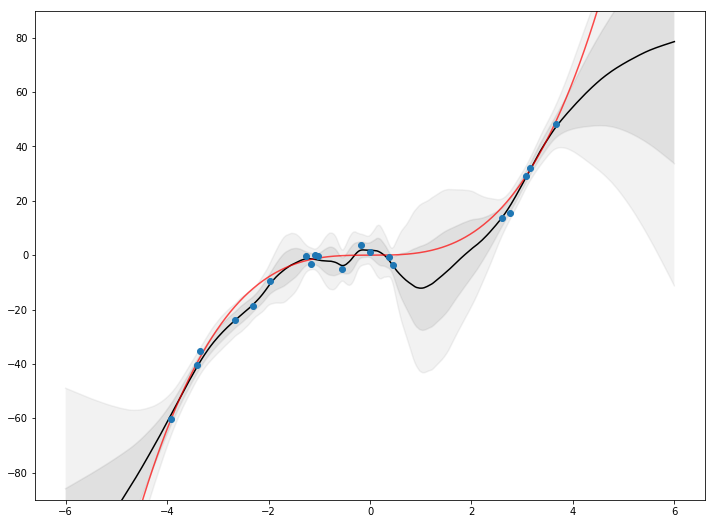

In [6]:
upper1 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) + np.std(predictions_ksgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_ksgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) - np.std(predictions_ksgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_ksgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(12,9))
plt.plot(grid,np.mean(predictions_ksgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.12)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-90,90)



### KSGFS

In [12]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgfs




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=False)

optim = ksgfs.optim.KSGFS(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon=0.0009, l2=1e-3, invert_every=1)


predictions_ksgfs = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(10000):

    running_loss = 0
    
    optim.update_curvature(x)
    
    network.zero_grad()
    output = network(x)
    loss = (1./(2*9))*criterion(output, y)
    loss.backward()
    optim.step()



    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 300) & (t % 100 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions_ksgfs = torch.cat((predictions_ksgfs, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 666.9876
Epoch 1 - loss: 666.1740
Epoch 2 - loss: 665.0924
Epoch 3 - loss: 664.3105
Epoch 4 - loss: 663.8389
Epoch 5 - loss: 662.6628
Epoch 6 - loss: 661.9877
Epoch 7 - loss: 660.8097
Epoch 8 - loss: 659.8745
Epoch 9 - loss: 658.3245
Epoch 10 - loss: 657.4114
Epoch 11 - loss: 656.7114
Epoch 12 - loss: 655.7708
Epoch 13 - loss: 654.7866
Epoch 14 - loss: 653.5470
Epoch 15 - loss: 653.1305
Epoch 16 - loss: 652.3573
Epoch 17 - loss: 651.7170
Epoch 18 - loss: 650.7225
Epoch 19 - loss: 649.6812
Epoch 20 - loss: 649.4435
Epoch 21 - loss: 648.5079
Epoch 22 - loss: 648.2531
Epoch 23 - loss: 647.8797
Epoch 24 - loss: 646.5809
Epoch 25 - loss: 645.7083
Epoch 26 - loss: 645.4126
Epoch 27 - loss: 645.1603
Epoch 28 - loss: 644.5040
Epoch 29 - loss: 644.5678
Epoch 30 - loss: 643.8096
Epoch 31 - loss: 643.2961
Epoch 32 - loss: 642.5876
Epoch 33 - loss: 642.1985
Epoch 34 - loss: 641.3745
Epoch 35 - loss: 641.0927
Epoch 36 - loss: 640.5136
Epoch 37 - loss: 639.7312
Epoch 38 - loss: 638.8

Epoch 312 - loss: 434.1974
Epoch 313 - loss: 433.5501
Epoch 314 - loss: 432.9845
Epoch 315 - loss: 432.3244
Epoch 316 - loss: 431.7274
Epoch 317 - loss: 430.9608
Epoch 318 - loss: 429.3595
Epoch 319 - loss: 428.8852
Epoch 320 - loss: 428.0028
Epoch 321 - loss: 427.3140
Epoch 322 - loss: 426.3018
Epoch 323 - loss: 425.9514
Epoch 324 - loss: 424.8705
Epoch 325 - loss: 424.1349
Epoch 326 - loss: 423.7260
Epoch 327 - loss: 423.3056
Epoch 328 - loss: 422.8197
Epoch 329 - loss: 422.8979
Epoch 330 - loss: 422.0582
Epoch 331 - loss: 421.0357
Epoch 332 - loss: 419.9380
Epoch 333 - loss: 419.5958
Epoch 334 - loss: 419.2374
Epoch 335 - loss: 418.5075
Epoch 336 - loss: 417.5690
Epoch 337 - loss: 417.1363
Epoch 338 - loss: 416.3984
Epoch 339 - loss: 415.2553
Epoch 340 - loss: 414.3555
Epoch 341 - loss: 413.3367
Epoch 342 - loss: 412.5251
Epoch 343 - loss: 411.9776
Epoch 344 - loss: 411.9853
Epoch 345 - loss: 411.6262
Epoch 346 - loss: 410.8114
Epoch 347 - loss: 410.4094
Epoch 348 - loss: 410.8668
E

Epoch 629 - loss: 229.4228
Epoch 630 - loss: 229.0962
Epoch 631 - loss: 228.5227
Epoch 632 - loss: 227.8579
Epoch 633 - loss: 228.2304
Epoch 634 - loss: 227.6265
Epoch 635 - loss: 227.4882
Epoch 636 - loss: 227.0556
Epoch 637 - loss: 226.0699
Epoch 638 - loss: 226.1043
Epoch 639 - loss: 224.8743
Epoch 640 - loss: 224.1787
Epoch 641 - loss: 223.6307
Epoch 642 - loss: 223.3468
Epoch 643 - loss: 223.0833
Epoch 644 - loss: 222.7809
Epoch 645 - loss: 222.9082
Epoch 646 - loss: 222.2685
Epoch 647 - loss: 221.8123
Epoch 648 - loss: 221.0878
Epoch 649 - loss: 220.7017
Epoch 650 - loss: 219.9112
Epoch 651 - loss: 219.6040
Epoch 652 - loss: 219.6479
Epoch 653 - loss: 219.2675
Epoch 654 - loss: 218.7347
Epoch 655 - loss: 218.5610
Epoch 656 - loss: 218.1057
Epoch 657 - loss: 217.5592
Epoch 658 - loss: 216.5267
Epoch 659 - loss: 216.0650
Epoch 660 - loss: 215.8599
Epoch 661 - loss: 215.3179
Epoch 662 - loss: 214.4959
Epoch 663 - loss: 214.7287
Epoch 664 - loss: 214.1852
Epoch 665 - loss: 213.1187
E

Epoch 943 - loss: 138.0537
Epoch 944 - loss: 137.6043
Epoch 945 - loss: 137.3861
Epoch 946 - loss: 137.1073
Epoch 947 - loss: 136.6888
Epoch 948 - loss: 136.5717
Epoch 949 - loss: 136.3873
Epoch 950 - loss: 136.2492
Epoch 951 - loss: 136.0657
Epoch 952 - loss: 135.8906
Epoch 953 - loss: 135.8841
Epoch 954 - loss: 135.5572
Epoch 955 - loss: 135.4387
Epoch 956 - loss: 135.3231
Epoch 957 - loss: 135.1811
Epoch 958 - loss: 135.2363
Epoch 959 - loss: 135.0802
Epoch 960 - loss: 134.7083
Epoch 961 - loss: 134.6181
Epoch 962 - loss: 134.3223
Epoch 963 - loss: 133.9086
Epoch 964 - loss: 133.5690
Epoch 965 - loss: 133.2718
Epoch 966 - loss: 133.3319
Epoch 967 - loss: 133.5225
Epoch 968 - loss: 133.1465
Epoch 969 - loss: 132.8103
Epoch 970 - loss: 132.6441
Epoch 971 - loss: 132.4890
Epoch 972 - loss: 132.3575
Epoch 973 - loss: 132.2655
Epoch 974 - loss: 132.3358
Epoch 975 - loss: 132.3935
Epoch 976 - loss: 132.3912
Epoch 977 - loss: 132.1013
Epoch 978 - loss: 132.1203
Epoch 979 - loss: 132.1750
E

Epoch 1244 - loss: 97.9087
Epoch 1245 - loss: 97.8932
Epoch 1246 - loss: 97.6955
Epoch 1247 - loss: 97.9298
Epoch 1248 - loss: 97.8693
Epoch 1249 - loss: 97.6767
Epoch 1250 - loss: 97.5917
Epoch 1251 - loss: 97.4990
Epoch 1252 - loss: 97.3780
Epoch 1253 - loss: 97.1816
Epoch 1254 - loss: 97.1855
Epoch 1255 - loss: 97.0563
Epoch 1256 - loss: 97.1034
Epoch 1257 - loss: 97.0773
Epoch 1258 - loss: 96.9154
Epoch 1259 - loss: 96.8697
Epoch 1260 - loss: 96.7607
Epoch 1261 - loss: 96.8272
Epoch 1262 - loss: 96.5882
Epoch 1263 - loss: 96.6801
Epoch 1264 - loss: 96.5199
Epoch 1265 - loss: 96.6820
Epoch 1266 - loss: 96.5747
Epoch 1267 - loss: 96.4661
Epoch 1268 - loss: 96.3792
Epoch 1269 - loss: 96.1255
Epoch 1270 - loss: 95.9116
Epoch 1271 - loss: 95.8334
Epoch 1272 - loss: 95.5998
Epoch 1273 - loss: 95.4671
Epoch 1274 - loss: 95.1815
Epoch 1275 - loss: 95.0763
Epoch 1276 - loss: 94.9220
Epoch 1277 - loss: 94.7958
Epoch 1278 - loss: 94.7060
Epoch 1279 - loss: 94.6650
Epoch 1280 - loss: 94.4613
E

Epoch 1553 - loss: 71.7244
Epoch 1554 - loss: 71.5842
Epoch 1555 - loss: 71.1894
Epoch 1556 - loss: 71.2098
Epoch 1557 - loss: 71.0087
Epoch 1558 - loss: 70.7502
Epoch 1559 - loss: 70.5303
Epoch 1560 - loss: 70.5205
Epoch 1561 - loss: 70.3561
Epoch 1562 - loss: 70.1480
Epoch 1563 - loss: 70.0347
Epoch 1564 - loss: 69.8015
Epoch 1565 - loss: 69.8026
Epoch 1566 - loss: 69.6472
Epoch 1567 - loss: 69.5910
Epoch 1568 - loss: 69.3329
Epoch 1569 - loss: 69.1822
Epoch 1570 - loss: 69.0093
Epoch 1571 - loss: 68.7166
Epoch 1572 - loss: 68.6815
Epoch 1573 - loss: 68.6689
Epoch 1574 - loss: 68.5487
Epoch 1575 - loss: 68.2700
Epoch 1576 - loss: 68.3094
Epoch 1577 - loss: 68.1656
Epoch 1578 - loss: 68.0813
Epoch 1579 - loss: 67.8690
Epoch 1580 - loss: 67.7071
Epoch 1581 - loss: 67.7273
Epoch 1582 - loss: 67.9603
Epoch 1583 - loss: 67.8569
Epoch 1584 - loss: 67.8130
Epoch 1585 - loss: 67.6371
Epoch 1586 - loss: 67.8555
Epoch 1587 - loss: 67.7504
Epoch 1588 - loss: 67.5402
Epoch 1589 - loss: 67.4647
E

Epoch 1859 - loss: 50.7004
Epoch 1860 - loss: 50.6984
Epoch 1861 - loss: 50.7287
Epoch 1862 - loss: 50.7900
Epoch 1863 - loss: 50.7676
Epoch 1864 - loss: 50.7753
Epoch 1865 - loss: 50.7417
Epoch 1866 - loss: 50.6178
Epoch 1867 - loss: 50.6073
Epoch 1868 - loss: 50.4529
Epoch 1869 - loss: 50.3459
Epoch 1870 - loss: 50.3697
Epoch 1871 - loss: 50.2793
Epoch 1872 - loss: 50.3015
Epoch 1873 - loss: 50.3190
Epoch 1874 - loss: 50.2227
Epoch 1875 - loss: 50.1156
Epoch 1876 - loss: 49.9070
Epoch 1877 - loss: 49.7064
Epoch 1878 - loss: 49.6088
Epoch 1879 - loss: 49.7888
Epoch 1880 - loss: 49.7046
Epoch 1881 - loss: 49.6402
Epoch 1882 - loss: 49.3762
Epoch 1883 - loss: 49.2767
Epoch 1884 - loss: 49.1834
Epoch 1885 - loss: 49.1474
Epoch 1886 - loss: 49.2276
Epoch 1887 - loss: 49.3025
Epoch 1888 - loss: 49.3525
Epoch 1889 - loss: 49.3581
Epoch 1890 - loss: 49.3056
Epoch 1891 - loss: 49.1483
Epoch 1892 - loss: 48.9331
Epoch 1893 - loss: 48.8113
Epoch 1894 - loss: 48.7928
Epoch 1895 - loss: 48.7864
E

Epoch 2177 - loss: 38.0513
Epoch 2178 - loss: 37.9610
Epoch 2179 - loss: 37.8203
Epoch 2180 - loss: 37.8034
Epoch 2181 - loss: 37.8199
Epoch 2182 - loss: 37.7547
Epoch 2183 - loss: 37.7826
Epoch 2184 - loss: 37.5633
Epoch 2185 - loss: 37.2869
Epoch 2186 - loss: 37.3074
Epoch 2187 - loss: 37.2136
Epoch 2188 - loss: 37.0569
Epoch 2189 - loss: 37.1009
Epoch 2190 - loss: 36.9060
Epoch 2191 - loss: 36.8896
Epoch 2192 - loss: 36.8399
Epoch 2193 - loss: 36.9889
Epoch 2194 - loss: 37.0461
Epoch 2195 - loss: 37.1392
Epoch 2196 - loss: 37.0332
Epoch 2197 - loss: 37.0430
Epoch 2198 - loss: 37.1461
Epoch 2199 - loss: 37.0808
Epoch 2200 - loss: 36.8360
Epoch 2201 - loss: 36.8678
Epoch 2202 - loss: 36.8899
Epoch 2203 - loss: 36.8614
Epoch 2204 - loss: 36.8426
Epoch 2205 - loss: 36.8424
Epoch 2206 - loss: 36.7711
Epoch 2207 - loss: 36.7802
Epoch 2208 - loss: 36.6603
Epoch 2209 - loss: 36.5580
Epoch 2210 - loss: 36.5447
Epoch 2211 - loss: 36.4740
Epoch 2212 - loss: 36.4826
Epoch 2213 - loss: 36.7513
E

Epoch 2483 - loss: 31.3660
Epoch 2484 - loss: 31.6144
Epoch 2485 - loss: 31.8029
Epoch 2486 - loss: 31.6869
Epoch 2487 - loss: 31.6830
Epoch 2488 - loss: 31.6328
Epoch 2489 - loss: 31.6350
Epoch 2490 - loss: 31.7391
Epoch 2491 - loss: 31.6542
Epoch 2492 - loss: 31.7716
Epoch 2493 - loss: 31.8816
Epoch 2494 - loss: 31.7355
Epoch 2495 - loss: 31.7183
Epoch 2496 - loss: 31.5413
Epoch 2497 - loss: 31.7316
Epoch 2498 - loss: 31.4961
Epoch 2499 - loss: 31.5548
Epoch 2500 - loss: 31.4860
Epoch 2501 - loss: 31.5227
Epoch 2502 - loss: 31.3723
Epoch 2503 - loss: 31.4531
Epoch 2504 - loss: 31.2954
Epoch 2505 - loss: 31.0324
Epoch 2506 - loss: 31.0474
Epoch 2507 - loss: 31.0337
Epoch 2508 - loss: 30.9655
Epoch 2509 - loss: 30.9162
Epoch 2510 - loss: 30.8567
Epoch 2511 - loss: 30.7702
Epoch 2512 - loss: 30.8018
Epoch 2513 - loss: 30.6886
Epoch 2514 - loss: 30.7044
Epoch 2515 - loss: 30.8582
Epoch 2516 - loss: 30.7421
Epoch 2517 - loss: 30.7854
Epoch 2518 - loss: 30.6846
Epoch 2519 - loss: 30.8385
E

Epoch 2801 - loss: 27.1391
Epoch 2802 - loss: 27.1602
Epoch 2803 - loss: 27.1577
Epoch 2804 - loss: 26.9620
Epoch 2805 - loss: 27.1489
Epoch 2806 - loss: 26.9293
Epoch 2807 - loss: 27.0376
Epoch 2808 - loss: 27.0504
Epoch 2809 - loss: 27.2201
Epoch 2810 - loss: 27.1811
Epoch 2811 - loss: 27.0690
Epoch 2812 - loss: 27.3525
Epoch 2813 - loss: 27.3197
Epoch 2814 - loss: 27.0565
Epoch 2815 - loss: 27.1114
Epoch 2816 - loss: 27.1977
Epoch 2817 - loss: 27.2363
Epoch 2818 - loss: 27.3562
Epoch 2819 - loss: 27.5568
Epoch 2820 - loss: 27.6249
Epoch 2821 - loss: 27.6411
Epoch 2822 - loss: 27.6447
Epoch 2823 - loss: 27.6166
Epoch 2824 - loss: 27.8696
Epoch 2825 - loss: 27.7141
Epoch 2826 - loss: 27.6101
Epoch 2827 - loss: 27.6909
Epoch 2828 - loss: 27.5736
Epoch 2829 - loss: 27.5075
Epoch 2830 - loss: 27.3726
Epoch 2831 - loss: 27.2187
Epoch 2832 - loss: 27.3281
Epoch 2833 - loss: 27.1937
Epoch 2834 - loss: 27.1264
Epoch 2835 - loss: 26.9277
Epoch 2836 - loss: 26.8272
Epoch 2837 - loss: 26.7849
E

Epoch 3115 - loss: 24.2751
Epoch 3116 - loss: 24.2257
Epoch 3117 - loss: 24.1403
Epoch 3118 - loss: 24.2556
Epoch 3119 - loss: 24.3210
Epoch 3120 - loss: 24.1458
Epoch 3121 - loss: 24.0606
Epoch 3122 - loss: 24.0442
Epoch 3123 - loss: 23.9743
Epoch 3124 - loss: 23.8361
Epoch 3125 - loss: 23.8628
Epoch 3126 - loss: 23.9561
Epoch 3127 - loss: 23.9468
Epoch 3128 - loss: 24.0381
Epoch 3129 - loss: 24.0687
Epoch 3130 - loss: 24.0798
Epoch 3131 - loss: 24.2199
Epoch 3132 - loss: 24.0489
Epoch 3133 - loss: 24.1563
Epoch 3134 - loss: 24.2354
Epoch 3135 - loss: 24.3593
Epoch 3136 - loss: 24.3366
Epoch 3137 - loss: 24.4549
Epoch 3138 - loss: 24.4269
Epoch 3139 - loss: 24.4960
Epoch 3140 - loss: 24.5243
Epoch 3141 - loss: 24.5429
Epoch 3142 - loss: 24.5153
Epoch 3143 - loss: 24.3949
Epoch 3144 - loss: 24.4718
Epoch 3145 - loss: 24.6438
Epoch 3146 - loss: 24.5426
Epoch 3147 - loss: 24.6881
Epoch 3148 - loss: 24.6635
Epoch 3149 - loss: 24.6353
Epoch 3150 - loss: 24.5996
Epoch 3151 - loss: 24.6316
E

Epoch 3421 - loss: 21.5817
Epoch 3422 - loss: 21.7048
Epoch 3423 - loss: 21.5623
Epoch 3424 - loss: 21.5926
Epoch 3425 - loss: 21.5793
Epoch 3426 - loss: 21.4601
Epoch 3427 - loss: 21.4032
Epoch 3428 - loss: 21.2556
Epoch 3429 - loss: 21.0080
Epoch 3430 - loss: 21.2336
Epoch 3431 - loss: 21.4120
Epoch 3432 - loss: 21.5528
Epoch 3433 - loss: 21.4149
Epoch 3434 - loss: 21.2957
Epoch 3435 - loss: 21.2837
Epoch 3436 - loss: 21.2669
Epoch 3437 - loss: 21.2067
Epoch 3438 - loss: 21.3001
Epoch 3439 - loss: 21.2717
Epoch 3440 - loss: 21.1875
Epoch 3441 - loss: 21.0720
Epoch 3442 - loss: 21.0049
Epoch 3443 - loss: 20.9757
Epoch 3444 - loss: 20.8721
Epoch 3445 - loss: 20.9629
Epoch 3446 - loss: 20.9629
Epoch 3447 - loss: 21.2182
Epoch 3448 - loss: 21.0754
Epoch 3449 - loss: 21.1444
Epoch 3450 - loss: 21.4381
Epoch 3451 - loss: 21.1776
Epoch 3452 - loss: 21.5467
Epoch 3453 - loss: 21.4173
Epoch 3454 - loss: 21.7290
Epoch 3455 - loss: 21.5720
Epoch 3456 - loss: 21.5732
Epoch 3457 - loss: 21.4219
E

Epoch 3728 - loss: 18.2689
Epoch 3729 - loss: 18.1905
Epoch 3730 - loss: 18.2043
Epoch 3731 - loss: 18.4277
Epoch 3732 - loss: 18.0711
Epoch 3733 - loss: 17.9708
Epoch 3734 - loss: 17.9295
Epoch 3735 - loss: 17.9609
Epoch 3736 - loss: 17.9254
Epoch 3737 - loss: 17.8496
Epoch 3738 - loss: 17.8688
Epoch 3739 - loss: 17.8279
Epoch 3740 - loss: 17.8898
Epoch 3741 - loss: 17.6424
Epoch 3742 - loss: 17.6010
Epoch 3743 - loss: 17.6318
Epoch 3744 - loss: 17.6450
Epoch 3745 - loss: 17.5488
Epoch 3746 - loss: 17.5208
Epoch 3747 - loss: 17.4842
Epoch 3748 - loss: 17.4971
Epoch 3749 - loss: 17.4603
Epoch 3750 - loss: 17.1578
Epoch 3751 - loss: 17.1296
Epoch 3752 - loss: 17.1802
Epoch 3753 - loss: 17.1049
Epoch 3754 - loss: 17.1339
Epoch 3755 - loss: 17.0535
Epoch 3756 - loss: 17.1452
Epoch 3757 - loss: 17.2647
Epoch 3758 - loss: 17.2712
Epoch 3759 - loss: 17.1590
Epoch 3760 - loss: 17.2347
Epoch 3761 - loss: 17.2031
Epoch 3762 - loss: 17.2157
Epoch 3763 - loss: 17.1807
Epoch 3764 - loss: 17.1449
E

Epoch 4046 - loss: 16.4242
Epoch 4047 - loss: 16.3901
Epoch 4048 - loss: 16.4261
Epoch 4049 - loss: 16.4025
Epoch 4050 - loss: 16.5111
Epoch 4051 - loss: 16.5761
Epoch 4052 - loss: 16.7184
Epoch 4053 - loss: 16.7445
Epoch 4054 - loss: 16.7182
Epoch 4055 - loss: 16.7316
Epoch 4056 - loss: 16.9408
Epoch 4057 - loss: 16.8492
Epoch 4058 - loss: 16.8281
Epoch 4059 - loss: 16.8416
Epoch 4060 - loss: 16.8451
Epoch 4061 - loss: 16.7806
Epoch 4062 - loss: 16.7798
Epoch 4063 - loss: 16.7964
Epoch 4064 - loss: 16.8183
Epoch 4065 - loss: 16.8166
Epoch 4066 - loss: 16.8880
Epoch 4067 - loss: 16.9243
Epoch 4068 - loss: 16.8113
Epoch 4069 - loss: 16.6051
Epoch 4070 - loss: 16.6860
Epoch 4071 - loss: 16.7368
Epoch 4072 - loss: 16.7586
Epoch 4073 - loss: 16.7193
Epoch 4074 - loss: 16.6122
Epoch 4075 - loss: 16.5983
Epoch 4076 - loss: 16.5265
Epoch 4077 - loss: 16.4267
Epoch 4078 - loss: 16.4846
Epoch 4079 - loss: 16.4910
Epoch 4080 - loss: 16.3841
Epoch 4081 - loss: 16.3913
Epoch 4082 - loss: 16.3988
E

Epoch 4357 - loss: 17.4836
Epoch 4358 - loss: 17.3601
Epoch 4359 - loss: 17.7166
Epoch 4360 - loss: 17.5066
Epoch 4361 - loss: 17.0995
Epoch 4362 - loss: 17.0110
Epoch 4363 - loss: 17.0384
Epoch 4364 - loss: 16.8568
Epoch 4365 - loss: 16.9209
Epoch 4366 - loss: 16.8486
Epoch 4367 - loss: 16.9827
Epoch 4368 - loss: 16.9154
Epoch 4369 - loss: 16.8377
Epoch 4370 - loss: 16.9155
Epoch 4371 - loss: 17.1318
Epoch 4372 - loss: 17.2164
Epoch 4373 - loss: 17.2908
Epoch 4374 - loss: 17.3534
Epoch 4375 - loss: 17.5889
Epoch 4376 - loss: 17.4331
Epoch 4377 - loss: 17.2774
Epoch 4378 - loss: 17.4865
Epoch 4379 - loss: 17.2101
Epoch 4380 - loss: 17.3780
Epoch 4381 - loss: 17.3250
Epoch 4382 - loss: 17.1529
Epoch 4383 - loss: 16.8991
Epoch 4384 - loss: 16.6505
Epoch 4385 - loss: 16.4513
Epoch 4386 - loss: 16.7993
Epoch 4387 - loss: 16.7823
Epoch 4388 - loss: 16.8519
Epoch 4389 - loss: 16.4165
Epoch 4390 - loss: 16.5201
Epoch 4391 - loss: 16.3289
Epoch 4392 - loss: 16.6105
Epoch 4393 - loss: 16.6205
E

Epoch 4675 - loss: 14.6821
Epoch 4676 - loss: 14.6170
Epoch 4677 - loss: 14.5623
Epoch 4678 - loss: 14.6057
Epoch 4679 - loss: 14.7565
Epoch 4680 - loss: 14.5883
Epoch 4681 - loss: 14.4989
Epoch 4682 - loss: 14.3945
Epoch 4683 - loss: 14.2682
Epoch 4684 - loss: 14.2684
Epoch 4685 - loss: 14.2463
Epoch 4686 - loss: 14.2285
Epoch 4687 - loss: 14.3681
Epoch 4688 - loss: 14.2740
Epoch 4689 - loss: 14.3828
Epoch 4690 - loss: 14.3179
Epoch 4691 - loss: 14.3016
Epoch 4692 - loss: 14.3484
Epoch 4693 - loss: 14.4787
Epoch 4694 - loss: 14.4968
Epoch 4695 - loss: 14.4877
Epoch 4696 - loss: 14.4546
Epoch 4697 - loss: 14.5821
Epoch 4698 - loss: 14.5843
Epoch 4699 - loss: 14.6114
Epoch 4700 - loss: 14.5148
Epoch 4701 - loss: 14.5783
Epoch 4702 - loss: 14.6903
Epoch 4703 - loss: 14.5933
Epoch 4704 - loss: 14.4444
Epoch 4705 - loss: 14.5041
Epoch 4706 - loss: 14.5757
Epoch 4707 - loss: 14.6742
Epoch 4708 - loss: 14.5973
Epoch 4709 - loss: 14.6558
Epoch 4710 - loss: 14.6916
Epoch 4711 - loss: 14.7291
E

Epoch 4983 - loss: 14.4016
Epoch 4984 - loss: 14.4186
Epoch 4985 - loss: 14.6664
Epoch 4986 - loss: 14.5644
Epoch 4987 - loss: 14.2757
Epoch 4988 - loss: 14.0892
Epoch 4989 - loss: 14.0338
Epoch 4990 - loss: 13.9502
Epoch 4991 - loss: 13.7813
Epoch 4992 - loss: 13.6810
Epoch 4993 - loss: 13.5375
Epoch 4994 - loss: 13.4905
Epoch 4995 - loss: 13.5658
Epoch 4996 - loss: 13.6002
Epoch 4997 - loss: 13.6320
Epoch 4998 - loss: 13.6850
Epoch 4999 - loss: 13.6252
Epoch 5000 - loss: 13.6776
Epoch 5001 - loss: 13.6650
Epoch 5002 - loss: 13.6194
Epoch 5003 - loss: 13.6257
Epoch 5004 - loss: 13.6747
Epoch 5005 - loss: 13.6950
Epoch 5006 - loss: 13.6851
Epoch 5007 - loss: 13.6564
Epoch 5008 - loss: 13.6464
Epoch 5009 - loss: 13.6897
Epoch 5010 - loss: 13.6420
Epoch 5011 - loss: 13.5965
Epoch 5012 - loss: 13.5755
Epoch 5013 - loss: 13.6779
Epoch 5014 - loss: 13.8405
Epoch 5015 - loss: 14.1142
Epoch 5016 - loss: 14.1018
Epoch 5017 - loss: 14.2199
Epoch 5018 - loss: 14.1721
Epoch 5019 - loss: 13.9478
E

Epoch 5292 - loss: 12.7438
Epoch 5293 - loss: 12.7530
Epoch 5294 - loss: 12.5776
Epoch 5295 - loss: 12.7093
Epoch 5296 - loss: 12.7957
Epoch 5297 - loss: 12.8980
Epoch 5298 - loss: 12.8058
Epoch 5299 - loss: 12.7455
Epoch 5300 - loss: 12.7854
Epoch 5301 - loss: 12.7496
Epoch 5302 - loss: 12.8092
Epoch 5303 - loss: 12.7831
Epoch 5304 - loss: 12.7761
Epoch 5305 - loss: 12.6268
Epoch 5306 - loss: 12.5994
Epoch 5307 - loss: 12.6433
Epoch 5308 - loss: 12.7105
Epoch 5309 - loss: 12.6758
Epoch 5310 - loss: 12.5846
Epoch 5311 - loss: 12.6709
Epoch 5312 - loss: 12.5943
Epoch 5313 - loss: 12.5721
Epoch 5314 - loss: 12.5776
Epoch 5315 - loss: 12.5727
Epoch 5316 - loss: 12.5520
Epoch 5317 - loss: 12.4738
Epoch 5318 - loss: 12.4866
Epoch 5319 - loss: 12.4889
Epoch 5320 - loss: 12.4575
Epoch 5321 - loss: 12.5083
Epoch 5322 - loss: 12.4724
Epoch 5323 - loss: 12.4601
Epoch 5324 - loss: 12.3654
Epoch 5325 - loss: 12.3861
Epoch 5326 - loss: 12.3938
Epoch 5327 - loss: 12.3390
Epoch 5328 - loss: 12.4044
E

Epoch 5599 - loss: 12.2460
Epoch 5600 - loss: 12.4504
Epoch 5601 - loss: 12.4544
Epoch 5602 - loss: 12.1692
Epoch 5603 - loss: 12.2965
Epoch 5604 - loss: 12.3006
Epoch 5605 - loss: 12.0951
Epoch 5606 - loss: 11.9246
Epoch 5607 - loss: 11.8262
Epoch 5608 - loss: 11.8068
Epoch 5609 - loss: 11.7230
Epoch 5610 - loss: 11.6742
Epoch 5611 - loss: 11.7505
Epoch 5612 - loss: 11.9273
Epoch 5613 - loss: 11.9342
Epoch 5614 - loss: 11.8742
Epoch 5615 - loss: 11.8394
Epoch 5616 - loss: 11.8377
Epoch 5617 - loss: 11.9118
Epoch 5618 - loss: 11.9402
Epoch 5619 - loss: 12.0684
Epoch 5620 - loss: 12.1068
Epoch 5621 - loss: 12.0384
Epoch 5622 - loss: 11.9119
Epoch 5623 - loss: 11.9485
Epoch 5624 - loss: 11.7641
Epoch 5625 - loss: 11.9903
Epoch 5626 - loss: 11.8744
Epoch 5627 - loss: 11.7900
Epoch 5628 - loss: 11.6731
Epoch 5629 - loss: 11.6099
Epoch 5630 - loss: 11.5826
Epoch 5631 - loss: 11.6128
Epoch 5632 - loss: 11.6178
Epoch 5633 - loss: 11.6097
Epoch 5634 - loss: 11.5708
Epoch 5635 - loss: 11.5549
E

Epoch 5919 - loss: 11.3124
Epoch 5920 - loss: 11.6074
Epoch 5921 - loss: 11.8485
Epoch 5922 - loss: 11.4746
Epoch 5923 - loss: 11.3042
Epoch 5924 - loss: 11.2996
Epoch 5925 - loss: 11.2907
Epoch 5926 - loss: 11.2203
Epoch 5927 - loss: 11.0416
Epoch 5928 - loss: 11.3819
Epoch 5929 - loss: 11.6442
Epoch 5930 - loss: 11.5472
Epoch 5931 - loss: 11.3403
Epoch 5932 - loss: 11.4828
Epoch 5933 - loss: 11.6471
Epoch 5934 - loss: 11.6779
Epoch 5935 - loss: 11.4377
Epoch 5936 - loss: 11.3366
Epoch 5937 - loss: 11.3855
Epoch 5938 - loss: 11.1475
Epoch 5939 - loss: 10.9603
Epoch 5940 - loss: 11.1212
Epoch 5941 - loss: 11.0239
Epoch 5942 - loss: 10.8471
Epoch 5943 - loss: 10.8033
Epoch 5944 - loss: 10.8375
Epoch 5945 - loss: 10.7974
Epoch 5946 - loss: 10.7663
Epoch 5947 - loss: 10.7395
Epoch 5948 - loss: 10.7466
Epoch 5949 - loss: 10.7534
Epoch 5950 - loss: 10.7422
Epoch 5951 - loss: 10.7498
Epoch 5952 - loss: 10.7533
Epoch 5953 - loss: 10.7022
Epoch 5954 - loss: 10.6314
Epoch 5955 - loss: 10.6647
E

Epoch 6235 - loss: 10.4648
Epoch 6236 - loss: 10.6086
Epoch 6237 - loss: 10.6757
Epoch 6238 - loss: 10.6660
Epoch 6239 - loss: 10.7831
Epoch 6240 - loss: 10.4455
Epoch 6241 - loss: 10.6488
Epoch 6242 - loss: 10.5813
Epoch 6243 - loss: 10.8931
Epoch 6244 - loss: 10.6840
Epoch 6245 - loss: 10.8421
Epoch 6246 - loss: 10.8249
Epoch 6247 - loss: 10.7528
Epoch 6248 - loss: 10.6585
Epoch 6249 - loss: 10.8759
Epoch 6250 - loss: 10.4483
Epoch 6251 - loss: 10.4274
Epoch 6252 - loss: 10.6251
Epoch 6253 - loss: 10.5177
Epoch 6254 - loss: 10.6968
Epoch 6255 - loss: 10.4963
Epoch 6256 - loss: 10.3798
Epoch 6257 - loss: 10.4627
Epoch 6258 - loss: 10.6025
Epoch 6259 - loss: 10.0374
Epoch 6260 - loss: 9.9546
Epoch 6261 - loss: 9.9982
Epoch 6262 - loss: 9.7075
Epoch 6263 - loss: 9.5702
Epoch 6264 - loss: 9.5739
Epoch 6265 - loss: 9.5627
Epoch 6266 - loss: 9.4692
Epoch 6267 - loss: 9.4228
Epoch 6268 - loss: 9.4285
Epoch 6269 - loss: 9.4434
Epoch 6270 - loss: 9.4778
Epoch 6271 - loss: 9.4583
Epoch 6272 - 

Epoch 6558 - loss: 9.9642
Epoch 6559 - loss: 10.0512
Epoch 6560 - loss: 9.8756
Epoch 6561 - loss: 9.9359
Epoch 6562 - loss: 9.7884
Epoch 6563 - loss: 9.7650
Epoch 6564 - loss: 9.9182
Epoch 6565 - loss: 9.6494
Epoch 6566 - loss: 9.3965
Epoch 6567 - loss: 9.3049
Epoch 6568 - loss: 9.2100
Epoch 6569 - loss: 9.2208
Epoch 6570 - loss: 9.0989
Epoch 6571 - loss: 9.0271
Epoch 6572 - loss: 9.2044
Epoch 6573 - loss: 9.2277
Epoch 6574 - loss: 9.1234
Epoch 6575 - loss: 8.9850
Epoch 6576 - loss: 9.0854
Epoch 6577 - loss: 9.2183
Epoch 6578 - loss: 9.1080
Epoch 6579 - loss: 9.1524
Epoch 6580 - loss: 9.2682
Epoch 6581 - loss: 9.1828
Epoch 6582 - loss: 9.2069
Epoch 6583 - loss: 9.1913
Epoch 6584 - loss: 9.0929
Epoch 6585 - loss: 9.1779
Epoch 6586 - loss: 9.1408
Epoch 6587 - loss: 9.1267
Epoch 6588 - loss: 9.2093
Epoch 6589 - loss: 9.1489
Epoch 6590 - loss: 9.1174
Epoch 6591 - loss: 9.2170
Epoch 6592 - loss: 9.1673
Epoch 6593 - loss: 9.1142
Epoch 6594 - loss: 9.1272
Epoch 6595 - loss: 9.2059
Epoch 6596 

Epoch 6878 - loss: 8.9567
Epoch 6879 - loss: 8.8671
Epoch 6880 - loss: 9.2886
Epoch 6881 - loss: 8.9321
Epoch 6882 - loss: 9.0859
Epoch 6883 - loss: 9.0657
Epoch 6884 - loss: 8.7330
Epoch 6885 - loss: 8.6754
Epoch 6886 - loss: 8.5049
Epoch 6887 - loss: 8.4475
Epoch 6888 - loss: 8.3533
Epoch 6889 - loss: 8.4181
Epoch 6890 - loss: 8.3729
Epoch 6891 - loss: 8.2883
Epoch 6892 - loss: 8.2988
Epoch 6893 - loss: 8.2546
Epoch 6894 - loss: 8.1876
Epoch 6895 - loss: 8.2899
Epoch 6896 - loss: 8.3702
Epoch 6897 - loss: 8.5142
Epoch 6898 - loss: 8.3916
Epoch 6899 - loss: 8.5498
Epoch 6900 - loss: 8.8247
Epoch 6901 - loss: 8.6669
Epoch 6902 - loss: 8.9868
Epoch 6903 - loss: 9.0794
Epoch 6904 - loss: 9.4811
Epoch 6905 - loss: 9.5081
Epoch 6906 - loss: 9.4193
Epoch 6907 - loss: 9.6093
Epoch 6908 - loss: 9.1067
Epoch 6909 - loss: 8.6925
Epoch 6910 - loss: 8.8208
Epoch 6911 - loss: 9.0214
Epoch 6912 - loss: 9.3408
Epoch 6913 - loss: 9.4035
Epoch 6914 - loss: 9.0284
Epoch 6915 - loss: 8.8757
Epoch 6916 -

Epoch 7201 - loss: 8.4954
Epoch 7202 - loss: 8.4610
Epoch 7203 - loss: 8.1524
Epoch 7204 - loss: 8.2552
Epoch 7205 - loss: 8.0740
Epoch 7206 - loss: 8.0836
Epoch 7207 - loss: 8.0768
Epoch 7208 - loss: 8.0552
Epoch 7209 - loss: 8.0269
Epoch 7210 - loss: 8.0820
Epoch 7211 - loss: 8.0899
Epoch 7212 - loss: 7.8516
Epoch 7213 - loss: 7.8877
Epoch 7214 - loss: 7.9690
Epoch 7215 - loss: 7.9984
Epoch 7216 - loss: 7.9634
Epoch 7217 - loss: 7.8681
Epoch 7218 - loss: 7.8191
Epoch 7219 - loss: 7.8342
Epoch 7220 - loss: 7.8298
Epoch 7221 - loss: 7.8567
Epoch 7222 - loss: 7.7813
Epoch 7223 - loss: 7.9158
Epoch 7224 - loss: 8.1118
Epoch 7225 - loss: 7.9729
Epoch 7226 - loss: 7.9756
Epoch 7227 - loss: 8.1526
Epoch 7228 - loss: 8.0215
Epoch 7229 - loss: 7.9625
Epoch 7230 - loss: 8.0175
Epoch 7231 - loss: 8.0193
Epoch 7232 - loss: 8.2122
Epoch 7233 - loss: 8.2211
Epoch 7234 - loss: 8.4445
Epoch 7235 - loss: 8.3246
Epoch 7236 - loss: 8.2404
Epoch 7237 - loss: 8.0038
Epoch 7238 - loss: 7.8191
Epoch 7239 -

Epoch 7520 - loss: 8.0165
Epoch 7521 - loss: 7.9164
Epoch 7522 - loss: 7.9880
Epoch 7523 - loss: 8.0095
Epoch 7524 - loss: 8.0136
Epoch 7525 - loss: 8.0003
Epoch 7526 - loss: 7.7785
Epoch 7527 - loss: 7.8248
Epoch 7528 - loss: 7.7497
Epoch 7529 - loss: 7.6499
Epoch 7530 - loss: 7.6948
Epoch 7531 - loss: 7.6033
Epoch 7532 - loss: 7.6938
Epoch 7533 - loss: 7.8264
Epoch 7534 - loss: 7.7677
Epoch 7535 - loss: 7.9160
Epoch 7536 - loss: 7.8965
Epoch 7537 - loss: 7.8358
Epoch 7538 - loss: 7.7155
Epoch 7539 - loss: 7.6384
Epoch 7540 - loss: 7.7129
Epoch 7541 - loss: 7.7874
Epoch 7542 - loss: 8.0247
Epoch 7543 - loss: 8.2023
Epoch 7544 - loss: 8.2050
Epoch 7545 - loss: 7.9196
Epoch 7546 - loss: 7.9660
Epoch 7547 - loss: 8.0480
Epoch 7548 - loss: 8.0343
Epoch 7549 - loss: 7.8641
Epoch 7550 - loss: 7.8936
Epoch 7551 - loss: 8.0075
Epoch 7552 - loss: 8.0217
Epoch 7553 - loss: 8.0406
Epoch 7554 - loss: 8.2614
Epoch 7555 - loss: 8.1430
Epoch 7556 - loss: 8.0607
Epoch 7557 - loss: 7.8389
Epoch 7558 -

Epoch 7837 - loss: 8.4351
Epoch 7838 - loss: 8.2971
Epoch 7839 - loss: 8.2224
Epoch 7840 - loss: 8.3488
Epoch 7841 - loss: 8.5192
Epoch 7842 - loss: 8.5951
Epoch 7843 - loss: 8.6057
Epoch 7844 - loss: 8.7105
Epoch 7845 - loss: 8.3706
Epoch 7846 - loss: 8.3041
Epoch 7847 - loss: 8.2200
Epoch 7848 - loss: 8.1239
Epoch 7849 - loss: 8.2633
Epoch 7850 - loss: 8.2751
Epoch 7851 - loss: 8.2443
Epoch 7852 - loss: 8.2162
Epoch 7853 - loss: 8.3147
Epoch 7854 - loss: 8.3073
Epoch 7855 - loss: 8.3199
Epoch 7856 - loss: 8.3013
Epoch 7857 - loss: 8.3266
Epoch 7858 - loss: 8.3043
Epoch 7859 - loss: 8.3155
Epoch 7860 - loss: 8.2712
Epoch 7861 - loss: 8.0959
Epoch 7862 - loss: 8.1961
Epoch 7863 - loss: 8.2666
Epoch 7864 - loss: 8.4134
Epoch 7865 - loss: 8.2487
Epoch 7866 - loss: 8.2684
Epoch 7867 - loss: 8.2398
Epoch 7868 - loss: 8.2677
Epoch 7869 - loss: 8.4705
Epoch 7870 - loss: 8.4258
Epoch 7871 - loss: 8.3136
Epoch 7872 - loss: 8.2747
Epoch 7873 - loss: 8.2991
Epoch 7874 - loss: 8.2416
Epoch 7875 -

Epoch 8164 - loss: 8.4942
Epoch 8165 - loss: 8.2425
Epoch 8166 - loss: 8.3540
Epoch 8167 - loss: 8.2059
Epoch 8168 - loss: 8.2380
Epoch 8169 - loss: 8.2984
Epoch 8170 - loss: 8.4574
Epoch 8171 - loss: 8.3512
Epoch 8172 - loss: 8.2934
Epoch 8173 - loss: 8.4314
Epoch 8174 - loss: 8.2392
Epoch 8175 - loss: 8.1982
Epoch 8176 - loss: 8.2481
Epoch 8177 - loss: 8.3851
Epoch 8178 - loss: 8.6344
Epoch 8179 - loss: 8.5664
Epoch 8180 - loss: 8.8240
Epoch 8181 - loss: 8.6739
Epoch 8182 - loss: 8.7239
Epoch 8183 - loss: 8.7110
Epoch 8184 - loss: 8.6716
Epoch 8185 - loss: 8.5114
Epoch 8186 - loss: 8.5129
Epoch 8187 - loss: 8.5905
Epoch 8188 - loss: 8.6447
Epoch 8189 - loss: 8.8378
Epoch 8190 - loss: 8.9497
Epoch 8191 - loss: 8.7214
Epoch 8192 - loss: 8.8368
Epoch 8193 - loss: 8.6022
Epoch 8194 - loss: 8.4760
Epoch 8195 - loss: 8.6816
Epoch 8196 - loss: 8.6187
Epoch 8197 - loss: 8.5126
Epoch 8198 - loss: 8.3584
Epoch 8199 - loss: 8.5007
Epoch 8200 - loss: 8.5368
Epoch 8201 - loss: 8.5867
Epoch 8202 -

Epoch 8493 - loss: 8.4849
Epoch 8494 - loss: 8.4127
Epoch 8495 - loss: 8.3653
Epoch 8496 - loss: 8.3168
Epoch 8497 - loss: 8.1788
Epoch 8498 - loss: 8.3464
Epoch 8499 - loss: 8.4770
Epoch 8500 - loss: 8.5091
Epoch 8501 - loss: 8.6455
Epoch 8502 - loss: 8.5674
Epoch 8503 - loss: 8.5801
Epoch 8504 - loss: 8.5105
Epoch 8505 - loss: 8.6307
Epoch 8506 - loss: 8.6492
Epoch 8507 - loss: 8.4547
Epoch 8508 - loss: 8.2489
Epoch 8509 - loss: 8.4038
Epoch 8510 - loss: 8.1715
Epoch 8511 - loss: 8.1401
Epoch 8512 - loss: 8.0665
Epoch 8513 - loss: 7.9358
Epoch 8514 - loss: 8.0134
Epoch 8515 - loss: 7.9155
Epoch 8516 - loss: 8.0331
Epoch 8517 - loss: 8.1393
Epoch 8518 - loss: 8.1076
Epoch 8519 - loss: 8.0307
Epoch 8520 - loss: 7.9754
Epoch 8521 - loss: 8.0862
Epoch 8522 - loss: 8.1332
Epoch 8523 - loss: 8.1045
Epoch 8524 - loss: 8.0504
Epoch 8525 - loss: 8.1220
Epoch 8526 - loss: 8.0044
Epoch 8527 - loss: 8.0499
Epoch 8528 - loss: 8.0029
Epoch 8529 - loss: 7.9527
Epoch 8530 - loss: 7.9497
Epoch 8531 -

Epoch 8819 - loss: 8.5254
Epoch 8820 - loss: 8.5481
Epoch 8821 - loss: 8.5516
Epoch 8822 - loss: 8.4478
Epoch 8823 - loss: 8.4871
Epoch 8824 - loss: 8.5366
Epoch 8825 - loss: 8.5002
Epoch 8826 - loss: 8.7185
Epoch 8827 - loss: 8.5057
Epoch 8828 - loss: 8.5905
Epoch 8829 - loss: 8.4983
Epoch 8830 - loss: 8.4285
Epoch 8831 - loss: 8.4180
Epoch 8832 - loss: 8.5350
Epoch 8833 - loss: 8.5654
Epoch 8834 - loss: 8.4930
Epoch 8835 - loss: 8.6498
Epoch 8836 - loss: 8.5461
Epoch 8837 - loss: 8.6451
Epoch 8838 - loss: 8.7351
Epoch 8839 - loss: 8.8110
Epoch 8840 - loss: 8.7974
Epoch 8841 - loss: 8.9333
Epoch 8842 - loss: 8.9287
Epoch 8843 - loss: 8.7991
Epoch 8844 - loss: 8.7645
Epoch 8845 - loss: 8.5930
Epoch 8846 - loss: 8.5172
Epoch 8847 - loss: 8.4205
Epoch 8848 - loss: 8.3919
Epoch 8849 - loss: 8.2087
Epoch 8850 - loss: 8.2919
Epoch 8851 - loss: 8.2947
Epoch 8852 - loss: 8.3218
Epoch 8853 - loss: 8.2606
Epoch 8854 - loss: 8.2268
Epoch 8855 - loss: 8.3134
Epoch 8856 - loss: 8.3536
Epoch 8857 -

Epoch 9141 - loss: 8.4918
Epoch 9142 - loss: 8.4195
Epoch 9143 - loss: 8.3318
Epoch 9144 - loss: 8.1010
Epoch 9145 - loss: 8.0711
Epoch 9146 - loss: 8.2129
Epoch 9147 - loss: 8.2447
Epoch 9148 - loss: 8.1708
Epoch 9149 - loss: 8.3651
Epoch 9150 - loss: 8.4043
Epoch 9151 - loss: 8.5926
Epoch 9152 - loss: 8.4962
Epoch 9153 - loss: 8.5969
Epoch 9154 - loss: 8.3561
Epoch 9155 - loss: 8.6363
Epoch 9156 - loss: 8.4781
Epoch 9157 - loss: 8.8950
Epoch 9158 - loss: 8.7023
Epoch 9159 - loss: 8.7447
Epoch 9160 - loss: 8.9695
Epoch 9161 - loss: 9.0009
Epoch 9162 - loss: 9.3870
Epoch 9163 - loss: 9.3390
Epoch 9164 - loss: 9.5070
Epoch 9165 - loss: 9.5729
Epoch 9166 - loss: 9.7767
Epoch 9167 - loss: 10.1574
Epoch 9168 - loss: 9.4435
Epoch 9169 - loss: 9.5649
Epoch 9170 - loss: 9.8467
Epoch 9171 - loss: 9.6625
Epoch 9172 - loss: 9.4722
Epoch 9173 - loss: 9.4632
Epoch 9174 - loss: 9.2533
Epoch 9175 - loss: 9.1325
Epoch 9176 - loss: 9.3225
Epoch 9177 - loss: 9.2372
Epoch 9178 - loss: 9.1365
Epoch 9179 

Epoch 9464 - loss: 7.6562
Epoch 9465 - loss: 7.6488
Epoch 9466 - loss: 7.7285
Epoch 9467 - loss: 7.7365
Epoch 9468 - loss: 7.5138
Epoch 9469 - loss: 7.5991
Epoch 9470 - loss: 7.5521
Epoch 9471 - loss: 7.5763
Epoch 9472 - loss: 7.6539
Epoch 9473 - loss: 7.6939
Epoch 9474 - loss: 7.5926
Epoch 9475 - loss: 7.6140
Epoch 9476 - loss: 7.7568
Epoch 9477 - loss: 7.9222
Epoch 9478 - loss: 7.9830
Epoch 9479 - loss: 7.9805
Epoch 9480 - loss: 8.1156
Epoch 9481 - loss: 7.9205
Epoch 9482 - loss: 7.9158
Epoch 9483 - loss: 7.9423
Epoch 9484 - loss: 7.8427
Epoch 9485 - loss: 7.7524
Epoch 9486 - loss: 7.6553
Epoch 9487 - loss: 7.6908
Epoch 9488 - loss: 7.7836
Epoch 9489 - loss: 7.9054
Epoch 9490 - loss: 8.0054
Epoch 9491 - loss: 7.9197
Epoch 9492 - loss: 8.0064
Epoch 9493 - loss: 8.0254
Epoch 9494 - loss: 8.0340
Epoch 9495 - loss: 8.1109
Epoch 9496 - loss: 8.0213
Epoch 9497 - loss: 7.6919
Epoch 9498 - loss: 7.5182
Epoch 9499 - loss: 7.4601
Epoch 9500 - loss: 7.5237
Epoch 9501 - loss: 7.4944
Epoch 9502 -

Epoch 9782 - loss: 7.1340
Epoch 9783 - loss: 7.3665
Epoch 9784 - loss: 7.2399
Epoch 9785 - loss: 7.1208
Epoch 9786 - loss: 7.1396
Epoch 9787 - loss: 7.0281
Epoch 9788 - loss: 7.1154
Epoch 9789 - loss: 7.0498
Epoch 9790 - loss: 7.0371
Epoch 9791 - loss: 6.9132
Epoch 9792 - loss: 6.9314
Epoch 9793 - loss: 6.9382
Epoch 9794 - loss: 6.9158
Epoch 9795 - loss: 6.9109
Epoch 9796 - loss: 6.7779
Epoch 9797 - loss: 6.8153
Epoch 9798 - loss: 6.8406
Epoch 9799 - loss: 6.8907
Epoch 9800 - loss: 6.8383
Epoch 9801 - loss: 6.8298
Epoch 9802 - loss: 6.7846
Epoch 9803 - loss: 6.7649
Epoch 9804 - loss: 6.7608
Epoch 9805 - loss: 6.7667
Epoch 9806 - loss: 6.6921
Epoch 9807 - loss: 6.7104
Epoch 9808 - loss: 6.7138
Epoch 9809 - loss: 6.6843
Epoch 9810 - loss: 6.6756
Epoch 9811 - loss: 6.6433
Epoch 9812 - loss: 6.6419
Epoch 9813 - loss: 6.7217
Epoch 9814 - loss: 6.6697
Epoch 9815 - loss: 6.6968
Epoch 9816 - loss: 6.7041
Epoch 9817 - loss: 6.7938
Epoch 9818 - loss: 6.7313
Epoch 9819 - loss: 6.7698
Epoch 9820 -

(-60, 60)

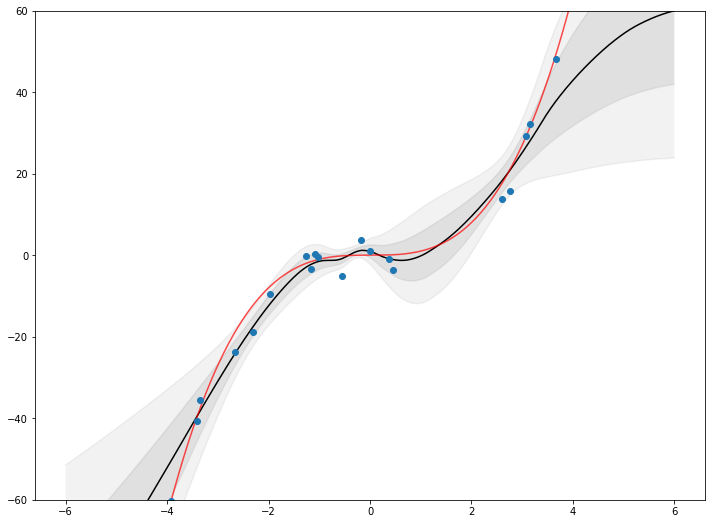

In [13]:
upper1 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) + np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) + 2 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
upper3 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) + 3 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)

lower1 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) - np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) - 2 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)
lower3 = np.mean(predictions_ksgfs[:,1:].detach().numpy(),1) - 3 * np.std(predictions_ksgfs[:,1:].detach().numpy(),1)


plt.figure(figsize=(12,9))
plt.plot(grid,np.mean(predictions_ksgfs[:,1:].detach().numpy(),1), 'black')
# plt.plot(grid,upper3,'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.12)
plt.plot(grid,lower2,'gray',alpha=0.1)
# plt.plot(grid,lower3,'black')
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,grid ** 3,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-60,60)



In [ ]:
predictions_ksgfs[:,1:].size()

## Sinus (Louizos, Welling (2016))

20 data points simulated as follows:
- 12 samples $x_i$ from $\mathcal{U}(0,0.6)$ and 8 samples from $\mathcal{U}(0.8,1)$
- $y = x_i + \epsilon_i + \sin(4(x_i + \epsilon_i)) + \sin(13(x_i + \epsilon_i))$ with $\epsilon_i \sim \mathcal{N}(0,0.0009)$

See https://arxiv.org/pdf/1603.04733.pdf

In [ ]:
import math
# Create simulated data set
x1 = torch.empty(12, 1).uniform_(0, 0.6)
x2 = torch.empty(8, 1).uniform_(0.8, 1)

x,_ = torch.cat((x1,x2),0).sort(0)

epsilon = torch.normal(torch.zeros_like(x),math.sqrt(0.0009))
y = x + epsilon + torch.sin(4*(x + epsilon)) + torch.sin(13 * (x + epsilon))

grid = np.linspace(-1,2,400)
y_true = grid + np.sin(4 * grid) + np.sin(13 * grid)

In [ ]:
plt.plot(x.numpy(),y.numpy(),'o')
plt.plot(grid, y_true)

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import sgd




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1e-6
lr = 1e-1


batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = sgd.optim.sgd(network, lr, lambda_, dataset_size)

#test_rmse = []
#log_lik_sgld = []
# predictions = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0
    
    network.zero_grad()
    output = network(x)
    loss = criterion(output, y)
    loss.backward()
    optim.step()


    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))
    
with torch.autograd.no_grad():
    prediction_sgd = network(x_test)

In [ ]:
plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(prediction_sgd.detach().numpy(),1), 'black')
plt.plot(grid,y_true,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')


### SGLD

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import sgld

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1.
lr = 1e-4


batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = sgld.optim.sgld(network, lr, lambda_, batch_size ,dataset_size)

losses_sgld = []
#test_rmse = []
#log_lik_sgld = []
predictions = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0
    
    network.zero_grad()
    output = network(x)
    loss = (1./(2*0.0009))*criterion(output, y)
    loss.backward()
    optim.step()

    losses_sgld.append(loss)


    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 1000) & (t % 50 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions = torch.cat((predictions, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
upper1 = np.mean(predictions[:,1:].detach().numpy(),1) + np.std(predictions[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions[:,1:].detach().numpy(),1) + 2 * np.std(predictions[:,1:].detach().numpy(),1)

lower1 = np.mean(predictions[:,1:].detach().numpy(),1) - np.std(predictions[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions[:,1:].detach().numpy(),1) - 2 * np.std(predictions[:,1:].detach().numpy(),1)


plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(predictions[:,1:].detach().numpy(),1),'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.15)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid,lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid,lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,y_true,'r',alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-4,4)



### pSGLD

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import psgld




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

lambda_ = 1.
lr = 3e-12
alpha = 0.99


batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = psgld.optim.psgld(network, lr, lambda_, alpha, batch_size, dataset_size)


predictions_psgld = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0

    
    network.zero_grad()
    output = network(x)
    loss = (1./(2*0.0009))*criterion(output, y)
    loss.backward()
    optim.step()



    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 1000) & (t % 50 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions_psgld = torch.cat((predictions_psgld, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
upper1 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) + np.std(predictions_psgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_psgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) - np.std(predictions_psgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_psgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_psgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(predictions_psgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.12)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid.squeeze(),lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid.squeeze(),lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,y_true,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-4,4)


### KSGLD

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgld




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = ksgld.optim.KSGLD(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon=1e-14, l2=1e-3, invert_every=1)


predictions_ksgld = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0
    
    optim.update_curvature(x)
    
    network.zero_grad()
    output = network(x)
    loss = (1. / (2*0.0009))*criterion(output, y)
    loss.backward()
    optim.step()




    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 1000) & (t % 50 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions_ksgld = torch.cat((predictions_ksgld, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
upper1 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) + np.std(predictions_ksgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_ksgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) - np.std(predictions_ksgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_ksgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_ksgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(predictions_ksgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.15)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid,lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid,lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,y_true,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-4,4)



### KSGFS

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgfs




if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



batch_size = 20
dataset_size= 20

network = Model()
criterion = nn.MSELoss(size_average=True)

optim = ksgfs.optim.KSGFS(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon=1e-1, l2=1e-3, invert_every=1)


predictions_sgld = torch.zeros(400,1)

x_test = torch.FloatTensor(grid)

t = 1.

for epoch in range(15000):

    running_loss = 0
    
    optim.update_curvature(x)
    
    network.zero_grad()
    output = network(x)
    loss = (1. / (2*0.0009))*criterion(output, y)
    loss.backward()
    optim.step()




    running_loss += loss * batch_size / dataset_size
    prediction = output.data.max(1)[1]
    accuracy = torch.sum(prediction.eq(y.long())).float()/batch_size


    if (t >= 1000) & (t % 50 == 0):
        with torch.autograd.no_grad():
            output = network(x_test)
            predictions_sgld = torch.cat((predictions_sgld, output), 1)

    t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
upper1 = np.mean(predictions_sgld[:,1:].detach().numpy(),1) + np.std(predictions_sgld[:,1:].detach().numpy(),1)
upper2 = np.mean(predictions_sgld[:,1:].detach().numpy(),1) + 2 * np.std(predictions_sgld[:,1:].detach().numpy(),1)
lower1 = np.mean(predictions_sgld[:,1:].detach().numpy(),1) - np.std(predictions_sgld[:,1:].detach().numpy(),1)
lower2 = np.mean(predictions_sgld[:,1:].detach().numpy(),1) - 2 * np.std(predictions_sgld[:,1:].detach().numpy(),1)

plt.figure(figsize=(21,9))
plt.plot(grid,np.mean(predictions_sgld[:,1:].detach().numpy(),1), 'black')
plt.plot(grid,upper2,'gray',alpha=0.1)
plt.plot(grid,upper1,'gray',alpha=0.15)
plt.plot(grid,lower1,'gray', alpha=0.15)
plt.plot(grid,lower2,'gray',alpha=0.1)
plt.fill_between(grid,lower1, upper1, facecolor='gray', alpha=0.15,interpolate=True)
plt.fill_between(grid,lower2, upper2, facecolor='gray', alpha=0.1,interpolate=True)
plt.plot(grid,y_true,'r', alpha=0.7)
plt.plot(x.numpy(),y.numpy(), 'o')
plt.ylim(-4,4)

